# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


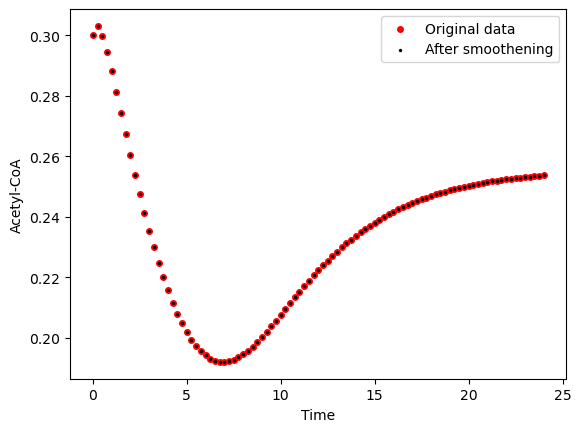

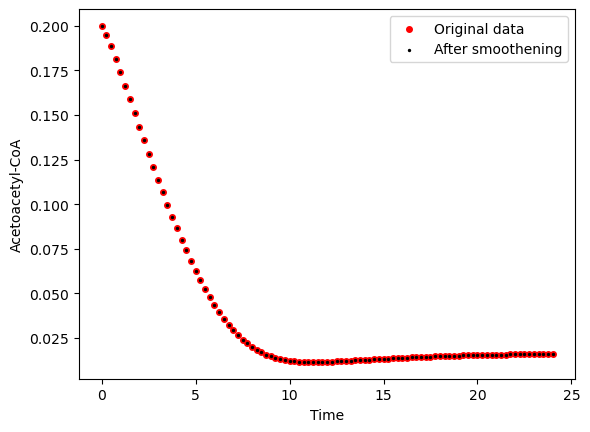

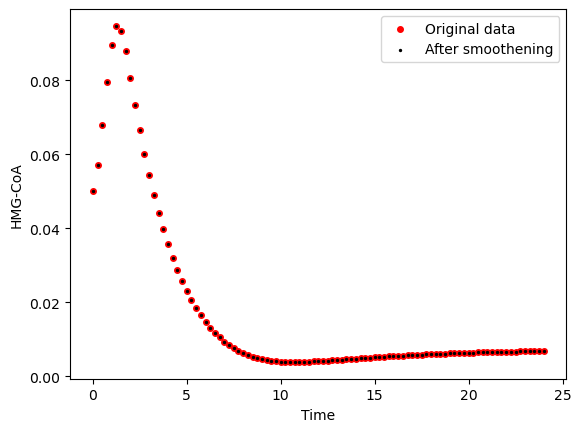

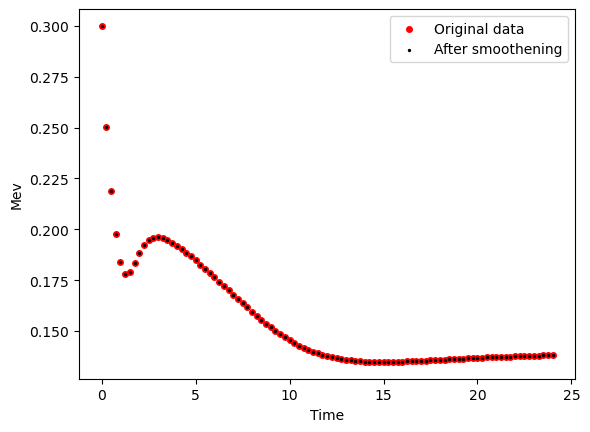

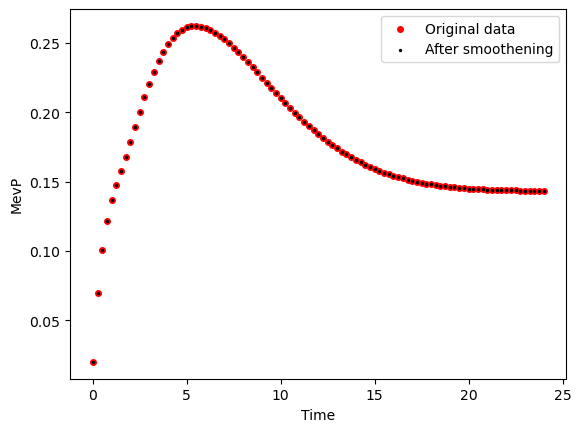

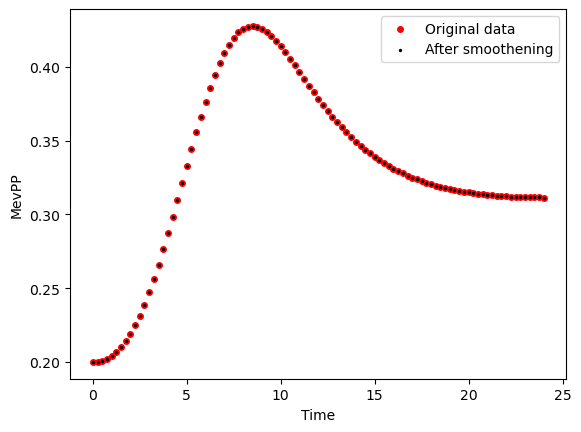

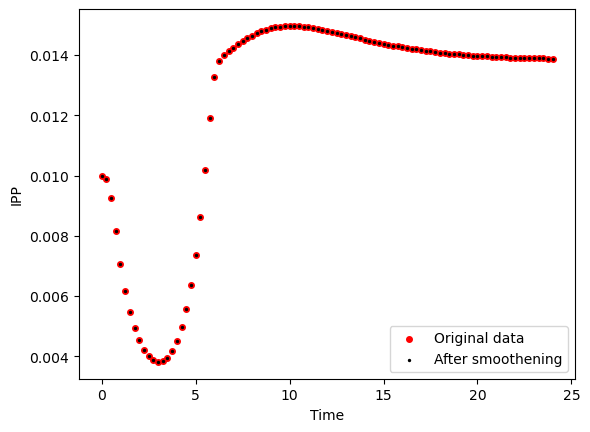

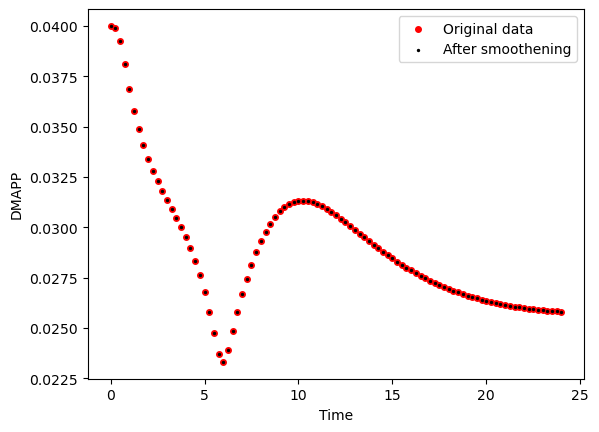

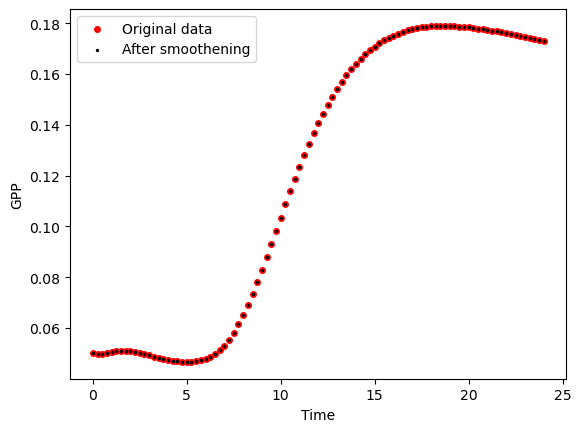

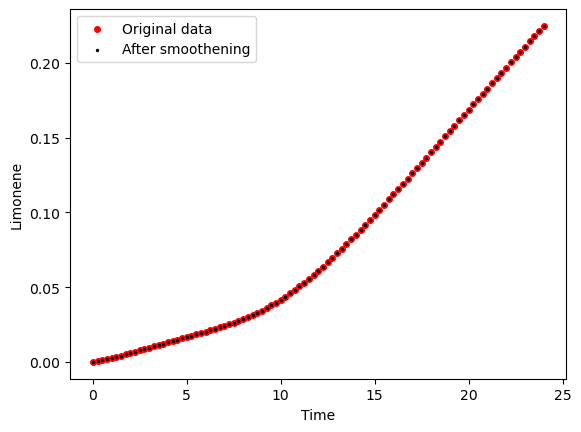

Strain Strain 2


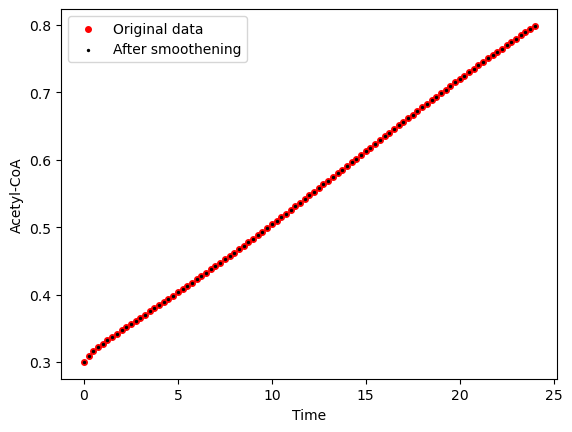

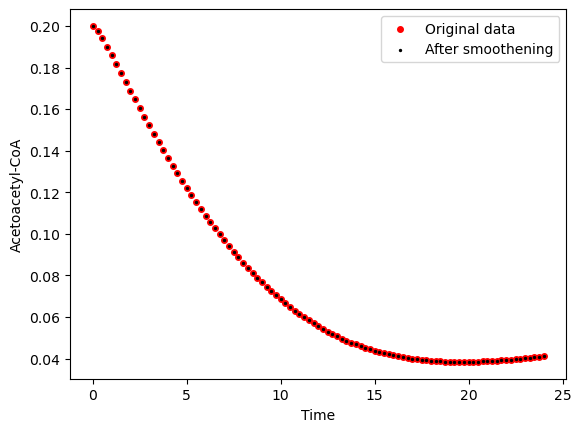

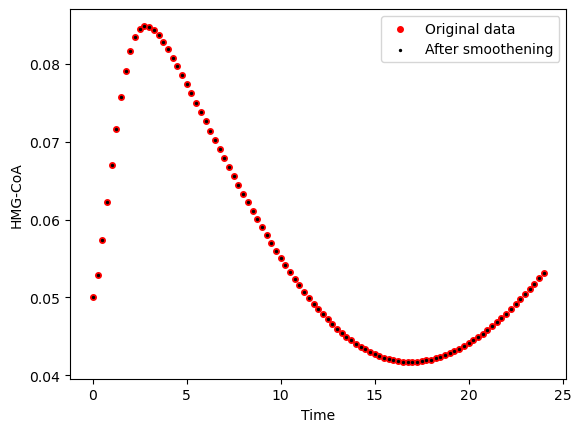

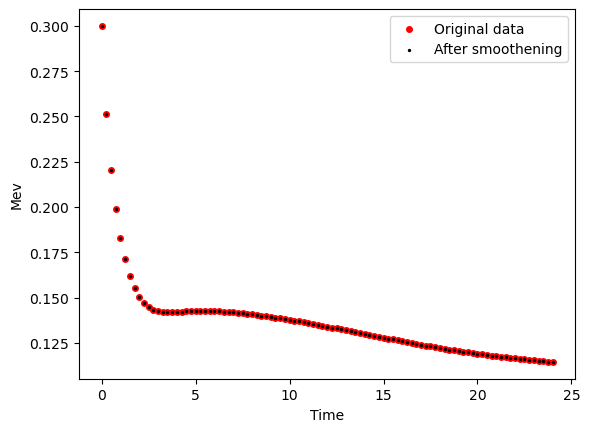

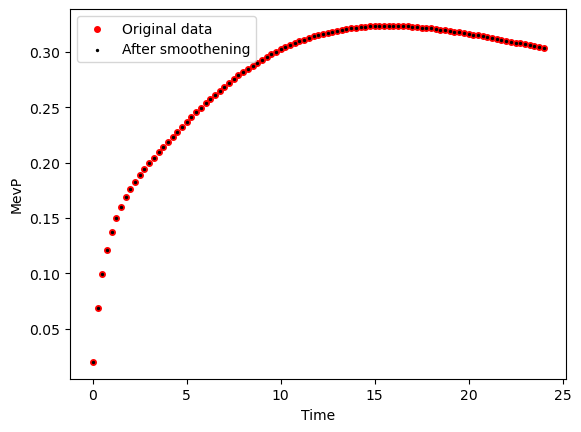

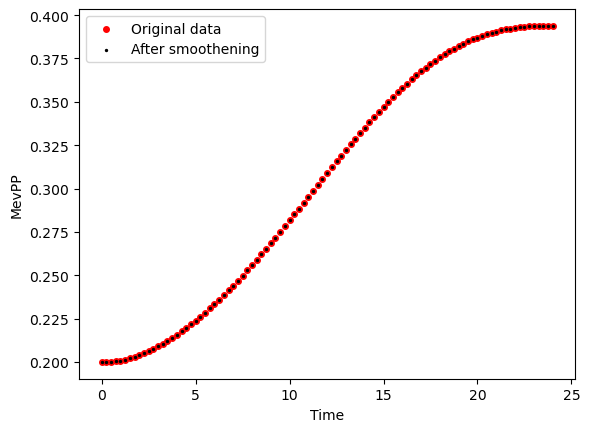

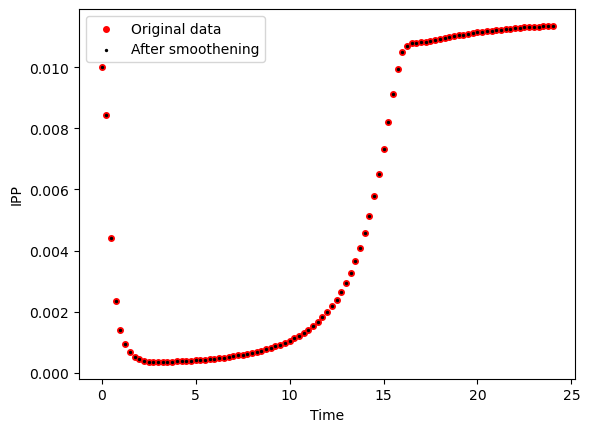

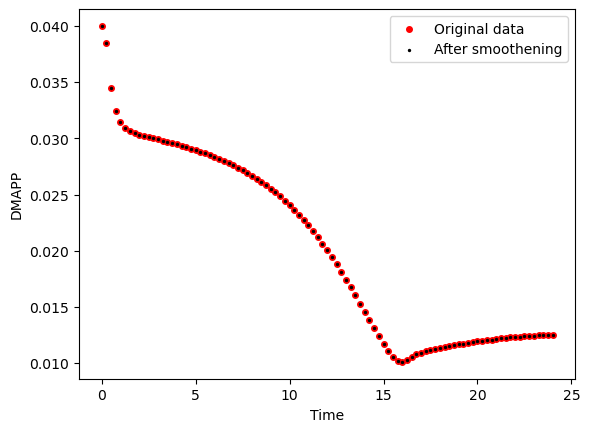

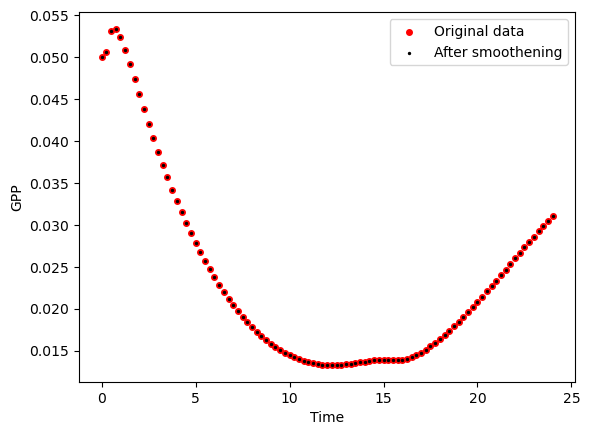

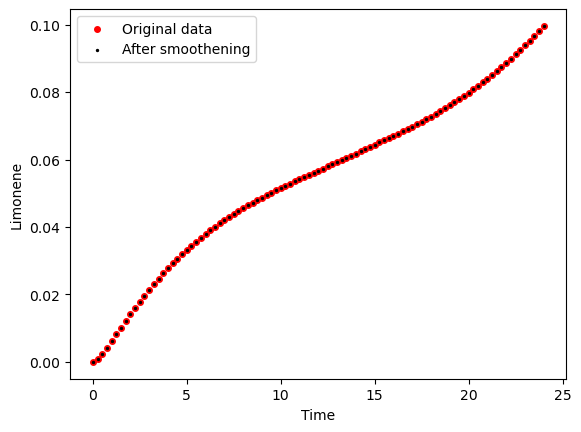

Strain Strain 3


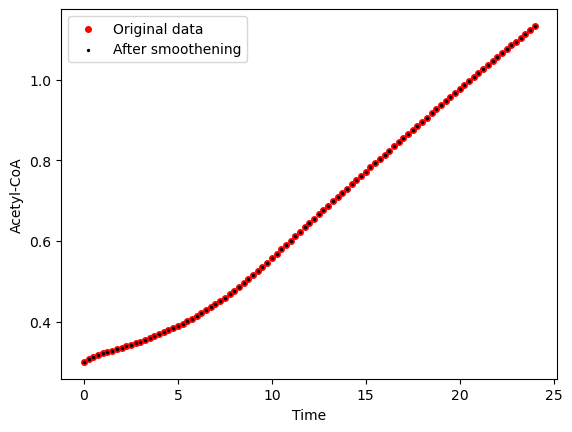

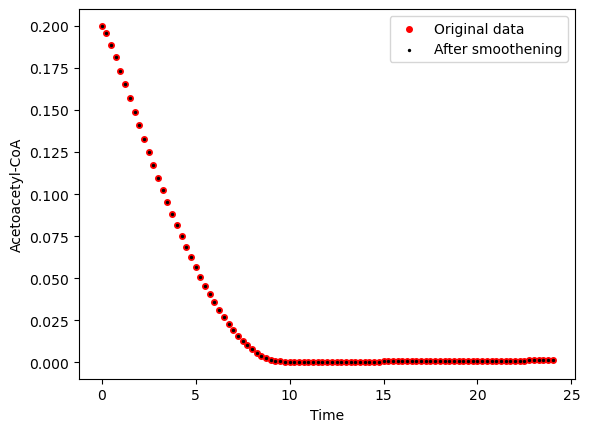

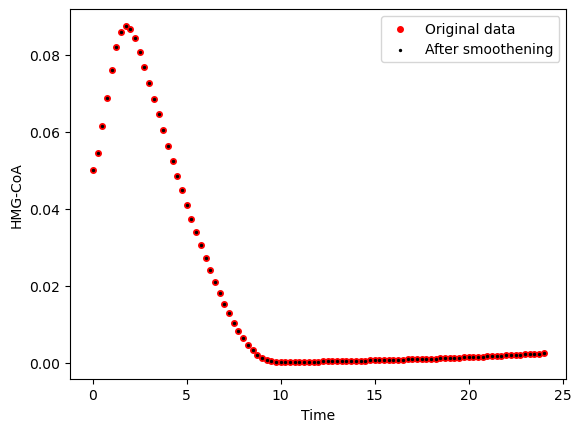

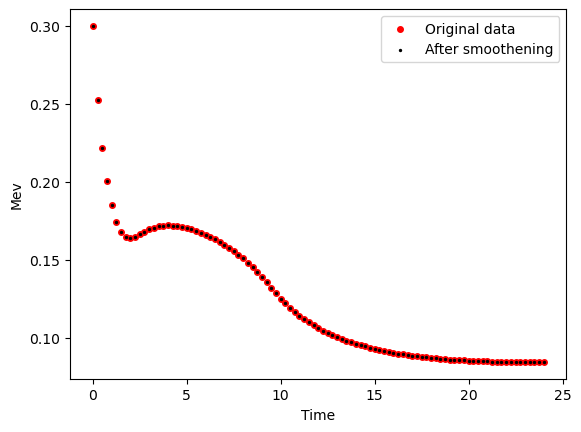

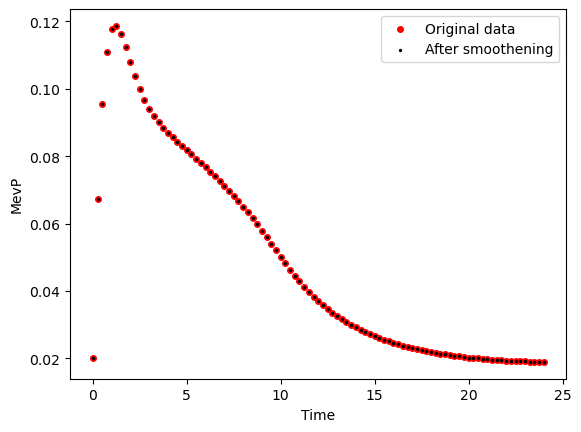

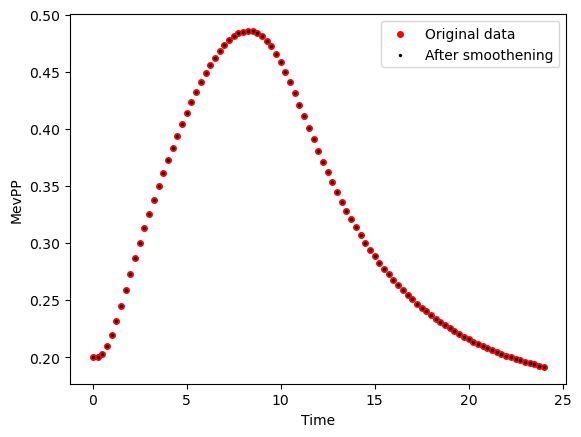

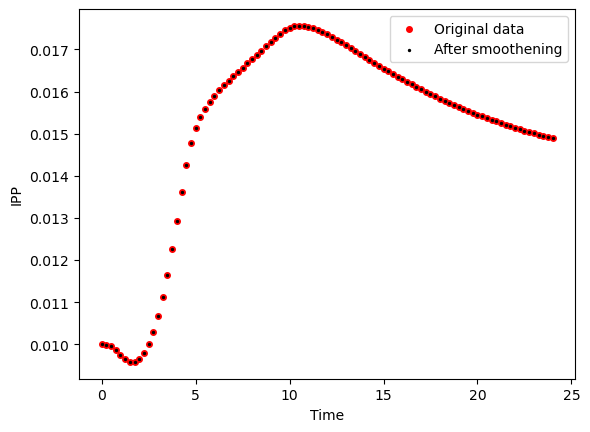

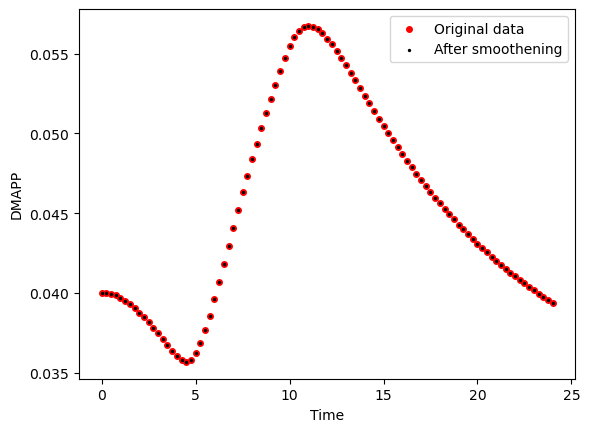

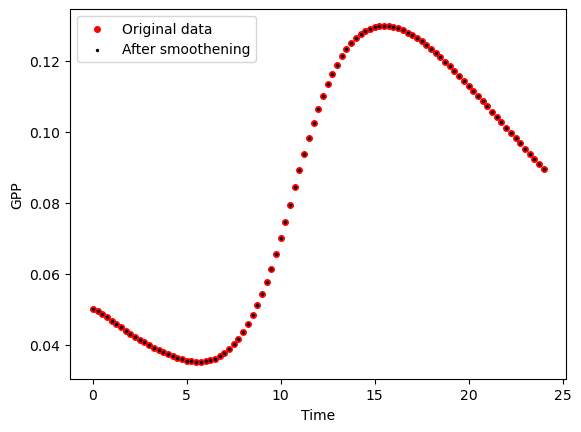

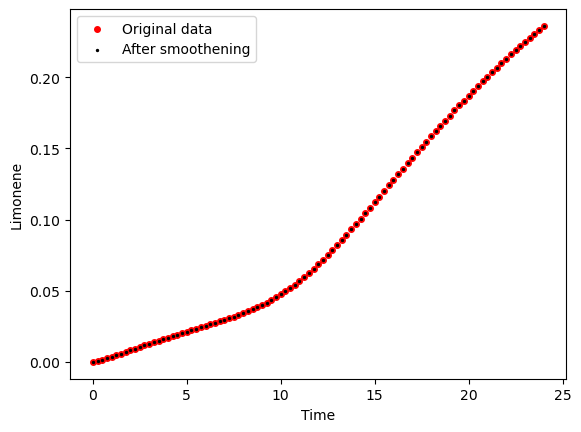

Strain WT


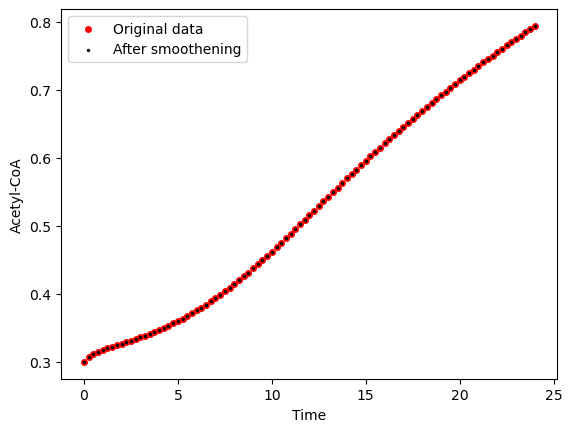

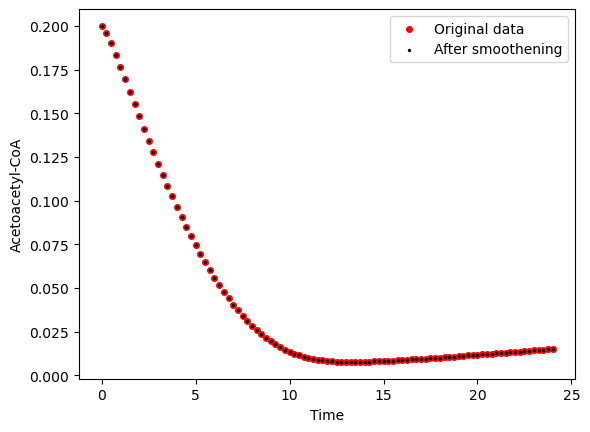

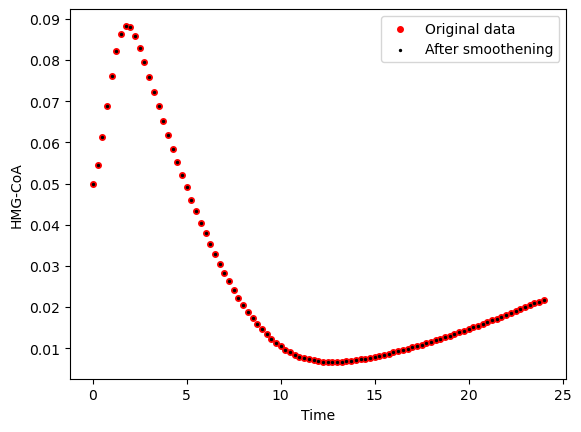

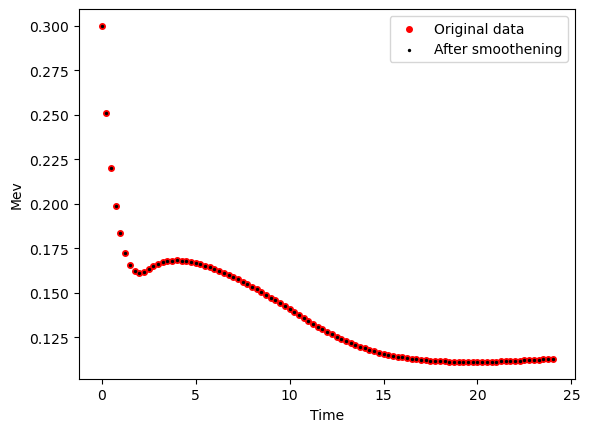

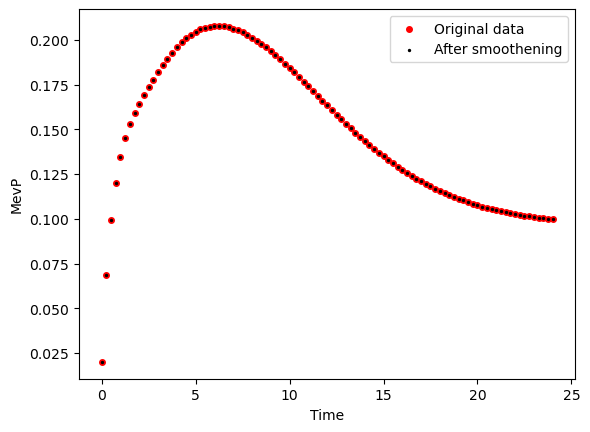

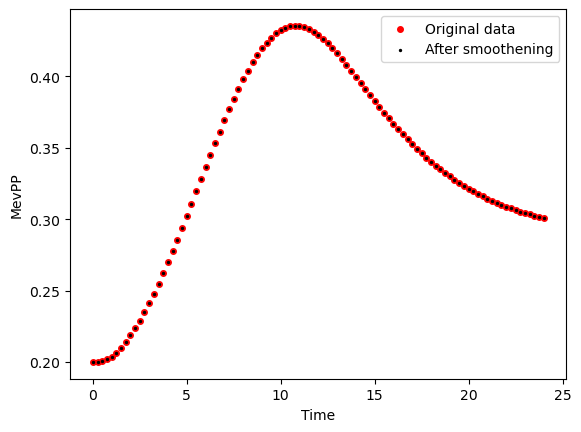

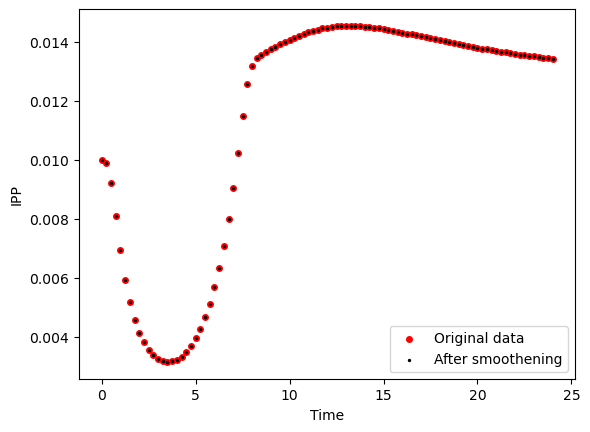

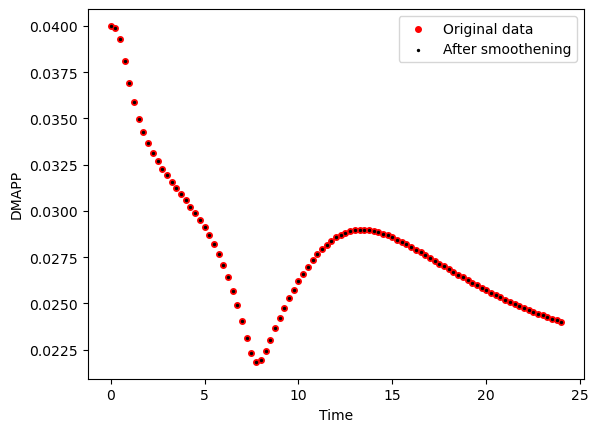

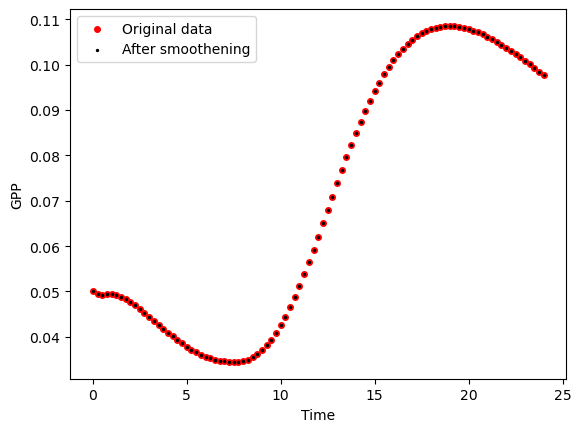

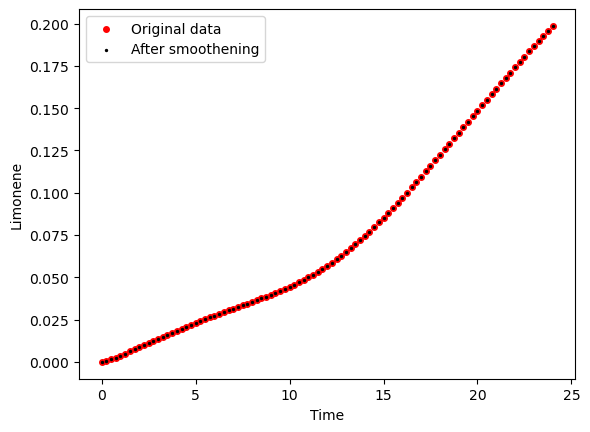

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


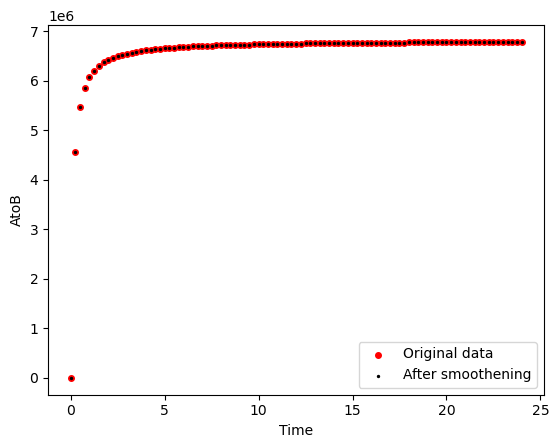

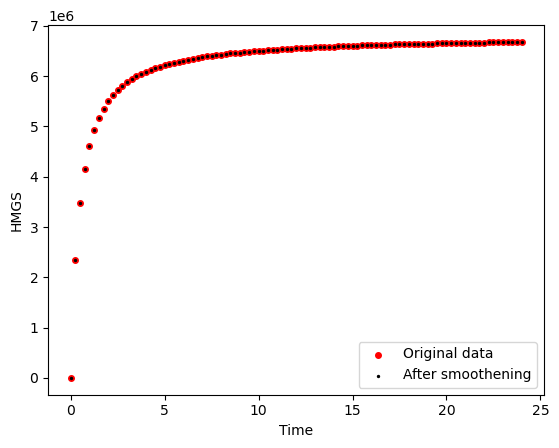

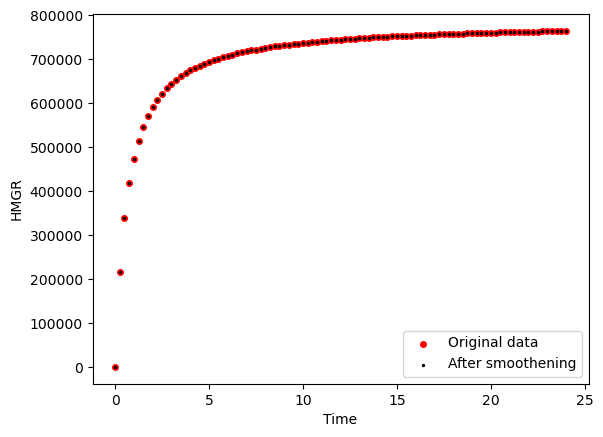

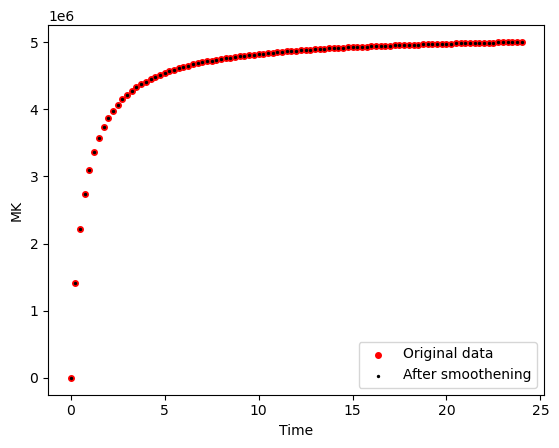

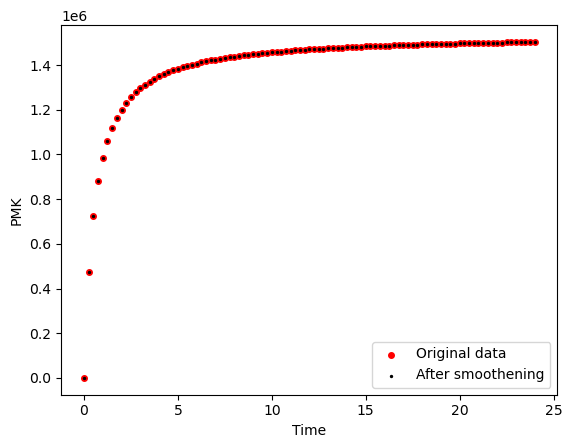

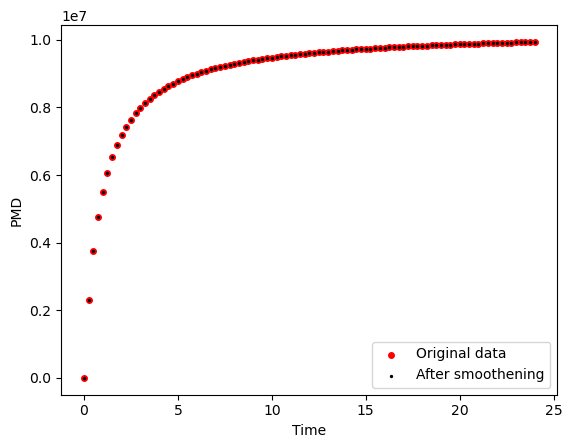

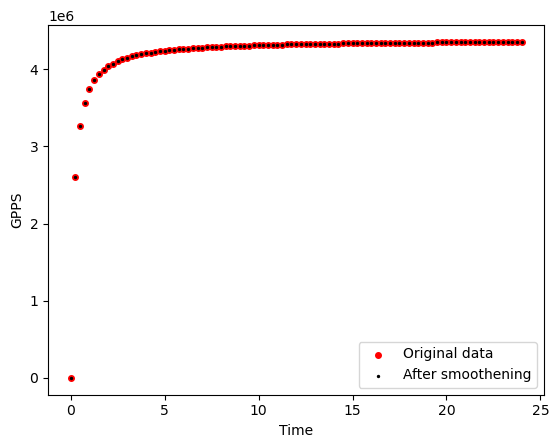

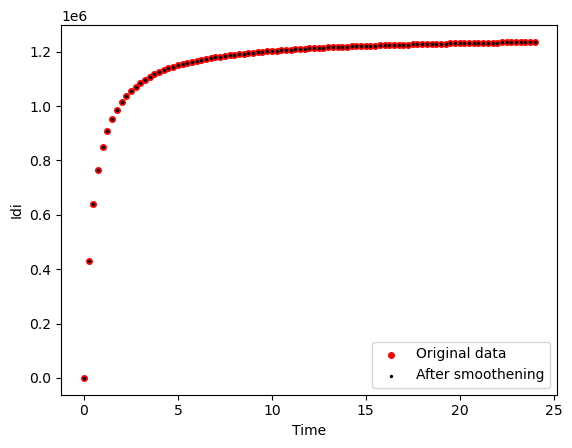

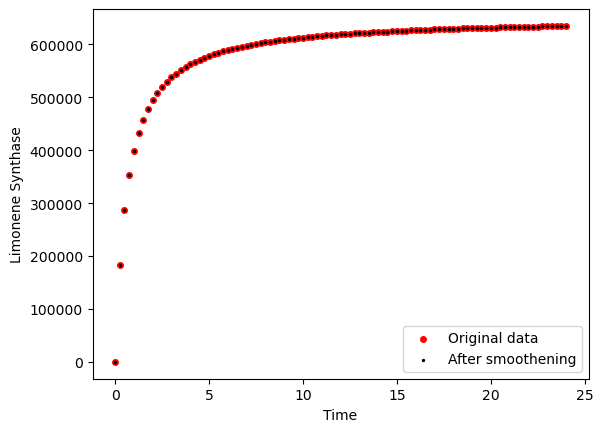

Strain Strain 2


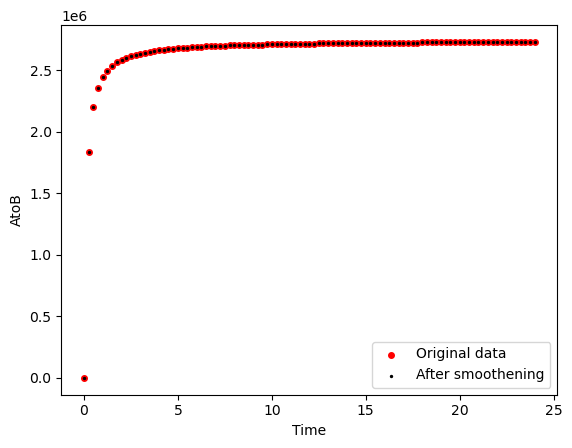

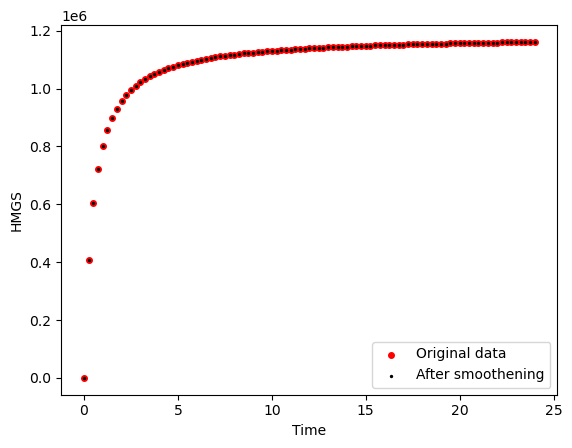

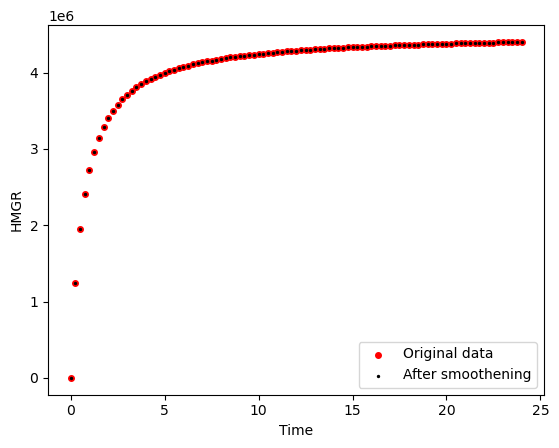

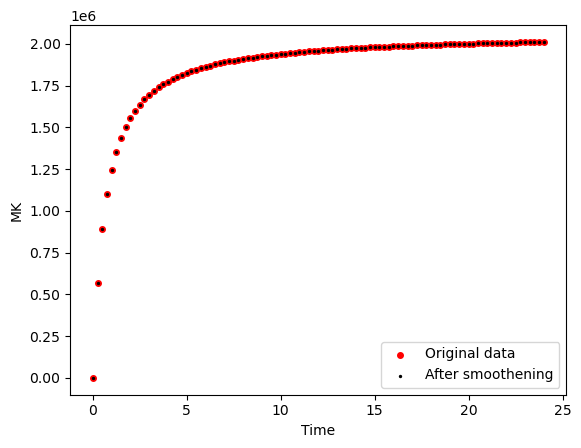

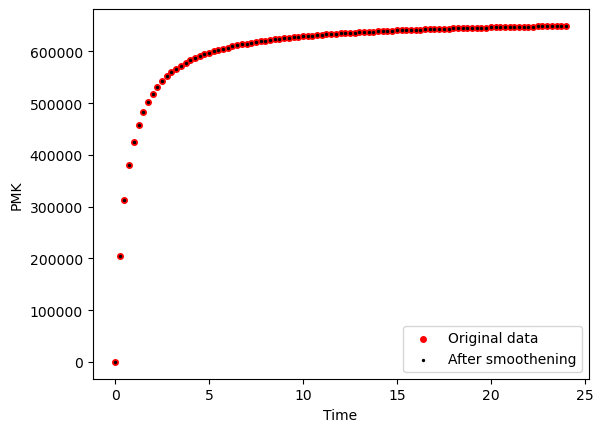

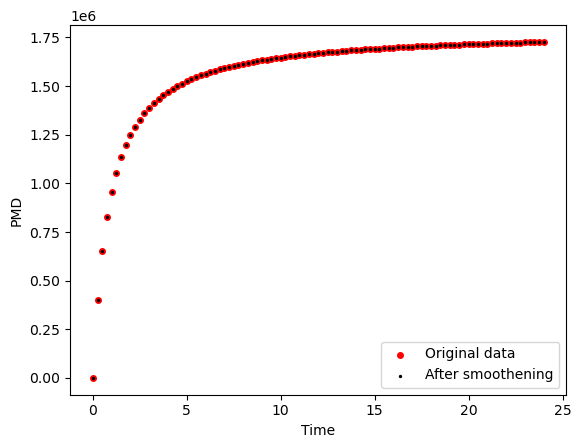

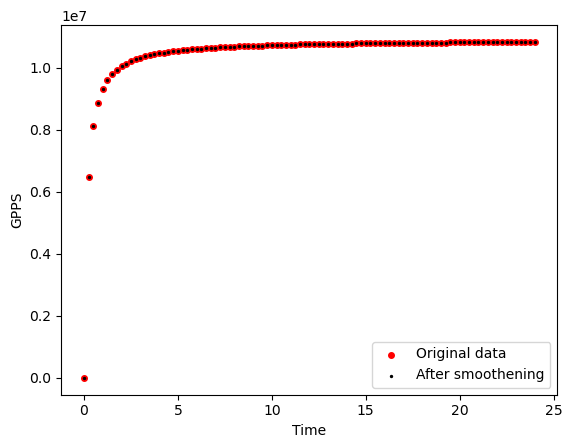

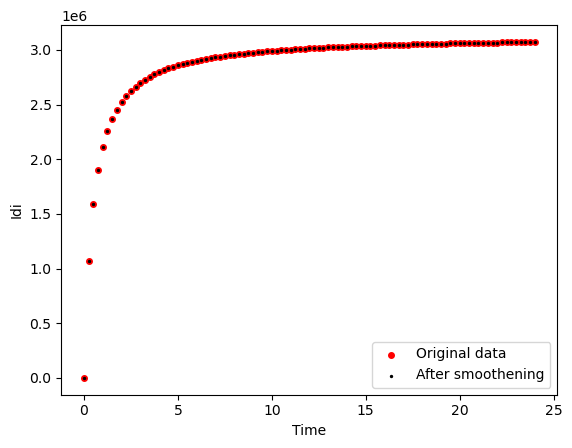

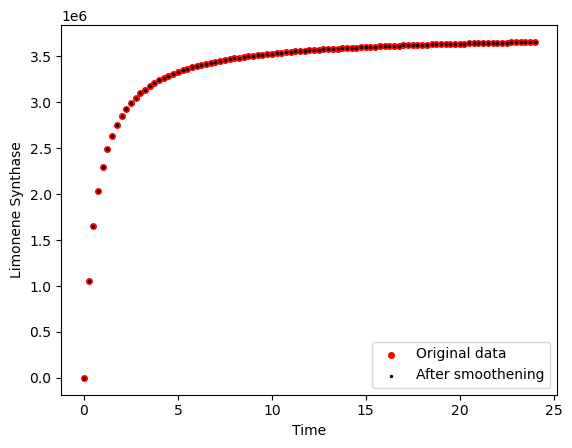

Strain Strain 3


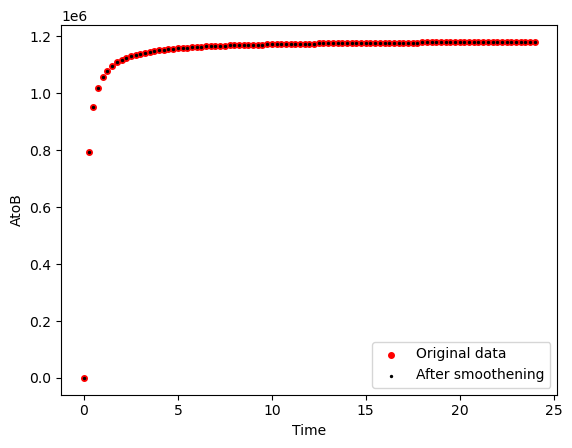

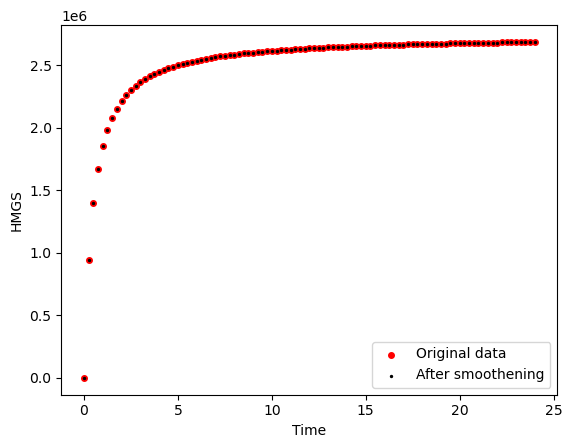

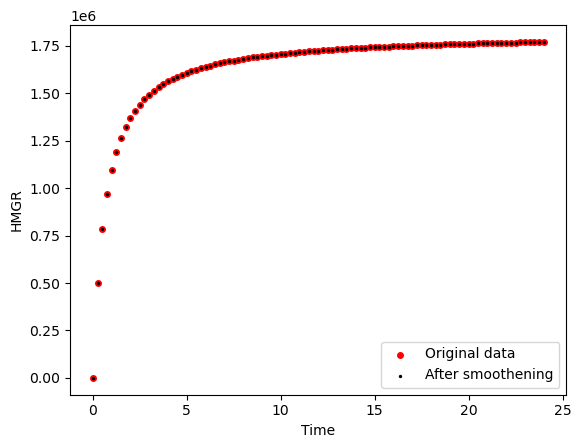

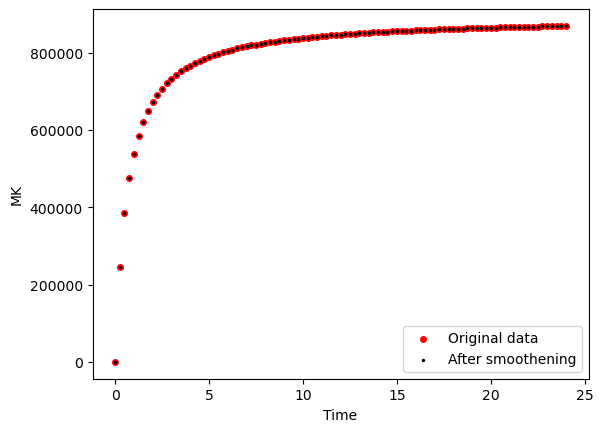

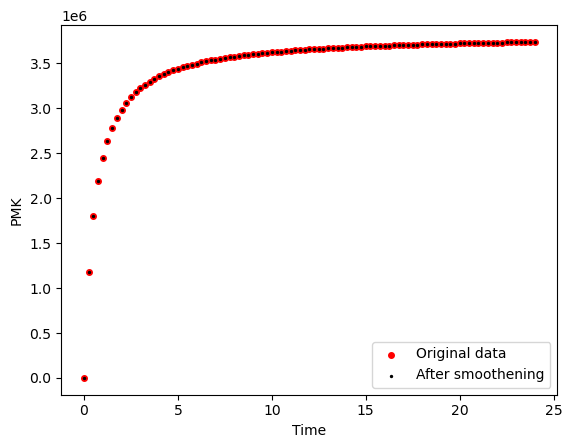

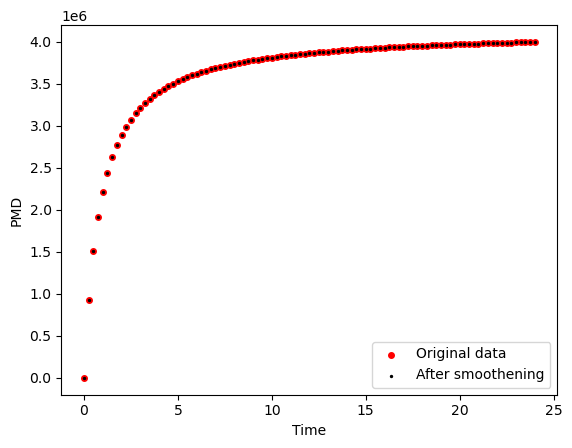

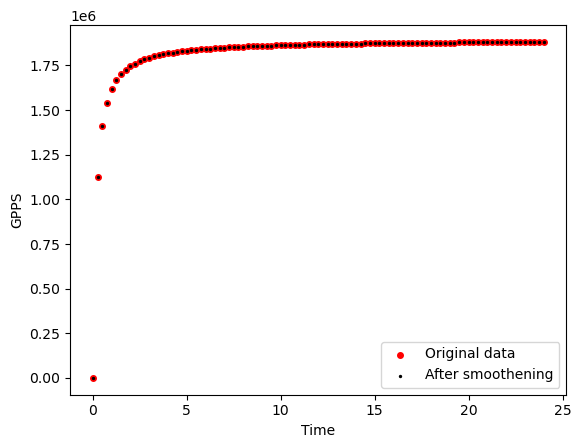

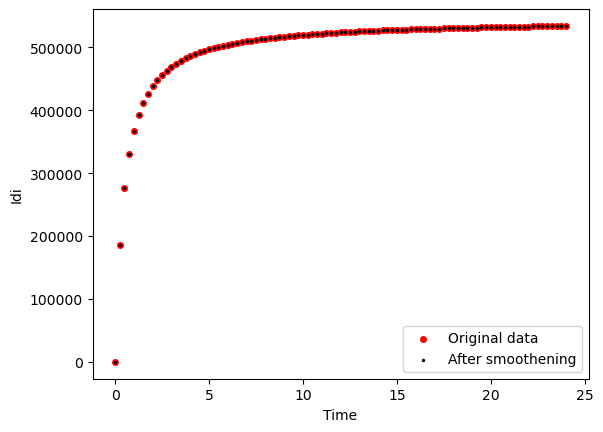

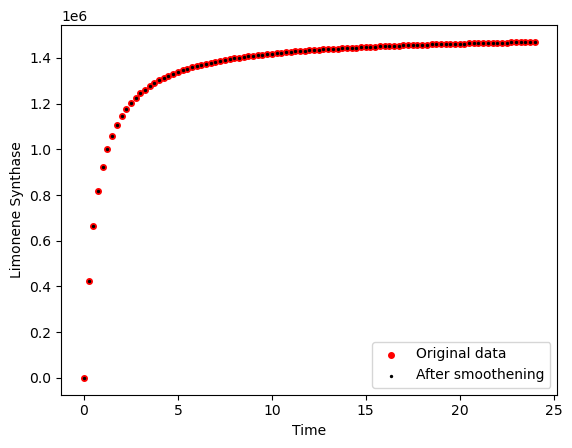

Strain WT


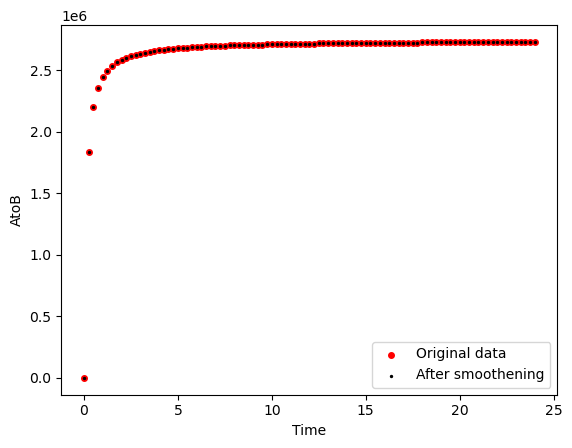

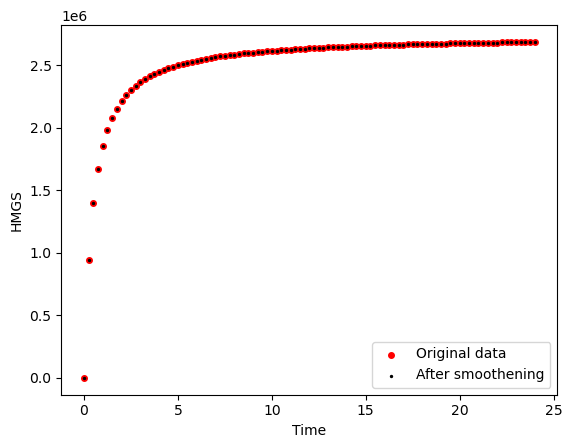

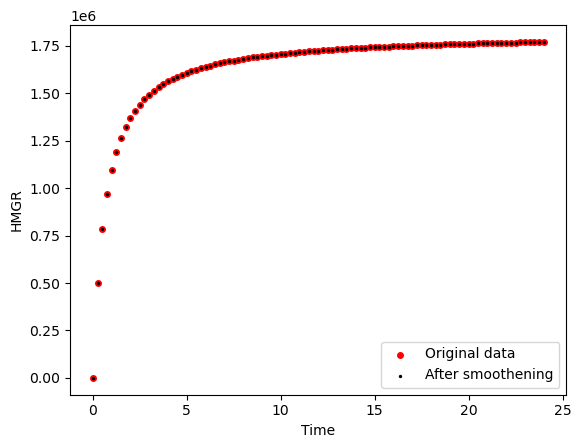

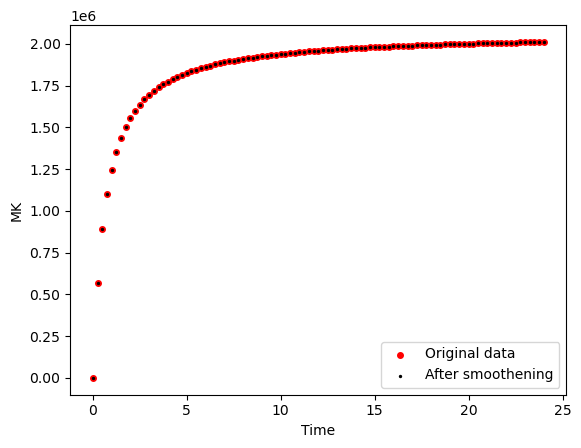

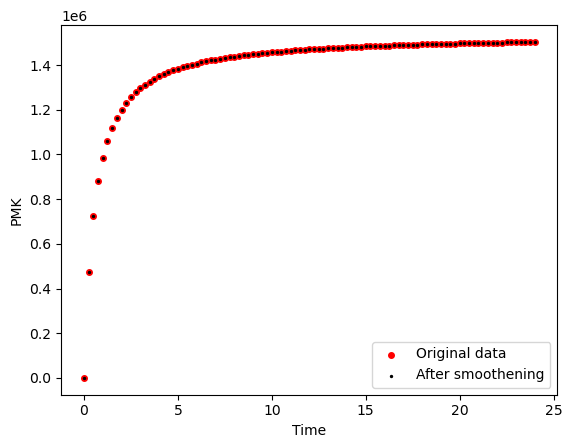

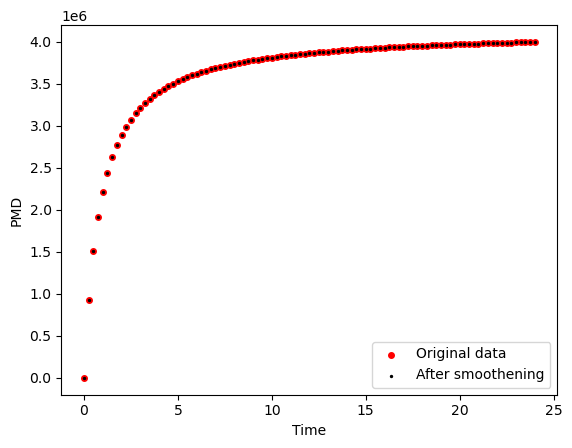

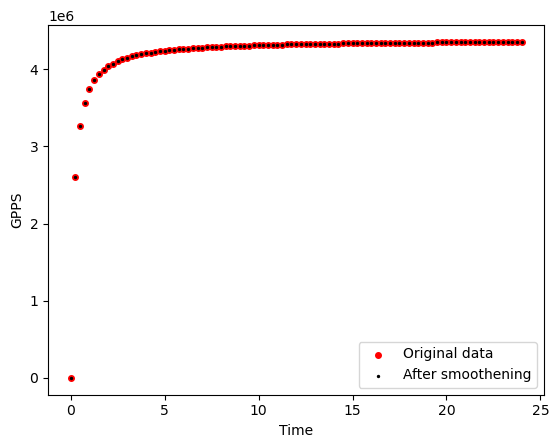

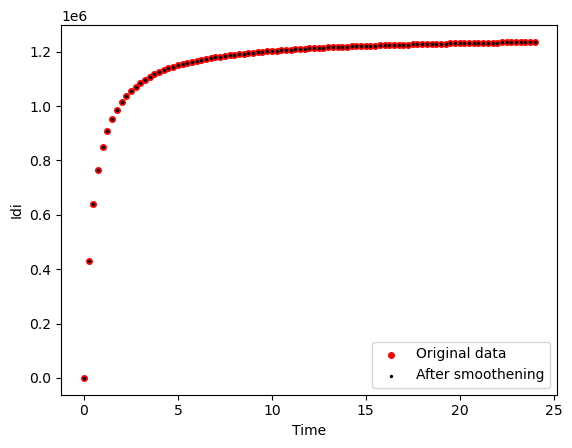

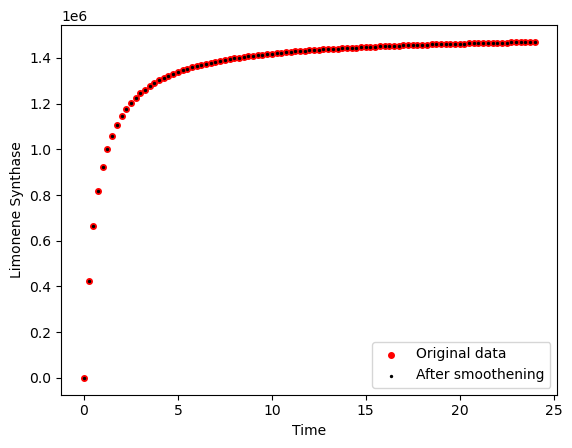

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

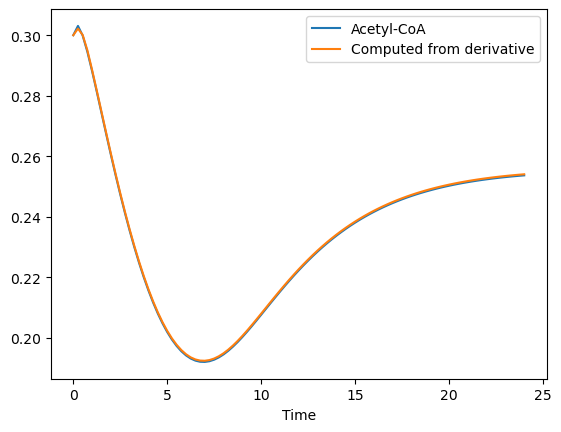

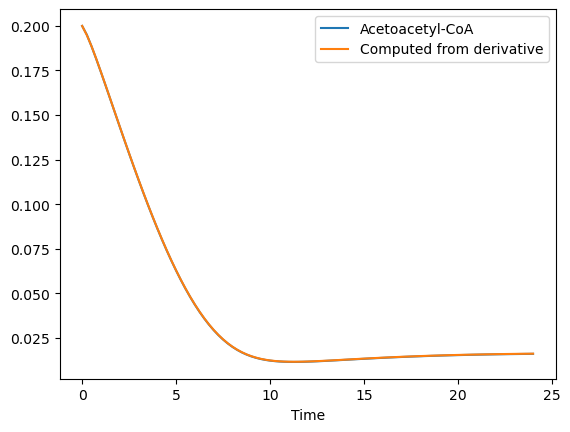

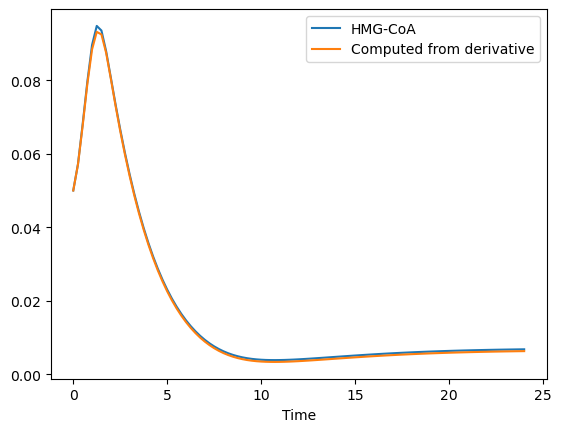

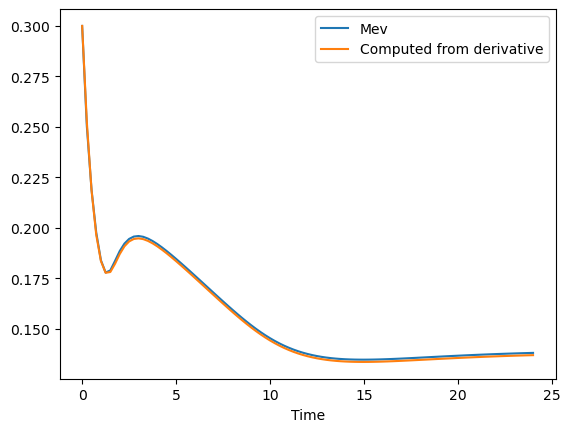

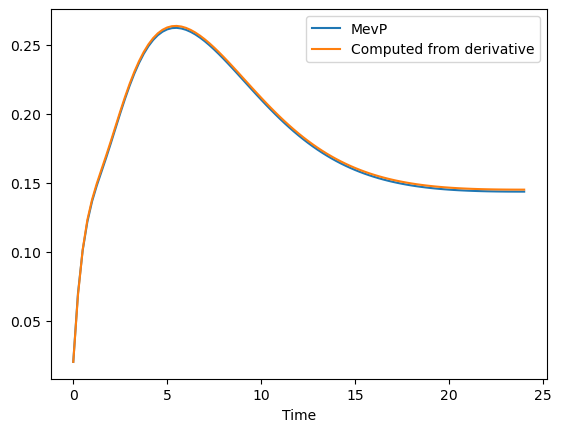

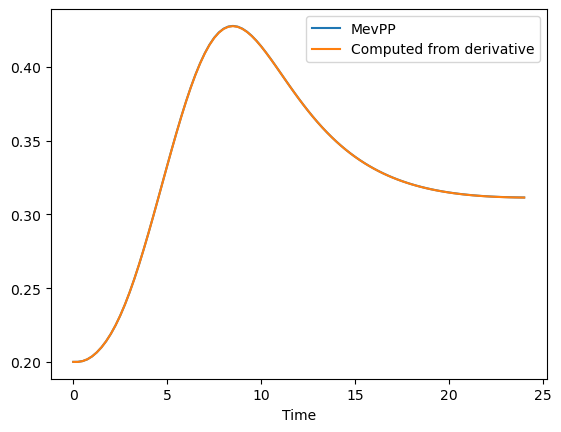

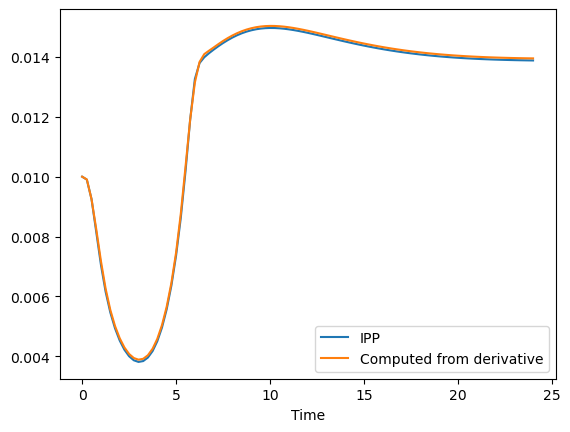

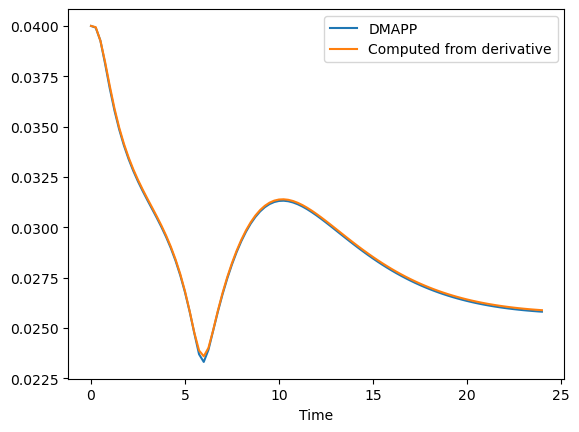

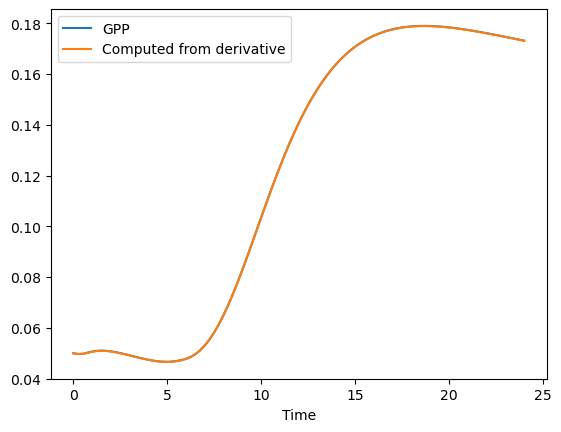

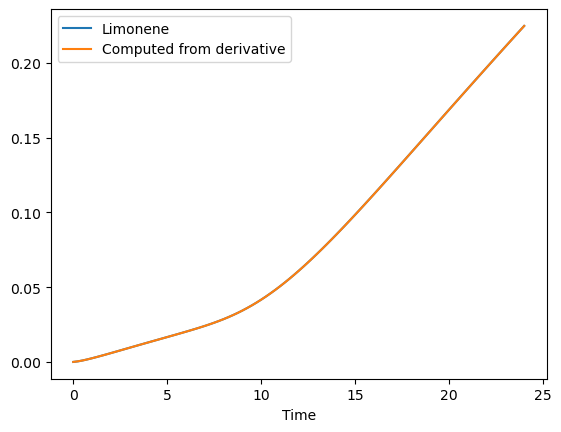

'Time profile from derivative vs. actual profile for Strain 2'

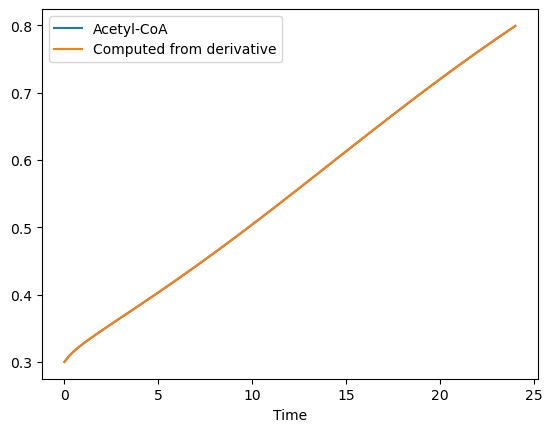

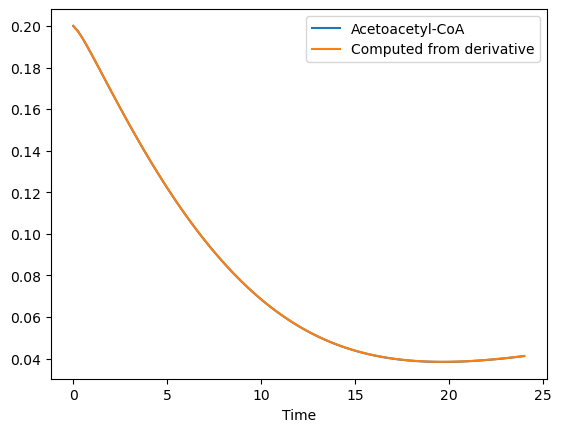

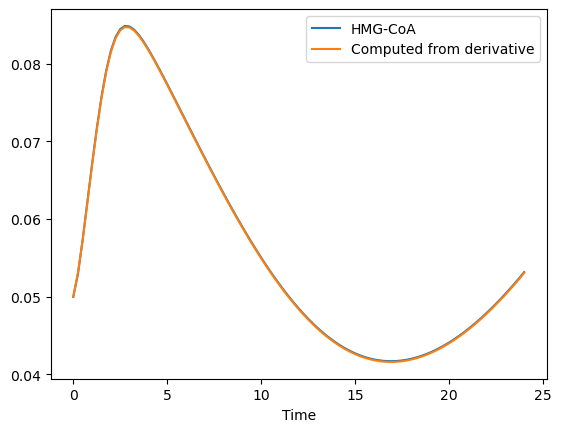

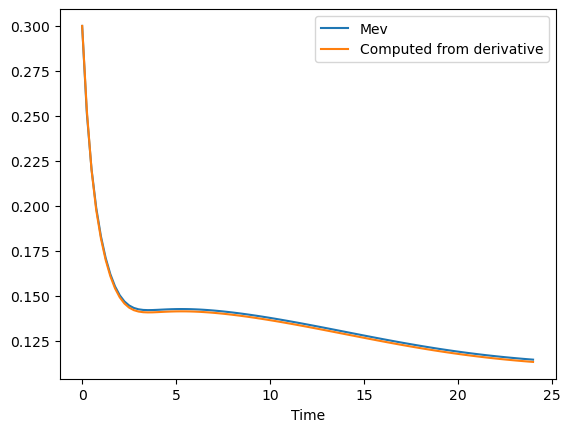

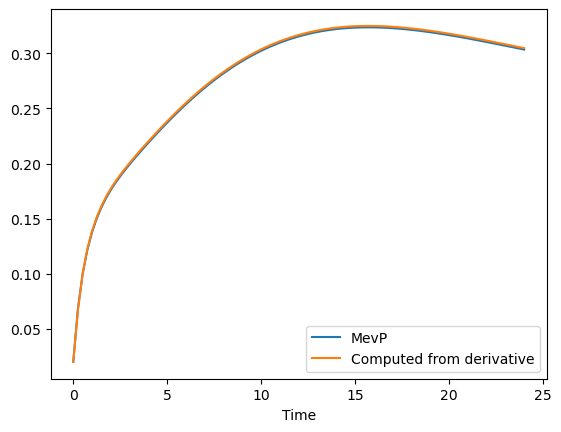

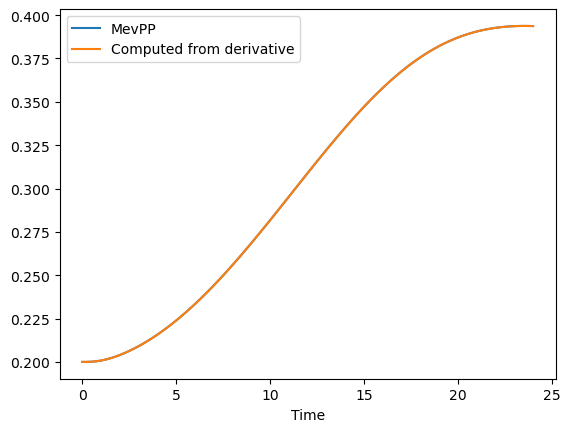

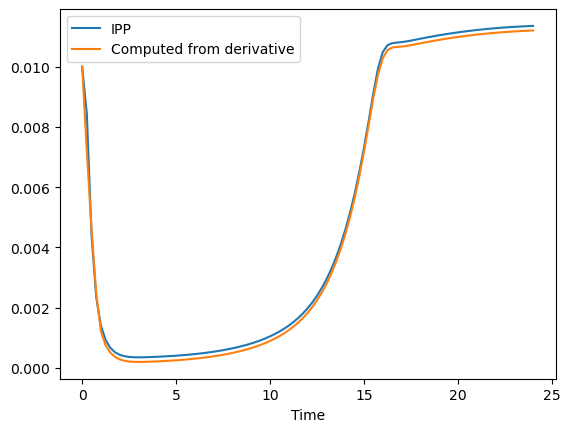

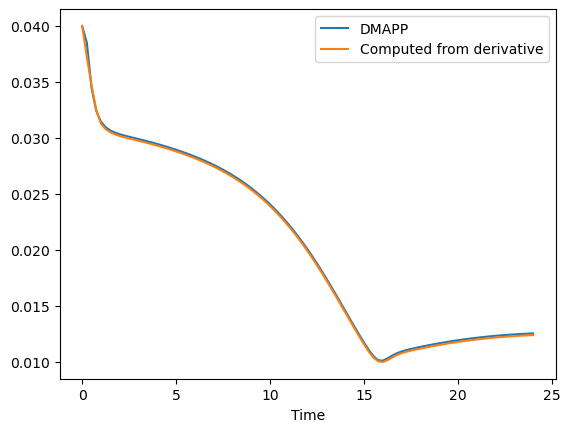

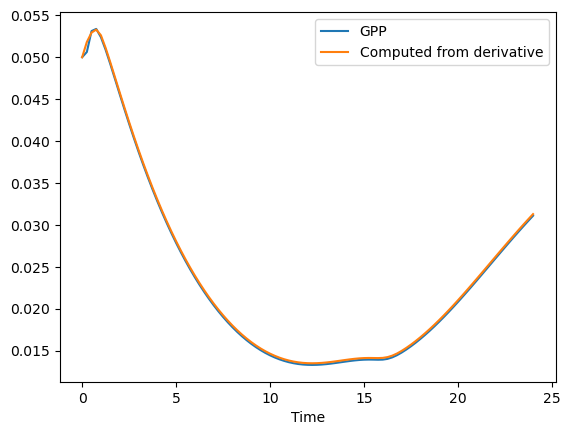

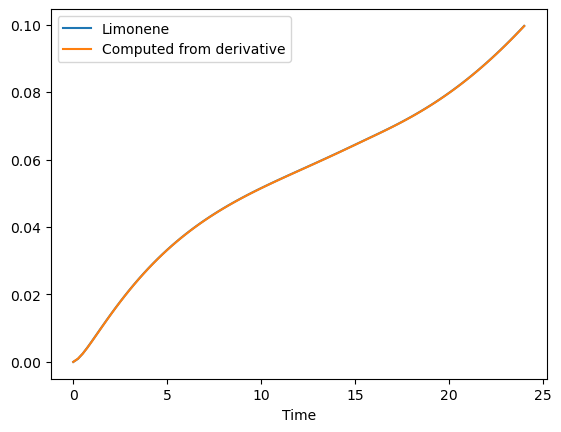

'Time profile from derivative vs. actual profile for Strain 3'

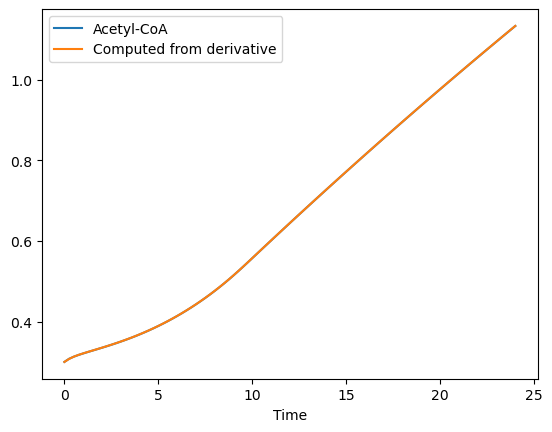

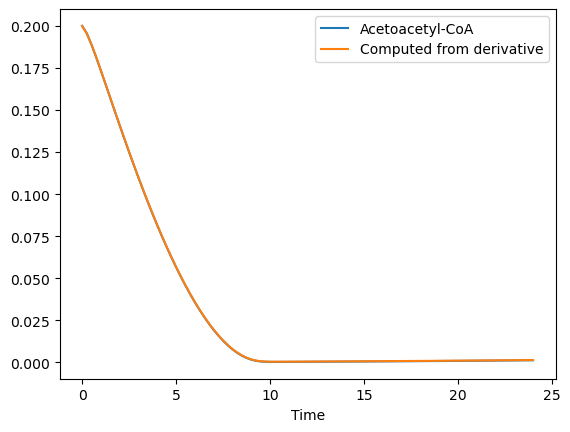

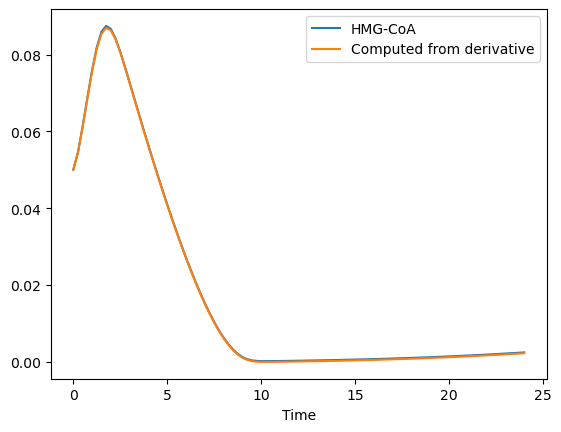

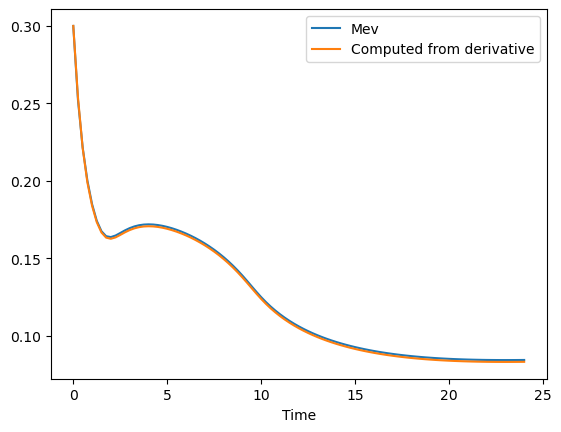

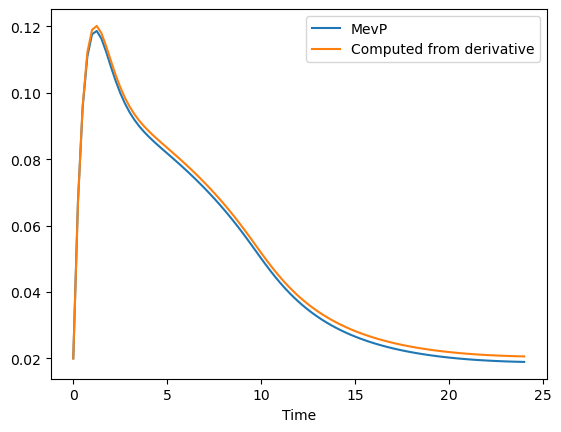

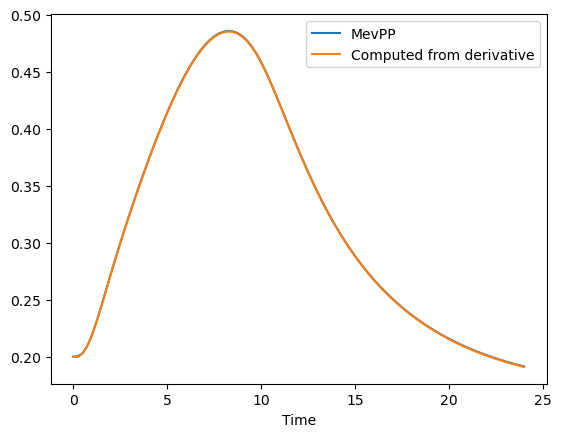

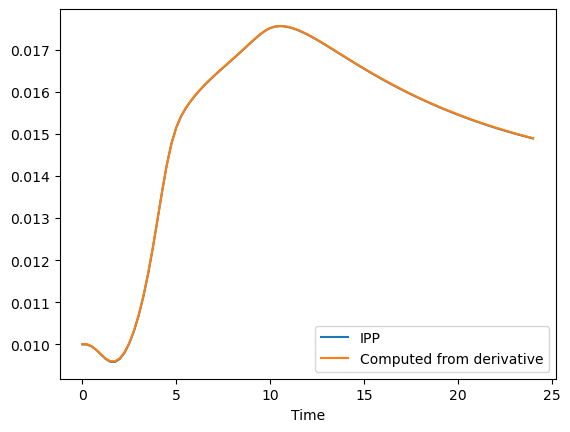

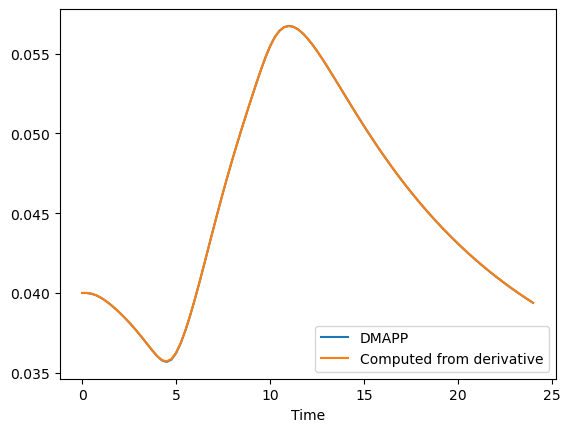

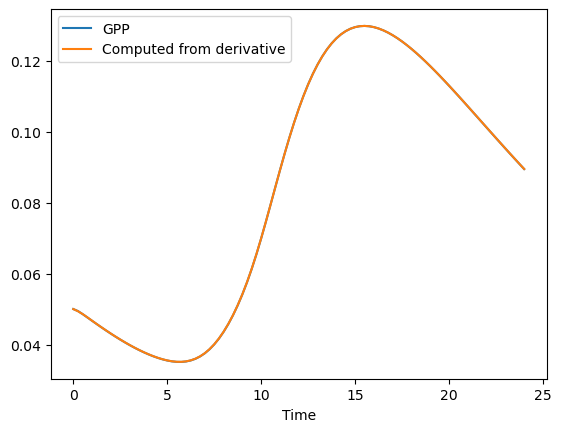

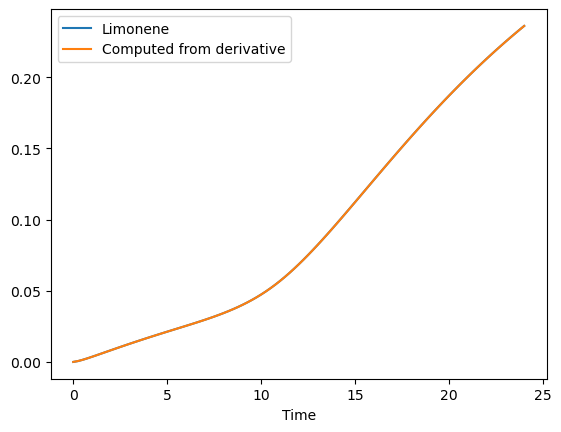

'Time profile from derivative vs. actual profile for WT'

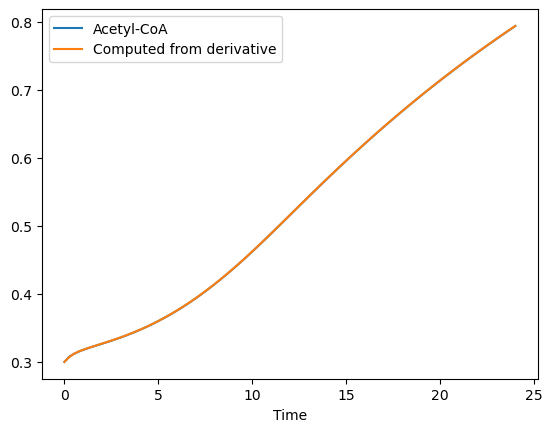

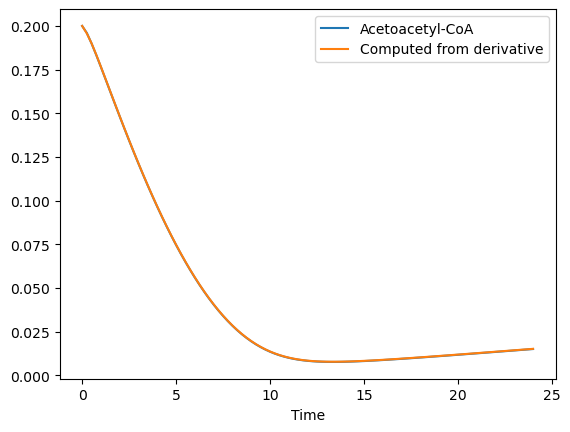

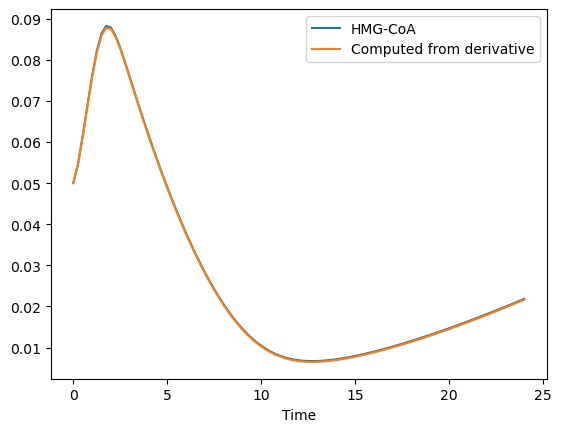

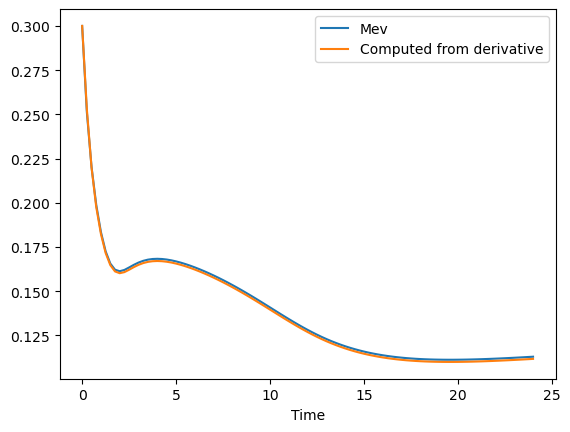

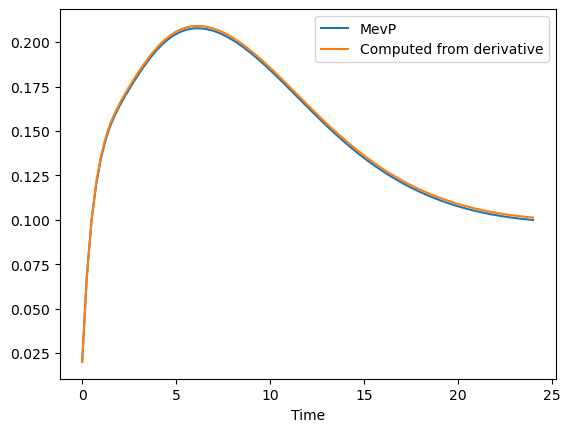

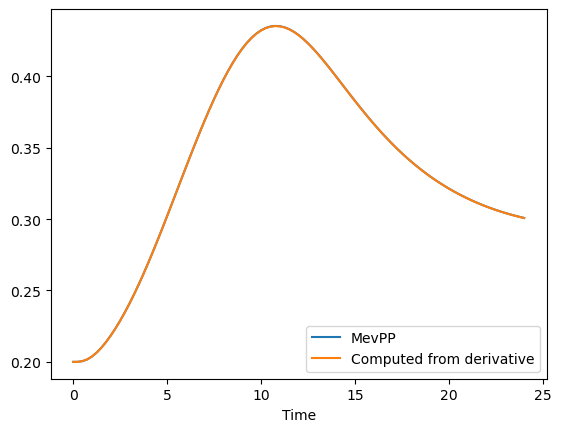

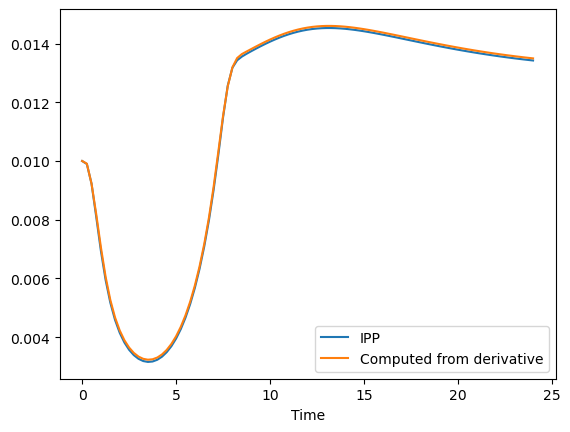

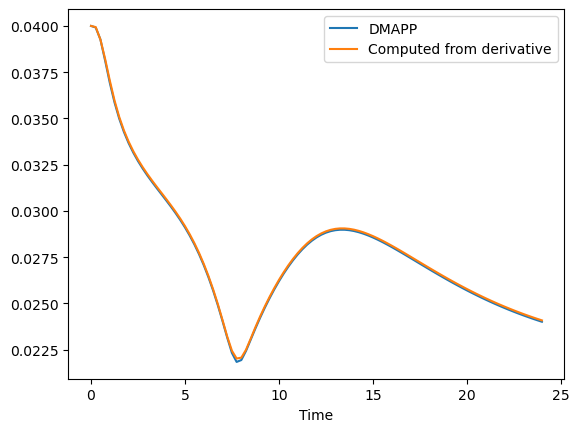

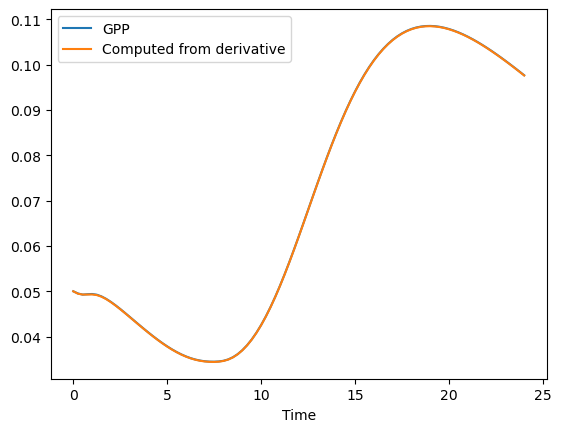

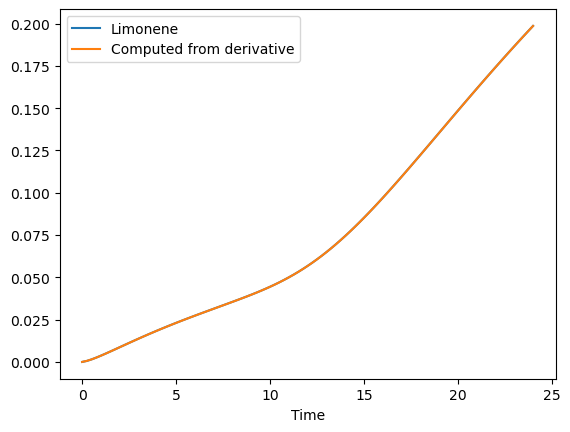

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 1.658812E+202 | 1.860624E+104
     2 |      128 | 1.653812E+202 |  5.756344E+58
     3 |      192 | 2.236030E+182 |  8.059933E+41
     4 |      256 | 2.236030E+182 |  3.416516E+34
     5 |      320 | 2.236030E+182 |  1.073544E+33
     6 |      384 | 2.236030E+182 |  4.975489E+30
     7 |      448 | 2.034899E+122 |  4.893247E+27
     8 |      512 | 2.034899E+122 |  9.069187E+25
     9 |      576 | 2.034899E+122 |  1.493339E+24
    10 |      640 |  1.123527E+28 |  1.826085E+22
    11 |      704 |  1.034454E+27 |  6.697990E+20
    12 |      768 |  1.321271E+23 |  1.314811E+20
    13 |      832 |  3.597753E+21 |  2.535930E+19
    14 |      896 |  2.476574E+21 |  4.728562E+17
    15 |      960 |  2.280568E+21 |  2.087966E+15
    16 |     1024 |  1.208167E+18 |  1.133511E+14
    17 |     1088 |  3.369478E+17 |  6.650561E+12
    18 |     1152 |  2.972878E+17 |  1.795475E+12
    19 |     1216 |  2.97

   162 |    10368 |  1.550765E+01 |  1.550529E+01
   163 |    10432 |  1.550560E+01 |  1.550426E+01
   164 |    10496 |  1.550439E+01 |  1.550313E+01
   165 |    10560 |  1.550337E+01 |  1.550188E+01
   166 |    10624 |  1.550193E+01 |  1.550078E+01
   167 |    10688 |  1.550111E+01 |  1.549951E+01
   168 |    10752 |  1.549958E+01 |  1.549807E+01
   169 |    10816 |  1.549835E+01 |  1.549686E+01
   170 |    10880 |  1.549677E+01 |  1.549495E+01
   171 |    10944 |  1.549521E+01 |  1.549357E+01
   172 |    11008 |  1.549299E+01 |  1.548951E+01
   173 |    11072 |  1.549013E+01 |  1.548681E+01
   174 |    11136 |  1.548678E+01 |  1.548288E+01
   175 |    11200 |  1.548331E+01 |  1.548007E+01
   176 |    11264 |  1.548084E+01 |  1.547807E+01
   177 |    11328 |  1.547831E+01 |  1.547589E+01
   178 |    11392 |  1.547625E+01 |  1.547458E+01
   179 |    11456 |  1.547460E+01 |  1.547282E+01
   180 |    11520 |  1.547313E+01 |  1.547159E+01
   181 |    11584 |  1.547167E+01 |  1.546968E+01


   326 |    20864 |  1.486817E+01 |  1.485432E+01
   327 |    20928 |  1.485869E+01 |  1.484840E+01
   328 |    20992 |  1.485170E+01 |  1.484705E+01
   329 |    21056 |  1.484654E+01 |  1.484199E+01
   330 |    21120 |  1.484371E+01 |  1.484073E+01
   331 |    21184 |  1.484145E+01 |  1.483955E+01
   332 |    21248 |  1.483954E+01 |  1.483836E+01
   333 |    21312 |  1.483814E+01 |  1.483669E+01
   334 |    21376 |  1.483679E+01 |  1.483487E+01
   335 |    21440 |  1.483515E+01 |  1.483288E+01
   336 |    21504 |  1.483252E+01 |  1.482967E+01
   337 |    21568 |  1.482967E+01 |  1.482658E+01
   338 |    21632 |  1.482774E+01 |  1.482581E+01
   339 |    21696 |  1.482622E+01 |  1.482401E+01
   340 |    21760 |  1.482497E+01 |  1.482352E+01
   341 |    21824 |  1.482393E+01 |  1.482299E+01
   342 |    21888 |  1.482306E+01 |  1.481969E+01
   343 |    21952 |  1.482061E+01 |  1.481826E+01
   344 |    22016 |  1.481833E+01 |  1.481599E+01
   345 |    22080 |  1.481616E+01 |  1.481393E+01


   490 |    31360 |  1.433844E+01 |  1.433362E+01
   491 |    31424 |  1.433479E+01 |  1.433170E+01
   492 |    31488 |  1.433167E+01 |  1.432910E+01
   493 |    31552 |  1.432922E+01 |  1.432721E+01
   494 |    31616 |  1.432773E+01 |  1.432622E+01
   495 |    31680 |  1.432643E+01 |  1.432438E+01
   496 |    31744 |  1.432452E+01 |  1.432200E+01
   497 |    31808 |  1.432221E+01 |  1.432003E+01
   498 |    31872 |  1.432022E+01 |  1.431764E+01
   499 |    31936 |  1.431778E+01 |  1.431528E+01
   500 |    32000 |  1.431533E+01 |  1.431242E+01
   501 |    32064 |  1.431286E+01 |  1.431059E+01
   502 |    32128 |  1.431029E+01 |  1.430767E+01
   503 |    32192 |  1.430753E+01 |  1.430485E+01
   504 |    32256 |  1.430558E+01 |  1.430321E+01
   505 |    32320 |  1.430381E+01 |  1.430226E+01
   506 |    32384 |  1.430233E+01 |  1.430126E+01
   507 |    32448 |  1.430161E+01 |  1.430048E+01
   508 |    32512 |  1.430060E+01 |  1.429947E+01
   509 |    32576 |  1.429963E+01 |  1.429837E+01


   654 |    41856 |  1.394585E+01 |  1.394381E+01
   655 |    41920 |  1.394449E+01 |  1.394322E+01
   656 |    41984 |  1.394371E+01 |  1.394215E+01
   657 |    42048 |  1.394233E+01 |  1.394123E+01
   658 |    42112 |  1.394124E+01 |  1.394006E+01
   659 |    42176 |  1.394018E+01 |  1.393924E+01
   660 |    42240 |  1.393930E+01 |  1.393785E+01
   661 |    42304 |  1.393723E+01 |  1.393503E+01
   662 |    42368 |  1.393578E+01 |  1.393349E+01
   663 |    42432 |  1.393297E+01 |  1.392892E+01
   664 |    42496 |  1.392915E+01 |  1.392283E+01
   665 |    42560 |  1.392353E+01 |  1.391590E+01
   666 |    42624 |  1.391483E+01 |  1.390706E+01
   667 |    42688 |  1.390780E+01 |  1.389995E+01
   668 |    42752 |  1.389923E+01 |  1.389093E+01
   669 |    42816 |  1.388944E+01 |  1.387956E+01
   670 |    42880 |  1.388023E+01 |  1.386792E+01
   671 |    42944 |  1.386944E+01 |  1.385819E+01
   672 |    43008 |  1.386014E+01 |  1.385242E+01
   673 |    43072 |  1.385195E+01 |  1.384531E+01


   818 |    52352 |  1.356319E+01 |  1.355974E+01
   819 |    52416 |  1.356011E+01 |  1.355508E+01
   820 |    52480 |  1.355629E+01 |  1.355339E+01
   821 |    52544 |  1.355365E+01 |  1.355108E+01
   822 |    52608 |  1.355166E+01 |  1.354966E+01
   823 |    52672 |  1.355013E+01 |  1.354805E+01
   824 |    52736 |  1.354798E+01 |  1.354555E+01
   825 |    52800 |  1.354540E+01 |  1.354279E+01
   826 |    52864 |  1.354326E+01 |  1.354002E+01
   827 |    52928 |  1.353995E+01 |  1.353704E+01
   828 |    52992 |  1.353744E+01 |  1.353553E+01
   829 |    53056 |  1.353603E+01 |  1.353442E+01
   830 |    53120 |  1.353390E+01 |  1.353103E+01
   831 |    53184 |  1.353158E+01 |  1.352900E+01
   832 |    53248 |  1.352929E+01 |  1.352667E+01
   833 |    53312 |  1.352710E+01 |  1.352551E+01
   834 |    53376 |  1.352592E+01 |  1.352498E+01
   835 |    53440 |  1.352486E+01 |  1.352394E+01
   836 |    53504 |  1.352372E+01 |  1.352286E+01
   837 |    53568 |  1.352288E+01 |  1.352213E+01


   982 |    62848 |  1.306629E+01 |  1.306346E+01
   983 |    62912 |  1.306410E+01 |  1.306173E+01
   984 |    62976 |  1.306216E+01 |  1.305901E+01
   985 |    63040 |  1.305953E+01 |  1.305735E+01
   986 |    63104 |  1.305783E+01 |  1.305523E+01
   987 |    63168 |  1.305560E+01 |  1.305281E+01
   988 |    63232 |  1.305279E+01 |  1.304984E+01
   989 |    63296 |  1.304923E+01 |  1.304524E+01
   990 |    63360 |  1.304609E+01 |  1.304387E+01
   991 |    63424 |  1.304261E+01 |  1.303937E+01
   992 |    63488 |  1.303997E+01 |  1.303650E+01
   993 |    63552 |  1.303741E+01 |  1.303495E+01
   994 |    63616 |  1.303561E+01 |  1.303339E+01
   995 |    63680 |  1.303424E+01 |  1.303237E+01
   996 |    63744 |  1.303231E+01 |  1.303016E+01
   997 |    63808 |  1.303020E+01 |  1.302809E+01
   998 |    63872 |  1.302852E+01 |  1.302621E+01
   999 |    63936 |  1.302597E+01 |  1.302290E+01
  1000 |    64000 |  1.302379E+01 |  1.302117E+01
  1001 |    64064 |  1.302051E+01 |  1.301713E+01


  1146 |    73344 |  1.252403E+01 |  1.252048E+01
  1147 |    73408 |  1.252045E+01 |  1.251451E+01
  1148 |    73472 |  1.251636E+01 |  1.251015E+01
  1149 |    73536 |  1.251169E+01 |  1.250690E+01
  1150 |    73600 |  1.250741E+01 |  1.249834E+01
  1151 |    73664 |  1.249850E+01 |  1.248405E+01
  1152 |    73728 |  1.248581E+01 |  1.246876E+01
  1153 |    73792 |  1.247024E+01 |  1.245684E+01
  1154 |    73856 |  1.245976E+01 |  1.245005E+01
  1155 |    73920 |  1.245358E+01 |  1.244155E+01
  1156 |    73984 |  1.244545E+01 |  1.243398E+01
  1157 |    74048 |  1.243698E+01 |  1.242742E+01
  1158 |    74112 |  1.242768E+01 |  1.241641E+01
  1159 |    74176 |  1.242070E+01 |  1.241373E+01
  1160 |    74240 |  1.241422E+01 |  1.240776E+01
  1161 |    74304 |  1.241023E+01 |  1.240287E+01
  1162 |    74368 |  1.240535E+01 |  1.240120E+01
  1163 |    74432 |  1.240191E+01 |  1.239859E+01
  1164 |    74496 |  1.239918E+01 |  1.239607E+01
  1165 |    74560 |  1.239607E+01 |  1.239269E+01


  1310 |    83840 |  1.168646E+01 |  1.167835E+01
  1311 |    83904 |  1.167909E+01 |  1.166314E+01
  1312 |    83968 |  1.166706E+01 |  1.165353E+01
  1313 |    84032 |  1.165512E+01 |  1.164263E+01
  1314 |    84096 |  1.164501E+01 |  1.163195E+01
  1315 |    84160 |  1.163475E+01 |  1.162497E+01
  1316 |    84224 |  1.162697E+01 |  1.161463E+01
  1317 |    84288 |  1.161116E+01 |  1.159427E+01
  1318 |    84352 |  1.159770E+01 |  1.158071E+01
  1319 |    84416 |  1.158361E+01 |  1.156589E+01
  1320 |    84480 |  1.157177E+01 |  1.155840E+01
  1321 |    84544 |  1.156033E+01 |  1.155145E+01
  1322 |    84608 |  1.155091E+01 |  1.154343E+01
  1323 |    84672 |  1.154487E+01 |  1.153752E+01
  1324 |    84736 |  1.153968E+01 |  1.153380E+01
  1325 |    84800 |  1.153515E+01 |  1.153061E+01
  1326 |    84864 |  1.153108E+01 |  1.152767E+01
  1327 |    84928 |  1.152769E+01 |  1.152271E+01
  1328 |    84992 |  1.152426E+01 |  1.151982E+01
  1329 |    85056 |  1.152062E+01 |  1.151682E+01


  1474 |    94336 |  1.081883E+01 |  1.081305E+01
  1475 |    94400 |  1.081527E+01 |  1.080892E+01
  1476 |    94464 |  1.080856E+01 |  1.080153E+01
  1477 |    94528 |  1.080392E+01 |  1.079923E+01
  1478 |    94592 |  1.080031E+01 |  1.079356E+01
  1479 |    94656 |  1.079523E+01 |  1.078954E+01
  1480 |    94720 |  1.078639E+01 |  1.076805E+01
  1481 |    94784 |  1.077185E+01 |  1.075388E+01
  1482 |    94848 |  1.075798E+01 |  1.074339E+01
  1483 |    94912 |  1.074558E+01 |  1.072664E+01
  1484 |    94976 |  1.072909E+01 |  1.071140E+01
  1485 |    95040 |  1.071495E+01 |  1.070047E+01
  1486 |    95104 |  1.070075E+01 |  1.067804E+01
  1487 |    95168 |  1.068213E+01 |  1.065812E+01
  1488 |    95232 |  1.066322E+01 |  1.063880E+01
  1489 |    95296 |  1.064849E+01 |  1.062909E+01
  1490 |    95360 |  1.062935E+01 |  1.060990E+01
  1491 |    95424 |  1.061154E+01 |  1.059597E+01
  1492 |    95488 |  1.060006E+01 |  1.058727E+01
  1493 |    95552 |  1.058945E+01 |  1.057511E+01


  1638 |   104832 |  9.4148852574 |  9.4101810363
  1639 |   104896 |  9.4115330248 |  9.4079875889
  1640 |   104960 |  9.4085972985 |  9.4052598231
  1641 |   105024 |  9.4033593361 |  9.3974558817
  1642 |   105088 |  9.3989915894 |  9.3929770842
  1643 |   105152 |  9.3945504841 |  9.3887402117
  1644 |   105216 |  9.3896689907 |  9.3866731711
  1645 |   105280 |  9.3870151344 |  9.3846510018
  1646 |   105344 |  9.3852734611 |  9.3835690437
  1647 |   105408 |  9.3837533682 |  9.3825602704
  1648 |   105472 |  9.3825132189 |  9.3812892652
  1649 |   105536 |  9.3817890298 |  9.3808755865
  1650 |   105600 |  9.3809317614 |  9.3800910771
  1651 |   105664 |  9.3803290487 |  9.3797361641
  1652 |   105728 |  9.3797987767 |  9.3791574163
  1653 |   105792 |  9.3791735671 |  9.3787400050
  1654 |   105856 |  9.3788177501 |  9.3784604721
  1655 |   105920 |  9.3785010772 |  9.3781161804
  1656 |   105984 |  9.3781268530 |  9.3777304744
  1657 |   106048 |  9.3777289650 |  9.3772406977


  1802 |   115328 |  9.1697940946 |  9.1693875247
  1803 |   115392 |  9.1694537836 |  9.1689999766
  1804 |   115456 |  9.1689955977 |  9.1682888063
  1805 |   115520 |  9.1684125690 |  9.1676109854
  1806 |   115584 |  9.1677991958 |  9.1669265101
  1807 |   115648 |  9.1669519296 |  9.1661658816
  1808 |   115712 |  9.1662293086 |  9.1653184604
  1809 |   115776 |  9.1655305870 |  9.1645916056
  1810 |   115840 |  9.1649205408 |  9.1636335996
  1811 |   115904 |  9.1637646674 |  9.1628552782
  1812 |   115968 |  9.1629054158 |  9.1618828853
  1813 |   116032 |  9.1620083061 |  9.1612685961
  1814 |   116096 |  9.1613427620 |  9.1605464795
  1815 |   116160 |  9.1607559835 |  9.1603051887
  1816 |   116224 |  9.1604379128 |  9.1600171402
  1817 |   116288 |  9.1600986511 |  9.1596813690
  1818 |   116352 |  9.1597261116 |  9.1593471045
  1819 |   116416 |  9.1592687461 |  9.1588009916
  1820 |   116480 |  9.1588262932 |  9.1584951277
  1821 |   116544 |  9.1585215026 |  9.1581735603


  1966 |   125824 |  9.0458226154 |  9.0448021989
  1967 |   125888 |  9.0450605323 |  9.0441256609
  1968 |   125952 |  9.0441672664 |  9.0429647448
  1969 |   126016 |  9.0431600947 |  9.0410960501
  1970 |   126080 |  9.0413085648 |  9.0391964862
  1971 |   126144 |  9.0391005289 |  9.0361711583
  1972 |   126208 |  9.0363682998 |  9.0333164531
  1973 |   126272 |  9.0342581779 |  9.0320106376
  1974 |   126336 |  9.0324996588 |  9.0298720366
  1975 |   126400 |  9.0307443871 |  9.0290697005
  1976 |   126464 |  9.0292069061 |  9.0273651349
  1977 |   126528 |  9.0279107046 |  9.0265246580
  1978 |   126592 |  9.0269558328 |  9.0259566098
  1979 |   126656 |  9.0263746538 |  9.0254392290
  1980 |   126720 |  9.0255152726 |  9.0246887362
  1981 |   126784 |  9.0247812024 |  9.0242622246
  1982 |   126848 |  9.0244489100 |  9.0239296769
  1983 |   126912 |  9.0241239414 |  9.0236573164
  1984 |   126976 |  9.0237748973 |  9.0234575807
  1985 |   127040 |  9.0234355278 |  9.0230960069


  2130 |   136320 |  8.8703371363 |  8.8698422307
  2131 |   136384 |  8.8699514030 |  8.8693318242
  2132 |   136448 |  8.8694283605 |  8.8688443771
  2133 |   136512 |  8.8689184317 |  8.8683520302
  2134 |   136576 |  8.8684683447 |  8.8681115278
  2135 |   136640 |  8.8681130161 |  8.8678563898
  2136 |   136704 |  8.8679164653 |  8.8676933696
  2137 |   136768 |  8.8676760153 |  8.8674123023
  2138 |   136832 |  8.8674208353 |  8.8669584536
  2139 |   136896 |  8.8670542966 |  8.8665824088
  2140 |   136960 |  8.8666198445 |  8.8661948257
  2141 |   137024 |  8.8663184635 |  8.8657781052
  2142 |   137088 |  8.8659732042 |  8.8655446561
  2143 |   137152 |  8.8654738623 |  8.8622090898
  2144 |   137216 |  8.8631135739 |  8.8606765768
  2145 |   137280 |  8.8619875030 |  8.8604079367
  2146 |   137344 |  8.8610178010 |  8.8598816455
  2147 |   137408 |  8.8601288347 |  8.8592825331
  2148 |   137472 |  8.8595096113 |  8.8588319483
  2149 |   137536 |  8.8589369176 |  8.8580669059


  2294 |   146816 |  8.7701372813 |  8.7682348174
  2295 |   146880 |  8.7686539637 |  8.7668691121
  2296 |   146944 |  8.7673418023 |  8.7657573801
  2297 |   147008 |  8.7655524205 |  8.7617238370
  2298 |   147072 |  8.7626081655 |  8.7598730390
  2299 |   147136 |  8.7606452618 |  8.7573710316
  2300 |   147200 |  8.7585584155 |  8.7568079814
  2301 |   147264 |  8.7575058715 |  8.7560425683
  2302 |   147328 |  8.7562860197 |  8.7549059640
  2303 |   147392 |  8.7552538815 |  8.7541407521
  2304 |   147456 |  8.7543664874 |  8.7523975526
  2305 |   147520 |  8.7525630044 |  8.7508470027
  2306 |   147584 |  8.7508790020 |  8.7478970767
  2307 |   147648 |  8.7481067385 |  8.7451331429
  2308 |   147712 |  8.7458529049 |  8.7425560925
  2309 |   147776 |  8.7433122119 |  8.7398372428
  2310 |   147840 |  8.7407450543 |  8.7368644654
  2311 |   147904 |  8.7378199311 |  8.7343680430
  2312 |   147968 |  8.7354173891 |  8.7327648148
  2313 |   148032 |  8.7332058953 |  8.7315798457


  2458 |   157312 |  8.6260078043 |  8.6251054925
  2459 |   157376 |  8.6251977645 |  8.6243845302
  2460 |   157440 |  8.6243551212 |  8.6231627090
  2461 |   157504 |  8.6232325928 |  8.6216663740
  2462 |   157568 |  8.6216773074 |  8.6191628136
  2463 |   157632 |  8.6186622203 |  8.6154172572
  2464 |   157696 |  8.6158225756 |  8.6117278118
  2465 |   157760 |  8.6124059067 |  8.6075003121
  2466 |   157824 |  8.6073540757 |  8.6030627448
  2467 |   157888 |  8.6017020965 |  8.5961580084
  2468 |   157952 |  8.5981392338 |  8.5946316717
  2469 |   158016 |  8.5960261248 |  8.5936144722
  2470 |   158080 |  8.5948060862 |  8.5934961258
  2471 |   158144 |  8.5936754179 |  8.5929449948
  2472 |   158208 |  8.5931157258 |  8.5923513987
  2473 |   158272 |  8.5926781129 |  8.5919635955
  2474 |   158336 |  8.5921201166 |  8.5915252762
  2475 |   158400 |  8.5917238217 |  8.5911042488
  2476 |   158464 |  8.5912789182 |  8.5905463169
  2477 |   158528 |  8.5908231442 |  8.5902143598


  2622 |   167808 |  8.4474249220 |  8.4461674702
  2623 |   167872 |  8.4460406035 |  8.4449418957
  2624 |   167936 |  8.4450926312 |  8.4440497111
  2625 |   168000 |  8.4442861872 |  8.4434075547
  2626 |   168064 |  8.4433235055 |  8.4422201325
  2627 |   168128 |  8.4421915791 |  8.4409771109
  2628 |   168192 |  8.4410876144 |  8.4400034649
  2629 |   168256 |  8.4401416696 |  8.4388157323
  2630 |   168320 |  8.4392117644 |  8.4380826384
  2631 |   168384 |  8.4378153202 |  8.4360716296
  2632 |   168448 |  8.4364193636 |  8.4346481242
  2633 |   168512 |  8.4350351722 |  8.4327487079
  2634 |   168576 |  8.4331533099 |  8.4314563007
  2635 |   168640 |  8.4317979756 |  8.4308367473
  2636 |   168704 |  8.4310234035 |  8.4303758119
  2637 |   168768 |  8.4304612955 |  8.4296957339
  2638 |   168832 |  8.4297704139 |  8.4291884299
  2639 |   168896 |  8.4290951990 |  8.4283637197
  2640 |   168960 |  8.4282716398 |  8.4272877181
  2641 |   169024 |  8.4275428216 |  8.4263327852


  2786 |   178304 |  8.4106222050 |  8.4106212821
  2787 |   178368 |  8.4106215161 |  8.4106209261
  2788 |   178432 |  8.4106210057 |  8.4106202601
  2789 |   178496 |  8.4106204414 |  8.4106198913
  2790 |   178560 |  8.4106200957 |  8.4106197291
  2791 |   178624 |  8.4106195879 |  8.4106180859
  2792 |   178688 |  8.4106187695 |  8.4106178800
  2793 |   178752 |  8.4106181042 |  8.4106176215
  2794 |   178816 |  8.4106177095 |  8.4106172532
  2795 |   178880 |  8.4106173826 |  8.4106169710
  2796 |   178944 |  8.4106171488 |  8.4106168293
  2797 |   179008 |  8.4106170003 |  8.4106167126
  2798 |   179072 |  8.4106167972 |  8.4106164794
  2799 |   179136 |  8.4106165527 |  8.4106163345
  2800 |   179200 |  8.4105497294 |  8.4104627080
  2801 |   179264 |  8.4104998192 |  8.4104089164
  2802 |   179328 |  8.4104426416 |  8.4103463047
  2803 |   179392 |  8.4103537747 |  8.4102142292
  2804 |   179456 |  8.4102135706 |  8.4099823572
  2805 |   179520 |  8.4099518528 |  8.4095720306


  2950 |   188800 |  8.3466109789 |  8.3465971514
  2951 |   188864 |  8.3466013740 |  8.3465872696
  2952 |   188928 |  8.3465907220 |  8.3465800508
  2953 |   188992 |  8.3465848411 |  8.3465758467
  2954 |   189056 |  8.3465783573 |  8.3465727985
  2955 |   189120 |  8.3465734357 |  8.3465678857
  2956 |   189184 |  8.3465696936 |  8.3465642580
  2957 |   189248 |  8.3465659350 |  8.3465603584
  2958 |   189312 |  8.3465625016 |  8.3465584938
  2959 |   189376 |  8.3465592046 |  8.3465562083
  2960 |   189440 |  8.3465565451 |  8.3465549619
  2961 |   189504 |  8.3465319027 |  8.3464604586
  2962 |   189568 |  8.3464923701 |  8.3464459826
  2963 |   189632 |  8.3464512424 |  8.3463436501
  2964 |   189696 |  8.3463001987 |  8.3460628076
  2965 |   189760 |  8.3460697858 |  8.3458325228
  2966 |   189824 |  8.3458399383 |  8.3454113199
  2967 |   189888 |  8.3455349153 |  8.3453299802
  2968 |   189952 |  8.3453887739 |  8.3449993346
  2969 |   190016 |  8.3449496275 |  8.3442390232


  3114 |   199296 |  8.0890609457 |  8.0863161191
  3115 |   199360 |  8.0862765524 |  8.0829414561
  3116 |   199424 |  8.0826233971 |  8.0787596216
  3117 |   199488 |  8.0794611683 |  8.0769731430
  3118 |   199552 |  8.0775699069 |  8.0759700535
  3119 |   199616 |  8.0762635093 |  8.0744357007
  3120 |   199680 |  8.0749746040 |  8.0729540763
  3121 |   199744 |  8.0716389532 |  8.0679982859
  3122 |   199808 |  8.0680635596 |  8.0640621953
  3123 |   199872 |  8.0641116290 |  8.0597541733
  3124 |   199936 |  8.0599384708 |  8.0551294195
  3125 |   200000 |  8.0555764146 |  8.0511148803
  3126 |   200064 |  8.0515131247 |  8.0477488453
  3127 |   200128 |  8.0484123755 |  8.0453935993
  3128 |   200192 |  8.0459051810 |  8.0429545796
  3129 |   200256 |  8.0430255585 |  8.0381827875
  3130 |   200320 |  8.0384968104 |  8.0334012319
  3131 |   200384 |  8.0344802512 |  8.0312578228
  3132 |   200448 |  8.0320348648 |  8.0295605682
  3133 |   200512 |  8.0297078900 |  8.0267653383


  3278 |   209792 |  7.9370566825 |  7.9368573281
  3279 |   209856 |  7.9369177022 |  7.9367465849
  3280 |   209920 |  7.9367735485 |  7.9365532368
  3281 |   209984 |  7.9366016055 |  7.9364755474
  3282 |   210048 |  7.9364901299 |  7.9363326011
  3283 |   210112 |  7.9363747544 |  7.9362004886
  3284 |   210176 |  7.9362122940 |  7.9360236542
  3285 |   210240 |  7.9360663684 |  7.9359245211
  3286 |   210304 |  7.9359368548 |  7.9357970867
  3287 |   210368 |  7.9357673142 |  7.9355925206
  3288 |   210432 |  7.9356226566 |  7.9354764240
  3289 |   210496 |  7.9354755144 |  7.9353066621
  3290 |   210560 |  7.9352933922 |  7.9349873793
  3291 |   210624 |  7.9348748867 |  7.9344258561
  3292 |   210688 |  7.9345580634 |  7.9341370303
  3293 |   210752 |  7.9342582549 |  7.9338272603
  3294 |   210816 |  7.9338277943 |  7.9330845481
  3295 |   210880 |  7.9333062475 |  7.9325018971
  3296 |   210944 |  7.9326245319 |  7.9317685212
  3297 |   211008 |  7.9319378490 |  7.9309092443


  3442 |   220288 |  7.8046879933 |  7.8036320850
  3443 |   220352 |  7.8038416284 |  7.8030179405
  3444 |   220416 |  7.8030557677 |  7.8019011119
  3445 |   220480 |  7.8023417146 |  7.8013058914
  3446 |   220544 |  7.8015841070 |  7.8008186411
  3447 |   220608 |  7.8010587046 |  7.8003250770
  3448 |   220672 |  7.8002954204 |  7.7993165032
  3449 |   220736 |  7.7994196712 |  7.7983909098
  3450 |   220800 |  7.7985855795 |  7.7977233359
  3451 |   220864 |  7.7980064015 |  7.7973681057
  3452 |   220928 |  7.7975725790 |  7.7969945508
  3453 |   220992 |  7.7970378698 |  7.7965774236
  3454 |   221056 |  7.7967380808 |  7.7963686617
  3455 |   221120 |  7.7962488445 |  7.7954357752
  3456 |   221184 |  7.7955544375 |  7.7948032137
  3457 |   221248 |  7.7948114715 |  7.7938001240
  3458 |   221312 |  7.7939627794 |  7.7932087493
  3459 |   221376 |  7.7933436313 |  7.7928951731
  3460 |   221440 |  7.7926539811 |  7.7911315261
  3461 |   221504 |  7.7914100223 |  7.7905357035


  3606 |   230784 |  7.6876826083 |  7.6874472363
  3607 |   230848 |  7.6874687381 |  7.6873540524
  3608 |   230912 |  7.6873721896 |  7.6872823821
  3609 |   230976 |  7.6872547784 |  7.6870693867
  3610 |   231040 |  7.6519020421 |  7.6163352637
  3611 |   231104 |  7.6255560606 |  7.6151387535
  3612 |   231168 |  7.6174827173 |  7.6114321092
  3613 |   231232 |  7.6135922517 |  7.6091098484
  3614 |   231296 |  7.6100359587 |  7.6062405489
  3615 |   231360 |  7.6074619243 |  7.6041695784
  3616 |   231424 |  7.6050635404 |  7.6029254657
  3617 |   231488 |  7.6035357747 |  7.6016539674
  3618 |   231552 |  7.6019293832 |  7.6005222835
  3619 |   231616 |  7.6008453945 |  7.5999869011
  3620 |   231680 |  7.6000038464 |  7.5991308178
  3621 |   231744 |  7.5994332294 |  7.5984286604
  3622 |   231808 |  7.5986513700 |  7.5973743814
  3623 |   231872 |  7.5878849043 |  7.5626832859
  3624 |   231936 |  7.5637424053 |  7.5396130941
  3625 |   232000 |  7.5351522364 |  7.4932727124


  3770 |   241280 |  6.1497336525 |  6.1460031099
  3771 |   241344 |  6.1467804663 |  6.1440013094
  3772 |   241408 |  6.1446413625 |  6.1431321576
  3773 |   241472 |  6.1429332611 |  6.1405147848
  3774 |   241536 |  6.1403050122 |  6.1375363064
  3775 |   241600 |  6.1370328652 |  6.1338184196
  3776 |   241664 |  6.1343005815 |  6.1297405332
  3777 |   241728 |  6.1307558927 |  6.1264597355
  3778 |   241792 |  6.1275028632 |  6.1254800421
  3779 |   241856 |  6.1260876296 |  6.1249174697
  3780 |   241920 |  6.1251998569 |  6.1241863875
  3781 |   241984 |  6.1242889266 |  6.1229762792
  3782 |   242048 |  6.1230541087 |  6.1221380419
  3783 |   242112 |  6.1222912934 |  6.1211467771
  3784 |   242176 |  6.1213029667 |  6.1199168839
  3785 |   242240 |  6.1201752114 |  6.1180898151
  3786 |   242304 |  6.1179390267 |  6.1149035778
  3787 |   242368 |  6.1154791287 |  6.1122624633
  3788 |   242432 |  6.1129227081 |  6.1100835929
  3789 |   242496 |  6.1113603476 |  6.1088401238


  3934 |   251776 |  5.7581305605 |  5.7568650940
  3935 |   251840 |  5.7568985131 |  5.7558426797
  3936 |   251904 |  5.7559237559 |  5.7548207291
  3937 |   251968 |  5.7546631738 |  5.7530403429
  3938 |   252032 |  5.7533898469 |  5.7520801706
  3939 |   252096 |  5.7523468029 |  5.7511904752
  3940 |   252160 |  5.7512235063 |  5.7496779353
  3941 |   252224 |  5.7495878913 |  5.7477138526
  3942 |   252288 |  5.7466029870 |  5.7410327875
  3943 |   252352 |  5.7416988973 |  5.7361706708
  3944 |   252416 |  5.7363942874 |  5.7314372572
  3945 |   252480 |  5.7327958074 |  5.7291546885
  3946 |   252544 |  5.7290582648 |  5.7254076005
  3947 |   252608 |  5.7262796230 |  5.7231030009
  3948 |   252672 |  5.7227079232 |  5.7190227146
  3949 |   252736 |  5.7200371768 |  5.7159227305
  3950 |   252800 |  5.7155582486 |  5.7092060457
  3951 |   252864 |  5.7090705093 |  5.7021752951
  3952 |   252928 |  5.7011804352 |  5.6933122785
  3953 |   252992 |  5.6957368234 |  5.6902183221


  4098 |   262272 |  5.3987729197 |  5.3974811016
  4099 |   262336 |  5.3975865344 |  5.3963425270
  4100 |   262400 |  5.3962653680 |  5.3949124627
  4101 |   262464 |  5.3949123133 |  5.3932965118
  4102 |   262528 |  5.3934339288 |  5.3918996254
  4103 |   262592 |  5.3921247538 |  5.3907680109
  4104 |   262656 |  5.3907191745 |  5.3893692223
  4105 |   262720 |  5.3895923664 |  5.3883794416
  4106 |   262784 |  5.3885451053 |  5.3874508752
  4107 |   262848 |  5.3874932387 |  5.3864351859
  4108 |   262912 |  5.3867956808 |  5.3857472357
  4109 |   262976 |  5.3857191918 |  5.3846996221
  4110 |   263040 |  5.3849342107 |  5.3839049372
  4111 |   263104 |  5.3840104465 |  5.3829169375
  4112 |   263168 |  5.3830075807 |  5.3816950871
  4113 |   263232 |  5.3820021052 |  5.3808768960
  4114 |   263296 |  5.3813530200 |  5.3802657105
  4115 |   263360 |  5.3804221209 |  5.3794191306
  4116 |   263424 |  5.3789493443 |  5.3769966989
  4117 |   263488 |  5.3772588104 |  5.3754596770


  4262 |   272768 |  5.2097847456 |  5.2090589250
  4263 |   272832 |  5.2090760817 |  5.2083718263
  4264 |   272896 |  5.2083168309 |  5.2075349805
  4265 |   272960 |  5.2076688564 |  5.2070150078
  4266 |   273024 |  5.2069950773 |  5.2060085933
  4267 |   273088 |  5.2061968732 |  5.2053422432
  4268 |   273152 |  5.2054812740 |  5.2045824635
  4269 |   273216 |  5.2047631937 |  5.2039220742
  4270 |   273280 |  5.2040138534 |  5.2032892690
  4271 |   273344 |  5.2033999006 |  5.2026375243
  4272 |   273408 |  5.2026394466 |  5.2019176452
  4273 |   273472 |  5.2019039022 |  5.2007707244
  4274 |   273536 |  5.2009202991 |  5.1993895307
  4275 |   273600 |  5.1996321719 |  5.1982419036
  4276 |   273664 |  5.1985610159 |  5.1971887613
  4277 |   273728 |  5.1974443420 |  5.1967505643
  4278 |   273792 |  5.1966297649 |  5.1957926084
  4279 |   273856 |  5.1957427588 |  5.1949174714
  4280 |   273920 |  5.1950666552 |  5.1944871420
  4281 |   273984 |  5.1944825544 |  5.1937970458


  4426 |   283264 |  5.0031348037 |  5.0019067675
  4427 |   283328 |  5.0019486503 |  5.0008068270
  4428 |   283392 |  5.0006771891 |  4.9994471833
  4429 |   283456 |  4.9993541146 |  4.9978311155
  4430 |   283520 |  4.9979070130 |  4.9964091821
  4431 |   283584 |  4.9967371508 |  4.9954881217
  4432 |   283648 |  4.9956947600 |  4.9943706905
  4433 |   283712 |  4.9945904458 |  4.9936739984
  4434 |   283776 |  4.9938057730 |  4.9932047649
  4435 |   283840 |  4.9933453475 |  4.9928192721
  4436 |   283904 |  4.9929812075 |  4.9925641455
  4437 |   283968 |  4.9925739325 |  4.9921927442
  4438 |   284032 |  4.9922427578 |  4.9918928981
  4439 |   284096 |  4.9919502871 |  4.9915632218
  4440 |   284160 |  4.9914890625 |  4.9909452661
  4441 |   284224 |  4.9909267015 |  4.9904361259
  4442 |   284288 |  4.9903904519 |  4.9897228794
  4443 |   284352 |  4.9898172149 |  4.9890876868
  4444 |   284416 |  4.9890786751 |  4.9880866303
  4445 |   284480 |  4.9881907314 |  4.9870558642


  4590 |   293760 |  4.8840111252 |  4.8820522301
  4591 |   293824 |  4.8824695965 |  4.8809497256
  4592 |   293888 |  4.8814225660 |  4.8793545503
  4593 |   293952 |  4.8795013342 |  4.8781435353
  4594 |   294016 |  4.8785352866 |  4.8765840325
  4595 |   294080 |  4.8769672180 |  4.8750937126
  4596 |   294144 |  4.8757582542 |  4.8734621819
  4597 |   294208 |  4.8736194158 |  4.8716392385
  4598 |   294272 |  4.8719125967 |  4.8697257092
  4599 |   294336 |  4.8698420501 |  4.8681028171
  4600 |   294400 |  4.8682505925 |  4.8657475055
  4601 |   294464 |  4.8661430416 |  4.8634709093
  4602 |   294528 |  4.8639735713 |  4.8612900542
  4603 |   294592 |  4.8611955356 |  4.8579135843
  4604 |   294656 |  4.8589392225 |  4.8559371890
  4605 |   294720 |  4.8565214383 |  4.8535003533
  4606 |   294784 |  4.8544335528 |  4.8525760834
  4607 |   294848 |  4.8527210220 |  4.8511521820
  4608 |   294912 |  4.8513687813 |  4.8505430948
  4609 |   294976 |  4.8506886960 |  4.8497392109


  4754 |   304256 |  4.7682561762 |  4.7674988076
  4755 |   304320 |  4.7676871418 |  4.7670615390
  4756 |   304384 |  4.7670476464 |  4.7663065658
  4757 |   304448 |  4.7665031990 |  4.7658449969
  4758 |   304512 |  4.7659880913 |  4.7653242932
  4759 |   304576 |  4.7654793481 |  4.7647769042
  4760 |   304640 |  4.7648779475 |  4.7640455600
  4761 |   304704 |  4.7641558929 |  4.7633684106
  4762 |   304768 |  4.7634338070 |  4.7625788267
  4763 |   304832 |  4.7628726160 |  4.7621107500
  4764 |   304896 |  4.7620846866 |  4.7607522272
  4765 |   304960 |  4.7608913017 |  4.7591537592
  4766 |   305024 |  4.7594523184 |  4.7577967828
  4767 |   305088 |  4.7577813396 |  4.7552945046
  4768 |   305152 |  4.7554803542 |  4.7537047238
  4769 |   305216 |  4.7538556535 |  4.7522616941
  4770 |   305280 |  4.7524625155 |  4.7508655139
  4771 |   305344 |  4.7513546250 |  4.7501850838
  4772 |   305408 |  4.7506223783 |  4.7498992907
  4773 |   305472 |  4.7501315334 |  4.7494889506


  4918 |   314752 |  4.7103614701 |  4.7101819281
  4919 |   314816 |  4.7102007430 |  4.7100461361
  4920 |   314880 |  4.7100756657 |  4.7099733260
  4921 |   314944 |  4.7099807412 |  4.7099245868
  4922 |   315008 |  4.7099285268 |  4.7098565305
  4923 |   315072 |  4.7098720022 |  4.7098184748
  4924 |   315136 |  4.7098309522 |  4.7097894972
  4925 |   315200 |  4.7097934350 |  4.7097332339
  4926 |   315264 |  4.7097282435 |  4.7096662849
  4927 |   315328 |  4.7096635022 |  4.7095871141
  4928 |   315392 |  4.7095777598 |  4.7094879081
  4929 |   315456 |  4.7094886853 |  4.7093884283
  4930 |   315520 |  4.7093909708 |  4.7092822086
  4931 |   315584 |  4.7092836756 |  4.7091509371
  4932 |   315648 |  4.7091471668 |  4.7090245488
  4933 |   315712 |  4.7090532000 |  4.7088927945
  4934 |   315776 |  4.7089037969 |  4.7087388998
  4935 |   315840 |  4.7087861986 |  4.7086934271
  4936 |   315904 |  4.7087138827 |  4.7086044994
  4937 |   315968 |  4.7086234875 |  4.7085474773


  5082 |   325248 |  4.6852728025 |  4.6851921818
  5083 |   325312 |  4.6851937201 |  4.6850616162
  5084 |   325376 |  4.6850458698 |  4.6849163756
  5085 |   325440 |  4.6849294105 |  4.6847944569
  5086 |   325504 |  4.6848027851 |  4.6846481485
  5087 |   325568 |  4.6846271123 |  4.6844498596
  5088 |   325632 |  4.6844818844 |  4.6843191643
  5089 |   325696 |  4.6843148169 |  4.6842000390
  5090 |   325760 |  4.6842101510 |  4.6841224688
  5091 |   325824 |  4.6841420641 |  4.6840752970
  5092 |   325888 |  4.6840768053 |  4.6840036271
  5093 |   325952 |  4.6840198415 |  4.6839771803
  5094 |   326016 |  4.6839910041 |  4.6839613351
  5095 |   326080 |  4.6839668517 |  4.6839503369
  5096 |   326144 |  4.6839542362 |  4.6839450348
  5097 |   326208 |  4.6839456332 |  4.6839375897
  5098 |   326272 |  4.6839379731 |  4.6839266751
  5099 |   326336 |  4.6839293288 |  4.6839136816
  5100 |   326400 |  4.6839156357 |  4.6838973500
  5101 |   326464 |  4.6838994522 |  4.6838859950


  5246 |   335744 |  4.6797770268 |  4.6797586666
  5247 |   335808 |  4.6797626558 |  4.6797529626
  5248 |   335872 |  4.6797549202 |  4.6797460636
  5249 |   335936 |  4.6797478140 |  4.6797418904
  5250 |   336000 |  4.6797435344 |  4.6797389054
  5251 |   336064 |  4.6797401475 |  4.6797364117
  5252 |   336128 |  4.6797372312 |  4.6797349165
  5253 |   336192 |  4.6797351919 |  4.6797330374
  5254 |   336256 |  4.6797333191 |  4.6797315022
  5255 |   336320 |  4.6797319896 |  4.6797294627
  5256 |   336384 |  4.6797297662 |  4.6797268188
  5257 |   336448 |  4.6797269629 |  4.6797238787
  5258 |   336512 |  4.6797241560 |  4.6797213844
  5259 |   336576 |  4.6797193326 |  4.6796993291
  5260 |   336640 |  4.6796993443 |  4.6796743612
  5261 |   336704 |  4.6796750606 |  4.6796431539
  5262 |   336768 |  4.6796492058 |  4.6796110223
  5263 |   336832 |  4.6796079445 |  4.6795645301
  5264 |   336896 |  4.6795604854 |  4.6794988988
  5265 |   336960 |  4.6795006348 |  4.6794224227


  5410 |   346240 |  4.6535458757 |  4.6530832225
  5411 |   346304 |  4.6530935380 |  4.6526326494
  5412 |   346368 |  4.6526053884 |  4.6521324880
  5413 |   346432 |  4.6520935525 |  4.6513032007
  5414 |   346496 |  4.6514020384 |  4.6506838333
  5415 |   346560 |  4.6508074448 |  4.6501755548
  5416 |   346624 |  4.6501723954 |  4.6494982818
  5417 |   346688 |  4.6496348937 |  4.6490833405
  5418 |   346752 |  4.6491033241 |  4.6487592609
  5419 |   346816 |  4.6488458241 |  4.6484930278
  5420 |   346880 |  4.6485110534 |  4.6481583276
  5421 |   346944 |  4.6481779581 |  4.6477769619
  5422 |   347008 |  4.6478659159 |  4.6475318952
  5423 |   347072 |  4.6475630275 |  4.6470304231
  5424 |   347136 |  4.6470918944 |  4.6464327655
  5425 |   347200 |  4.6465535598 |  4.6461655091
  5426 |   347264 |  4.6462717189 |  4.6458887011
  5427 |   347328 |  4.6458717773 |  4.6455208618
  5428 |   347392 |  4.6455645345 |  4.6452525504
  5429 |   347456 |  4.6453206286 |  4.6451105429


  5574 |   356736 |  4.6294377368 |  4.6293964967
  5575 |   356800 |  4.6294054519 |  4.6293530494
  5576 |   356864 |  4.6293480404 |  4.6292788198
  5577 |   356928 |  4.6292792942 |  4.6292212664
  5578 |   356992 |  4.6292279488 |  4.6291678782
  5579 |   357056 |  4.6291790454 |  4.6291245296
  5580 |   357120 |  4.6291421950 |  4.6290986562
  5581 |   357184 |  4.6291161079 |  4.6290583292
  5582 |   357248 |  4.6290707999 |  4.6290461050
  5583 |   357312 |  4.6290435437 |  4.6290186877
  5584 |   357376 |  4.6290237593 |  4.6289954129
  5585 |   357440 |  4.6290006273 |  4.6289780004
  5586 |   357504 |  4.6289759848 |  4.6289584643
  5587 |   357568 |  4.6289604747 |  4.6289400144
  5588 |   357632 |  4.6289405681 |  4.6289176408
  5589 |   357696 |  4.6289156628 |  4.6288835681
  5590 |   357760 |  4.6288888732 |  4.6288481895
  5591 |   357824 |  4.6288467229 |  4.6287889834
  5592 |   357888 |  4.6287902573 |  4.6287349034
  5593 |   357952 |  4.6287466972 |  4.6286762512


  5738 |   367232 |  4.6221564822 |  4.6221472805
  5739 |   367296 |  4.6221492532 |  4.6221433908
  5740 |   367360 |  4.6221429948 |  4.6221341120
  5741 |   367424 |  4.6221358644 |  4.6221286240
  5742 |   367488 |  4.6221288732 |  4.6221218815
  5743 |   367552 |  4.6221225042 |  4.6221162200
  5744 |   367616 |  4.6221179328 |  4.6221132703
  5745 |   367680 |  4.6221153405 |  4.6221107677
  5746 |   367744 |  4.6221118235 |  4.6221084780
  5747 |   367808 |  4.6221005807 |  4.6219665861
  5748 |   367872 |  4.6220137958 |  4.6219480293
  5749 |   367936 |  4.6219750404 |  4.6219417931
  5750 |   368000 |  4.6219522853 |  4.6219298275
  5751 |   368064 |  4.6219241062 |  4.6218956594
  5752 |   368128 |  4.6218759133 |  4.6217981570
  5753 |   368192 |  4.6218238226 |  4.6217598055
  5754 |   368256 |  4.6217715085 |  4.6217137619
  5755 |   368320 |  4.6217288565 |  4.6216751982
  5756 |   368384 |  4.6216816333 |  4.6216190696
  5757 |   368448 |  4.6216363139 |  4.6215541196


  5902 |   377728 |  4.5651734496 |  4.5651717342
  5903 |   377792 |  4.5651720216 |  4.5651700025
  5904 |   377856 |  4.5651709338 |  4.5651694440
  5905 |   377920 |  4.5651696694 |  4.5651672618
  5906 |   377984 |  4.5651677625 |  4.5651660284
  5907 |   378048 |  4.5651666878 |  4.5651649580
  5908 |   378112 |  4.5651654424 |  4.5651640351
  5909 |   378176 |  4.5651644765 |  4.5651636989
  5910 |   378240 |  4.5651633471 |  4.5651620641
  5911 |   378304 |  4.5651623642 |  4.5651612984
  5912 |   378368 |  4.5651615026 |  4.5651608776
  5913 |   378432 |  4.5651611058 |  4.5651605144
  5914 |   378496 |  4.5651606451 |  4.5651599496
  5915 |   378560 |  4.5651601461 |  4.5651595591
  5916 |   378624 |  4.5651596672 |  4.5651591966
  5917 |   378688 |  4.5651593293 |  4.5651588587
  5918 |   378752 |  4.5651588751 |  4.5651582080
  5919 |   378816 |  4.5651581066 |  4.5651573735
  5920 |   378880 |  4.5651573531 |  4.5651565949
  5921 |   378944 |  4.5651566541 |  4.5651559330


  6066 |   388224 |  4.5526483130 |  4.5525120865
  6067 |   388288 |  4.5525098312 |  4.5523024492
  6068 |   388352 |  4.5523066371 |  4.5520369922
  6069 |   388416 |  4.5520658956 |  4.5517849067
  6070 |   388480 |  4.5518072171 |  4.5515911137
  6071 |   388544 |  4.5515853843 |  4.5512867734
  6072 |   388608 |  4.5513358492 |  4.5510242215
  6073 |   388672 |  4.5510565740 |  4.5506878504
  6074 |   388736 |  4.5507645994 |  4.5504427412
  6075 |   388800 |  4.5505820312 |  4.5503153338
  6076 |   388864 |  4.5503690401 |  4.5501172543
  6077 |   388928 |  4.5501622417 |  4.5500230015
  6078 |   388992 |  4.5499794774 |  4.5498131318
  6079 |   389056 |  4.5498394785 |  4.5497168929
  6080 |   389120 |  4.5497344067 |  4.5496092538
  6081 |   389184 |  4.5496161921 |  4.5495232723
  6082 |   389248 |  4.5495392659 |  4.5494346447
  6083 |   389312 |  4.5494169648 |  4.5492194159
  6084 |   389376 |  4.5492738752 |  4.5491230912
  6085 |   389440 |  4.5491583685 |  4.5490274838


  6230 |   398720 |  4.5400398237 |  4.5400320853
  6231 |   398784 |  4.5400342561 |  4.5400297972
  6232 |   398848 |  4.5400312500 |  4.5400281018
  6233 |   398912 |  4.5400292277 |  4.5400271657
  6234 |   398976 |  4.5400272946 |  4.5400253625
  6235 |   399040 |  4.5400261129 |  4.5400249050
  6236 |   399104 |  4.5400253097 |  4.5400244264
  6237 |   399168 |  4.5400245569 |  4.5400236439
  6238 |   399232 |  4.5400238166 |  4.5400222142
  6239 |   399296 |  4.5400226519 |  4.5400214037
  6240 |   399360 |  4.5400218148 |  4.5400210877
  6241 |   399424 |  4.5400212952 |  4.5400200994
  6242 |   399488 |  4.5400200017 |  4.5400175289
  6243 |   399552 |  4.5400181832 |  4.5400160570
  6244 |   399616 |  4.5400159310 |  4.5400135105
  6245 |   399680 |  4.5400141668 |  4.5400123878
  6246 |   399744 |  4.5400128146 |  4.5400117302
  6247 |   399808 |  4.5400119608 |  4.5400112048
  6248 |   399872 |  4.5400113670 |  4.5400107236
  6249 |   399936 |  4.5400107199 |  4.5400099234


  6394 |   409216 |  4.5388767300 |  4.5388764286
  6395 |   409280 |  4.5388764839 |  4.5388762890
  6396 |   409344 |  4.5388763230 |  4.5388762176
  6397 |   409408 |  4.5388762508 |  4.5388761320
  6398 |   409472 |  4.5388761244 |  4.5388759667
  6399 |   409536 |  4.5388759805 |  4.5388758749
  6400 |   409600 |  4.5388758928 |  4.5388757366
  6401 |   409664 |  4.5388757642 |  4.5388756239
  6402 |   409728 |  4.5388756838 |  4.5388756013
  6403 |   409792 |  4.5388756267 |  4.5388755663
  6404 |   409856 |  4.5388755705 |  4.5388754914
  6405 |   409920 |  4.5388755135 |  4.5388754614
  6406 |   409984 |  4.5388754734 |  4.5388754171
  6407 |   410048 |  4.5388754246 |  4.5388753648
  6408 |   410112 |  4.5388753683 |  4.5388753241
  6409 |   410176 |  4.5388753313 |  4.5388752948
  6410 |   410240 |  4.5388753077 |  4.5388752802
  6411 |   410304 |  4.5388752834 |  4.5388752519
  6412 |   410368 |  4.5388752446 |  4.5388751929
  6413 |   410432 |  4.5388752072 |  4.5388751531


  6558 |   419712 |  4.5348417641 |  4.5347611839
  6559 |   419776 |  4.5347666794 |  4.5346709099
  6560 |   419840 |  4.5346812200 |  4.5345060056
  6561 |   419904 |  4.5344945887 |  4.5342944743
  6562 |   419968 |  4.5343514875 |  4.5341784216
  6563 |   420032 |  4.5341943598 |  4.5340042000
  6564 |   420096 |  4.5340483058 |  4.5339028884
  6565 |   420160 |  4.5339592024 |  4.5338361596
  6566 |   420224 |  4.5338387970 |  4.5337440098
  6567 |   420288 |  4.5337790780 |  4.5336903348
  6568 |   420352 |  4.5337123990 |  4.5335998192
  6569 |   420416 |  4.5336283376 |  4.5335318422
  6570 |   420480 |  4.5335582452 |  4.5334780015
  6571 |   420544 |  4.5334716441 |  4.5333851425
  6572 |   420608 |  4.5334065420 |  4.5333241437
  6573 |   420672 |  4.5333418409 |  4.5332638168
  6574 |   420736 |  4.5332630601 |  4.5331699373
  6575 |   420800 |  4.5331994841 |  4.5331250528
  6576 |   420864 |  4.5331253873 |  4.5330725725
  6577 |   420928 |  4.5330831676 |  4.5330407628


  6722 |   430208 |  4.5244686422 |  4.5244452174
  6723 |   430272 |  4.5244514010 |  4.5244276349
  6724 |   430336 |  4.5244358354 |  4.5244122996
  6725 |   430400 |  4.5244182652 |  4.5244022976
  6726 |   430464 |  4.5244042498 |  4.5243896260
  6727 |   430528 |  4.5243904304 |  4.5243701464
  6728 |   430592 |  4.5243711046 |  4.5243369211
  6729 |   430656 |  4.5243433863 |  4.5243167055
  6730 |   430720 |  4.5243065503 |  4.5242673304
  6731 |   430784 |  4.5242806267 |  4.5242421109
  6732 |   430848 |  4.5242422825 |  4.5242020887
  6733 |   430912 |  4.5242125682 |  4.5241778278
  6734 |   430976 |  4.5241796138 |  4.5241420559
  6735 |   431040 |  4.5241477889 |  4.5241183503
  6736 |   431104 |  4.5241241336 |  4.5241005626
  6737 |   431168 |  4.5241014747 |  4.5240797983
  6738 |   431232 |  4.5240817474 |  4.5240518275
  6739 |   431296 |  4.5240585766 |  4.5240276765
  6740 |   431360 |  4.5240336816 |  4.5240012664
  6741 |   431424 |  4.5240112974 |  4.5239803184


  6886 |   440704 |  4.5053586018 |  4.5051986658
  6887 |   440768 |  4.5052023913 |  4.5050149204
  6888 |   440832 |  4.5050737135 |  4.5049586259
  6889 |   440896 |  4.5049887362 |  4.5049183337
  6890 |   440960 |  4.5049277223 |  4.5048856739
  6891 |   441024 |  4.5048804978 |  4.5048099833
  6892 |   441088 |  4.5048184749 |  4.5047772597
  6893 |   441152 |  4.5047854680 |  4.5047431769
  6894 |   441216 |  4.5047462129 |  4.5047191086
  6895 |   441280 |  4.5047182373 |  4.5046987452
  6896 |   441344 |  4.5047010212 |  4.5046791226
  6897 |   441408 |  4.5046719457 |  4.5046470242
  6898 |   441472 |  4.5046435290 |  4.5046131735
  6899 |   441536 |  4.5046112553 |  4.5045851088
  6900 |   441600 |  4.5045919798 |  4.5045722000
  6901 |   441664 |  4.5045696272 |  4.5045439053
  6902 |   441728 |  4.5045509532 |  4.5045273743
  6903 |   441792 |  4.5045237815 |  4.5044902155
  6904 |   441856 |  4.5044964556 |  4.5044616218
  6905 |   441920 |  4.5044719423 |  4.5044418475


  7050 |   451200 |  4.5029219501 |  4.5029211754
  7051 |   451264 |  4.5029213304 |  4.5029206694
  7052 |   451328 |  4.5029206385 |  4.5029196124
  7053 |   451392 |  4.5029191748 |  4.5029173776
  7054 |   451456 |  4.5029177264 |  4.5029152810
  7055 |   451520 |  4.5029156731 |  4.5029123820
  7056 |   451584 |  4.5029117847 |  4.5029073198
  7057 |   451648 |  4.5029080887 |  4.5029036029
  7058 |   451712 |  4.5029050328 |  4.5029024642
  7059 |   451776 |  4.5029030898 |  4.5029011644
  7060 |   451840 |  4.5029016347 |  4.5029003194
  7061 |   451904 |  4.5029006823 |  4.5029002093
  7062 |   451968 |  4.5029005101 |  4.5028998144
  7063 |   452032 |  4.5028999669 |  4.5028993594
  7064 |   452096 |  4.5028993743 |  4.5028982630
  7065 |   452160 |  4.5028984803 |  4.5028973922
  7066 |   452224 |  4.5028976502 |  4.5028966543
  7067 |   452288 |  4.5028969512 |  4.5028958358
  7068 |   452352 |  4.5028962088 |  4.5028950734
  7069 |   452416 |  4.5028952367 |  4.5028943792


  7214 |   461696 |  4.5028786297 |  4.5028786290
  7215 |   461760 |  4.5028786290 |  4.5028786279
  7216 |   461824 |  4.5028786279 |  4.5028786266
  7217 |   461888 |  4.5028786254 |  4.5028786224
  7218 |   461952 |  4.5028786229 |  4.5028786195
  7219 |   462016 |  4.5028786190 |  4.5028786154
  7220 |   462080 |  4.5028786134 |  4.5028786041
  7221 |   462144 |  4.5028786006 |  4.5028785824
  7222 |   462208 |  4.5028785774 |  4.5028785403
  7223 |   462272 |  4.5028785369 |  4.5028784916
  7224 |   462336 |  4.5028784769 |  4.5028784036
  7225 |   462400 |  4.5028783732 |  4.5028781366
  7226 |   462464 |  4.5028780558 |  4.5028776553
  7227 |   462528 |  4.5028776173 |  4.5028770516
  7228 |   462592 |  4.5028770918 |  4.5028763713
  7229 |   462656 |  4.5028763542 |  4.5028756497
  7230 |   462720 |  4.5028752682 |  4.5028739565
  7231 |   462784 |  4.5028740062 |  4.5028726259
  7232 |   462848 |  4.5028725440 |  4.5028709505
  7233 |   462912 |  4.5028706479 |  4.5028685800


  7378 |   472192 |  4.4978049539 |  4.4978021784
  7379 |   472256 |  4.4978025107 |  4.4978009187
  7380 |   472320 |  4.4978011764 |  4.4978001613
  7381 |   472384 |  4.4978001926 |  4.4977993672
  7382 |   472448 |  4.4977994635 |  4.4977988337
  7383 |   472512 |  4.4977990603 |  4.4977985634
  7384 |   472576 |  4.4977986196 |  4.4977981693
  7385 |   472640 |  4.4977982614 |  4.4977977252
  7386 |   472704 |  4.4977979302 |  4.4977976026
  7387 |   472768 |  4.4977976523 |  4.4977972966
  7388 |   472832 |  4.4977974312 |  4.4977970996
  7389 |   472896 |  4.4977971976 |  4.4977969689
  7390 |   472960 |  4.4977969794 |  4.4977966209
  7391 |   473024 |  4.4977966309 |  4.4977962116
  7392 |   473088 |  4.4977962540 |  4.4977960248
  7393 |   473152 |  4.4977960137 |  4.4977958187
  7394 |   473216 |  4.4977958707 |  4.4977957286
  7395 |   473280 |  4.4977957625 |  4.4977956535
  7396 |   473344 |  4.4977956745 |  4.4977955635
  7397 |   473408 |  4.4977955655 |  4.4977954548


  7542 |   482688 |  4.4950692499 |  4.4945660687
  7543 |   482752 |  4.4946941394 |  4.4942967813
  7544 |   482816 |  4.4944012361 |  4.4941162042
  7545 |   482880 |  4.4941118836 |  4.4937549992
  7546 |   482944 |  4.4938405627 |  4.4935305769
  7547 |   483008 |  4.4935454099 |  4.4932699195
  7548 |   483072 |  4.4932688726 |  4.4929327849
  7549 |   483136 |  4.4929580556 |  4.4925608247
  7550 |   483200 |  4.4926068207 |  4.4922827148
  7551 |   483264 |  4.4923517877 |  4.4920450441
  7552 |   483328 |  4.4921122356 |  4.4918494616
  7553 |   483392 |  4.4918393207 |  4.4916261945
  7554 |   483456 |  4.4916545446 |  4.4914648348
  7555 |   483520 |  4.4915196247 |  4.4913773361
  7556 |   483584 |  4.4913770669 |  4.4912345996
  7557 |   483648 |  4.4912346333 |  4.4910499411
  7558 |   483712 |  4.4910649864 |  4.4908881173
  7559 |   483776 |  4.4909410461 |  4.4907922997
  7560 |   483840 |  4.4908022328 |  4.4906767764
  7561 |   483904 |  4.4906992907 |  4.4905588630


  7706 |   493184 |  4.4783124583 |  4.4777934246
  7707 |   493248 |  4.4778301742 |  4.4774419248
  7708 |   493312 |  4.4774764050 |  4.4771827319
  7709 |   493376 |  4.4772559466 |  4.4770248803
  7710 |   493440 |  4.4770755241 |  4.4769564539
  7711 |   493504 |  4.4769948593 |  4.4769158219
  7712 |   493568 |  4.4769450003 |  4.4768774398
  7713 |   493632 |  4.4768891585 |  4.4768400202
  7714 |   493696 |  4.4768608167 |  4.4768238222
  7715 |   493760 |  4.4768257265 |  4.4767923349
  7716 |   493824 |  4.4767805012 |  4.4767274369
  7717 |   493888 |  4.4767363504 |  4.4766893677
  7718 |   493952 |  4.4766920203 |  4.4766495485
  7719 |   494016 |  4.4766552688 |  4.4766168095
  7720 |   494080 |  4.4766192278 |  4.4765669609
  7721 |   494144 |  4.4765731178 |  4.4765309811
  7722 |   494208 |  4.4764933425 |  4.4763412256
  7723 |   494272 |  4.4763302628 |  4.4762071985
  7724 |   494336 |  4.4762062927 |  4.4760486373
  7725 |   494400 |  4.4760599298 |  4.4758395624


  7870 |   503680 |  4.4275459219 |  4.4274815465
  7871 |   503744 |  4.4274985386 |  4.4274509352
  7872 |   503808 |  4.4274590173 |  4.4274324693
  7873 |   503872 |  4.4274361097 |  4.4274143667
  7874 |   503936 |  4.4274159426 |  4.4273939359
  7875 |   504000 |  4.4274009777 |  4.4273883274
  7876 |   504064 |  4.4273913328 |  4.4273842627
  7877 |   504128 |  4.4273823288 |  4.4273667495
  7878 |   504192 |  4.4273719991 |  4.4273605315
  7879 |   504256 |  4.4273636994 |  4.4273541497
  7880 |   504320 |  4.4273561411 |  4.4273476524
  7881 |   504384 |  4.4273494139 |  4.4273419510
  7882 |   504448 |  4.4273449944 |  4.4273373497
  7883 |   504512 |  4.4273375827 |  4.4273278719
  7884 |   504576 |  4.4273288053 |  4.4273150869
  7885 |   504640 |  4.4273118368 |  4.4272890274
  7886 |   504704 |  4.4272883750 |  4.4272593440
  7887 |   504768 |  4.4272584869 |  4.4272171900
  7888 |   504832 |  4.4272270117 |  4.4271870291
  7889 |   504896 |  4.4271909524 |  4.4271489031


  8034 |   514176 |  4.4205395291 |  4.4205384179
  8035 |   514240 |  4.4205387050 |  4.4205378122
  8036 |   514304 |  4.4205381581 |  4.4205374059
  8037 |   514368 |  4.4205376306 |  4.4205371094
  8038 |   514432 |  4.4205371602 |  4.4205367366
  8039 |   514496 |  4.4205368569 |  4.4205365297
  8040 |   514560 |  4.4205365796 |  4.4205363151
  8041 |   514624 |  4.4205363979 |  4.4205360821
  8042 |   514688 |  4.4205361342 |  4.4205358169
  8043 |   514752 |  4.4205358288 |  4.4205354597
  8044 |   514816 |  4.4205355584 |  4.4205351817
  8045 |   514880 |  4.4205352559 |  4.4205349524
  8046 |   514944 |  4.4205349858 |  4.4205347031
  8047 |   515008 |  4.4205348090 |  4.4205345646
  8048 |   515072 |  4.4205346388 |  4.4205344893
  8049 |   515136 |  4.4205345367 |  4.4205344340
  8050 |   515200 |  4.4205344481 |  4.4205343612
  8051 |   515264 |  4.4205344037 |  4.4205343220
  8052 |   515328 |  4.4205343468 |  4.4205342457
  8053 |   515392 |  4.4205342730 |  4.4205341766


  8198 |   524672 |  4.4178047317 |  4.4177878042
  8199 |   524736 |  4.4177930891 |  4.4177796565
  8200 |   524800 |  4.4177846945 |  4.4177751576
  8201 |   524864 |  4.4177765088 |  4.4177703214
  8202 |   524928 |  4.4177722434 |  4.4177694020
  8203 |   524992 |  4.4177690416 |  4.4177649385
  8204 |   525056 |  4.4177654792 |  4.4177612258
  8205 |   525120 |  4.4177621961 |  4.4177598837
  8206 |   525184 |  4.4177607132 |  4.4177590314
  8207 |   525248 |  4.4177594343 |  4.4177586401
  8208 |   525312 |  4.4177588330 |  4.4177576616
  8209 |   525376 |  4.4177580096 |  4.4177569614
  8210 |   525440 |  4.4177571633 |  4.4177560315
  8211 |   525504 |  4.4177562691 |  4.4177551754
  8212 |   525568 |  4.4177555375 |  4.4177549612
  8213 |   525632 |  4.4177550894 |  4.4177547205
  8214 |   525696 |  4.4177547698 |  4.4177541451
  8215 |   525760 |  4.4177543469 |  4.4177538285
  8216 |   525824 |  4.4177539771 |  4.4177535907
  8217 |   525888 |  4.4177536773 |  4.4177534652


  8362 |   535168 |  4.4160217398 |  4.4160164920
  8363 |   535232 |  4.4160182821 |  4.4160145012
  8364 |   535296 |  4.4160161702 |  4.4160131193
  8365 |   535360 |  4.4160144107 |  4.4160121681
  8366 |   535424 |  4.4160125754 |  4.4160101020
  8367 |   535488 |  4.4160105678 |  4.4160087482
  8368 |   535552 |  4.4160090412 |  4.4160071693
  8369 |   535616 |  4.4160074004 |  4.4160060175
  8370 |   535680 |  4.4160064075 |  4.4160052726
  8371 |   535744 |  4.4160055658 |  4.4160049807
  8372 |   535808 |  4.4160050939 |  4.4160045405
  8373 |   535872 |  4.4160046226 |  4.4160042449
  8374 |   535936 |  4.4160042940 |  4.4160038952
  8375 |   536000 |  4.4160039606 |  4.4160035102
  8376 |   536064 |  4.4160035907 |  4.4160031129
  8377 |   536128 |  4.4160031663 |  4.4160026654
  8378 |   536192 |  4.4160028121 |  4.4160024371
  8379 |   536256 |  4.4160025488 |  4.4160022183
  8380 |   536320 |  4.4160022430 |  4.4160019656
  8381 |   536384 |  4.4160020566 |  4.4160017515


  8526 |   545664 |  4.4154353492 |  4.4153990930
  8527 |   545728 |  4.4154047752 |  4.4153697207
  8528 |   545792 |  4.4153729811 |  4.4153483804
  8529 |   545856 |  4.4153496017 |  4.4153108509
  8530 |   545920 |  4.4153016638 |  4.4152445450
  8531 |   545984 |  4.4152353973 |  4.4151576001
  8532 |   546048 |  4.4151729364 |  4.4151222271
  8533 |   546112 |  4.4151250013 |  4.4150671540
  8534 |   546176 |  4.4150821105 |  4.4150340667
  8535 |   546240 |  4.4150502588 |  4.4150096119
  8536 |   546304 |  4.4150146223 |  4.4149752558
  8537 |   546368 |  4.4149736109 |  4.4149437359
  8538 |   546432 |  4.4149453364 |  4.4149231055
  8539 |   546496 |  4.4149294447 |  4.4149084412
  8540 |   546560 |  4.4149098423 |  4.4148853847
  8541 |   546624 |  4.4148846337 |  4.4148580795
  8542 |   546688 |  4.4148537964 |  4.4148291186
  8543 |   546752 |  4.4148284086 |  4.4147930688
  8544 |   546816 |  4.4147918544 |  4.4147548629
  8545 |   546880 |  4.4147574961 |  4.4147076337


  8690 |   556160 |  4.3951510745 |  4.3951493883
  8691 |   556224 |  4.3951498940 |  4.3951482061
  8692 |   556288 |  4.3951486741 |  4.3951475319
  8693 |   556352 |  4.3951476241 |  4.3951458819
  8694 |   556416 |  4.3951463296 |  4.3951447728
  8695 |   556480 |  4.3951448937 |  4.3951429292
  8696 |   556544 |  4.3951430380 |  4.3951405226
  8697 |   556608 |  4.3951409894 |  4.3951391483
  8698 |   556672 |  4.3951392182 |  4.3951373630
  8699 |   556736 |  4.3951374897 |  4.3951360875
  8700 |   556800 |  4.3951364248 |  4.3951358604
  8701 |   556864 |  4.3951359236 |  4.3951356710
  8702 |   556928 |  4.3951357518 |  4.3951355188
  8703 |   556992 |  4.3951355549 |  4.3951352086
  8704 |   557056 |  4.3951352509 |  4.3951349827
  8705 |   557120 |  4.3951350715 |  4.3951348958
  8706 |   557184 |  4.3951349154 |  4.3951348080
  8707 |   557248 |  4.3951348010 |  4.3951346891
  8708 |   557312 |  4.3951346861 |  4.3951345459
  8709 |   557376 |  4.3951345372 |  4.3951343809


  8854 |   566656 |  4.3859910745 |  4.3859651572
  8855 |   566720 |  4.3859723919 |  4.3859538625
  8856 |   566784 |  4.3859584670 |  4.3859391719
  8857 |   566848 |  4.3859394363 |  4.3859154497
  8858 |   566912 |  4.3859245238 |  4.3859028757
  8859 |   566976 |  4.3858983847 |  4.3858732631
  8860 |   567040 |  4.3858816017 |  4.3858561593
  8861 |   567104 |  4.3858598354 |  4.3858329809
  8862 |   567168 |  4.3858385213 |  4.3858207994
  8863 |   567232 |  4.3858262434 |  4.3858012936
  8864 |   567296 |  4.3858036413 |  4.3857753298
  8865 |   567360 |  4.3857709518 |  4.3857284741
  8866 |   567424 |  4.3857245465 |  4.3856764443
  8867 |   567488 |  4.3856622065 |  4.3855805510
  8868 |   567552 |  4.3855841136 |  4.3854919473
  8869 |   567616 |  4.3855125228 |  4.3854306989
  8870 |   567680 |  4.3854226700 |  4.3853408323
  8871 |   567744 |  4.3853449702 |  4.3852691055
  8872 |   567808 |  4.3852692082 |  4.3851122682
  8873 |   567872 |  4.3851478587 |  4.3850076488


  9018 |   577152 |  4.3713831549 |  4.3713589312
  9019 |   577216 |  4.3713654186 |  4.3713425818
  9020 |   577280 |  4.3713454094 |  4.3713254406
  9021 |   577344 |  4.3713194637 |  4.3712885336
  9022 |   577408 |  4.3712852111 |  4.3712492805
  9023 |   577472 |  4.3712539641 |  4.3712233161
  9024 |   577536 |  4.3712279061 |  4.3712082022
  9025 |   577600 |  4.3712112963 |  4.3711911506
  9026 |   577664 |  4.3711872614 |  4.3711653398
  9027 |   577728 |  4.3711689120 |  4.3711504818
  9028 |   577792 |  4.3711511043 |  4.3711335930
  9029 |   577856 |  4.3711400396 |  4.3711263931
  9030 |   577920 |  4.3711298688 |  4.3711211582
  9031 |   577984 |  4.3711248532 |  4.3711177451
  9032 |   578048 |  4.3711180008 |  4.3711106603
  9033 |   578112 |  4.3711134161 |  4.3711087856
  9034 |   578176 |  4.3711102779 |  4.3711061380
  9035 |   578240 |  4.3688965810 |  4.3582722660
  9036 |   578304 |  4.3617822918 |  4.3573548601
  9037 |   578368 |  4.3582272493 |  4.3547019221


  9182 |   587648 |  3.1592028056 |  3.1589651283
  9183 |   587712 |  3.1589055829 |  3.1585838405
  9184 |   587776 |  3.1586250805 |  3.1582928313
  9185 |   587840 |  3.1583601434 |  3.1580700413
  9186 |   587904 |  3.1581210079 |  3.1575851106
  9187 |   587968 |  3.1576443788 |  3.1568140694
  9188 |   588032 |  3.1567976461 |  3.1560214239
  9189 |   588096 |  3.1559698933 |  3.1550350522
  9190 |   588160 |  3.1551166575 |  3.1540339593
  9191 |   588224 |  3.1543815175 |  3.1535359558
  9192 |   588288 |  3.1538155379 |  3.1534539815
  9193 |   588352 |  3.1535099675 |  3.1533955398
  9194 |   588416 |  3.1534191735 |  3.1533289568
  9195 |   588480 |  3.1533391862 |  3.1532187069
  9196 |   588544 |  3.1532429121 |  3.1531287969
  9197 |   588608 |  3.1531493125 |  3.1530358713
  9198 |   588672 |  3.1530351818 |  3.1528990766
  9199 |   588736 |  3.1529053165 |  3.1527596837
  9200 |   588800 |  3.1527845258 |  3.1526688295
  9201 |   588864 |  3.1526528778 |  3.1525233846


  9346 |   598144 |  3.0617645187 |  3.0614296469
  9347 |   598208 |  3.0615669143 |  3.0613033119
  9348 |   598272 |  3.0613090465 |  3.0609700850
  9349 |   598336 |  3.0609887668 |  3.0606032492
  9350 |   598400 |  3.0606502696 |  3.0602781382
  9351 |   598464 |  3.0602985896 |  3.0600445145
  9352 |   598528 |  3.0589499258 |  3.0555459299
  9353 |   598592 |  3.0561932623 |  3.0531660473
  9354 |   598656 |  3.0537477695 |  3.0523579188
  9355 |   598720 |  3.0530419848 |  3.0520968112
  9356 |   598784 |  3.0520406944 |  3.0516227821
  9357 |   598848 |  3.0516939546 |  3.0514409416
  9358 |   598912 |  3.0514765492 |  3.0512352632
  9359 |   598976 |  3.0512953819 |  3.0510433619
  9360 |   599040 |  3.0511023028 |  3.0508133002
  9361 |   599104 |  3.0508650832 |  3.0506408897
  9362 |   599168 |  3.0506507073 |  3.0504086496
  9363 |   599232 |  3.0504556107 |  3.0502628546
  9364 |   599296 |  3.0503101573 |  3.0501318825
  9365 |   599360 |  3.0501375659 |  3.0498942103


  9510 |   608640 |  2.9672220080 |  2.9670701558
  9511 |   608704 |  2.9670672199 |  2.9668799308
  9512 |   608768 |  2.9668576260 |  2.9666216904
  9513 |   608832 |  2.9666439082 |  2.9663580081
  9514 |   608896 |  2.9663507507 |  2.9660570153
  9515 |   608960 |  2.9661449223 |  2.9659036794
  9516 |   609024 |  2.9659350209 |  2.9656841438
  9517 |   609088 |  2.9657092984 |  2.9653821846
  9518 |   609152 |  2.9654221559 |  2.9651476468
  9519 |   609216 |  2.9651791242 |  2.9648816439
  9520 |   609280 |  2.9649076019 |  2.9647565520
  9521 |   609344 |  2.9647770728 |  2.9645923320
  9522 |   609408 |  2.9646136351 |  2.9644383642
  9523 |   609472 |  2.9644708932 |  2.9643516824
  9524 |   609536 |  2.9643460808 |  2.9642056757
  9525 |   609600 |  2.9642182088 |  2.9640486282
  9526 |   609664 |  2.9640980517 |  2.9639509990
  9527 |   609728 |  2.9639750463 |  2.9637991929
  9528 |   609792 |  2.9637958868 |  2.9636220695
  9529 |   609856 |  2.9636594550 |  2.9634880750


  9674 |   619136 |  2.8655485099 |  2.8648646929
  9675 |   619200 |  2.8648560247 |  2.8635566321
  9676 |   619264 |  2.8635859022 |  2.8625446354
  9677 |   619328 |  2.8622402142 |  2.8611716070
  9678 |   619392 |  2.8614585509 |  2.8605496038
  9679 |   619456 |  2.8606710098 |  2.8601167386
  9680 |   619520 |  2.8599866572 |  2.8591142658
  9681 |   619584 |  2.8592383809 |  2.8584470737
  9682 |   619648 |  2.8585502246 |  2.8573594284
  9683 |   619712 |  2.8572263214 |  2.8556846789
  9684 |   619776 |  2.8558957128 |  2.8542194238
  9685 |   619840 |  2.8543961784 |  2.8521151443
  9686 |   619904 |  2.8520862761 |  2.8506014628
  9687 |   619968 |  2.8505050772 |  2.8491395653
  9688 |   620032 |  2.8491639796 |  2.8478118096
  9689 |   620096 |  2.8480512204 |  2.8469841950
  9690 |   620160 |  2.8473343791 |  2.8461834427
  9691 |   620224 |  2.8466499367 |  2.8458243666
  9692 |   620288 |  2.8460251816 |  2.8453243720
  9693 |   620352 |  2.8454496156 |  2.8446962427


  9838 |   629632 |  2.7776300320 |  2.7772516910
  9839 |   629696 |  2.7773619902 |  2.7770996409
  9840 |   629760 |  2.7771971308 |  2.7769899290
  9841 |   629824 |  2.7769910240 |  2.7768586189
  9842 |   629888 |  2.7768787019 |  2.7767562640
  9843 |   629952 |  2.7767591203 |  2.7766092935
  9844 |   630016 |  2.7765999473 |  2.7764458115
  9845 |   630080 |  2.7764570498 |  2.7761948643
  9846 |   630144 |  2.7762260225 |  2.7759059935
  9847 |   630208 |  2.7759383373 |  2.7756269253
  9848 |   630272 |  2.7757842826 |  2.7755244953
  9849 |   630336 |  2.7755988724 |  2.7754195928
  9850 |   630400 |  2.7754380861 |  2.7752679185
  9851 |   630464 |  2.7752992152 |  2.7751603521
  9852 |   630528 |  2.7751625028 |  2.7749556536
  9853 |   630592 |  2.7749978473 |  2.7748427085
  9854 |   630656 |  2.7748483806 |  2.7746297187
  9855 |   630720 |  2.7746782942 |  2.7744581633
  9856 |   630784 |  2.7744873710 |  2.7742584610
  9857 |   630848 |  2.7742697372 |  2.7740132203


 10002 |   640128 |  2.7149575276 |  2.7147104257
 10003 |   640192 |  2.7147797673 |  2.7145793121
 10004 |   640256 |  2.7145615228 |  2.7143836239
 10005 |   640320 |  2.7143325247 |  2.7140805050
 10006 |   640384 |  2.7141472255 |  2.7139678796
 10007 |   640448 |  2.7139668683 |  2.7137048692
 10008 |   640512 |  2.7136418343 |  2.7132914944
 10009 |   640576 |  2.7133325512 |  2.7129755208
 10010 |   640640 |  2.7130060428 |  2.7127527686
 10011 |   640704 |  2.7128135488 |  2.7126108521
 10012 |   640768 |  2.7126425374 |  2.7124353425
 10013 |   640832 |  2.7124791256 |  2.7122966357
 10014 |   640896 |  2.7122785857 |  2.7120675132
 10015 |   640960 |  2.7121032256 |  2.7118580491
 10016 |   641024 |  2.7118809301 |  2.7116226353
 10017 |   641088 |  2.7116701150 |  2.7113270594
 10018 |   641152 |  2.7113847865 |  2.7110699979
 10019 |   641216 |  2.7111006221 |  2.7108487300
 10020 |   641280 |  2.7108713171 |  2.7107129283
 10021 |   641344 |  2.7107447691 |  2.7106230489


 10166 |   650624 |  2.6581318013 |  2.6578494267
 10167 |   650688 |  2.6578991970 |  2.6576453482
 10168 |   650752 |  2.6577080590 |  2.6574810673
 10169 |   650816 |  2.6574751660 |  2.6572019147
 10170 |   650880 |  2.6571680503 |  2.6566645212
 10171 |   650944 |  2.6566012714 |  2.6560736816
 10172 |   651008 |  2.6559323269 |  2.6551657307
 10173 |   651072 |  2.6553620922 |  2.6546548160
 10174 |   651136 |  2.6547293754 |  2.6540028119
 10175 |   651200 |  2.6541691192 |  2.6536335586
 10176 |   651264 |  2.6536804834 |  2.6534138439
 10177 |   651328 |  2.6534089342 |  2.6530444458
 10178 |   651392 |  2.6530559882 |  2.6526697306
 10179 |   651456 |  2.6527208974 |  2.6524025138
 10180 |   651520 |  2.6524989107 |  2.6522258471
 10181 |   651584 |  2.6521651686 |  2.6518195457
 10182 |   651648 |  2.6518618597 |  2.6515063614
 10183 |   651712 |  2.6514572273 |  2.6508400287
 10184 |   651776 |  2.6509056367 |  2.6501366720
 10185 |   651840 |  2.6502330384 |  2.6495976688


 10330 |   661120 |  2.4100494987 |  2.4097157097
 10331 |   661184 |  2.4097397414 |  2.4093014564
 10332 |   661248 |  2.4093764088 |  2.4089491500
 10333 |   661312 |  2.4089234420 |  2.4083662176
 10334 |   661376 |  2.4083458701 |  2.4076175120
 10335 |   661440 |  2.4078100127 |  2.4071358850
 10336 |   661504 |  2.4072086897 |  2.4065518232
 10337 |   661568 |  2.4064652636 |  2.4058120481
 10338 |   661632 |  2.4057151376 |  2.4048156701
 10339 |   661696 |  2.4049467566 |  2.4039095054
 10340 |   661760 |  2.4040578866 |  2.4030376783
 10341 |   661824 |  2.4032937067 |  2.4022498315
 10342 |   661888 |  2.4023234881 |  2.4009529074
 10343 |   661952 |  2.4008862618 |  2.3994003012
 10344 |   662016 |  2.3995327681 |  2.3980367566
 10345 |   662080 |  2.3981024630 |  2.3968047624
 10346 |   662144 |  2.3970269660 |  2.3960881394
 10347 |   662208 |  2.3965189539 |  2.3955983342
 10348 |   662272 |  2.3958955707 |  2.3947081197
 10349 |   662336 |  2.3950300294 |  2.3939742489


 10494 |   671616 |  1.8736930777 |  1.8732104537
 10495 |   671680 |  1.8732553810 |  1.8728616582
 10496 |   671744 |  1.8728629690 |  1.8725387714
 10497 |   671808 |  1.8725477268 |  1.8720883422
 10498 |   671872 |  1.8721040226 |  1.8716589428
 10499 |   671936 |  1.8717101124 |  1.8713545078
 10500 |   672000 |  1.8714074443 |  1.8710461711
 10501 |   672064 |  1.8710606170 |  1.8706807570
 10502 |   672128 |  1.8707420240 |  1.8703017809
 10503 |   672192 |  1.8702270308 |  1.8695374798
 10504 |   672256 |  1.8696243997 |  1.8687144733
 10505 |   672320 |  1.8688001172 |  1.8677967046
 10506 |   672384 |  1.8679893427 |  1.8671074014
 10507 |   672448 |  1.8674409832 |  1.8664608234
 10508 |   672512 |  1.8664673514 |  1.8656327143
 10509 |   672576 |  1.8657972044 |  1.8647976362
 10510 |   672640 |  1.8648440763 |  1.8638948810
 10511 |   672704 |  1.8640641438 |  1.8633608192
 10512 |   672768 |  1.8633683208 |  1.8626613672
 10513 |   672832 |  1.8628508756 |  1.8621886844


 10658 |   682112 |  1.6878772071 |  1.6874469344
 10659 |   682176 |  1.6874643228 |  1.6870137708
 10660 |   682240 |  1.6869950350 |  1.6863401706
 10661 |   682304 |  1.6862695784 |  1.6853046827
 10662 |   682368 |  1.6854524252 |  1.6848121704
 10663 |   682432 |  1.6849433835 |  1.6842486294
 10664 |   682496 |  1.6842082029 |  1.6831288375
 10665 |   682560 |  1.6832816654 |  1.6825019697
 10666 |   682624 |  1.6826767996 |  1.6818068452
 10667 |   682688 |  1.6818214355 |  1.6809246837
 10668 |   682752 |  1.6810623485 |  1.6801892491
 10669 |   682816 |  1.6802734936 |  1.6791355953
 10670 |   682880 |  1.6793821816 |  1.6778456965
 10671 |   682944 |  1.6779699906 |  1.6770907227
 10672 |   683008 |  1.6770509262 |  1.6756862699
 10673 |   683072 |  1.6760799451 |  1.6745432274
 10674 |   683136 |  1.6750030266 |  1.6737013211
 10675 |   683200 |  1.6739149397 |  1.6722822863
 10676 |   683264 |  1.6720631920 |  1.6699074285
 10677 |   683328 |  1.6698931132 |  1.6674684471


 10822 |   692608 |  1.5702904916 |  1.5686462758
 10823 |   692672 |  1.5685352713 |  1.5670761621
 10824 |   692736 |  1.5673738999 |  1.5663292433
 10825 |   692800 |  1.5665088498 |  1.5655312874
 10826 |   692864 |  1.5655894281 |  1.5647052984
 10827 |   692928 |  1.5649884920 |  1.5643699686
 10828 |   692992 |  1.5645223162 |  1.5642016136
 10829 |   693056 |  1.5642802059 |  1.5638755228
 10830 |   693120 |  1.5639771004 |  1.5633769941
 10831 |   693184 |  1.5634001179 |  1.5625919808
 10832 |   693248 |  1.5625537967 |  1.5619905890
 10833 |   693312 |  1.5620060082 |  1.5614177951
 10834 |   693376 |  1.5614581435 |  1.5608628061
 10835 |   693440 |  1.5608489653 |  1.5602205297
 10836 |   693504 |  1.5603361967 |  1.5594933067
 10837 |   693568 |  1.5596873732 |  1.5588632013
 10838 |   693632 |  1.5591137962 |  1.5581551325
 10839 |   693696 |  1.5584700849 |  1.5577453460
 10840 |   693760 |  1.5577624208 |  1.5567104811
 10841 |   693824 |  1.5569419958 |  1.5559778462


 10986 |   703104 |  1.4881012944 |  1.4875247245
 10987 |   703168 |  1.4876297882 |  1.4869960810
 10988 |   703232 |  1.4871044312 |  1.4866311349
 10989 |   703296 |  1.4867035935 |  1.4863670565
 10990 |   703360 |  1.4864763050 |  1.4861891019
 10991 |   703424 |  1.4861800194 |  1.4860287567
 10992 |   703488 |  1.4860125692 |  1.4858509333
 10993 |   703552 |  1.4858362963 |  1.4855116413
 10994 |   703616 |  1.4855574100 |  1.4851934668
 10995 |   703680 |  1.4852176953 |  1.4849259965
 10996 |   703744 |  1.4849174358 |  1.4845940362
 10997 |   703808 |  1.4846174876 |  1.4842343359
 10998 |   703872 |  1.4843404874 |  1.4839992983
 10999 |   703936 |  1.4840563295 |  1.4836854398
 11000 |   704000 |  1.4838235017 |  1.4835382492
 11001 |   704064 |  1.4836228870 |  1.4833326336
 11002 |   704128 |  1.4833629107 |  1.4832194849
 11003 |   704192 |  1.4831922253 |  1.4829696947
 11004 |   704256 |  1.4830122469 |  1.4828348822
 11005 |   704320 |  1.4828031372 |  1.4825387089


 11150 |   713600 |  1.4120216816 |  1.4114383899
 11151 |   713664 |  1.4116085972 |  1.4112283495
 11152 |   713728 |  1.4111771697 |  1.4108243103
 11153 |   713792 |  1.4108801495 |  1.4106192544
 11154 |   713856 |  1.4106413745 |  1.4102362574
 11155 |   713920 |  1.4102926385 |  1.4098863680
 11156 |   713984 |  1.4099367538 |  1.4095957737
 11157 |   714048 |  1.4096791802 |  1.4093766958
 11158 |   714112 |  1.4094224796 |  1.4091864990
 11159 |   714176 |  1.4092546970 |  1.4090153275
 11160 |   714240 |  1.4090420153 |  1.4088054807
 11161 |   714304 |  1.4088370449 |  1.4086262508
 11162 |   714368 |  1.4086763088 |  1.4084789411
 11163 |   714432 |  1.4084808864 |  1.4082904016
 11164 |   714496 |  1.4083183560 |  1.4081421503
 11165 |   714560 |  1.4081312236 |  1.4079149996
 11166 |   714624 |  1.4078841157 |  1.4076089658
 11167 |   714688 |  1.4076439541 |  1.4073753229
 11168 |   714752 |  1.4073928561 |  1.4070269103
 11169 |   714816 |  1.4069691194 |  1.4062102236


 11314 |   724096 |  1.3516642239 |  1.3513515699
 11315 |   724160 |  1.3513432875 |  1.3509398553
 11316 |   724224 |  1.3509349774 |  1.3504033663
 11317 |   724288 |  1.3504288881 |  1.3496997833
 11318 |   724352 |  1.3498686541 |  1.3493382158
 11319 |   724416 |  1.3493069848 |  1.3484475311
 11320 |   724480 |  1.3486406986 |  1.3478395864
 11321 |   724544 |  1.3478828724 |  1.3471643706
 11322 |   724608 |  1.3473295027 |  1.3466968084
 11323 |   724672 |  1.3467095129 |  1.3459866838
 11324 |   724736 |  1.3460831900 |  1.3456121774
 11325 |   724800 |  1.3457355585 |  1.3452686771
 11326 |   724864 |  1.3453259913 |  1.3448163253
 11327 |   724928 |  1.3448077000 |  1.3441743150
 11328 |   724992 |  1.3443058745 |  1.3436484211
 11329 |   725056 |  1.3437113873 |  1.3428137698
 11330 |   725120 |  1.3428918150 |  1.3418461909
 11331 |   725184 |  1.3418511779 |  1.3408488710
 11332 |   725248 |  1.3408509936 |  1.3394828119
 11333 |   725312 |  1.3395698797 |  1.3383780135


 11478 |   734592 |  1.2691256173 |  1.2682159272
 11479 |   734656 |  1.2683293631 |  1.2675216265
 11480 |   734720 |  1.2677034796 |  1.2671088621
 11481 |   734784 |  1.2672401541 |  1.2663647925
 11482 |   734848 |  1.2664630571 |  1.2656500662
 11483 |   734912 |  1.2656641366 |  1.2648670149
 11484 |   734976 |  1.2651488550 |  1.2645868527
 11485 |   735040 |  1.2607397385 |  1.2495230210
 11486 |   735104 |  1.2526278193 |  1.2457937232
 11487 |   735168 |  1.2474807358 |  1.2427328454
 11488 |   735232 |  1.2444976679 |  1.2423245014
 11489 |   735296 |  1.2429925868 |  1.2419265162
 11490 |   735360 |  1.2424765379 |  1.2414566207
 11491 |   735424 |  1.2417251175 |  1.2412490726
 11492 |   735488 |  1.2414233239 |  1.2410678474
 11493 |   735552 |  1.2412016299 |  1.2408638727
 11494 |   735616 |  1.2409499138 |  1.2407095101
 11495 |   735680 |  1.2407347129 |  1.2404844522
 11496 |   735744 |  1.2404626381 |  1.2401229224
 11497 |   735808 |  1.2401382416 |  1.2396965704


 11642 |   745088 |  1.1465970233 |  1.1456794693
 11643 |   745152 |  1.1459445981 |  1.1452956975
 11644 |   745216 |  1.1452794673 |  1.1447847314
 11645 |   745280 |  1.1449477226 |  1.1445502677
 11646 |   745344 |  1.1445729040 |  1.1443175674
 11647 |   745408 |  1.1444168987 |  1.1442055537
 11648 |   745472 |  1.1441583382 |  1.1439251607
 11649 |   745536 |  1.1438495359 |  1.1435117980
 11650 |   745600 |  1.1435425216 |  1.1432485872
 11651 |   745664 |  1.1432944443 |  1.1429912507
 11652 |   745728 |  1.1429923349 |  1.1426697688
 11653 |   745792 |  1.1426440571 |  1.1422970933
 11654 |   745856 |  1.1423481401 |  1.1420164520
 11655 |   745920 |  1.1420290125 |  1.1417058267
 11656 |   745984 |  1.1417041390 |  1.1411802343
 11657 |   746048 |  1.1413514857 |  1.1408499895
 11658 |   746112 |  1.1407529431 |  1.1401736434
 11659 |   746176 |  1.1402337251 |  1.1396743325
 11660 |   746240 |  1.1397499095 |  1.1390496923
 11661 |   746304 |  1.1392773603 |  1.1385813969


 11806 |   755584 |  1.0751744914 |  1.0750610054
 11807 |   755648 |  1.0750562736 |  1.0748890748
 11808 |   755712 |  1.0749189115 |  1.0747491337
 11809 |   755776 |  1.0747528046 |  1.0745772630
 11810 |   755840 |  1.0745786607 |  1.0743832589
 11811 |   755904 |  1.0743585549 |  1.0741306704
 11812 |   755968 |  1.0741492290 |  1.0738887540
 11813 |   756032 |  1.0739012092 |  1.0736910242
 11814 |   756096 |  1.0737201268 |  1.0735598707
 11815 |   756160 |  1.0735659952 |  1.0733515206
 11816 |   756224 |  1.0733399268 |  1.0730429272
 11817 |   756288 |  1.0730040398 |  1.0726571017
 11818 |   756352 |  1.0726576797 |  1.0722917568
 11819 |   756416 |  1.0723632413 |  1.0720782509
 11820 |   756480 |  1.0721362130 |  1.0718395998
 11821 |   756544 |  1.0718811183 |  1.0716561221
 11822 |   756608 |  1.0717033011 |  1.0715094872
 11823 |   756672 |  1.0715741546 |  1.0713748465
 11824 |   756736 |  1.0713835949 |  1.0711567516
 11825 |   756800 |  1.0712212756 |  1.0710014902


 11970 |   766080 |  1.0284252932 |  1.0282394569
 11971 |   766144 |  1.0282270293 |  1.0280031586
 11972 |   766208 |  1.0280213269 |  1.0278500099
 11973 |   766272 |  1.0277597423 |  1.0274309695
 11974 |   766336 |  1.0274836484 |  1.0271714123
 11975 |   766400 |  1.0271326406 |  1.0267710822
 11976 |   766464 |  1.0268035004 |  1.0264260581
 11977 |   766528 |  1.0264362288 |  1.0260585868
 11978 |   766592 |  1.0261899493 |  1.0258571249
 11979 |   766656 |  1.0259562252 |  1.0255016976
 11980 |   766720 |  1.0255665892 |  1.0251411138
 11981 |   766784 |  1.0251963450 |  1.0248121158
 11982 |   766848 |  1.0248742822 |  1.0244875644
 11983 |   766912 |  1.0245735437 |  1.0242583701
 11984 |   766976 |  1.0243415142 |  1.0240755512
 11985 |   767040 |  1.0241148906 |  1.0238758918
 11986 |   767104 |  1.0239296940 |  1.0237867478
 11987 |   767168 |  1.0237860717 |  1.0237101587
 11988 |   767232 |  1.0236944334 |  1.0236073662
 11989 |   767296 |  1.0235864106 |  1.0234681377


 12134 |   776576 |  0.9767759048 |  0.9766173884
 12135 |   776640 |  0.9765978258 |  0.9764154870
 12136 |   776704 |  0.9764372963 |  0.9762624072
 12137 |   776768 |  0.9762936388 |  0.9761276850
 12138 |   776832 |  0.9761342930 |  0.9759715576
 12139 |   776896 |  0.9759840905 |  0.9758338980
 12140 |   776960 |  0.9758274135 |  0.9756802505
 12141 |   777024 |  0.9756959558 |  0.9755494551
 12142 |   777088 |  0.9755136429 |  0.9753239074
 12143 |   777152 |  0.9753425956 |  0.9750755237
 12144 |   777216 |  0.9751401231 |  0.9749211549
 12145 |   777280 |  0.9749609379 |  0.9748148608
 12146 |   777344 |  0.9748165892 |  0.9746331130
 12147 |   777408 |  0.9746720874 |  0.9745572860
 12148 |   777472 |  0.9745618521 |  0.9744323733
 12149 |   777536 |  0.9744326494 |  0.9742587315
 12150 |   777600 |  0.9742962939 |  0.9741905378
 12151 |   777664 |  0.9742184990 |  0.9741225566
 12152 |   777728 |  0.9741166725 |  0.9740014434
 12153 |   777792 |  0.9740396365 |  0.9739378476


 12298 |   787072 |  0.9358043076 |  0.9354833440
 12299 |   787136 |  0.9354948832 |  0.9352028042
 12300 |   787200 |  0.9352567104 |  0.9350319990
 12301 |   787264 |  0.9350937267 |  0.9349389153
 12302 |   787328 |  0.9349837231 |  0.9348412306
 12303 |   787392 |  0.9348468147 |  0.9347252476
 12304 |   787456 |  0.9347218672 |  0.9345772414
 12305 |   787520 |  0.9345821326 |  0.9344259707
 12306 |   787584 |  0.9344101884 |  0.9342293501
 12307 |   787648 |  0.9342387453 |  0.9339290370
 12308 |   787712 |  0.9339876983 |  0.9336936829
 12309 |   787776 |  0.9337018676 |  0.9333093484
 12310 |   787840 |  0.9334001864 |  0.9330402224
 12311 |   787904 |  0.9330657042 |  0.9327488914
 12312 |   787968 |  0.9327674286 |  0.9324935737
 12313 |   788032 |  0.9324962623 |  0.9321368231
 12314 |   788096 |  0.9321607928 |  0.9318879560
 12315 |   788160 |  0.9319436888 |  0.9316681870
 12316 |   788224 |  0.9317332839 |  0.9314719292
 12317 |   788288 |  0.9315489323 |  0.9313106245


 12462 |   797568 |  0.9041424025 |  0.9038598903
 12463 |   797632 |  0.9038494244 |  0.9036692754
 12464 |   797696 |  0.9036698021 |  0.9035310514
 12465 |   797760 |  0.9035579740 |  0.9034418035
 12466 |   797824 |  0.9034656522 |  0.9033704416
 12467 |   797888 |  0.9033872192 |  0.9033346557
 12468 |   797952 |  0.9033367500 |  0.9032738008
 12469 |   798016 |  0.9032901225 |  0.9032432572
 12470 |   798080 |  0.9032486147 |  0.9031897303
 12471 |   798144 |  0.9031993375 |  0.9031152287
 12472 |   798208 |  0.9031177573 |  0.9029891180
 12473 |   798272 |  0.9029816554 |  0.9028847948
 12474 |   798336 |  0.9029182697 |  0.9028463383
 12475 |   798400 |  0.9028500591 |  0.9027530531
 12476 |   798464 |  0.9027709216 |  0.9026835557
 12477 |   798528 |  0.9026572524 |  0.9025464046
 12478 |   798592 |  0.9025519484 |  0.9024249944
 12479 |   798656 |  0.9024413838 |  0.9023347280
 12480 |   798720 |  0.9023425669 |  0.9022579272
 12481 |   798784 |  0.9022753951 |  0.9021985909


 12626 |   808064 |  0.8788083738 |  0.8785377970
 12627 |   808128 |  0.8785994189 |  0.8783554006
 12628 |   808192 |  0.8784587777 |  0.8783170396
 12629 |   808256 |  0.8783616987 |  0.8782468396
 12630 |   808320 |  0.8782715307 |  0.8781741013
 12631 |   808384 |  0.8782069276 |  0.8781242031
 12632 |   808448 |  0.8781283883 |  0.8780444907
 12633 |   808512 |  0.8780497736 |  0.8779649744
 12634 |   808576 |  0.8779853494 |  0.8779263677
 12635 |   808640 |  0.8779435911 |  0.8779012024
 12636 |   808704 |  0.8779153208 |  0.8778760535
 12637 |   808768 |  0.8778874329 |  0.8778452228
 12638 |   808832 |  0.8778556785 |  0.8778118916
 12639 |   808896 |  0.8778176418 |  0.8777909297
 12640 |   808960 |  0.8777957285 |  0.8777744340
 12641 |   809024 |  0.8777652354 |  0.8777341990
 12642 |   809088 |  0.8777416739 |  0.8777199579
 12643 |   809152 |  0.8777217094 |  0.8776962943
 12644 |   809216 |  0.8776982152 |  0.8776528594
 12645 |   809280 |  0.8776560518 |  0.8775850470


 12790 |   818560 |  0.8599282894 |  0.8595645445
 12791 |   818624 |  0.8594969629 |  0.8591423153
 12792 |   818688 |  0.8590559902 |  0.8583209413
 12793 |   818752 |  0.8583271712 |  0.8576333364
 12794 |   818816 |  0.8577760685 |  0.8570169040
 12795 |   818880 |  0.8570269870 |  0.8564540095
 12796 |   818944 |  0.8566243143 |  0.8561839541
 12797 |   819008 |  0.8562172911 |  0.8555692534
 12798 |   819072 |  0.8557928111 |  0.8553562282
 12799 |   819136 |  0.8555089394 |  0.8551792716
 12800 |   819200 |  0.8552863915 |  0.8550261545
 12801 |   819264 |  0.8550534145 |  0.8547666484
 12802 |   819328 |  0.8548220119 |  0.8545650284
 12803 |   819392 |  0.8546220414 |  0.8544541739
 12804 |   819456 |  0.8545119248 |  0.8543408973
 12805 |   819520 |  0.8543387285 |  0.8542322839
 12806 |   819584 |  0.8542639553 |  0.8541888257
 12807 |   819648 |  0.8541995381 |  0.8541469739
 12808 |   819712 |  0.8541633941 |  0.8541208514
 12809 |   819776 |  0.8541199776 |  0.8540723105


 12954 |   829056 |  0.8317646488 |  0.8315807451
 12955 |   829120 |  0.8315573246 |  0.8313032074
 12956 |   829184 |  0.8313745106 |  0.8310831329
 12957 |   829248 |  0.8310525665 |  0.8306917327
 12958 |   829312 |  0.8307124192 |  0.8302869334
 12959 |   829376 |  0.8303222411 |  0.8299070521
 12960 |   829440 |  0.8300418723 |  0.8296531061
 12961 |   829504 |  0.8297836765 |  0.8294819908
 12962 |   829568 |  0.8296010462 |  0.8294377651
 12963 |   829632 |  0.8294751713 |  0.8293262096
 12964 |   829696 |  0.8293744216 |  0.8292262346
 12965 |   829760 |  0.8292109048 |  0.8291241398
 12966 |   829824 |  0.8291290399 |  0.8290556743
 12967 |   829888 |  0.8290638785 |  0.8289781262
 12968 |   829952 |  0.8289345358 |  0.8287244160
 12969 |   830016 |  0.8287881013 |  0.8286166454
 12970 |   830080 |  0.8286138186 |  0.8284588702
 12971 |   830144 |  0.8284796493 |  0.8283840523
 12972 |   830208 |  0.8283985537 |  0.8283351364
 12973 |   830272 |  0.8283480522 |  0.8282853721


 13118 |   839552 |  0.8159023287 |  0.8157920463
 13119 |   839616 |  0.8158168959 |  0.8157209068
 13120 |   839680 |  0.8156755611 |  0.8155129683
 13121 |   839744 |  0.8155581734 |  0.8154615126
 13122 |   839808 |  0.8154990057 |  0.8153914421
 13123 |   839872 |  0.8154303260 |  0.8153762167
 13124 |   839936 |  0.8153888866 |  0.8153414997
 13125 |   840000 |  0.8153443264 |  0.8152659233
 13126 |   840064 |  0.8152747728 |  0.8152203836
 13127 |   840128 |  0.8152268292 |  0.8151498784
 13128 |   840192 |  0.8151543706 |  0.8150671751
 13129 |   840256 |  0.8151011609 |  0.8150191885
 13130 |   840320 |  0.8149754374 |  0.8147651216
 13131 |   840384 |  0.8147895767 |  0.8146260945
 13132 |   840448 |  0.8146077941 |  0.8144256774
 13133 |   840512 |  0.8144538427 |  0.8143182762
 13134 |   840576 |  0.8143245311 |  0.8142171788
 13135 |   840640 |  0.8141896100 |  0.8140678232
 13136 |   840704 |  0.8140931962 |  0.8139720770
 13137 |   840768 |  0.8140071061 |  0.8138922396


 13282 |   850048 |  0.8021444728 |  0.8020918870
 13283 |   850112 |  0.8021015400 |  0.8020456482
 13284 |   850176 |  0.8020508102 |  0.8020071489
 13285 |   850240 |  0.8020151097 |  0.8019695419
 13286 |   850304 |  0.8019770559 |  0.8019365968
 13287 |   850368 |  0.8019452924 |  0.8019121182
 13288 |   850432 |  0.8019059835 |  0.8018535168
 13289 |   850496 |  0.8018633447 |  0.8017988990
 13290 |   850560 |  0.8017977017 |  0.8017350093
 13291 |   850624 |  0.8017446263 |  0.8016974883
 13292 |   850688 |  0.8017025339 |  0.8016360549
 13293 |   850752 |  0.8016446919 |  0.8015678553
 13294 |   850816 |  0.8015740893 |  0.8014974279
 13295 |   850880 |  0.8015178468 |  0.8014545101
 13296 |   850944 |  0.8014602477 |  0.8014026277
 13297 |   851008 |  0.8014165577 |  0.8013565349
 13298 |   851072 |  0.8013701773 |  0.8013197660
 13299 |   851136 |  0.8013198952 |  0.8012444571
 13300 |   851200 |  0.8012587348 |  0.8011861468
 13301 |   851264 |  0.8012061193 |  0.8011285778


 13446 |   860544 |  0.7893308224 |  0.7892419451
 13447 |   860608 |  0.7892509785 |  0.7891566772
 13448 |   860672 |  0.7891541441 |  0.7890480260
 13449 |   860736 |  0.7890733370 |  0.7890024196
 13450 |   860800 |  0.7890275429 |  0.7889601884
 13451 |   860864 |  0.7889469238 |  0.7888418972
 13452 |   860928 |  0.7888749704 |  0.7887890771
 13453 |   860992 |  0.7888025020 |  0.7887177477
 13454 |   861056 |  0.7887402121 |  0.7886743061
 13455 |   861120 |  0.7886793096 |  0.7886035205
 13456 |   861184 |  0.7885990981 |  0.7884961131
 13457 |   861248 |  0.7884445742 |  0.7882510332
 13458 |   861312 |  0.7882623751 |  0.7880686440
 13459 |   861376 |  0.7881085909 |  0.7879423436
 13460 |   861440 |  0.7879762487 |  0.7878300064
 13461 |   861504 |  0.7878534612 |  0.7876333016
 13462 |   861568 |  0.7876584477 |  0.7874519657
 13463 |   861632 |  0.7875056098 |  0.7873405626
 13464 |   861696 |  0.7873708240 |  0.7872315052
 13465 |   861760 |  0.7872594206 |  0.7871775441


 13610 |   871040 |  0.7611964433 |  0.7611089483
 13611 |   871104 |  0.7610985314 |  0.7610000827
 13612 |   871168 |  0.7610068749 |  0.7609082203
 13613 |   871232 |  0.7609216307 |  0.7608371951
 13614 |   871296 |  0.7608421724 |  0.7607473954
 13615 |   871360 |  0.7607637109 |  0.7607066741
 13616 |   871424 |  0.7607005544 |  0.7606236896
 13617 |   871488 |  0.7606411345 |  0.7605498488
 13618 |   871552 |  0.7605710040 |  0.7604972526
 13619 |   871616 |  0.7604931938 |  0.7604232822
 13620 |   871680 |  0.7604360583 |  0.7603824621
 13621 |   871744 |  0.7603799612 |  0.7603103181
 13622 |   871808 |  0.7603140485 |  0.7602267538
 13623 |   871872 |  0.7602157214 |  0.7601084678
 13624 |   871936 |  0.7600633374 |  0.7598139520
 13625 |   872000 |  0.7597988427 |  0.7594738184
 13626 |   872064 |  0.7594834117 |  0.7591955806
 13627 |   872128 |  0.7591966114 |  0.7589951192
 13628 |   872192 |  0.7589975202 |  0.7588056789
 13629 |   872256 |  0.7588106423 |  0.7586074772


 13774 |   881536 |  0.7452661120 |  0.7450004410
 13775 |   881600 |  0.7450305643 |  0.7447375864
 13776 |   881664 |  0.7447777951 |  0.7445043873
 13777 |   881728 |  0.7444703665 |  0.7442168351
 13778 |   881792 |  0.7442653559 |  0.7439827993
 13779 |   881856 |  0.7440357780 |  0.7438312428
 13780 |   881920 |  0.7438824594 |  0.7437289234
 13781 |   881984 |  0.7437066926 |  0.7435438231
 13782 |   882048 |  0.7435733624 |  0.7433518344
 13783 |   882112 |  0.7433846613 |  0.7432020302
 13784 |   882176 |  0.7432276991 |  0.7430981300
 13785 |   882240 |  0.7431324117 |  0.7430120790
 13786 |   882304 |  0.7430545972 |  0.7429211903
 13787 |   882368 |  0.7429438380 |  0.7428348374
 13788 |   882432 |  0.7428244275 |  0.7427240963
 13789 |   882496 |  0.7427443189 |  0.7426714410
 13790 |   882560 |  0.7426904918 |  0.7426290014
 13791 |   882624 |  0.7426453556 |  0.7425686325
 13792 |   882688 |  0.7425891388 |  0.7425150737
 13793 |   882752 |  0.7425230110 |  0.7424285629


 13938 |   892032 |  0.7259716425 |  0.7259091285
 13939 |   892096 |  0.7259176170 |  0.7258695839
 13940 |   892160 |  0.7258714790 |  0.7258029605
 13941 |   892224 |  0.7258071460 |  0.7257361313
 13942 |   892288 |  0.7257403495 |  0.7256814420
 13943 |   892352 |  0.7256833753 |  0.7256295043
 13944 |   892416 |  0.7256152268 |  0.7255442473
 13945 |   892480 |  0.7255502723 |  0.7254833038
 13946 |   892544 |  0.7255000065 |  0.7254462963
 13947 |   892608 |  0.7254618813 |  0.7254086208
 13948 |   892672 |  0.7254159510 |  0.7253612597
 13949 |   892736 |  0.7253727249 |  0.7253348286
 13950 |   892800 |  0.7253367409 |  0.7252950579
 13951 |   892864 |  0.7252925049 |  0.7252435106
 13952 |   892928 |  0.7252461502 |  0.7251869431
 13953 |   892992 |  0.7251840766 |  0.7251308704
 13954 |   893056 |  0.7251446281 |  0.7250930519
 13955 |   893120 |  0.7250933311 |  0.7250496338
 13956 |   893184 |  0.7250558558 |  0.7250193196
 13957 |   893248 |  0.7250216326 |  0.7250017969


 14102 |   902528 |  0.7167225160 |  0.7166894063
 14103 |   902592 |  0.7166906411 |  0.7166675613
 14104 |   902656 |  0.7166732443 |  0.7166511390
 14105 |   902720 |  0.7166546676 |  0.7166384179
 14106 |   902784 |  0.7166428398 |  0.7166271201
 14107 |   902848 |  0.7166308655 |  0.7166204415
 14108 |   902912 |  0.7166200014 |  0.7166041123
 14109 |   902976 |  0.7166060863 |  0.7165953652
 14110 |   903040 |  0.7165986302 |  0.7165902202
 14111 |   903104 |  0.7165912746 |  0.7165826638
 14112 |   903168 |  0.7165844214 |  0.7165769551
 14113 |   903232 |  0.7165765768 |  0.7165675249
 14114 |   903296 |  0.7165659523 |  0.7165599473
 14115 |   903360 |  0.7165608328 |  0.7165546294
 14116 |   903424 |  0.7165544580 |  0.7165471660
 14117 |   903488 |  0.7165494946 |  0.7165440033
 14118 |   903552 |  0.7165457139 |  0.7165406018
 14119 |   903616 |  0.7165410526 |  0.7165370255
 14120 |   903680 |  0.7165374352 |  0.7165335186
 14121 |   903744 |  0.7165343338 |  0.7165295930


 14266 |   913024 |  0.7138301694 |  0.7137925604
 14267 |   913088 |  0.7137858399 |  0.7137512112
 14268 |   913152 |  0.7137622111 |  0.7137261905
 14269 |   913216 |  0.7137241455 |  0.7136794995
 14270 |   913280 |  0.7136801745 |  0.7136480935
 14271 |   913344 |  0.7136527831 |  0.7136281882
 14272 |   913408 |  0.7136293714 |  0.7136007355
 14273 |   913472 |  0.7136026221 |  0.7135805963
 14274 |   913536 |  0.7135768063 |  0.7135442366
 14275 |   913600 |  0.7135435462 |  0.7135052177
 14276 |   913664 |  0.7135100420 |  0.7134771048
 14277 |   913728 |  0.7134838661 |  0.7134594325
 14278 |   913792 |  0.7134634985 |  0.7134531350
 14279 |   913856 |  0.7134535682 |  0.7134473063
 14280 |   913920 |  0.7134481973 |  0.7134425426
 14281 |   913984 |  0.7134436095 |  0.7134404032
 14282 |   914048 |  0.7134409172 |  0.7134381000
 14283 |   914112 |  0.7134387461 |  0.7134368177
 14284 |   914176 |  0.7134372521 |  0.7134357722
 14285 |   914240 |  0.7134360666 |  0.7134348027


 14430 |   923520 |  0.7118766690 |  0.7118709594
 14431 |   923584 |  0.7118716256 |  0.7118653207
 14432 |   923648 |  0.7118672538 |  0.7118625220
 14433 |   923712 |  0.7118622615 |  0.7118571934
 14434 |   923776 |  0.7118574491 |  0.7118529117
 14435 |   923840 |  0.7118528564 |  0.7118473882
 14436 |   923904 |  0.7118486476 |  0.7118450208
 14437 |   923968 |  0.7118460513 |  0.7118436201
 14438 |   924032 |  0.7118423761 |  0.7118380968
 14439 |   924096 |  0.7118389443 |  0.7118356839
 14440 |   924160 |  0.7118357957 |  0.7118325392
 14441 |   924224 |  0.7118323426 |  0.7118272733
 14442 |   924288 |  0.7118270266 |  0.7118200210
 14443 |   924352 |  0.7118202683 |  0.7118112492
 14444 |   924416 |  0.7118099899 |  0.7118000485
 14445 |   924480 |  0.7118001276 |  0.7117908901
 14446 |   924544 |  0.7117920815 |  0.7117834465
 14447 |   924608 |  0.7117829405 |  0.7117743691
 14448 |   924672 |  0.7117745475 |  0.7117667429
 14449 |   924736 |  0.7117670569 |  0.7117583149


 14594 |   934016 |  0.7038429273 |  0.7038422562
 14595 |   934080 |  0.7038423578 |  0.7038418369
 14596 |   934144 |  0.7038418049 |  0.7038409861
 14597 |   934208 |  0.7038410259 |  0.7038403102
 14598 |   934272 |  0.7038404974 |  0.7038397155
 14599 |   934336 |  0.7038397749 |  0.7038393382
 14600 |   934400 |  0.7038392336 |  0.7038387417
 14601 |   934464 |  0.7038388037 |  0.7038383536
 14602 |   934528 |  0.7038384381 |  0.7038382295
 14603 |   934592 |  0.7038382187 |  0.7038379719
 14604 |   934656 |  0.7038380253 |  0.7038377269
 14605 |   934720 |  0.7038378072 |  0.7038374610
 14606 |   934784 |  0.7038374630 |  0.7038371405
 14607 |   934848 |  0.7038372041 |  0.7038369783
 14608 |   934912 |  0.7038370159 |  0.7038366976
 14609 |   934976 |  0.7038367212 |  0.7038364669
 14610 |   935040 |  0.7038365089 |  0.7038362473
 14611 |   935104 |  0.7038363059 |  0.7038360446
 14612 |   935168 |  0.7038359859 |  0.7038355419
 14613 |   935232 |  0.7038355160 |  0.7038349707


 14758 |   944512 |  0.7035906800 |  0.7035649032
 14759 |   944576 |  0.7035651380 |  0.7035350810
 14760 |   944640 |  0.7035340104 |  0.7035013992
 14761 |   944704 |  0.7035071527 |  0.7034769517
 14762 |   944768 |  0.7034687776 |  0.7034228500
 14763 |   944832 |  0.7034300238 |  0.7034024774
 14764 |   944896 |  0.7034044282 |  0.7033778860
 14765 |   944960 |  0.7033879619 |  0.7033543278
 14766 |   945024 |  0.7033652915 |  0.7033401573
 14767 |   945088 |  0.7033384994 |  0.7033216407
 14768 |   945152 |  0.7033190515 |  0.7032945890
 14769 |   945216 |  0.7032956897 |  0.7032739763
 14770 |   945280 |  0.7032757515 |  0.7032616875
 14771 |   945344 |  0.7032597601 |  0.7032355760
 14772 |   945408 |  0.7032366668 |  0.7031982073
 14773 |   945472 |  0.7031997765 |  0.7031647514
 14774 |   945536 |  0.7031615146 |  0.7031026138
 14775 |   945600 |  0.7030972277 |  0.7029816412
 14776 |   945664 |  0.7030007951 |  0.7028813376
 14777 |   945728 |  0.7028985455 |  0.7027790954


 14922 |   955008 |  0.6953311095 |  0.6951870794
 14923 |   955072 |  0.6952121946 |  0.6950740522
 14924 |   955136 |  0.6951073475 |  0.6949607241
 14925 |   955200 |  0.6949516933 |  0.6947870707
 14926 |   955264 |  0.6947894916 |  0.6945790914
 14927 |   955328 |  0.6946296954 |  0.6943913280
 14928 |   955392 |  0.6944415435 |  0.6942762097
 14929 |   955456 |  0.6943013599 |  0.6941952833
 14930 |   955520 |  0.6941971553 |  0.6940845154
 14931 |   955584 |  0.6940990729 |  0.6940094758
 14932 |   955648 |  0.6940045294 |  0.6938706738
 14933 |   955712 |  0.6938900844 |  0.6937686993
 14934 |   955776 |  0.6937969525 |  0.6936889453
 14935 |   955840 |  0.6937097939 |  0.6936287833
 14936 |   955904 |  0.6936415725 |  0.6935418012
 14937 |   955968 |  0.6935355706 |  0.6934436006
 14938 |   956032 |  0.6934561140 |  0.6933890789
 14939 |   956096 |  0.6933955461 |  0.6933370465
 14940 |   956160 |  0.6933525069 |  0.6933140759
 14941 |   956224 |  0.6933131445 |  0.6932701179


 15086 |   965504 |  0.6904614756 |  0.6903588242
 15087 |   965568 |  0.6903661204 |  0.6903145719
 15088 |   965632 |  0.6903136846 |  0.6902608136
 15089 |   965696 |  0.6902529411 |  0.6901856167
 15090 |   965760 |  0.6901918806 |  0.6901015891
 15091 |   965824 |  0.6901218091 |  0.6900192467
 15092 |   965888 |  0.6900366491 |  0.6899577790
 15093 |   965952 |  0.6899571933 |  0.6898558766
 15094 |   966016 |  0.6898584970 |  0.6897587030
 15095 |   966080 |  0.6897370139 |  0.6895787496
 15096 |   966144 |  0.6895968985 |  0.6894475702
 15097 |   966208 |  0.6894630312 |  0.6892820179
 15098 |   966272 |  0.6893095906 |  0.6891586087
 15099 |   966336 |  0.6891505446 |  0.6889667459
 15100 |   966400 |  0.6889177003 |  0.6887317121
 15101 |   966464 |  0.6886722244 |  0.6883759352
 15102 |   966528 |  0.6884165669 |  0.6881964152
 15103 |   966592 |  0.6882142430 |  0.6880092232
 15104 |   966656 |  0.6880721061 |  0.6879118751
 15105 |   966720 |  0.6879673845 |  0.6878563630


 15250 |   976000 |  0.6828569613 |  0.6827866215
 15251 |   976064 |  0.6827978381 |  0.6827336887
 15252 |   976128 |  0.6827174441 |  0.6826061951
 15253 |   976192 |  0.6826327275 |  0.6825406670
 15254 |   976256 |  0.6825265416 |  0.6823735028
 15255 |   976320 |  0.6823802026 |  0.6821477203
 15256 |   976384 |  0.6821927631 |  0.6819257074
 15257 |   976448 |  0.6819630319 |  0.6817090082
 15258 |   976512 |  0.6817722857 |  0.6815583185
 15259 |   976576 |  0.6816003689 |  0.6813996748
 15260 |   976640 |  0.6814490568 |  0.6812059793
 15261 |   976704 |  0.6812235008 |  0.6809419401
 15262 |   976768 |  0.6809598232 |  0.6806946524
 15263 |   976832 |  0.6807553545 |  0.6805491114
 15264 |   976896 |  0.6805741954 |  0.6803995144
 15265 |   976960 |  0.6804390211 |  0.6802024453
 15266 |   977024 |  0.6802365135 |  0.6801069030
 15267 |   977088 |  0.6801299996 |  0.6800163730
 15268 |   977152 |  0.6800340040 |  0.6799489459
 15269 |   977216 |  0.6799564937 |  0.6798932645


 15414 |   986496 |  0.6751202883 |  0.6751100794
 15415 |   986560 |  0.6751135782 |  0.6751026547
 15416 |   986624 |  0.6751042490 |  0.6750952433
 15417 |   986688 |  0.6750975555 |  0.6750914449
 15418 |   986752 |  0.6750918635 |  0.6750850758
 15419 |   986816 |  0.6750869043 |  0.6750831971
 15420 |   986880 |  0.6750839236 |  0.6750796639
 15421 |   986944 |  0.6750807207 |  0.6750765553
 15422 |   987008 |  0.6750772288 |  0.6750717564
 15423 |   987072 |  0.6750732697 |  0.6750682837
 15424 |   987136 |  0.6750686411 |  0.6750643291
 15425 |   987200 |  0.6750646663 |  0.6750607223
 15426 |   987264 |  0.6750612402 |  0.6750578056
 15427 |   987328 |  0.6750585981 |  0.6750563339
 15428 |   987392 |  0.6750567199 |  0.6750549371
 15429 |   987456 |  0.6750554906 |  0.6750532742
 15430 |   987520 |  0.6750532312 |  0.6750499253
 15431 |   987584 |  0.6750495806 |  0.6750446851
 15432 |   987648 |  0.6750446647 |  0.6750381622
 15433 |   987712 |  0.6750398096 |  0.6750356395


 15578 |   996992 |  0.6748548934 |  0.6748534280
 15579 |   997056 |  0.6748527841 |  0.6748494945
 15580 |   997120 |  0.6748487578 |  0.6748448810
 15581 |   997184 |  0.6748458215 |  0.6748426687
 15582 |   997248 |  0.6748433905 |  0.6748405272
 15583 |   997312 |  0.6748411440 |  0.6748390451
 15584 |   997376 |  0.6748397782 |  0.6748380274
 15585 |   997440 |  0.6748385288 |  0.6748369898
 15586 |   997504 |  0.6748370235 |  0.6748358975
 15587 |   997568 |  0.6748351598 |  0.6748329085
 15588 |   997632 |  0.6748329985 |  0.6748300814
 15589 |   997696 |  0.6748301150 |  0.6748266584
 15590 |   997760 |  0.6748280091 |  0.6748256655
 15591 |   997824 |  0.6748261067 |  0.6748242266
 15592 |   997888 |  0.6748248989 |  0.6748236450
 15593 |   997952 |  0.6748238253 |  0.6748225625
 15594 |   998016 |  0.6748225010 |  0.6748212680
 15595 |   998080 |  0.6748216396 |  0.6748207699
 15596 |   998144 |  0.6748208466 |  0.6748201504
 15597 |   998208 |  0.6748200793 |  0.6748192442


 15742 |  1007488 |  0.6741382630 |  0.6741035482
 15743 |  1007552 |  0.6740954701 |  0.6740592634
 15744 |  1007616 |  0.6740530766 |  0.6740087238
 15745 |  1007680 |  0.6740112107 |  0.6739674853
 15746 |  1007744 |  0.6739794973 |  0.6739443153
 15747 |  1007808 |  0.6739447694 |  0.6738976503
 15748 |  1007872 |  0.6738920226 |  0.6738420888
 15749 |  1007936 |  0.6738408011 |  0.6737784772
 15750 |  1008000 |  0.6737830783 |  0.6737175447
 15751 |  1008064 |  0.6737342172 |  0.6736827631
 15752 |  1008128 |  0.6736854562 |  0.6736396927
 15753 |  1008192 |  0.6736622341 |  0.6736236223
 15754 |  1008256 |  0.6736328939 |  0.6736107702
 15755 |  1008320 |  0.6736176360 |  0.6735946810
 15756 |  1008384 |  0.6736027084 |  0.6735887852
 15757 |  1008448 |  0.6735908408 |  0.6735781237
 15758 |  1008512 |  0.6735804702 |  0.6735715511
 15759 |  1008576 |  0.6735718094 |  0.6735623391
 15760 |  1008640 |  0.6735634142 |  0.6735516530
 15761 |  1008704 |  0.6735536906 |  0.6735429257


 15906 |  1017984 |  0.6731333004 |  0.6731331674
 15907 |  1018048 |  0.6731331422 |  0.6731330078
 15908 |  1018112 |  0.6731330290 |  0.6731328723
 15909 |  1018176 |  0.6731328571 |  0.6731326195
 15910 |  1018240 |  0.6731325029 |  0.6731319778
 15911 |  1018304 |  0.6731317000 |  0.6731304158
 15912 |  1018368 |  0.6731303907 |  0.6731285745
 15913 |  1018432 |  0.6731285892 |  0.6731251452
 15914 |  1018496 |  0.6731256234 |  0.6731230917
 15915 |  1018560 |  0.6731229194 |  0.6731191028
 15916 |  1018624 |  0.6731193392 |  0.6731159936
 15917 |  1018688 |  0.6731163338 |  0.6731120823
 15918 |  1018752 |  0.6731119563 |  0.6731078868
 15919 |  1018816 |  0.6731080113 |  0.6731045131
 15920 |  1018880 |  0.6731051794 |  0.6731019356
 15921 |  1018944 |  0.6731028594 |  0.6731015358
 15922 |  1019008 |  0.6731021215 |  0.6731009127
 15923 |  1019072 |  0.6731006634 |  0.6730981644
 15924 |  1019136 |  0.6730972038 |  0.6730929438
 15925 |  1019200 |  0.6730927358 |  0.6730885859


 16070 |  1028480 |  0.6691945828 |  0.6691944505
 16071 |  1028544 |  0.6691944609 |  0.6691943230
 16072 |  1028608 |  0.6691943119 |  0.6691941677
 16073 |  1028672 |  0.6691941606 |  0.6691939715
 16074 |  1028736 |  0.6691940128 |  0.6691938641
 16075 |  1028800 |  0.6691938766 |  0.6691937308
 16076 |  1028864 |  0.6691937432 |  0.6691935228
 16077 |  1028928 |  0.6691935094 |  0.6691932628
 16078 |  1028992 |  0.6691932944 |  0.6691930357
 16079 |  1029056 |  0.6691930261 |  0.6691927925
 16080 |  1029120 |  0.6691928325 |  0.6691926747
 16081 |  1029184 |  0.6691926566 |  0.6691922650
 16082 |  1029248 |  0.6691923301 |  0.6691918735
 16083 |  1029312 |  0.6691918002 |  0.6691911681
 16084 |  1029376 |  0.6691911320 |  0.6691904303
 16085 |  1029440 |  0.6691903788 |  0.6691897380
 16086 |  1029504 |  0.6691898655 |  0.6691890811
 16087 |  1029568 |  0.6691890763 |  0.6691882409
 16088 |  1029632 |  0.6691879669 |  0.6691866979
 16089 |  1029696 |  0.6691868600 |  0.6691849131


 16234 |  1038976 |  0.6690244763 |  0.6690242877
 16235 |  1039040 |  0.6690242680 |  0.6690240891
 16236 |  1039104 |  0.6690240828 |  0.6690238703
 16237 |  1039168 |  0.6690238806 |  0.6690236478
 16238 |  1039232 |  0.6690236513 |  0.6690233561
 16239 |  1039296 |  0.6690233668 |  0.6690229194
 16240 |  1039360 |  0.6690229014 |  0.6690224658
 16241 |  1039424 |  0.6690223539 |  0.6690216215
 16242 |  1039488 |  0.6690216537 |  0.6690208541
 16243 |  1039552 |  0.6690207680 |  0.6690198554
 16244 |  1039616 |  0.6690197921 |  0.6690188497
 16245 |  1039680 |  0.6690188811 |  0.6690179158
 16246 |  1039744 |  0.6690179866 |  0.6690173806
 16247 |  1039808 |  0.6690175246 |  0.6690169267
 16248 |  1039872 |  0.6690170526 |  0.6690166058
 16249 |  1039936 |  0.6690165954 |  0.6690159508
 16250 |  1040000 |  0.6690159900 |  0.6690155327
 16251 |  1040064 |  0.6690155773 |  0.6690148571
 16252 |  1040128 |  0.6690148662 |  0.6690140418
 16253 |  1040192 |  0.6690137965 |  0.6690126786


 16398 |  1049472 |  0.6689512014 |  0.6689507961
 16399 |  1049536 |  0.6689508576 |  0.6689504921
 16400 |  1049600 |  0.6689503937 |  0.6689498777
 16401 |  1049664 |  0.6689499185 |  0.6689491946
 16402 |  1049728 |  0.6689493784 |  0.6689486482
 16403 |  1049792 |  0.6689485699 |  0.6689476464
 16404 |  1049856 |  0.6689477634 |  0.6689466904
 16405 |  1049920 |  0.6689467476 |  0.6689461298
 16406 |  1049984 |  0.6689461502 |  0.6689456418
 16407 |  1050048 |  0.6689458411 |  0.6689454554
 16408 |  1050112 |  0.6689456004 |  0.6689452085
 16409 |  1050176 |  0.6689451206 |  0.6689435510
 16410 |  1050240 |  0.6689437123 |  0.6689424011
 16411 |  1050304 |  0.6689427608 |  0.6689413849
 16412 |  1050368 |  0.6689416771 |  0.6689406386
 16413 |  1050432 |  0.6689408233 |  0.6689398226
 16414 |  1050496 |  0.6689398401 |  0.6689388005
 16415 |  1050560 |  0.6689391882 |  0.6689381079
 16416 |  1050624 |  0.6689383729 |  0.6689376409
 16417 |  1050688 |  0.6689377720 |  0.6689368614


 16562 |  1059968 |  0.6687071191 |  0.6687068105
 16563 |  1060032 |  0.6687068331 |  0.6687064607
 16564 |  1060096 |  0.6687064672 |  0.6687060972
 16565 |  1060160 |  0.6687061315 |  0.6687058851
 16566 |  1060224 |  0.6687059262 |  0.6687056858
 16567 |  1060288 |  0.6687056958 |  0.6687054497
 16568 |  1060352 |  0.6687054680 |  0.6687050136
 16569 |  1060416 |  0.6687048923 |  0.6687041454
 16570 |  1060480 |  0.6687040487 |  0.6687031270
 16571 |  1060544 |  0.6687032970 |  0.6687024369
 16572 |  1060608 |  0.6687025883 |  0.6687019973
 16573 |  1060672 |  0.6687020914 |  0.6687013831
 16574 |  1060736 |  0.6687014520 |  0.6687009256
 16575 |  1060800 |  0.6687010510 |  0.6687006282
 16576 |  1060864 |  0.6687006771 |  0.6687002057
 16577 |  1060928 |  0.6687002983 |  0.6686999134
 16578 |  1060992 |  0.6686999208 |  0.6686992781
 16579 |  1061056 |  0.6686991640 |  0.6686985295
 16580 |  1061120 |  0.6686984813 |  0.6686978330
 16581 |  1061184 |  0.6686978843 |  0.6686969578


 16726 |  1070464 |  0.6684402630 |  0.6684195376
 16727 |  1070528 |  0.6684255256 |  0.6684118566
 16728 |  1070592 |  0.6684088253 |  0.6683844264
 16729 |  1070656 |  0.6683832026 |  0.6683577858
 16730 |  1070720 |  0.6683587435 |  0.6683311743
 16731 |  1070784 |  0.6683230290 |  0.6682775263
 16732 |  1070848 |  0.6682800918 |  0.6682169978
 16733 |  1070912 |  0.6682040980 |  0.6681171395
 16734 |  1070976 |  0.6681420534 |  0.6680746983
 16735 |  1071040 |  0.6680761845 |  0.6680129773
 16736 |  1071104 |  0.6680315848 |  0.6679378311
 16737 |  1071168 |  0.6679591975 |  0.6678815066
 16738 |  1071232 |  0.6678973034 |  0.6677997504
 16739 |  1071296 |  0.6678023713 |  0.6677084823
 16740 |  1071360 |  0.6677294039 |  0.6676593678
 16741 |  1071424 |  0.6676672169 |  0.6675916415
 16742 |  1071488 |  0.6675971550 |  0.6675345995
 16743 |  1071552 |  0.6675397115 |  0.6674711982
 16744 |  1071616 |  0.6674705259 |  0.6674024969
 16745 |  1071680 |  0.6674116814 |  0.6673407500


 16890 |  1080960 |  0.6653137911 |  0.6653104588
 16891 |  1081024 |  0.6653106833 |  0.6653069519
 16892 |  1081088 |  0.6653081325 |  0.6653045511
 16893 |  1081152 |  0.6653036778 |  0.6652969354
 16894 |  1081216 |  0.6652977144 |  0.6652931780
 16895 |  1081280 |  0.6652938662 |  0.6652903559
 16896 |  1081344 |  0.6652908293 |  0.6652870401
 16897 |  1081408 |  0.6652878857 |  0.6652839239
 16898 |  1081472 |  0.6652846455 |  0.6652796199
 16899 |  1081536 |  0.6652799596 |  0.6652740620
 16900 |  1081600 |  0.6652735273 |  0.6652663244
 16901 |  1081664 |  0.6652662645 |  0.6652575886
 16902 |  1081728 |  0.6652562756 |  0.6652428286
 16903 |  1081792 |  0.6652421416 |  0.6652288840
 16904 |  1081856 |  0.6652313158 |  0.6652232069
 16905 |  1081920 |  0.6652241539 |  0.6652083018
 16906 |  1081984 |  0.6652068698 |  0.6651882412
 16907 |  1082048 |  0.6651854782 |  0.6651628290
 16908 |  1082112 |  0.6651586922 |  0.6651246258
 16909 |  1082176 |  0.6651261851 |  0.6650806465


 17054 |  1091456 |  0.6590985993 |  0.6590455966
 17055 |  1091520 |  0.6590473776 |  0.6589845200
 17056 |  1091584 |  0.6589971054 |  0.6589541715
 17057 |  1091648 |  0.6589682076 |  0.6589287299
 17058 |  1091712 |  0.6589358545 |  0.6589061595
 17059 |  1091776 |  0.6589137473 |  0.6588757626
 17060 |  1091840 |  0.6588808590 |  0.6588477707
 17061 |  1091904 |  0.6588558463 |  0.6588335692
 17062 |  1091968 |  0.6588388362 |  0.6588228774
 17063 |  1092032 |  0.6588181806 |  0.6588007503
 17064 |  1092096 |  0.6588020229 |  0.6587858042
 17065 |  1092160 |  0.6587859902 |  0.6587634713
 17066 |  1092224 |  0.6587667177 |  0.6587502173
 17067 |  1092288 |  0.6587567683 |  0.6587476455
 17068 |  1092352 |  0.6587449571 |  0.6587344267
 17069 |  1092416 |  0.6587373683 |  0.6587310077
 17070 |  1092480 |  0.6587312744 |  0.6587240231
 17071 |  1092544 |  0.6587228605 |  0.6587117303
 17072 |  1092608 |  0.6587103842 |  0.6586949764
 17073 |  1092672 |  0.6586969800 |  0.6586846480


 17218 |  1101952 |  0.6554226885 |  0.6552560578
 17219 |  1102016 |  0.6552922691 |  0.6551819654
 17220 |  1102080 |  0.6552063100 |  0.6551313904
 17221 |  1102144 |  0.6551573310 |  0.6550998837
 17222 |  1102208 |  0.6551184512 |  0.6550629042
 17223 |  1102272 |  0.6550752703 |  0.6550125255
 17224 |  1102336 |  0.6550338966 |  0.6549845161
 17225 |  1102400 |  0.6549868690 |  0.6548997539
 17226 |  1102464 |  0.6548916570 |  0.6547777837
 17227 |  1102528 |  0.6547592796 |  0.6546252108
 17228 |  1102592 |  0.6546437721 |  0.6545231938
 17229 |  1102656 |  0.6545288687 |  0.6543562498
 17230 |  1102720 |  0.6543728230 |  0.6542083045
 17231 |  1102784 |  0.6542565326 |  0.6541564815
 17232 |  1102848 |  0.6541758451 |  0.6541069051
 17233 |  1102912 |  0.6541171391 |  0.6540636823
 17234 |  1102976 |  0.6540622846 |  0.6540012706
 17235 |  1103040 |  0.6540026688 |  0.6539662038
 17236 |  1103104 |  0.6539764299 |  0.6539403610
 17237 |  1103168 |  0.6539488807 |  0.6539186870


 17382 |  1112448 |  0.6526069577 |  0.6526054803
 17383 |  1112512 |  0.6526055254 |  0.6526035631
 17384 |  1112576 |  0.6526038773 |  0.6526028625
 17385 |  1112640 |  0.6526028476 |  0.6526017341
 17386 |  1112704 |  0.6526017013 |  0.6526001701
 17387 |  1112768 |  0.6526001291 |  0.6525979781
 17388 |  1112832 |  0.6525980621 |  0.6525957673
 17389 |  1112896 |  0.6525957557 |  0.6525938339
 17390 |  1112960 |  0.6525944581 |  0.6525925462
 17391 |  1113024 |  0.6525923776 |  0.6525907859
 17392 |  1113088 |  0.6525910316 |  0.6525896681
 17393 |  1113152 |  0.6525902080 |  0.6525889753
 17394 |  1113216 |  0.6525887764 |  0.6525877000
 17395 |  1113280 |  0.6525878422 |  0.6525866614
 17396 |  1113344 |  0.6525867353 |  0.6525850553
 17397 |  1113408 |  0.6525848747 |  0.6525824602
 17398 |  1113472 |  0.6525826359 |  0.6525796097
 17399 |  1113536 |  0.6525797636 |  0.6525758851
 17400 |  1113600 |  0.6525761131 |  0.6525712751
 17401 |  1113664 |  0.6525727771 |  0.6525691747


 17546 |  1122944 |  0.6500715318 |  0.6500563817
 17547 |  1123008 |  0.6500572022 |  0.6500411302
 17548 |  1123072 |  0.6500446970 |  0.6500315766
 17549 |  1123136 |  0.6500312484 |  0.6500158786
 17550 |  1123200 |  0.6500137834 |  0.6499970360
 17551 |  1123264 |  0.6499980404 |  0.6499762790
 17552 |  1123328 |  0.6499739463 |  0.6499474975
 17553 |  1123392 |  0.6499537534 |  0.6499333969
 17554 |  1123456 |  0.6499310809 |  0.6499104430
 17555 |  1123520 |  0.6499086638 |  0.6498859096
 17556 |  1123584 |  0.6498906382 |  0.6498712302
 17557 |  1123648 |  0.6498754466 |  0.6498582367
 17558 |  1123712 |  0.6498562011 |  0.6498420402
 17559 |  1123776 |  0.6498427504 |  0.6498281077
 17560 |  1123840 |  0.6498265484 |  0.6498155111
 17561 |  1123904 |  0.6498149742 |  0.6498032759
 17562 |  1123968 |  0.6498046830 |  0.6497918959
 17563 |  1124032 |  0.6497915058 |  0.6497743794
 17564 |  1124096 |  0.6497760671 |  0.6497542911
 17565 |  1124160 |  0.6497598576 |  0.6497361759


 17710 |  1133440 |  0.6470255663 |  0.6470240627
 17711 |  1133504 |  0.6470245377 |  0.6470229608
 17712 |  1133568 |  0.6470233119 |  0.6470209246
 17713 |  1133632 |  0.6470201044 |  0.6470165739
 17714 |  1133696 |  0.6470173354 |  0.6470134107
 17715 |  1133760 |  0.6470141927 |  0.6470102015
 17716 |  1133824 |  0.6470100442 |  0.6470036501
 17717 |  1133888 |  0.6470057542 |  0.6469995713
 17718 |  1133952 |  0.6470005027 |  0.6469957835
 17719 |  1134016 |  0.6469964795 |  0.6469927690
 17720 |  1134080 |  0.6469926594 |  0.6469878123
 17721 |  1134144 |  0.6469865433 |  0.6469801508
 17722 |  1134208 |  0.6469807255 |  0.6469720782
 17723 |  1134272 |  0.6469736663 |  0.6469677976
 17724 |  1134336 |  0.6469679043 |  0.6469621679
 17725 |  1134400 |  0.6469632979 |  0.6469576873
 17726 |  1134464 |  0.6469586971 |  0.6469544132
 17727 |  1134528 |  0.6469553227 |  0.6469523305
 17728 |  1134592 |  0.6469529619 |  0.6469503085
 17729 |  1134656 |  0.6469502983 |  0.6469474441


 17874 |  1143936 |  0.6460032099 |  0.6460025051
 17875 |  1144000 |  0.6460026409 |  0.6460018375
 17876 |  1144064 |  0.6460018595 |  0.6460009489
 17877 |  1144128 |  0.6460011374 |  0.6459998150
 17878 |  1144192 |  0.6460000638 |  0.6459991259
 17879 |  1144256 |  0.6459992025 |  0.6459979386
 17880 |  1144320 |  0.6459977883 |  0.6459957323
 17881 |  1144384 |  0.6459959835 |  0.6459946791
 17882 |  1144448 |  0.6459948736 |  0.6459934519
 17883 |  1144512 |  0.6459937585 |  0.6459924197
 17884 |  1144576 |  0.6459928917 |  0.6459920994
 17885 |  1144640 |  0.6459922719 |  0.6459915719
 17886 |  1144704 |  0.6459919249 |  0.6459912010
 17887 |  1144768 |  0.6459913653 |  0.6459908137
 17888 |  1144832 |  0.6459909699 |  0.6459903939
 17889 |  1144896 |  0.6459905464 |  0.6459900969
 17890 |  1144960 |  0.6459901721 |  0.6459897510
 17891 |  1145024 |  0.6459896535 |  0.6459887842
 17892 |  1145088 |  0.6459888727 |  0.6459881016
 17893 |  1145152 |  0.6459882433 |  0.6459873300


 18038 |  1154432 |  0.6456528601 |  0.6456522158
 18039 |  1154496 |  0.6456521766 |  0.6456515039
 18040 |  1154560 |  0.6456514899 |  0.6456509055
 18041 |  1154624 |  0.6456508103 |  0.6456500371
 18042 |  1154688 |  0.6456502012 |  0.6456496854
 18043 |  1154752 |  0.6456496266 |  0.6456489287
 18044 |  1154816 |  0.6456489305 |  0.6456480500
 18045 |  1154880 |  0.6456480664 |  0.6456472715
 18046 |  1154944 |  0.6456474372 |  0.6456466224
 18047 |  1155008 |  0.6456464938 |  0.6456452711
 18048 |  1155072 |  0.6456450053 |  0.6456432184
 18049 |  1155136 |  0.6456427888 |  0.6456391142
 18050 |  1155200 |  0.6456390339 |  0.6456353008
 18051 |  1155264 |  0.6456361211 |  0.6456325665
 18052 |  1155328 |  0.6456335947 |  0.6456310607
 18053 |  1155392 |  0.6456313898 |  0.6456302504
 18054 |  1155456 |  0.6456296840 |  0.6456272904
 18055 |  1155520 |  0.6456274758 |  0.6456245059
 18056 |  1155584 |  0.6456248571 |  0.6456225010
 18057 |  1155648 |  0.6456233455 |  0.6456211519


 18202 |  1164928 |  0.6455358981 |  0.6455347611
 18203 |  1164992 |  0.6455350404 |  0.6455339907
 18204 |  1165056 |  0.6455341913 |  0.6455331758
 18205 |  1165120 |  0.6455331120 |  0.6455314770
 18206 |  1165184 |  0.6455311379 |  0.6455255633
 18207 |  1165248 |  0.6455264158 |  0.6455195743
 18208 |  1165312 |  0.6455217403 |  0.6455161488
 18209 |  1165376 |  0.6455170557 |  0.6455104043
 18210 |  1165440 |  0.6455102957 |  0.6454997731
 18211 |  1165504 |  0.6455017416 |  0.6454900542
 18212 |  1165568 |  0.6454890017 |  0.6454700806
 18213 |  1165632 |  0.6454748056 |  0.6454629981
 18214 |  1165696 |  0.6454653549 |  0.6454517085
 18215 |  1165760 |  0.6454523718 |  0.6454388764
 18216 |  1165824 |  0.6454419488 |  0.6454300480
 18217 |  1165888 |  0.6454305523 |  0.6454204289
 18218 |  1165952 |  0.6454237489 |  0.6454152300
 18219 |  1166016 |  0.6454159443 |  0.6454092067
 18220 |  1166080 |  0.6454092763 |  0.6453987543
 18221 |  1166144 |  0.6454010526 |  0.6453920228


 18366 |  1175424 |  0.6452052256 |  0.6452046961
 18367 |  1175488 |  0.6452048465 |  0.6452044632
 18368 |  1175552 |  0.6452045819 |  0.6452043247
 18369 |  1175616 |  0.6452043248 |  0.6452041166
 18370 |  1175680 |  0.6452041721 |  0.6452040111
 18371 |  1175744 |  0.6452040323 |  0.6452038691
 18372 |  1175808 |  0.6452038734 |  0.6452037253
 18373 |  1175872 |  0.6452037689 |  0.6452036570
 18374 |  1175936 |  0.6452036784 |  0.6452035687
 18375 |  1176000 |  0.6452035818 |  0.6452034950
 18376 |  1176064 |  0.6452035219 |  0.6452034516
 18377 |  1176128 |  0.6452034544 |  0.6452033806
 18378 |  1176192 |  0.6452033746 |  0.6452032875
 18379 |  1176256 |  0.6452032419 |  0.6452031052
 18380 |  1176320 |  0.6452031166 |  0.6452029235
 18381 |  1176384 |  0.6452029126 |  0.6452026838
 18382 |  1176448 |  0.6452026973 |  0.6452024059
 18383 |  1176512 |  0.6452024402 |  0.6452020418
 18384 |  1176576 |  0.6452021344 |  0.6452019177
 18385 |  1176640 |  0.6452019129 |  0.6452017567


 18530 |  1185920 |  0.6448125360 |  0.6448124274
 18531 |  1185984 |  0.6448124511 |  0.6448123291
 18532 |  1186048 |  0.6448122899 |  0.6448120728
 18533 |  1186112 |  0.6448120667 |  0.6448118103
 18534 |  1186176 |  0.6448118309 |  0.6448114696
 18535 |  1186240 |  0.6448114545 |  0.6448110221
 18536 |  1186304 |  0.6448110565 |  0.6448107661
 18537 |  1186368 |  0.6448108371 |  0.6448105861
 18538 |  1186432 |  0.6448105081 |  0.6448100303
 18539 |  1186496 |  0.6448099661 |  0.6448092055
 18540 |  1186560 |  0.6448091528 |  0.6448081829
 18541 |  1186624 |  0.6448083175 |  0.6448073415
 18542 |  1186688 |  0.6448074437 |  0.6448061545
 18543 |  1186752 |  0.6448059103 |  0.6448040643
 18544 |  1186816 |  0.6448043209 |  0.6448028653
 18545 |  1186880 |  0.6448032602 |  0.6448022576
 18546 |  1186944 |  0.6448025305 |  0.6448018615
 18547 |  1187008 |  0.6448019591 |  0.6448013857
 18548 |  1187072 |  0.6448012276 |  0.6448001114
 18549 |  1187136 |  0.6448004123 |  0.6447990232


 18694 |  1196416 |  0.6445252161 |  0.6445239131
 18695 |  1196480 |  0.6445242479 |  0.6445237418
 18696 |  1196544 |  0.6445238231 |  0.6445234617
 18697 |  1196608 |  0.6445234199 |  0.6445226424
 18698 |  1196672 |  0.6445227943 |  0.6445222817
 18699 |  1196736 |  0.6445223587 |  0.6445219426
 18700 |  1196800 |  0.6445220434 |  0.6445217302
 18701 |  1196864 |  0.6445218171 |  0.6445215389
 18702 |  1196928 |  0.6445215805 |  0.6445212267
 18703 |  1196992 |  0.6445211568 |  0.6445204595
 18704 |  1197056 |  0.6445204475 |  0.6445196713
 18705 |  1197120 |  0.6445198974 |  0.6445193472
 18706 |  1197184 |  0.6445192598 |  0.6445185050
 18707 |  1197248 |  0.6445185313 |  0.6445175642
 18708 |  1197312 |  0.6445175514 |  0.6445164593
 18709 |  1197376 |  0.6445164911 |  0.6445151691
 18710 |  1197440 |  0.6445149899 |  0.6445128079
 18711 |  1197504 |  0.6445134782 |  0.6445112566
 18712 |  1197568 |  0.6445116005 |  0.6445093997
 18713 |  1197632 |  0.6445098846 |  0.6445085891


 18858 |  1206912 |  0.6444425832 |  0.6444421085
 18859 |  1206976 |  0.6444421711 |  0.6444415944
 18860 |  1207040 |  0.6444416461 |  0.6444410757
 18861 |  1207104 |  0.6444412096 |  0.6444408916
 18862 |  1207168 |  0.6444410065 |  0.6444406999
 18863 |  1207232 |  0.6444407449 |  0.6444404924
 18864 |  1207296 |  0.6444405278 |  0.6444403312
 18865 |  1207360 |  0.6444403549 |  0.6444401000
 18866 |  1207424 |  0.6444401694 |  0.6444400338
 18867 |  1207488 |  0.6444400503 |  0.6444399986
 18868 |  1207552 |  0.6444399998 |  0.6444399362
 18869 |  1207616 |  0.6444399382 |  0.6444398550
 18870 |  1207680 |  0.6444398497 |  0.6444397120
 18871 |  1207744 |  0.6444397296 |  0.6444396007
 18872 |  1207808 |  0.6444396267 |  0.6444394855
 18873 |  1207872 |  0.6444394817 |  0.6444393637
 18874 |  1207936 |  0.6444393584 |  0.6444392332
 18875 |  1208000 |  0.6444392605 |  0.6444390822
 18876 |  1208064 |  0.6444391351 |  0.6444388987
 18877 |  1208128 |  0.6444389591 |  0.6444387605


 19022 |  1217408 |  0.6440466875 |  0.6440459482
 19023 |  1217472 |  0.6440458775 |  0.6440449808
 19024 |  1217536 |  0.6440452189 |  0.6440442952
 19025 |  1217600 |  0.6440445056 |  0.6440436986
 19026 |  1217664 |  0.6440436247 |  0.6440422308
 19027 |  1217728 |  0.6440420909 |  0.6440397030
 19028 |  1217792 |  0.6440395207 |  0.6440365089
 19029 |  1217856 |  0.6440372698 |  0.6440350373
 19030 |  1217920 |  0.6440355149 |  0.6440345450
 19031 |  1217984 |  0.6440349863 |  0.6440341707
 19032 |  1218048 |  0.6440343812 |  0.6440339934
 19033 |  1218112 |  0.6440340162 |  0.6440335128
 19034 |  1218176 |  0.6440335388 |  0.6440328853
 19035 |  1218240 |  0.6440327746 |  0.6440314084
 19036 |  1218304 |  0.6440315698 |  0.6440300146
 19037 |  1218368 |  0.6440302973 |  0.6440286751
 19038 |  1218432 |  0.6440288608 |  0.6440266925
 19039 |  1218496 |  0.6440264828 |  0.6440240050
 19040 |  1218560 |  0.6440229595 |  0.6440187653
 19041 |  1218624 |  0.6440190574 |  0.6440161220


 19186 |  1227904 |  0.6438543734 |  0.6438541310
 19187 |  1227968 |  0.6438542114 |  0.6438540733
 19188 |  1228032 |  0.6438540683 |  0.6438539829
 19189 |  1228096 |  0.6438539984 |  0.6438539045
 19190 |  1228160 |  0.6438539247 |  0.6438538488
 19191 |  1228224 |  0.6438538644 |  0.6438538101
 19192 |  1228288 |  0.6438538296 |  0.6438537935
 19193 |  1228352 |  0.6438538009 |  0.6438537682
 19194 |  1228416 |  0.6438537750 |  0.6438537474
 19195 |  1228480 |  0.6438537513 |  0.6438537146
 19196 |  1228544 |  0.6438537152 |  0.6438536706
 19197 |  1228608 |  0.6438536829 |  0.6438536511
 19198 |  1228672 |  0.6438536505 |  0.6438536051
 19199 |  1228736 |  0.6438535948 |  0.6438535221
 19200 |  1228800 |  0.6438535221 |  0.6438534207
 19201 |  1228864 |  0.6438534128 |  0.6438532480
 19202 |  1228928 |  0.6438532446 |  0.6438529996
 19203 |  1228992 |  0.6438530215 |  0.6438527747
 19204 |  1229056 |  0.6438527859 |  0.6438524346
 19205 |  1229120 |  0.6438523341 |  0.6438517108


 19350 |  1238400 |  0.6430274610 |  0.6429780168
 19351 |  1238464 |  0.6429905626 |  0.6429470640
 19352 |  1238528 |  0.6429535463 |  0.6429111048
 19353 |  1238592 |  0.6429156963 |  0.6428715366
 19354 |  1238656 |  0.6428732847 |  0.6428323511
 19355 |  1238720 |  0.6428283650 |  0.6427831871
 19356 |  1238784 |  0.6427796130 |  0.6427246888
 19357 |  1238848 |  0.6427199155 |  0.6426709224
 19358 |  1238912 |  0.6426765480 |  0.6426277369
 19359 |  1238976 |  0.6426461549 |  0.6426130131
 19360 |  1239040 |  0.6426078337 |  0.6425824468
 19361 |  1239104 |  0.6425864887 |  0.6425525575
 19362 |  1239168 |  0.6425492587 |  0.6424947836
 19363 |  1239232 |  0.6425061804 |  0.6424559723
 19364 |  1239296 |  0.6424728928 |  0.6424200750
 19365 |  1239360 |  0.6424232120 |  0.6423529838
 19366 |  1239424 |  0.6423679821 |  0.6422930700
 19367 |  1239488 |  0.6422919490 |  0.6422039810
 19368 |  1239552 |  0.6422080827 |  0.6421156554
 19369 |  1239616 |  0.6420920320 |  0.6419644494


 19514 |  1248896 |  0.6357423748 |  0.6357302455
 19515 |  1248960 |  0.6357339235 |  0.6357244109
 19516 |  1249024 |  0.6357227199 |  0.6357091440
 19517 |  1249088 |  0.6357062743 |  0.6356795679
 19518 |  1249152 |  0.6356855271 |  0.6356623038
 19519 |  1249216 |  0.6356637557 |  0.6356447151
 19520 |  1249280 |  0.6356454128 |  0.6356231578
 19521 |  1249344 |  0.6356201716 |  0.6355816901
 19522 |  1249408 |  0.6355776920 |  0.6355344312
 19523 |  1249472 |  0.6355478844 |  0.6355107873
 19524 |  1249536 |  0.6355111614 |  0.6354694452
 19525 |  1249600 |  0.6354570256 |  0.6353947482
 19526 |  1249664 |  0.6353906510 |  0.6353281034
 19527 |  1249728 |  0.6353372712 |  0.6352688958
 19528 |  1249792 |  0.6352798858 |  0.6352242466
 19529 |  1249856 |  0.6352234642 |  0.6351607389
 19530 |  1249920 |  0.6351705246 |  0.6351215199
 19531 |  1249984 |  0.6351197702 |  0.6350730702
 19532 |  1250048 |  0.6350817455 |  0.6350389182
 19533 |  1250112 |  0.6350418903 |  0.6349991324


 19678 |  1259392 |  0.6346097842 |  0.6346092194
 19679 |  1259456 |  0.6346092510 |  0.6346087669
 19680 |  1259520 |  0.6346088908 |  0.6346083870
 19681 |  1259584 |  0.6346085166 |  0.6346079437
 19682 |  1259648 |  0.6346080473 |  0.6346073238
 19683 |  1259712 |  0.6346073511 |  0.6346063752
 19684 |  1259776 |  0.6346064948 |  0.6346057325
 19685 |  1259840 |  0.6346058668 |  0.6346052573
 19686 |  1259904 |  0.6346054313 |  0.6346049003
 19687 |  1259968 |  0.6346050416 |  0.6346043435
 19688 |  1260032 |  0.6346044908 |  0.6346036141
 19689 |  1260096 |  0.6346037274 |  0.6346029423
 19690 |  1260160 |  0.6346030839 |  0.6346022744
 19691 |  1260224 |  0.6346025201 |  0.6346018649
 19692 |  1260288 |  0.6346020969 |  0.6346016743
 19693 |  1260352 |  0.6346018932 |  0.6346015948
 19694 |  1260416 |  0.6346017266 |  0.6346014749
 19695 |  1260480 |  0.6346015366 |  0.6346013865
 19696 |  1260544 |  0.6346014131 |  0.6346012876
 19697 |  1260608 |  0.6346013002 |  0.6346012110


 19842 |  1269888 |  0.6345524441 |  0.6345520543
 19843 |  1269952 |  0.6345521877 |  0.6345519264
 19844 |  1270016 |  0.6345519938 |  0.6345518027
 19845 |  1270080 |  0.6345518389 |  0.6345516442
 19846 |  1270144 |  0.6345516666 |  0.6345515095
 19847 |  1270208 |  0.6345515543 |  0.6345514547
 19848 |  1270272 |  0.6345514680 |  0.6345513559
 19849 |  1270336 |  0.6345513797 |  0.6345513015
 19850 |  1270400 |  0.6345512997 |  0.6345512032
 19851 |  1270464 |  0.6345512169 |  0.6345511071
 19852 |  1270528 |  0.6345511411 |  0.6345510459
 19853 |  1270592 |  0.6345510732 |  0.6345510087
 19854 |  1270656 |  0.6345509998 |  0.6345509299
 19855 |  1270720 |  0.6345509273 |  0.6345508416
 19856 |  1270784 |  0.6345508507 |  0.6345507594
 19857 |  1270848 |  0.6345507860 |  0.6345507054
 19858 |  1270912 |  0.6345507072 |  0.6345506269
 19859 |  1270976 |  0.6345506192 |  0.6345504999
 19860 |  1271040 |  0.6345505388 |  0.6345504562
 19861 |  1271104 |  0.6345504608 |  0.6345503464


 20006 |  1280384 |  0.6342243712 |  0.6342202606
 20007 |  1280448 |  0.6342213956 |  0.6342192859
 20008 |  1280512 |  0.6342195271 |  0.6342177527
 20009 |  1280576 |  0.6342182045 |  0.6342165212
 20010 |  1280640 |  0.6342167922 |  0.6342152576
 20011 |  1280704 |  0.6342156754 |  0.6342144180
 20012 |  1280768 |  0.6342147312 |  0.6342134695
 20013 |  1280832 |  0.6342137162 |  0.6342116405
 20014 |  1280896 |  0.6342116707 |  0.6342090336
 20015 |  1280960 |  0.6342093476 |  0.6342067328
 20016 |  1281024 |  0.6342063525 |  0.6342029603
 20017 |  1281088 |  0.6342029462 |  0.6341981184
 20018 |  1281152 |  0.6341988390 |  0.6341950004
 20019 |  1281216 |  0.6341961751 |  0.6341930353
 20020 |  1281280 |  0.6341935506 |  0.6341910309
 20021 |  1281344 |  0.6341911239 |  0.6341890722
 20022 |  1281408 |  0.6341890209 |  0.6341868276
 20023 |  1281472 |  0.6341872134 |  0.6341858892
 20024 |  1281536 |  0.6341861773 |  0.6341852067
 20025 |  1281600 |  0.6341853168 |  0.6341841194


 20170 |  1290880 |  0.6337877725 |  0.6337876927
 20171 |  1290944 |  0.6337876884 |  0.6337875992
 20172 |  1291008 |  0.6337876242 |  0.6337875206
 20173 |  1291072 |  0.6337875415 |  0.6337873822
 20174 |  1291136 |  0.6337873470 |  0.6337870436
 20175 |  1291200 |  0.6337870912 |  0.6337865785
 20176 |  1291264 |  0.6337865683 |  0.6337860358
 20177 |  1291328 |  0.6337861048 |  0.6337856235
 20178 |  1291392 |  0.6337856202 |  0.6337850012
 20179 |  1291456 |  0.6337851099 |  0.6337843593
 20180 |  1291520 |  0.6337843915 |  0.6337834773
 20181 |  1291584 |  0.6337834623 |  0.6337826091
 20182 |  1291648 |  0.6337827619 |  0.6337820312
 20183 |  1291712 |  0.6337821352 |  0.6337810892
 20184 |  1291776 |  0.6337812593 |  0.6337804687
 20185 |  1291840 |  0.6337806869 |  0.6337801587
 20186 |  1291904 |  0.6337802261 |  0.6337797092
 20187 |  1291968 |  0.6337797991 |  0.6337794371
 20188 |  1292032 |  0.6337794328 |  0.6337791577
 20189 |  1292096 |  0.6337791626 |  0.6337788839


 20334 |  1301376 |  0.6336742788 |  0.6336607425
 20335 |  1301440 |  0.6336600754 |  0.6336419200
 20336 |  1301504 |  0.6336415271 |  0.6336216805
 20337 |  1301568 |  0.6336255972 |  0.6336025915
 20338 |  1301632 |  0.6336016129 |  0.6335801206
 20339 |  1301696 |  0.6335842906 |  0.6335647792
 20340 |  1301760 |  0.6335654292 |  0.6335524145
 20341 |  1301824 |  0.6335547243 |  0.6335386364
 20342 |  1301888 |  0.6335384342 |  0.6335224941
 20343 |  1301952 |  0.6335253483 |  0.6335145198
 20344 |  1302016 |  0.6335171747 |  0.6335088871
 20345 |  1302080 |  0.6335102608 |  0.6335018380
 20346 |  1302144 |  0.6334988924 |  0.6334825899
 20347 |  1302208 |  0.6334864373 |  0.6334722156
 20348 |  1302272 |  0.6334747951 |  0.6334616539
 20349 |  1302336 |  0.6334641379 |  0.6334516013
 20350 |  1302400 |  0.6334529972 |  0.6334400331
 20351 |  1302464 |  0.6334418736 |  0.6334296970
 20352 |  1302528 |  0.6334320311 |  0.6334239879
 20353 |  1302592 |  0.6334229361 |  0.6334106471


 20498 |  1311872 |  0.6329652165 |  0.6329599548
 20499 |  1311936 |  0.6329592600 |  0.6329532986
 20500 |  1312000 |  0.6329539799 |  0.6329467782
 20501 |  1312064 |  0.6329478277 |  0.6329407987
 20502 |  1312128 |  0.6329428205 |  0.6329367037
 20503 |  1312192 |  0.6329386542 |  0.6329341288
 20504 |  1312256 |  0.6329341271 |  0.6329307314
 20505 |  1312320 |  0.6329302236 |  0.6329250050
 20506 |  1312384 |  0.6329261096 |  0.6329218993
 20507 |  1312448 |  0.6329217206 |  0.6329169933
 20508 |  1312512 |  0.6329178678 |  0.6329146385
 20509 |  1312576 |  0.6329156414 |  0.6329133075
 20510 |  1312640 |  0.6329133017 |  0.6329101053
 20511 |  1312704 |  0.6329107713 |  0.6329076068
 20512 |  1312768 |  0.6329082392 |  0.6329044698
 20513 |  1312832 |  0.6329043647 |  0.6328987762
 20514 |  1312896 |  0.6328996560 |  0.6328960307
 20515 |  1312960 |  0.6328968337 |  0.6328938538
 20516 |  1313024 |  0.6328933453 |  0.6328893731
 20517 |  1313088 |  0.6328896603 |  0.6328860005


 20662 |  1322368 |  0.6328166257 |  0.6328162703
 20663 |  1322432 |  0.6328163447 |  0.6328160770
 20664 |  1322496 |  0.6328161761 |  0.6328159321
 20665 |  1322560 |  0.6328159530 |  0.6328157084
 20666 |  1322624 |  0.6328156928 |  0.6328154914
 20667 |  1322688 |  0.6328154879 |  0.6328152388
 20668 |  1322752 |  0.6328152407 |  0.6328149926
 20669 |  1322816 |  0.6328150361 |  0.6328146704
 20670 |  1322880 |  0.6328146654 |  0.6328141262
 20671 |  1322944 |  0.6328137626 |  0.6328125684
 20672 |  1323008 |  0.6328126827 |  0.6328114503
 20673 |  1323072 |  0.6328112951 |  0.6328101094
 20674 |  1323136 |  0.6328103426 |  0.6328087267
 20675 |  1323200 |  0.6328092641 |  0.6328074318
 20676 |  1323264 |  0.6328078063 |  0.6328059640
 20677 |  1323328 |  0.6328064384 |  0.6328053761
 20678 |  1323392 |  0.6328058699 |  0.6328051017
 20679 |  1323456 |  0.6328052382 |  0.6328042011
 20680 |  1323520 |  0.6328041918 |  0.6328027929
 20681 |  1323584 |  0.6328028187 |  0.6328015661


 20826 |  1332864 |  0.6326123260 |  0.6326123064
 20827 |  1332928 |  0.6326123035 |  0.6326122810
 20828 |  1332992 |  0.6326122850 |  0.6326122676
 20829 |  1333056 |  0.6326122707 |  0.6326122505
 20830 |  1333120 |  0.6326122565 |  0.6326122439
 20831 |  1333184 |  0.6326122473 |  0.6326122337
 20832 |  1333248 |  0.6326122369 |  0.6326122205
 20833 |  1333312 |  0.6326122192 |  0.6326121990
 20834 |  1333376 |  0.6326122009 |  0.6326121791
 20835 |  1333440 |  0.6326121828 |  0.6326121680
 20836 |  1333504 |  0.6326121679 |  0.6326121488
 20837 |  1333568 |  0.6326121499 |  0.6326121337
 20838 |  1333632 |  0.6326121342 |  0.6326121134
 20839 |  1333696 |  0.6326121138 |  0.6326120951
 20840 |  1333760 |  0.6326120952 |  0.6326120706
 20841 |  1333824 |  0.6326120740 |  0.6326120514
 20842 |  1333888 |  0.6326120576 |  0.6326120410
 20843 |  1333952 |  0.6326120399 |  0.6326120058
 20844 |  1334016 |  0.6326120138 |  0.6326119670
 20845 |  1334080 |  0.6326119743 |  0.6326119046


 20990 |  1343360 |  0.6324990580 |  0.6324986134
 20991 |  1343424 |  0.6324987059 |  0.6324983582
 20992 |  1343488 |  0.6324983942 |  0.6324981593
 20993 |  1343552 |  0.6324981921 |  0.6324979972
 20994 |  1343616 |  0.6324980270 |  0.6324977894
 20995 |  1343680 |  0.6324978588 |  0.6324976654
 20996 |  1343744 |  0.6324976831 |  0.6324975082
 20997 |  1343808 |  0.6324975377 |  0.6324973761
 20998 |  1343872 |  0.6324974496 |  0.6324972647
 20999 |  1343936 |  0.6324973234 |  0.6324971782
 21000 |  1344000 |  0.6324972166 |  0.6324970890
 21001 |  1344064 |  0.6324971250 |  0.6324970199
 21002 |  1344128 |  0.6324970533 |  0.6324969401
 21003 |  1344192 |  0.6324969415 |  0.6324968281
 21004 |  1344256 |  0.6324968729 |  0.6324967798
 21005 |  1344320 |  0.6324967724 |  0.6324966987
 21006 |  1344384 |  0.6324967217 |  0.6324966551
 21007 |  1344448 |  0.6324966591 |  0.6324965856
 21008 |  1344512 |  0.6324966081 |  0.6324965585
 21009 |  1344576 |  0.6324965677 |  0.6324965460


 21154 |  1353856 |  0.6324269777 |  0.6324267679
 21155 |  1353920 |  0.6324268075 |  0.6324266319
 21156 |  1353984 |  0.6324266338 |  0.6324262448
 21157 |  1354048 |  0.6324262334 |  0.6324256467
 21158 |  1354112 |  0.6324256305 |  0.6324248197
 21159 |  1354176 |  0.6324247372 |  0.6324236812
 21160 |  1354240 |  0.6324235952 |  0.6324225603
 21161 |  1354304 |  0.6324229084 |  0.6324219254
 21162 |  1354368 |  0.6324222075 |  0.6324214280
 21163 |  1354432 |  0.6324215783 |  0.6324209759
 21164 |  1354496 |  0.6324210198 |  0.6324203618
 21165 |  1354560 |  0.6324203286 |  0.6324196612
 21166 |  1354624 |  0.6324198272 |  0.6324192522
 21167 |  1354688 |  0.6324193835 |  0.6324188878
 21168 |  1354752 |  0.6324191247 |  0.6324187734
 21169 |  1354816 |  0.6324188370 |  0.6324183706
 21170 |  1354880 |  0.6324184243 |  0.6324179321
 21171 |  1354944 |  0.6324179127 |  0.6324173250
 21172 |  1355008 |  0.6324173975 |  0.6324167676
 21173 |  1355072 |  0.6324169107 |  0.6324164655


 21318 |  1364352 |  0.6323660722 |  0.6323657931
 21319 |  1364416 |  0.6323658383 |  0.6323655955
 21320 |  1364480 |  0.6323656576 |  0.6323654938
 21321 |  1364544 |  0.6323655091 |  0.6323653300
 21322 |  1364608 |  0.6323653631 |  0.6323651921
 21323 |  1364672 |  0.6323652188 |  0.6323650643
 21324 |  1364736 |  0.6323650840 |  0.6323648280
 21325 |  1364800 |  0.6323647027 |  0.6323640863
 21326 |  1364864 |  0.6323640937 |  0.6323633167
 21327 |  1364928 |  0.6323631461 |  0.6323617594
 21328 |  1364992 |  0.6323620381 |  0.6323605449
 21329 |  1365056 |  0.6323608461 |  0.6323596551
 21330 |  1365120 |  0.6323600751 |  0.6323592342
 21331 |  1365184 |  0.6323593788 |  0.6323583922
 21332 |  1365248 |  0.6323582624 |  0.6323568621
 21333 |  1365312 |  0.6323573606 |  0.6323564720
 21334 |  1365376 |  0.6323567918 |  0.6323558866
 21335 |  1365440 |  0.6323561394 |  0.6323554486
 21336 |  1365504 |  0.6323556118 |  0.6323550577
 21337 |  1365568 |  0.6323551559 |  0.6323548995


 21482 |  1374848 |  0.6323145355 |  0.6323136280
 21483 |  1374912 |  0.6323135890 |  0.6323119665
 21484 |  1374976 |  0.6323117246 |  0.6323096968
 21485 |  1375040 |  0.6323101281 |  0.6323089599
 21486 |  1375104 |  0.6323092492 |  0.6323084825
 21487 |  1375168 |  0.6323088265 |  0.6323082930
 21488 |  1375232 |  0.6323084715 |  0.6323081414
 21489 |  1375296 |  0.6323082505 |  0.6323078949
 21490 |  1375360 |  0.6323080462 |  0.6323077065
 21491 |  1375424 |  0.6323077869 |  0.6323075699
 21492 |  1375488 |  0.6323075989 |  0.6323073319
 21493 |  1375552 |  0.6323074337 |  0.6323072857
 21494 |  1375616 |  0.6323073142 |  0.6323072095
 21495 |  1375680 |  0.6323072450 |  0.6323071518
 21496 |  1375744 |  0.6323071805 |  0.6323070914
 21497 |  1375808 |  0.6323070913 |  0.6323069632
 21498 |  1375872 |  0.6323069645 |  0.6323068815
 21499 |  1375936 |  0.6323068860 |  0.6323067843
 21500 |  1376000 |  0.6323068011 |  0.6323066639
 21501 |  1376064 |  0.6323067225 |  0.6323066322


 21646 |  1385344 |  0.6322659483 |  0.6322653788
 21647 |  1385408 |  0.6322654994 |  0.6322649879
 21648 |  1385472 |  0.6322652130 |  0.6322648336
 21649 |  1385536 |  0.6322650117 |  0.6322646548
 21650 |  1385600 |  0.6322646559 |  0.6322643464
 21651 |  1385664 |  0.6322644268 |  0.6322642016
 21652 |  1385728 |  0.6322642700 |  0.6322640561
 21653 |  1385792 |  0.6322641274 |  0.6322639748
 21654 |  1385856 |  0.6322640267 |  0.6322638945
 21655 |  1385920 |  0.6322639340 |  0.6322638000
 21656 |  1385984 |  0.6322638521 |  0.6322637254
 21657 |  1386048 |  0.6322637437 |  0.6322636410
 21658 |  1386112 |  0.6322636794 |  0.6322635920
 21659 |  1386176 |  0.6322636031 |  0.6322635082
 21660 |  1386240 |  0.6322635154 |  0.6322634318
 21661 |  1386304 |  0.6322634640 |  0.6322633782
 21662 |  1386368 |  0.6322634055 |  0.6322633345
 21663 |  1386432 |  0.6322633421 |  0.6322632532
 21664 |  1386496 |  0.6322632687 |  0.6322631913
 21665 |  1386560 |  0.6322632124 |  0.6322631624


 21810 |  1395840 |  0.6321928538 |  0.6321927754
 21811 |  1395904 |  0.6321927908 |  0.6321927417
 21812 |  1395968 |  0.6321927430 |  0.6321926615
 21813 |  1396032 |  0.6321926645 |  0.6321925612
 21814 |  1396096 |  0.6321925594 |  0.6321924427
 21815 |  1396160 |  0.6321924670 |  0.6321923998
 21816 |  1396224 |  0.6321924160 |  0.6321923733
 21817 |  1396288 |  0.6321923825 |  0.6321923320
 21818 |  1396352 |  0.6321923226 |  0.6321921945
 21819 |  1396416 |  0.6321921543 |  0.6321919668
 21820 |  1396480 |  0.6321919888 |  0.6321917321
 21821 |  1396544 |  0.6321917837 |  0.6321915308
 21822 |  1396608 |  0.6321915095 |  0.6321912936
 21823 |  1396672 |  0.6321912347 |  0.6321909758
 21824 |  1396736 |  0.6321910049 |  0.6321907152
 21825 |  1396800 |  0.6321908198 |  0.6321905117
 21826 |  1396864 |  0.6321905386 |  0.6321901238
 21827 |  1396928 |  0.6321901732 |  0.6321896564
 21828 |  1396992 |  0.6321897672 |  0.6321893717
 21829 |  1397056 |  0.6321894573 |  0.6321889497


 21974 |  1406336 |  0.6319674775 |  0.6319627415
 21975 |  1406400 |  0.6319622179 |  0.6319549030
 21976 |  1406464 |  0.6319564619 |  0.6319483024
 21977 |  1406528 |  0.6319501772 |  0.6319404835
 21978 |  1406592 |  0.6319425726 |  0.6319321136
 21979 |  1406656 |  0.6319344077 |  0.6319244308
 21980 |  1406720 |  0.6319254223 |  0.6319153488
 21981 |  1406784 |  0.6319166475 |  0.6319088257
 21982 |  1406848 |  0.6319108875 |  0.6319021150
 21983 |  1406912 |  0.6319039551 |  0.6318972143
 21984 |  1406976 |  0.6318965714 |  0.6318901203
 21985 |  1407040 |  0.6318903780 |  0.6318872614
 21986 |  1407104 |  0.6318882948 |  0.6318852786
 21987 |  1407168 |  0.6318855692 |  0.6318822812
 21988 |  1407232 |  0.6318835913 |  0.6318804017
 21989 |  1407296 |  0.6318803955 |  0.6318765498
 21990 |  1407360 |  0.6318767491 |  0.6318726888
 21991 |  1407424 |  0.6318732397 |  0.6318686294
 21992 |  1407488 |  0.6318703105 |  0.6318676438
 21993 |  1407552 |  0.6318680166 |  0.6318652087


 22138 |  1416832 |  0.6316262611 |  0.6316258277
 22139 |  1416896 |  0.6316258570 |  0.6316252831
 22140 |  1416960 |  0.6316254136 |  0.6316248894
 22141 |  1417024 |  0.6316250334 |  0.6316247033
 22142 |  1417088 |  0.6316247003 |  0.6316242606
 22143 |  1417152 |  0.6316242471 |  0.6316237921
 22144 |  1417216 |  0.6316238758 |  0.6316234283
 22145 |  1417280 |  0.6316234783 |  0.6316230182
 22146 |  1417344 |  0.6316231871 |  0.6316226949
 22147 |  1417408 |  0.6316227932 |  0.6316224045
 22148 |  1417472 |  0.6316225359 |  0.6316221899
 22149 |  1417536 |  0.6316222057 |  0.6316217469
 22150 |  1417600 |  0.6316218684 |  0.6316213018
 22151 |  1417664 |  0.6316214519 |  0.6316209211
 22152 |  1417728 |  0.6316209831 |  0.6316205118
 22153 |  1417792 |  0.6316206419 |  0.6316202652
 22154 |  1417856 |  0.6316202902 |  0.6316199821
 22155 |  1417920 |  0.6316200521 |  0.6316198662
 22156 |  1417984 |  0.6316199057 |  0.6316197159
 22157 |  1418048 |  0.6316197036 |  0.6316195056


 22302 |  1427328 |  0.6257080052 |  0.6256849247
 22303 |  1427392 |  0.6256878054 |  0.6256691020
 22304 |  1427456 |  0.6256727625 |  0.6256576550
 22305 |  1427520 |  0.6256604844 |  0.6256498659
 22306 |  1427584 |  0.6256511833 |  0.6256406930
 22307 |  1427648 |  0.6256457276 |  0.6256395461
 22308 |  1427712 |  0.6256405952 |  0.6256362363
 22309 |  1427776 |  0.6256367352 |  0.6256320274
 22310 |  1427840 |  0.6256317912 |  0.6256265503
 22311 |  1427904 |  0.6256260084 |  0.6256191909
 22312 |  1427968 |  0.6256194458 |  0.6256131642
 22313 |  1428032 |  0.6256134447 |  0.6256075860
 22314 |  1428096 |  0.6256081606 |  0.6256023982
 22315 |  1428160 |  0.6256039750 |  0.6255993074
 22316 |  1428224 |  0.6255999842 |  0.6255960973
 22317 |  1428288 |  0.6255965470 |  0.6255914363
 22318 |  1428352 |  0.6255921082 |  0.6255864141
 22319 |  1428416 |  0.6255864500 |  0.6255814489
 22320 |  1428480 |  0.6255828006 |  0.6255776991
 22321 |  1428544 |  0.6255779792 |  0.6255742979


 22466 |  1437824 |  0.6233044904 |  0.6231398799
 22467 |  1437888 |  0.6231504901 |  0.6229666995
 22468 |  1437952 |  0.6229853399 |  0.6228420227
 22469 |  1438016 |  0.6228919665 |  0.6227605889
 22470 |  1438080 |  0.6228144471 |  0.6227217721
 22471 |  1438144 |  0.6227430279 |  0.6226560255
 22472 |  1438208 |  0.6226727189 |  0.6225551264
 22473 |  1438272 |  0.6225564227 |  0.6224498282
 22474 |  1438336 |  0.6225022177 |  0.6224098409
 22475 |  1438400 |  0.6224421084 |  0.6223957520
 22476 |  1438464 |  0.6223938425 |  0.6223510286
 22477 |  1438528 |  0.6223607741 |  0.6223112820
 22478 |  1438592 |  0.6223129372 |  0.6222708447
 22479 |  1438656 |  0.6222805692 |  0.6222270674
 22480 |  1438720 |  0.6222232140 |  0.6221683610
 22481 |  1438784 |  0.6221673747 |  0.6221169426
 22482 |  1438848 |  0.6221236358 |  0.6220830677
 22483 |  1438912 |  0.6220805559 |  0.6220403048
 22484 |  1438976 |  0.6220400988 |  0.6220094101
 22485 |  1439040 |  0.6220116077 |  0.6219769652


 22630 |  1448320 |  0.6189968198 |  0.6189965678
 22631 |  1448384 |  0.6189966282 |  0.6189963568
 22632 |  1448448 |  0.6189963367 |  0.6189958014
 22633 |  1448512 |  0.6189957578 |  0.6189952652
 22634 |  1448576 |  0.6189952836 |  0.6189947653
 22635 |  1448640 |  0.6189947359 |  0.6189942110
 22636 |  1448704 |  0.6189942652 |  0.6189937498
 22637 |  1448768 |  0.6189938343 |  0.6189933297
 22638 |  1448832 |  0.6189934831 |  0.6189929949
 22639 |  1448896 |  0.6189929447 |  0.6189923634
 22640 |  1448960 |  0.6189924563 |  0.6189918908
 22641 |  1449024 |  0.6189918393 |  0.6189910887
 22642 |  1449088 |  0.6189911971 |  0.6189906629
 22643 |  1449152 |  0.6189906551 |  0.6189901043
 22644 |  1449216 |  0.6189902815 |  0.6189899229
 22645 |  1449280 |  0.6189899913 |  0.6189897521
 22646 |  1449344 |  0.6189897730 |  0.6189895588
 22647 |  1449408 |  0.6189896009 |  0.6189894278
 22648 |  1449472 |  0.6189895035 |  0.6189893816
 22649 |  1449536 |  0.6189894011 |  0.6189892745


 22794 |  1458816 |  0.6189344827 |  0.6189321255
 22795 |  1458880 |  0.6189324493 |  0.6189301810
 22796 |  1458944 |  0.6189304902 |  0.6189278660
 22797 |  1459008 |  0.6189286773 |  0.6189270334
 22798 |  1459072 |  0.6189277495 |  0.6189258227
 22799 |  1459136 |  0.6189263980 |  0.6189241237
 22800 |  1459200 |  0.6189249027 |  0.6189228349
 22801 |  1459264 |  0.6189227940 |  0.6189189267
 22802 |  1459328 |  0.6189181168 |  0.6189128052
 22803 |  1459392 |  0.6189132538 |  0.6189094492
 22804 |  1459456 |  0.6189110310 |  0.6189084278
 22805 |  1459520 |  0.6189086780 |  0.6189070087
 22806 |  1459584 |  0.6189072993 |  0.6189051194
 22807 |  1459648 |  0.6189056871 |  0.6189036136
 22808 |  1459712 |  0.6189041695 |  0.6189024748
 22809 |  1459776 |  0.6189030580 |  0.6189014088
 22810 |  1459840 |  0.6189015918 |  0.6189001621
 22811 |  1459904 |  0.6189002929 |  0.6188989311
 22812 |  1459968 |  0.6188987953 |  0.6188977377
 22813 |  1460032 |  0.6188978786 |  0.6188964400


 22958 |  1469312 |  0.6187036356 |  0.6187030008
 22959 |  1469376 |  0.6187031090 |  0.6187024131
 22960 |  1469440 |  0.6187021335 |  0.6187002054
 22961 |  1469504 |  0.6187004230 |  0.6186982754
 22962 |  1469568 |  0.6186976209 |  0.6186949936
 22963 |  1469632 |  0.6186945975 |  0.6186907961
 22964 |  1469696 |  0.6186899611 |  0.6186847026
 22965 |  1469760 |  0.6186855596 |  0.6186793151
 22966 |  1469824 |  0.6186806007 |  0.6186741584
 22967 |  1469888 |  0.6186755686 |  0.6186717410
 22968 |  1469952 |  0.6186729424 |  0.6186699817
 22969 |  1470016 |  0.6186703570 |  0.6186665908
 22970 |  1470080 |  0.6186673826 |  0.6186639569
 22971 |  1470144 |  0.6186652375 |  0.6186618865
 22972 |  1470208 |  0.6186607072 |  0.6186578607
 22973 |  1470272 |  0.6186586444 |  0.6186549978
 22974 |  1470336 |  0.6186550107 |  0.6186498969
 22975 |  1470400 |  0.6186517759 |  0.6186490479
 22976 |  1470464 |  0.6186489220 |  0.6186460100
 22977 |  1470528 |  0.6186456397 |  0.6186411558


 23122 |  1479808 |  0.6177257135 |  0.6177237827
 23123 |  1479872 |  0.6177244691 |  0.6177227548
 23124 |  1479936 |  0.6177232298 |  0.6177221930
 23125 |  1480000 |  0.6177223545 |  0.6177207331
 23126 |  1480064 |  0.6177206665 |  0.6177180432
 23127 |  1480128 |  0.6177186198 |  0.6177159395
 23128 |  1480192 |  0.6177159300 |  0.6177130217
 23129 |  1480256 |  0.6177125483 |  0.6177071559
 23130 |  1480320 |  0.6177076541 |  0.6177025315
 23131 |  1480384 |  0.6177038567 |  0.6176996799
 23132 |  1480448 |  0.6177004872 |  0.6176977367
 23133 |  1480512 |  0.6176983206 |  0.6176957088
 23134 |  1480576 |  0.6176963774 |  0.6176933771
 23135 |  1480640 |  0.6176938496 |  0.6176906639
 23136 |  1480704 |  0.6176913862 |  0.6176886782
 23137 |  1480768 |  0.6176893072 |  0.6176865657
 23138 |  1480832 |  0.6176868571 |  0.6176845623
 23139 |  1480896 |  0.6176850428 |  0.6176834093
 23140 |  1480960 |  0.6176831782 |  0.6176813120
 23141 |  1481024 |  0.6176817780 |  0.6176799064


 23286 |  1490304 |  0.6161263003 |  0.6160635758
 23287 |  1490368 |  0.6160706750 |  0.6160288478
 23288 |  1490432 |  0.6160338824 |  0.6159800005
 23289 |  1490496 |  0.6159942189 |  0.6159578888
 23290 |  1490560 |  0.6159715939 |  0.6159392045
 23291 |  1490624 |  0.6159535075 |  0.6159335040
 23292 |  1490688 |  0.6159409608 |  0.6159241106
 23293 |  1490752 |  0.6159251396 |  0.6159173533
 23294 |  1490816 |  0.6159185022 |  0.6159114081
 23295 |  1490880 |  0.6159145932 |  0.6159108240
 23296 |  1490944 |  0.6159119784 |  0.6159096824
 23297 |  1491008 |  0.6159105210 |  0.6159090947
 23298 |  1491072 |  0.6159097609 |  0.6159086030
 23299 |  1491136 |  0.6159088057 |  0.6159082440
 23300 |  1491200 |  0.6159083456 |  0.6159079240
 23301 |  1491264 |  0.6159080166 |  0.6159074563
 23302 |  1491328 |  0.6159075511 |  0.6159070556
 23303 |  1491392 |  0.6159071112 |  0.6159067028
 23304 |  1491456 |  0.6159067053 |  0.6159064324
 23305 |  1491520 |  0.6159064989 |  0.6159062400


 23450 |  1500800 |  0.6137914489 |  0.6137843339
 23451 |  1500864 |  0.6137868918 |  0.6137824520
 23452 |  1500928 |  0.6137829478 |  0.6137808284
 23453 |  1500992 |  0.6137813062 |  0.6137799045
 23454 |  1501056 |  0.6137804200 |  0.6137795116
 23455 |  1501120 |  0.6137799066 |  0.6137792626
 23456 |  1501184 |  0.6137794389 |  0.6137789235
 23457 |  1501248 |  0.6137791000 |  0.6137786220
 23458 |  1501312 |  0.6137785942 |  0.6137781473
 23459 |  1501376 |  0.6137782804 |  0.6137778657
 23460 |  1501440 |  0.6137780251 |  0.6137777921
 23461 |  1501504 |  0.6137778593 |  0.6137776239
 23462 |  1501568 |  0.6137776316 |  0.6137773053
 23463 |  1501632 |  0.6137773474 |  0.6137770412
 23464 |  1501696 |  0.6137771175 |  0.6137769483
 23465 |  1501760 |  0.6137770032 |  0.6137768079
 23466 |  1501824 |  0.6137768663 |  0.6137765893
 23467 |  1501888 |  0.6137765855 |  0.6137764067
 23468 |  1501952 |  0.6137764310 |  0.6137762858
 23469 |  1502016 |  0.6137763137 |  0.6137762187


 23614 |  1511296 |  0.6131495308 |  0.6131489033
 23615 |  1511360 |  0.6131488115 |  0.6131481062
 23616 |  1511424 |  0.6131479812 |  0.6131472271
 23617 |  1511488 |  0.6131470671 |  0.6131460600
 23618 |  1511552 |  0.6131461285 |  0.6131452959
 23619 |  1511616 |  0.6131453026 |  0.6131439144
 23620 |  1511680 |  0.6131439219 |  0.6131426306
 23621 |  1511744 |  0.6131426399 |  0.6131408422
 23622 |  1511808 |  0.6131410497 |  0.6131401894
 23623 |  1511872 |  0.6131402585 |  0.6131391798
 23624 |  1511936 |  0.6131394120 |  0.6131387197
 23625 |  1512000 |  0.6131388914 |  0.6131384517
 23626 |  1512064 |  0.6131385812 |  0.6131383058
 23627 |  1512128 |  0.6131383826 |  0.6131381921
 23628 |  1512192 |  0.6131381926 |  0.6131379558
 23629 |  1512256 |  0.6131379742 |  0.6131377146
 23630 |  1512320 |  0.6131377120 |  0.6131373298
 23631 |  1512384 |  0.6131374287 |  0.6131369559
 23632 |  1512448 |  0.6131369071 |  0.6131362393
 23633 |  1512512 |  0.6131363891 |  0.6131355193


 23778 |  1521792 |  0.6129899708 |  0.6129898649
 23779 |  1521856 |  0.6129898944 |  0.6129897989
 23780 |  1521920 |  0.6129897998 |  0.6129896912
 23781 |  1521984 |  0.6129897160 |  0.6129896468
 23782 |  1522048 |  0.6129896506 |  0.6129895620
 23783 |  1522112 |  0.6129895758 |  0.6129894276
 23784 |  1522176 |  0.6129894684 |  0.6129893452
 23785 |  1522240 |  0.6129893260 |  0.6129890540
 23786 |  1522304 |  0.6129890525 |  0.6129886912
 23787 |  1522368 |  0.6129886799 |  0.6129880494
 23788 |  1522432 |  0.6129878313 |  0.6129866084
 23789 |  1522496 |  0.6129869297 |  0.6129860046
 23790 |  1522560 |  0.6129862907 |  0.6129858943
 23791 |  1522624 |  0.6129860772 |  0.6129857560
 23792 |  1522688 |  0.6129858561 |  0.6129855753
 23793 |  1522752 |  0.6129799516 |  0.6129643372
 23794 |  1522816 |  0.6129675825 |  0.6129548315
 23795 |  1522880 |  0.6129501265 |  0.6129276186
 23796 |  1522944 |  0.6129266171 |  0.6129002085
 23797 |  1523008 |  0.6129064612 |  0.6128862498


 23942 |  1532288 |  0.6127872689 |  0.6127868959
 23943 |  1532352 |  0.6127869996 |  0.6127866264
 23944 |  1532416 |  0.6127865766 |  0.6127860165
 23945 |  1532480 |  0.6127861032 |  0.6127854108
 23946 |  1532544 |  0.6127855874 |  0.6127846997
 23947 |  1532608 |  0.6127845970 |  0.6127835064
 23948 |  1532672 |  0.6127834421 |  0.6127819953
 23949 |  1532736 |  0.6127822304 |  0.6127808163
 23950 |  1532800 |  0.6127805120 |  0.6127782175
 23951 |  1532864 |  0.6127783155 |  0.6127764222
 23952 |  1532928 |  0.6127762410 |  0.6127740915
 23953 |  1532992 |  0.6127738655 |  0.6127712327
 23954 |  1533056 |  0.6127716754 |  0.6127688885
 23955 |  1533120 |  0.6127696137 |  0.6127680726
 23956 |  1533184 |  0.6127682441 |  0.6127658188
 23957 |  1533248 |  0.6127656200 |  0.6127618029
 23958 |  1533312 |  0.6127625033 |  0.6127588628
 23959 |  1533376 |  0.6127604125 |  0.6127568362
 23960 |  1533440 |  0.6127571491 |  0.6127522672
 23961 |  1533504 |  0.6127532256 |  0.6127498438


 24106 |  1542784 |  0.6127075311 |  0.6127073488
 24107 |  1542848 |  0.6127073996 |  0.6127072444
 24108 |  1542912 |  0.6127072590 |  0.6127070843
 24109 |  1542976 |  0.6127071368 |  0.6127069848
 24110 |  1543040 |  0.6127070066 |  0.6127068770
 24111 |  1543104 |  0.6127068802 |  0.6127067761
 24112 |  1543168 |  0.6127067692 |  0.6127066385
 24113 |  1543232 |  0.6127066302 |  0.6127065009
 24114 |  1543296 |  0.6127065103 |  0.6127063674
 24115 |  1543360 |  0.6127063764 |  0.6127062109
 24116 |  1543424 |  0.6127062246 |  0.6127060660
 24117 |  1543488 |  0.6127060807 |  0.6127058975
 24118 |  1543552 |  0.6127058426 |  0.6127056340
 24119 |  1543616 |  0.6127056475 |  0.6127053529
 24120 |  1543680 |  0.6127052842 |  0.6127048153
 24121 |  1543744 |  0.6127048401 |  0.6127043846
 24122 |  1543808 |  0.6127042871 |  0.6127035795
 24123 |  1543872 |  0.6127035124 |  0.6127026093
 24124 |  1543936 |  0.6127028447 |  0.6127023178
 24125 |  1544000 |  0.6127024733 |  0.6127020090


 24270 |  1553280 |  0.6126781878 |  0.6126781387
 24271 |  1553344 |  0.6126781274 |  0.6126780500
 24272 |  1553408 |  0.6126780221 |  0.6126778664
 24273 |  1553472 |  0.6126778415 |  0.6126776118
 24274 |  1553536 |  0.6126775345 |  0.6126772108
 24275 |  1553600 |  0.6126771497 |  0.6126765978
 24276 |  1553664 |  0.6126764869 |  0.6126754567
 24277 |  1553728 |  0.6126754576 |  0.6126742423
 24278 |  1553792 |  0.6126745788 |  0.6126735044
 24279 |  1553856 |  0.6126734884 |  0.6126722082
 24280 |  1553920 |  0.6126725548 |  0.6126721101
 24281 |  1553984 |  0.6126721532 |  0.6126718678
 24282 |  1554048 |  0.6126719331 |  0.6126715917
 24283 |  1554112 |  0.6126715604 |  0.6126710388
 24284 |  1554176 |  0.6126711988 |  0.6126708272
 24285 |  1554240 |  0.6126708684 |  0.6126706978
 24286 |  1554304 |  0.6126707107 |  0.6126704694
 24287 |  1554368 |  0.6126705181 |  0.6126702541
 24288 |  1554432 |  0.6126703134 |  0.6126700738
 24289 |  1554496 |  0.6126701387 |  0.6126699208


 24434 |  1563776 |  0.6124662604 |  0.6124649490
 24435 |  1563840 |  0.6124652037 |  0.6124638337
 24436 |  1563904 |  0.6124642350 |  0.6124633717
 24437 |  1563968 |  0.6124635042 |  0.6124628999
 24438 |  1564032 |  0.6124630758 |  0.6124626569
 24439 |  1564096 |  0.6124626665 |  0.6124620973
 24440 |  1564160 |  0.6124621831 |  0.6124616210
 24441 |  1564224 |  0.6124617416 |  0.6124612308
 24442 |  1564288 |  0.6124612803 |  0.6124607162
 24443 |  1564352 |  0.6124608725 |  0.6124604681
 24444 |  1564416 |  0.6124604993 |  0.6124598940
 24445 |  1564480 |  0.6124600020 |  0.6124595529
 24446 |  1564544 |  0.6124595968 |  0.6124591148
 24447 |  1564608 |  0.6124591625 |  0.6124587959
 24448 |  1564672 |  0.6124588236 |  0.6124582728
 24449 |  1564736 |  0.6124583124 |  0.6124578831
 24450 |  1564800 |  0.6124579123 |  0.6124574663
 24451 |  1564864 |  0.6124571397 |  0.6124562087
 24452 |  1564928 |  0.6124561871 |  0.6124547561
 24453 |  1564992 |  0.6124549449 |  0.6124537391


 24598 |  1574272 |  0.6123250955 |  0.6123231866
 24599 |  1574336 |  0.6123238300 |  0.6123227414
 24600 |  1574400 |  0.6123231289 |  0.6123223098
 24601 |  1574464 |  0.6123225082 |  0.6123218632
 24602 |  1574528 |  0.6123219239 |  0.6123214534
 24603 |  1574592 |  0.6123214257 |  0.6123207444
 24604 |  1574656 |  0.6123207207 |  0.6123199805
 24605 |  1574720 |  0.6123202298 |  0.6123197707
 24606 |  1574784 |  0.6123198502 |  0.6123193364
 24607 |  1574848 |  0.6123192994 |  0.6123184827
 24608 |  1574912 |  0.6123186255 |  0.6123179779
 24609 |  1574976 |  0.6123180099 |  0.6123176229
 24610 |  1575040 |  0.6123176564 |  0.6123173051
 24611 |  1575104 |  0.6123174147 |  0.6123170916
 24612 |  1575168 |  0.6123170608 |  0.6123167893
 24613 |  1575232 |  0.6123155717 |  0.6123139189
 24614 |  1575296 |  0.6123139342 |  0.6123125272
 24615 |  1575360 |  0.6123128785 |  0.6123117596
 24616 |  1575424 |  0.6123120156 |  0.6123108687
 24617 |  1575488 |  0.6123110259 |  0.6123099159


 24762 |  1584768 |  0.6122553508 |  0.6122551702
 24763 |  1584832 |  0.6122551664 |  0.6122549457
 24764 |  1584896 |  0.6122549449 |  0.6122547477
 24765 |  1584960 |  0.6122547194 |  0.6122543934
 24766 |  1585024 |  0.6122543661 |  0.6122539482
 24767 |  1585088 |  0.6122540632 |  0.6122538046
 24768 |  1585152 |  0.6122538727 |  0.6122537810
 24769 |  1585216 |  0.6122538061 |  0.6122537325
 24770 |  1585280 |  0.6122537681 |  0.6122536927
 24771 |  1585344 |  0.6122537090 |  0.6122536557
 24772 |  1585408 |  0.6122536757 |  0.6122536128
 24773 |  1585472 |  0.6122535883 |  0.6122534713
 24774 |  1585536 |  0.6122534425 |  0.6122532632
 24775 |  1585600 |  0.6122532975 |  0.6122531130
 24776 |  1585664 |  0.6122530788 |  0.6122527924
 24777 |  1585728 |  0.6122528331 |  0.6122525124
 24778 |  1585792 |  0.6122525980 |  0.6122522640
 24779 |  1585856 |  0.6122522446 |  0.6122519612
 24780 |  1585920 |  0.6122520613 |  0.6122518343
 24781 |  1585984 |  0.6122519101 |  0.6122516841


 24926 |  1595264 |  0.6121703739 |  0.6121702159
 24927 |  1595328 |  0.6121702225 |  0.6121699832
 24928 |  1595392 |  0.6121699803 |  0.6121697114
 24929 |  1595456 |  0.6121697389 |  0.6121694665
 24930 |  1595520 |  0.6121694708 |  0.6121690815
 24931 |  1595584 |  0.6121690885 |  0.6121687369
 24932 |  1595648 |  0.6121687934 |  0.6121683970
 24933 |  1595712 |  0.6121684734 |  0.6121681110
 24934 |  1595776 |  0.6121682013 |  0.6121678354
 24935 |  1595840 |  0.6121679159 |  0.6121675679
 24936 |  1595904 |  0.6121676606 |  0.6121673848
 24937 |  1595968 |  0.6121674476 |  0.6121671895
 24938 |  1596032 |  0.6121672387 |  0.6121669414
 24939 |  1596096 |  0.6121669467 |  0.6121666725
 24940 |  1596160 |  0.6121666654 |  0.6121662510
 24941 |  1596224 |  0.6121663035 |  0.6121658335
 24942 |  1596288 |  0.6121659638 |  0.6121656233
 24943 |  1596352 |  0.6121655610 |  0.6121651127
 24944 |  1596416 |  0.6121652087 |  0.6121647729
 24945 |  1596480 |  0.6121648463 |  0.6121642987


 25090 |  1605760 |  0.6120580475 |  0.6120560533
 25091 |  1605824 |  0.6120562349 |  0.6120548400
 25092 |  1605888 |  0.6120549914 |  0.6120536480
 25093 |  1605952 |  0.6120540851 |  0.6120528862
 25094 |  1606016 |  0.6120530965 |  0.6120515988
 25095 |  1606080 |  0.6120515421 |  0.6120498633
 25096 |  1606144 |  0.6120502394 |  0.6120488976
 25097 |  1606208 |  0.6120489453 |  0.6120477383
 25098 |  1606272 |  0.6120477970 |  0.6120463961
 25099 |  1606336 |  0.6120462242 |  0.6120441898
 25100 |  1606400 |  0.6120446284 |  0.6120426068
 25101 |  1606464 |  0.6120427973 |  0.6120406734
 25102 |  1606528 |  0.6120414858 |  0.6120401815
 25103 |  1606592 |  0.6120404334 |  0.6120388953
 25104 |  1606656 |  0.6120391758 |  0.6120379445
 25105 |  1606720 |  0.6120379743 |  0.6120363186
 25106 |  1606784 |  0.6120363171 |  0.6120342201
 25107 |  1606848 |  0.6120339193 |  0.6120291517
 25108 |  1606912 |  0.6120303968 |  0.6120265779
 25109 |  1606976 |  0.6120276274 |  0.6120261242


 25254 |  1616256 |  0.6119525886 |  0.6119524542
 25255 |  1616320 |  0.6119524327 |  0.6119521544
 25256 |  1616384 |  0.6119521653 |  0.6119518012
 25257 |  1616448 |  0.6119518509 |  0.6119514277
 25258 |  1616512 |  0.6119514593 |  0.6119510079
 25259 |  1616576 |  0.6119510456 |  0.6119506666
 25260 |  1616640 |  0.6119507045 |  0.6119504439
 25261 |  1616704 |  0.6119504927 |  0.6119503156
 25262 |  1616768 |  0.6119503643 |  0.6119502688
 25263 |  1616832 |  0.6119503331 |  0.6119502592
 25264 |  1616896 |  0.6119502768 |  0.6119502433
 25265 |  1616960 |  0.6119502481 |  0.6119502014
 25266 |  1617024 |  0.6119502074 |  0.6119501793
 25267 |  1617088 |  0.6119501828 |  0.6119501400
 25268 |  1617152 |  0.6119501432 |  0.6119500777
 25269 |  1617216 |  0.6119500697 |  0.6119499826
 25270 |  1617280 |  0.6119500047 |  0.6119499342
 25271 |  1617344 |  0.6119499290 |  0.6119498301
 25272 |  1617408 |  0.6119498085 |  0.6119496886
 25273 |  1617472 |  0.6119496989 |  0.6119495462


 25418 |  1626752 |  0.6117908151 |  0.6117899972
 25419 |  1626816 |  0.6117901702 |  0.6117897116
 25420 |  1626880 |  0.6117897751 |  0.6117894836
 25421 |  1626944 |  0.6117894868 |  0.6117893032
 25422 |  1627008 |  0.6117893518 |  0.6117892274
 25423 |  1627072 |  0.6117892309 |  0.6117891065
 25424 |  1627136 |  0.6117891169 |  0.6117889645
 25425 |  1627200 |  0.6117890088 |  0.6117888653
 25426 |  1627264 |  0.6117889102 |  0.6117887891
 25427 |  1627328 |  0.6117888242 |  0.6117887442
 25428 |  1627392 |  0.6117887276 |  0.6117886095
 25429 |  1627456 |  0.6117886382 |  0.6117885429
 25430 |  1627520 |  0.6117885592 |  0.6117884650
 25431 |  1627584 |  0.6117885089 |  0.6117884505
 25432 |  1627648 |  0.6117884583 |  0.6117884074
 25433 |  1627712 |  0.6117884398 |  0.6117884037
 25434 |  1627776 |  0.6117884098 |  0.6117884001
 25435 |  1627840 |  0.6117884000 |  0.6117883795
 25436 |  1627904 |  0.6117883825 |  0.6117883554
 25437 |  1627968 |  0.6117883561 |  0.6117883331


 25582 |  1637248 |  0.6115964764 |  0.6115784511
 25583 |  1637312 |  0.6115798218 |  0.6115684566
 25584 |  1637376 |  0.6115726136 |  0.6115665632
 25585 |  1637440 |  0.6115664333 |  0.6115584437
 25586 |  1637504 |  0.6115592796 |  0.6115539269
 25587 |  1637568 |  0.6115547550 |  0.6115512529
 25588 |  1637632 |  0.6115520990 |  0.6115493260
 25589 |  1637696 |  0.6115499890 |  0.6115470023
 25590 |  1637760 |  0.6115470821 |  0.6115442251
 25591 |  1637824 |  0.6115441051 |  0.6115415198
 25592 |  1637888 |  0.6115420673 |  0.6115396262
 25593 |  1637952 |  0.6115398146 |  0.6115372351
 25594 |  1638016 |  0.6115373793 |  0.6115346906
 25595 |  1638080 |  0.6115359761 |  0.6115338156
 25596 |  1638144 |  0.6115340799 |  0.6115314625
 25597 |  1638208 |  0.6115321622 |  0.6115302343
 25598 |  1638272 |  0.6115303457 |  0.6115285189
 25599 |  1638336 |  0.6115287805 |  0.6115261674
 25600 |  1638400 |  0.6115264927 |  0.6115233792
 25601 |  1638464 |  0.6115233937 |  0.6115209917


 25746 |  1647744 |  0.6097079401 |  0.6096905564
 25747 |  1647808 |  0.6096934196 |  0.6096830083
 25748 |  1647872 |  0.6096846380 |  0.6096726306
 25749 |  1647936 |  0.6096767390 |  0.6096611118
 25750 |  1648000 |  0.6096634743 |  0.6096483767
 25751 |  1648064 |  0.6096456975 |  0.6096214895
 25752 |  1648128 |  0.6096228595 |  0.6095840999
 25753 |  1648192 |  0.6095907270 |  0.6095544413
 25754 |  1648256 |  0.6095568538 |  0.6095345440
 25755 |  1648320 |  0.6095400815 |  0.6095182005
 25756 |  1648384 |  0.6095167574 |  0.6094968271
 25757 |  1648448 |  0.6095035877 |  0.6094885689
 25758 |  1648512 |  0.6094819982 |  0.6094552659
 25759 |  1648576 |  0.6094574927 |  0.6094270936
 25760 |  1648640 |  0.6094330689 |  0.6094086822
 25761 |  1648704 |  0.6094076656 |  0.6093704599
 25762 |  1648768 |  0.6093712539 |  0.6093328392
 25763 |  1648832 |  0.6093302601 |  0.6092817327
 25764 |  1648896 |  0.6092661829 |  0.6091931370
 25765 |  1648960 |  0.6091802668 |  0.6091055373


 25910 |  1658240 |  0.6064198313 |  0.6064118057
 25911 |  1658304 |  0.6064136644 |  0.6064045470
 25912 |  1658368 |  0.6064069471 |  0.6063985242
 25913 |  1658432 |  0.6064004094 |  0.6063966043
 25914 |  1658496 |  0.6063973452 |  0.6063944381
 25915 |  1658560 |  0.6063945441 |  0.6063902157
 25916 |  1658624 |  0.6063917593 |  0.6063886490
 25917 |  1658688 |  0.6063889591 |  0.6063860107
 25918 |  1658752 |  0.6063870952 |  0.6063849747
 25919 |  1658816 |  0.6063856230 |  0.6063838434
 25920 |  1658880 |  0.6063844021 |  0.6063828000
 25921 |  1658944 |  0.6063834898 |  0.6063823936
 25922 |  1659008 |  0.6063826587 |  0.6063820662
 25923 |  1659072 |  0.6063822187 |  0.6063817799
 25924 |  1659136 |  0.6063817847 |  0.6063811006
 25925 |  1659200 |  0.6063812000 |  0.6063807531
 25926 |  1659264 |  0.6063809197 |  0.6063805668
 25927 |  1659328 |  0.6063806990 |  0.6063804564
 25928 |  1659392 |  0.6063805145 |  0.6063802927
 25929 |  1659456 |  0.6063802982 |  0.6063800579


 26074 |  1668736 |  0.6062307026 |  0.6062294929
 26075 |  1668800 |  0.6062298132 |  0.6062290387
 26076 |  1668864 |  0.6062291920 |  0.6062283023
 26077 |  1668928 |  0.6062285195 |  0.6062276709
 26078 |  1668992 |  0.6062277825 |  0.6062267446
 26079 |  1669056 |  0.6062266035 |  0.6062254956
 26080 |  1669120 |  0.6062257182 |  0.6062245049
 26081 |  1669184 |  0.6062245480 |  0.6062226613
 26082 |  1669248 |  0.6062230226 |  0.6062213844
 26083 |  1669312 |  0.6062209495 |  0.6062181433
 26084 |  1669376 |  0.6062183692 |  0.6062154168
 26085 |  1669440 |  0.6062155470 |  0.6062119390
 26086 |  1669504 |  0.6062130649 |  0.6062104188
 26087 |  1669568 |  0.6062106963 |  0.6062079956
 26088 |  1669632 |  0.6062085975 |  0.6062062573
 26089 |  1669696 |  0.6062058877 |  0.6062028851
 26090 |  1669760 |  0.6062029692 |  0.6061994007
 26091 |  1669824 |  0.6062002408 |  0.6061972918
 26092 |  1669888 |  0.6061958787 |  0.6061871011
 26093 |  1669952 |  0.6061847273 |  0.6061726265


 26238 |  1679232 |  0.6056119929 |  0.6056111614
 26239 |  1679296 |  0.6056112393 |  0.6056102448
 26240 |  1679360 |  0.6056104807 |  0.6056096623
 26241 |  1679424 |  0.6056097946 |  0.6056090549
 26242 |  1679488 |  0.6056088222 |  0.6056079048
 26243 |  1679552 |  0.6056078889 |  0.6056064106
 26244 |  1679616 |  0.6056067263 |  0.6056052150
 26245 |  1679680 |  0.6056053543 |  0.6056036620
 26246 |  1679744 |  0.6056040797 |  0.6056030567
 26247 |  1679808 |  0.6056033414 |  0.6056021772
 26248 |  1679872 |  0.6056021527 |  0.6056013505
 26249 |  1679936 |  0.6056014115 |  0.6056006259
 26250 |  1680000 |  0.6056006903 |  0.6055995466
 26251 |  1680064 |  0.6055994301 |  0.6055979010
 26252 |  1680128 |  0.6055980306 |  0.6055965417
 26253 |  1680192 |  0.6055967301 |  0.6055953221
 26254 |  1680256 |  0.6055956486 |  0.6055947466
 26255 |  1680320 |  0.6055950053 |  0.6055942888
 26256 |  1680384 |  0.6055944305 |  0.6055937413
 26257 |  1680448 |  0.6055937639 |  0.6055930017


 26402 |  1689728 |  0.6055543044 |  0.6055541148
 26403 |  1689792 |  0.6055541853 |  0.6055540298
 26404 |  1689856 |  0.6055540319 |  0.6055538303
 26405 |  1689920 |  0.6055538756 |  0.6055537205
 26406 |  1689984 |  0.6055537411 |  0.6055536262
 26407 |  1690048 |  0.6055536682 |  0.6055535445
 26408 |  1690112 |  0.6055535560 |  0.6055533838
 26409 |  1690176 |  0.6055534359 |  0.6055532850
 26410 |  1690240 |  0.6055532972 |  0.6055531790
 26411 |  1690304 |  0.6055531597 |  0.6055530027
 26412 |  1690368 |  0.6055530299 |  0.6055528872
 26413 |  1690432 |  0.6055528750 |  0.6055526748
 26414 |  1690496 |  0.6055526464 |  0.6055524399
 26415 |  1690560 |  0.6055524579 |  0.6055523112
 26416 |  1690624 |  0.6055522397 |  0.6055519937
 26417 |  1690688 |  0.6055520071 |  0.6055515818
 26418 |  1690752 |  0.6055516555 |  0.6055513094
 26419 |  1690816 |  0.6055513215 |  0.6055508514
 26420 |  1690880 |  0.6055509179 |  0.6055505917
 26421 |  1690944 |  0.6055505707 |  0.6055501801


 26566 |  1700224 |  0.6054569398 |  0.6054555700
 26567 |  1700288 |  0.6054559293 |  0.6054544676
 26568 |  1700352 |  0.6054547120 |  0.6054537067
 26569 |  1700416 |  0.6054539937 |  0.6054533057
 26570 |  1700480 |  0.6054533898 |  0.6054529131
 26571 |  1700544 |  0.6054530047 |  0.6054526325
 26572 |  1700608 |  0.6054526596 |  0.6054523154
 26573 |  1700672 |  0.6054523573 |  0.6054520300
 26574 |  1700736 |  0.6054521557 |  0.6054519098
 26575 |  1700800 |  0.6054519774 |  0.6054518075
 26576 |  1700864 |  0.6054518519 |  0.6054516943
 26577 |  1700928 |  0.6054517082 |  0.6054514572
 26578 |  1700992 |  0.6054515184 |  0.6054513315
 26579 |  1701056 |  0.6054513410 |  0.6054510828
 26580 |  1701120 |  0.6054510685 |  0.6054506683
 26581 |  1701184 |  0.6054507538 |  0.6054502367
 26582 |  1701248 |  0.6054503652 |  0.6054499691
 26583 |  1701312 |  0.6054498061 |  0.6054492900
 26584 |  1701376 |  0.6054493219 |  0.6054487055
 26585 |  1701440 |  0.6054486696 |  0.6054476211


 26730 |  1710720 |  0.6053144372 |  0.6053142117
 26731 |  1710784 |  0.6053142969 |  0.6053140670
 26732 |  1710848 |  0.6053141535 |  0.6053139536
 26733 |  1710912 |  0.6053140614 |  0.6053138989
 26734 |  1710976 |  0.6053139077 |  0.6053137825
 26735 |  1711040 |  0.6053137409 |  0.6053134330
 26736 |  1711104 |  0.6053134681 |  0.6053131765
 26737 |  1711168 |  0.6053131719 |  0.6053128786
 26738 |  1711232 |  0.6053128656 |  0.6053124687
 26739 |  1711296 |  0.6053125545 |  0.6053121165
 26740 |  1711360 |  0.6053122044 |  0.6053117939
 26741 |  1711424 |  0.6053118129 |  0.6053115072
 26742 |  1711488 |  0.6053115479 |  0.6053113125
 26743 |  1711552 |  0.6053113675 |  0.6053111373
 26744 |  1711616 |  0.6053111264 |  0.6053108515
 26745 |  1711680 |  0.6053107208 |  0.6053101734
 26746 |  1711744 |  0.6053100921 |  0.6053095667
 26747 |  1711808 |  0.6053096080 |  0.6053092413
 26748 |  1711872 |  0.6053092700 |  0.6053088366
 26749 |  1711936 |  0.6053087799 |  0.6053081340


 26894 |  1721216 |  0.6038481084 |  0.6037634076
 26895 |  1721280 |  0.6037611370 |  0.6036619729
 26896 |  1721344 |  0.6036883379 |  0.6035906594
 26897 |  1721408 |  0.6036005725 |  0.6035197451
 26898 |  1721472 |  0.6035264950 |  0.6034443999
 26899 |  1721536 |  0.6034678310 |  0.6033931943
 26900 |  1721600 |  0.6034028843 |  0.6033178865
 26901 |  1721664 |  0.6033225533 |  0.6032458524
 26902 |  1721728 |  0.6032449596 |  0.6031768159
 26903 |  1721792 |  0.6031575727 |  0.6030841415
 26904 |  1721856 |  0.6030921977 |  0.6029927388
 26905 |  1721920 |  0.6029919889 |  0.6028801731
 26906 |  1721984 |  0.6028826609 |  0.6027949450
 26907 |  1722048 |  0.6028196107 |  0.6027594281
 26908 |  1722112 |  0.6027762638 |  0.6027321055
 26909 |  1722176 |  0.6027404797 |  0.6027145550
 26910 |  1722240 |  0.6027195673 |  0.6026836509
 26911 |  1722304 |  0.6026859826 |  0.6026531301
 26912 |  1722368 |  0.6026563615 |  0.6026260990
 26913 |  1722432 |  0.6026219020 |  0.6025881029


 27058 |  1731712 |  0.5967583627 |  0.5967534644
 27059 |  1731776 |  0.5967536462 |  0.5967487023
 27060 |  1731840 |  0.5967500526 |  0.5967465758
 27061 |  1731904 |  0.5967470748 |  0.5967449054
 27062 |  1731968 |  0.5967455299 |  0.5967440272
 27063 |  1732032 |  0.5967444225 |  0.5967432110
 27064 |  1732096 |  0.5967432087 |  0.5967411509
 27065 |  1732160 |  0.5967412065 |  0.5967390431
 27066 |  1732224 |  0.5967392992 |  0.5967373235
 27067 |  1732288 |  0.5967380457 |  0.5967364180
 27068 |  1732352 |  0.5967367114 |  0.5967346896
 27069 |  1732416 |  0.5967350199 |  0.5967334916
 27070 |  1732480 |  0.5967338165 |  0.5967331449
 27071 |  1732544 |  0.5967335000 |  0.5967328843
 27072 |  1732608 |  0.5967330287 |  0.5967326990
 27073 |  1732672 |  0.5967326629 |  0.5967320292
 27074 |  1732736 |  0.5967322162 |  0.5967317676
 27075 |  1732800 |  0.5967318554 |  0.5967314581
 27076 |  1732864 |  0.5967315625 |  0.5967312812
 27077 |  1732928 |  0.5967312610 |  0.5967309314


 27222 |  1742208 |  0.5963534131 |  0.5963532666
 27223 |  1742272 |  0.5963533003 |  0.5963532069
 27224 |  1742336 |  0.5963532108 |  0.5963531150
 27225 |  1742400 |  0.5963531305 |  0.5963530548
 27226 |  1742464 |  0.5963530562 |  0.5963530125
 27227 |  1742528 |  0.5963530223 |  0.5963529810
 27228 |  1742592 |  0.5963529929 |  0.5963529580
 27229 |  1742656 |  0.5963529670 |  0.5963529265
 27230 |  1742720 |  0.5963529386 |  0.5963528986
 27231 |  1742784 |  0.5963529084 |  0.5963528825
 27232 |  1742848 |  0.5963528749 |  0.5963528417
 27233 |  1742912 |  0.5963528506 |  0.5963528286
 27234 |  1742976 |  0.5963528327 |  0.5963528200
 27235 |  1743040 |  0.5963528229 |  0.5963528107
 27236 |  1743104 |  0.5963528133 |  0.5963528027
 27237 |  1743168 |  0.5963528049 |  0.5963527981
 27238 |  1743232 |  0.5963528006 |  0.5963527949
 27239 |  1743296 |  0.5963527953 |  0.5963527887
 27240 |  1743360 |  0.5963527893 |  0.5963527803
 27241 |  1743424 |  0.5963527834 |  0.5963527788


 27386 |  1752704 |  0.5961908427 |  0.5961876658
 27387 |  1752768 |  0.5961884867 |  0.5961864178
 27388 |  1752832 |  0.5961865928 |  0.5961841113
 27389 |  1752896 |  0.5961843897 |  0.5961822737
 27390 |  1752960 |  0.5961823794 |  0.5961799283
 27391 |  1753024 |  0.5961797242 |  0.5961768605
 27392 |  1753088 |  0.5961776330 |  0.5961742375
 27393 |  1753152 |  0.5961748430 |  0.5961717942
 27394 |  1753216 |  0.5961725716 |  0.5961692658
 27395 |  1753280 |  0.5961689590 |  0.5961647894
 27396 |  1753344 |  0.5961653599 |  0.5961626884
 27397 |  1753408 |  0.5961633063 |  0.5961611155
 27398 |  1753472 |  0.5961602760 |  0.5961568236
 27399 |  1753536 |  0.5961576747 |  0.5961548472
 27400 |  1753600 |  0.5961548585 |  0.5961517651
 27401 |  1753664 |  0.5961520217 |  0.5961498154
 27402 |  1753728 |  0.5961504004 |  0.5961488854
 27403 |  1753792 |  0.5961493438 |  0.5961478257
 27404 |  1753856 |  0.5961484044 |  0.5961470265
 27405 |  1753920 |  0.5961468797 |  0.5961450051


 27550 |  1763200 |  0.5959823835 |  0.5959817976
 27551 |  1763264 |  0.5959819137 |  0.5959812886
 27552 |  1763328 |  0.5959814709 |  0.5959810546
 27553 |  1763392 |  0.5959812032 |  0.5959808535
 27554 |  1763456 |  0.5959808669 |  0.5959805068
 27555 |  1763520 |  0.5959806468 |  0.5959803635
 27556 |  1763584 |  0.5959804700 |  0.5959802354
 27557 |  1763648 |  0.5959802475 |  0.5959800341
 27558 |  1763712 |  0.5959801097 |  0.5959799528
 27559 |  1763776 |  0.5959799703 |  0.5959798642
 27560 |  1763840 |  0.5959798895 |  0.5959797842
 27561 |  1763904 |  0.5959798135 |  0.5959797271
 27562 |  1763968 |  0.5959797369 |  0.5959796673
 27563 |  1764032 |  0.5959796876 |  0.5959796431
 27564 |  1764096 |  0.5959796479 |  0.5959796205
 27565 |  1764160 |  0.5959796254 |  0.5959796015
 27566 |  1764224 |  0.5959796045 |  0.5959795726
 27567 |  1764288 |  0.5959795746 |  0.5959795369
 27568 |  1764352 |  0.5959795446 |  0.5959795105
 27569 |  1764416 |  0.5959795139 |  0.5959794932


 27714 |  1773696 |  0.5959552102 |  0.5959547623
 27715 |  1773760 |  0.5959545040 |  0.5959535720
 27716 |  1773824 |  0.5959534809 |  0.5959524140
 27717 |  1773888 |  0.5959525542 |  0.5959515692
 27718 |  1773952 |  0.5959516291 |  0.5959511631
 27719 |  1774016 |  0.5959512523 |  0.5959508778
 27720 |  1774080 |  0.5959507834 |  0.5959499060
 27721 |  1774144 |  0.5959500920 |  0.5959492494
 27722 |  1774208 |  0.5959493652 |  0.5959483934
 27723 |  1774272 |  0.5959484024 |  0.5959469167
 27724 |  1774336 |  0.5959472907 |  0.5959459208
 27725 |  1774400 |  0.5959462539 |  0.5959447067
 27726 |  1774464 |  0.5959449621 |  0.5959437268
 27727 |  1774528 |  0.5959438064 |  0.5959430428
 27728 |  1774592 |  0.5959432718 |  0.5959427758
 27729 |  1774656 |  0.5959428325 |  0.5959422496
 27730 |  1774720 |  0.5959424158 |  0.5959420702
 27731 |  1774784 |  0.5959421830 |  0.5959419489
 27732 |  1774848 |  0.5959419480 |  0.5959416682
 27733 |  1774912 |  0.5959417534 |  0.5959415211


 27878 |  1784192 |  0.5958478988 |  0.5958471686
 27879 |  1784256 |  0.5958472627 |  0.5958465025
 27880 |  1784320 |  0.5958465588 |  0.5958459833
 27881 |  1784384 |  0.5958460787 |  0.5958456307
 27882 |  1784448 |  0.5958456031 |  0.5958450037
 27883 |  1784512 |  0.5958450666 |  0.5958445250
 27884 |  1784576 |  0.5958445816 |  0.5958440043
 27885 |  1784640 |  0.5958439482 |  0.5958431558
 27886 |  1784704 |  0.5958431803 |  0.5958422571
 27887 |  1784768 |  0.5958424975 |  0.5958418299
 27888 |  1784832 |  0.5958420459 |  0.5958416461
 27889 |  1784896 |  0.5958417657 |  0.5958414166
 27890 |  1784960 |  0.5958414603 |  0.5958409578
 27891 |  1785024 |  0.5958409393 |  0.5958400917
 27892 |  1785088 |  0.5958400419 |  0.5958389071
 27893 |  1785152 |  0.5958390733 |  0.5958379416
 27894 |  1785216 |  0.5958375928 |  0.5958364507
 27895 |  1785280 |  0.5958365347 |  0.5958353402
 27896 |  1785344 |  0.5958356834 |  0.5958342383
 27897 |  1785408 |  0.5958344217 |  0.5958327372


 28042 |  1794688 |  0.5958060022 |  0.5958056307
 28043 |  1794752 |  0.5958056278 |  0.5958051872
 28044 |  1794816 |  0.5958052111 |  0.5958048272
 28045 |  1794880 |  0.5958048849 |  0.5958046387
 28046 |  1794944 |  0.5958046682 |  0.5958043429
 28047 |  1795008 |  0.5958042184 |  0.5958035012
 28048 |  1795072 |  0.5958033519 |  0.5958022681
 28049 |  1795136 |  0.5958024081 |  0.5958014196
 28050 |  1795200 |  0.5958016268 |  0.5958009820
 28051 |  1795264 |  0.5958010486 |  0.5958005519
 28052 |  1795328 |  0.5958007428 |  0.5958004144
 28053 |  1795392 |  0.5958004867 |  0.5958002625
 28054 |  1795456 |  0.5958003513 |  0.5958001268
 28055 |  1795520 |  0.5958001395 |  0.5957998506
 28056 |  1795584 |  0.5957999449 |  0.5957996223
 28057 |  1795648 |  0.5957995587 |  0.5957990422
 28058 |  1795712 |  0.5957992108 |  0.5957988763
 28059 |  1795776 |  0.5957989808 |  0.5957987325
 28060 |  1795840 |  0.5957988156 |  0.5957986606
 28061 |  1795904 |  0.5957986548 |  0.5957984779


 28206 |  1805184 |  0.5957408120 |  0.5957403845
 28207 |  1805248 |  0.5957404851 |  0.5957401384
 28208 |  1805312 |  0.5957401242 |  0.5957398022
 28209 |  1805376 |  0.5957397938 |  0.5957395305
 28210 |  1805440 |  0.5957395853 |  0.5957393739
 28211 |  1805504 |  0.5957394107 |  0.5957392260
 28212 |  1805568 |  0.5957392448 |  0.5957390021
 28213 |  1805632 |  0.5957390550 |  0.5957388150
 28214 |  1805696 |  0.5957388721 |  0.5957385035
 28215 |  1805760 |  0.5957385185 |  0.5957379604
 28216 |  1805824 |  0.5957380800 |  0.5957377736
 28217 |  1805888 |  0.5957378747 |  0.5957376153
 28218 |  1805952 |  0.5957375314 |  0.5957371505
 28219 |  1806016 |  0.5957372990 |  0.5957370420
 28220 |  1806080 |  0.5957371157 |  0.5957369220
 28221 |  1806144 |  0.5957369099 |  0.5957366687
 28222 |  1806208 |  0.5957367050 |  0.5957364785
 28223 |  1806272 |  0.5957364507 |  0.5957361386
 28224 |  1806336 |  0.5957361393 |  0.5957359026
 28225 |  1806400 |  0.5957359240 |  0.5957356313


 28370 |  1815680 |  0.5955345888 |  0.5955317644
 28371 |  1815744 |  0.5955321128 |  0.5955300602
 28372 |  1815808 |  0.5955303651 |  0.5955285752
 28373 |  1815872 |  0.5955289928 |  0.5955279948
 28374 |  1815936 |  0.5955281140 |  0.5955272116
 28375 |  1816000 |  0.5955271549 |  0.5955258628
 28376 |  1816064 |  0.5955258559 |  0.5955241756
 28377 |  1816128 |  0.5955245981 |  0.5955231279
 28378 |  1816192 |  0.5955234092 |  0.5955216681
 28379 |  1816256 |  0.5955215859 |  0.5955197789
 28380 |  1816320 |  0.5955202328 |  0.5955193636
 28381 |  1816384 |  0.5955195653 |  0.5955190310
 28382 |  1816448 |  0.5955191902 |  0.5955188528
 28383 |  1816512 |  0.5955188714 |  0.5955184036
 28384 |  1816576 |  0.5955185298 |  0.5955181092
 28385 |  1816640 |  0.5955181331 |  0.5955177006
 28386 |  1816704 |  0.5955178576 |  0.5955175569
 28387 |  1816768 |  0.5955176568 |  0.5955174731
 28388 |  1816832 |  0.5955175044 |  0.5955173526
 28389 |  1816896 |  0.5955174135 |  0.5955173183


 28534 |  1826176 |  0.5954926863 |  0.5954926006
 28535 |  1826240 |  0.5954925949 |  0.5954924397
 28536 |  1826304 |  0.5954924094 |  0.5954922387
 28537 |  1826368 |  0.5954922783 |  0.5954920369
 28538 |  1826432 |  0.5954920332 |  0.5954917324
 28539 |  1826496 |  0.5954918074 |  0.5954914733
 28540 |  1826560 |  0.5954915554 |  0.5954913186
 28541 |  1826624 |  0.5954913942 |  0.5954912129
 28542 |  1826688 |  0.5954912674 |  0.5954911858
 28543 |  1826752 |  0.5954912016 |  0.5954911635
 28544 |  1826816 |  0.5954911822 |  0.5954911542
 28545 |  1826880 |  0.5954911585 |  0.5954911404
 28546 |  1826944 |  0.5954911336 |  0.5954910968
 28547 |  1827008 |  0.5954911020 |  0.5954910576
 28548 |  1827072 |  0.5954910621 |  0.5954910275
 28549 |  1827136 |  0.5954910232 |  0.5954909682
 28550 |  1827200 |  0.5954909797 |  0.5954909062
 28551 |  1827264 |  0.5954909041 |  0.5954908144
 28552 |  1827328 |  0.5954908291 |  0.5954907177
 28553 |  1827392 |  0.5954907327 |  0.5954906195


 28698 |  1836672 |  0.5952360184 |  0.5952350457
 28699 |  1836736 |  0.5952352014 |  0.5952344894
 28700 |  1836800 |  0.5952344623 |  0.5952337620
 28701 |  1836864 |  0.5952338961 |  0.5952334466
 28702 |  1836928 |  0.5952334589 |  0.5952330267
 28703 |  1836992 |  0.5952331029 |  0.5952327722
 28704 |  1837056 |  0.5952328240 |  0.5952326847
 28705 |  1837120 |  0.5952326775 |  0.5952325382
 28706 |  1837184 |  0.5952325444 |  0.5952323473
 28707 |  1837248 |  0.5952323749 |  0.5952321788
 28708 |  1837312 |  0.5952322100 |  0.5952320780
 28709 |  1837376 |  0.5952320806 |  0.5952319821
 28710 |  1837440 |  0.5952319999 |  0.5952319069
 28711 |  1837504 |  0.5952319260 |  0.5952318614
 28712 |  1837568 |  0.5952318432 |  0.5952317271
 28713 |  1837632 |  0.5952317582 |  0.5952316607
 28714 |  1837696 |  0.5952316704 |  0.5952315451
 28715 |  1837760 |  0.5952315843 |  0.5952314842
 28716 |  1837824 |  0.5952314603 |  0.5952313159
 28717 |  1837888 |  0.5952313077 |  0.5952311279


 28862 |  1847168 |  0.5951317730 |  0.5951315848
 28863 |  1847232 |  0.5951316543 |  0.5951314201
 28864 |  1847296 |  0.5951313346 |  0.5951309933
 28865 |  1847360 |  0.5951310044 |  0.5951305832
 28866 |  1847424 |  0.5951306984 |  0.5951303532
 28867 |  1847488 |  0.5951304210 |  0.5951300850
 28868 |  1847552 |  0.5951301542 |  0.5951299319
 28869 |  1847616 |  0.5951299642 |  0.5951297497
 28870 |  1847680 |  0.5951297661 |  0.5951295493
 28871 |  1847744 |  0.5951295655 |  0.5951293837
 28872 |  1847808 |  0.5951294278 |  0.5951292680
 28873 |  1847872 |  0.5951292814 |  0.5951291281
 28874 |  1847936 |  0.5951291703 |  0.5951290259
 28875 |  1848000 |  0.5951290558 |  0.5951289506
 28876 |  1848064 |  0.5951289703 |  0.5951288559
 28877 |  1848128 |  0.5951288571 |  0.5951286932
 28878 |  1848192 |  0.5951287626 |  0.5951286080
 28879 |  1848256 |  0.5951285668 |  0.5951284223
 28880 |  1848320 |  0.5951284200 |  0.5951282716
 28881 |  1848384 |  0.5951282659 |  0.5951280602


 29026 |  1857664 |  0.5950271692 |  0.5950261712
 29027 |  1857728 |  0.5950261960 |  0.5950253819
 29028 |  1857792 |  0.5950255148 |  0.5950248500
 29029 |  1857856 |  0.5950249438 |  0.5950244334
 29030 |  1857920 |  0.5950244978 |  0.5950240901
 29031 |  1857984 |  0.5950241348 |  0.5950239090
 29032 |  1858048 |  0.5950239793 |  0.5950238108
 29033 |  1858112 |  0.5950238025 |  0.5950236369
 29034 |  1858176 |  0.5950236097 |  0.5950234068
 29035 |  1858240 |  0.5950234286 |  0.5950231343
 29036 |  1858304 |  0.5950232510 |  0.5950230764
 29037 |  1858368 |  0.5950231022 |  0.5950229740
 29038 |  1858432 |  0.5950229824 |  0.5950228940
 29039 |  1858496 |  0.5950228955 |  0.5950228136
 29040 |  1858560 |  0.5950228400 |  0.5950227416
 29041 |  1858624 |  0.5950227691 |  0.5950226972
 29042 |  1858688 |  0.5950226952 |  0.5950226030
 29043 |  1858752 |  0.5950225952 |  0.5950224503
 29044 |  1858816 |  0.5950224673 |  0.5950223047
 29045 |  1858880 |  0.5950223573 |  0.5950222054


 29190 |  1868160 |  0.5950021915 |  0.5950020915
 29191 |  1868224 |  0.5950021284 |  0.5950020580
 29192 |  1868288 |  0.5950020655 |  0.5950019925
 29193 |  1868352 |  0.5950019866 |  0.5950019015
 29194 |  1868416 |  0.5950019122 |  0.5950018409
 29195 |  1868480 |  0.5950018419 |  0.5950017965
 29196 |  1868544 |  0.5950018142 |  0.5950017608
 29197 |  1868608 |  0.5950017707 |  0.5950017174
 29198 |  1868672 |  0.5950017253 |  0.5950016820
 29199 |  1868736 |  0.5950016878 |  0.5950016327
 29200 |  1868800 |  0.5950016365 |  0.5950015904
 29201 |  1868864 |  0.5950015924 |  0.5950015377
 29202 |  1868928 |  0.5950015443 |  0.5950014921
 29203 |  1868992 |  0.5950015043 |  0.5950014525
 29204 |  1869056 |  0.5950014490 |  0.5950014062
 29205 |  1869120 |  0.5950014104 |  0.5950013654
 29206 |  1869184 |  0.5950013667 |  0.5950013235
 29207 |  1869248 |  0.5950013213 |  0.5950012741
 29208 |  1869312 |  0.5950012712 |  0.5950012060
 29209 |  1869376 |  0.5950012187 |  0.5950011613


 29354 |  1878656 |  0.5949559316 |  0.5949556985
 29355 |  1878720 |  0.5949557490 |  0.5949555339
 29356 |  1878784 |  0.5949555782 |  0.5949554365
 29357 |  1878848 |  0.5949554685 |  0.5949553343
 29358 |  1878912 |  0.5949553871 |  0.5949552619
 29359 |  1878976 |  0.5949552824 |  0.5949551303
 29360 |  1879040 |  0.5949551660 |  0.5949550050
 29361 |  1879104 |  0.5949550440 |  0.5949548881
 29362 |  1879168 |  0.5949549157 |  0.5949547964
 29363 |  1879232 |  0.5949547484 |  0.5949545427
 29364 |  1879296 |  0.5949545704 |  0.5949543095
 29365 |  1879360 |  0.5949542608 |  0.5949538314
 29366 |  1879424 |  0.5949538158 |  0.5949529745
 29367 |  1879488 |  0.5949528651 |  0.5949515896
 29368 |  1879552 |  0.5949516725 |  0.5949500122
 29369 |  1879616 |  0.5949500960 |  0.5949483484
 29370 |  1879680 |  0.5949489515 |  0.5949481532
 29371 |  1879744 |  0.5949483767 |  0.5949479938
 29372 |  1879808 |  0.5949481337 |  0.5949478385
 29373 |  1879872 |  0.5949479738 |  0.5949476449


 29518 |  1889152 |  0.5948934091 |  0.5948932811
 29519 |  1889216 |  0.5948933338 |  0.5948932056
 29520 |  1889280 |  0.5948932177 |  0.5948930791
 29521 |  1889344 |  0.5948931324 |  0.5948930059
 29522 |  1889408 |  0.5948929913 |  0.5948928130
 29523 |  1889472 |  0.5948928448 |  0.5948926919
 29524 |  1889536 |  0.5948926958 |  0.5948925260
 29525 |  1889600 |  0.5948925639 |  0.5948922430
 29526 |  1889664 |  0.5948922826 |  0.5948920325
 29527 |  1889728 |  0.5948920047 |  0.5948916575
 29528 |  1889792 |  0.5948917150 |  0.5948913972
 29529 |  1889856 |  0.5948913847 |  0.5948910273
 29530 |  1889920 |  0.5948909529 |  0.5948904322
 29531 |  1889984 |  0.5948904989 |  0.5948902311
 29532 |  1890048 |  0.5948903268 |  0.5948901952
 29533 |  1890112 |  0.5948901935 |  0.5948899281
 29534 |  1890176 |  0.5948899924 |  0.5948896941
 29535 |  1890240 |  0.5948897265 |  0.5948892695
 29536 |  1890304 |  0.5948892539 |  0.5948887426
 29537 |  1890368 |  0.5948888959 |  0.5948885257


 29682 |  1899648 |  0.5948517553 |  0.5948517298
 29683 |  1899712 |  0.5948517386 |  0.5948517252
 29684 |  1899776 |  0.5948517268 |  0.5948517121
 29685 |  1899840 |  0.5948517167 |  0.5948517043
 29686 |  1899904 |  0.5948517002 |  0.5948516760
 29687 |  1899968 |  0.5948516729 |  0.5948516419
 29688 |  1900032 |  0.5948516365 |  0.5948515968
 29689 |  1900096 |  0.5948515933 |  0.5948515357
 29690 |  1900160 |  0.5948515355 |  0.5948514731
 29691 |  1900224 |  0.5948514393 |  0.5948512828
 29692 |  1900288 |  0.5948512851 |  0.5948510982
 29693 |  1900352 |  0.5948510315 |  0.5948506906
 29694 |  1900416 |  0.5948506410 |  0.5948500866
 29695 |  1900480 |  0.5948499321 |  0.5948488393
 29696 |  1900544 |  0.5948486196 |  0.5948474667
 29697 |  1900608 |  0.5948477846 |  0.5948471840
 29698 |  1900672 |  0.5948473130 |  0.5948468287
 29699 |  1900736 |  0.5948470016 |  0.5948466114
 29700 |  1900800 |  0.5948466858 |  0.5948463874
 29701 |  1900864 |  0.5948464740 |  0.5948461408


 29846 |  1910144 |  0.5946621098 |  0.5946609348
 29847 |  1910208 |  0.5946611645 |  0.5946598330
 29848 |  1910272 |  0.5946598053 |  0.5946578654
 29849 |  1910336 |  0.5946582330 |  0.5946564294
 29850 |  1910400 |  0.5946570404 |  0.5946551490
 29851 |  1910464 |  0.5946552362 |  0.5946526595
 29852 |  1910528 |  0.5946531580 |  0.5946505391
 29853 |  1910592 |  0.5946514365 |  0.5946487117
 29854 |  1910656 |  0.5946489854 |  0.5946454065
 29855 |  1910720 |  0.5946462650 |  0.5946437103
 29856 |  1910784 |  0.5946432774 |  0.5946397353
 29857 |  1910848 |  0.5946402893 |  0.5946369884
 29858 |  1910912 |  0.5946375582 |  0.5946327880
 29859 |  1910976 |  0.5946334723 |  0.5946298931
 29860 |  1911040 |  0.5946297326 |  0.5946263365
 29861 |  1911104 |  0.5946244557 |  0.5946179565
 29862 |  1911168 |  0.5946191687 |  0.5946130573
 29863 |  1911232 |  0.5946146147 |  0.5946103071
 29864 |  1911296 |  0.5946104823 |  0.5946056958
 29865 |  1911360 |  0.5946058595 |  0.5946007644


 30010 |  1920640 |  0.5944524690 |  0.5944519786
 30011 |  1920704 |  0.5944520804 |  0.5944517867
 30012 |  1920768 |  0.5944518355 |  0.5944516321
 30013 |  1920832 |  0.5944516487 |  0.5944514682
 30014 |  1920896 |  0.5944514520 |  0.5944511618
 30015 |  1920960 |  0.5944512148 |  0.5944510097
 30016 |  1921024 |  0.5944510673 |  0.5944509697
 30017 |  1921088 |  0.5944510104 |  0.5944509057
 30018 |  1921152 |  0.5944507855 |  0.5944504288
 30019 |  1921216 |  0.5944504323 |  0.5944499794
 30020 |  1921280 |  0.5944500028 |  0.5944493991
 30021 |  1921344 |  0.5944494153 |  0.5944487718
 30022 |  1921408 |  0.5944486529 |  0.5944479159
 30023 |  1921472 |  0.5944480805 |  0.5944473044
 30024 |  1921536 |  0.5944471062 |  0.5944461017
 30025 |  1921600 |  0.5944458037 |  0.5944445073
 30026 |  1921664 |  0.5944443955 |  0.5944422415
 30027 |  1921728 |  0.5944427412 |  0.5944414499
 30028 |  1921792 |  0.5944418944 |  0.5944413976
 30029 |  1921856 |  0.5944414046 |  0.5944409804


 30174 |  1931136 |  0.5944160852 |  0.5944158341
 30175 |  1931200 |  0.5944157992 |  0.5944154638
 30176 |  1931264 |  0.5944154771 |  0.5944151711
 30177 |  1931328 |  0.5944151530 |  0.5944148119
 30178 |  1931392 |  0.5944149037 |  0.5944145542
 30179 |  1931456 |  0.5944146245 |  0.5944144499
 30180 |  1931520 |  0.5944145003 |  0.5944143505
 30181 |  1931584 |  0.5944143924 |  0.5944142633
 30182 |  1931648 |  0.5944142677 |  0.5944140774
 30183 |  1931712 |  0.5944141085 |  0.5944139681
 30184 |  1931776 |  0.5944139903 |  0.5944138877
 30185 |  1931840 |  0.5944138891 |  0.5944137980
 30186 |  1931904 |  0.5944137763 |  0.5944136551
 30187 |  1931968 |  0.5944136704 |  0.5944135047
 30188 |  1932032 |  0.5944135138 |  0.5944133650
 30189 |  1932096 |  0.5944134101 |  0.5944132155
 30190 |  1932160 |  0.5944131969 |  0.5944129578
 30191 |  1932224 |  0.5944129439 |  0.5944126908
 30192 |  1932288 |  0.5944127277 |  0.5944124643
 30193 |  1932352 |  0.5944125345 |  0.5944123086


 30338 |  1941632 |  0.5943252034 |  0.5943174870
 30339 |  1941696 |  0.5943204331 |  0.5943141301
 30340 |  1941760 |  0.5943162994 |  0.5943119028
 30341 |  1941824 |  0.5943126352 |  0.5943090856
 30342 |  1941888 |  0.5943091821 |  0.5943038553
 30343 |  1941952 |  0.5943048514 |  0.5942998497
 30344 |  1942016 |  0.5943006678 |  0.5942971245
 30345 |  1942080 |  0.5942983397 |  0.5942957098
 30346 |  1942144 |  0.5942962138 |  0.5942948149
 30347 |  1942208 |  0.5942951359 |  0.5942940113
 30348 |  1942272 |  0.5942941388 |  0.5942932316
 30349 |  1942336 |  0.5942935238 |  0.5942928742
 30350 |  1942400 |  0.5942929333 |  0.5942923577
 30351 |  1942464 |  0.5942924906 |  0.5942919954
 30352 |  1942528 |  0.5942921546 |  0.5942916805
 30353 |  1942592 |  0.5942917920 |  0.5942915085
 30354 |  1942656 |  0.5942915958 |  0.5942913682
 30355 |  1942720 |  0.5942914453 |  0.5942912726
 30356 |  1942784 |  0.5942913252 |  0.5942912368
 30357 |  1942848 |  0.5942912590 |  0.5942911831


 30502 |  1952128 |  0.5942474615 |  0.5942473603
 30503 |  1952192 |  0.5942473743 |  0.5942473177
 30504 |  1952256 |  0.5942473231 |  0.5942472610
 30505 |  1952320 |  0.5942472746 |  0.5942472294
 30506 |  1952384 |  0.5942472269 |  0.5942471747
 30507 |  1952448 |  0.5942471859 |  0.5942471441
 30508 |  1952512 |  0.5942471525 |  0.5942471182
 30509 |  1952576 |  0.5942471330 |  0.5942471051
 30510 |  1952640 |  0.5942471035 |  0.5942470709
 30511 |  1952704 |  0.5942470725 |  0.5942470460
 30512 |  1952768 |  0.5942470527 |  0.5942470287
 30513 |  1952832 |  0.5942470317 |  0.5942470092
 30514 |  1952896 |  0.5942470040 |  0.5942469615
 30515 |  1952960 |  0.5942469717 |  0.5942469396
 30516 |  1953024 |  0.5942469536 |  0.5942469285
 30517 |  1953088 |  0.5942469317 |  0.5942469101
 30518 |  1953152 |  0.5942469094 |  0.5942468883
 30519 |  1953216 |  0.5942468882 |  0.5942468604
 30520 |  1953280 |  0.5942468531 |  0.5942468081
 30521 |  1953344 |  0.5942467971 |  0.5942467167


 30666 |  1962624 |  0.5942040286 |  0.5942035949
 30667 |  1962688 |  0.5942035287 |  0.5942028615
 30668 |  1962752 |  0.5942027515 |  0.5942019022
 30669 |  1962816 |  0.5942020669 |  0.5942014769
 30670 |  1962880 |  0.5942016164 |  0.5942012111
 30671 |  1962944 |  0.5942012230 |  0.5942007680
 30672 |  1963008 |  0.5942007176 |  0.5942002571
 30673 |  1963072 |  0.5942002589 |  0.5941999395
 30674 |  1963136 |  0.5941999294 |  0.5941995154
 30675 |  1963200 |  0.5941995753 |  0.5941991016
 30676 |  1963264 |  0.5941991112 |  0.5941986267
 30677 |  1963328 |  0.5941986815 |  0.5941983333
 30678 |  1963392 |  0.5941984038 |  0.5941980722
 30679 |  1963456 |  0.5941981816 |  0.5941979666
 30680 |  1963520 |  0.5941979854 |  0.5941977407
 30681 |  1963584 |  0.5941977630 |  0.5941974645
 30682 |  1963648 |  0.5941974237 |  0.5941970176
 30683 |  1963712 |  0.5941970261 |  0.5941962808
 30684 |  1963776 |  0.5941960151 |  0.5941948693
 30685 |  1963840 |  0.5941945874 |  0.5941925297


 30830 |  1973120 |  0.5939919931 |  0.5939917396
 30831 |  1973184 |  0.5939918200 |  0.5939915826
 30832 |  1973248 |  0.5939916499 |  0.5939914821
 30833 |  1973312 |  0.5939914998 |  0.5939913458
 30834 |  1973376 |  0.5939913756 |  0.5939912656
 30835 |  1973440 |  0.5939912858 |  0.5939911998
 30836 |  1973504 |  0.5939912262 |  0.5939911435
 30837 |  1973568 |  0.5939911514 |  0.5939910805
 30838 |  1973632 |  0.5939910889 |  0.5939909919
 30839 |  1973696 |  0.5939910252 |  0.5939909426
 30840 |  1973760 |  0.5939909522 |  0.5939908971
 30841 |  1973824 |  0.5939908917 |  0.5939908061
 30842 |  1973888 |  0.5939908087 |  0.5939907182
 30843 |  1973952 |  0.5939907396 |  0.5939906503
 30844 |  1974016 |  0.5939906617 |  0.5939905337
 30845 |  1974080 |  0.5939905262 |  0.5939903480
 30846 |  1974144 |  0.5939903674 |  0.5939901821
 30847 |  1974208 |  0.5939901576 |  0.5939898637
 30848 |  1974272 |  0.5939898561 |  0.5939894683
 30849 |  1974336 |  0.5939894871 |  0.5939889322


 30994 |  1983616 |  0.5939032663 |  0.5939027905
 30995 |  1983680 |  0.5939028208 |  0.5939022083
 30996 |  1983744 |  0.5939021860 |  0.5939016125
 30997 |  1983808 |  0.5939018182 |  0.5939012348
 30998 |  1983872 |  0.5939012683 |  0.5939006949
 30999 |  1983936 |  0.5939008344 |  0.5939004853
 31000 |  1984000 |  0.5939004698 |  0.5939001034
 31001 |  1984064 |  0.5939001709 |  0.5938997817
 31002 |  1984128 |  0.5938997685 |  0.5938993785
 31003 |  1984192 |  0.5938994980 |  0.5938992498
 31004 |  1984256 |  0.5938993293 |  0.5938991472
 31005 |  1984320 |  0.5938991681 |  0.5938990103
 31006 |  1984384 |  0.5938990310 |  0.5938989105
 31007 |  1984448 |  0.5938988770 |  0.5938987202
 31008 |  1984512 |  0.5938987729 |  0.5938986380
 31009 |  1984576 |  0.5938986128 |  0.5938983835
 31010 |  1984640 |  0.5938983982 |  0.5938981439
 31011 |  1984704 |  0.5938981404 |  0.5938978910
 31012 |  1984768 |  0.5938979318 |  0.5938976063
 31013 |  1984832 |  0.5938976727 |  0.5938973501


 31158 |  1994112 |  0.5938664484 |  0.5938661671
 31159 |  1994176 |  0.5938662545 |  0.5938660279
 31160 |  1994240 |  0.5938660784 |  0.5938658471
 31161 |  1994304 |  0.5938658948 |  0.5938656515
 31162 |  1994368 |  0.5938656383 |  0.5938653008
 31163 |  1994432 |  0.5938653044 |  0.5938649698
 31164 |  1994496 |  0.5938650304 |  0.5938645571
 31165 |  1994560 |  0.5938645822 |  0.5938641874
 31166 |  1994624 |  0.5938642551 |  0.5938640187
 31167 |  1994688 |  0.5938640778 |  0.5938638632
 31168 |  1994752 |  0.5938638508 |  0.5938635620
 31169 |  1994816 |  0.5938635978 |  0.5938633245
 31170 |  1994880 |  0.5938633831 |  0.5938631569
 31171 |  1994944 |  0.5938631489 |  0.5938629105
 31172 |  1995008 |  0.5938629491 |  0.5938626756
 31173 |  1995072 |  0.5938626740 |  0.5938622688
 31174 |  1995136 |  0.5938622276 |  0.5938615465
 31175 |  1995200 |  0.5938615048 |  0.5938609091
 31176 |  1995264 |  0.5938609863 |  0.5938604199
 31177 |  1995328 |  0.5938605014 |  0.5938599703


 31322 |  2004608 |  0.5935021709 |  0.5934965639
 31323 |  2004672 |  0.5934980273 |  0.5934924419
 31324 |  2004736 |  0.5934913114 |  0.5934844018
 31325 |  2004800 |  0.5934843359 |  0.5934755478
 31326 |  2004864 |  0.5934755847 |  0.5934669289
 31327 |  2004928 |  0.5934680111 |  0.5934588127
 31328 |  2004992 |  0.5934590495 |  0.5934489158
 31329 |  2005056 |  0.5934489533 |  0.5934325701
 31330 |  2005120 |  0.5934370791 |  0.5934228614
 31331 |  2005184 |  0.5934279674 |  0.5934180317
 31332 |  2005248 |  0.5934205138 |  0.5934118448
 31333 |  2005312 |  0.5934125666 |  0.5934023024
 31334 |  2005376 |  0.5934022915 |  0.5933859517
 31335 |  2005440 |  0.5933882265 |  0.5933703922
 31336 |  2005504 |  0.5933702552 |  0.5933475646
 31337 |  2005568 |  0.5933473425 |  0.5933275805
 31338 |  2005632 |  0.5933327621 |  0.5933194205
 31339 |  2005696 |  0.5933196297 |  0.5933022245
 31340 |  2005760 |  0.5933048695 |  0.5932849779
 31341 |  2005824 |  0.5932908893 |  0.5932784780


 31486 |  2015104 |  0.5931778317 |  0.5931749028
 31487 |  2015168 |  0.5931759479 |  0.5931743340
 31488 |  2015232 |  0.5931748764 |  0.5931734310
 31489 |  2015296 |  0.5931737101 |  0.5931730223
 31490 |  2015360 |  0.5931730103 |  0.5931723860
 31491 |  2015424 |  0.5931724091 |  0.5931719633
 31492 |  2015488 |  0.5931720383 |  0.5931717988
 31493 |  2015552 |  0.5931718424 |  0.5931716446
 31494 |  2015616 |  0.5931716824 |  0.5931715135
 31495 |  2015680 |  0.5931715503 |  0.5931713970
 31496 |  2015744 |  0.5931714059 |  0.5931712715
 31497 |  2015808 |  0.5931712907 |  0.5931711513
 31498 |  2015872 |  0.5931711914 |  0.5931710630
 31499 |  2015936 |  0.5931710803 |  0.5931709853
 31500 |  2016000 |  0.5931709995 |  0.5931709238
 31501 |  2016064 |  0.5931709348 |  0.5931709000
 31502 |  2016128 |  0.5931709167 |  0.5931708909
 31503 |  2016192 |  0.5931708972 |  0.5931708579
 31504 |  2016256 |  0.5931708643 |  0.5931708306
 31505 |  2016320 |  0.5931708417 |  0.5931708216


 31650 |  2025600 |  0.5931085772 |  0.5931076743
 31651 |  2025664 |  0.5931077308 |  0.5931069665
 31652 |  2025728 |  0.5931072336 |  0.5931063126
 31653 |  2025792 |  0.5931058320 |  0.5931041542
 31654 |  2025856 |  0.5931043151 |  0.5931028402
 31655 |  2025920 |  0.5931031880 |  0.5931024406
 31656 |  2025984 |  0.5931027528 |  0.5931020873
 31657 |  2026048 |  0.5931023105 |  0.5931018778
 31658 |  2026112 |  0.5931019970 |  0.5931016512
 31659 |  2026176 |  0.5931016532 |  0.5931012870
 31660 |  2026240 |  0.5931013730 |  0.5931009765
 31661 |  2026304 |  0.5931010338 |  0.5931007050
 31662 |  2026368 |  0.5931007509 |  0.5931005625
 31663 |  2026432 |  0.5931005964 |  0.5931004021
 31664 |  2026496 |  0.5931003913 |  0.5931001275
 31665 |  2026560 |  0.5931001464 |  0.5930998334
 31666 |  2026624 |  0.5930999086 |  0.5930995561
 31667 |  2026688 |  0.5930996022 |  0.5930992063
 31668 |  2026752 |  0.5930992771 |  0.5930989198
 31669 |  2026816 |  0.5930989819 |  0.5930986275


 31814 |  2036096 |  0.5930620370 |  0.5930618911
 31815 |  2036160 |  0.5930619337 |  0.5930618115
 31816 |  2036224 |  0.5930618155 |  0.5930616572
 31817 |  2036288 |  0.5930616848 |  0.5930615323
 31818 |  2036352 |  0.5930615628 |  0.5930614485
 31819 |  2036416 |  0.5930614378 |  0.5930612576
 31820 |  2036480 |  0.5930612483 |  0.5930610428
 31821 |  2036544 |  0.5930610886 |  0.5930609019
 31822 |  2036608 |  0.5930609049 |  0.5930606615
 31823 |  2036672 |  0.5930607092 |  0.5930605003
 31824 |  2036736 |  0.5930605358 |  0.5930603588
 31825 |  2036800 |  0.5930603119 |  0.5930600347
 31826 |  2036864 |  0.5930601181 |  0.5930598098
 31827 |  2036928 |  0.5930597823 |  0.5930593909
 31828 |  2036992 |  0.5930594233 |  0.5930589893
 31829 |  2037056 |  0.5930589126 |  0.5930582830
 31830 |  2037120 |  0.5930580930 |  0.5930570701
 31831 |  2037184 |  0.5930573731 |  0.5930562042
 31832 |  2037248 |  0.5930563082 |  0.5930553372
 31833 |  2037312 |  0.5930555905 |  0.5930544441


 31978 |  2046592 |  0.5927544761 |  0.5927537819
 31979 |  2046656 |  0.5927535394 |  0.5927525188
 31980 |  2046720 |  0.5927522899 |  0.5927503771
 31981 |  2046784 |  0.5927508040 |  0.5927494874
 31982 |  2046848 |  0.5927494224 |  0.5927480449
 31983 |  2046912 |  0.5927481934 |  0.5927467872
 31984 |  2046976 |  0.5927465213 |  0.5927446817
 31985 |  2047040 |  0.5927439828 |  0.5927407911
 31986 |  2047104 |  0.5927408207 |  0.5927361544
 31987 |  2047168 |  0.5927361893 |  0.5927304562
 31988 |  2047232 |  0.5927309961 |  0.5927237370
 31989 |  2047296 |  0.5927245107 |  0.5927198839
 31990 |  2047360 |  0.5927206738 |  0.5927185674
 31991 |  2047424 |  0.5927185230 |  0.5927160556
 31992 |  2047488 |  0.5927142535 |  0.5927085538
 31993 |  2047552 |  0.5927090563 |  0.5927045887
 31994 |  2047616 |  0.5927047339 |  0.5926999190
 31995 |  2047680 |  0.5927003092 |  0.5926946291
 31996 |  2047744 |  0.5926967516 |  0.5926922966
 31997 |  2047808 |  0.5926900698 |  0.5926832497


 32142 |  2057088 |  0.5918603398 |  0.5918072028
 32143 |  2057152 |  0.5918100787 |  0.5917391684
 32144 |  2057216 |  0.5917553660 |  0.5916893593
 32145 |  2057280 |  0.5916917216 |  0.5916214464
 32146 |  2057344 |  0.5916292094 |  0.5915423204
 32147 |  2057408 |  0.5915595561 |  0.5914922366
 32148 |  2057472 |  0.5915052936 |  0.5914456202
 32149 |  2057536 |  0.5914566200 |  0.5914006670
 32150 |  2057600 |  0.5914102638 |  0.5913534316
 32151 |  2057664 |  0.5913645039 |  0.5913151140
 32152 |  2057728 |  0.5913160780 |  0.5912769013
 32153 |  2057792 |  0.5912717225 |  0.5912187178
 32154 |  2057856 |  0.5912243681 |  0.5911780332
 32155 |  2057920 |  0.5911880094 |  0.5911422132
 32156 |  2057984 |  0.5911461224 |  0.5911129738
 32157 |  2058048 |  0.5911190363 |  0.5910903086
 32158 |  2058112 |  0.5910975885 |  0.5910771587
 32159 |  2058176 |  0.5910775243 |  0.5910650969
 32160 |  2058240 |  0.5910672452 |  0.5910579986
 32161 |  2058304 |  0.5910599386 |  0.5910508793


 32306 |  2067584 |  0.5863926928 |  0.5863908207
 32307 |  2067648 |  0.5863907921 |  0.5863883643
 32308 |  2067712 |  0.5863887372 |  0.5863839794
 32309 |  2067776 |  0.5863824579 |  0.5863708073
 32310 |  2067840 |  0.5863723230 |  0.5863631086
 32311 |  2067904 |  0.5863661017 |  0.5863583249
 32312 |  2067968 |  0.5863595098 |  0.5863514695
 32313 |  2068032 |  0.5863521747 |  0.5863462632
 32314 |  2068096 |  0.5863472821 |  0.5863426336
 32315 |  2068160 |  0.5863426887 |  0.5863391886
 32316 |  2068224 |  0.5863397662 |  0.5863355403
 32317 |  2068288 |  0.5863360173 |  0.5863311163
 32318 |  2068352 |  0.5863326962 |  0.5863301990
 32319 |  2068416 |  0.5863304700 |  0.5863285222
 32320 |  2068480 |  0.5863289921 |  0.5863276344
 32321 |  2068544 |  0.5863280850 |  0.5863269978
 32322 |  2068608 |  0.5863269883 |  0.5863261017
 32323 |  2068672 |  0.5863263922 |  0.5863256039
 32324 |  2068736 |  0.5863257487 |  0.5863252430
 32325 |  2068800 |  0.5863253535 |  0.5863246960


 32470 |  2078080 |  0.5860933736 |  0.5860757490
 32471 |  2078144 |  0.5860762255 |  0.5860615916
 32472 |  2078208 |  0.5860659793 |  0.5860554968
 32473 |  2078272 |  0.5860556734 |  0.5860496732
 32474 |  2078336 |  0.5860497242 |  0.5860417447
 32475 |  2078400 |  0.5860429207 |  0.5860364422
 32476 |  2078464 |  0.5860381502 |  0.5860321232
 32477 |  2078528 |  0.5860312958 |  0.5860245715
 32478 |  2078592 |  0.5860259209 |  0.5860179692
 32479 |  2078656 |  0.5860188855 |  0.5860121843
 32480 |  2078720 |  0.5860152705 |  0.5860085883
 32481 |  2078784 |  0.5860082335 |  0.5860021790
 32482 |  2078848 |  0.5860013459 |  0.5859945560
 32483 |  2078912 |  0.5859930526 |  0.5859802464
 32484 |  2078976 |  0.5859841591 |  0.5859710807
 32485 |  2079040 |  0.5859722003 |  0.5859604469
 32486 |  2079104 |  0.5859627608 |  0.5859528805
 32487 |  2079168 |  0.5859531023 |  0.5859417308
 32488 |  2079232 |  0.5859428490 |  0.5859329590
 32489 |  2079296 |  0.5859349649 |  0.5859249426


 32634 |  2088576 |  0.5849319210 |  0.5849257821
 32635 |  2088640 |  0.5849281919 |  0.5849233817
 32636 |  2088704 |  0.5849243467 |  0.5849201070
 32637 |  2088768 |  0.5849201121 |  0.5849144423
 32638 |  2088832 |  0.5849147200 |  0.5849079351
 32639 |  2088896 |  0.5849095483 |  0.5849049768
 32640 |  2088960 |  0.5849057642 |  0.5849013583
 32641 |  2089024 |  0.5849023886 |  0.5848994429
 32642 |  2089088 |  0.5849002196 |  0.5848975206
 32643 |  2089152 |  0.5848979004 |  0.5848956291
 32644 |  2089216 |  0.5848963115 |  0.5848941588
 32645 |  2089280 |  0.5848944370 |  0.5848917204
 32646 |  2089344 |  0.5848925426 |  0.5848904163
 32647 |  2089408 |  0.5848909847 |  0.5848894054
 32648 |  2089472 |  0.5848890581 |  0.5848867320
 32649 |  2089536 |  0.5848871993 |  0.5848854286
 32650 |  2089600 |  0.5848857018 |  0.5848844659
 32651 |  2089664 |  0.5848848863 |  0.5848841851
 32652 |  2089728 |  0.5848844496 |  0.5848838147
 32653 |  2089792 |  0.5848838800 |  0.5848828109


 32798 |  2099072 |  0.5845727138 |  0.5845689067
 32799 |  2099136 |  0.5845697757 |  0.5845657094
 32800 |  2099200 |  0.5845657589 |  0.5845612021
 32801 |  2099264 |  0.5845620873 |  0.5845574905
 32802 |  2099328 |  0.5845579445 |  0.5845531333
 32803 |  2099392 |  0.5845534948 |  0.5845497032
 32804 |  2099456 |  0.5845507666 |  0.5845480068
 32805 |  2099520 |  0.5845487792 |  0.5845464066
 32806 |  2099584 |  0.5845474465 |  0.5845462091
 32807 |  2099648 |  0.5845466127 |  0.5845457481
 32808 |  2099712 |  0.5845459351 |  0.5845454356
 32809 |  2099776 |  0.5845455475 |  0.5845451613
 32810 |  2099840 |  0.5845452444 |  0.5845446387
 32811 |  2099904 |  0.5845448253 |  0.5845442861
 32812 |  2099968 |  0.5845444313 |  0.5845438752
 32813 |  2100032 |  0.5845440189 |  0.5845435758
 32814 |  2100096 |  0.5845435917 |  0.5845430729
 32815 |  2100160 |  0.5845428138 |  0.5845416799
 32816 |  2100224 |  0.5845415169 |  0.5845402829
 32817 |  2100288 |  0.5845406237 |  0.5845394535


 32962 |  2109568 |  0.5844927354 |  0.5844924426
 32963 |  2109632 |  0.5844924751 |  0.5844921632
 32964 |  2109696 |  0.5844921322 |  0.5844916753
 32965 |  2109760 |  0.5844915851 |  0.5844906570
 32966 |  2109824 |  0.5844905454 |  0.5844893163
 32967 |  2109888 |  0.5844897038 |  0.5844888570
 32968 |  2109952 |  0.5844890605 |  0.5844887749
 32969 |  2110016 |  0.5844888615 |  0.5844886850
 32970 |  2110080 |  0.5844887206 |  0.5844885422
 32971 |  2110144 |  0.5844885432 |  0.5844882673
 32972 |  2110208 |  0.5844881872 |  0.5844877547
 32973 |  2110272 |  0.5844877407 |  0.5844870830
 32974 |  2110336 |  0.5844872547 |  0.5844864604
 32975 |  2110400 |  0.5844867123 |  0.5844859763
 32976 |  2110464 |  0.5844859581 |  0.5844848592
 32977 |  2110528 |  0.5844843100 |  0.5844821329
 32978 |  2110592 |  0.5844823785 |  0.5844797367
 32979 |  2110656 |  0.5844802191 |  0.5844778042
 32980 |  2110720 |  0.5844778546 |  0.5844760064
 32981 |  2110784 |  0.5844762501 |  0.5844752167


 33126 |  2120064 |  0.5844296752 |  0.5844290871
 33127 |  2120128 |  0.5844291048 |  0.5844285665
 33128 |  2120192 |  0.5844285979 |  0.5844278098
 33129 |  2120256 |  0.5844278597 |  0.5844270326
 33130 |  2120320 |  0.5844272461 |  0.5844267505
 33131 |  2120384 |  0.5844269051 |  0.5844267208
 33132 |  2120448 |  0.5844266632 |  0.5844264016
 33133 |  2120512 |  0.5844264510 |  0.5844262287
 33134 |  2120576 |  0.5844262593 |  0.5844260442
 33135 |  2120640 |  0.5844260624 |  0.5844258684
 33136 |  2120704 |  0.5844258722 |  0.5844255751
 33137 |  2120768 |  0.5844255736 |  0.5844251620
 33138 |  2120832 |  0.5844252978 |  0.5844247926
 33139 |  2120896 |  0.5844249955 |  0.5844246272
 33140 |  2120960 |  0.5844247484 |  0.5844244266
 33141 |  2121024 |  0.5844244461 |  0.5844240940
 33142 |  2121088 |  0.5844241397 |  0.5844237971
 33143 |  2121152 |  0.5844238293 |  0.5844234495
 33144 |  2121216 |  0.5844235081 |  0.5844230285
 33145 |  2121280 |  0.5844230599 |  0.5844225869


 33290 |  2130560 |  0.5828213628 |  0.5827977058
 33291 |  2130624 |  0.5827960642 |  0.5827747918
 33292 |  2130688 |  0.5827773211 |  0.5827598966
 33293 |  2130752 |  0.5827627301 |  0.5827518024
 33294 |  2130816 |  0.5827558484 |  0.5827478850
 33295 |  2130880 |  0.5827473481 |  0.5827373421
 33296 |  2130944 |  0.5827391154 |  0.5827304302
 33297 |  2131008 |  0.5827321729 |  0.5827243970
 33298 |  2131072 |  0.5827247925 |  0.5827167430
 33299 |  2131136 |  0.5827194501 |  0.5827133601
 33300 |  2131200 |  0.5827133015 |  0.5827052814
 33301 |  2131264 |  0.5827045880 |  0.5826916517
 33302 |  2131328 |  0.5826912015 |  0.5826712148
 33303 |  2131392 |  0.5826700412 |  0.5826372167
 33304 |  2131456 |  0.5826401809 |  0.5826012156
 33305 |  2131520 |  0.5826059266 |  0.5825602197
 33306 |  2131584 |  0.5825636014 |  0.5824918375
 33307 |  2131648 |  0.5824924835 |  0.5824084431
 33308 |  2131712 |  0.5824163616 |  0.5823487427
 33309 |  2131776 |  0.5823546677 |  0.5822953502


 33454 |  2141056 |  0.5818356053 |  0.5818355966
 33455 |  2141120 |  0.5818355991 |  0.5818355907
 33456 |  2141184 |  0.5818355906 |  0.5818355831
 33457 |  2141248 |  0.5818355845 |  0.5818355799
 33458 |  2141312 |  0.5818355798 |  0.5818355737
 33459 |  2141376 |  0.5818355748 |  0.5818355703
 33460 |  2141440 |  0.5818355712 |  0.5818355665
 33461 |  2141504 |  0.5818355677 |  0.5818355632
 33462 |  2141568 |  0.5818355642 |  0.5818355600
 33463 |  2141632 |  0.5818355601 |  0.5818355533
 33464 |  2141696 |  0.5818355541 |  0.5818355475
 33465 |  2141760 |  0.5818355464 |  0.5818355364
 33466 |  2141824 |  0.5818355352 |  0.5818355157
 33467 |  2141888 |  0.5818355125 |  0.5818354901
 33468 |  2141952 |  0.5818354895 |  0.5818354533
 33469 |  2142016 |  0.5818354539 |  0.5818353925
 33470 |  2142080 |  0.5818354059 |  0.5818353503
 33471 |  2142144 |  0.5818353535 |  0.5818352987
 33472 |  2142208 |  0.5818353093 |  0.5818352344
 33473 |  2142272 |  0.5818352406 |  0.5818350711


 33618 |  2151552 |  0.5817436759 |  0.5817431822
 33619 |  2151616 |  0.5817432932 |  0.5817425920
 33620 |  2151680 |  0.5817426295 |  0.5817419400
 33621 |  2151744 |  0.5817416565 |  0.5817406243
 33622 |  2151808 |  0.5817406599 |  0.5817394736
 33623 |  2151872 |  0.5817393580 |  0.5817382141
 33624 |  2151936 |  0.5817380593 |  0.5817362039
 33625 |  2152000 |  0.5817359193 |  0.5817333128
 33626 |  2152064 |  0.5817331678 |  0.5817305536
 33627 |  2152128 |  0.5817309074 |  0.5817290122
 33628 |  2152192 |  0.5817294779 |  0.5817281511
 33629 |  2152256 |  0.5817283320 |  0.5817267175
 33630 |  2152320 |  0.5817268978 |  0.5817249071
 33631 |  2152384 |  0.5817253887 |  0.5817234577
 33632 |  2152448 |  0.5817234423 |  0.5817213971
 33633 |  2152512 |  0.5817210245 |  0.5817170901
 33634 |  2152576 |  0.5817183094 |  0.5817151734
 33635 |  2152640 |  0.5817159086 |  0.5817125273
 33636 |  2152704 |  0.5817136013 |  0.5817107661
 33637 |  2152768 |  0.5817107810 |  0.5817079712


 33782 |  2162048 |  0.5806601350 |  0.5806475121
 33783 |  2162112 |  0.5806473634 |  0.5806249632
 33784 |  2162176 |  0.5806301801 |  0.5806109924
 33785 |  2162240 |  0.5806100643 |  0.5805837222
 33786 |  2162304 |  0.5805897325 |  0.5805656885
 33787 |  2162368 |  0.5805642075 |  0.5805386807
 33788 |  2162432 |  0.5805440177 |  0.5805088910
 33789 |  2162496 |  0.5805148160 |  0.5804870181
 33790 |  2162560 |  0.5804910835 |  0.5804771233
 33791 |  2162624 |  0.5804811438 |  0.5804713803
 33792 |  2162688 |  0.5804722657 |  0.5804671727
 33793 |  2162752 |  0.5804670418 |  0.5804617288
 33794 |  2162816 |  0.5804636069 |  0.5804597369
 33795 |  2162880 |  0.5804600676 |  0.5804568196
 33796 |  2162944 |  0.5804578583 |  0.5804552242
 33797 |  2163008 |  0.5804561047 |  0.5804544669
 33798 |  2163072 |  0.5804547182 |  0.5804537558
 33799 |  2163136 |  0.5804537213 |  0.5804530852
 33800 |  2163200 |  0.5804533369 |  0.5804526956
 33801 |  2163264 |  0.5804527453 |  0.5804522057


 33946 |  2172544 |  0.5803466576 |  0.5803435665
 33947 |  2172608 |  0.5803446648 |  0.5803426607
 33948 |  2172672 |  0.5803430986 |  0.5803418399
 33949 |  2172736 |  0.5803417177 |  0.5803404122
 33950 |  2172800 |  0.5803406524 |  0.5803392458
 33951 |  2172864 |  0.5803397802 |  0.5803388367
 33952 |  2172928 |  0.5803388887 |  0.5803381251
 33953 |  2172992 |  0.5803382990 |  0.5803375284
 33954 |  2173056 |  0.5803375117 |  0.5803363677
 33955 |  2173120 |  0.5803365534 |  0.5803355922
 33956 |  2173184 |  0.5803358264 |  0.5803351037
 33957 |  2173248 |  0.5803352494 |  0.5803346810
 33958 |  2173312 |  0.5803347321 |  0.5803341778
 33959 |  2173376 |  0.5803342978 |  0.5803337945
 33960 |  2173440 |  0.5803339077 |  0.5803334592
 33961 |  2173504 |  0.5803335541 |  0.5803330747
 33962 |  2173568 |  0.5803331414 |  0.5803325807
 33963 |  2173632 |  0.5803326390 |  0.5803321395
 33964 |  2173696 |  0.5803322601 |  0.5803319508
 33965 |  2173760 |  0.5803320939 |  0.5803317979


 34110 |  2183040 |  0.5802614599 |  0.5802612279
 34111 |  2183104 |  0.5802612662 |  0.5802611038
 34112 |  2183168 |  0.5802611163 |  0.5802610134
 34113 |  2183232 |  0.5802610259 |  0.5802609391
 34114 |  2183296 |  0.5802609371 |  0.5802608531
 34115 |  2183360 |  0.5802608691 |  0.5802608097
 34116 |  2183424 |  0.5802608224 |  0.5802607851
 34117 |  2183488 |  0.5802607950 |  0.5802607589
 34118 |  2183552 |  0.5802607609 |  0.5802607106
 34119 |  2183616 |  0.5802607085 |  0.5802606529
 34120 |  2183680 |  0.5802606574 |  0.5802606054
 34121 |  2183744 |  0.5802606166 |  0.5802605837
 34122 |  2183808 |  0.5802605884 |  0.5802605608
 34123 |  2183872 |  0.5802605684 |  0.5802605406
 34124 |  2183936 |  0.5802605462 |  0.5802605223
 34125 |  2184000 |  0.5802605300 |  0.5802605094
 34126 |  2184064 |  0.5802605075 |  0.5802604819
 34127 |  2184128 |  0.5802604823 |  0.5802604445
 34128 |  2184192 |  0.5802604537 |  0.5802604313
 34129 |  2184256 |  0.5802604346 |  0.5802604018


 34274 |  2193536 |  0.5802056185 |  0.5802052913
 34275 |  2193600 |  0.5802052893 |  0.5802048934
 34276 |  2193664 |  0.5802047774 |  0.5802041911
 34277 |  2193728 |  0.5802043468 |  0.5802037662
 34278 |  2193792 |  0.5802039280 |  0.5802034604
 34279 |  2193856 |  0.5802036201 |  0.5802031613
 34280 |  2193920 |  0.5802032552 |  0.5802028614
 34281 |  2193984 |  0.5802028339 |  0.5802023877
 34282 |  2194048 |  0.5802023778 |  0.5802017038
 34283 |  2194112 |  0.5802015530 |  0.5802004286
 34284 |  2194176 |  0.5802002298 |  0.5801982604
 34285 |  2194240 |  0.5801986231 |  0.5801966114
 34286 |  2194304 |  0.5801973972 |  0.5801957955
 34287 |  2194368 |  0.5801964486 |  0.5801953199
 34288 |  2194432 |  0.5801956835 |  0.5801948945
 34289 |  2194496 |  0.5801947968 |  0.5801937909
 34290 |  2194560 |  0.5801939883 |  0.5801932723
 34291 |  2194624 |  0.5801935428 |  0.5801929130
 34292 |  2194688 |  0.5801930697 |  0.5801925363
 34293 |  2194752 |  0.5801926278 |  0.5801920741


 34438 |  2204032 |  0.5801339760 |  0.5801335981
 34439 |  2204096 |  0.5801337023 |  0.5801334099
 34440 |  2204160 |  0.5801335368 |  0.5801332338
 34441 |  2204224 |  0.5801332135 |  0.5801327302
 34442 |  2204288 |  0.5801328404 |  0.5801323125
 34443 |  2204352 |  0.5801324217 |  0.5801318443
 34444 |  2204416 |  0.5801319495 |  0.5801312714
 34445 |  2204480 |  0.5801313175 |  0.5801305976
 34446 |  2204544 |  0.5801305468 |  0.5801297112
 34447 |  2204608 |  0.5801298111 |  0.5801290071
 34448 |  2204672 |  0.5801292855 |  0.5801285643
 34449 |  2204736 |  0.5801286686 |  0.5801280766
 34450 |  2204800 |  0.5801282476 |  0.5801278894
 34451 |  2204864 |  0.5801279565 |  0.5801275960
 34452 |  2204928 |  0.5801276441 |  0.5801274290
 34453 |  2204992 |  0.5801274418 |  0.5801273014
 34454 |  2205056 |  0.5801273451 |  0.5801272814
 34455 |  2205120 |  0.5801273061 |  0.5801272478
 34456 |  2205184 |  0.5801272674 |  0.5801272452
 34457 |  2205248 |  0.5801272474 |  0.5801272217


 34602 |  2214528 |  0.5800619373 |  0.5800618054
 34603 |  2214592 |  0.5800618009 |  0.5800616064
 34604 |  2214656 |  0.5800616010 |  0.5800612168
 34605 |  2214720 |  0.5800611998 |  0.5800606077
 34606 |  2214784 |  0.5800606708 |  0.5800600463
 34607 |  2214848 |  0.5800601928 |  0.5800599489
 34608 |  2214912 |  0.5800599825 |  0.5800598686
 34609 |  2214976 |  0.5800598896 |  0.5800598281
 34610 |  2215040 |  0.5800598403 |  0.5800597811
 34611 |  2215104 |  0.5800597962 |  0.5800597306
 34612 |  2215168 |  0.5800597485 |  0.5800596907
 34613 |  2215232 |  0.5800596902 |  0.5800596426
 34614 |  2215296 |  0.5800596569 |  0.5800596223
 34615 |  2215360 |  0.5800596304 |  0.5800596084
 34616 |  2215424 |  0.5800596139 |  0.5800595958
 34617 |  2215488 |  0.5800596008 |  0.5800595759
 34618 |  2215552 |  0.5800595805 |  0.5800595464
 34619 |  2215616 |  0.5800595505 |  0.5800595048
 34620 |  2215680 |  0.5800595006 |  0.5800594380
 34621 |  2215744 |  0.5800592613 |  0.5800582743


 34766 |  2225024 |  0.5799290453 |  0.5799283138
 34767 |  2225088 |  0.5799284084 |  0.5799278446
 34768 |  2225152 |  0.5799279843 |  0.5799273990
 34769 |  2225216 |  0.5799273830 |  0.5799265243
 34770 |  2225280 |  0.5799265022 |  0.5799255916
 34771 |  2225344 |  0.5799255313 |  0.5799242027
 34772 |  2225408 |  0.5799247487 |  0.5799235794
 34773 |  2225472 |  0.5799240073 |  0.5799231967
 34774 |  2225536 |  0.5799234233 |  0.5799227968
 34775 |  2225600 |  0.5799230235 |  0.5799226503
 34776 |  2225664 |  0.5799227683 |  0.5799224743
 34777 |  2225728 |  0.5799225573 |  0.5799223251
 34778 |  2225792 |  0.5799223917 |  0.5799222032
 34779 |  2225856 |  0.5799222657 |  0.5799220472
 34780 |  2225920 |  0.5799220128 |  0.5799217034
 34781 |  2225984 |  0.5799217525 |  0.5799215665
 34782 |  2226048 |  0.5799215719 |  0.5799213905
 34783 |  2226112 |  0.5799214189 |  0.5799212237
 34784 |  2226176 |  0.5799213019 |  0.5799211512
 34785 |  2226240 |  0.5799211731 |  0.5799210801


 34930 |  2235520 |  0.5798205726 |  0.5798199675
 34931 |  2235584 |  0.5798200402 |  0.5798193117
 34932 |  2235648 |  0.5798192399 |  0.5798181825
 34933 |  2235712 |  0.5798178494 |  0.5798160034
 34934 |  2235776 |  0.5798165472 |  0.5798153391
 34935 |  2235840 |  0.5798153401 |  0.5798145762
 34936 |  2235904 |  0.5798149210 |  0.5798143953
 34937 |  2235968 |  0.5798144545 |  0.5798141064
 34938 |  2236032 |  0.5798139840 |  0.5798134875
 34939 |  2236096 |  0.5798135252 |  0.5798129021
 34940 |  2236160 |  0.5798127883 |  0.5798118689
 34941 |  2236224 |  0.5798118546 |  0.5798111455
 34942 |  2236288 |  0.5798112158 |  0.5798106088
 34943 |  2236352 |  0.5798106755 |  0.5798099126
 34944 |  2236416 |  0.5798099897 |  0.5798091681
 34945 |  2236480 |  0.5798092766 |  0.5798075912
 34946 |  2236544 |  0.5798078354 |  0.5798055872
 34947 |  2236608 |  0.5798059857 |  0.5798038419
 34948 |  2236672 |  0.5798036487 |  0.5798005752
 34949 |  2236736 |  0.5798011953 |  0.5797978921


 35094 |  2246016 |  0.5797017251 |  0.5797012556
 35095 |  2246080 |  0.5797012629 |  0.5797008573
 35096 |  2246144 |  0.5797009606 |  0.5797006940
 35097 |  2246208 |  0.5797007086 |  0.5797004684
 35098 |  2246272 |  0.5797005351 |  0.5797002826
 35099 |  2246336 |  0.5797002936 |  0.5796999894
 35100 |  2246400 |  0.5797000173 |  0.5796997183
 35101 |  2246464 |  0.5796997148 |  0.5796991482
 35102 |  2246528 |  0.5796993010 |  0.5796988076
 35103 |  2246592 |  0.5796988762 |  0.5796984910
 35104 |  2246656 |  0.5796985685 |  0.5796982983
 35105 |  2246720 |  0.5796983763 |  0.5796981489
 35106 |  2246784 |  0.5796981868 |  0.5796979322
 35107 |  2246848 |  0.5796980564 |  0.5796978238
 35108 |  2246912 |  0.5796977830 |  0.5796975664
 35109 |  2246976 |  0.5796975828 |  0.5796974085
 35110 |  2247040 |  0.5796974564 |  0.5796973334
 35111 |  2247104 |  0.5796973576 |  0.5796972210
 35112 |  2247168 |  0.5796972720 |  0.5796971652
 35113 |  2247232 |  0.5796971759 |  0.5796971120


 35258 |  2256512 |  0.5796687119 |  0.5796686752
 35259 |  2256576 |  0.5796686862 |  0.5796686589
 35260 |  2256640 |  0.5796686636 |  0.5796686418
 35261 |  2256704 |  0.5796686467 |  0.5796686223
 35262 |  2256768 |  0.5796686274 |  0.5796685966
 35263 |  2256832 |  0.5796685988 |  0.5796685676
 35264 |  2256896 |  0.5796685735 |  0.5796685455
 35265 |  2256960 |  0.5796685410 |  0.5796684982
 35266 |  2257024 |  0.5796684992 |  0.5796684203
 35267 |  2257088 |  0.5796684125 |  0.5796683358
 35268 |  2257152 |  0.5796683411 |  0.5796682856
 35269 |  2257216 |  0.5796683040 |  0.5796682560
 35270 |  2257280 |  0.5796682637 |  0.5796681977
 35271 |  2257344 |  0.5796682170 |  0.5796681745
 35272 |  2257408 |  0.5796681811 |  0.5796681317
 35273 |  2257472 |  0.5796681416 |  0.5796681030
 35274 |  2257536 |  0.5796681149 |  0.5796680764
 35275 |  2257600 |  0.5796680854 |  0.5796680693
 35276 |  2257664 |  0.5796680741 |  0.5796680604
 35277 |  2257728 |  0.5796680648 |  0.5796680512


 35422 |  2267008 |  0.5796187432 |  0.5796186369
 35423 |  2267072 |  0.5796186565 |  0.5796185648
 35424 |  2267136 |  0.5796185755 |  0.5796185033
 35425 |  2267200 |  0.5796185185 |  0.5796183850
 35426 |  2267264 |  0.5796183965 |  0.5796182591
 35427 |  2267328 |  0.5796182453 |  0.5796180964
 35428 |  2267392 |  0.5796180925 |  0.5796178616
 35429 |  2267456 |  0.5796178452 |  0.5796174345
 35430 |  2267520 |  0.5796174613 |  0.5796169090
 35431 |  2267584 |  0.5796170162 |  0.5796163143
 35432 |  2267648 |  0.5796162501 |  0.5796153646
 35433 |  2267712 |  0.5796155651 |  0.5796150231
 35434 |  2267776 |  0.5796151731 |  0.5796148856
 35435 |  2267840 |  0.5796150070 |  0.5796147858
 35436 |  2267904 |  0.5796148276 |  0.5796145193
 35437 |  2267968 |  0.5796145685 |  0.5796141779
 35438 |  2268032 |  0.5796140797 |  0.5796135589
 35439 |  2268096 |  0.5796135633 |  0.5796129633
 35440 |  2268160 |  0.5796130592 |  0.5796125370
 35441 |  2268224 |  0.5796125857 |  0.5796122014


 35586 |  2277504 |  0.5792259828 |  0.5792259816
 35587 |  2277568 |  0.5792259818 |  0.5792259807
 35588 |  2277632 |  0.5792259811 |  0.5792259803
 35589 |  2277696 |  0.5792259805 |  0.5792259793
 35590 |  2277760 |  0.5792259797 |  0.5792259787
 35591 |  2277824 |  0.5792259789 |  0.5792259780
 35592 |  2277888 |  0.5792259782 |  0.5792259774
 35593 |  2277952 |  0.5792259775 |  0.5792259768
 35594 |  2278016 |  0.5792259765 |  0.5792259754
 35595 |  2278080 |  0.5792259756 |  0.5792259743
 35596 |  2278144 |  0.5792259745 |  0.5792259732
 35597 |  2278208 |  0.5792259730 |  0.5792259709
 35598 |  2278272 |  0.5792259707 |  0.5792259663
 35599 |  2278336 |  0.5792259647 |  0.5792259556
 35600 |  2278400 |  0.5792259533 |  0.5792259403
 35601 |  2278464 |  0.5792259366 |  0.5792259138
 35602 |  2278528 |  0.5792259174 |  0.5792258974
 35603 |  2278592 |  0.5792258957 |  0.5792258665
 35604 |  2278656 |  0.5792258666 |  0.5792258357
 35605 |  2278720 |  0.5792258332 |  0.5792258036


 35750 |  2288000 |  0.5791460889 |  0.5791459508
 35751 |  2288064 |  0.5791459482 |  0.5791457989
 35752 |  2288128 |  0.5791458455 |  0.5791457274
 35753 |  2288192 |  0.5791457609 |  0.5791456738
 35754 |  2288256 |  0.5791456967 |  0.5791456228
 35755 |  2288320 |  0.5791456181 |  0.5791455235
 35756 |  2288384 |  0.5791455208 |  0.5791453612
 35757 |  2288448 |  0.5791453974 |  0.5791452467
 35758 |  2288512 |  0.5791452762 |  0.5791451596
 35759 |  2288576 |  0.5791451791 |  0.5791449298
 35760 |  2288640 |  0.5791449913 |  0.5791447848
 35761 |  2288704 |  0.5791448069 |  0.5791445067
 35762 |  2288768 |  0.5791446067 |  0.5791443743
 35763 |  2288832 |  0.5791444296 |  0.5791442051
 35764 |  2288896 |  0.5791442156 |  0.5791439928
 35765 |  2288960 |  0.5791439967 |  0.5791437636
 35766 |  2289024 |  0.5791438453 |  0.5791436816
 35767 |  2289088 |  0.5791437072 |  0.5791436220
 35768 |  2289152 |  0.5791436357 |  0.5791435366
 35769 |  2289216 |  0.5791435484 |  0.5791434443


 35914 |  2298496 |  0.5791313355 |  0.5791307403
 35915 |  2298560 |  0.5791307932 |  0.5791298912
 35916 |  2298624 |  0.5791297537 |  0.5791282604
 35917 |  2298688 |  0.5791279295 |  0.5791259392
 35918 |  2298752 |  0.5791263956 |  0.5791253520
 35919 |  2298816 |  0.5791258672 |  0.5791252593
 35920 |  2298880 |  0.5791254372 |  0.5791250133
 35921 |  2298944 |  0.5791250338 |  0.5791245724
 35922 |  2299008 |  0.5791246939 |  0.5791243414
 35923 |  2299072 |  0.5791242149 |  0.5791236385
 35924 |  2299136 |  0.5791234615 |  0.5791226252
 35925 |  2299200 |  0.5791226454 |  0.5791216768
 35926 |  2299264 |  0.5791214717 |  0.5791201543
 35927 |  2299328 |  0.5791204363 |  0.5791193923
 35928 |  2299392 |  0.5791197733 |  0.5791189453
 35929 |  2299456 |  0.5791191476 |  0.5791186250
 35930 |  2299520 |  0.5791187722 |  0.5791183686
 35931 |  2299584 |  0.5791184707 |  0.5791180407
 35932 |  2299648 |  0.5791181846 |  0.5791178647
 35933 |  2299712 |  0.5791179466 |  0.5791176063


 36078 |  2308992 |  0.5790406150 |  0.5790401560
 36079 |  2309056 |  0.5790401951 |  0.5790398408
 36080 |  2309120 |  0.5790399625 |  0.5790397145
 36081 |  2309184 |  0.5790397539 |  0.5790395718
 36082 |  2309248 |  0.5790395836 |  0.5790394581
 36083 |  2309312 |  0.5790394760 |  0.5790393214
 36084 |  2309376 |  0.5790393406 |  0.5790391582
 36085 |  2309440 |  0.5790391955 |  0.5790390662
 36086 |  2309504 |  0.5790390883 |  0.5790389823
 36087 |  2309568 |  0.5790389808 |  0.5790388705
 36088 |  2309632 |  0.5790389046 |  0.5790387481
 36089 |  2309696 |  0.5790387689 |  0.5790386411
 36090 |  2309760 |  0.5790386566 |  0.5790385132
 36091 |  2309824 |  0.5790385490 |  0.5790383846
 36092 |  2309888 |  0.5790383973 |  0.5790381889
 36093 |  2309952 |  0.5790382403 |  0.5790381024
 36094 |  2310016 |  0.5790380897 |  0.5790378803
 36095 |  2310080 |  0.5790378473 |  0.5790376709
 36096 |  2310144 |  0.5790376425 |  0.5790372993
 36097 |  2310208 |  0.5790373478 |  0.5790370583


 36242 |  2319488 |  0.5789342047 |  0.5789334872
 36243 |  2319552 |  0.5789337042 |  0.5789331509
 36244 |  2319616 |  0.5789333067 |  0.5789328272
 36245 |  2319680 |  0.5789329784 |  0.5789325872
 36246 |  2319744 |  0.5789326776 |  0.5789324035
 36247 |  2319808 |  0.5789324818 |  0.5789321550
 36248 |  2319872 |  0.5789322449 |  0.5789319831
 36249 |  2319936 |  0.5789320601 |  0.5789318554
 36250 |  2320000 |  0.5789319033 |  0.5789317406
 36251 |  2320064 |  0.5789317350 |  0.5789314855
 36252 |  2320128 |  0.5789315643 |  0.5789313273
 36253 |  2320192 |  0.5789313593 |  0.5789310657
 36254 |  2320256 |  0.5789310532 |  0.5789307001
 36255 |  2320320 |  0.5789307605 |  0.5789304428
 36256 |  2320384 |  0.5789306212 |  0.5789303359
 36257 |  2320448 |  0.5789303681 |  0.5789301774
 36258 |  2320512 |  0.5789302283 |  0.5789300429
 36259 |  2320576 |  0.5789300728 |  0.5789298661
 36260 |  2320640 |  0.5789299506 |  0.5789298251
 36261 |  2320704 |  0.5789298394 |  0.5789297017


 36406 |  2329984 |  0.5788722655 |  0.5788719381
 36407 |  2330048 |  0.5788719953 |  0.5788717265
 36408 |  2330112 |  0.5788717741 |  0.5788715566
 36409 |  2330176 |  0.5788716405 |  0.5788714692
 36410 |  2330240 |  0.5788715133 |  0.5788714195
 36411 |  2330304 |  0.5788714273 |  0.5788713484
 36412 |  2330368 |  0.5788713670 |  0.5788712899
 36413 |  2330432 |  0.5788712992 |  0.5788712176
 36414 |  2330496 |  0.5788712539 |  0.5788711923
 36415 |  2330560 |  0.5788711884 |  0.5788710894
 36416 |  2330624 |  0.5788710997 |  0.5788709965
 36417 |  2330688 |  0.5788710147 |  0.5788708996
 36418 |  2330752 |  0.5788709286 |  0.5788708032
 36419 |  2330816 |  0.5788708010 |  0.5788706450
 36420 |  2330880 |  0.5788706277 |  0.5788704818
 36421 |  2330944 |  0.5788704785 |  0.5788702943
 36422 |  2331008 |  0.5788702321 |  0.5788698328
 36423 |  2331072 |  0.5788698482 |  0.5788694858
 36424 |  2331136 |  0.5788694930 |  0.5788691428
 36425 |  2331200 |  0.5788692282 |  0.5788688890


 36570 |  2340480 |  0.5788424162 |  0.5788423161
 36571 |  2340544 |  0.5788423376 |  0.5788422419
 36572 |  2340608 |  0.5788422416 |  0.5788421606
 36573 |  2340672 |  0.5788421773 |  0.5788420920
 36574 |  2340736 |  0.5788421062 |  0.5788420243
 36575 |  2340800 |  0.5788420405 |  0.5788419386
 36576 |  2340864 |  0.5788419540 |  0.5788418386
 36577 |  2340928 |  0.5788418542 |  0.5788417232
 36578 |  2340992 |  0.5788417306 |  0.5788416486
 36579 |  2341056 |  0.5788416450 |  0.5788415567
 36580 |  2341120 |  0.5788415690 |  0.5788414579
 36581 |  2341184 |  0.5788414635 |  0.5788413111
 36582 |  2341248 |  0.5788413429 |  0.5788411382
 36583 |  2341312 |  0.5788411642 |  0.5788409183
 36584 |  2341376 |  0.5788409323 |  0.5788406799
 36585 |  2341440 |  0.5788407653 |  0.5788406232
 36586 |  2341504 |  0.5788406240 |  0.5788404922
 36587 |  2341568 |  0.5788405387 |  0.5788404397
 36588 |  2341632 |  0.5788404475 |  0.5788403721
 36589 |  2341696 |  0.5788403967 |  0.5788403514


 36734 |  2350976 |  0.5788272055 |  0.5788270150
 36735 |  2351040 |  0.5788270830 |  0.5788269757
 36736 |  2351104 |  0.5788270183 |  0.5788269156
 36737 |  2351168 |  0.5788268488 |  0.5788264699
 36738 |  2351232 |  0.5788265930 |  0.5788262669
 36739 |  2351296 |  0.5788263118 |  0.5788260144
 36740 |  2351360 |  0.5788260819 |  0.5788257156
 36741 |  2351424 |  0.5788258083 |  0.5788254589
 36742 |  2351488 |  0.5788255780 |  0.5788253135
 36743 |  2351552 |  0.5788253624 |  0.5788251298
 36744 |  2351616 |  0.5788252090 |  0.5788250215
 36745 |  2351680 |  0.5788250279 |  0.5788248445
 36746 |  2351744 |  0.5788249017 |  0.5788246957
 36747 |  2351808 |  0.5788246811 |  0.5788244886
 36748 |  2351872 |  0.5788245213 |  0.5788243421
 36749 |  2351936 |  0.5788243714 |  0.5788241465
 36750 |  2352000 |  0.5788241925 |  0.5788240251
 36751 |  2352064 |  0.5788240691 |  0.5788239392
 36752 |  2352128 |  0.5788239710 |  0.5788238853
 36753 |  2352192 |  0.5788239137 |  0.5788238563


 36898 |  2361472 |  0.5787631178 |  0.5787630859
 36899 |  2361536 |  0.5787630896 |  0.5787630680
 36900 |  2361600 |  0.5787630719 |  0.5787630523
 36901 |  2361664 |  0.5787630615 |  0.5787630483
 36902 |  2361728 |  0.5787630531 |  0.5787630456
 36903 |  2361792 |  0.5787630466 |  0.5787630350
 36904 |  2361856 |  0.5787630383 |  0.5787630283
 36905 |  2361920 |  0.5787630276 |  0.5787630082
 36906 |  2361984 |  0.5787630030 |  0.5787629771
 36907 |  2362048 |  0.5787629809 |  0.5787629560
 36908 |  2362112 |  0.5787629551 |  0.5787629177
 36909 |  2362176 |  0.5787629166 |  0.5787628714
 36910 |  2362240 |  0.5787628837 |  0.5787628380
 36911 |  2362304 |  0.5787628338 |  0.5787627744
 36912 |  2362368 |  0.5787627767 |  0.5787626973
 36913 |  2362432 |  0.5787627106 |  0.5787626535
 36914 |  2362496 |  0.5787626595 |  0.5787626169
 36915 |  2362560 |  0.5787626251 |  0.5787625989
 36916 |  2362624 |  0.5787625935 |  0.5787625626
 36917 |  2362688 |  0.5787625707 |  0.5787625520


 37062 |  2371968 |  0.5781946823 |  0.5781789660
 37063 |  2372032 |  0.5781808351 |  0.5781589574
 37064 |  2372096 |  0.5781523778 |  0.5781206509
 37065 |  2372160 |  0.5781300716 |  0.5780925681
 37066 |  2372224 |  0.5780903078 |  0.5780361496
 37067 |  2372288 |  0.5780328341 |  0.5779524736
 37068 |  2372352 |  0.5779717689 |  0.5779143537
 37069 |  2372416 |  0.5779148547 |  0.5778638057
 37070 |  2372480 |  0.5778716168 |  0.5778483174
 37071 |  2372544 |  0.5778502938 |  0.5778229860
 37072 |  2372608 |  0.5778318636 |  0.5778081383
 37073 |  2372672 |  0.5778178852 |  0.5778017177
 37074 |  2372736 |  0.5777991018 |  0.5777861102
 37075 |  2372800 |  0.5777868174 |  0.5777709702
 37076 |  2372864 |  0.5777678621 |  0.5777462633
 37077 |  2372928 |  0.5777418382 |  0.5777164602
 37078 |  2372992 |  0.5777210459 |  0.5776973629
 37079 |  2373056 |  0.5777009073 |  0.5776771365
 37080 |  2373120 |  0.5776824403 |  0.5776589893
 37081 |  2373184 |  0.5776576814 |  0.5776262146


 37226 |  2382464 |  0.5773116683 |  0.5773116309
 37227 |  2382528 |  0.5773116223 |  0.5773115605
 37228 |  2382592 |  0.5773115679 |  0.5773114846
 37229 |  2382656 |  0.5773114745 |  0.5773113798
 37230 |  2382720 |  0.5773114036 |  0.5773113497
 37231 |  2382784 |  0.5773113521 |  0.5773112800
 37232 |  2382848 |  0.5773112899 |  0.5773112021
 37233 |  2382912 |  0.5773112158 |  0.5773111437
 37234 |  2382976 |  0.5773111596 |  0.5773111107
 37235 |  2383040 |  0.5773111210 |  0.5773110874
 37236 |  2383104 |  0.5773110825 |  0.5773110247
 37237 |  2383168 |  0.5773110344 |  0.5773109849
 37238 |  2383232 |  0.5773109939 |  0.5773109583
 37239 |  2383296 |  0.5773109590 |  0.5773109121
 37240 |  2383360 |  0.5773109189 |  0.5773108853
 37241 |  2383424 |  0.5773108888 |  0.5773108571
 37242 |  2383488 |  0.5773108614 |  0.5773108352
 37243 |  2383552 |  0.5773108285 |  0.5773107898
 37244 |  2383616 |  0.5773107948 |  0.5773107434
 37245 |  2383680 |  0.5773107431 |  0.5773106877


 37390 |  2392960 |  0.5770203459 |  0.5770091758
 37391 |  2393024 |  0.5770134068 |  0.5770055108
 37392 |  2393088 |  0.5770067372 |  0.5770001106
 37393 |  2393152 |  0.5770005317 |  0.5769961516
 37394 |  2393216 |  0.5769968256 |  0.5769927448
 37395 |  2393280 |  0.5769938253 |  0.5769921471
 37396 |  2393344 |  0.5769923548 |  0.5769901064
 37397 |  2393408 |  0.5769906211 |  0.5769887531
 37398 |  2393472 |  0.5769889490 |  0.5769871246
 37399 |  2393536 |  0.5769876580 |  0.5769861159
 37400 |  2393600 |  0.5769863197 |  0.5769849127
 37401 |  2393664 |  0.5769854577 |  0.5769846580
 37402 |  2393728 |  0.5769847680 |  0.5769841932
 37403 |  2393792 |  0.5769843055 |  0.5769839883
 37404 |  2393856 |  0.5769840362 |  0.5769836892
 37405 |  2393920 |  0.5769837978 |  0.5769835436
 37406 |  2393984 |  0.5769836313 |  0.5769834276
 37407 |  2394048 |  0.5769834921 |  0.5769833749
 37408 |  2394112 |  0.5769834217 |  0.5769833449
 37409 |  2394176 |  0.5769833609 |  0.5769832879


 37554 |  2403456 |  0.5769616514 |  0.5769613573
 37555 |  2403520 |  0.5769612598 |  0.5769609120
 37556 |  2403584 |  0.5769610328 |  0.5769608097
 37557 |  2403648 |  0.5769607860 |  0.5769604628
 37558 |  2403712 |  0.5769605615 |  0.5769603088
 37559 |  2403776 |  0.5769603679 |  0.5769601542
 37560 |  2403840 |  0.5769601621 |  0.5769599088
 37561 |  2403904 |  0.5769599274 |  0.5769597260
 37562 |  2403968 |  0.5769597264 |  0.5769594588
 37563 |  2404032 |  0.5769595083 |  0.5769593114
 37564 |  2404096 |  0.5769592932 |  0.5769590502
 37565 |  2404160 |  0.5769590844 |  0.5769588950
 37566 |  2404224 |  0.5769589128 |  0.5769587496
 37567 |  2404288 |  0.5769587333 |  0.5769585257
 37568 |  2404352 |  0.5769585254 |  0.5769582213
 37569 |  2404416 |  0.5769582677 |  0.5769579860
 37570 |  2404480 |  0.5769580575 |  0.5769578445
 37571 |  2404544 |  0.5769578973 |  0.5769577518
 37572 |  2404608 |  0.5769578163 |  0.5769576958
 37573 |  2404672 |  0.5769576823 |  0.5769574237


 37718 |  2413952 |  0.5769273657 |  0.5769269655
 37719 |  2414016 |  0.5769268109 |  0.5769261678
 37720 |  2414080 |  0.5769262637 |  0.5769256080
 37721 |  2414144 |  0.5769257507 |  0.5769254562
 37722 |  2414208 |  0.5769255705 |  0.5769254338
 37723 |  2414272 |  0.5769254645 |  0.5769253694
 37724 |  2414336 |  0.5769253826 |  0.5769253068
 37725 |  2414400 |  0.5769253174 |  0.5769252568
 37726 |  2414464 |  0.5769252765 |  0.5769252278
 37727 |  2414528 |  0.5769252543 |  0.5769252116
 37728 |  2414592 |  0.5769251960 |  0.5769251212
 37729 |  2414656 |  0.5769251464 |  0.5769250615
 37730 |  2414720 |  0.5769250731 |  0.5769249633
 37731 |  2414784 |  0.5769249840 |  0.5769248166
 37732 |  2414848 |  0.5769248705 |  0.5769247584
 37733 |  2414912 |  0.5769247655 |  0.5769245941
 37734 |  2414976 |  0.5769245986 |  0.5769244550
 37735 |  2415040 |  0.5769244766 |  0.5769243303
 37736 |  2415104 |  0.5769243779 |  0.5769242686
 37737 |  2415168 |  0.5769242907 |  0.5769241892


 37882 |  2424448 |  0.5767413377 |  0.5767398905
 37883 |  2424512 |  0.5767400446 |  0.5767386652
 37884 |  2424576 |  0.5767392631 |  0.5767383839
 37885 |  2424640 |  0.5767386667 |  0.5767381282
 37886 |  2424704 |  0.5767381390 |  0.5767374929
 37887 |  2424768 |  0.5767375974 |  0.5767369869
 37888 |  2424832 |  0.5767370808 |  0.5767364439
 37889 |  2424896 |  0.5767363415 |  0.5767354951
 37890 |  2424960 |  0.5767354075 |  0.5767342984
 37891 |  2425024 |  0.5767345949 |  0.5767335674
 37892 |  2425088 |  0.5767335887 |  0.5767324668
 37893 |  2425152 |  0.5767327700 |  0.5767321235
 37894 |  2425216 |  0.5767322874 |  0.5767319009
 37895 |  2425280 |  0.5767319698 |  0.5767316117
 37896 |  2425344 |  0.5767316809 |  0.5767313279
 37897 |  2425408 |  0.5767314579 |  0.5767311614
 37898 |  2425472 |  0.5767312551 |  0.5767310017
 37899 |  2425536 |  0.5767310178 |  0.5767306281
 37900 |  2425600 |  0.5767306952 |  0.5767301201
 37901 |  2425664 |  0.5767301221 |  0.5767296976


 38046 |  2434944 |  0.5760958331 |  0.5760550484
 38047 |  2435008 |  0.5760552744 |  0.5760177523
 38048 |  2435072 |  0.5760225227 |  0.5759857774
 38049 |  2435136 |  0.5759961443 |  0.5759648201
 38050 |  2435200 |  0.5759683719 |  0.5759124640
 38051 |  2435264 |  0.5759291390 |  0.5758978255
 38052 |  2435328 |  0.5758976113 |  0.5758572062
 38053 |  2435392 |  0.5758653701 |  0.5758356234
 38054 |  2435456 |  0.5758407732 |  0.5758152963
 38055 |  2435520 |  0.5758192563 |  0.5757846467
 38056 |  2435584 |  0.5757914607 |  0.5757643882
 38057 |  2435648 |  0.5757717480 |  0.5757483923
 38058 |  2435712 |  0.5757488856 |  0.5757228272
 38059 |  2435776 |  0.5757286271 |  0.5757101054
 38060 |  2435840 |  0.5757133171 |  0.5756932169
 38061 |  2435904 |  0.5756953362 |  0.5756756358
 38062 |  2435968 |  0.5756769490 |  0.5756579769
 38063 |  2436032 |  0.5756645633 |  0.5756518178
 38064 |  2436096 |  0.5756519281 |  0.5756432380
 38065 |  2436160 |  0.5756448102 |  0.5756358918


 38210 |  2445440 |  0.5754627865 |  0.5754620084
 38211 |  2445504 |  0.5754621684 |  0.5754610715
 38212 |  2445568 |  0.5754610250 |  0.5754596279
 38213 |  2445632 |  0.5754600008 |  0.5754588952
 38214 |  2445696 |  0.5754590321 |  0.5754584454
 38215 |  2445760 |  0.5754584996 |  0.5754580493
 38216 |  2445824 |  0.5754580720 |  0.5754577831
 38217 |  2445888 |  0.5754578786 |  0.5754577264
 38218 |  2445952 |  0.5754577005 |  0.5754575242
 38219 |  2446016 |  0.5754575723 |  0.5754574297
 38220 |  2446080 |  0.5754574648 |  0.5754573621
 38221 |  2446144 |  0.5754573828 |  0.5754573055
 38222 |  2446208 |  0.5754573163 |  0.5754572290
 38223 |  2446272 |  0.5754572435 |  0.5754571581
 38224 |  2446336 |  0.5754571689 |  0.5754570893
 38225 |  2446400 |  0.5754570864 |  0.5754570197
 38226 |  2446464 |  0.5754570152 |  0.5754569400
 38227 |  2446528 |  0.5754569602 |  0.5754568912
 38228 |  2446592 |  0.5754569048 |  0.5754568456
 38229 |  2446656 |  0.5754568567 |  0.5754568031


 38374 |  2455936 |  0.5754322432 |  0.5754320868
 38375 |  2456000 |  0.5754320921 |  0.5754318486
 38376 |  2456064 |  0.5754317889 |  0.5754314428
 38377 |  2456128 |  0.5754314718 |  0.5754311183
 38378 |  2456192 |  0.5754311444 |  0.5754307256
 38379 |  2456256 |  0.5754307746 |  0.5754305582
 38380 |  2456320 |  0.5754305041 |  0.5754301853
 38381 |  2456384 |  0.5754302908 |  0.5754299895
 38382 |  2456448 |  0.5754300474 |  0.5754297537
 38383 |  2456512 |  0.5754297928 |  0.5754295786
 38384 |  2456576 |  0.5754296138 |  0.5754292951
 38385 |  2456640 |  0.5754293522 |  0.5754290172
 38386 |  2456704 |  0.5754290208 |  0.5754285771
 38387 |  2456768 |  0.5754285697 |  0.5754279778
 38388 |  2456832 |  0.5754280108 |  0.5754273159
 38389 |  2456896 |  0.5754274410 |  0.5754267639
 38390 |  2456960 |  0.5754266873 |  0.5754261240
 38391 |  2457024 |  0.5754261997 |  0.5754257731
 38392 |  2457088 |  0.5754259029 |  0.5754256031
 38393 |  2457152 |  0.5754256027 |  0.5754253241


 38538 |  2466432 |  0.5754013346 |  0.5754012830
 38539 |  2466496 |  0.5754012946 |  0.5754012436
 38540 |  2466560 |  0.5754012562 |  0.5754011724
 38541 |  2466624 |  0.5754011898 |  0.5754011243
 38542 |  2466688 |  0.5754011368 |  0.5754010602
 38543 |  2466752 |  0.5754010813 |  0.5754010322
 38544 |  2466816 |  0.5754010212 |  0.5754009544
 38545 |  2466880 |  0.5754009511 |  0.5754008848
 38546 |  2466944 |  0.5754008993 |  0.5754008550
 38547 |  2467008 |  0.5754008565 |  0.5754007909
 38548 |  2467072 |  0.5754007962 |  0.5754007224
 38549 |  2467136 |  0.5754007337 |  0.5754006864
 38550 |  2467200 |  0.5754006817 |  0.5754006247
 38551 |  2467264 |  0.5754006040 |  0.5754004981
 38552 |  2467328 |  0.5754005182 |  0.5754004386
 38553 |  2467392 |  0.5754003948 |  0.5754002665
 38554 |  2467456 |  0.5754002358 |  0.5754000320
 38555 |  2467520 |  0.5754000309 |  0.5753997634
 38556 |  2467584 |  0.5753997286 |  0.5753991871
 38557 |  2467648 |  0.5753991439 |  0.5753983092


 38702 |  2476928 |  0.5750041340 |  0.5750040106
 38703 |  2476992 |  0.5750040544 |  0.5750039592
 38704 |  2477056 |  0.5750039848 |  0.5750038962
 38705 |  2477120 |  0.5750039145 |  0.5750038411
 38706 |  2477184 |  0.5750038470 |  0.5750037690
 38707 |  2477248 |  0.5750037809 |  0.5750036980
 38708 |  2477312 |  0.5750037376 |  0.5750036712
 38709 |  2477376 |  0.5750036891 |  0.5750036347
 38710 |  2477440 |  0.5750036439 |  0.5750035925
 38711 |  2477504 |  0.5750035887 |  0.5750035180
 38712 |  2477568 |  0.5750035189 |  0.5750033883
 38713 |  2477632 |  0.5750034209 |  0.5750032647
 38714 |  2477696 |  0.5750032746 |  0.5750030672
 38715 |  2477760 |  0.5750030881 |  0.5750028160
 38716 |  2477824 |  0.5750027849 |  0.5750024531
 38717 |  2477888 |  0.5750025189 |  0.5750021978
 38718 |  2477952 |  0.5750022584 |  0.5750020163
 38719 |  2478016 |  0.5750021090 |  0.5750019125
 38720 |  2478080 |  0.5750019499 |  0.5750017981
 38721 |  2478144 |  0.5750018061 |  0.5750015895


 38866 |  2487424 |  0.5749210015 |  0.5749209769
 38867 |  2487488 |  0.5749209777 |  0.5749209458
 38868 |  2487552 |  0.5749209366 |  0.5749208918
 38869 |  2487616 |  0.5749208874 |  0.5749208266
 38870 |  2487680 |  0.5749208298 |  0.5749207639
 38871 |  2487744 |  0.5749207768 |  0.5749207208
 38872 |  2487808 |  0.5749207091 |  0.5749206116
 38873 |  2487872 |  0.5749206125 |  0.5749205448
 38874 |  2487936 |  0.5749204863 |  0.5749202764
 38875 |  2488000 |  0.5749202068 |  0.5749198286
 38876 |  2488064 |  0.5749197152 |  0.5749189837
 38877 |  2488128 |  0.5749188796 |  0.5749175884
 38878 |  2488192 |  0.5749175618 |  0.5749163618
 38879 |  2488256 |  0.5749159248 |  0.5749140830
 38880 |  2488320 |  0.5749140510 |  0.5749122197
 38881 |  2488384 |  0.5749126639 |  0.5749109739
 38882 |  2488448 |  0.5749113013 |  0.5749098793
 38883 |  2488512 |  0.5749103726 |  0.5749083941
 38884 |  2488576 |  0.5749082461 |  0.5749050514
 38885 |  2488640 |  0.5749051395 |  0.5748978573


 39030 |  2497920 |  0.5708357467 |  0.5708350675
 39031 |  2497984 |  0.5708351388 |  0.5708343467
 39032 |  2498048 |  0.5708345324 |  0.5708338889
 39033 |  2498112 |  0.5708339486 |  0.5708330957
 39034 |  2498176 |  0.5708333416 |  0.5708328165
 39035 |  2498240 |  0.5708329218 |  0.5708325619
 39036 |  2498304 |  0.5708326645 |  0.5708324663
 39037 |  2498368 |  0.5708325361 |  0.5708322048
 39038 |  2498432 |  0.5708322802 |  0.5708319914
 39039 |  2498496 |  0.5708319837 |  0.5708316184
 39040 |  2498560 |  0.5708316774 |  0.5708312294
 39041 |  2498624 |  0.5708312608 |  0.5708309211
 39042 |  2498688 |  0.5708309616 |  0.5708306520
 39043 |  2498752 |  0.5708307563 |  0.5708304840
 39044 |  2498816 |  0.5708306061 |  0.5708304413
 39045 |  2498880 |  0.5708304634 |  0.5708303764
 39046 |  2498944 |  0.5708303703 |  0.5708302422
 39047 |  2499008 |  0.5708302834 |  0.5708301883
 39048 |  2499072 |  0.5708302066 |  0.5708301366
 39049 |  2499136 |  0.5708301284 |  0.5708300432


 39194 |  2508416 |  0.5707005460 |  0.5707004114
 39195 |  2508480 |  0.5707004340 |  0.5707002940
 39196 |  2508544 |  0.5707003123 |  0.5707002049
 39197 |  2508608 |  0.5707002133 |  0.5707000894
 39198 |  2508672 |  0.5707001291 |  0.5707000225
 39199 |  2508736 |  0.5707000497 |  0.5706999635
 39200 |  2508800 |  0.5706999697 |  0.5706998435
 39201 |  2508864 |  0.5706998663 |  0.5706997247
 39202 |  2508928 |  0.5706997706 |  0.5706995786
 39203 |  2508992 |  0.5706996547 |  0.5706994958
 39204 |  2509056 |  0.5706995321 |  0.5706993547
 39205 |  2509120 |  0.5706993638 |  0.5706991612
 39206 |  2509184 |  0.5706992112 |  0.5706990906
 39207 |  2509248 |  0.5706991105 |  0.5706989840
 39208 |  2509312 |  0.5706990025 |  0.5706989139
 39209 |  2509376 |  0.5706989132 |  0.5706988058
 39210 |  2509440 |  0.5706988422 |  0.5706987559
 39211 |  2509504 |  0.5706987762 |  0.5706987144
 39212 |  2509568 |  0.5706987178 |  0.5706986577
 39213 |  2509632 |  0.5706986670 |  0.5706985620


 39358 |  2518912 |  0.5706571147 |  0.5706568206
 39359 |  2518976 |  0.5706568516 |  0.5706565884
 39360 |  2519040 |  0.5706566112 |  0.5706562935
 39361 |  2519104 |  0.5706563397 |  0.5706560504
 39362 |  2519168 |  0.5706561363 |  0.5706557806
 39363 |  2519232 |  0.5706558870 |  0.5706555413
 39364 |  2519296 |  0.5706555381 |  0.5706547390
 39365 |  2519360 |  0.5706546534 |  0.5706537930
 39366 |  2519424 |  0.5706537008 |  0.5706527601
 39367 |  2519488 |  0.5706526374 |  0.5706511365
 39368 |  2519552 |  0.5706516073 |  0.5706509554
 39369 |  2519616 |  0.5706511310 |  0.5706502300
 39370 |  2519680 |  0.5706505709 |  0.5706500677
 39371 |  2519744 |  0.5706502044 |  0.5706499200
 39372 |  2519808 |  0.5706500239 |  0.5706497920
 39373 |  2519872 |  0.5706498092 |  0.5706494444
 39374 |  2519936 |  0.5706493932 |  0.5706488428
 39375 |  2520000 |  0.5706490009 |  0.5706486004
 39376 |  2520064 |  0.5706486013 |  0.5706482048
 39377 |  2520128 |  0.5706482956 |  0.5706479718


 39522 |  2529408 |  0.5704940510 |  0.5704918734
 39523 |  2529472 |  0.5704923340 |  0.5704903505
 39524 |  2529536 |  0.5704897858 |  0.5704873366
 39525 |  2529600 |  0.5704875223 |  0.5704856514
 39526 |  2529664 |  0.5704857919 |  0.5704844362
 39527 |  2529728 |  0.5704845283 |  0.5704835572
 39528 |  2529792 |  0.5704836475 |  0.5704829270
 39529 |  2529856 |  0.5704828809 |  0.5704817859
 39530 |  2529920 |  0.5704818199 |  0.5704806317
 39531 |  2529984 |  0.5704808834 |  0.5704803571
 39532 |  2530048 |  0.5704803149 |  0.5704794322
 39533 |  2530112 |  0.5704793469 |  0.5704780453
 39534 |  2530176 |  0.5704782351 |  0.5704772437
 39535 |  2530240 |  0.5704774763 |  0.5704765297
 39536 |  2530304 |  0.5704764416 |  0.5704750180
 39537 |  2530368 |  0.5704751845 |  0.5704742478
 39538 |  2530432 |  0.5704744907 |  0.5704737685
 39539 |  2530496 |  0.5704739728 |  0.5704735684
 39540 |  2530560 |  0.5704736639 |  0.5704732556
 39541 |  2530624 |  0.5704733123 |  0.5704729494


 39686 |  2539904 |  0.5703732168 |  0.5703730906
 39687 |  2539968 |  0.5703731202 |  0.5703729040
 39688 |  2540032 |  0.5703729107 |  0.5703727262
 39689 |  2540096 |  0.5703727526 |  0.5703726015
 39690 |  2540160 |  0.5703726271 |  0.5703724530
 39691 |  2540224 |  0.5703725080 |  0.5703723025
 39692 |  2540288 |  0.5703723439 |  0.5703721166
 39693 |  2540352 |  0.5703721642 |  0.5703719478
 39694 |  2540416 |  0.5703719940 |  0.5703718212
 39695 |  2540480 |  0.5703718471 |  0.5703716448
 39696 |  2540544 |  0.5703715976 |  0.5703712302
 39697 |  2540608 |  0.5703712509 |  0.5703708068
 39698 |  2540672 |  0.5703708727 |  0.5703705484
 39699 |  2540736 |  0.5703706694 |  0.5703704657
 39700 |  2540800 |  0.5703705234 |  0.5703704156
 39701 |  2540864 |  0.5703704355 |  0.5703703158
 39702 |  2540928 |  0.5703703063 |  0.5703701620
 39703 |  2540992 |  0.5703701772 |  0.5703700153
 39704 |  2541056 |  0.5703700240 |  0.5703699041
 39705 |  2541120 |  0.5703699121 |  0.5703697214


 39850 |  2550400 |  0.5703341407 |  0.5703337284
 39851 |  2550464 |  0.5703339562 |  0.5703336491
 39852 |  2550528 |  0.5703336848 |  0.5703335702
 39853 |  2550592 |  0.5703335333 |  0.5703331549
 39854 |  2550656 |  0.5703331912 |  0.5703328242
 39855 |  2550720 |  0.5703328976 |  0.5703326159
 39856 |  2550784 |  0.5703326643 |  0.5703324815
 39857 |  2550848 |  0.5703325061 |  0.5703323289
 39858 |  2550912 |  0.5703323622 |  0.5703321697
 39859 |  2550976 |  0.5703321737 |  0.5703320283
 39860 |  2551040 |  0.5703320094 |  0.5703317509
 39861 |  2551104 |  0.5703318389 |  0.5703316598
 39862 |  2551168 |  0.5703316448 |  0.5703314156
 39863 |  2551232 |  0.5703314167 |  0.5703311237
 39864 |  2551296 |  0.5703310592 |  0.5703306864
 39865 |  2551360 |  0.5703306628 |  0.5703302394
 39866 |  2551424 |  0.5703303452 |  0.5703300073
 39867 |  2551488 |  0.5703300497 |  0.5703296648
 39868 |  2551552 |  0.5703297890 |  0.5703295023
 39869 |  2551616 |  0.5703295631 |  0.5703293507


 40014 |  2560896 |  0.5702820588 |  0.5702815631
 40015 |  2560960 |  0.5702816239 |  0.5702810839
 40016 |  2561024 |  0.5702812282 |  0.5702807768
 40017 |  2561088 |  0.5702808809 |  0.5702805763
 40018 |  2561152 |  0.5702806412 |  0.5702802503
 40019 |  2561216 |  0.5702801872 |  0.5702797001
 40020 |  2561280 |  0.5702798572 |  0.5702793126
 40021 |  2561344 |  0.5702794316 |  0.5702788848
 40022 |  2561408 |  0.5702788901 |  0.5702783331
 40023 |  2561472 |  0.5702783210 |  0.5702776429
 40024 |  2561536 |  0.5702778023 |  0.5702773256
 40025 |  2561600 |  0.5702774052 |  0.5702770395
 40026 |  2561664 |  0.5702772130 |  0.5702769473
 40027 |  2561728 |  0.5702769961 |  0.5702767964
 40028 |  2561792 |  0.5702768407 |  0.5702766187
 40029 |  2561856 |  0.5702766622 |  0.5702764484
 40030 |  2561920 |  0.5702764933 |  0.5702762851
 40031 |  2561984 |  0.5702762908 |  0.5702760995
 40032 |  2562048 |  0.5702760881 |  0.5702758426
 40033 |  2562112 |  0.5702759189 |  0.5702757080


 40178 |  2571392 |  0.5701895421 |  0.5701894437
 40179 |  2571456 |  0.5701894242 |  0.5701893037
 40180 |  2571520 |  0.5701892747 |  0.5701891069
 40181 |  2571584 |  0.5701891339 |  0.5701889783
 40182 |  2571648 |  0.5701889992 |  0.5701888059
 40183 |  2571712 |  0.5701888646 |  0.5701887192
 40184 |  2571776 |  0.5701887165 |  0.5701885042
 40185 |  2571840 |  0.5701884876 |  0.5701882792
 40186 |  2571904 |  0.5701883010 |  0.5701880347
 40187 |  2571968 |  0.5701880568 |  0.5701878705
 40188 |  2572032 |  0.5701879466 |  0.5701877169
 40189 |  2572096 |  0.5701877227 |  0.5701874064
 40190 |  2572160 |  0.5701874646 |  0.5701871649
 40191 |  2572224 |  0.5701872399 |  0.5701869763
 40192 |  2572288 |  0.5701870373 |  0.5701866820
 40193 |  2572352 |  0.5701867598 |  0.5701864856
 40194 |  2572416 |  0.5701864817 |  0.5701862057
 40195 |  2572480 |  0.5701861556 |  0.5701855654
 40196 |  2572544 |  0.5701856211 |  0.5701849569
 40197 |  2572608 |  0.5701850200 |  0.5701841930


 40342 |  2581888 |  0.5701435956 |  0.5701423394
 40343 |  2581952 |  0.5701424322 |  0.5701413477
 40344 |  2582016 |  0.5701416509 |  0.5701405490
 40345 |  2582080 |  0.5701408033 |  0.5701398060
 40346 |  2582144 |  0.5701397054 |  0.5701389420
 40347 |  2582208 |  0.5701388439 |  0.5701376009
 40348 |  2582272 |  0.5701376387 |  0.5701364733
 40349 |  2582336 |  0.5701365477 |  0.5701347520
 40350 |  2582400 |  0.5701348860 |  0.5701324918
 40351 |  2582464 |  0.5701319410 |  0.5701297705
 40352 |  2582528 |  0.5701302449 |  0.5701283402
 40353 |  2582592 |  0.5701287932 |  0.5701276141
 40354 |  2582656 |  0.5701276373 |  0.5701266477
 40355 |  2582720 |  0.5701263656 |  0.5701245166
 40356 |  2582784 |  0.5701243120 |  0.5701208504
 40357 |  2582848 |  0.5701213652 |  0.5701177076
 40358 |  2582912 |  0.5701189152 |  0.5701149388
 40359 |  2582976 |  0.5701133593 |  0.5701087503
 40360 |  2583040 |  0.5701093936 |  0.5701040711
 40361 |  2583104 |  0.5701044516 |  0.5700998159


 40506 |  2592384 |  0.5700591337 |  0.5700586076
 40507 |  2592448 |  0.5700587341 |  0.5700582483
 40508 |  2592512 |  0.5700582085 |  0.5700577611
 40509 |  2592576 |  0.5700577873 |  0.5700571981
 40510 |  2592640 |  0.5700573422 |  0.5700568857
 40511 |  2592704 |  0.5700569366 |  0.5700565886
 40512 |  2592768 |  0.5700565801 |  0.5700559225
 40513 |  2592832 |  0.5700560448 |  0.5700554780
 40514 |  2592896 |  0.5700552791 |  0.5700546353
 40515 |  2592960 |  0.5700546859 |  0.5700540015
 40516 |  2593024 |  0.5700540632 |  0.5700533272
 40517 |  2593088 |  0.5700534582 |  0.5700527208
 40518 |  2593152 |  0.5700528334 |  0.5700518220
 40519 |  2593216 |  0.5700521030 |  0.5700510780
 40520 |  2593280 |  0.5700514015 |  0.5700503044
 40521 |  2593344 |  0.5700504119 |  0.5700491506
 40522 |  2593408 |  0.5700496315 |  0.5700489372
 40523 |  2593472 |  0.5700490606 |  0.5700487756
 40524 |  2593536 |  0.5700488936 |  0.5700487161
 40525 |  2593600 |  0.5700487378 |  0.5700485852


 40670 |  2602880 |  0.5700347344 |  0.5700345589
 40671 |  2602944 |  0.5700345827 |  0.5700343788
 40672 |  2603008 |  0.5700344548 |  0.5700342281
 40673 |  2603072 |  0.5700342599 |  0.5700339462
 40674 |  2603136 |  0.5700339762 |  0.5700337190
 40675 |  2603200 |  0.5700337880 |  0.5700334051
 40676 |  2603264 |  0.5700333589 |  0.5700328606
 40677 |  2603328 |  0.5700327510 |  0.5700318181
 40678 |  2603392 |  0.5700318296 |  0.5700309142
 40679 |  2603456 |  0.5700310342 |  0.5700304612
 40680 |  2603520 |  0.5700306293 |  0.5700303052
 40681 |  2603584 |  0.5700304034 |  0.5700301627
 40682 |  2603648 |  0.5700301275 |  0.5700298622
 40683 |  2603712 |  0.5700299244 |  0.5700297072
 40684 |  2603776 |  0.5700296690 |  0.5700294481
 40685 |  2603840 |  0.5700294104 |  0.5700290696
 40686 |  2603904 |  0.5700290866 |  0.5700287249
 40687 |  2603968 |  0.5700286504 |  0.5700281953
 40688 |  2604032 |  0.5700282964 |  0.5700278917
 40689 |  2604096 |  0.5700278798 |  0.5700273395


 40834 |  2613376 |  0.5699580904 |  0.5699580489
 40835 |  2613440 |  0.5699580557 |  0.5699580217
 40836 |  2613504 |  0.5699580290 |  0.5699580062
 40837 |  2613568 |  0.5699580134 |  0.5699579786
 40838 |  2613632 |  0.5699579762 |  0.5699579229
 40839 |  2613696 |  0.5699579254 |  0.5699578453
 40840 |  2613760 |  0.5699578577 |  0.5699577659
 40841 |  2613824 |  0.5699577858 |  0.5699577004
 40842 |  2613888 |  0.5699576993 |  0.5699575860
 40843 |  2613952 |  0.5699575956 |  0.5699574151
 40844 |  2614016 |  0.5699574028 |  0.5699571771
 40845 |  2614080 |  0.5699570071 |  0.5699564159
 40846 |  2614144 |  0.5699564846 |  0.5699558306
 40847 |  2614208 |  0.5699559032 |  0.5699554151
 40848 |  2614272 |  0.5699554686 |  0.5699551201
 40849 |  2614336 |  0.5699552293 |  0.5699550933
 40850 |  2614400 |  0.5699551016 |  0.5699548670
 40851 |  2614464 |  0.5699549107 |  0.5699546566
 40852 |  2614528 |  0.5699546824 |  0.5699541567
 40853 |  2614592 |  0.5699541589 |  0.5699536232


 40998 |  2623872 |  0.5698745344 |  0.5698740361
 40999 |  2623936 |  0.5698741713 |  0.5698736191
 41000 |  2624000 |  0.5698737245 |  0.5698731611
 41001 |  2624064 |  0.5698732963 |  0.5698729970
 41002 |  2624128 |  0.5698730600 |  0.5698729210
 41003 |  2624192 |  0.5698728495 |  0.5698724765
 41004 |  2624256 |  0.5698724699 |  0.5698719496
 41005 |  2624320 |  0.5698718937 |  0.5698712180
 41006 |  2624384 |  0.5698713502 |  0.5698705742
 41007 |  2624448 |  0.5698707407 |  0.5698700284
 41008 |  2624512 |  0.5698700488 |  0.5698692322
 41009 |  2624576 |  0.5698692857 |  0.5698682298
 41010 |  2624640 |  0.5698684661 |  0.5698676720
 41011 |  2624704 |  0.5698679068 |  0.5698673571
 41012 |  2624768 |  0.5698675008 |  0.5698671046
 41013 |  2624832 |  0.5698672492 |  0.5698670305
 41014 |  2624896 |  0.5698670788 |  0.5698668590
 41015 |  2624960 |  0.5698668989 |  0.5698667496
 41016 |  2625024 |  0.5698667514 |  0.5698664960
 41017 |  2625088 |  0.5698665518 |  0.5698663150


 41162 |  2634368 |  0.5698430302 |  0.5698428314
 41163 |  2634432 |  0.5698429177 |  0.5698427585
 41164 |  2634496 |  0.5698427897 |  0.5698426575
 41165 |  2634560 |  0.5698426842 |  0.5698425684
 41166 |  2634624 |  0.5698424700 |  0.5698422143
 41167 |  2634688 |  0.5698422450 |  0.5698420764
 41168 |  2634752 |  0.5698421189 |  0.5698420067
 41169 |  2634816 |  0.5698420412 |  0.5698419612
 41170 |  2634880 |  0.5698419381 |  0.5698418227
 41171 |  2634944 |  0.5698418373 |  0.5698416984
 41172 |  2635008 |  0.5698417409 |  0.5698415549
 41173 |  2635072 |  0.5698414948 |  0.5698410263
 41174 |  2635136 |  0.5698411023 |  0.5698406691
 41175 |  2635200 |  0.5698407938 |  0.5698405173
 41176 |  2635264 |  0.5698405950 |  0.5698404464
 41177 |  2635328 |  0.5698404761 |  0.5698403674
 41178 |  2635392 |  0.5698403852 |  0.5698402910
 41179 |  2635456 |  0.5698402769 |  0.5698401865
 41180 |  2635520 |  0.5698402125 |  0.5698401360
 41181 |  2635584 |  0.5698401322 |  0.5698400513


 41326 |  2644864 |  0.5697874612 |  0.5697868927
 41327 |  2644928 |  0.5697869824 |  0.5697864819
 41328 |  2644992 |  0.5697866618 |  0.5697862851
 41329 |  2645056 |  0.5697863475 |  0.5697859225
 41330 |  2645120 |  0.5697860342 |  0.5697856188
 41331 |  2645184 |  0.5697856540 |  0.5697852365
 41332 |  2645248 |  0.5697852489 |  0.5697847786
 41333 |  2645312 |  0.5697848814 |  0.5697843798
 41334 |  2645376 |  0.5697845142 |  0.5697841387
 41335 |  2645440 |  0.5697841485 |  0.5697835023
 41336 |  2645504 |  0.5697833951 |  0.5697826367
 41337 |  2645568 |  0.5697826820 |  0.5697818371
 41338 |  2645632 |  0.5697821627 |  0.5697814951
 41339 |  2645696 |  0.5697816560 |  0.5697811630
 41340 |  2645760 |  0.5697812830 |  0.5697809110
 41341 |  2645824 |  0.5697810183 |  0.5697807053
 41342 |  2645888 |  0.5697807381 |  0.5697803386
 41343 |  2645952 |  0.5697802701 |  0.5697795632
 41344 |  2646016 |  0.5697798150 |  0.5697793860
 41345 |  2646080 |  0.5697794705 |  0.5697790663


 41490 |  2655360 |  0.5697508783 |  0.5697507397
 41491 |  2655424 |  0.5697507332 |  0.5697506361
 41492 |  2655488 |  0.5697506466 |  0.5697505336
 41493 |  2655552 |  0.5697505638 |  0.5697504891
 41494 |  2655616 |  0.5697504991 |  0.5697504112
 41495 |  2655680 |  0.5697504394 |  0.5697503490
 41496 |  2655744 |  0.5697503483 |  0.5697502615
 41497 |  2655808 |  0.5697502539 |  0.5697501585
 41498 |  2655872 |  0.5697501761 |  0.5697500980
 41499 |  2655936 |  0.5697500924 |  0.5697500269
 41500 |  2656000 |  0.5697500351 |  0.5697499792
 41501 |  2656064 |  0.5697499840 |  0.5697498705
 41502 |  2656128 |  0.5697498936 |  0.5697497704
 41503 |  2656192 |  0.5697497731 |  0.5697496185
 41504 |  2656256 |  0.5697496476 |  0.5697495183
 41505 |  2656320 |  0.5697495334 |  0.5697493920
 41506 |  2656384 |  0.5697494068 |  0.5697492471
 41507 |  2656448 |  0.5697492227 |  0.5697490129
 41508 |  2656512 |  0.5697490201 |  0.5697487274
 41509 |  2656576 |  0.5697487481 |  0.5697484225


 41654 |  2665856 |  0.5697046094 |  0.5697044086
 41655 |  2665920 |  0.5697044448 |  0.5697042942
 41656 |  2665984 |  0.5697043166 |  0.5697042116
 41657 |  2666048 |  0.5697042288 |  0.5697040864
 41658 |  2666112 |  0.5697041182 |  0.5697040459
 41659 |  2666176 |  0.5697040653 |  0.5697039910
 41660 |  2666240 |  0.5697040059 |  0.5697039331
 41661 |  2666304 |  0.5697039580 |  0.5697038828
 41662 |  2666368 |  0.5697038973 |  0.5697038297
 41663 |  2666432 |  0.5697038378 |  0.5697037739
 41664 |  2666496 |  0.5697037957 |  0.5697037336
 41665 |  2666560 |  0.5697037445 |  0.5697036679
 41666 |  2666624 |  0.5697036773 |  0.5697036370
 41667 |  2666688 |  0.5697036397 |  0.5697035835
 41668 |  2666752 |  0.5697035935 |  0.5697035284
 41669 |  2666816 |  0.5697035361 |  0.5697034440
 41670 |  2666880 |  0.5697034138 |  0.5697032646
 41671 |  2666944 |  0.5697032795 |  0.5697030865
 41672 |  2667008 |  0.5697030755 |  0.5697028803
 41673 |  2667072 |  0.5697028258 |  0.5697023924


 41818 |  2676352 |  0.5696515653 |  0.5696513879
 41819 |  2676416 |  0.5696513739 |  0.5696511508
 41820 |  2676480 |  0.5696511883 |  0.5696509179
 41821 |  2676544 |  0.5696508327 |  0.5696504423
 41822 |  2676608 |  0.5696504843 |  0.5696502264
 41823 |  2676672 |  0.5696502968 |  0.5696501315
 41824 |  2676736 |  0.5696501567 |  0.5696499987
 41825 |  2676800 |  0.5696500661 |  0.5696499389
 41826 |  2676864 |  0.5696499792 |  0.5696498523
 41827 |  2676928 |  0.5696498883 |  0.5696497537
 41828 |  2676992 |  0.5696497750 |  0.5696496173
 41829 |  2677056 |  0.5696496379 |  0.5696494294
 41830 |  2677120 |  0.5696493370 |  0.5696488707
 41831 |  2677184 |  0.5696488971 |  0.5696485826
 41832 |  2677248 |  0.5696486569 |  0.5696483575
 41833 |  2677312 |  0.5696484376 |  0.5696481933
 41834 |  2677376 |  0.5696482615 |  0.5696480520
 41835 |  2677440 |  0.5696481160 |  0.5696480120
 41836 |  2677504 |  0.5696480267 |  0.5696478798
 41837 |  2677568 |  0.5696479294 |  0.5696477972


 41982 |  2686848 |  0.5696147251 |  0.5696144831
 41983 |  2686912 |  0.5696144587 |  0.5696141918
 41984 |  2686976 |  0.5696141968 |  0.5696137703
 41985 |  2687040 |  0.5696138907 |  0.5696135032
 41986 |  2687104 |  0.5696135281 |  0.5696131117
 41987 |  2687168 |  0.5696131321 |  0.5696125403
 41988 |  2687232 |  0.5696126733 |  0.5696121968
 41989 |  2687296 |  0.5696123263 |  0.5696117846
 41990 |  2687360 |  0.5696118628 |  0.5696113865
 41991 |  2687424 |  0.5696114216 |  0.5696107441
 41992 |  2687488 |  0.5696108065 |  0.5696103159
 41993 |  2687552 |  0.5696103974 |  0.5696100209
 41994 |  2687616 |  0.5696101004 |  0.5696098372
 41995 |  2687680 |  0.5696098964 |  0.5696095899
 41996 |  2687744 |  0.5696096400 |  0.5696093640
 41997 |  2687808 |  0.5696094262 |  0.5696091062
 41998 |  2687872 |  0.5696091813 |  0.5696089028
 41999 |  2687936 |  0.5696089455 |  0.5696087097
 42000 |  2688000 |  0.5696087782 |  0.5696085921
 42001 |  2688064 |  0.5696086294 |  0.5696083909


 42146 |  2697344 |  0.5695194164 |  0.5695188859
 42147 |  2697408 |  0.5695190220 |  0.5695186927
 42148 |  2697472 |  0.5695187288 |  0.5695184330
 42149 |  2697536 |  0.5695184665 |  0.5695180577
 42150 |  2697600 |  0.5695181012 |  0.5695178379
 42151 |  2697664 |  0.5695178716 |  0.5695176116
 42152 |  2697728 |  0.5695176605 |  0.5695174031
 42153 |  2697792 |  0.5695174617 |  0.5695172957
 42154 |  2697856 |  0.5695172820 |  0.5695171212
 42155 |  2697920 |  0.5695171351 |  0.5695169668
 42156 |  2697984 |  0.5695169259 |  0.5695166491
 42157 |  2698048 |  0.5695164972 |  0.5695159286
 42158 |  2698112 |  0.5695160290 |  0.5695156424
 42159 |  2698176 |  0.5695157078 |  0.5695153162
 42160 |  2698240 |  0.5695153543 |  0.5695147896
 42161 |  2698304 |  0.5695148476 |  0.5695143006
 42162 |  2698368 |  0.5695142399 |  0.5695135844
 42163 |  2698432 |  0.5695136658 |  0.5695128477
 42164 |  2698496 |  0.5695129383 |  0.5695120737
 42165 |  2698560 |  0.5695122471 |  0.5695114149


 42310 |  2707840 |  0.5694610948 |  0.5694610575
 42311 |  2707904 |  0.5694610672 |  0.5694610371
 42312 |  2707968 |  0.5694610426 |  0.5694610143
 42313 |  2708032 |  0.5694610174 |  0.5694610016
 42314 |  2708096 |  0.5694610016 |  0.5694609899
 42315 |  2708160 |  0.5694609913 |  0.5694609783
 42316 |  2708224 |  0.5694609797 |  0.5694609679
 42317 |  2708288 |  0.5694609676 |  0.5694609523
 42318 |  2708352 |  0.5694609551 |  0.5694609417
 42319 |  2708416 |  0.5694609396 |  0.5694609166
 42320 |  2708480 |  0.5694609205 |  0.5694609057
 42321 |  2708544 |  0.5694609104 |  0.5694609007
 42322 |  2708608 |  0.5694608989 |  0.5694608885
 42323 |  2708672 |  0.5694608903 |  0.5694608806
 42324 |  2708736 |  0.5694608791 |  0.5694608639
 42325 |  2708800 |  0.5694608666 |  0.5694608560
 42326 |  2708864 |  0.5694608565 |  0.5694608441
 42327 |  2708928 |  0.5694608455 |  0.5694608347
 42328 |  2708992 |  0.5694608348 |  0.5694608206
 42329 |  2709056 |  0.5694608230 |  0.5694608051


 42474 |  2718336 |  0.5693914714 |  0.5693907416
 42475 |  2718400 |  0.5693908716 |  0.5693904931
 42476 |  2718464 |  0.5693906004 |  0.5693902575
 42477 |  2718528 |  0.5693903470 |  0.5693900076
 42478 |  2718592 |  0.5693901017 |  0.5693897672
 42479 |  2718656 |  0.5693897232 |  0.5693893421
 42480 |  2718720 |  0.5693894889 |  0.5693892071
 42481 |  2718784 |  0.5693893304 |  0.5693890856
 42482 |  2718848 |  0.5693891609 |  0.5693889809
 42483 |  2718912 |  0.5693889778 |  0.5693888104
 42484 |  2718976 |  0.5693888231 |  0.5693886783
 42485 |  2719040 |  0.5693886833 |  0.5693885499
 42486 |  2719104 |  0.5693885619 |  0.5693884204
 42487 |  2719168 |  0.5693884062 |  0.5693882440
 42488 |  2719232 |  0.5693882801 |  0.5693880792
 42489 |  2719296 |  0.5693881152 |  0.5693879192
 42490 |  2719360 |  0.5693878558 |  0.5693875276
 42491 |  2719424 |  0.5693875785 |  0.5693871893
 42492 |  2719488 |  0.5693872774 |  0.5693869138
 42493 |  2719552 |  0.5693869749 |  0.5693866861


 42638 |  2728832 |  0.5692995687 |  0.5692993633
 42639 |  2728896 |  0.5692993586 |  0.5692991569
 42640 |  2728960 |  0.5692992167 |  0.5692990367
 42641 |  2729024 |  0.5692990467 |  0.5692987666
 42642 |  2729088 |  0.5692986795 |  0.5692981992
 42643 |  2729152 |  0.5692982309 |  0.5692978054
 42644 |  2729216 |  0.5692978466 |  0.5692974692
 42645 |  2729280 |  0.5692974782 |  0.5692972218
 42646 |  2729344 |  0.5692972757 |  0.5692969980
 42647 |  2729408 |  0.5692969596 |  0.5692965046
 42648 |  2729472 |  0.5692965453 |  0.5692958840
 42649 |  2729536 |  0.5692958083 |  0.5692950125
 42650 |  2729600 |  0.5692950464 |  0.5692936315
 42651 |  2729664 |  0.5692938648 |  0.5692926255
 42652 |  2729728 |  0.5692923079 |  0.5692907048
 42653 |  2729792 |  0.5692912664 |  0.5692898062
 42654 |  2729856 |  0.5692900372 |  0.5692891528
 42655 |  2729920 |  0.5692893837 |  0.5692888294
 42656 |  2729984 |  0.5692886790 |  0.5692873350
 42657 |  2730048 |  0.5692874447 |  0.5692853147


 42802 |  2739328 |  0.5691844840 |  0.5691844702
 42803 |  2739392 |  0.5691844698 |  0.5691844522
 42804 |  2739456 |  0.5691844517 |  0.5691844350
 42805 |  2739520 |  0.5691844312 |  0.5691844026
 42806 |  2739584 |  0.5691844031 |  0.5691843650
 42807 |  2739648 |  0.5691843715 |  0.5691843281
 42808 |  2739712 |  0.5691843309 |  0.5691842758
 42809 |  2739776 |  0.5691842546 |  0.5691841088
 42810 |  2739840 |  0.5691840837 |  0.5691838972
 42811 |  2739904 |  0.5691839505 |  0.5691837933
 42812 |  2739968 |  0.5691837768 |  0.5691835408
 42813 |  2740032 |  0.5691834926 |  0.5691831247
 42814 |  2740096 |  0.5691831267 |  0.5691826579
 42815 |  2740160 |  0.5691826060 |  0.5691820060
 42816 |  2740224 |  0.5691821329 |  0.5691817426
 42817 |  2740288 |  0.5691817130 |  0.5691811983
 42818 |  2740352 |  0.5691811381 |  0.5691801177
 42819 |  2740416 |  0.5691795958 |  0.5691781436
 42820 |  2740480 |  0.5691781910 |  0.5691763461
 42821 |  2740544 |  0.5691764776 |  0.5691748904


 42966 |  2749824 |  0.5691506276 |  0.5691506003
 42967 |  2749888 |  0.5691506063 |  0.5691505691
 42968 |  2749952 |  0.5691505753 |  0.5691505387
 42969 |  2750016 |  0.5691505356 |  0.5691504689
 42970 |  2750080 |  0.5691504807 |  0.5691504006
 42971 |  2750144 |  0.5691504127 |  0.5691503684
 42972 |  2750208 |  0.5691503832 |  0.5691503252
 42973 |  2750272 |  0.5691503189 |  0.5691502573
 42974 |  2750336 |  0.5691502565 |  0.5691501895
 42975 |  2750400 |  0.5691502018 |  0.5691501531
 42976 |  2750464 |  0.5691501546 |  0.5691501085
 42977 |  2750528 |  0.5691501051 |  0.5691500617
 42978 |  2750592 |  0.5691500692 |  0.5691500213
 42979 |  2750656 |  0.5691500378 |  0.5691499844
 42980 |  2750720 |  0.5691499671 |  0.5691498561
 42981 |  2750784 |  0.5691498356 |  0.5691497104
 42982 |  2750848 |  0.5691497394 |  0.5691496258
 42983 |  2750912 |  0.5691496413 |  0.5691495268
 42984 |  2750976 |  0.5691495232 |  0.5691493777
 42985 |  2751040 |  0.5691493320 |  0.5691490540


 43130 |  2760320 |  0.5691308900 |  0.5691307919
 43131 |  2760384 |  0.5691308132 |  0.5691307054
 43132 |  2760448 |  0.5691307395 |  0.5691306612
 43133 |  2760512 |  0.5691306672 |  0.5691305789
 43134 |  2760576 |  0.5691306087 |  0.5691305026
 43135 |  2760640 |  0.5691305283 |  0.5691304336
 43136 |  2760704 |  0.5691304342 |  0.5691302980
 43137 |  2760768 |  0.5691303226 |  0.5691302000
 43138 |  2760832 |  0.5691301935 |  0.5691300441
 43139 |  2760896 |  0.5691300639 |  0.5691299086
 43140 |  2760960 |  0.5691299363 |  0.5691297817
 43141 |  2761024 |  0.5691298059 |  0.5691296544
 43142 |  2761088 |  0.5691297058 |  0.5691295518
 43143 |  2761152 |  0.5691295817 |  0.5691293960
 43144 |  2761216 |  0.5691294259 |  0.5691292114
 43145 |  2761280 |  0.5691292455 |  0.5691291006
 43146 |  2761344 |  0.5691291181 |  0.5691289780
 43147 |  2761408 |  0.5691290060 |  0.5691288726
 43148 |  2761472 |  0.5691288728 |  0.5691286979
 43149 |  2761536 |  0.5691287206 |  0.5691285097


 43294 |  2770816 |  0.5690628265 |  0.5690624325
 43295 |  2770880 |  0.5690624990 |  0.5690620009
 43296 |  2770944 |  0.5690621763 |  0.5690617461
 43297 |  2771008 |  0.5690618374 |  0.5690615227
 43298 |  2771072 |  0.5690615895 |  0.5690612572
 43299 |  2771136 |  0.5690613018 |  0.5690609697
 43300 |  2771200 |  0.5690610294 |  0.5690606834
 43301 |  2771264 |  0.5690607552 |  0.5690604237
 43302 |  2771328 |  0.5690604388 |  0.5690600583
 43303 |  2771392 |  0.5690600086 |  0.5690596204
 43304 |  2771456 |  0.5690596637 |  0.5690591264
 43305 |  2771520 |  0.5690591754 |  0.5690587227
 43306 |  2771584 |  0.5690587866 |  0.5690584290
 43307 |  2771648 |  0.5690584420 |  0.5690580850
 43308 |  2771712 |  0.5690582094 |  0.5690579266
 43309 |  2771776 |  0.5690579971 |  0.5690577963
 43310 |  2771840 |  0.5690578347 |  0.5690577011
 43311 |  2771904 |  0.5690577341 |  0.5690575960
 43312 |  2771968 |  0.5690576568 |  0.5690575691
 43313 |  2772032 |  0.5690575961 |  0.5690575497


 43458 |  2781312 |  0.5689634280 |  0.5689633643
 43459 |  2781376 |  0.5689633727 |  0.5689633047
 43460 |  2781440 |  0.5689633070 |  0.5689632331
 43461 |  2781504 |  0.5689632579 |  0.5689632111
 43462 |  2781568 |  0.5689632151 |  0.5689631744
 43463 |  2781632 |  0.5689631661 |  0.5689630869
 43464 |  2781696 |  0.5689630945 |  0.5689630118
 43465 |  2781760 |  0.5689629961 |  0.5689628133
 43466 |  2781824 |  0.5689627940 |  0.5689624789
 43467 |  2781888 |  0.5689624546 |  0.5689619521
 43468 |  2781952 |  0.5689620048 |  0.5689616742
 43469 |  2782016 |  0.5689616729 |  0.5689613719
 43470 |  2782080 |  0.5689613959 |  0.5689611089
 43471 |  2782144 |  0.5689611910 |  0.5689609765
 43472 |  2782208 |  0.5689610240 |  0.5689608573
 43473 |  2782272 |  0.5689608456 |  0.5689605253
 43474 |  2782336 |  0.5689604953 |  0.5689600595
 43475 |  2782400 |  0.5689600742 |  0.5689595637
 43476 |  2782464 |  0.5689596669 |  0.5689590760
 43477 |  2782528 |  0.5689590781 |  0.5689584611


 43622 |  2791808 |  0.5688576681 |  0.5688564573
 43623 |  2791872 |  0.5688567594 |  0.5688555697
 43624 |  2791936 |  0.5688558066 |  0.5688547912
 43625 |  2792000 |  0.5688548090 |  0.5688536788
 43626 |  2792064 |  0.5688537319 |  0.5688528871
 43627 |  2792128 |  0.5688531406 |  0.5688525989
 43628 |  2792192 |  0.5688526561 |  0.5688521730
 43629 |  2792256 |  0.5688522865 |  0.5688519174
 43630 |  2792320 |  0.5688519799 |  0.5688516123
 43631 |  2792384 |  0.5688516540 |  0.5688513439
 43632 |  2792448 |  0.5688513964 |  0.5688510343
 43633 |  2792512 |  0.5688511337 |  0.5688507951
 43634 |  2792576 |  0.5688508472 |  0.5688505831
 43635 |  2792640 |  0.5688506450 |  0.5688504532
 43636 |  2792704 |  0.5688504859 |  0.5688503446
 43637 |  2792768 |  0.5688503624 |  0.5688502746
 43638 |  2792832 |  0.5688503017 |  0.5688502345
 43639 |  2792896 |  0.5688502416 |  0.5688501766
 43640 |  2792960 |  0.5688501977 |  0.5688501404
 43641 |  2793024 |  0.5688501150 |  0.5688500400


 43786 |  2802304 |  0.5687175071 |  0.5687166878
 43787 |  2802368 |  0.5687167990 |  0.5687160586
 43788 |  2802432 |  0.5687161942 |  0.5687154542
 43789 |  2802496 |  0.5687155945 |  0.5687150550
 43790 |  2802560 |  0.5687151847 |  0.5687147830
 43791 |  2802624 |  0.5687147994 |  0.5687144397
 43792 |  2802688 |  0.5687145739 |  0.5687142394
 43793 |  2802752 |  0.5687143291 |  0.5687140323
 43794 |  2802816 |  0.5687140987 |  0.5687137183
 43795 |  2802880 |  0.5687137804 |  0.5687135511
 43796 |  2802944 |  0.5687136030 |  0.5687133951
 43797 |  2803008 |  0.5687134653 |  0.5687132251
 43798 |  2803072 |  0.5687132375 |  0.5687129175
 43799 |  2803136 |  0.5687128797 |  0.5687123481
 43800 |  2803200 |  0.5687123245 |  0.5687117119
 43801 |  2803264 |  0.5687116779 |  0.5687108464
 43802 |  2803328 |  0.5687110055 |  0.5687101604
 43803 |  2803392 |  0.5687102843 |  0.5687096004
 43804 |  2803456 |  0.5687095746 |  0.5687087845
 43805 |  2803520 |  0.5687087856 |  0.5687078603


 43950 |  2812800 |  0.5686689973 |  0.5686689263
 43951 |  2812864 |  0.5686689468 |  0.5686688877
 43952 |  2812928 |  0.5686688889 |  0.5686688268
 43953 |  2812992 |  0.5686688446 |  0.5686687996
 43954 |  2813056 |  0.5686688028 |  0.5686687549
 43955 |  2813120 |  0.5686687655 |  0.5686687354
 43956 |  2813184 |  0.5686687393 |  0.5686687209
 43957 |  2813248 |  0.5686687129 |  0.5686686708
 43958 |  2813312 |  0.5686686810 |  0.5686686471
 43959 |  2813376 |  0.5686686559 |  0.5686686177
 43960 |  2813440 |  0.5686686232 |  0.5686685862
 43961 |  2813504 |  0.5686685959 |  0.5686685535
 43962 |  2813568 |  0.5686685348 |  0.5686684500
 43963 |  2813632 |  0.5686684419 |  0.5686683011
 43964 |  2813696 |  0.5686683011 |  0.5686681384
 43965 |  2813760 |  0.5686681260 |  0.5686679242
 43966 |  2813824 |  0.5686679647 |  0.5686677026
 43967 |  2813888 |  0.5686676931 |  0.5686672939
 43968 |  2813952 |  0.5686673438 |  0.5686670213
 43969 |  2814016 |  0.5686670600 |  0.5686667937


 44114 |  2823296 |  0.5685653652 |  0.5685649017
 44115 |  2823360 |  0.5685650264 |  0.5685646051
 44116 |  2823424 |  0.5685647155 |  0.5685645272
 44117 |  2823488 |  0.5685645952 |  0.5685644003
 44118 |  2823552 |  0.5685643604 |  0.5685641203
 44119 |  2823616 |  0.5685641113 |  0.5685637487
 44120 |  2823680 |  0.5685638525 |  0.5685635586
 44121 |  2823744 |  0.5685635907 |  0.5685633027
 44122 |  2823808 |  0.5685633680 |  0.5685631791
 44123 |  2823872 |  0.5685632101 |  0.5685630698
 44124 |  2823936 |  0.5685630829 |  0.5685629520
 44125 |  2824000 |  0.5685629340 |  0.5685628065
 44126 |  2824064 |  0.5685628207 |  0.5685626589
 44127 |  2824128 |  0.5685627093 |  0.5685626095
 44128 |  2824192 |  0.5685626077 |  0.5685624562
 44129 |  2824256 |  0.5685624783 |  0.5685622932
 44130 |  2824320 |  0.5685623124 |  0.5685621668
 44131 |  2824384 |  0.5685621632 |  0.5685619572
 44132 |  2824448 |  0.5685619192 |  0.5685616462
 44133 |  2824512 |  0.5685616853 |  0.5685613730


 44278 |  2833792 |  0.5685161886 |  0.5685160572
 44279 |  2833856 |  0.5685160957 |  0.5685159641
 44280 |  2833920 |  0.5685159712 |  0.5685158489
 44281 |  2833984 |  0.5685158743 |  0.5685157636
 44282 |  2834048 |  0.5685157464 |  0.5685155649
 44283 |  2834112 |  0.5685156150 |  0.5685154510
 44284 |  2834176 |  0.5685154475 |  0.5685151887
 44285 |  2834240 |  0.5685152358 |  0.5685148538
 44286 |  2834304 |  0.5685149360 |  0.5685146184
 44287 |  2834368 |  0.5685147213 |  0.5685144848
 44288 |  2834432 |  0.5685144922 |  0.5685142335
 44289 |  2834496 |  0.5685142911 |  0.5685140933
 44290 |  2834560 |  0.5685140308 |  0.5685137019
 44291 |  2834624 |  0.5685137196 |  0.5685133805
 44292 |  2834688 |  0.5685133900 |  0.5685128846
 44293 |  2834752 |  0.5685129234 |  0.5685124440
 44294 |  2834816 |  0.5685124757 |  0.5685120015
 44295 |  2834880 |  0.5685120846 |  0.5685116525
 44296 |  2834944 |  0.5685117380 |  0.5685112982
 44297 |  2835008 |  0.5685113636 |  0.5685109992


 44442 |  2844288 |  0.5684658458 |  0.5684658301
 44443 |  2844352 |  0.5684658320 |  0.5684658174
 44444 |  2844416 |  0.5684658188 |  0.5684658046
 44445 |  2844480 |  0.5684658055 |  0.5684657917
 44446 |  2844544 |  0.5684657938 |  0.5684657810
 44447 |  2844608 |  0.5684657804 |  0.5684657624
 44448 |  2844672 |  0.5684657649 |  0.5684657369
 44449 |  2844736 |  0.5684657293 |  0.5684656923
 44450 |  2844800 |  0.5684656811 |  0.5684656201
 44451 |  2844864 |  0.5684656357 |  0.5684655501
 44452 |  2844928 |  0.5684655620 |  0.5684654433
 44453 |  2844992 |  0.5684654332 |  0.5684653277
 44454 |  2845056 |  0.5684653403 |  0.5684651886
 44455 |  2845120 |  0.5684652094 |  0.5684650706
 44456 |  2845184 |  0.5684650678 |  0.5684647997
 44457 |  2845248 |  0.5684648456 |  0.5684645417
 44458 |  2845312 |  0.5684646055 |  0.5684643263
 44459 |  2845376 |  0.5684643549 |  0.5684639906
 44460 |  2845440 |  0.5684640054 |  0.5684637147
 44461 |  2845504 |  0.5684637397 |  0.5684633791


 44606 |  2854784 |  0.5683960482 |  0.5683945603
 44607 |  2854848 |  0.5683951081 |  0.5683943151
 44608 |  2854912 |  0.5683945486 |  0.5683939598
 44609 |  2854976 |  0.5683940979 |  0.5683935376
 44610 |  2855040 |  0.5683936764 |  0.5683933240
 44611 |  2855104 |  0.5683933321 |  0.5683926646
 44612 |  2855168 |  0.5683929210 |  0.5683923795
 44613 |  2855232 |  0.5683924646 |  0.5683920548
 44614 |  2855296 |  0.5683921221 |  0.5683917426
 44615 |  2855360 |  0.5683918530 |  0.5683915071
 44616 |  2855424 |  0.5683915901 |  0.5683913283
 44617 |  2855488 |  0.5683914140 |  0.5683912475
 44618 |  2855552 |  0.5683912646 |  0.5683911111
 44619 |  2855616 |  0.5683911523 |  0.5683910309
 44620 |  2855680 |  0.5683910704 |  0.5683909717
 44621 |  2855744 |  0.5683910107 |  0.5683909202
 44622 |  2855808 |  0.5683909263 |  0.5683907921
 44623 |  2855872 |  0.5683908067 |  0.5683906398
 44624 |  2855936 |  0.5683906311 |  0.5683903248
 44625 |  2856000 |  0.5683904045 |  0.5683900643


 44770 |  2865280 |  0.5683333381 |  0.5683333353
 44771 |  2865344 |  0.5683333358 |  0.5683333326
 44772 |  2865408 |  0.5683333326 |  0.5683333297
 44773 |  2865472 |  0.5683333304 |  0.5683333273
 44774 |  2865536 |  0.5683333267 |  0.5683333209
 44775 |  2865600 |  0.5683333220 |  0.5683333153
 44776 |  2865664 |  0.5683333164 |  0.5683333095
 44777 |  2865728 |  0.5683333087 |  0.5683333014
 44778 |  2865792 |  0.5683333028 |  0.5683332963
 44779 |  2865856 |  0.5683332965 |  0.5683332889
 44780 |  2865920 |  0.5683332900 |  0.5683332833
 44781 |  2865984 |  0.5683332823 |  0.5683332750
 44782 |  2866048 |  0.5683332752 |  0.5683332666
 44783 |  2866112 |  0.5683332656 |  0.5683332463
 44784 |  2866176 |  0.5683332490 |  0.5683332306
 44785 |  2866240 |  0.5683332300 |  0.5683332077
 44786 |  2866304 |  0.5683332055 |  0.5683331692
 44787 |  2866368 |  0.5683331749 |  0.5683331317
 44788 |  2866432 |  0.5683331281 |  0.5683330640
 44789 |  2866496 |  0.5683330646 |  0.5683329744


 44934 |  2875776 |  0.5683079269 |  0.5683074906
 44935 |  2875840 |  0.5683076089 |  0.5683072012
 44936 |  2875904 |  0.5683074149 |  0.5683071409
 44937 |  2875968 |  0.5683071272 |  0.5683066725
 44938 |  2876032 |  0.5683068265 |  0.5683064380
 44939 |  2876096 |  0.5683064859 |  0.5683061424
 44940 |  2876160 |  0.5683061750 |  0.5683058485
 44941 |  2876224 |  0.5683059094 |  0.5683054816
 44942 |  2876288 |  0.5683055149 |  0.5683051075
 44943 |  2876352 |  0.5683051658 |  0.5683048178
 44944 |  2876416 |  0.5683048339 |  0.5683044356
 44945 |  2876480 |  0.5683045439 |  0.5683042795
 44946 |  2876544 |  0.5683043322 |  0.5683041537
 44947 |  2876608 |  0.5683041533 |  0.5683040017
 44948 |  2876672 |  0.5683040317 |  0.5683039305
 44949 |  2876736 |  0.5683039435 |  0.5683038464
 44950 |  2876800 |  0.5683038391 |  0.5683036866
 44951 |  2876864 |  0.5683036364 |  0.5683033584
 44952 |  2876928 |  0.5683034110 |  0.5683031850
 44953 |  2876992 |  0.5683032017 |  0.5683030084


 45098 |  2886272 |  0.5682595197 |  0.5682585697
 45099 |  2886336 |  0.5682589043 |  0.5682580583
 45100 |  2886400 |  0.5682581313 |  0.5682576290
 45101 |  2886464 |  0.5682576410 |  0.5682569892
 45102 |  2886528 |  0.5682568897 |  0.5682562594
 45103 |  2886592 |  0.5682551903 |  0.5682516705
 45104 |  2886656 |  0.5682525001 |  0.5682496291
 45105 |  2886720 |  0.5682499799 |  0.5682479271
 45106 |  2886784 |  0.5682485773 |  0.5682463469
 45107 |  2886848 |  0.5682466477 |  0.5682450902
 45108 |  2886912 |  0.5682452843 |  0.5682436477
 45109 |  2886976 |  0.5682440856 |  0.5682424454
 45110 |  2887040 |  0.5682426606 |  0.5682408538
 45111 |  2887104 |  0.5682413907 |  0.5682401433
 45112 |  2887168 |  0.5682406574 |  0.5682396788
 45113 |  2887232 |  0.5682397695 |  0.5682389080
 45114 |  2887296 |  0.5682389900 |  0.5682381843
 45115 |  2887360 |  0.5682384295 |  0.5682377231
 45116 |  2887424 |  0.5682376901 |  0.5682369685
 45117 |  2887488 |  0.5682369978 |  0.5682358263


 45262 |  2896768 |  0.5674324621 |  0.5674318765
 45263 |  2896832 |  0.5674320324 |  0.5674316119
 45264 |  2896896 |  0.5674317818 |  0.5674313806
 45265 |  2896960 |  0.5674314053 |  0.5674309364
 45266 |  2897024 |  0.5674309983 |  0.5674305209
 45267 |  2897088 |  0.5674306814 |  0.5674303162
 45268 |  2897152 |  0.5674304117 |  0.5674301559
 45269 |  2897216 |  0.5674301896 |  0.5674300105
 45270 |  2897280 |  0.5674300407 |  0.5674298186
 45271 |  2897344 |  0.5674298551 |  0.5674296435
 45272 |  2897408 |  0.5674296721 |  0.5674295128
 45273 |  2897472 |  0.5674295073 |  0.5674293074
 45274 |  2897536 |  0.5674293552 |  0.5674292123
 45275 |  2897600 |  0.5674292327 |  0.5674290063
 45276 |  2897664 |  0.5674290572 |  0.5674289020
 45277 |  2897728 |  0.5674289243 |  0.5674287815
 45278 |  2897792 |  0.5674288347 |  0.5674287213
 45279 |  2897856 |  0.5674287435 |  0.5674286847
 45280 |  2897920 |  0.5674286881 |  0.5674286127
 45281 |  2897984 |  0.5674286368 |  0.5674285703


 45426 |  2907264 |  0.5673700701 |  0.5673697397
 45427 |  2907328 |  0.5673697869 |  0.5673695208
 45428 |  2907392 |  0.5673695311 |  0.5673692691
 45429 |  2907456 |  0.5673693154 |  0.5673691624
 45430 |  2907520 |  0.5673691515 |  0.5673689131
 45431 |  2907584 |  0.5673689881 |  0.5673687772
 45432 |  2907648 |  0.5673688198 |  0.5673686498
 45433 |  2907712 |  0.5673685757 |  0.5673682246
 45434 |  2907776 |  0.5673681923 |  0.5673677547
 45435 |  2907840 |  0.5673678226 |  0.5673673653
 45436 |  2907904 |  0.5673672730 |  0.5673666855
 45437 |  2907968 |  0.5673667776 |  0.5673662593
 45438 |  2908032 |  0.5673663530 |  0.5673656618
 45439 |  2908096 |  0.5673658928 |  0.5673653242
 45440 |  2908160 |  0.5673654199 |  0.5673648979
 45441 |  2908224 |  0.5673649583 |  0.5673644490
 45442 |  2908288 |  0.5673644788 |  0.5673641042
 45443 |  2908352 |  0.5673642150 |  0.5673639040
 45444 |  2908416 |  0.5673639694 |  0.5673635674
 45445 |  2908480 |  0.5673636144 |  0.5673631756


 45590 |  2917760 |  0.5672571076 |  0.5672520729
 45591 |  2917824 |  0.5672523882 |  0.5672468680
 45592 |  2917888 |  0.5672475771 |  0.5672430742
 45593 |  2917952 |  0.5672435711 |  0.5672386656
 45594 |  2918016 |  0.5672391961 |  0.5672356740
 45595 |  2918080 |  0.5672362593 |  0.5672332830
 45596 |  2918144 |  0.5672334269 |  0.5672305710
 45597 |  2918208 |  0.5672307921 |  0.5672269163
 45598 |  2918272 |  0.5672274816 |  0.5672246792
 45599 |  2918336 |  0.5672257381 |  0.5672239315
 45600 |  2918400 |  0.5672239651 |  0.5672219166
 45601 |  2918464 |  0.5672220527 |  0.5672203924
 45602 |  2918528 |  0.5672209130 |  0.5672196899
 45603 |  2918592 |  0.5672197226 |  0.5672179627
 45604 |  2918656 |  0.5672183268 |  0.5672167992
 45605 |  2918720 |  0.5672170518 |  0.5672157368
 45606 |  2918784 |  0.5672159745 |  0.5672151570
 45607 |  2918848 |  0.5672154293 |  0.5672149428
 45608 |  2918912 |  0.5672150395 |  0.5672146911
 45609 |  2918976 |  0.5672146972 |  0.5672141788


 45754 |  2928256 |  0.5671700525 |  0.5671696181
 45755 |  2928320 |  0.5671697700 |  0.5671694734
 45756 |  2928384 |  0.5671695127 |  0.5671691864
 45757 |  2928448 |  0.5671692288 |  0.5671688550
 45758 |  2928512 |  0.5671688516 |  0.5671684754
 45759 |  2928576 |  0.5671684098 |  0.5671675061
 45760 |  2928640 |  0.5671676365 |  0.5671667639
 45761 |  2928704 |  0.5671668251 |  0.5671660742
 45762 |  2928768 |  0.5671660889 |  0.5671652415
 45763 |  2928832 |  0.5671648661 |  0.5671633568
 45764 |  2928896 |  0.5671629203 |  0.5671595459
 45765 |  2928960 |  0.5671593469 |  0.5671552113
 45766 |  2929024 |  0.5671562287 |  0.5671510951
 45767 |  2929088 |  0.5671510263 |  0.5671434279
 45768 |  2929152 |  0.5671450792 |  0.5671386633
 45769 |  2929216 |  0.5671392839 |  0.5671340786
 45770 |  2929280 |  0.5671347231 |  0.5671317497
 45771 |  2929344 |  0.5671313111 |  0.5671252334
 45772 |  2929408 |  0.5671220364 |  0.5671014750
 45773 |  2929472 |  0.5671069191 |  0.5670914074


 45918 |  2938752 |  0.5669741978 |  0.5669681653
 45919 |  2938816 |  0.5669690855 |  0.5669645985
 45920 |  2938880 |  0.5669658121 |  0.5669635773
 45921 |  2938944 |  0.5669636539 |  0.5669605257
 45922 |  2939008 |  0.5669604227 |  0.5669559699
 45923 |  2939072 |  0.5669553481 |  0.5669501878
 45924 |  2939136 |  0.5669506970 |  0.5669439181
 45925 |  2939200 |  0.5669451933 |  0.5669397731
 45926 |  2939264 |  0.5669404820 |  0.5669379786
 45927 |  2939328 |  0.5669384493 |  0.5669368392
 45928 |  2939392 |  0.5669369968 |  0.5669356088
 45929 |  2939456 |  0.5669358344 |  0.5669343938
 45930 |  2939520 |  0.5669348148 |  0.5669337796
 45931 |  2939584 |  0.5669338452 |  0.5669324341
 45932 |  2939648 |  0.5669326011 |  0.5669311683
 45933 |  2939712 |  0.5669311789 |  0.5669297242
 45934 |  2939776 |  0.5669300476 |  0.5669292682
 45935 |  2939840 |  0.5669294319 |  0.5669288495
 45936 |  2939904 |  0.5669289066 |  0.5669281586
 45937 |  2939968 |  0.5669283368 |  0.5669277978


 46082 |  2949248 |  0.5668066580 |  0.5668057685
 46083 |  2949312 |  0.5668057740 |  0.5668046487
 46084 |  2949376 |  0.5668048809 |  0.5668039773
 46085 |  2949440 |  0.5668041548 |  0.5668031865
 46086 |  2949504 |  0.5668031010 |  0.5668018192
 46087 |  2949568 |  0.5668020497 |  0.5668004747
 46088 |  2949632 |  0.5668002388 |  0.5667976363
 46089 |  2949696 |  0.5667978781 |  0.5667957201
 46090 |  2949760 |  0.5667956656 |  0.5667930983
 46091 |  2949824 |  0.5667934192 |  0.5667899905
 46092 |  2949888 |  0.5667899882 |  0.5667870372
 46093 |  2949952 |  0.5667870305 |  0.5667841510
 46094 |  2950016 |  0.5667846755 |  0.5667827786
 46095 |  2950080 |  0.5667835182 |  0.5667814919
 46096 |  2950144 |  0.5667822768 |  0.5667811511
 46097 |  2950208 |  0.5667811766 |  0.5667803532
 46098 |  2950272 |  0.5667804020 |  0.5667796211
 46099 |  2950336 |  0.5667797658 |  0.5667791543
 46100 |  2950400 |  0.5667790616 |  0.5667780488
 46101 |  2950464 |  0.5667776693 |  0.5667759311


 46246 |  2959744 |  0.5667075103 |  0.5667075023
 46247 |  2959808 |  0.5667075033 |  0.5667074936
 46248 |  2959872 |  0.5667074959 |  0.5667074864
 46249 |  2959936 |  0.5667074899 |  0.5667074819
 46250 |  2960000 |  0.5667074837 |  0.5667074776
 46251 |  2960064 |  0.5667074778 |  0.5667074725
 46252 |  2960128 |  0.5667074716 |  0.5667074629
 46253 |  2960192 |  0.5667074663 |  0.5667074598
 46254 |  2960256 |  0.5667074600 |  0.5667074521
 46255 |  2960320 |  0.5667074531 |  0.5667074443
 46256 |  2960384 |  0.5667074466 |  0.5667074371
 46257 |  2960448 |  0.5667074380 |  0.5667074288
 46258 |  2960512 |  0.5667074313 |  0.5667074223
 46259 |  2960576 |  0.5667074232 |  0.5667074120
 46260 |  2960640 |  0.5667074133 |  0.5667074042
 46261 |  2960704 |  0.5667073960 |  0.5667073732
 46262 |  2960768 |  0.5667073753 |  0.5667073526
 46263 |  2960832 |  0.5667073555 |  0.5667073356
 46264 |  2960896 |  0.5667073378 |  0.5667073127
 46265 |  2960960 |  0.5667073168 |  0.5667072935


 46410 |  2970240 |  0.5665028385 |  0.5664962190
 46411 |  2970304 |  0.5664982965 |  0.5664922055
 46412 |  2970368 |  0.5664935905 |  0.5664880878
 46413 |  2970432 |  0.5664877154 |  0.5664792929
 46414 |  2970496 |  0.5664817954 |  0.5664753769
 46415 |  2970560 |  0.5664771385 |  0.5664728364
 46416 |  2970624 |  0.5664726871 |  0.5664683471
 46417 |  2970688 |  0.5664698623 |  0.5664665104
 46418 |  2970752 |  0.5664676271 |  0.5664649121
 46419 |  2970816 |  0.5664654234 |  0.5664627209
 46420 |  2970880 |  0.5664626691 |  0.5664591313
 46421 |  2970944 |  0.5664595897 |  0.5664573350
 46422 |  2971008 |  0.5664577309 |  0.5664565337
 46423 |  2971072 |  0.5664566325 |  0.5664556822
 46424 |  2971136 |  0.5664559779 |  0.5664549644
 46425 |  2971200 |  0.5664550639 |  0.5664540196
 46426 |  2971264 |  0.5664543179 |  0.5664532626
 46427 |  2971328 |  0.5664533527 |  0.5664516963
 46428 |  2971392 |  0.5664521879 |  0.5664508751
 46429 |  2971456 |  0.5664511557 |  0.5664496279


 46574 |  2980736 |  0.5663636117 |  0.5663634101
 46575 |  2980800 |  0.5663634113 |  0.5663631219
 46576 |  2980864 |  0.5663632081 |  0.5663630360
 46577 |  2980928 |  0.5663630597 |  0.5663629174
 46578 |  2980992 |  0.5663629696 |  0.5663627907
 46579 |  2981056 |  0.5663628402 |  0.5663626963
 46580 |  2981120 |  0.5663627054 |  0.5663624903
 46581 |  2981184 |  0.5663624721 |  0.5663622880
 46582 |  2981248 |  0.5663623265 |  0.5663621320
 46583 |  2981312 |  0.5663621586 |  0.5663619426
 46584 |  2981376 |  0.5663619745 |  0.5663617548
 46585 |  2981440 |  0.5663618179 |  0.5663616111
 46586 |  2981504 |  0.5663616786 |  0.5663615832
 46587 |  2981568 |  0.5663616042 |  0.5663615682
 46588 |  2981632 |  0.5663615716 |  0.5663615436
 46589 |  2981696 |  0.5663615496 |  0.5663615287
 46590 |  2981760 |  0.5663615321 |  0.5663615088
 46591 |  2981824 |  0.5663615150 |  0.5663614970
 46592 |  2981888 |  0.5663615036 |  0.5663614924
 46593 |  2981952 |  0.5663614924 |  0.5663614868


 46738 |  2991232 |  0.5663326670 |  0.5663325679
 46739 |  2991296 |  0.5663325627 |  0.5663324100
 46740 |  2991360 |  0.5663324206 |  0.5663322593
 46741 |  2991424 |  0.5663322697 |  0.5663320425
 46742 |  2991488 |  0.5663320190 |  0.5663316997
 46743 |  2991552 |  0.5663317006 |  0.5663312693
 46744 |  2991616 |  0.5663312532 |  0.5663307377
 46745 |  2991680 |  0.5663307751 |  0.5663304249
 46746 |  2991744 |  0.5663304284 |  0.5663301198
 46747 |  2991808 |  0.5663302014 |  0.5663299200
 46748 |  2991872 |  0.5663299904 |  0.5663297797
 46749 |  2991936 |  0.5663298748 |  0.5663296804
 46750 |  2992000 |  0.5663297514 |  0.5663295514
 46751 |  2992064 |  0.5663295539 |  0.5663292820
 46752 |  2992128 |  0.5663293674 |  0.5663290743
 46753 |  2992192 |  0.5663291189 |  0.5663288947
 46754 |  2992256 |  0.5663288178 |  0.5663283899
 46755 |  2992320 |  0.5663284081 |  0.5663278174
 46756 |  2992384 |  0.5663279484 |  0.5663273341
 46757 |  2992448 |  0.5663274302 |  0.5663267591


 46902 |  3001728 |  0.5663046853 |  0.5663045326
 46903 |  3001792 |  0.5663045646 |  0.5663044117
 46904 |  3001856 |  0.5663044721 |  0.5663043087
 46905 |  3001920 |  0.5663043345 |  0.5663041278
 46906 |  3001984 |  0.5663041085 |  0.5663036920
 46907 |  3002048 |  0.5663037714 |  0.5663032720
 46908 |  3002112 |  0.5663032542 |  0.5663028060
 46909 |  3002176 |  0.5663029633 |  0.5663025840
 46910 |  3002240 |  0.5663026792 |  0.5663024053
 46911 |  3002304 |  0.5663024697 |  0.5663021760
 46912 |  3002368 |  0.5663022243 |  0.5663019577
 46913 |  3002432 |  0.5663019846 |  0.5663017449
 46914 |  3002496 |  0.5663017350 |  0.5663015641
 46915 |  3002560 |  0.5663015983 |  0.5663013816
 46916 |  3002624 |  0.5663014435 |  0.5663012730
 46917 |  3002688 |  0.5663012685 |  0.5663010329
 46918 |  3002752 |  0.5663011123 |  0.5663008809
 46919 |  3002816 |  0.5663008942 |  0.5663007390
 46920 |  3002880 |  0.5663007683 |  0.5663006283
 46921 |  3002944 |  0.5663006821 |  0.5663005564


 47066 |  3012224 |  0.5662846027 |  0.5662843686
 47067 |  3012288 |  0.5662844077 |  0.5662842068
 47068 |  3012352 |  0.5662842668 |  0.5662840879
 47069 |  3012416 |  0.5662841079 |  0.5662839592
 47070 |  3012480 |  0.5662839732 |  0.5662838561
 47071 |  3012544 |  0.5662838756 |  0.5662837689
 47072 |  3012608 |  0.5662837777 |  0.5662836790
 47073 |  3012672 |  0.5662836793 |  0.5662835621
 47074 |  3012736 |  0.5662835942 |  0.5662834520
 47075 |  3012800 |  0.5662834552 |  0.5662833196
 47076 |  3012864 |  0.5662833117 |  0.5662831400
 47077 |  3012928 |  0.5662830459 |  0.5662814646
 47078 |  3012992 |  0.5662817239 |  0.5662802723
 47079 |  3013056 |  0.5662804913 |  0.5662787772
 47080 |  3013120 |  0.5662795159 |  0.5662777009
 47081 |  3013184 |  0.5662773066 |  0.5662753079
 47082 |  3013248 |  0.5662753001 |  0.5662731924
 47083 |  3013312 |  0.5662733724 |  0.5662704462
 47084 |  3013376 |  0.5662711167 |  0.5662695178
 47085 |  3013440 |  0.5662703572 |  0.5662692999


 47230 |  3022720 |  0.5662439947 |  0.5662439236
 47231 |  3022784 |  0.5662438981 |  0.5662437907
 47232 |  3022848 |  0.5662437992 |  0.5662435807
 47233 |  3022912 |  0.5662435878 |  0.5662432389
 47234 |  3022976 |  0.5662432786 |  0.5662428649
 47235 |  3023040 |  0.5662428245 |  0.5662423088
 47236 |  3023104 |  0.5662422296 |  0.5662415784
 47237 |  3023168 |  0.5662417347 |  0.5662413730
 47238 |  3023232 |  0.5662415146 |  0.5662412956
 47239 |  3023296 |  0.5662413334 |  0.5662411616
 47240 |  3023360 |  0.5662412016 |  0.5662410701
 47241 |  3023424 |  0.5662411245 |  0.5662409549
 47242 |  3023488 |  0.5662409414 |  0.5662407092
 47243 |  3023552 |  0.5662407564 |  0.5662404875
 47244 |  3023616 |  0.5662405235 |  0.5662402878
 47245 |  3023680 |  0.5662403734 |  0.5662402340
 47246 |  3023744 |  0.5662402909 |  0.5662401691
 47247 |  3023808 |  0.5662402087 |  0.5662400380
 47248 |  3023872 |  0.5662400817 |  0.5662399684
 47249 |  3023936 |  0.5662399181 |  0.5662397367


 47394 |  3033216 |  0.5662216635 |  0.5662215686
 47395 |  3033280 |  0.5662215713 |  0.5662214632
 47396 |  3033344 |  0.5662214520 |  0.5662212922
 47397 |  3033408 |  0.5662212163 |  0.5662209616
 47398 |  3033472 |  0.5662209256 |  0.5662206359
 47399 |  3033536 |  0.5662206142 |  0.5662202303
 47400 |  3033600 |  0.5662201737 |  0.5662195821
 47401 |  3033664 |  0.5662195942 |  0.5662185115
 47402 |  3033728 |  0.5662186096 |  0.5662174358
 47403 |  3033792 |  0.5662173376 |  0.5662162136
 47404 |  3033856 |  0.5662162504 |  0.5662151454
 47405 |  3033920 |  0.5662155478 |  0.5662148771
 47406 |  3033984 |  0.5662151214 |  0.5662147672
 47407 |  3034048 |  0.5662148700 |  0.5662145196
 47408 |  3034112 |  0.5662146244 |  0.5662143618
 47409 |  3034176 |  0.5662143735 |  0.5662141783
 47410 |  3034240 |  0.5662141758 |  0.5662138576
 47411 |  3034304 |  0.5662138598 |  0.5662134798
 47412 |  3034368 |  0.5662134835 |  0.5662131002
 47413 |  3034432 |  0.5662131968 |  0.5662130130


 47558 |  3043712 |  0.5661416341 |  0.5661412645
 47559 |  3043776 |  0.5661410600 |  0.5661403984
 47560 |  3043840 |  0.5661403304 |  0.5661394458
 47561 |  3043904 |  0.5661393243 |  0.5661379125
 47562 |  3043968 |  0.5661380520 |  0.5661366232
 47563 |  3044032 |  0.5661367053 |  0.5661355988
 47564 |  3044096 |  0.5661357503 |  0.5661347571
 47565 |  3044160 |  0.5661349984 |  0.5661343823
 47566 |  3044224 |  0.5661344036 |  0.5661339477
 47567 |  3044288 |  0.5661340388 |  0.5661335292
 47568 |  3044352 |  0.5661336077 |  0.5661331862
 47569 |  3044416 |  0.5661332191 |  0.5661327069
 47570 |  3044480 |  0.5661328107 |  0.5661324421
 47571 |  3044544 |  0.5661325113 |  0.5661322001
 47572 |  3044608 |  0.5661322120 |  0.5661318993
 47573 |  3044672 |  0.5661319999 |  0.5661317427
 47574 |  3044736 |  0.5661317188 |  0.5661312825
 47575 |  3044800 |  0.5661313193 |  0.5661307848
 47576 |  3044864 |  0.5661307828 |  0.5661301835
 47577 |  3044928 |  0.5661302077 |  0.5661292914


 47722 |  3054208 |  0.5660727871 |  0.5660708204
 47723 |  3054272 |  0.5660711087 |  0.5660696415
 47724 |  3054336 |  0.5660702580 |  0.5660693827
 47725 |  3054400 |  0.5660694970 |  0.5660686024
 47726 |  3054464 |  0.5660686471 |  0.5660673765
 47727 |  3054528 |  0.5660677515 |  0.5660665193
 47728 |  3054592 |  0.5660668014 |  0.5660658024
 47729 |  3054656 |  0.5660659091 |  0.5660650281
 47730 |  3054720 |  0.5660652073 |  0.5660643207
 47731 |  3054784 |  0.5660644664 |  0.5660638699
 47732 |  3054848 |  0.5660639234 |  0.5660632115
 47733 |  3054912 |  0.5660634088 |  0.5660625449
 47734 |  3054976 |  0.5660626558 |  0.5660618601
 47735 |  3055040 |  0.5660615113 |  0.5660602896
 47736 |  3055104 |  0.5660604129 |  0.5660594014
 47737 |  3055168 |  0.5660593248 |  0.5660582779
 47738 |  3055232 |  0.5660583209 |  0.5660573439
 47739 |  3055296 |  0.5660576941 |  0.5660571094
 47740 |  3055360 |  0.5660572905 |  0.5660566354
 47741 |  3055424 |  0.5660567831 |  0.5660561230


 47886 |  3064704 |  0.5660150836 |  0.5660145216
 47887 |  3064768 |  0.5660145336 |  0.5660139563
 47888 |  3064832 |  0.5660138989 |  0.5660132247
 47889 |  3064896 |  0.5660133945 |  0.5660126997
 47890 |  3064960 |  0.5660126752 |  0.5660114278
 47891 |  3065024 |  0.5660116174 |  0.5660105054
 47892 |  3065088 |  0.5660104925 |  0.5660093372
 47893 |  3065152 |  0.5660093742 |  0.5660079790
 47894 |  3065216 |  0.5660079629 |  0.5660065113
 47895 |  3065280 |  0.5660067664 |  0.5660052734
 47896 |  3065344 |  0.5660054123 |  0.5660041099
 47897 |  3065408 |  0.5660044307 |  0.5660038248
 47898 |  3065472 |  0.5660039072 |  0.5660033944
 47899 |  3065536 |  0.5660034882 |  0.5660030821
 47900 |  3065600 |  0.5660031286 |  0.5660026497
 47901 |  3065664 |  0.5660026959 |  0.5660020796
 47902 |  3065728 |  0.5660020770 |  0.5660012132
 47903 |  3065792 |  0.5660013131 |  0.5660005334
 47904 |  3065856 |  0.5660002805 |  0.5659969696
 47905 |  3065920 |  0.5659979722 |  0.5659950742


 48050 |  3075200 |  0.5658970641 |  0.5658969297
 48051 |  3075264 |  0.5658969126 |  0.5658967392
 48052 |  3075328 |  0.5658967080 |  0.5658964253
 48053 |  3075392 |  0.5658963822 |  0.5658960456
 48054 |  3075456 |  0.5658961296 |  0.5658957123
 48055 |  3075520 |  0.5658957362 |  0.5658952743
 48056 |  3075584 |  0.5658953649 |  0.5658948340
 48057 |  3075648 |  0.5658948936 |  0.5658943561
 48058 |  3075712 |  0.5658943869 |  0.5658936730
 48059 |  3075776 |  0.5658935961 |  0.5658928278
 48060 |  3075840 |  0.5658930015 |  0.5658923971
 48061 |  3075904 |  0.5658926608 |  0.5658922680
 48062 |  3075968 |  0.5658923450 |  0.5658921963
 48063 |  3076032 |  0.5658922371 |  0.5658920667
 48064 |  3076096 |  0.5658920854 |  0.5658918558
 48065 |  3076160 |  0.5658918788 |  0.5658917017
 48066 |  3076224 |  0.5658916994 |  0.5658913914
 48067 |  3076288 |  0.5658913838 |  0.5658909367
 48068 |  3076352 |  0.5658910065 |  0.5658905140
 48069 |  3076416 |  0.5658904905 |  0.5658898912


 48214 |  3085696 |  0.5655484983 |  0.5655478402
 48215 |  3085760 |  0.5655479651 |  0.5655474234
 48216 |  3085824 |  0.5655476034 |  0.5655473261
 48217 |  3085888 |  0.5655473914 |  0.5655472029
 48218 |  3085952 |  0.5655471820 |  0.5655469886
 48219 |  3086016 |  0.5655469965 |  0.5655468165
 48220 |  3086080 |  0.5655468617 |  0.5655467078
 48221 |  3086144 |  0.5655467375 |  0.5655466215
 48222 |  3086208 |  0.5655466520 |  0.5655465205
 48223 |  3086272 |  0.5655465319 |  0.5655463892
 48224 |  3086336 |  0.5655464349 |  0.5655462982
 48225 |  3086400 |  0.5655463434 |  0.5655462625
 48226 |  3086464 |  0.5655462513 |  0.5655460941
 48227 |  3086528 |  0.5655461177 |  0.5655460334
 48228 |  3086592 |  0.5655460254 |  0.5655459133
 48229 |  3086656 |  0.5655459188 |  0.5655457818
 48230 |  3086720 |  0.5655458034 |  0.5655456391
 48231 |  3086784 |  0.5655456475 |  0.5655454686
 48232 |  3086848 |  0.5655454821 |  0.5655453578
 48233 |  3086912 |  0.5655453877 |  0.5655452743


 48378 |  3096192 |  0.5655291859 |  0.5655290450
 48379 |  3096256 |  0.5655290665 |  0.5655289518
 48380 |  3096320 |  0.5655289698 |  0.5655288547
 48381 |  3096384 |  0.5655288674 |  0.5655286560
 48382 |  3096448 |  0.5655287105 |  0.5655285048
 48383 |  3096512 |  0.5655284966 |  0.5655283306
 48384 |  3096576 |  0.5655283858 |  0.5655282841
 48385 |  3096640 |  0.5655282789 |  0.5655281587
 48386 |  3096704 |  0.5655281511 |  0.5655280077
 48387 |  3096768 |  0.5655280471 |  0.5655278408
 48388 |  3096832 |  0.5655278323 |  0.5655275188
 48389 |  3096896 |  0.5655275913 |  0.5655273162
 48390 |  3096960 |  0.5655273640 |  0.5655271346
 48391 |  3097024 |  0.5655271916 |  0.5655270275
 48392 |  3097088 |  0.5655270409 |  0.5655269366
 48393 |  3097152 |  0.5655269344 |  0.5655268505
 48394 |  3097216 |  0.5655268515 |  0.5655267213
 48395 |  3097280 |  0.5655267319 |  0.5655266183
 48396 |  3097344 |  0.5655266356 |  0.5655265695
 48397 |  3097408 |  0.5655265741 |  0.5655265213


 48542 |  3106688 |  0.5654942526 |  0.5654942332
 48543 |  3106752 |  0.5654942378 |  0.5654942117
 48544 |  3106816 |  0.5654942148 |  0.5654941861
 48545 |  3106880 |  0.5654940701 |  0.5654932459
 48546 |  3106944 |  0.5654935650 |  0.5654931502
 48547 |  3107008 |  0.5654933395 |  0.5654931250
 48548 |  3107072 |  0.5654931075 |  0.5654928786
 48549 |  3107136 |  0.5654926637 |  0.5654920883
 48550 |  3107200 |  0.5654923202 |  0.5654918291
 48551 |  3107264 |  0.5654919374 |  0.5654915181
 48552 |  3107328 |  0.5654916886 |  0.5654913943
 48553 |  3107392 |  0.5654913542 |  0.5654910200
 48554 |  3107456 |  0.5654911169 |  0.5654907811
 48555 |  3107520 |  0.5654908156 |  0.5654905186
 48556 |  3107584 |  0.5654905377 |  0.5654901620
 48557 |  3107648 |  0.5654902685 |  0.5654901041
 48558 |  3107712 |  0.5654901185 |  0.5654899635
 48559 |  3107776 |  0.5654899909 |  0.5654898696
 48560 |  3107840 |  0.5654898812 |  0.5654897486
 48561 |  3107904 |  0.5654897662 |  0.5654896405


 48706 |  3117184 |  0.5654677848 |  0.5654677687
 48707 |  3117248 |  0.5654677744 |  0.5654677540
 48708 |  3117312 |  0.5654677596 |  0.5654677389
 48709 |  3117376 |  0.5654677428 |  0.5654677285
 48710 |  3117440 |  0.5654677239 |  0.5654677069
 48711 |  3117504 |  0.5654677052 |  0.5654676844
 48712 |  3117568 |  0.5654676884 |  0.5654676653
 48713 |  3117632 |  0.5654676625 |  0.5654676213
 48714 |  3117696 |  0.5654676076 |  0.5654675273
 48715 |  3117760 |  0.5654675273 |  0.5654674062
 48716 |  3117824 |  0.5654674246 |  0.5654673035
 48717 |  3117888 |  0.5654673158 |  0.5654671371
 48718 |  3117952 |  0.5654671428 |  0.5654668861
 48719 |  3118016 |  0.5654668869 |  0.5654665310
 48720 |  3118080 |  0.5654665793 |  0.5654660071
 48721 |  3118144 |  0.5654660465 |  0.5654653380
 48722 |  3118208 |  0.5654654762 |  0.5654650573
 48723 |  3118272 |  0.5654651928 |  0.5654648830
 48724 |  3118336 |  0.5654649010 |  0.5654645471
 48725 |  3118400 |  0.5654646478 |  0.5654643898


 48870 |  3127680 |  0.5654377800 |  0.5654376801
 48871 |  3127744 |  0.5654377054 |  0.5654375562
 48872 |  3127808 |  0.5654375255 |  0.5654372690
 48873 |  3127872 |  0.5654372936 |  0.5654370092
 48874 |  3127936 |  0.5654370614 |  0.5654368068
 48875 |  3128000 |  0.5654367766 |  0.5654364747
 48876 |  3128064 |  0.5654364081 |  0.5654360911
 48877 |  3128128 |  0.5654361826 |  0.5654358665
 48878 |  3128192 |  0.5654358868 |  0.5654355309
 48879 |  3128256 |  0.5654355906 |  0.5654353988
 48880 |  3128320 |  0.5654354699 |  0.5654353575
 48881 |  3128384 |  0.5654353856 |  0.5654353137
 48882 |  3128448 |  0.5654352950 |  0.5654352109
 48883 |  3128512 |  0.5654352116 |  0.5654350711
 48884 |  3128576 |  0.5654348811 |  0.5654343828
 48885 |  3128640 |  0.5654345286 |  0.5654340865
 48886 |  3128704 |  0.5654341263 |  0.5654336362
 48887 |  3128768 |  0.5654337328 |  0.5654333326
 48888 |  3128832 |  0.5654333106 |  0.5654324672
 48889 |  3128896 |  0.5654324414 |  0.5654311545


 49034 |  3138176 |  0.5653945052 |  0.5653941374
 49035 |  3138240 |  0.5653942001 |  0.5653938426
 49036 |  3138304 |  0.5653939481 |  0.5653936699
 49037 |  3138368 |  0.5653936707 |  0.5653933740
 49038 |  3138432 |  0.5653933618 |  0.5653930987
 49039 |  3138496 |  0.5653930813 |  0.5653928041
 49040 |  3138560 |  0.5653928048 |  0.5653924755
 49041 |  3138624 |  0.5653925600 |  0.5653923052
 49042 |  3138688 |  0.5653923577 |  0.5653922022
 49043 |  3138752 |  0.5653922172 |  0.5653920528
 49044 |  3138816 |  0.5653920812 |  0.5653918237
 49045 |  3138880 |  0.5653918843 |  0.5653916547
 49046 |  3138944 |  0.5653758941 |  0.5653629749
 49047 |  3139008 |  0.5653669319 |  0.5653528017
 49048 |  3139072 |  0.5653510446 |  0.5653309356
 49049 |  3139136 |  0.5653315953 |  0.5653073817
 49050 |  3139200 |  0.5653160517 |  0.5652920477
 49051 |  3139264 |  0.5652994419 |  0.5652764399
 49052 |  3139328 |  0.5652735705 |  0.5652510813
 49053 |  3139392 |  0.5652577049 |  0.5652410396


 49198 |  3148672 |  0.5650333456 |  0.5650332669
 49199 |  3148736 |  0.5650332727 |  0.5650331617
 49200 |  3148800 |  0.5650331488 |  0.5650330260
 49201 |  3148864 |  0.5650330734 |  0.5650329603
 49202 |  3148928 |  0.5650329151 |  0.5650327304
 49203 |  3148992 |  0.5650327216 |  0.5650324623
 49204 |  3149056 |  0.5650324894 |  0.5650320926
 49205 |  3149120 |  0.5650321789 |  0.5650318067
 49206 |  3149184 |  0.5650319227 |  0.5650316595
 49207 |  3149248 |  0.5650317207 |  0.5650314727
 49208 |  3149312 |  0.5650314980 |  0.5650312789
 49209 |  3149376 |  0.5650313302 |  0.5650311626
 49210 |  3149440 |  0.5650311990 |  0.5650311006
 49211 |  3149504 |  0.5650310899 |  0.5650309557
 49212 |  3149568 |  0.5650309795 |  0.5650308732
 49213 |  3149632 |  0.5650308790 |  0.5650307257
 49214 |  3149696 |  0.5650307347 |  0.5650305572
 49215 |  3149760 |  0.5650305711 |  0.5650304088
 49216 |  3149824 |  0.5650304205 |  0.5650301881
 49217 |  3149888 |  0.5650302443 |  0.5650300582


 49362 |  3159168 |  0.5649261562 |  0.5649251747
 49363 |  3159232 |  0.5649251708 |  0.5649238541
 49364 |  3159296 |  0.5649237534 |  0.5649215661
 49365 |  3159360 |  0.5649218265 |  0.5649196163
 49366 |  3159424 |  0.5649201258 |  0.5649180729
 49367 |  3159488 |  0.5649187329 |  0.5649178295
 49368 |  3159552 |  0.5649180507 |  0.5649171684
 49369 |  3159616 |  0.5649171373 |  0.5649158585
 49370 |  3159680 |  0.5649162720 |  0.5649151075
 49371 |  3159744 |  0.5649153947 |  0.5649141422
 49372 |  3159808 |  0.5649141202 |  0.5649125695
 49373 |  3159872 |  0.5649129682 |  0.5649119889
 49374 |  3159936 |  0.5649120459 |  0.5649110428
 49375 |  3160000 |  0.5649110728 |  0.5649097484
 49376 |  3160064 |  0.5649096935 |  0.5649068645
 49377 |  3160128 |  0.5649071539 |  0.5649048237
 49378 |  3160192 |  0.5649055901 |  0.5649035683
 49379 |  3160256 |  0.5649043563 |  0.5649025439
 49380 |  3160320 |  0.5649031025 |  0.5649015911
 49381 |  3160384 |  0.5649019391 |  0.5649003736


 49526 |  3169664 |  0.5639697685 |  0.5639248042
 49527 |  3169728 |  0.5639162653 |  0.5638526070
 49528 |  3169792 |  0.5638624661 |  0.5637913616
 49529 |  3169856 |  0.5637958752 |  0.5637230313
 49530 |  3169920 |  0.5637108055 |  0.5636003415
 49531 |  3169984 |  0.5636162713 |  0.5634979403
 49532 |  3170048 |  0.5634910262 |  0.5633921849
 49533 |  3170112 |  0.5634009570 |  0.5633001052
 49534 |  3170176 |  0.5633199425 |  0.5632550841
 49535 |  3170240 |  0.5632758364 |  0.5632142091
 49536 |  3170304 |  0.5632302546 |  0.5631926087
 49537 |  3170368 |  0.5631975981 |  0.5631723515
 49538 |  3170432 |  0.5631825441 |  0.5631673356
 49539 |  3170496 |  0.5631671126 |  0.5631533656
 49540 |  3170560 |  0.5631562260 |  0.5631464765
 49541 |  3170624 |  0.5631485396 |  0.5631408301
 49542 |  3170688 |  0.5631423108 |  0.5631378067
 49543 |  3170752 |  0.5631385589 |  0.5631356117
 49544 |  3170816 |  0.5631356811 |  0.5631320669
 49545 |  3170880 |  0.5631331382 |  0.5631304802


 49690 |  3180160 |  0.5629676280 |  0.5629670275
 49691 |  3180224 |  0.5629669829 |  0.5629663845
 49692 |  3180288 |  0.5629664337 |  0.5629658591
 49693 |  3180352 |  0.5629661006 |  0.5629656956
 49694 |  3180416 |  0.5629658421 |  0.5629653220
 49695 |  3180480 |  0.5629653564 |  0.5629649491
 49696 |  3180544 |  0.5629650059 |  0.5629645936
 49697 |  3180608 |  0.5629646725 |  0.5629642340
 49698 |  3180672 |  0.5629643606 |  0.5629639918
 49699 |  3180736 |  0.5629640093 |  0.5629637087
 49700 |  3180800 |  0.5629636970 |  0.5629633317
 49701 |  3180864 |  0.5629633858 |  0.5629631092
 49702 |  3180928 |  0.5629631748 |  0.5629629624
 49703 |  3180992 |  0.5629629791 |  0.5629627531
 49704 |  3181056 |  0.5629627963 |  0.5629626111
 49705 |  3181120 |  0.5629626163 |  0.5629623889
 49706 |  3181184 |  0.5629624401 |  0.5629621996
 49707 |  3181248 |  0.5629622400 |  0.5629620162
 49708 |  3181312 |  0.5629620698 |  0.5629618480
 49709 |  3181376 |  0.5629619235 |  0.5629616737


 49854 |  3190656 |  0.5628887639 |  0.5628882494
 49855 |  3190720 |  0.5628882929 |  0.5628875429
 49856 |  3190784 |  0.5628876457 |  0.5628869158
 49857 |  3190848 |  0.5628869282 |  0.5628861791
 49858 |  3190912 |  0.5628863642 |  0.5628858315
 49859 |  3190976 |  0.5628858713 |  0.5628855313
 49860 |  3191040 |  0.5628856121 |  0.5628853827
 49861 |  3191104 |  0.5628854139 |  0.5628852263
 49862 |  3191168 |  0.5628852522 |  0.5628849370
 49863 |  3191232 |  0.5628850159 |  0.5628845894
 49864 |  3191296 |  0.5628846039 |  0.5628841236
 49865 |  3191360 |  0.5628842061 |  0.5628837945
 49866 |  3191424 |  0.5628839166 |  0.5628833429
 49867 |  3191488 |  0.5628835604 |  0.5628832412
 49868 |  3191552 |  0.5628832313 |  0.5628830617
 49869 |  3191616 |  0.5628830963 |  0.5628829753
 49870 |  3191680 |  0.5628829989 |  0.5628828685
 49871 |  3191744 |  0.5628829192 |  0.5628827824
 49872 |  3191808 |  0.5628828106 |  0.5628826996
 49873 |  3191872 |  0.5628827268 |  0.5628826134


 50018 |  3201152 |  0.5614386657 |  0.5614385229
 50019 |  3201216 |  0.5614385337 |  0.5614384034
 50020 |  3201280 |  0.5614384053 |  0.5614382727
 50021 |  3201344 |  0.5614382761 |  0.5614381414
 50022 |  3201408 |  0.5614381836 |  0.5614380713
 50023 |  3201472 |  0.5614380647 |  0.5614379520
 50024 |  3201536 |  0.5614379687 |  0.5614378335
 50025 |  3201600 |  0.5614378215 |  0.5614376374
 50026 |  3201664 |  0.5614376211 |  0.5614373604
 50027 |  3201728 |  0.5614374077 |  0.5614371222
 50028 |  3201792 |  0.5614371576 |  0.5614369448
 50029 |  3201856 |  0.5614369820 |  0.5614368291
 50030 |  3201920 |  0.5614368794 |  0.5614367305
 50031 |  3201984 |  0.5614367423 |  0.5614365739
 50032 |  3202048 |  0.5614365249 |  0.5614363401
 50033 |  3202112 |  0.5614363926 |  0.5614362085
 50034 |  3202176 |  0.5614362598 |  0.5614361538
 50035 |  3202240 |  0.5614361751 |  0.5614360899
 50036 |  3202304 |  0.5614361029 |  0.5614360332
 50037 |  3202368 |  0.5614360529 |  0.5614359900


 50182 |  3211648 |  0.5613977443 |  0.5613977105
 50183 |  3211712 |  0.5613977186 |  0.5613976885
 50184 |  3211776 |  0.5613977004 |  0.5613976780
 50185 |  3211840 |  0.5613976829 |  0.5613976626
 50186 |  3211904 |  0.5613976608 |  0.5613976383
 50187 |  3211968 |  0.5613976437 |  0.5613976255
 50188 |  3212032 |  0.5613976268 |  0.5613976029
 50189 |  3212096 |  0.5613976094 |  0.5613975790
 50190 |  3212160 |  0.5613975874 |  0.5613975630
 50191 |  3212224 |  0.5613975669 |  0.5613975411
 50192 |  3212288 |  0.5613975482 |  0.5613975173
 50193 |  3212352 |  0.5613975188 |  0.5613974793
 50194 |  3212416 |  0.5613974931 |  0.5613974503
 50195 |  3212480 |  0.5613974642 |  0.5613974122
 50196 |  3212544 |  0.5613974184 |  0.5613973754
 50197 |  3212608 |  0.5613973806 |  0.5613973489
 50198 |  3212672 |  0.5613973495 |  0.5613973247
 50199 |  3212736 |  0.5613973270 |  0.5613972860
 50200 |  3212800 |  0.5613972870 |  0.5613972391
 50201 |  3212864 |  0.5613972432 |  0.5613971849


 50346 |  3222144 |  0.5613546201 |  0.5613545913
 50347 |  3222208 |  0.5613545936 |  0.5613545661
 50348 |  3222272 |  0.5613545701 |  0.5613545417
 50349 |  3222336 |  0.5613545516 |  0.5613545279
 50350 |  3222400 |  0.5613545194 |  0.5613544873
 50351 |  3222464 |  0.5613544877 |  0.5613544526
 50352 |  3222528 |  0.5613544605 |  0.5613544179
 50353 |  3222592 |  0.5613544070 |  0.5613543496
 50354 |  3222656 |  0.5613543576 |  0.5613543191
 50355 |  3222720 |  0.5613543234 |  0.5613542779
 50356 |  3222784 |  0.5613542439 |  0.5613541151
 50357 |  3222848 |  0.5613541520 |  0.5613540044
 50358 |  3222912 |  0.5613539469 |  0.5613534987
 50359 |  3222976 |  0.5613534870 |  0.5613529640
 50360 |  3223040 |  0.5613528197 |  0.5613519346
 50361 |  3223104 |  0.5613520746 |  0.5613511076
 50362 |  3223168 |  0.5613512512 |  0.5613503868
 50363 |  3223232 |  0.5613506744 |  0.5613499289
 50364 |  3223296 |  0.5613501291 |  0.5613496635
 50365 |  3223360 |  0.5613498766 |  0.5613496119


 50510 |  3232640 |  0.5612776232 |  0.5612775360
 50511 |  3232704 |  0.5612775531 |  0.5612774024
 50512 |  3232768 |  0.5612774614 |  0.5612773229
 50513 |  3232832 |  0.5612773649 |  0.5612772595
 50514 |  3232896 |  0.5612772748 |  0.5612772124
 50515 |  3232960 |  0.5612771995 |  0.5612770674
 50516 |  3233024 |  0.5612771157 |  0.5612770297
 50517 |  3233088 |  0.5612770426 |  0.5612769478
 50518 |  3233152 |  0.5612769661 |  0.5612768586
 50519 |  3233216 |  0.5612768395 |  0.5612767320
 50520 |  3233280 |  0.5612767657 |  0.5612766935
 50521 |  3233344 |  0.5612766825 |  0.5612765862
 50522 |  3233408 |  0.5612766069 |  0.5612765144
 50523 |  3233472 |  0.5612765277 |  0.5612764313
 50524 |  3233536 |  0.5612764385 |  0.5612763504
 50525 |  3233600 |  0.5612763286 |  0.5612761757
 50526 |  3233664 |  0.5612761732 |  0.5612760638
 50527 |  3233728 |  0.5612760578 |  0.5612758982
 50528 |  3233792 |  0.5612759027 |  0.5612756507
 50529 |  3233856 |  0.5612757024 |  0.5612754043


 50674 |  3243136 |  0.5612308133 |  0.5612307476
 50675 |  3243200 |  0.5612307733 |  0.5612307231
 50676 |  3243264 |  0.5612307358 |  0.5612307082
 50677 |  3243328 |  0.5612307222 |  0.5612306882
 50678 |  3243392 |  0.5612307012 |  0.5612306654
 50679 |  3243456 |  0.5612306764 |  0.5612306283
 50680 |  3243520 |  0.5612306496 |  0.5612306147
 50681 |  3243584 |  0.5612306200 |  0.5612305884
 50682 |  3243648 |  0.5612305820 |  0.5612304986
 50683 |  3243712 |  0.5612305001 |  0.5612303728
 50684 |  3243776 |  0.5612303620 |  0.5612302037
 50685 |  3243840 |  0.5612301897 |  0.5612299224
 50686 |  3243904 |  0.5612298329 |  0.5612293718
 50687 |  3243968 |  0.5612294246 |  0.5612287148
 50688 |  3244032 |  0.5612286265 |  0.5612277024
 50689 |  3244096 |  0.5612280173 |  0.5612275268
 50690 |  3244160 |  0.5612276916 |  0.5612274440
 50691 |  3244224 |  0.5612273466 |  0.5612266034
 50692 |  3244288 |  0.5612266688 |  0.5612254624
 50693 |  3244352 |  0.5612252830 |  0.5612236762


 50838 |  3253632 |  0.5611438135 |  0.5611437769
 50839 |  3253696 |  0.5611437814 |  0.5611437408
 50840 |  3253760 |  0.5611437471 |  0.5611437068
 50841 |  3253824 |  0.5611437139 |  0.5611436691
 50842 |  3253888 |  0.5611436796 |  0.5611436196
 50843 |  3253952 |  0.5611436285 |  0.5611435804
 50844 |  3254016 |  0.5611435610 |  0.5611434735
 50845 |  3254080 |  0.5611434616 |  0.5611432714
 50846 |  3254144 |  0.5611432995 |  0.5611431332
 50847 |  3254208 |  0.5611431348 |  0.5611429820
 50848 |  3254272 |  0.5611430106 |  0.5611428899
 50849 |  3254336 |  0.5611428381 |  0.5611425476
 50850 |  3254400 |  0.5611424555 |  0.5611418942
 50851 |  3254464 |  0.5611419335 |  0.5611413171
 50852 |  3254528 |  0.5611412893 |  0.5611406721
 50853 |  3254592 |  0.5611405790 |  0.5611400169
 50854 |  3254656 |  0.5611402422 |  0.5611399702
 50855 |  3254720 |  0.5611400777 |  0.5611399371
 50856 |  3254784 |  0.5611399692 |  0.5611398686
 50857 |  3254848 |  0.5611398995 |  0.5611397532


 51002 |  3264128 |  0.5609184391 |  0.5609175079
 51003 |  3264192 |  0.5609176245 |  0.5609168622
 51004 |  3264256 |  0.5609171350 |  0.5609167130
 51005 |  3264320 |  0.5609168068 |  0.5609162958
 51006 |  3264384 |  0.5609162893 |  0.5609157523
 51007 |  3264448 |  0.5609156981 |  0.5609151190
 51008 |  3264512 |  0.5609151847 |  0.5609143501
 51009 |  3264576 |  0.5609144806 |  0.5609136637
 51010 |  3264640 |  0.5609137563 |  0.5609130183
 51011 |  3264704 |  0.5609129185 |  0.5609120627
 51012 |  3264768 |  0.5609120000 |  0.5609106220
 51013 |  3264832 |  0.5609110290 |  0.5609094884
 51014 |  3264896 |  0.5609098026 |  0.5609091718
 51015 |  3264960 |  0.5609093320 |  0.5609089839
 51016 |  3265024 |  0.5609090767 |  0.5609087733
 51017 |  3265088 |  0.5609088620 |  0.5609086323
 51018 |  3265152 |  0.5609087001 |  0.5609085571
 51019 |  3265216 |  0.5609085462 |  0.5609082848
 51020 |  3265280 |  0.5609082445 |  0.5609078367
 51021 |  3265344 |  0.5609078532 |  0.5609075079


 51166 |  3274624 |  0.5608803859 |  0.5608802460
 51167 |  3274688 |  0.5608802228 |  0.5608800533
 51168 |  3274752 |  0.5608800761 |  0.5608798699
 51169 |  3274816 |  0.5608799248 |  0.5608797025
 51170 |  3274880 |  0.5608797034 |  0.5608795168
 51171 |  3274944 |  0.5608794758 |  0.5608791258
 51172 |  3275008 |  0.5608791400 |  0.5608786033
 51173 |  3275072 |  0.5608786791 |  0.5608782331
 51174 |  3275136 |  0.5608780875 |  0.5608775068
 51175 |  3275200 |  0.5608776240 |  0.5608769816
 51176 |  3275264 |  0.5608772027 |  0.5608767746
 51177 |  3275328 |  0.5608769505 |  0.5608767224
 51178 |  3275392 |  0.5608767746 |  0.5608766702
 51179 |  3275456 |  0.5608766857 |  0.5608765507
 51180 |  3275520 |  0.5608765516 |  0.5608763958
 51181 |  3275584 |  0.5608764180 |  0.5608762249
 51182 |  3275648 |  0.5608762482 |  0.5608760684
 51183 |  3275712 |  0.5608760839 |  0.5608758758
 51184 |  3275776 |  0.5608758713 |  0.5608755907
 51185 |  3275840 |  0.5608756053 |  0.5608751452


 51330 |  3285120 |  0.5608066025 |  0.5608049724
 51331 |  3285184 |  0.5608056750 |  0.5608043785
 51332 |  3285248 |  0.5608040728 |  0.5608011420
 51333 |  3285312 |  0.5608020415 |  0.5607991831
 51334 |  3285376 |  0.5607999802 |  0.5607980104
 51335 |  3285440 |  0.5607987694 |  0.5607970553
 51336 |  3285504 |  0.5607979295 |  0.5607966115
 51337 |  3285568 |  0.5607970777 |  0.5607956623
 51338 |  3285632 |  0.5607961144 |  0.5607951594
 51339 |  3285696 |  0.5607954198 |  0.5607948070
 51340 |  3285760 |  0.5607950396 |  0.5607944243
 51341 |  3285824 |  0.5607947674 |  0.5607941695
 51342 |  3285888 |  0.5607944590 |  0.5607937935
 51343 |  3285952 |  0.5607940417 |  0.5607931153
 51344 |  3286016 |  0.5607932064 |  0.5607924066
 51345 |  3286080 |  0.5607925094 |  0.5607917396
 51346 |  3286144 |  0.5607916677 |  0.5607909605
 51347 |  3286208 |  0.5607909461 |  0.5607900961
 51348 |  3286272 |  0.5607899877 |  0.5607887726
 51349 |  3286336 |  0.5607889777 |  0.5607879727


 51494 |  3295616 |  0.5591697411 |  0.5591693375
 51495 |  3295680 |  0.5591693126 |  0.5591686596
 51496 |  3295744 |  0.5591688885 |  0.5591683596
 51497 |  3295808 |  0.5591683596 |  0.5591675387
 51498 |  3295872 |  0.5591677575 |  0.5591671503
 51499 |  3295936 |  0.5591673647 |  0.5591666270
 51500 |  3296000 |  0.5591668514 |  0.5591659847
 51501 |  3296064 |  0.5591661637 |  0.5591654984
 51502 |  3296128 |  0.5591657036 |  0.5591651199
 51503 |  3296192 |  0.5591652824 |  0.5591647751
 51504 |  3296256 |  0.5591649534 |  0.5591643947
 51505 |  3296320 |  0.5591646185 |  0.5591641647
 51506 |  3296384 |  0.5591643545 |  0.5591639443
 51507 |  3296448 |  0.5591640434 |  0.5591637075
 51508 |  3296512 |  0.5591637767 |  0.5591635497
 51509 |  3296576 |  0.5591635759 |  0.5591633673
 51510 |  3296640 |  0.5591633493 |  0.5591630998
 51511 |  3296704 |  0.5591630442 |  0.5591627528
 51512 |  3296768 |  0.5591627782 |  0.5591623809
 51513 |  3296832 |  0.5591622629 |  0.5591615052


 51658 |  3306112 |  0.5590115768 |  0.5590108682
 51659 |  3306176 |  0.5590110832 |  0.5590105033
 51660 |  3306240 |  0.5590103761 |  0.5590097335
 51661 |  3306304 |  0.5590097021 |  0.5590086825
 51662 |  3306368 |  0.5590090050 |  0.5590083872
 51663 |  3306432 |  0.5590086360 |  0.5590080170
 51664 |  3306496 |  0.5590080174 |  0.5590074256
 51665 |  3306560 |  0.5590074569 |  0.5590069929
 51666 |  3306624 |  0.5590070837 |  0.5590065937
 51667 |  3306688 |  0.5590065906 |  0.5590060681
 51668 |  3306752 |  0.5590062350 |  0.5590059292
 51669 |  3306816 |  0.5590060414 |  0.5590056983
 51670 |  3306880 |  0.5590056769 |  0.5590052778
 51671 |  3306944 |  0.5590053605 |  0.5590050044
 51672 |  3307008 |  0.5590050615 |  0.5590048347
 51673 |  3307072 |  0.5590048644 |  0.5590046533
 51674 |  3307136 |  0.5590046777 |  0.5590044008
 51675 |  3307200 |  0.5590044916 |  0.5590042733
 51676 |  3307264 |  0.5590043595 |  0.5590041200
 51677 |  3307328 |  0.5590041731 |  0.5590039858


 51822 |  3316608 |  0.5589625958 |  0.5589623620
 51823 |  3316672 |  0.5589623590 |  0.5589619651
 51824 |  3316736 |  0.5589619669 |  0.5589615074
 51825 |  3316800 |  0.5589615966 |  0.5589612303
 51826 |  3316864 |  0.5589612769 |  0.5589608670
 51827 |  3316928 |  0.5589609303 |  0.5589605602
 51828 |  3316992 |  0.5589605515 |  0.5589601647
 51829 |  3317056 |  0.5589601762 |  0.5589596856
 51830 |  3317120 |  0.5589594875 |  0.5589583196
 51831 |  3317184 |  0.5589579308 |  0.5589558119
 51832 |  3317248 |  0.5589559520 |  0.5589534185
 51833 |  3317312 |  0.5589533734 |  0.5589506233
 51834 |  3317376 |  0.5589501262 |  0.5589467573
 51835 |  3317440 |  0.5589469488 |  0.5589440540
 51836 |  3317504 |  0.5589441987 |  0.5589413966
 51837 |  3317568 |  0.5589421417 |  0.5589403430
 51838 |  3317632 |  0.5589409866 |  0.5589399072
 51839 |  3317696 |  0.5589393629 |  0.5589367580
 51840 |  3317760 |  0.5589365669 |  0.5589323524
 51841 |  3317824 |  0.5589329224 |  0.5589301626


 51986 |  3327104 |  0.5584946130 |  0.5584654820
 51987 |  3327168 |  0.5584705521 |  0.5584321709
 51988 |  3327232 |  0.5584322456 |  0.5583795828
 51989 |  3327296 |  0.5583891063 |  0.5583415000
 51990 |  3327360 |  0.5583367199 |  0.5582761785
 51991 |  3327424 |  0.5582754087 |  0.5582093854
 51992 |  3327488 |  0.5582144733 |  0.5581206463
 51993 |  3327552 |  0.5581215933 |  0.5580186878
 51994 |  3327616 |  0.5580251845 |  0.5579415246
 51995 |  3327680 |  0.5579540196 |  0.5578782849
 51996 |  3327744 |  0.5578961901 |  0.5578373093
 51997 |  3327808 |  0.5578545756 |  0.5578076763
 51998 |  3327872 |  0.5578132028 |  0.5577640447
 51999 |  3327936 |  0.5577729315 |  0.5577442451
 52000 |  3328000 |  0.5577519940 |  0.5577318426
 52001 |  3328064 |  0.5577335514 |  0.5577184497
 52002 |  3328128 |  0.5577183322 |  0.5577049984
 52003 |  3328192 |  0.5577045728 |  0.5576864552
 52004 |  3328256 |  0.5576820419 |  0.5576506949
 52005 |  3328320 |  0.5576462008 |  0.5576149687


 52150 |  3337600 |  0.5572808582 |  0.5572798159
 52151 |  3337664 |  0.5572796461 |  0.5572785811
 52152 |  3337728 |  0.5572787244 |  0.5572776403
 52153 |  3337792 |  0.5572779952 |  0.5572773786
 52154 |  3337856 |  0.5572777296 |  0.5572773021
 52155 |  3337920 |  0.5572774866 |  0.5572771371
 52156 |  3337984 |  0.5572772460 |  0.5572770187
 52157 |  3338048 |  0.5572770501 |  0.5572768731
 52158 |  3338112 |  0.5572769064 |  0.5572767391
 52159 |  3338176 |  0.5572767742 |  0.5572766594
 52160 |  3338240 |  0.5572766948 |  0.5572766002
 52161 |  3338304 |  0.5572766349 |  0.5572765379
 52162 |  3338368 |  0.5572765614 |  0.5572764771
 52163 |  3338432 |  0.5572764955 |  0.5572763661
 52164 |  3338496 |  0.5572763538 |  0.5572761989
 52165 |  3338560 |  0.5572761797 |  0.5572759368
 52166 |  3338624 |  0.5572759509 |  0.5572756843
 52167 |  3338688 |  0.5572757222 |  0.5572755506
 52168 |  3338752 |  0.5572754953 |  0.5572752456
 52169 |  3338816 |  0.5572752957 |  0.5572749343


 52314 |  3348096 |  0.5571978955 |  0.5571976470
 52315 |  3348160 |  0.5571976801 |  0.5571975238
 52316 |  3348224 |  0.5571975361 |  0.5571973258
 52317 |  3348288 |  0.5571973537 |  0.5571971333
 52318 |  3348352 |  0.5571971439 |  0.5571969505
 52319 |  3348416 |  0.5571969174 |  0.5571966957
 52320 |  3348480 |  0.5571967616 |  0.5571965994
 52321 |  3348544 |  0.5571966454 |  0.5571964999
 52322 |  3348608 |  0.5571965488 |  0.5571964080
 52323 |  3348672 |  0.5571963844 |  0.5571962432
 52324 |  3348736 |  0.5571962639 |  0.5571961309
 52325 |  3348800 |  0.5571961411 |  0.5571960088
 52326 |  3348864 |  0.5571960143 |  0.5571958830
 52327 |  3348928 |  0.5571958700 |  0.5571956933
 52328 |  3348992 |  0.5571957164 |  0.5571955481
 52329 |  3349056 |  0.5571956200 |  0.5571955036
 52330 |  3349120 |  0.5571955069 |  0.5571954289
 52331 |  3349184 |  0.5571954427 |  0.5571953709
 52332 |  3349248 |  0.5571953864 |  0.5571952954
 52333 |  3349312 |  0.5571953098 |  0.5571952036


 52478 |  3358592 |  0.5571171296 |  0.5571170855
 52479 |  3358656 |  0.5571170747 |  0.5571170080
 52480 |  3358720 |  0.5571170027 |  0.5571169080
 52481 |  3358784 |  0.5571168995 |  0.5571167924
 52482 |  3358848 |  0.5571168033 |  0.5571167342
 52483 |  3358912 |  0.5571167318 |  0.5571166419
 52484 |  3358976 |  0.5571166716 |  0.5571165607
 52485 |  3359040 |  0.5571165879 |  0.5571165130
 52486 |  3359104 |  0.5571164752 |  0.5571163385
 52487 |  3359168 |  0.5571163424 |  0.5571161860
 52488 |  3359232 |  0.5571161844 |  0.5571159438
 52489 |  3359296 |  0.5571159311 |  0.5571156840
 52490 |  3359360 |  0.5571156803 |  0.5571153267
 52491 |  3359424 |  0.5571153847 |  0.5571151441
 52492 |  3359488 |  0.5571152241 |  0.5571150827
 52493 |  3359552 |  0.5571151344 |  0.5571150660
 52494 |  3359616 |  0.5571150776 |  0.5571150032
 52495 |  3359680 |  0.5571150301 |  0.5571149751
 52496 |  3359744 |  0.5571149790 |  0.5571149337
 52497 |  3359808 |  0.5571149458 |  0.5571149061


 52642 |  3369088 |  0.5570886322 |  0.5570884100
 52643 |  3369152 |  0.5570884233 |  0.5570881998
 52644 |  3369216 |  0.5570882579 |  0.5570880379
 52645 |  3369280 |  0.5570881012 |  0.5570878792
 52646 |  3369344 |  0.5570877873 |  0.5570874580
 52647 |  3369408 |  0.5570873823 |  0.5570867747
 52648 |  3369472 |  0.5570870298 |  0.5570866302
 52649 |  3369536 |  0.5570867510 |  0.5570864102
 52650 |  3369600 |  0.5570863996 |  0.5570857652
 52651 |  3369664 |  0.5570859604 |  0.5570852909
 52652 |  3369728 |  0.5570855255 |  0.5570850240
 52653 |  3369792 |  0.5570852061 |  0.5570847021
 52654 |  3369856 |  0.5570848111 |  0.5570842966
 52655 |  3369920 |  0.5570845448 |  0.5570839701
 52656 |  3369984 |  0.5570840913 |  0.5570833459
 52657 |  3370048 |  0.5570834161 |  0.5570824789
 52658 |  3370112 |  0.5570824941 |  0.5570813193
 52659 |  3370176 |  0.5570816350 |  0.5570807469
 52660 |  3370240 |  0.5570808806 |  0.5570799149
 52661 |  3370304 |  0.5570800512 |  0.5570792236


 52806 |  3379584 |  0.5569406736 |  0.5569405770
 52807 |  3379648 |  0.5569406063 |  0.5569405251
 52808 |  3379712 |  0.5569405340 |  0.5569404668
 52809 |  3379776 |  0.5569404490 |  0.5569403560
 52810 |  3379840 |  0.5569403670 |  0.5569402514
 52811 |  3379904 |  0.5569402350 |  0.5569401114
 52812 |  3379968 |  0.5569400684 |  0.5569399355
 52813 |  3380032 |  0.5569399797 |  0.5569398552
 52814 |  3380096 |  0.5569398324 |  0.5569396726
 52815 |  3380160 |  0.5569397233 |  0.5569396362
 52816 |  3380224 |  0.5569396228 |  0.5569395249
 52817 |  3380288 |  0.5569395439 |  0.5569394339
 52818 |  3380352 |  0.5569394013 |  0.5569392719
 52819 |  3380416 |  0.5569393122 |  0.5569392172
 52820 |  3380480 |  0.5569392304 |  0.5569391668
 52821 |  3380544 |  0.5569391694 |  0.5569390884
 52822 |  3380608 |  0.5569391030 |  0.5569390375
 52823 |  3380672 |  0.5569390434 |  0.5569389941
 52824 |  3380736 |  0.5569390103 |  0.5569389603
 52825 |  3380800 |  0.5569389650 |  0.5569389144


 52970 |  3390080 |  0.5568553271 |  0.5568548251
 52971 |  3390144 |  0.5568548181 |  0.5568542723
 52972 |  3390208 |  0.5568544003 |  0.5568537668
 52973 |  3390272 |  0.5568537966 |  0.5568533428
 52974 |  3390336 |  0.5568534482 |  0.5568529906
 52975 |  3390400 |  0.5568530683 |  0.5568526224
 52976 |  3390464 |  0.5568526937 |  0.5568521771
 52977 |  3390528 |  0.5568523144 |  0.5568518785
 52978 |  3390592 |  0.5568518793 |  0.5568514644
 52979 |  3390656 |  0.5568514247 |  0.5568508706
 52980 |  3390720 |  0.5568509698 |  0.5568504724
 52981 |  3390784 |  0.5568505263 |  0.5568500468
 52982 |  3390848 |  0.5568499692 |  0.5568491964
 52983 |  3390912 |  0.5568492953 |  0.5568485976
 52984 |  3390976 |  0.5568486845 |  0.5568479548
 52985 |  3391040 |  0.5568479321 |  0.5568472374
 52986 |  3391104 |  0.5568475012 |  0.5568468686
 52987 |  3391168 |  0.5568470912 |  0.5568467053
 52988 |  3391232 |  0.5568468204 |  0.5568466226
 52989 |  3391296 |  0.5568466413 |  0.5568464038


 53134 |  3400576 |  0.5568076026 |  0.5568073918
 53135 |  3400640 |  0.5568073005 |  0.5568068707
 53136 |  3400704 |  0.5568069658 |  0.5568064775
 53137 |  3400768 |  0.5568064512 |  0.5568057161
 53138 |  3400832 |  0.5568058806 |  0.5568052722
 53139 |  3400896 |  0.5568051965 |  0.5568044916
 53140 |  3400960 |  0.5568046717 |  0.5568041005
 53141 |  3401024 |  0.5568042300 |  0.5568037527
 53142 |  3401088 |  0.5568039462 |  0.5568035578
 53143 |  3401152 |  0.5568036211 |  0.5568031930
 53144 |  3401216 |  0.5568032787 |  0.5568026638
 53145 |  3401280 |  0.5568027225 |  0.5568020315
 53146 |  3401344 |  0.5568021100 |  0.5568015084
 53147 |  3401408 |  0.5568016729 |  0.5568011430
 53148 |  3401472 |  0.5568011844 |  0.5568004653
 53149 |  3401536 |  0.5568005473 |  0.5567997042
 53150 |  3401600 |  0.5567996537 |  0.5567986770
 53151 |  3401664 |  0.5567987256 |  0.5567981364
 53152 |  3401728 |  0.5567980944 |  0.5567977820
 53153 |  3401792 |  0.5567976828 |  0.5567973244


 53298 |  3411072 |  0.5567093811 |  0.5567093601
 53299 |  3411136 |  0.5567093671 |  0.5567093447
 53300 |  3411200 |  0.5567093514 |  0.5567093337
 53301 |  3411264 |  0.5567093343 |  0.5567093055
 53302 |  3411328 |  0.5567093057 |  0.5567092748
 53303 |  3411392 |  0.5567092777 |  0.5567092370
 53304 |  3411456 |  0.5567092440 |  0.5567092026
 53305 |  3411520 |  0.5567092148 |  0.5567091451
 53306 |  3411584 |  0.5567091526 |  0.5567090818
 53307 |  3411648 |  0.5567090761 |  0.5567089737
 53308 |  3411712 |  0.5567089209 |  0.5567086626
 53309 |  3411776 |  0.5567085818 |  0.5567082373
 53310 |  3411840 |  0.5567082272 |  0.5567077968
 53311 |  3411904 |  0.5567077268 |  0.5567068822
 53312 |  3411968 |  0.5567067569 |  0.5567056578
 53313 |  3412032 |  0.5567060273 |  0.5567053228
 53314 |  3412096 |  0.5567051548 |  0.5567042453
 53315 |  3412160 |  0.5567044868 |  0.5567037291
 53316 |  3412224 |  0.5567036192 |  0.5567025484
 53317 |  3412288 |  0.5567024766 |  0.5567010776


 53462 |  3421568 |  0.5566141523 |  0.5566140081
 53463 |  3421632 |  0.5566140499 |  0.5566139276
 53464 |  3421696 |  0.5566139121 |  0.5566137835
 53465 |  3421760 |  0.5566137571 |  0.5566135334
 53466 |  3421824 |  0.5566134588 |  0.5566131276
 53467 |  3421888 |  0.5566130874 |  0.5566126115
 53468 |  3421952 |  0.5566127050 |  0.5566123126
 53469 |  3422016 |  0.5566123787 |  0.5566119614
 53470 |  3422080 |  0.5566119828 |  0.5566114521
 53471 |  3422144 |  0.5566114900 |  0.5566108432
 53472 |  3422208 |  0.5566108882 |  0.5566104855
 53473 |  3422272 |  0.5566104690 |  0.5566099763
 53474 |  3422336 |  0.5566099770 |  0.5566091723
 53475 |  3422400 |  0.5566093189 |  0.5566087103
 53476 |  3422464 |  0.5566089943 |  0.5566086219
 53477 |  3422528 |  0.5566086345 |  0.5566081630
 53478 |  3422592 |  0.5566082347 |  0.5566078951
 53479 |  3422656 |  0.5566080140 |  0.5566077014
 53480 |  3422720 |  0.5566077894 |  0.5566075545
 53481 |  3422784 |  0.5566075754 |  0.5566072853


 53626 |  3432064 |  0.5565137185 |  0.5565120158
 53627 |  3432128 |  0.5565121249 |  0.5565104913
 53628 |  3432192 |  0.5565108623 |  0.5565095953
 53629 |  3432256 |  0.5565095884 |  0.5565083153
 53630 |  3432320 |  0.5565085790 |  0.5565076250
 53631 |  3432384 |  0.5565079229 |  0.5565071649
 53632 |  3432448 |  0.5565071434 |  0.5565061278
 53633 |  3432512 |  0.5565062550 |  0.5565052526
 53634 |  3432576 |  0.5565055037 |  0.5565047881
 53635 |  3432640 |  0.5565048122 |  0.5565042685
 53636 |  3432704 |  0.5565043416 |  0.5565036960
 53637 |  3432768 |  0.5565037742 |  0.5565028989
 53638 |  3432832 |  0.5565030037 |  0.5565020976
 53639 |  3432896 |  0.5565022355 |  0.5565015382
 53640 |  3432960 |  0.5565015692 |  0.5565008075
 53641 |  3433024 |  0.5565008517 |  0.5564997193
 53642 |  3433088 |  0.5564994257 |  0.5564979749
 53643 |  3433152 |  0.5564983192 |  0.5564973482
 53644 |  3433216 |  0.5564974590 |  0.5564966704
 53645 |  3433280 |  0.5564968248 |  0.5564960506


 53790 |  3442560 |  0.5564608488 |  0.5564607760
 53791 |  3442624 |  0.5564607803 |  0.5564606913
 53792 |  3442688 |  0.5564607138 |  0.5564606362
 53793 |  3442752 |  0.5564606619 |  0.5564605841
 53794 |  3442816 |  0.5564606134 |  0.5564605526
 53795 |  3442880 |  0.5564605706 |  0.5564605195
 53796 |  3442944 |  0.5564605277 |  0.5564604954
 53797 |  3443008 |  0.5564605011 |  0.5564604665
 53798 |  3443072 |  0.5564604796 |  0.5564604458
 53799 |  3443136 |  0.5564604537 |  0.5564604255
 53800 |  3443200 |  0.5564604188 |  0.5564603723
 53801 |  3443264 |  0.5564603725 |  0.5564603242
 53802 |  3443328 |  0.5564603284 |  0.5564602861
 53803 |  3443392 |  0.5564602911 |  0.5564602472
 53804 |  3443456 |  0.5564602550 |  0.5564602006
 53805 |  3443520 |  0.5564602020 |  0.5564601553
 53806 |  3443584 |  0.5564601636 |  0.5564600929
 53807 |  3443648 |  0.5564601105 |  0.5564600390
 53808 |  3443712 |  0.5564600303 |  0.5564598995
 53809 |  3443776 |  0.5564598890 |  0.5564596848


 53954 |  3453056 |  0.5564532927 |  0.5564532926
 53955 |  3453120 |  0.5564532926 |  0.5564532925
 53956 |  3453184 |  0.5564532925 |  0.5564532924
 53957 |  3453248 |  0.5564532924 |  0.5564532922
 53958 |  3453312 |  0.5564532922 |  0.5564532918
 53959 |  3453376 |  0.5564532919 |  0.5564532916
 53960 |  3453440 |  0.5564532916 |  0.5564532914
 53961 |  3453504 |  0.5564532914 |  0.5564532911
 53962 |  3453568 |  0.5564532911 |  0.5564532907
 53963 |  3453632 |  0.5564532906 |  0.5564532901
 53964 |  3453696 |  0.5564532899 |  0.5564532888
 53965 |  3453760 |  0.5564532886 |  0.5564532871
 53966 |  3453824 |  0.5564532871 |  0.5564532854
 53967 |  3453888 |  0.5564532859 |  0.5564532840
 53968 |  3453952 |  0.5564532839 |  0.5564532817
 53969 |  3454016 |  0.5564532820 |  0.5564532802
 53970 |  3454080 |  0.5564532802 |  0.5564532772
 53971 |  3454144 |  0.5564532774 |  0.5564532737
 53972 |  3454208 |  0.5564532732 |  0.5564532671
 53973 |  3454272 |  0.5564532658 |  0.5564532567


 54118 |  3463552 |  0.5564007547 |  0.5564007146
 54119 |  3463616 |  0.5564007197 |  0.5564006673
 54120 |  3463680 |  0.5564006660 |  0.5564005925
 54121 |  3463744 |  0.5564006066 |  0.5564005413
 54122 |  3463808 |  0.5564005632 |  0.5564005209
 54123 |  3463872 |  0.5564005235 |  0.5564004885
 54124 |  3463936 |  0.5564005021 |  0.5564004704
 54125 |  3464000 |  0.5564004652 |  0.5564004359
 54126 |  3464064 |  0.5564004350 |  0.5564003999
 54127 |  3464128 |  0.5564004017 |  0.5564003677
 54128 |  3464192 |  0.5564003694 |  0.5564003205
 54129 |  3464256 |  0.5564003289 |  0.5564002807
 54130 |  3464320 |  0.5564002862 |  0.5564002438
 54131 |  3464384 |  0.5564002465 |  0.5564002021
 54132 |  3464448 |  0.5564002102 |  0.5564001817
 54133 |  3464512 |  0.5564001849 |  0.5564001529
 54134 |  3464576 |  0.5564001494 |  0.5564000907
 54135 |  3464640 |  0.5564000960 |  0.5564000418
 54136 |  3464704 |  0.5564000396 |  0.5563999736
 54137 |  3464768 |  0.5563999885 |  0.5563999111


 54282 |  3474048 |  0.5563032214 |  0.5563028074
 54283 |  3474112 |  0.5563029023 |  0.5563024185
 54284 |  3474176 |  0.5563024041 |  0.5563019354
 54285 |  3474240 |  0.5563019930 |  0.5563016338
 54286 |  3474304 |  0.5563016743 |  0.5563013016
 54287 |  3474368 |  0.5563013857 |  0.5563010465
 54288 |  3474432 |  0.5563010637 |  0.5563005846
 54289 |  3474496 |  0.5563004878 |  0.5562999420
 54290 |  3474560 |  0.5563001801 |  0.5562998293
 54291 |  3474624 |  0.5562998888 |  0.5562997134
 54292 |  3474688 |  0.5562997856 |  0.5562995423
 54293 |  3474752 |  0.5562995630 |  0.5562991541
 54294 |  3474816 |  0.5562990334 |  0.5562983527
 54295 |  3474880 |  0.5562984255 |  0.5562976917
 54296 |  3474944 |  0.5562978684 |  0.5562972726
 54297 |  3475008 |  0.5562972388 |  0.5562965406
 54298 |  3475072 |  0.5562968084 |  0.5562962634
 54299 |  3475136 |  0.5562959701 |  0.5562948796
 54300 |  3475200 |  0.5562951893 |  0.5562942597
 54301 |  3475264 |  0.5562945434 |  0.5562939341


 54446 |  3484544 |  0.5562522703 |  0.5562519736
 54447 |  3484608 |  0.5562519948 |  0.5562516938
 54448 |  3484672 |  0.5562517669 |  0.5562515083
 54449 |  3484736 |  0.5562515526 |  0.5562513033
 54450 |  3484800 |  0.5562513299 |  0.5562510359
 54451 |  3484864 |  0.5562510561 |  0.5562506740
 54452 |  3484928 |  0.5562506944 |  0.5562501247
 54453 |  3484992 |  0.5562501113 |  0.5562490212
 54454 |  3485056 |  0.5562490703 |  0.5562478727
 54455 |  3485120 |  0.5562479081 |  0.5562464280
 54456 |  3485184 |  0.5562465244 |  0.5562451541
 54457 |  3485248 |  0.5562453239 |  0.5562440119
 54458 |  3485312 |  0.5562440082 |  0.5562430310
 54459 |  3485376 |  0.5562432690 |  0.5562426926
 54460 |  3485440 |  0.5562428645 |  0.5562425324
 54461 |  3485504 |  0.5562425365 |  0.5562421985
 54462 |  3485568 |  0.5562422378 |  0.5562416196
 54463 |  3485632 |  0.5562416041 |  0.5562409195
 54464 |  3485696 |  0.5562408293 |  0.5562400268
 54465 |  3485760 |  0.5562401116 |  0.5562393362


 54610 |  3495040 |  0.5561545466 |  0.5561517931
 54611 |  3495104 |  0.5561523451 |  0.5561499321
 54612 |  3495168 |  0.5561502623 |  0.5561463507
 54613 |  3495232 |  0.5561467928 |  0.5561420072
 54614 |  3495296 |  0.5561430163 |  0.5561391799
 54615 |  3495360 |  0.5561401108 |  0.5561376399
 54616 |  3495424 |  0.5561370327 |  0.5561335688
 54617 |  3495488 |  0.5561334491 |  0.5561286491
 54618 |  3495552 |  0.5561293235 |  0.5561250977
 54619 |  3495616 |  0.5561255200 |  0.5561196185
 54620 |  3495680 |  0.5561210336 |  0.5561172700
 54621 |  3495744 |  0.5561181308 |  0.5561149359
 54622 |  3495808 |  0.5561143553 |  0.5561104687
 54623 |  3495872 |  0.5561112480 |  0.5561089139
 54624 |  3495936 |  0.5561093902 |  0.5561069441
 54625 |  3496000 |  0.5561070554 |  0.5561043243
 54626 |  3496064 |  0.5561055467 |  0.5561037106
 54627 |  3496128 |  0.5561040018 |  0.5561026209
 54628 |  3496192 |  0.5561029850 |  0.5561016245
 54629 |  3496256 |  0.5561020448 |  0.5561005823


 54774 |  3505536 |  0.5560764739 |  0.5560762501
 54775 |  3505600 |  0.5560762760 |  0.5560760900
 54776 |  3505664 |  0.5560760720 |  0.5560757904
 54777 |  3505728 |  0.5560757643 |  0.5560754715
 54778 |  3505792 |  0.5560755225 |  0.5560752273
 54779 |  3505856 |  0.5560752819 |  0.5560751049
 54780 |  3505920 |  0.5560751412 |  0.5560748907
 54781 |  3505984 |  0.5560749069 |  0.5560746627
 54782 |  3506048 |  0.5560747163 |  0.5560743920
 54783 |  3506112 |  0.5560744678 |  0.5560741140
 54784 |  3506176 |  0.5560742135 |  0.5560738857
 54785 |  3506240 |  0.5560739238 |  0.5560734270
 54786 |  3506304 |  0.5560734605 |  0.5560729739
 54787 |  3506368 |  0.5560729727 |  0.5560721632
 54788 |  3506432 |  0.5560723062 |  0.5560715330
 54789 |  3506496 |  0.5560716232 |  0.5560709004
 54790 |  3506560 |  0.5560711151 |  0.5560703953
 54791 |  3506624 |  0.5560704354 |  0.5560700682
 54792 |  3506688 |  0.5560700491 |  0.5560694899
 54793 |  3506752 |  0.5560695264 |  0.5560689324


 54938 |  3516032 |  0.5559828135 |  0.5559827742
 54939 |  3516096 |  0.5559827615 |  0.5559827074
 54940 |  3516160 |  0.5559827107 |  0.5559826494
 54941 |  3516224 |  0.5559826420 |  0.5559825617
 54942 |  3516288 |  0.5559825494 |  0.5559824047
 54943 |  3516352 |  0.5559823665 |  0.5559821338
 54944 |  3516416 |  0.5559821837 |  0.5559819474
 54945 |  3516480 |  0.5559819703 |  0.5559817649
 54946 |  3516544 |  0.5559817236 |  0.5559813792
 54947 |  3516608 |  0.5559814313 |  0.5559810319
 54948 |  3516672 |  0.5559810567 |  0.5559803832
 54949 |  3516736 |  0.5559803395 |  0.5559794374
 54950 |  3516800 |  0.5559791903 |  0.5559770390
 54951 |  3516864 |  0.5559774054 |  0.5559762666
 54952 |  3516928 |  0.5559767755 |  0.5559761942
 54953 |  3516992 |  0.5559763653 |  0.5559761385
 54954 |  3517056 |  0.5559762957 |  0.5559760594
 54955 |  3517120 |  0.5559760635 |  0.5559757665
 54956 |  3517184 |  0.5559758597 |  0.5559754636
 54957 |  3517248 |  0.5559755151 |  0.5559752716


 55102 |  3526528 |  0.5559488947 |  0.5559486702
 55103 |  3526592 |  0.5559486595 |  0.5559484416
 55104 |  3526656 |  0.5559484632 |  0.5559482088
 55105 |  3526720 |  0.5559482450 |  0.5559480325
 55106 |  3526784 |  0.5559480323 |  0.5559476448
 55107 |  3526848 |  0.5559477131 |  0.5559472641
 55108 |  3526912 |  0.5559473821 |  0.5559471075
 55109 |  3526976 |  0.5559471715 |  0.5559469895
 55110 |  3527040 |  0.5559469368 |  0.5559466532
 55111 |  3527104 |  0.5559465776 |  0.5559461455
 55112 |  3527168 |  0.5559461093 |  0.5559454209
 55113 |  3527232 |  0.5559455375 |  0.5559447305
 55114 |  3527296 |  0.5559449521 |  0.5559445147
 55115 |  3527360 |  0.5559446023 |  0.5559442852
 55116 |  3527424 |  0.5559440613 |  0.5559434866
 55117 |  3527488 |  0.5559435180 |  0.5559428123
 55118 |  3527552 |  0.5559428950 |  0.5559423252
 55119 |  3527616 |  0.5559424455 |  0.5559417043
 55120 |  3527680 |  0.5559418509 |  0.5559412863
 55121 |  3527744 |  0.5559412496 |  0.5559409133


 55266 |  3537024 |  0.5557255812 |  0.5557221156
 55267 |  3537088 |  0.5557225699 |  0.5557182913
 55268 |  3537152 |  0.5557191997 |  0.5557153775
 55269 |  3537216 |  0.5557122465 |  0.5557044501
 55270 |  3537280 |  0.5557051195 |  0.5556990096
 55271 |  3537344 |  0.5557007034 |  0.5556970834
 55272 |  3537408 |  0.5556983081 |  0.5556959277
 55273 |  3537472 |  0.5556951692 |  0.5556916056
 55274 |  3537536 |  0.5556876641 |  0.5556759913
 55275 |  3537600 |  0.5556768596 |  0.5556656939
 55276 |  3537664 |  0.5556639875 |  0.5556476030
 55277 |  3537728 |  0.5556501278 |  0.5556411591
 55278 |  3537792 |  0.5556392201 |  0.5556294855
 55279 |  3537856 |  0.5556288341 |  0.5556128672
 55280 |  3537920 |  0.5556131678 |  0.5556004564
 55281 |  3537984 |  0.5556036280 |  0.5555939012
 55282 |  3538048 |  0.5555953502 |  0.5555889375
 55283 |  3538112 |  0.5555904541 |  0.5555856896
 55284 |  3538176 |  0.5555850338 |  0.5555800753
 55285 |  3538240 |  0.5555801537 |  0.5555759040


 55430 |  3547520 |  0.5554360129 |  0.5554357552
 55431 |  3547584 |  0.5554357877 |  0.5554353909
 55432 |  3547648 |  0.5554355548 |  0.5554351873
 55433 |  3547712 |  0.5554351831 |  0.5554346124
 55434 |  3547776 |  0.5554346374 |  0.5554340923
 55435 |  3547840 |  0.5554342424 |  0.5554337318
 55436 |  3547904 |  0.5554336952 |  0.5554325324
 55437 |  3547968 |  0.5554325409 |  0.5554309593
 55438 |  3548032 |  0.5554312646 |  0.5554304628
 55439 |  3548096 |  0.5554306956 |  0.5554301895
 55440 |  3548160 |  0.5554302988 |  0.5554299465
 55441 |  3548224 |  0.5554299332 |  0.5554292542
 55442 |  3548288 |  0.5554293542 |  0.5554285385
 55443 |  3548352 |  0.5554286515 |  0.5554277723
 55444 |  3548416 |  0.5554276699 |  0.5554261749
 55445 |  3548480 |  0.5554263700 |  0.5554250677
 55446 |  3548544 |  0.5554251147 |  0.5554237278
 55447 |  3548608 |  0.5554240412 |  0.5554230439
 55448 |  3548672 |  0.5554233219 |  0.5554228669
 55449 |  3548736 |  0.5554230058 |  0.5554225146


 55594 |  3558016 |  0.5553576228 |  0.5553575880
 55595 |  3558080 |  0.5553575996 |  0.5553575657
 55596 |  3558144 |  0.5553575742 |  0.5553575400
 55597 |  3558208 |  0.5553575507 |  0.5553575192
 55598 |  3558272 |  0.5553575287 |  0.5553575095
 55599 |  3558336 |  0.5553575107 |  0.5553574915
 55600 |  3558400 |  0.5553574928 |  0.5553574739
 55601 |  3558464 |  0.5553574788 |  0.5553574623
 55602 |  3558528 |  0.5553574672 |  0.5553574570
 55603 |  3558592 |  0.5553574588 |  0.5553574496
 55604 |  3558656 |  0.5553574504 |  0.5553574427
 55605 |  3558720 |  0.5553574439 |  0.5553574362
 55606 |  3558784 |  0.5553574357 |  0.5553574280
 55607 |  3558848 |  0.5553574283 |  0.5553574204
 55608 |  3558912 |  0.5553574197 |  0.5553574069
 55609 |  3558976 |  0.5553574087 |  0.5553573986
 55610 |  3559040 |  0.5553574007 |  0.5553573914
 55611 |  3559104 |  0.5553573936 |  0.5553573860
 55612 |  3559168 |  0.5553573827 |  0.5553573726
 55613 |  3559232 |  0.5553573734 |  0.5553573602


 55758 |  3568512 |  0.5553352814 |  0.5553351313
 55759 |  3568576 |  0.5553351457 |  0.5553349364
 55760 |  3568640 |  0.5553349508 |  0.5553347609
 55761 |  3568704 |  0.5553347998 |  0.5553346436
 55762 |  3568768 |  0.5553346444 |  0.5553344650
 55763 |  3568832 |  0.5553345371 |  0.5553343775
 55764 |  3568896 |  0.5553343681 |  0.5553342128
 55765 |  3568960 |  0.5553341436 |  0.5553338864
 55766 |  3569024 |  0.5553338572 |  0.5553335870
 55767 |  3569088 |  0.5553336469 |  0.5553332966
 55768 |  3569152 |  0.5553332419 |  0.5553329033
 55769 |  3569216 |  0.5553328087 |  0.5553323080
 55770 |  3569280 |  0.5553324301 |  0.5553318701
 55771 |  3569344 |  0.5553320490 |  0.5553315855
 55772 |  3569408 |  0.5553316969 |  0.5553313385
 55773 |  3569472 |  0.5553312275 |  0.5553304090
 55774 |  3569536 |  0.5553304866 |  0.5553292804
 55775 |  3569600 |  0.5553293279 |  0.5553276077
 55776 |  3569664 |  0.5553277684 |  0.5553257304
 55777 |  3569728 |  0.5553266524 |  0.5553248975


 55922 |  3579008 |  0.5550331603 |  0.5550325197
 55923 |  3579072 |  0.5550326006 |  0.5550319610
 55924 |  3579136 |  0.5550319703 |  0.5550312036
 55925 |  3579200 |  0.5550314991 |  0.5550310309
 55926 |  3579264 |  0.5550310959 |  0.5550306682
 55927 |  3579328 |  0.5550307492 |  0.5550302141
 55928 |  3579392 |  0.5550303328 |  0.5550297419
 55929 |  3579456 |  0.5550299680 |  0.5550295247
 55930 |  3579520 |  0.5550295943 |  0.5550292124
 55931 |  3579584 |  0.5550293006 |  0.5550290773
 55932 |  3579648 |  0.5550290922 |  0.5550288524
 55933 |  3579712 |  0.5550288203 |  0.5550285436
 55934 |  3579776 |  0.5550285794 |  0.5550283134
 55935 |  3579840 |  0.5550283144 |  0.5550280151
 55936 |  3579904 |  0.5550280643 |  0.5550276953
 55937 |  3579968 |  0.5550277547 |  0.5550274771
 55938 |  3580032 |  0.5550274697 |  0.5550272039
 55939 |  3580096 |  0.5550272229 |  0.5550270063
 55940 |  3580160 |  0.5550270222 |  0.5550268426
 55941 |  3580224 |  0.5550268899 |  0.5550267722


 56086 |  3589504 |  0.5549240356 |  0.5549238336
 56087 |  3589568 |  0.5549237980 |  0.5549235337
 56088 |  3589632 |  0.5549235413 |  0.5549233284
 56089 |  3589696 |  0.5549234021 |  0.5549232652
 56090 |  3589760 |  0.5549233123 |  0.5549231935
 56091 |  3589824 |  0.5549232516 |  0.5549231326
 56092 |  3589888 |  0.5549231727 |  0.5549231004
 56093 |  3589952 |  0.5549230918 |  0.5549230087
 56094 |  3590016 |  0.5549230439 |  0.5549229886
 56095 |  3590080 |  0.5549229943 |  0.5549229392
 56096 |  3590144 |  0.5549229482 |  0.5549229070
 56097 |  3590208 |  0.5549228827 |  0.5549227826
 56098 |  3590272 |  0.5549227849 |  0.5549226784
 56099 |  3590336 |  0.5549226730 |  0.5549225290
 56100 |  3590400 |  0.5549225704 |  0.5549224656
 56101 |  3590464 |  0.5549224906 |  0.5549223872
 56102 |  3590528 |  0.5549224107 |  0.5549223222
 56103 |  3590592 |  0.5549223297 |  0.5549222318
 56104 |  3590656 |  0.5549222211 |  0.5549220392
 56105 |  3590720 |  0.5549220395 |  0.5549218679


 56250 |  3600000 |  0.5549038808 |  0.5549031148
 56251 |  3600064 |  0.5549030408 |  0.5549017137
 56252 |  3600128 |  0.5549019793 |  0.5549002193
 56253 |  3600192 |  0.5549001623 |  0.5548984109
 56254 |  3600256 |  0.5548987896 |  0.5548980851
 56255 |  3600320 |  0.5548981872 |  0.5548974083
 56256 |  3600384 |  0.5548975987 |  0.5548968280
 56257 |  3600448 |  0.5548969738 |  0.5548963626
 56258 |  3600512 |  0.5548965306 |  0.5548959973
 56259 |  3600576 |  0.5548961076 |  0.5548957878
 56260 |  3600640 |  0.5548958385 |  0.5548956014
 56261 |  3600704 |  0.5548956318 |  0.5548954601
 56262 |  3600768 |  0.5548955097 |  0.5548953533
 56263 |  3600832 |  0.5548953384 |  0.5548951537
 56264 |  3600896 |  0.5548951978 |  0.5548949635
 56265 |  3600960 |  0.5548950512 |  0.5548949084
 56266 |  3601024 |  0.5548949165 |  0.5548948049
 56267 |  3601088 |  0.5548947974 |  0.5548946954
 56268 |  3601152 |  0.5548947002 |  0.5548945917
 56269 |  3601216 |  0.5548946303 |  0.5548945437


 56414 |  3610496 |  0.5548762989 |  0.5548759542
 56415 |  3610560 |  0.5548760671 |  0.5548757979
 56416 |  3610624 |  0.5548758740 |  0.5548756429
 56417 |  3610688 |  0.5548756874 |  0.5548754536
 56418 |  3610752 |  0.5548754381 |  0.5548752215
 56419 |  3610816 |  0.5548752816 |  0.5548751548
 56420 |  3610880 |  0.5548751630 |  0.5548750232
 56421 |  3610944 |  0.5548750719 |  0.5548749304
 56422 |  3611008 |  0.5548749237 |  0.5548747962
 56423 |  3611072 |  0.5548748303 |  0.5548747081
 56424 |  3611136 |  0.5548746552 |  0.5548743915
 56425 |  3611200 |  0.5548744093 |  0.5548741500
 56426 |  3611264 |  0.5548741950 |  0.5548740471
 56427 |  3611328 |  0.5548740720 |  0.5548739830
 56428 |  3611392 |  0.5548739998 |  0.5548739010
 56429 |  3611456 |  0.5548739290 |  0.5548738619
 56430 |  3611520 |  0.5548738570 |  0.5548737843
 56431 |  3611584 |  0.5548737924 |  0.5548737345
 56432 |  3611648 |  0.5548737338 |  0.5548736712
 56433 |  3611712 |  0.5548736916 |  0.5548736471


 56578 |  3620992 |  0.5548122690 |  0.5548119458
 56579 |  3621056 |  0.5548119361 |  0.5548114455
 56580 |  3621120 |  0.5548114377 |  0.5548107810
 56581 |  3621184 |  0.5548106182 |  0.5548096383
 56582 |  3621248 |  0.5548097525 |  0.5548086956
 56583 |  3621312 |  0.5548087001 |  0.5548074107
 56584 |  3621376 |  0.5548076905 |  0.5548070453
 56585 |  3621440 |  0.5548072500 |  0.5548068372
 56586 |  3621504 |  0.5548068256 |  0.5548065153
 56587 |  3621568 |  0.5548064904 |  0.5548059543
 56588 |  3621632 |  0.5548058901 |  0.5548052479
 56589 |  3621696 |  0.5548053987 |  0.5548048204
 56590 |  3621760 |  0.5548047458 |  0.5548039190
 56591 |  3621824 |  0.5548040315 |  0.5548030864
 56592 |  3621888 |  0.5548033266 |  0.5548021784
 56593 |  3621952 |  0.5548023576 |  0.5548011517
 56594 |  3622016 |  0.5548012951 |  0.5548004520
 56595 |  3622080 |  0.5548007995 |  0.5548002892
 56596 |  3622144 |  0.5548004884 |  0.5548001995
 56597 |  3622208 |  0.5548002713 |  0.5548000732


 56742 |  3631488 |  0.5544656550 |  0.5544616462
 56743 |  3631552 |  0.5544630206 |  0.5544603278
 56744 |  3631616 |  0.5544607453 |  0.5544583046
 56745 |  3631680 |  0.5544590134 |  0.5544567758
 56746 |  3631744 |  0.5544573509 |  0.5544552680
 56747 |  3631808 |  0.5544559720 |  0.5544540526
 56748 |  3631872 |  0.5544540406 |  0.5544520597
 56749 |  3631936 |  0.5544528827 |  0.5544508203
 56750 |  3632000 |  0.5544508798 |  0.5544487712
 56751 |  3632064 |  0.5544490235 |  0.5544463052
 56752 |  3632128 |  0.5544465375 |  0.5544433829
 56753 |  3632192 |  0.5544437714 |  0.5544410028
 56754 |  3632256 |  0.5544415507 |  0.5544369723
 56755 |  3632320 |  0.5544380454 |  0.5544348823
 56756 |  3632384 |  0.5544347260 |  0.5544307041
 56757 |  3632448 |  0.5544305561 |  0.5544272617
 56758 |  3632512 |  0.5544270135 |  0.5544238355
 56759 |  3632576 |  0.5544232539 |  0.5544188782
 56760 |  3632640 |  0.5544194990 |  0.5544159562
 56761 |  3632704 |  0.5544162009 |  0.5544112939


 56906 |  3641984 |  0.5543283898 |  0.5543281843
 56907 |  3642048 |  0.5543282583 |  0.5543281016
 56908 |  3642112 |  0.5543281259 |  0.5543280417
 56909 |  3642176 |  0.5543280701 |  0.5543279581
 56910 |  3642240 |  0.5543279904 |  0.5543278712
 56911 |  3642304 |  0.5543279009 |  0.5543278166
 56912 |  3642368 |  0.5543278336 |  0.5543277864
 56913 |  3642432 |  0.5543277907 |  0.5543277489
 56914 |  3642496 |  0.5543277577 |  0.5543277102
 56915 |  3642560 |  0.5543277134 |  0.5543276818
 56916 |  3642624 |  0.5543276890 |  0.5543276661
 56917 |  3642688 |  0.5543276675 |  0.5543276399
 56918 |  3642752 |  0.5543276495 |  0.5543276241
 56919 |  3642816 |  0.5543276209 |  0.5543275985
 56920 |  3642880 |  0.5543275997 |  0.5543275613
 56921 |  3642944 |  0.5543275623 |  0.5543275195
 56922 |  3643008 |  0.5543275282 |  0.5543274645
 56923 |  3643072 |  0.5543274685 |  0.5543273487
 56924 |  3643136 |  0.5543273581 |  0.5543271745
 56925 |  3643200 |  0.5543271950 |  0.5543270247


 57070 |  3652480 |  0.5543139664 |  0.5543139644
 57071 |  3652544 |  0.5543139639 |  0.5543139600
 57072 |  3652608 |  0.5543139601 |  0.5543139552
 57073 |  3652672 |  0.5543139523 |  0.5543139451
 57074 |  3652736 |  0.5543139457 |  0.5543139368
 57075 |  3652800 |  0.5543139380 |  0.5543139286
 57076 |  3652864 |  0.5543139275 |  0.5543139127
 57077 |  3652928 |  0.5543139096 |  0.5543138829
 57078 |  3652992 |  0.5543138611 |  0.5543138077
 57079 |  3653056 |  0.5543137978 |  0.5543137149
 57080 |  3653120 |  0.5543137016 |  0.5543135898
 57081 |  3653184 |  0.5543135724 |  0.5543134182
 57082 |  3653248 |  0.5543133838 |  0.5543131343
 57083 |  3653312 |  0.5543131272 |  0.5543128207
 57084 |  3653376 |  0.5543128569 |  0.5543126476
 57085 |  3653440 |  0.5543127018 |  0.5543124530
 57086 |  3653504 |  0.5543124456 |  0.5543121624
 57087 |  3653568 |  0.5543121489 |  0.5543117038
 57088 |  3653632 |  0.5543116831 |  0.5543111442
 57089 |  3653696 |  0.5543111396 |  0.5543104460


 57234 |  3662976 |  0.5542965858 |  0.5542964813
 57235 |  3663040 |  0.5542964768 |  0.5542963497
 57236 |  3663104 |  0.5542963895 |  0.5542962745
 57237 |  3663168 |  0.5542962701 |  0.5542961253
 57238 |  3663232 |  0.5542961020 |  0.5542958666
 57239 |  3663296 |  0.5542958492 |  0.5542954860
 57240 |  3663360 |  0.5542954091 |  0.5542945746
 57241 |  3663424 |  0.5542943038 |  0.5542929772
 57242 |  3663488 |  0.5542933341 |  0.5542923928
 57243 |  3663552 |  0.5542926912 |  0.5542923271
 57244 |  3663616 |  0.5542924113 |  0.5542922446
 57245 |  3663680 |  0.5542920670 |  0.5542915515
 57246 |  3663744 |  0.5542914962 |  0.5542908772
 57247 |  3663808 |  0.5542909111 |  0.5542901004
 57248 |  3663872 |  0.5542902427 |  0.5542896421
 57249 |  3663936 |  0.5542896633 |  0.5542891075
 57250 |  3664000 |  0.5542892621 |  0.5542884992
 57251 |  3664064 |  0.5542886178 |  0.5542875580
 57252 |  3664128 |  0.5542877456 |  0.5542868875
 57253 |  3664192 |  0.5542869566 |  0.5542864255


 57398 |  3673472 |  0.5542510119 |  0.5542509792
 57399 |  3673536 |  0.5542509869 |  0.5542509601
 57400 |  3673600 |  0.5542509676 |  0.5542509489
 57401 |  3673664 |  0.5542509566 |  0.5542509437
 57402 |  3673728 |  0.5542509471 |  0.5542509372
 57403 |  3673792 |  0.5542509386 |  0.5542509224
 57404 |  3673856 |  0.5542509251 |  0.5542509083
 57405 |  3673920 |  0.5542509110 |  0.5542508908
 57406 |  3673984 |  0.5542508840 |  0.5542508559
 57407 |  3674048 |  0.5542508582 |  0.5542508358
 57408 |  3674112 |  0.5542508400 |  0.5542508146
 57409 |  3674176 |  0.5542508206 |  0.5542507895
 57410 |  3674240 |  0.5542507956 |  0.5542507632
 57411 |  3674304 |  0.5542507473 |  0.5542506775
 57412 |  3674368 |  0.5542506889 |  0.5542505830
 57413 |  3674432 |  0.5542505572 |  0.5542503322
 57414 |  3674496 |  0.5542502745 |  0.5542499261
 57415 |  3674560 |  0.5542498270 |  0.5542492729
 57416 |  3674624 |  0.5542493702 |  0.5542486710
 57417 |  3674688 |  0.5542489077 |  0.5542485467


 57562 |  3683968 |  0.5541882531 |  0.5541879755
 57563 |  3684032 |  0.5541880464 |  0.5541878282
 57564 |  3684096 |  0.5541878912 |  0.5541876961
 57565 |  3684160 |  0.5541877521 |  0.5541876395
 57566 |  3684224 |  0.5541876587 |  0.5541875882
 57567 |  3684288 |  0.5541876007 |  0.5541875121
 57568 |  3684352 |  0.5541875251 |  0.5541874746
 57569 |  3684416 |  0.5541874694 |  0.5541874250
 57570 |  3684480 |  0.5541874267 |  0.5541873873
 57571 |  3684544 |  0.5541873972 |  0.5541873498
 57572 |  3684608 |  0.5541873646 |  0.5541873300
 57573 |  3684672 |  0.5541873318 |  0.5541873013
 57574 |  3684736 |  0.5541873083 |  0.5541872860
 57575 |  3684800 |  0.5541872864 |  0.5541872569
 57576 |  3684864 |  0.5541872579 |  0.5541872314
 57577 |  3684928 |  0.5541872346 |  0.5541872050
 57578 |  3684992 |  0.5541872116 |  0.5541871835
 57579 |  3685056 |  0.5541871804 |  0.5541871360
 57580 |  3685120 |  0.5541871309 |  0.5541870748
 57581 |  3685184 |  0.5541870738 |  0.5541870262


 57726 |  3694464 |  0.5541402115 |  0.5541400994
 57727 |  3694528 |  0.5541401236 |  0.5541400228
 57728 |  3694592 |  0.5541400113 |  0.5541399027
 57729 |  3694656 |  0.5541398933 |  0.5541398051
 57730 |  3694720 |  0.5541398151 |  0.5541397005
 57731 |  3694784 |  0.5541397317 |  0.5541396463
 57732 |  3694848 |  0.5541396750 |  0.5541396212
 57733 |  3694912 |  0.5541396175 |  0.5541395180
 57734 |  3694976 |  0.5541395290 |  0.5541394467
 57735 |  3695040 |  0.5541394685 |  0.5541393759
 57736 |  3695104 |  0.5541393996 |  0.5541393260
 57737 |  3695168 |  0.5541393170 |  0.5541392142
 57738 |  3695232 |  0.5541392331 |  0.5541391241
 57739 |  3695296 |  0.5541391296 |  0.5541390072
 57740 |  3695360 |  0.5541390018 |  0.5541388648
 57741 |  3695424 |  0.5541388773 |  0.5541387105
 57742 |  3695488 |  0.5541387410 |  0.5541385486
 57743 |  3695552 |  0.5541385977 |  0.5541384233
 57744 |  3695616 |  0.5541384648 |  0.5541383031
 57745 |  3695680 |  0.5541383530 |  0.5541381943


 57890 |  3704960 |  0.5540908920 |  0.5540908565
 57891 |  3705024 |  0.5540908679 |  0.5540908383
 57892 |  3705088 |  0.5540908477 |  0.5540908275
 57893 |  3705152 |  0.5540908289 |  0.5540908023
 57894 |  3705216 |  0.5540908014 |  0.5540907658
 57895 |  3705280 |  0.5540907614 |  0.5540907172
 57896 |  3705344 |  0.5540907238 |  0.5540906787
 57897 |  3705408 |  0.5540906922 |  0.5540906546
 57898 |  3705472 |  0.5540906544 |  0.5540906083
 57899 |  3705536 |  0.5540906064 |  0.5540905514
 57900 |  3705600 |  0.5540905581 |  0.5540904774
 57901 |  3705664 |  0.5540904750 |  0.5540903688
 57902 |  3705728 |  0.5540903651 |  0.5540902360
 57903 |  3705792 |  0.5540902727 |  0.5540901280
 57904 |  3705856 |  0.5540901513 |  0.5540900116
 57905 |  3705920 |  0.5540900398 |  0.5540899270
 57906 |  3705984 |  0.5540899434 |  0.5540897875
 57907 |  3706048 |  0.5540896883 |  0.5540893937
 57908 |  3706112 |  0.5540893456 |  0.5540889441
 57909 |  3706176 |  0.5540889526 |  0.5540884939


 58054 |  3715456 |  0.5540472628 |  0.5540463053
 58055 |  3715520 |  0.5540461943 |  0.5540448981
 58056 |  3715584 |  0.5540453336 |  0.5540441633
 58057 |  3715648 |  0.5540442611 |  0.5540427601
 58058 |  3715712 |  0.5540431473 |  0.5540416001
 58059 |  3715776 |  0.5540411739 |  0.5540380739
 58060 |  3715840 |  0.5540381110 |  0.5540340213
 58061 |  3715904 |  0.5540334314 |  0.5540269867
 58062 |  3715968 |  0.5540275928 |  0.5540190350
 58063 |  3716032 |  0.5540204635 |  0.5540132362
 58064 |  3716096 |  0.5540155559 |  0.5540101222
 58065 |  3716160 |  0.5540111942 |  0.5540081103
 58066 |  3716224 |  0.5540086844 |  0.5540060824
 58067 |  3716288 |  0.5540063277 |  0.5540036220
 58068 |  3716352 |  0.5540031942 |  0.5539994386
 58069 |  3716416 |  0.5540004254 |  0.5539978992
 58070 |  3716480 |  0.5539969059 |  0.5539920772
 58071 |  3716544 |  0.5539928745 |  0.5539882808
 58072 |  3716608 |  0.5539887145 |  0.5539835617
 58073 |  3716672 |  0.5539846453 |  0.5539808532


 58218 |  3725952 |  0.5539241635 |  0.5539239241
 58219 |  3726016 |  0.5539239636 |  0.5539237208
 58220 |  3726080 |  0.5539237614 |  0.5539235398
 58221 |  3726144 |  0.5539234684 |  0.5539231326
 58222 |  3726208 |  0.5539231399 |  0.5539227568
 58223 |  3726272 |  0.5539227928 |  0.5539223850
 58224 |  3726336 |  0.5539224116 |  0.5539220099
 58225 |  3726400 |  0.5539220473 |  0.5539213635
 58226 |  3726464 |  0.5539214591 |  0.5539211091
 58227 |  3726528 |  0.5539211142 |  0.5539208974
 58228 |  3726592 |  0.5539209836 |  0.5539208501
 58229 |  3726656 |  0.5539208865 |  0.5539208158
 58230 |  3726720 |  0.5539208216 |  0.5539207575
 58231 |  3726784 |  0.5539207676 |  0.5539207171
 58232 |  3726848 |  0.5539207196 |  0.5539206724
 58233 |  3726912 |  0.5539206865 |  0.5539206381
 58234 |  3726976 |  0.5539206484 |  0.5539206104
 58235 |  3727040 |  0.5539206096 |  0.5539205739
 58236 |  3727104 |  0.5539205746 |  0.5539205482
 58237 |  3727168 |  0.5539205437 |  0.5539204953


 58382 |  3736448 |  0.5523050825 |  0.5523029953
 58383 |  3736512 |  0.5523031488 |  0.5523000241
 58384 |  3736576 |  0.5523007565 |  0.5522976647
 58385 |  3736640 |  0.5522982883 |  0.5522946320
 58386 |  3736704 |  0.5522934431 |  0.5522876633
 58387 |  3736768 |  0.5522870193 |  0.5522788985
 58388 |  3736832 |  0.5522805971 |  0.5522752838
 58389 |  3736896 |  0.5522764433 |  0.5522740047
 58390 |  3736960 |  0.5522741179 |  0.5522720643
 58391 |  3737024 |  0.5522720927 |  0.5522700776
 58392 |  3737088 |  0.5522706060 |  0.5522685888
 58393 |  3737152 |  0.5522685953 |  0.5522673767
 58394 |  3737216 |  0.5522673355 |  0.5522661920
 58395 |  3737280 |  0.5522664170 |  0.5522650211
 58396 |  3737344 |  0.5522654185 |  0.5522640861
 58397 |  3737408 |  0.5522637646 |  0.5522608634
 58398 |  3737472 |  0.5522606935 |  0.5522577354
 58399 |  3737536 |  0.5522584731 |  0.5522563593
 58400 |  3737600 |  0.5522569960 |  0.5522557856
 58401 |  3737664 |  0.5522560841 |  0.5522547092


 58546 |  3746944 |  0.5522035938 |  0.5522033878
 58547 |  3747008 |  0.5522034007 |  0.5522032191
 58548 |  3747072 |  0.5522031960 |  0.5522029366
 58549 |  3747136 |  0.5522029504 |  0.5522026715
 58550 |  3747200 |  0.5522025973 |  0.5522022001
 58551 |  3747264 |  0.5522022078 |  0.5522017104
 58552 |  3747328 |  0.5522017055 |  0.5522010013
 58553 |  3747392 |  0.5522008775 |  0.5521999101
 58554 |  3747456 |  0.5522000765 |  0.5521993921
 58555 |  3747520 |  0.5521994960 |  0.5521990565
 58556 |  3747584 |  0.5521991406 |  0.5521989291
 58557 |  3747648 |  0.5521989443 |  0.5521987734
 58558 |  3747712 |  0.5521987150 |  0.5521981780
 58559 |  3747776 |  0.5521982335 |  0.5521976083
 58560 |  3747840 |  0.5521976965 |  0.5521971762
 58561 |  3747904 |  0.5521973027 |  0.5521967103
 58562 |  3747968 |  0.5521967579 |  0.5521961776
 58563 |  3748032 |  0.5521963046 |  0.5521958412
 58564 |  3748096 |  0.5521960186 |  0.5521957377
 58565 |  3748160 |  0.5521957998 |  0.5521956311


 58710 |  3757440 |  0.5521191645 |  0.5521172324
 58711 |  3757504 |  0.5521177021 |  0.5521171014
 58712 |  3757568 |  0.5521173202 |  0.5521170004
 58713 |  3757632 |  0.5521170659 |  0.5521166186
 58714 |  3757696 |  0.5521166659 |  0.5521163116
 58715 |  3757760 |  0.5521163663 |  0.5521159045
 58716 |  3757824 |  0.5521158492 |  0.5521150690
 58717 |  3757888 |  0.5521150896 |  0.5521141550
 58718 |  3757952 |  0.5521143113 |  0.5521134547
 58719 |  3758016 |  0.5521135875 |  0.5521128566
 58720 |  3758080 |  0.5521128995 |  0.5521120117
 58721 |  3758144 |  0.5521121343 |  0.5521114012
 58722 |  3758208 |  0.5521115890 |  0.5521111904
 58723 |  3758272 |  0.5521113092 |  0.5521110075
 58724 |  3758336 |  0.5521110538 |  0.5521107946
 58725 |  3758400 |  0.5521108638 |  0.5521106283
 58726 |  3758464 |  0.5521107140 |  0.5521105421
 58727 |  3758528 |  0.5521105448 |  0.5521104048
 58728 |  3758592 |  0.5521104668 |  0.5521103989
 58729 |  3758656 |  0.5521104136 |  0.5521103552


 58874 |  3767936 |  0.5520928560 |  0.5520926325
 58875 |  3768000 |  0.5520926148 |  0.5520922694
 58876 |  3768064 |  0.5520922805 |  0.5520919984
 58877 |  3768128 |  0.5520920302 |  0.5520917523
 58878 |  3768192 |  0.5520916753 |  0.5520912339
 58879 |  3768256 |  0.5520912844 |  0.5520907727
 58880 |  3768320 |  0.5520909099 |  0.5520903804
 58881 |  3768384 |  0.5520902872 |  0.5520895670
 58882 |  3768448 |  0.5520895629 |  0.5520886534
 58883 |  3768512 |  0.5520888213 |  0.5520880218
 58884 |  3768576 |  0.5520880484 |  0.5520871351
 58885 |  3768640 |  0.5520872027 |  0.5520866193
 58886 |  3768704 |  0.5520867641 |  0.5520863528
 58887 |  3768768 |  0.5520864372 |  0.5520859915
 58888 |  3768832 |  0.5520861148 |  0.5520858476
 58889 |  3768896 |  0.5520859163 |  0.5520857737
 58890 |  3768960 |  0.5520858073 |  0.5520856037
 58891 |  3769024 |  0.5520855861 |  0.5520853692
 58892 |  3769088 |  0.5520854164 |  0.5520849809
 58893 |  3769152 |  0.5520850146 |  0.5520844814


 59038 |  3778432 |  0.5520494427 |  0.5520491514
 59039 |  3778496 |  0.5520492584 |  0.5520490338
 59040 |  3778560 |  0.5520490907 |  0.5520488870
 59041 |  3778624 |  0.5520489230 |  0.5520487133
 59042 |  3778688 |  0.5520487759 |  0.5520486640
 59043 |  3778752 |  0.5520486932 |  0.5520485841
 59044 |  3778816 |  0.5520485785 |  0.5520484322
 59045 |  3778880 |  0.5520484823 |  0.5520483059
 59046 |  3778944 |  0.5520483323 |  0.5520481496
 59047 |  3779008 |  0.5520481427 |  0.5520478733
 59048 |  3779072 |  0.5520479193 |  0.5520476807
 59049 |  3779136 |  0.5520476458 |  0.5520472438
 59050 |  3779200 |  0.5520472310 |  0.5520468550
 59051 |  3779264 |  0.5520469060 |  0.5520465949
 59052 |  3779328 |  0.5520466351 |  0.5520464409
 59053 |  3779392 |  0.5520464650 |  0.5520461433
 59054 |  3779456 |  0.5520461424 |  0.5520458363
 59055 |  3779520 |  0.5520458963 |  0.5520456047
 59056 |  3779584 |  0.5520455246 |  0.5520450767
 59057 |  3779648 |  0.5520450637 |  0.5520444736


 59202 |  3788928 |  0.5518870376 |  0.5518850837
 59203 |  3788992 |  0.5518852369 |  0.5518840327
 59204 |  3789056 |  0.5518842740 |  0.5518831475
 59205 |  3789120 |  0.5518835493 |  0.5518828691
 59206 |  3789184 |  0.5518831420 |  0.5518824723
 59207 |  3789248 |  0.5518824320 |  0.5518819199
 59208 |  3789312 |  0.5518820336 |  0.5518814628
 59209 |  3789376 |  0.5518815800 |  0.5518810559
 59210 |  3789440 |  0.5518811570 |  0.5518807017
 59211 |  3789504 |  0.5518805975 |  0.5518799491
 59212 |  3789568 |  0.5518800317 |  0.5518793041
 59213 |  3789632 |  0.5518794887 |  0.5518790089
 59214 |  3789696 |  0.5518790149 |  0.5518785075
 59215 |  3789760 |  0.5518785288 |  0.5518781116
 59216 |  3789824 |  0.5518781189 |  0.5518776415
 59217 |  3789888 |  0.5518777597 |  0.5518774733
 59218 |  3789952 |  0.5518774241 |  0.5518769073
 59219 |  3790016 |  0.5518770113 |  0.5518764844
 59220 |  3790080 |  0.5518765760 |  0.5518762025
 59221 |  3790144 |  0.5518762466 |  0.5518760298


 59366 |  3799424 |  0.5518695077 |  0.5518694967
 59367 |  3799488 |  0.5518694991 |  0.5518694921
 59368 |  3799552 |  0.5518694895 |  0.5518694809
 59369 |  3799616 |  0.5518694830 |  0.5518694770
 59370 |  3799680 |  0.5518694763 |  0.5518694677
 59371 |  3799744 |  0.5518694637 |  0.5518694515
 59372 |  3799808 |  0.5518694530 |  0.5518694421
 59373 |  3799872 |  0.5518694436 |  0.5518694342
 59374 |  3799936 |  0.5518694309 |  0.5518694169
 59375 |  3800000 |  0.5518694202 |  0.5518694038
 59376 |  3800064 |  0.5518694066 |  0.5518693839
 59377 |  3800128 |  0.5518693861 |  0.5518693678
 59378 |  3800192 |  0.5518693691 |  0.5518693554
 59379 |  3800256 |  0.5518693589 |  0.5518693421
 59380 |  3800320 |  0.5518693427 |  0.5518693276
 59381 |  3800384 |  0.5518693262 |  0.5518693018
 59382 |  3800448 |  0.5518692957 |  0.5518692506
 59383 |  3800512 |  0.5518692511 |  0.5518692022
 59384 |  3800576 |  0.5518692168 |  0.5518691820
 59385 |  3800640 |  0.5518691807 |  0.5518691472


 59530 |  3809920 |  0.5518404537 |  0.5518340076
 59531 |  3809984 |  0.5518359609 |  0.5518306262
 59532 |  3810048 |  0.5518300778 |  0.5518209746
 59533 |  3810112 |  0.5518236137 |  0.5518184341
 59534 |  3810176 |  0.5518191859 |  0.5518143302
 59535 |  3810240 |  0.5518157949 |  0.5518132473
 59536 |  3810304 |  0.5518135545 |  0.5518110879
 59537 |  3810368 |  0.5518120541 |  0.5518101991
 59538 |  3810432 |  0.5518108316 |  0.5518094978
 59539 |  3810496 |  0.5518097709 |  0.5518086307
 59540 |  3810560 |  0.5518088895 |  0.5518080004
 59541 |  3810624 |  0.5518083066 |  0.5518075736
 59542 |  3810688 |  0.5518076905 |  0.5518069244
 59543 |  3810752 |  0.5518069115 |  0.5518059427
 59544 |  3810816 |  0.5518060223 |  0.5518048964
 59545 |  3810880 |  0.5518050274 |  0.5518039047
 59546 |  3810944 |  0.5518041904 |  0.5518034702
 59547 |  3811008 |  0.5518037625 |  0.5518031668
 59548 |  3811072 |  0.5518031421 |  0.5518025441
 59549 |  3811136 |  0.5518026994 |  0.5518022396


 59694 |  3820416 |  0.5517653206 |  0.5517653091
 59695 |  3820480 |  0.5517653122 |  0.5517653070
 59696 |  3820544 |  0.5517653085 |  0.5517653010
 59697 |  3820608 |  0.5517653018 |  0.5517652918
 59698 |  3820672 |  0.5517652953 |  0.5517652839
 59699 |  3820736 |  0.5517652854 |  0.5517652744
 59700 |  3820800 |  0.5517652755 |  0.5517652652
 59701 |  3820864 |  0.5517652687 |  0.5517652615
 59702 |  3820928 |  0.5517652603 |  0.5517652464
 59703 |  3820992 |  0.5517652452 |  0.5517652253
 59704 |  3821056 |  0.5517652246 |  0.5517652049
 59705 |  3821120 |  0.5517652085 |  0.5517651930
 59706 |  3821184 |  0.5517651975 |  0.5517651855
 59707 |  3821248 |  0.5517651889 |  0.5517651795
 59708 |  3821312 |  0.5517651821 |  0.5517651716
 59709 |  3821376 |  0.5517651732 |  0.5517651620
 59710 |  3821440 |  0.5517651615 |  0.5517651469
 59711 |  3821504 |  0.5517651503 |  0.5517651398
 59712 |  3821568 |  0.5517651389 |  0.5517651250
 59713 |  3821632 |  0.5517651296 |  0.5517651178


 59858 |  3830912 |  0.5517452251 |  0.5517447372
 59859 |  3830976 |  0.5517448138 |  0.5517442812
 59860 |  3831040 |  0.5517444597 |  0.5517440829
 59861 |  3831104 |  0.5517440334 |  0.5517436570
 59862 |  3831168 |  0.5517437228 |  0.5517433355
 59863 |  3831232 |  0.5517433290 |  0.5517429973
 59864 |  3831296 |  0.5517430086 |  0.5517426007
 59865 |  3831360 |  0.5517426529 |  0.5517423111
 59866 |  3831424 |  0.5517423636 |  0.5517419642
 59867 |  3831488 |  0.5517420428 |  0.5517417228
 59868 |  3831552 |  0.5517417547 |  0.5517413654
 59869 |  3831616 |  0.5517414181 |  0.5517411162
 59870 |  3831680 |  0.5517412129 |  0.5517409162
 59871 |  3831744 |  0.5517409538 |  0.5517405827
 59872 |  3831808 |  0.5517406560 |  0.5517403326
 59873 |  3831872 |  0.5517403500 |  0.5517399379
 59874 |  3831936 |  0.5517400566 |  0.5517397516
 59875 |  3832000 |  0.5517397766 |  0.5517395076
 59876 |  3832064 |  0.5517395481 |  0.5517393468
 59877 |  3832128 |  0.5517393586 |  0.5517391780


 60022 |  3841408 |  0.5515789735 |  0.5515788495
 60023 |  3841472 |  0.5515788718 |  0.5515787831
 60024 |  3841536 |  0.5515788005 |  0.5515786886
 60025 |  3841600 |  0.5515787087 |  0.5515786275
 60026 |  3841664 |  0.5515786288 |  0.5515785241
 60027 |  3841728 |  0.5515785702 |  0.5515784931
 60028 |  3841792 |  0.5515785243 |  0.5515784743
 60029 |  3841856 |  0.5515784933 |  0.5515784369
 60030 |  3841920 |  0.5515784161 |  0.5515783513
 60031 |  3841984 |  0.5515783474 |  0.5515782366
 60032 |  3842048 |  0.5515782361 |  0.5515780473
 60033 |  3842112 |  0.5515780276 |  0.5515778282
 60034 |  3842176 |  0.5515778451 |  0.5515775962
 60035 |  3842240 |  0.5515776080 |  0.5515771804
 60036 |  3842304 |  0.5515769999 |  0.5515762793
 60037 |  3842368 |  0.5515763525 |  0.5515758741
 60038 |  3842432 |  0.5515758504 |  0.5515753915
 60039 |  3842496 |  0.5515754661 |  0.5515751730
 60040 |  3842560 |  0.5515752758 |  0.5515750707
 60041 |  3842624 |  0.5515751405 |  0.5515750377


 60186 |  3851904 |  0.5515468911 |  0.5515468084
 60187 |  3851968 |  0.5515468322 |  0.5515467566
 60188 |  3852032 |  0.5515467589 |  0.5515467113
 60189 |  3852096 |  0.5515467113 |  0.5515466622
 60190 |  3852160 |  0.5515466484 |  0.5515465782
 60191 |  3852224 |  0.5515465998 |  0.5515465334
 60192 |  3852288 |  0.5515465294 |  0.5515464310
 60193 |  3852352 |  0.5515464102 |  0.5515462376
 60194 |  3852416 |  0.5515462870 |  0.5515461387
 60195 |  3852480 |  0.5515460989 |  0.5515458901
 60196 |  3852544 |  0.5515458390 |  0.5515455449
 60197 |  3852608 |  0.5515455735 |  0.5515453692
 60198 |  3852672 |  0.5515454332 |  0.5515453495
 60199 |  3852736 |  0.5515453807 |  0.5515453393
 60200 |  3852800 |  0.5515453382 |  0.5515453106
 60201 |  3852864 |  0.5515453203 |  0.5515452971
 60202 |  3852928 |  0.5515452967 |  0.5515452597
 60203 |  3852992 |  0.5515452617 |  0.5515452275
 60204 |  3853056 |  0.5515452342 |  0.5515451974
 60205 |  3853120 |  0.5515452082 |  0.5515451767


 60350 |  3862400 |  0.5496418969 |  0.5496415954
 60351 |  3862464 |  0.5496415531 |  0.5496408732
 60352 |  3862528 |  0.5496409692 |  0.5496402256
 60353 |  3862592 |  0.5496402906 |  0.5496392291
 60354 |  3862656 |  0.5496392622 |  0.5496382293
 60355 |  3862720 |  0.5496383917 |  0.5496372565
 60356 |  3862784 |  0.5496376498 |  0.5496368208
 60357 |  3862848 |  0.5496370391 |  0.5496367118
 60358 |  3862912 |  0.5496368427 |  0.5496365753
 60359 |  3862976 |  0.5496366148 |  0.5496364442
 60360 |  3863040 |  0.5496364878 |  0.5496363928
 60361 |  3863104 |  0.5496363821 |  0.5496362801
 60362 |  3863168 |  0.5496362344 |  0.5496360082
 60363 |  3863232 |  0.5496360506 |  0.5496357792
 60364 |  3863296 |  0.5496358094 |  0.5496354263
 60365 |  3863360 |  0.5496354776 |  0.5496351851
 60366 |  3863424 |  0.5496352638 |  0.5496349807
 60367 |  3863488 |  0.5496350480 |  0.5496346849
 60368 |  3863552 |  0.5496346551 |  0.5496341882
 60369 |  3863616 |  0.5496342008 |  0.5496338340


 60514 |  3872896 |  0.5495696521 |  0.5495692038
 60515 |  3872960 |  0.5495693450 |  0.5495690648
 60516 |  3873024 |  0.5495690760 |  0.5495686688
 60517 |  3873088 |  0.5495687349 |  0.5495683434
 60518 |  3873152 |  0.5495684223 |  0.5495681610
 60519 |  3873216 |  0.5495682464 |  0.5495680593
 60520 |  3873280 |  0.5495680679 |  0.5495678586
 60521 |  3873344 |  0.5495678406 |  0.5495673534
 60522 |  3873408 |  0.5495674191 |  0.5495669648
 60523 |  3873472 |  0.5495669048 |  0.5495662231
 60524 |  3873536 |  0.5495663507 |  0.5495655672
 60525 |  3873600 |  0.5495657881 |  0.5495651679
 60526 |  3873664 |  0.5495653857 |  0.5495650168
 60527 |  3873728 |  0.5495649996 |  0.5495647275
 60528 |  3873792 |  0.5495647930 |  0.5495645519
 60529 |  3873856 |  0.5495646274 |  0.5495644314
 60530 |  3873920 |  0.5495644837 |  0.5495643671
 60531 |  3873984 |  0.5495644031 |  0.5495643342
 60532 |  3874048 |  0.5495643297 |  0.5495642291
 60533 |  3874112 |  0.5495642385 |  0.5495641519


 60678 |  3883392 |  0.5495321023 |  0.5495315618
 60679 |  3883456 |  0.5495315270 |  0.5495310430
 60680 |  3883520 |  0.5495311455 |  0.5495307404
 60681 |  3883584 |  0.5495308229 |  0.5495305610
 60682 |  3883648 |  0.5495306135 |  0.5495303753
 60683 |  3883712 |  0.5495304079 |  0.5495301533
 60684 |  3883776 |  0.5495301797 |  0.5495298122
 60685 |  3883840 |  0.5495298868 |  0.5495295450
 60686 |  3883904 |  0.5495296037 |  0.5495294290
 60687 |  3883968 |  0.5495294353 |  0.5495292592
 60688 |  3884032 |  0.5495292764 |  0.5495290552
 60689 |  3884096 |  0.5495290964 |  0.5495288804
 60690 |  3884160 |  0.5495288916 |  0.5495287047
 60691 |  3884224 |  0.5495287194 |  0.5495284927
 60692 |  3884288 |  0.5495285658 |  0.5495283093
 60693 |  3884352 |  0.5495283537 |  0.5495280890
 60694 |  3884416 |  0.5495280726 |  0.5495277840
 60695 |  3884480 |  0.5495278362 |  0.5495275039
 60696 |  3884544 |  0.5495275258 |  0.5495272251
 60697 |  3884608 |  0.5495273475 |  0.5495270342


 60842 |  3893888 |  0.5490269036 |  0.5490216165
 60843 |  3893952 |  0.5490230618 |  0.5490188388
 60844 |  3894016 |  0.5490196941 |  0.5490163675
 60845 |  3894080 |  0.5490160171 |  0.5490124737
 60846 |  3894144 |  0.5490130867 |  0.5490102879
 60847 |  3894208 |  0.5490110975 |  0.5490086470
 60848 |  3894272 |  0.5490093072 |  0.5490070309
 60849 |  3894336 |  0.5490067882 |  0.5490043370
 60850 |  3894400 |  0.5490046424 |  0.5490019903
 60851 |  3894464 |  0.5490026900 |  0.5490004353
 60852 |  3894528 |  0.5490008324 |  0.5489995250
 60853 |  3894592 |  0.5489998198 |  0.5489987673
 60854 |  3894656 |  0.5489991591 |  0.5489984660
 60855 |  3894720 |  0.5489984715 |  0.5489978010
 60856 |  3894784 |  0.5489978650 |  0.5489974499
 60857 |  3894848 |  0.5489975415 |  0.5489970832
 60858 |  3894912 |  0.5489971197 |  0.5489967162
 60859 |  3894976 |  0.5489967313 |  0.5489963866
 60860 |  3895040 |  0.5489964081 |  0.5489961779
 60861 |  3895104 |  0.5489962376 |  0.5489960606


 61006 |  3904384 |  0.5489613332 |  0.5489612466
 61007 |  3904448 |  0.5489612782 |  0.5489611606
 61008 |  3904512 |  0.5489611881 |  0.5489611280
 61009 |  3904576 |  0.5489611096 |  0.5489610314
 61010 |  3904640 |  0.5489610311 |  0.5489609027
 61011 |  3904704 |  0.5489609204 |  0.5489608437
 61012 |  3904768 |  0.5489608532 |  0.5489607695
 61013 |  3904832 |  0.5489607760 |  0.5489606917
 61014 |  3904896 |  0.5489606868 |  0.5489605811
 61015 |  3904960 |  0.5489605843 |  0.5489604782
 61016 |  3905024 |  0.5489604872 |  0.5489604013
 61017 |  3905088 |  0.5489604235 |  0.5489603777
 61018 |  3905152 |  0.5489603825 |  0.5489603300
 61019 |  3905216 |  0.5489603252 |  0.5489602702
 61020 |  3905280 |  0.5489602848 |  0.5489602249
 61021 |  3905344 |  0.5489602312 |  0.5489601925
 61022 |  3905408 |  0.5489601866 |  0.5489601192
 61023 |  3905472 |  0.5489601135 |  0.5489599929
 61024 |  3905536 |  0.5489599891 |  0.5489598868
 61025 |  3905600 |  0.5489598941 |  0.5489598210


 61170 |  3914880 |  0.5486186532 |  0.5486168863
 61171 |  3914944 |  0.5486172579 |  0.5486161613
 61172 |  3915008 |  0.5486159971 |  0.5486149620
 61173 |  3915072 |  0.5486149955 |  0.5486139541
 61174 |  3915136 |  0.5486140973 |  0.5486128360
 61175 |  3915200 |  0.5486131589 |  0.5486119364
 61176 |  3915264 |  0.5486123041 |  0.5486115998
 61177 |  3915328 |  0.5486116430 |  0.5486107738
 61178 |  3915392 |  0.5486105832 |  0.5486092109
 61179 |  3915456 |  0.5486092030 |  0.5486079236
 61180 |  3915520 |  0.5486080455 |  0.5486065771
 61181 |  3915584 |  0.5486067560 |  0.5486052202
 61182 |  3915648 |  0.5486049083 |  0.5486028515
 61183 |  3915712 |  0.5486022758 |  0.5485992345
 61184 |  3915776 |  0.5485996338 |  0.5485970457
 61185 |  3915840 |  0.5485967900 |  0.5485941270
 61186 |  3915904 |  0.5485948221 |  0.5485929660
 61187 |  3915968 |  0.5485935433 |  0.5485923628
 61188 |  3916032 |  0.5485921079 |  0.5485901991
 61189 |  3916096 |  0.5485900683 |  0.5485865550


 61334 |  3925376 |  0.5483463024 |  0.5483457481
 61335 |  3925440 |  0.5483458567 |  0.5483453434
 61336 |  3925504 |  0.5483453701 |  0.5483447455
 61337 |  3925568 |  0.5483448241 |  0.5483442409
 61338 |  3925632 |  0.5483443088 |  0.5483437886
 61339 |  3925696 |  0.5483438281 |  0.5483434560
 61340 |  3925760 |  0.5483435660 |  0.5483433661
 61341 |  3925824 |  0.5483433710 |  0.5483432187
 61342 |  3925888 |  0.5483431885 |  0.5483429158
 61343 |  3925952 |  0.5483429419 |  0.5483426225
 61344 |  3926016 |  0.5483426548 |  0.5483423642
 61345 |  3926080 |  0.5483423566 |  0.5483421147
 61346 |  3926144 |  0.5483421291 |  0.5483418862
 61347 |  3926208 |  0.5483418949 |  0.5483417229
 61348 |  3926272 |  0.5483417839 |  0.5483415781
 61349 |  3926336 |  0.5483415987 |  0.5483413837
 61350 |  3926400 |  0.5483414126 |  0.5483412561
 61351 |  3926464 |  0.5483412751 |  0.5483410798
 61352 |  3926528 |  0.5483411250 |  0.5483410396
 61353 |  3926592 |  0.5483410419 |  0.5483409526


 61498 |  3935872 |  0.5441402184 |  0.5440488196
 61499 |  3935936 |  0.5440651913 |  0.5440007576
 61500 |  3936000 |  0.5440199902 |  0.5439835053
 61501 |  3936064 |  0.5439882685 |  0.5439606627
 61502 |  3936128 |  0.5439589203 |  0.5439119731
 61503 |  3936192 |  0.5439196337 |  0.5438802173
 61504 |  3936256 |  0.5438844514 |  0.5438467596
 61505 |  3936320 |  0.5438521026 |  0.5438074743
 61506 |  3936384 |  0.5438177360 |  0.5437820021
 61507 |  3936448 |  0.5437832245 |  0.5437449149
 61508 |  3936512 |  0.5437519138 |  0.5437235256
 61509 |  3936576 |  0.5437291587 |  0.5437008587
 61510 |  3936640 |  0.5437081819 |  0.5436870147
 61511 |  3936704 |  0.5436915849 |  0.5436767238
 61512 |  3936768 |  0.5436791789 |  0.5436660777
 61513 |  3936832 |  0.5436662228 |  0.5436435581
 61514 |  3936896 |  0.5436466981 |  0.5436204098
 61515 |  3936960 |  0.5436249591 |  0.5436039438
 61516 |  3937024 |  0.5436070419 |  0.5435828163
 61517 |  3937088 |  0.5435855664 |  0.5435613186


 61662 |  3946368 |  0.5433607977 |  0.5433606508
 61663 |  3946432 |  0.5433606811 |  0.5433605275
 61664 |  3946496 |  0.5433605318 |  0.5433603626
 61665 |  3946560 |  0.5433602768 |  0.5433599234
 61666 |  3946624 |  0.5433598957 |  0.5433595206
 61667 |  3946688 |  0.5433595958 |  0.5433591904
 61668 |  3946752 |  0.5433591819 |  0.5433588044
 61669 |  3946816 |  0.5433587905 |  0.5433582433
 61670 |  3946880 |  0.5433582655 |  0.5433576660
 61671 |  3946944 |  0.5433578793 |  0.5433576488
 61672 |  3947008 |  0.5433577898 |  0.5433575974
 61673 |  3947072 |  0.5433576419 |  0.5433574081
 61674 |  3947136 |  0.5433574115 |  0.5433570905
 61675 |  3947200 |  0.5433571880 |  0.5433568160
 61676 |  3947264 |  0.5433568767 |  0.5433565857
 61677 |  3947328 |  0.5433566421 |  0.5433564483
 61678 |  3947392 |  0.5433564824 |  0.5433562320
 61679 |  3947456 |  0.5433562993 |  0.5433561171
 61680 |  3947520 |  0.5433561601 |  0.5433560526
 61681 |  3947584 |  0.5433560722 |  0.5433559494


 61826 |  3956864 |  0.5423834618 |  0.5423746320
 61827 |  3956928 |  0.5423765937 |  0.5423693420
 61828 |  3956992 |  0.5423707663 |  0.5423664099
 61829 |  3957056 |  0.5423666477 |  0.5423644139
 61830 |  3957120 |  0.5423641590 |  0.5423613601
 61831 |  3957184 |  0.5423610841 |  0.5423571224
 61832 |  3957248 |  0.5423556303 |  0.5423478654
 61833 |  3957312 |  0.5423460441 |  0.5423287436
 61834 |  3957376 |  0.5423318647 |  0.5423161775
 61835 |  3957440 |  0.5423163795 |  0.5423010171
 61836 |  3957504 |  0.5423017434 |  0.5422898394
 61837 |  3957568 |  0.5422915763 |  0.5422809863
 61838 |  3957632 |  0.5422846785 |  0.5422768939
 61839 |  3957696 |  0.5422792860 |  0.5422695771
 61840 |  3957760 |  0.5422717001 |  0.5422676489
 61841 |  3957824 |  0.5422687797 |  0.5422662223
 61842 |  3957888 |  0.5422663547 |  0.5422639760
 61843 |  3957952 |  0.5422644343 |  0.5422626694
 61844 |  3958016 |  0.5422624716 |  0.5422606113
 61845 |  3958080 |  0.5422610236 |  0.5422587580


 61990 |  3967360 |  0.5421035847 |  0.5421031636
 61991 |  3967424 |  0.5421032143 |  0.5421028334
 61992 |  3967488 |  0.5421029550 |  0.5421025462
 61993 |  3967552 |  0.5421025941 |  0.5421023427
 61994 |  3967616 |  0.5421024147 |  0.5421021076
 61995 |  3967680 |  0.5421022033 |  0.5421019288
 61996 |  3967744 |  0.5421020076 |  0.5421018525
 61997 |  3967808 |  0.5421018213 |  0.5421015914
 61998 |  3967872 |  0.5421016175 |  0.5421013820
 61999 |  3967936 |  0.5421014420 |  0.5421011792
 62000 |  3968000 |  0.5421012435 |  0.5421010332
 62001 |  3968064 |  0.5421010650 |  0.5421008696
 62002 |  3968128 |  0.5421008508 |  0.5421006156
 62003 |  3968192 |  0.5421006534 |  0.5421005626
 62004 |  3968256 |  0.5421005871 |  0.5421004894
 62005 |  3968320 |  0.5421004952 |  0.5421004094
 62006 |  3968384 |  0.5421004435 |  0.5421003893
 62007 |  3968448 |  0.5421003847 |  0.5421003215
 62008 |  3968512 |  0.5421003280 |  0.5421002445
 62009 |  3968576 |  0.5421002420 |  0.5421001617


 62154 |  3977856 |  0.5420124774 |  0.5420102893
 62155 |  3977920 |  0.5420103834 |  0.5420079159
 62156 |  3977984 |  0.5420078280 |  0.5420045366
 62157 |  3978048 |  0.5420050125 |  0.5420011565
 62158 |  3978112 |  0.5420002455 |  0.5419944667
 62159 |  3978176 |  0.5419960885 |  0.5419922114
 62160 |  3978240 |  0.5419937452 |  0.5419917130
 62161 |  3978304 |  0.5419923094 |  0.5419908299
 62162 |  3978368 |  0.5419912810 |  0.5419902690
 62163 |  3978432 |  0.5419906985 |  0.5419895751
 62164 |  3978496 |  0.5419897764 |  0.5419891326
 62165 |  3978560 |  0.5419890135 |  0.5419880321
 62166 |  3978624 |  0.5419881214 |  0.5419873152
 62167 |  3978688 |  0.5419870263 |  0.5419857118
 62168 |  3978752 |  0.5419857999 |  0.5419847808
 62169 |  3978816 |  0.5419846901 |  0.5419835610
 62170 |  3978880 |  0.5419836277 |  0.5419819486
 62171 |  3978944 |  0.5419823105 |  0.5419809136
 62172 |  3979008 |  0.5419812437 |  0.5419803176
 62173 |  3979072 |  0.5419804592 |  0.5419797373


 62318 |  3988352 |  0.5419469115 |  0.5419459838
 62319 |  3988416 |  0.5419460051 |  0.5419445253
 62320 |  3988480 |  0.5419444877 |  0.5419426869
 62321 |  3988544 |  0.5419432491 |  0.5419417485
 62322 |  3988608 |  0.5419418658 |  0.5419410656
 62323 |  3988672 |  0.5419413472 |  0.5419409747
 62324 |  3988736 |  0.5419409999 |  0.5419408998
 62325 |  3988800 |  0.5419408884 |  0.5419407229
 62326 |  3988864 |  0.5419407411 |  0.5419405666
 62327 |  3988928 |  0.5419406199 |  0.5419404689
 62328 |  3988992 |  0.5419404994 |  0.5419403557
 62329 |  3989056 |  0.5419403552 |  0.5419401794
 62330 |  3989120 |  0.5419401791 |  0.5419399718
 62331 |  3989184 |  0.5419400041 |  0.5419398605
 62332 |  3989248 |  0.5419398731 |  0.5419397179
 62333 |  3989312 |  0.5419397149 |  0.5419395108
 62334 |  3989376 |  0.5419394646 |  0.5419392090
 62335 |  3989440 |  0.5419391630 |  0.5419387897
 62336 |  3989504 |  0.5419388131 |  0.5419382495
 62337 |  3989568 |  0.5419383635 |  0.5419375859


 62482 |  3998848 |  0.5419078183 |  0.5419071464
 62483 |  3998912 |  0.5419072007 |  0.5419064892
 62484 |  3998976 |  0.5419065440 |  0.5419057104
 62485 |  3999040 |  0.5419058118 |  0.5419036371
 62486 |  3999104 |  0.5419040778 |  0.5419019413
 62487 |  3999168 |  0.5419024614 |  0.5419010330
 62488 |  3999232 |  0.5419011473 |  0.5418998072
 62489 |  3999296 |  0.5419001665 |  0.5418989685
 62490 |  3999360 |  0.5418993302 |  0.5418983975
 62491 |  3999424 |  0.5418987714 |  0.5418981415
 62492 |  3999488 |  0.5418982200 |  0.5418976651
 62493 |  3999552 |  0.5418978469 |  0.5418974665
 62494 |  3999616 |  0.5418975891 |  0.5418972793
 62495 |  3999680 |  0.5418973591 |  0.5418970313
 62496 |  3999744 |  0.5418970548 |  0.5418966428
 62497 |  3999808 |  0.5418967190 |  0.5418962624
 62498 |  3999872 |  0.5418963196 |  0.5418959541
 62499 |  3999936 |  0.5418959996 |  0.5418956905
 62500 |  4000000 |  0.5418957047 |  0.5418953616
 62501 |  4000064 |  0.5418954473 |  0.5418951216


 62646 |  4009344 |  0.5417249155 |  0.5417240048
 62647 |  4009408 |  0.5417242166 |  0.5417233930
 62648 |  4009472 |  0.5417236546 |  0.5417232114
 62649 |  4009536 |  0.5417233702 |  0.5417230315
 62650 |  4009600 |  0.5417231751 |  0.5417229398
 62651 |  4009664 |  0.5417229995 |  0.5417226319
 62652 |  4009728 |  0.5417227495 |  0.5417224095
 62653 |  4009792 |  0.5417224866 |  0.5417221580
 62654 |  4009856 |  0.5417221389 |  0.5417216945
 62655 |  4009920 |  0.5417218579 |  0.5417215005
 62656 |  4009984 |  0.5417215562 |  0.5417212794
 62657 |  4010048 |  0.5417213781 |  0.5417210907
 62658 |  4010112 |  0.5417211512 |  0.5417209672
 62659 |  4010176 |  0.5417210092 |  0.5417208840
 62660 |  4010240 |  0.5417209009 |  0.5417207669
 62661 |  4010304 |  0.5417208183 |  0.5417207149
 62662 |  4010368 |  0.5417207343 |  0.5417206273
 62663 |  4010432 |  0.5417206308 |  0.5417204213
 62664 |  4010496 |  0.5417204409 |  0.5417202477
 62665 |  4010560 |  0.5417202880 |  0.5417201364


 62810 |  4019840 |  0.5416775023 |  0.5416774859
 62811 |  4019904 |  0.5416774901 |  0.5416774770
 62812 |  4019968 |  0.5416774818 |  0.5416774731
 62813 |  4020032 |  0.5416774746 |  0.5416774653
 62814 |  4020096 |  0.5416774652 |  0.5416774572
 62815 |  4020160 |  0.5416774593 |  0.5416774499
 62816 |  4020224 |  0.5416774522 |  0.5416774450
 62817 |  4020288 |  0.5416774453 |  0.5416774295
 62818 |  4020352 |  0.5416774245 |  0.5416773925
 62819 |  4020416 |  0.5416773855 |  0.5416773344
 62820 |  4020480 |  0.5416773305 |  0.5416772518
 62821 |  4020544 |  0.5416772637 |  0.5416771818
 62822 |  4020608 |  0.5416771989 |  0.5416771094
 62823 |  4020672 |  0.5416770867 |  0.5416769838
 62824 |  4020736 |  0.5416769628 |  0.5416768496
 62825 |  4020800 |  0.5416768508 |  0.5416767052
 62826 |  4020864 |  0.5416767204 |  0.5416765514
 62827 |  4020928 |  0.5416765322 |  0.5416762960
 62828 |  4020992 |  0.5416762441 |  0.5416757925
 62829 |  4021056 |  0.5416757829 |  0.5416752065


 62974 |  4030336 |  0.5415698546 |  0.5415693690
 62975 |  4030400 |  0.5415694084 |  0.5415688872
 62976 |  4030464 |  0.5415689995 |  0.5415684511
 62977 |  4030528 |  0.5415686218 |  0.5415682614
 62978 |  4030592 |  0.5415682820 |  0.5415679055
 62979 |  4030656 |  0.5415680488 |  0.5415677378
 62980 |  4030720 |  0.5415677844 |  0.5415675646
 62981 |  4030784 |  0.5415676349 |  0.5415674576
 62982 |  4030848 |  0.5415675331 |  0.5415673575
 62983 |  4030912 |  0.5415674069 |  0.5415671938
 62984 |  4030976 |  0.5415672535 |  0.5415670803
 62985 |  4031040 |  0.5415671543 |  0.5415669830
 62986 |  4031104 |  0.5415669991 |  0.5415667856
 62987 |  4031168 |  0.5415667787 |  0.5415665582
 62988 |  4031232 |  0.5415666149 |  0.5415663930
 62989 |  4031296 |  0.5415664159 |  0.5415660800
 62990 |  4031360 |  0.5415661160 |  0.5415657445
 62991 |  4031424 |  0.5415658226 |  0.5415654786
 62992 |  4031488 |  0.5415655651 |  0.5415653363
 62993 |  4031552 |  0.5415653729 |  0.5415651707


 63138 |  4040832 |  0.5415178600 |  0.5415172948
 63139 |  4040896 |  0.5415173666 |  0.5415168158
 63140 |  4040960 |  0.5415169635 |  0.5415166930
 63141 |  4041024 |  0.5415167137 |  0.5415164129
 63142 |  4041088 |  0.5415164664 |  0.5415161425
 63143 |  4041152 |  0.5415161868 |  0.5415159282
 63144 |  4041216 |  0.5415159647 |  0.5415158907
 63145 |  4041280 |  0.5415159051 |  0.5415158362
 63146 |  4041344 |  0.5415158342 |  0.5415157632
 63147 |  4041408 |  0.5415157738 |  0.5415157278
 63148 |  4041472 |  0.5415157291 |  0.5415156582
 63149 |  4041536 |  0.5415156809 |  0.5415155964
 63150 |  4041600 |  0.5415156125 |  0.5415155448
 63151 |  4041664 |  0.5415155667 |  0.5415155128
 63152 |  4041728 |  0.5415155281 |  0.5415154699
 63153 |  4041792 |  0.5415154772 |  0.5415154223
 63154 |  4041856 |  0.5415154224 |  0.5415153827
 63155 |  4041920 |  0.5415153826 |  0.5415153206
 63156 |  4041984 |  0.5415153177 |  0.5415152585
 63157 |  4042048 |  0.5415152586 |  0.5415151584


 63302 |  4051328 |  0.5414267449 |  0.5414263271
 63303 |  4051392 |  0.5414264212 |  0.5414260210
 63304 |  4051456 |  0.5414261139 |  0.5414257909
 63305 |  4051520 |  0.5414259487 |  0.5414257267
 63306 |  4051584 |  0.5414258170 |  0.5414256428
 63307 |  4051648 |  0.5414256914 |  0.5414256026
 63308 |  4051712 |  0.5414256178 |  0.5414255341
 63309 |  4051776 |  0.5414255290 |  0.5414254518
 63310 |  4051840 |  0.5414254742 |  0.5414254142
 63311 |  4051904 |  0.5414254285 |  0.5414253859
 63312 |  4051968 |  0.5414253912 |  0.5414253691
 63313 |  4052032 |  0.5414253765 |  0.5414253612
 63314 |  4052096 |  0.5414253680 |  0.5414253525
 63315 |  4052160 |  0.5414253518 |  0.5414253309
 63316 |  4052224 |  0.5414253349 |  0.5414253140
 63317 |  4052288 |  0.5414253135 |  0.5414252909
 63318 |  4052352 |  0.5414252945 |  0.5414252734
 63319 |  4052416 |  0.5414252781 |  0.5414252582
 63320 |  4052480 |  0.5414252647 |  0.5414252519
 63321 |  4052544 |  0.5414252569 |  0.5414252484


 63466 |  4061824 |  0.5413303511 |  0.5413301620
 63467 |  4061888 |  0.5413302080 |  0.5413300534
 63468 |  4061952 |  0.5413300901 |  0.5413299231
 63469 |  4062016 |  0.5413299353 |  0.5413297803
 63470 |  4062080 |  0.5413298145 |  0.5413296472
 63471 |  4062144 |  0.5413296439 |  0.5413294756
 63472 |  4062208 |  0.5413295162 |  0.5413293946
 63473 |  4062272 |  0.5413294115 |  0.5413293438
 63474 |  4062336 |  0.5413293645 |  0.5413293307
 63475 |  4062400 |  0.5413293449 |  0.5413293184
 63476 |  4062464 |  0.5413293253 |  0.5413293012
 63477 |  4062528 |  0.5413293148 |  0.5413292855
 63478 |  4062592 |  0.5413292867 |  0.5413292514
 63479 |  4062656 |  0.5413292524 |  0.5413292170
 63480 |  4062720 |  0.5413292238 |  0.5413291813
 63481 |  4062784 |  0.5413291890 |  0.5413291319
 63482 |  4062848 |  0.5413291239 |  0.5413290528
 63483 |  4062912 |  0.5413290748 |  0.5413290015
 63484 |  4062976 |  0.5413290113 |  0.5413289040
 63485 |  4063040 |  0.5413288945 |  0.5413287753


 63630 |  4072320 |  0.5412987757 |  0.5412985377
 63631 |  4072384 |  0.5412985906 |  0.5412983180
 63632 |  4072448 |  0.5412984212 |  0.5412981887
 63633 |  4072512 |  0.5412982796 |  0.5412981294
 63634 |  4072576 |  0.5412981563 |  0.5412980063
 63635 |  4072640 |  0.5412980025 |  0.5412978218
 63636 |  4072704 |  0.5412978028 |  0.5412975346
 63637 |  4072768 |  0.5412975459 |  0.5412973437
 63638 |  4072832 |  0.5412973290 |  0.5412969796
 63639 |  4072896 |  0.5412970126 |  0.5412966343
 63640 |  4072960 |  0.5412967146 |  0.5412964499
 63641 |  4073024 |  0.5412965729 |  0.5412962851
 63642 |  4073088 |  0.5412963217 |  0.5412960781
 63643 |  4073152 |  0.5412961518 |  0.5412959025
 63644 |  4073216 |  0.5412959421 |  0.5412957958
 63645 |  4073280 |  0.5412957792 |  0.5412956222
 63646 |  4073344 |  0.5412956177 |  0.5412952971
 63647 |  4073408 |  0.5412951054 |  0.5412943917
 63648 |  4073472 |  0.5412944314 |  0.5412938036
 63649 |  4073536 |  0.5412940325 |  0.5412937729


 63794 |  4082816 |  0.5412174437 |  0.5412171862
 63795 |  4082880 |  0.5412172324 |  0.5412170671
 63796 |  4082944 |  0.5412170677 |  0.5412169424
 63797 |  4083008 |  0.5412169940 |  0.5412169051
 63798 |  4083072 |  0.5412169017 |  0.5412167831
 63799 |  4083136 |  0.5412167836 |  0.5412166607
 63800 |  4083200 |  0.5412167124 |  0.5412165959
 63801 |  4083264 |  0.5412166183 |  0.5412165136
 63802 |  4083328 |  0.5412165327 |  0.5412163899
 63803 |  4083392 |  0.5412164263 |  0.5412163175
 63804 |  4083456 |  0.5412163510 |  0.5412162560
 63805 |  4083520 |  0.5412162837 |  0.5412161933
 63806 |  4083584 |  0.5412162062 |  0.5412161170
 63807 |  4083648 |  0.5412161351 |  0.5412160768
 63808 |  4083712 |  0.5412160877 |  0.5412160552
 63809 |  4083776 |  0.5412160603 |  0.5412160361
 63810 |  4083840 |  0.5412160386 |  0.5412160162
 63811 |  4083904 |  0.5412160206 |  0.5412159958
 63812 |  4083968 |  0.5412160032 |  0.5412159894
 63813 |  4084032 |  0.5412159899 |  0.5412159820


 63958 |  4093312 |  0.5411908186 |  0.5411903104
 63959 |  4093376 |  0.5411904784 |  0.5411902555
 63960 |  4093440 |  0.5411903399 |  0.5411900849
 63961 |  4093504 |  0.5411900062 |  0.5411896789
 63962 |  4093568 |  0.5411896957 |  0.5411893538
 63963 |  4093632 |  0.5411894421 |  0.5411891782
 63964 |  4093696 |  0.5411892768 |  0.5411890535
 63965 |  4093760 |  0.5411891078 |  0.5411888283
 63966 |  4093824 |  0.5411888784 |  0.5411886224
 63967 |  4093888 |  0.5411886599 |  0.5411884496
 63968 |  4093952 |  0.5411884915 |  0.5411883174
 63969 |  4094016 |  0.5411883675 |  0.5411882236
 63970 |  4094080 |  0.5411882156 |  0.5411880460
 63971 |  4094144 |  0.5411880514 |  0.5411878745
 63972 |  4094208 |  0.5411879093 |  0.5411877121
 63973 |  4094272 |  0.5411877593 |  0.5411876087
 63974 |  4094336 |  0.5411875825 |  0.5411874068
 63975 |  4094400 |  0.5411873278 |  0.5411870610
 63976 |  4094464 |  0.5411871030 |  0.5411867005
 63977 |  4094528 |  0.5411867957 |  0.5411865206


 64122 |  4103808 |  0.5411682275 |  0.5411677712
 64123 |  4103872 |  0.5411677958 |  0.5411673229
 64124 |  4103936 |  0.5411673973 |  0.5411669662
 64125 |  4104000 |  0.5411670202 |  0.5411666023
 64126 |  4104064 |  0.5411666999 |  0.5411663602
 64127 |  4104128 |  0.5411663667 |  0.5411658360
 64128 |  4104192 |  0.5411659890 |  0.5411656295
 64129 |  4104256 |  0.5411654833 |  0.5411650338
 64130 |  4104320 |  0.5411650260 |  0.5411646527
 64131 |  4104384 |  0.5411646262 |  0.5411642485
 64132 |  4104448 |  0.5411642225 |  0.5411633966
 64133 |  4104512 |  0.5411634823 |  0.5411627089
 64134 |  4104576 |  0.5411626226 |  0.5411616610
 64135 |  4104640 |  0.5411619832 |  0.5411612764
 64136 |  4104704 |  0.5411613121 |  0.5411607244
 64137 |  4104768 |  0.5411608357 |  0.5411604053
 64138 |  4104832 |  0.5411604263 |  0.5411601470
 64139 |  4104896 |  0.5411602034 |  0.5411599402
 64140 |  4104960 |  0.5411600407 |  0.5411598397
 64141 |  4105024 |  0.5411598690 |  0.5411596557


 64286 |  4114304 |  0.5410916404 |  0.5410915375
 64287 |  4114368 |  0.5410915440 |  0.5410914220
 64288 |  4114432 |  0.5410914475 |  0.5410913526
 64289 |  4114496 |  0.5410913689 |  0.5410913238
 64290 |  4114560 |  0.5410913330 |  0.5410912981
 64291 |  4114624 |  0.5410912863 |  0.5410912497
 64292 |  4114688 |  0.5410912539 |  0.5410912269
 64293 |  4114752 |  0.5410912305 |  0.5410911956
 64294 |  4114816 |  0.5410912002 |  0.5410911737
 64295 |  4114880 |  0.5410911806 |  0.5410911529
 64296 |  4114944 |  0.5410911475 |  0.5410911133
 64297 |  4115008 |  0.5410911232 |  0.5410910835
 64298 |  4115072 |  0.5410910915 |  0.5410910510
 64299 |  4115136 |  0.5410910616 |  0.5410910178
 64300 |  4115200 |  0.5410910286 |  0.5410909934
 64301 |  4115264 |  0.5410910060 |  0.5410909697
 64302 |  4115328 |  0.5410909719 |  0.5410909294
 64303 |  4115392 |  0.5410909357 |  0.5410909071
 64304 |  4115456 |  0.5410908969 |  0.5410908430
 64305 |  4115520 |  0.5410908512 |  0.5410908158


 64450 |  4124800 |  0.5410749978 |  0.5410747597
 64451 |  4124864 |  0.5410747915 |  0.5410747033
 64452 |  4124928 |  0.5410747303 |  0.5410746898
 64453 |  4124992 |  0.5410746988 |  0.5410746655
 64454 |  4125056 |  0.5410746679 |  0.5410746101
 64455 |  4125120 |  0.5410746150 |  0.5410745404
 64456 |  4125184 |  0.5410745604 |  0.5410745019
 64457 |  4125248 |  0.5410745046 |  0.5410744484
 64458 |  4125312 |  0.5410744500 |  0.5410743754
 64459 |  4125376 |  0.5410743744 |  0.5410743050
 64460 |  4125440 |  0.5410743181 |  0.5410742482
 64461 |  4125504 |  0.5410742625 |  0.5410742187
 64462 |  4125568 |  0.5410742243 |  0.5410741894
 64463 |  4125632 |  0.5410741967 |  0.5410741726
 64464 |  4125696 |  0.5410741715 |  0.5410741269
 64465 |  4125760 |  0.5410741327 |  0.5410740805
 64466 |  4125824 |  0.5410740514 |  0.5410739608
 64467 |  4125888 |  0.5410739621 |  0.5410738295
 64468 |  4125952 |  0.5410738499 |  0.5410737347
 64469 |  4126016 |  0.5410737623 |  0.5410736397


 64614 |  4135296 |  0.5410517940 |  0.5410517824
 64615 |  4135360 |  0.5410517860 |  0.5410517750
 64616 |  4135424 |  0.5410517780 |  0.5410517690
 64617 |  4135488 |  0.5410517693 |  0.5410517587
 64618 |  4135552 |  0.5410517575 |  0.5410517481
 64619 |  4135616 |  0.5410517494 |  0.5410517401
 64620 |  4135680 |  0.5410517435 |  0.5410517353
 64621 |  4135744 |  0.5410517340 |  0.5410517219
 64622 |  4135808 |  0.5410517228 |  0.5410517055
 64623 |  4135872 |  0.5410517039 |  0.5410516833
 64624 |  4135936 |  0.5410516867 |  0.5410516570
 64625 |  4136000 |  0.5410516464 |  0.5410515927
 64626 |  4136064 |  0.5410515913 |  0.5410515243
 64627 |  4136128 |  0.5410515160 |  0.5410514459
 64628 |  4136192 |  0.5410514510 |  0.5410513756
 64629 |  4136256 |  0.5410513598 |  0.5410512025
 64630 |  4136320 |  0.5410512295 |  0.5410510680
 64631 |  4136384 |  0.5410510985 |  0.5410509756
 64632 |  4136448 |  0.5410510023 |  0.5410508949
 64633 |  4136512 |  0.5410508875 |  0.5410506673


 64778 |  4145792 |  0.5410096953 |  0.5410096116
 64779 |  4145856 |  0.5410096031 |  0.5410094926
 64780 |  4145920 |  0.5410095149 |  0.5410094018
 64781 |  4145984 |  0.5410094290 |  0.5410093483
 64782 |  4146048 |  0.5410093571 |  0.5410092335
 64783 |  4146112 |  0.5410092475 |  0.5410090566
 64784 |  4146176 |  0.5410090890 |  0.5410088808
 64785 |  4146240 |  0.5410089510 |  0.5410087601
 64786 |  4146304 |  0.5410087891 |  0.5410086385
 64787 |  4146368 |  0.5410086579 |  0.5410085279
 64788 |  4146432 |  0.5410085569 |  0.5410084624
 64789 |  4146496 |  0.5410084721 |  0.5410083946
 64790 |  4146560 |  0.5410084099 |  0.5410083362
 64791 |  4146624 |  0.5410083332 |  0.5410082642
 64792 |  4146688 |  0.5410082662 |  0.5410081770
 64793 |  4146752 |  0.5410081733 |  0.5410080148
 64794 |  4146816 |  0.5410080057 |  0.5410077800
 64795 |  4146880 |  0.5410077140 |  0.5410073019
 64796 |  4146944 |  0.5410072659 |  0.5410066234
 64797 |  4147008 |  0.5410067355 |  0.5410060240


 64942 |  4156288 |  0.5409671332 |  0.5409659697
 64943 |  4156352 |  0.5409662808 |  0.5409653587
 64944 |  4156416 |  0.5409655298 |  0.5409648731
 64945 |  4156480 |  0.5409650612 |  0.5409643770
 64946 |  4156544 |  0.5409643613 |  0.5409635306
 64947 |  4156608 |  0.5409637458 |  0.5409631170
 64948 |  4156672 |  0.5409632626 |  0.5409627602
 64949 |  4156736 |  0.5409628628 |  0.5409624689
 64950 |  4156800 |  0.5409625881 |  0.5409623361
 64951 |  4156864 |  0.5409623013 |  0.5409620048
 64952 |  4156928 |  0.5409620357 |  0.5409617638
 64953 |  4156992 |  0.5409618016 |  0.5409616263
 64954 |  4157056 |  0.5409616602 |  0.5409615540
 64955 |  4157120 |  0.5409615939 |  0.5409615248
 64956 |  4157184 |  0.5409615179 |  0.5409614610
 64957 |  4157248 |  0.5409614608 |  0.5409613927
 64958 |  4157312 |  0.5409614034 |  0.5409613388
 64959 |  4157376 |  0.5409613501 |  0.5409613092
 64960 |  4157440 |  0.5409613291 |  0.5409612976
 64961 |  4157504 |  0.5409613050 |  0.5409612870


 65106 |  4166784 |  0.5409410489 |  0.5409410423
 65107 |  4166848 |  0.5409410443 |  0.5409410382
 65108 |  4166912 |  0.5409410410 |  0.5409410322
 65109 |  4166976 |  0.5409410327 |  0.5409410249
 65110 |  4167040 |  0.5409410269 |  0.5409410195
 65111 |  4167104 |  0.5409410181 |  0.5409410103
 65112 |  4167168 |  0.5409410103 |  0.5409409972
 65113 |  4167232 |  0.5409410001 |  0.5409409901
 65114 |  4167296 |  0.5409409915 |  0.5409409829
 65115 |  4167360 |  0.5409409836 |  0.5409409753
 65116 |  4167424 |  0.5409409755 |  0.5409409624
 65117 |  4167488 |  0.5409409621 |  0.5409409448
 65118 |  4167552 |  0.5409409476 |  0.5409409327
 65119 |  4167616 |  0.5409409318 |  0.5409409065
 65120 |  4167680 |  0.5409409078 |  0.5409408787
 65121 |  4167744 |  0.5409408824 |  0.5409408404
 65122 |  4167808 |  0.5409408253 |  0.5409407315
 65123 |  4167872 |  0.5409407464 |  0.5409406709
 65124 |  4167936 |  0.5409406350 |  0.5409404826
 65125 |  4168000 |  0.5409404595 |  0.5409401673


 65270 |  4177280 |  0.5408498063 |  0.5408418677
 65271 |  4177344 |  0.5408431961 |  0.5408355813
 65272 |  4177408 |  0.5408359161 |  0.5408290936
 65273 |  4177472 |  0.5408286963 |  0.5408202763
 65274 |  4177536 |  0.5408179326 |  0.5408075779
 65275 |  4177600 |  0.5408013724 |  0.5407798100
 65276 |  4177664 |  0.5407783919 |  0.5407534099
 65277 |  4177728 |  0.5407543603 |  0.5407276820
 65278 |  4177792 |  0.5407349070 |  0.5407201597
 65279 |  4177856 |  0.5407169275 |  0.5407032235
 65280 |  4177920 |  0.5407037400 |  0.5406889442
 65281 |  4177984 |  0.5406876342 |  0.5406655019
 65282 |  4178048 |  0.5406676124 |  0.5406426146
 65283 |  4178112 |  0.5406459406 |  0.5406268080
 65284 |  4178176 |  0.5406309914 |  0.5406142240
 65285 |  4178240 |  0.5406093585 |  0.5405789970
 65286 |  4178304 |  0.5405767971 |  0.5405277207
 65287 |  4178368 |  0.5405375629 |  0.5404957419
 65288 |  4178432 |  0.5405051593 |  0.5404811561
 65289 |  4178496 |  0.5404879949 |  0.5404660797


 65434 |  4187776 |  0.5404088681 |  0.5404087329
 65435 |  4187840 |  0.5404087618 |  0.5404085828
 65436 |  4187904 |  0.5404085646 |  0.5404083283
 65437 |  4187968 |  0.5404083357 |  0.5404080295
 65438 |  4188032 |  0.5404080052 |  0.5404076194
 65439 |  4188096 |  0.5404076622 |  0.5404073235
 65440 |  4188160 |  0.5404073128 |  0.5404069391
 65441 |  4188224 |  0.5404069219 |  0.5404065579
 65442 |  4188288 |  0.5404066519 |  0.5404064362
 65443 |  4188352 |  0.5404064754 |  0.5404062796
 65444 |  4188416 |  0.5404063013 |  0.5404060757
 65445 |  4188480 |  0.5404061247 |  0.5404058951
 65446 |  4188544 |  0.5404059041 |  0.5404057440
 65447 |  4188608 |  0.5404057778 |  0.5404056551
 65448 |  4188672 |  0.5404056947 |  0.5404055857
 65449 |  4188736 |  0.5404055832 |  0.5404053756
 65450 |  4188800 |  0.5404054003 |  0.5404051669
 65451 |  4188864 |  0.5404051486 |  0.5404049304
 65452 |  4188928 |  0.5404049181 |  0.5404047759
 65453 |  4188992 |  0.5404047746 |  0.5404046383


 65598 |  4198272 |  0.5403157351 |  0.5403156856
 65599 |  4198336 |  0.5403156960 |  0.5403156556
 65600 |  4198400 |  0.5403156657 |  0.5403156210
 65601 |  4198464 |  0.5403156277 |  0.5403155846
 65602 |  4198528 |  0.5403155861 |  0.5403155214
 65603 |  4198592 |  0.5403155455 |  0.5403154971
 65604 |  4198656 |  0.5403154872 |  0.5403153819
 65605 |  4198720 |  0.5403153754 |  0.5403152662
 65606 |  4198784 |  0.5403152788 |  0.5403151987
 65607 |  4198848 |  0.5403152195 |  0.5403151053
 65608 |  4198912 |  0.5403150714 |  0.5403149124
 65609 |  4198976 |  0.5403149511 |  0.5403148099
 65610 |  4199040 |  0.5403148083 |  0.5403146029
 65611 |  4199104 |  0.5403146354 |  0.5403144121
 65612 |  4199168 |  0.5403144681 |  0.5403142834
 65613 |  4199232 |  0.5403143089 |  0.5403140166
 65614 |  4199296 |  0.5403140850 |  0.5403137571
 65615 |  4199360 |  0.5403138260 |  0.5403135080
 65616 |  4199424 |  0.5403135576 |  0.5403133128
 65617 |  4199488 |  0.5403133855 |  0.5403131932


 65762 |  4208768 |  0.5402071253 |  0.5401974691
 65763 |  4208832 |  0.5401973353 |  0.5401859944
 65764 |  4208896 |  0.5401890037 |  0.5401794689
 65765 |  4208960 |  0.5401814797 |  0.5401684416
 65766 |  4209024 |  0.5401716818 |  0.5401609120
 65767 |  4209088 |  0.5401638181 |  0.5401595891
 65768 |  4209152 |  0.5401601594 |  0.5401575942
 65769 |  4209216 |  0.5401584337 |  0.5401561521
 65770 |  4209280 |  0.5401563489 |  0.5401545195
 65771 |  4209344 |  0.5401550079 |  0.5401538647
 65772 |  4209408 |  0.5401542366 |  0.5401530207
 65773 |  4209472 |  0.5401530470 |  0.5401522919
 65774 |  4209536 |  0.5401523897 |  0.5401517947
 65775 |  4209600 |  0.5401519387 |  0.5401515317
 65776 |  4209664 |  0.5401515754 |  0.5401511687
 65777 |  4209728 |  0.5401509991 |  0.5401502151
 65778 |  4209792 |  0.5401502662 |  0.5401493682
 65779 |  4209856 |  0.5401495218 |  0.5401485768
 65780 |  4209920 |  0.5401486032 |  0.5401476413
 65781 |  4209984 |  0.5401473389 |  0.5401454503


 65926 |  4219264 |  0.5400633898 |  0.5400633591
 65927 |  4219328 |  0.5400633658 |  0.5400633482
 65928 |  4219392 |  0.5400633483 |  0.5400633313
 65929 |  4219456 |  0.5400633311 |  0.5400633156
 65930 |  4219520 |  0.5400633167 |  0.5400632987
 65931 |  4219584 |  0.5400633035 |  0.5400632853
 65932 |  4219648 |  0.5400632851 |  0.5400632679
 65933 |  4219712 |  0.5400632736 |  0.5400632580
 65934 |  4219776 |  0.5400632606 |  0.5400632427
 65935 |  4219840 |  0.5400632450 |  0.5400632174
 65936 |  4219904 |  0.5400632207 |  0.5400631928
 65937 |  4219968 |  0.5400631913 |  0.5400631523
 65938 |  4220032 |  0.5400631545 |  0.5400631005
 65939 |  4220096 |  0.5400630967 |  0.5400630304
 65940 |  4220160 |  0.5400630463 |  0.5400629991
 65941 |  4220224 |  0.5400630039 |  0.5400629421
 65942 |  4220288 |  0.5400629341 |  0.5400628282
 65943 |  4220352 |  0.5400628450 |  0.5400626976
 65944 |  4220416 |  0.5400627249 |  0.5400626121
 65945 |  4220480 |  0.5400626285 |  0.5400624973


 66090 |  4229760 |  0.5400106537 |  0.5400104895
 66091 |  4229824 |  0.5400105593 |  0.5400104114
 66092 |  4229888 |  0.5400104601 |  0.5400103175
 66093 |  4229952 |  0.5400103373 |  0.5400102186
 66094 |  4230016 |  0.5400102239 |  0.5400100197
 66095 |  4230080 |  0.5400099883 |  0.5400097896
 66096 |  4230144 |  0.5400098347 |  0.5400096287
 66097 |  4230208 |  0.5400096666 |  0.5400094250
 66098 |  4230272 |  0.5400094551 |  0.5400091955
 66099 |  4230336 |  0.5400092028 |  0.5400087994
 66100 |  4230400 |  0.5400086217 |  0.5400079601
 66101 |  4230464 |  0.5400078908 |  0.5400071749
 66102 |  4230528 |  0.5400073482 |  0.5400067155
 66103 |  4230592 |  0.5400067915 |  0.5400060876
 66104 |  4230656 |  0.5400062729 |  0.5400057857
 66105 |  4230720 |  0.5400059752 |  0.5400057182
 66106 |  4230784 |  0.5400058151 |  0.5400055886
 66107 |  4230848 |  0.5400056741 |  0.5400053607
 66108 |  4230912 |  0.5400052809 |  0.5400048654
 66109 |  4230976 |  0.5400049307 |  0.5400045606


 66254 |  4240256 |  0.5399485710 |  0.5399485523
 66255 |  4240320 |  0.5399485569 |  0.5399485453
 66256 |  4240384 |  0.5399485395 |  0.5399485225
 66257 |  4240448 |  0.5399485187 |  0.5399484995
 66258 |  4240512 |  0.5399484987 |  0.5399484711
 66259 |  4240576 |  0.5399484693 |  0.5399484329
 66260 |  4240640 |  0.5399484352 |  0.5399483682
 66261 |  4240704 |  0.5399483442 |  0.5399482618
 66262 |  4240768 |  0.5399482552 |  0.5399481057
 66263 |  4240832 |  0.5399481052 |  0.5399479220
 66264 |  4240896 |  0.5399478975 |  0.5399476976
 66265 |  4240960 |  0.5399476506 |  0.5399473832
 66266 |  4241024 |  0.5399473412 |  0.5399469531
 66267 |  4241088 |  0.5399390870 |  0.5399292612
 66268 |  4241152 |  0.5399325473 |  0.5399256859
 66269 |  4241216 |  0.5399231668 |  0.5399089127
 66270 |  4241280 |  0.5399122866 |  0.5398984735
 66271 |  4241344 |  0.5399014528 |  0.5398927520
 66272 |  4241408 |  0.5398948741 |  0.5398906672
 66273 |  4241472 |  0.5398912718 |  0.5398877642


 66418 |  4250752 |  0.5397877849 |  0.5397877780
 66419 |  4250816 |  0.5397877794 |  0.5397877735
 66420 |  4250880 |  0.5397877730 |  0.5397877627
 66421 |  4250944 |  0.5397877595 |  0.5397877376
 66422 |  4251008 |  0.5397877397 |  0.5397877066
 66423 |  4251072 |  0.5397877036 |  0.5397876558
 66424 |  4251136 |  0.5397876507 |  0.5397875949
 66425 |  4251200 |  0.5397875906 |  0.5397875179
 66426 |  4251264 |  0.5397875024 |  0.5397873813
 66427 |  4251328 |  0.5397874149 |  0.5397873453
 66428 |  4251392 |  0.5397873176 |  0.5397871973
 66429 |  4251456 |  0.5397872037 |  0.5397870559
 66430 |  4251520 |  0.5397870395 |  0.5397869189
 66431 |  4251584 |  0.5397868872 |  0.5397867270
 66432 |  4251648 |  0.5397867253 |  0.5397865216
 66433 |  4251712 |  0.5397864784 |  0.5397861694
 66434 |  4251776 |  0.5397860758 |  0.5397856719
 66435 |  4251840 |  0.5397857503 |  0.5397853500
 66436 |  4251904 |  0.5397852566 |  0.5397846942
 66437 |  4251968 |  0.5397848299 |  0.5397844194


 66582 |  4261248 |  0.5397666741 |  0.5397663379
 66583 |  4261312 |  0.5397663879 |  0.5397661526
 66584 |  4261376 |  0.5397661921 |  0.5397659771
 66585 |  4261440 |  0.5397660182 |  0.5397658140
 66586 |  4261504 |  0.5397658012 |  0.5397655276
 66587 |  4261568 |  0.5397656016 |  0.5397653961
 66588 |  4261632 |  0.5397654512 |  0.5397652897
 66589 |  4261696 |  0.5397653139 |  0.5397651915
 66590 |  4261760 |  0.5397652186 |  0.5397650897
 66591 |  4261824 |  0.5397651138 |  0.5397650177
 66592 |  4261888 |  0.5397650298 |  0.5397648635
 66593 |  4261952 |  0.5397649073 |  0.5397647637
 66594 |  4262016 |  0.5397647801 |  0.5397646499
 66595 |  4262080 |  0.5397646921 |  0.5397646126
 66596 |  4262144 |  0.5397646369 |  0.5397645655
 66597 |  4262208 |  0.5397645893 |  0.5397644993
 66598 |  4262272 |  0.5397645124 |  0.5397644572
 66599 |  4262336 |  0.5397644703 |  0.5397644294
 66600 |  4262400 |  0.5397644424 |  0.5397644047
 66601 |  4262464 |  0.5397644138 |  0.5397643694


 66746 |  4271744 |  0.5396569325 |  0.5396541589
 66747 |  4271808 |  0.5396553027 |  0.5396526877
 66748 |  4271872 |  0.5396531854 |  0.5396513723
 66749 |  4271936 |  0.5396514647 |  0.5396498384
 66750 |  4272000 |  0.5396501024 |  0.5396479865
 66751 |  4272064 |  0.5396478023 |  0.5396460693
 66752 |  4272128 |  0.5396464244 |  0.5396445432
 66753 |  4272192 |  0.5396446885 |  0.5396429209
 66754 |  4272256 |  0.5396431383 |  0.5396421032
 66755 |  4272320 |  0.5396423304 |  0.5396414406
 66756 |  4272384 |  0.5396416885 |  0.5396413010
 66757 |  4272448 |  0.5396413948 |  0.5396409876
 66758 |  4272512 |  0.5396411179 |  0.5396408757
 66759 |  4272576 |  0.5396408909 |  0.5396405856
 66760 |  4272640 |  0.5396406539 |  0.5396404101
 66761 |  4272704 |  0.5396404843 |  0.5396402326
 66762 |  4272768 |  0.5396402842 |  0.5396400794
 66763 |  4272832 |  0.5396400852 |  0.5396398513
 66764 |  4272896 |  0.5396398821 |  0.5396397131
 66765 |  4272960 |  0.5396397341 |  0.5396395490


 66910 |  4282240 |  0.5395557828 |  0.5395556676
 66911 |  4282304 |  0.5395557005 |  0.5395555959
 66912 |  4282368 |  0.5395555839 |  0.5395554567
 66913 |  4282432 |  0.5395554202 |  0.5395552653
 66914 |  4282496 |  0.5395552221 |  0.5395549669
 66915 |  4282560 |  0.5395550342 |  0.5395546533
 66916 |  4282624 |  0.5395547527 |  0.5395543135
 66917 |  4282688 |  0.5395542570 |  0.5395536406
 66918 |  4282752 |  0.5395536856 |  0.5395524992
 66919 |  4282816 |  0.5395525358 |  0.5395510433
 66920 |  4282880 |  0.5395512709 |  0.5395498173
 66921 |  4282944 |  0.5395496445 |  0.5395485431
 66922 |  4283008 |  0.5395484872 |  0.5395472035
 66923 |  4283072 |  0.5395475559 |  0.5395466164
 66924 |  4283136 |  0.5395467993 |  0.5395461054
 66925 |  4283200 |  0.5395462662 |  0.5395456485
 66926 |  4283264 |  0.5395458098 |  0.5395453686
 66927 |  4283328 |  0.5395454348 |  0.5395450803
 66928 |  4283392 |  0.5395450646 |  0.5395443892
 66929 |  4283456 |  0.5395445079 |  0.5395438763


 67074 |  4292736 |  0.5393348858 |  0.5393342184
 67075 |  4292800 |  0.5393343827 |  0.5393338027
 67076 |  4292864 |  0.5393339654 |  0.5393336392
 67077 |  4292928 |  0.5393336849 |  0.5393333198
 67078 |  4292992 |  0.5393331705 |  0.5393322843
 67079 |  4293056 |  0.5393323044 |  0.5393311107
 67080 |  4293120 |  0.5393313087 |  0.5393298143
 67081 |  4293184 |  0.5393302642 |  0.5393291127
 67082 |  4293248 |  0.5393292731 |  0.5393281743
 67083 |  4293312 |  0.5393283905 |  0.5393275581
 67084 |  4293376 |  0.5393277366 |  0.5393266584
 67085 |  4293440 |  0.5393270382 |  0.5393261406
 67086 |  4293504 |  0.5393261687 |  0.5393250688
 67087 |  4293568 |  0.5393253711 |  0.5393247069
 67088 |  4293632 |  0.5393248843 |  0.5393244736
 67089 |  4293696 |  0.5393244731 |  0.5393239145
 67090 |  4293760 |  0.5393239969 |  0.5393235416
 67091 |  4293824 |  0.5393237014 |  0.5393233275
 67092 |  4293888 |  0.5393233434 |  0.5393226580
 67093 |  4293952 |  0.5393224881 |  0.5393212634


 67238 |  4303232 |  0.5392688957 |  0.5392687879
 67239 |  4303296 |  0.5392687754 |  0.5392685648
 67240 |  4303360 |  0.5392686300 |  0.5392684662
 67241 |  4303424 |  0.5392685087 |  0.5392683453
 67242 |  4303488 |  0.5392683743 |  0.5392682265
 67243 |  4303552 |  0.5392682513 |  0.5392680693
 67244 |  4303616 |  0.5392680944 |  0.5392679092
 67245 |  4303680 |  0.5392679513 |  0.5392677408
 67246 |  4303744 |  0.5392678129 |  0.5392676633
 67247 |  4303808 |  0.5392676957 |  0.5392675347
 67248 |  4303872 |  0.5392674629 |  0.5392671690
 67249 |  4303936 |  0.5392672003 |  0.5392669259
 67250 |  4304000 |  0.5392669683 |  0.5392667600
 67251 |  4304064 |  0.5392667782 |  0.5392665482
 67252 |  4304128 |  0.5392666053 |  0.5392664495
 67253 |  4304192 |  0.5392664753 |  0.5392663742
 67254 |  4304256 |  0.5392664148 |  0.5392663419
 67255 |  4304320 |  0.5392663679 |  0.5392663167
 67256 |  4304384 |  0.5392663354 |  0.5392662928
 67257 |  4304448 |  0.5392663028 |  0.5392662637


 67402 |  4313728 |  0.5392479685 |  0.5392478059
 67403 |  4313792 |  0.5392478464 |  0.5392477375
 67404 |  4313856 |  0.5392476950 |  0.5392475159
 67405 |  4313920 |  0.5392475552 |  0.5392474018
 67406 |  4313984 |  0.5392474468 |  0.5392473180
 67407 |  4314048 |  0.5392473575 |  0.5392472764
 67408 |  4314112 |  0.5392473099 |  0.5392472633
 67409 |  4314176 |  0.5392472688 |  0.5392472039
 67410 |  4314240 |  0.5392472166 |  0.5392471461
 67411 |  4314304 |  0.5392471487 |  0.5392470641
 67412 |  4314368 |  0.5392470632 |  0.5392469050
 67413 |  4314432 |  0.5392469658 |  0.5392468153
 67414 |  4314496 |  0.5392467955 |  0.5392465966
 67415 |  4314560 |  0.5392465658 |  0.5392462604
 67416 |  4314624 |  0.5392463192 |  0.5392461490
 67417 |  4314688 |  0.5392462001 |  0.5392460677
 67418 |  4314752 |  0.5392461173 |  0.5392460172
 67419 |  4314816 |  0.5392460270 |  0.5392458979
 67420 |  4314880 |  0.5392458771 |  0.5392457091
 67421 |  4314944 |  0.5392457552 |  0.5392455937


 67566 |  4324224 |  0.5390757913 |  0.5390747194
 67567 |  4324288 |  0.5390746244 |  0.5390732236
 67568 |  4324352 |  0.5390732542 |  0.5390719532
 67569 |  4324416 |  0.5390721356 |  0.5390710240
 67570 |  4324480 |  0.5390711465 |  0.5390703362
 67571 |  4324544 |  0.5390704773 |  0.5390697706
 67572 |  4324608 |  0.5390698542 |  0.5390692016
 67573 |  4324672 |  0.5390693798 |  0.5390688992
 67574 |  4324736 |  0.5390690109 |  0.5390687832
 67575 |  4324800 |  0.5390687860 |  0.5390684863
 67576 |  4324864 |  0.5390684902 |  0.5390683054
 67577 |  4324928 |  0.5390681855 |  0.5390674659
 67578 |  4324992 |  0.5390672525 |  0.5390659584
 67579 |  4325056 |  0.5390657004 |  0.5390633032
 67580 |  4325120 |  0.5390635773 |  0.5390608257
 67581 |  4325184 |  0.5390602119 |  0.5390572428
 67582 |  4325248 |  0.5390566309 |  0.5390536746
 67583 |  4325312 |  0.5390543860 |  0.5390508548
 67584 |  4325376 |  0.5390516257 |  0.5390488682
 67585 |  4325440 |  0.5390499803 |  0.5390481651


 67730 |  4334720 |  0.5389788527 |  0.5389787179
 67731 |  4334784 |  0.5389787153 |  0.5389785213
 67732 |  4334848 |  0.5389785703 |  0.5389784109
 67733 |  4334912 |  0.5389783963 |  0.5389781827
 67734 |  4334976 |  0.5389781933 |  0.5389778825
 67735 |  4335040 |  0.5389778346 |  0.5389773276
 67736 |  4335104 |  0.5389771506 |  0.5389761496
 67737 |  4335168 |  0.5389758743 |  0.5389735901
 67738 |  4335232 |  0.5389737765 |  0.5389716813
 67739 |  4335296 |  0.5389719540 |  0.5389710728
 67740 |  4335360 |  0.5389712280 |  0.5389708586
 67741 |  4335424 |  0.5389708024 |  0.5389704464
 67742 |  4335488 |  0.5389705503 |  0.5389703178
 67743 |  4335552 |  0.5389703669 |  0.5389702338
 67744 |  4335616 |  0.5389702669 |  0.5389700894
 67745 |  4335680 |  0.5389700855 |  0.5389698993
 67746 |  4335744 |  0.5389699514 |  0.5389698063
 67747 |  4335808 |  0.5389698608 |  0.5389697306
 67748 |  4335872 |  0.5389697540 |  0.5389695992
 67749 |  4335936 |  0.5389695957 |  0.5389693882


 67894 |  4345216 |  0.5388687541 |  0.5388677149
 67895 |  4345280 |  0.5388678700 |  0.5388669990
 67896 |  4345344 |  0.5388672349 |  0.5388665119
 67897 |  4345408 |  0.5388665231 |  0.5388660149
 67898 |  4345472 |  0.5388659993 |  0.5388655832
 67899 |  4345536 |  0.5388656496 |  0.5388652793
 67900 |  4345600 |  0.5388653154 |  0.5388650379
 67901 |  4345664 |  0.5388650360 |  0.5388646447
 67902 |  4345728 |  0.5388647019 |  0.5388642406
 67903 |  4345792 |  0.5388643081 |  0.5388638862
 67904 |  4345856 |  0.5388639499 |  0.5388633259
 67905 |  4345920 |  0.5388632020 |  0.5388625178
 67906 |  4345984 |  0.5388627123 |  0.5388621477
 67907 |  4346048 |  0.5388619229 |  0.5388612392
 67908 |  4346112 |  0.5388611409 |  0.5388603415
 67909 |  4346176 |  0.5388605266 |  0.5388597468
 67910 |  4346240 |  0.5388598456 |  0.5388582186
 67911 |  4346304 |  0.5388581568 |  0.5388561698
 67912 |  4346368 |  0.5388555934 |  0.5388526111
 67913 |  4346432 |  0.5388532858 |  0.5388516359


 68058 |  4355712 |  0.5388183784 |  0.5388183201
 68059 |  4355776 |  0.5388183246 |  0.5388182586
 68060 |  4355840 |  0.5388182514 |  0.5388181833
 68061 |  4355904 |  0.5388182106 |  0.5388181582
 68062 |  4355968 |  0.5388181486 |  0.5388180675
 68063 |  4356032 |  0.5388180819 |  0.5388179689
 68064 |  4356096 |  0.5388179865 |  0.5388179059
 68065 |  4356160 |  0.5388179019 |  0.5388177754
 68066 |  4356224 |  0.5388177729 |  0.5388175751
 68067 |  4356288 |  0.5388176238 |  0.5388175371
 68068 |  4356352 |  0.5388175425 |  0.5388174100
 68069 |  4356416 |  0.5388174274 |  0.5388171804
 68070 |  4356480 |  0.5388172413 |  0.5388169772
 68071 |  4356544 |  0.5388169391 |  0.5388164931
 68072 |  4356608 |  0.5388165209 |  0.5388160978
 68073 |  4356672 |  0.5388161130 |  0.5388157005
 68074 |  4356736 |  0.5388157794 |  0.5388153601
 68075 |  4356800 |  0.5388154424 |  0.5388150029
 68076 |  4356864 |  0.5388149465 |  0.5388143619
 68077 |  4356928 |  0.5388144718 |  0.5388140198


 68222 |  4366208 |  0.5387795546 |  0.5387789605
 68223 |  4366272 |  0.5387790286 |  0.5387785863
 68224 |  4366336 |  0.5387786133 |  0.5387780604
 68225 |  4366400 |  0.5387780688 |  0.5387773446
 68226 |  4366464 |  0.5387771930 |  0.5387763323
 68227 |  4366528 |  0.5387764303 |  0.5387757619
 68228 |  4366592 |  0.5387758489 |  0.5387753789
 68229 |  4366656 |  0.5387754755 |  0.5387750324
 68230 |  4366720 |  0.5387751341 |  0.5387748616
 68231 |  4366784 |  0.5387749166 |  0.5387746285
 68232 |  4366848 |  0.5387746303 |  0.5387742706
 68233 |  4366912 |  0.5387742604 |  0.5387737808
 68234 |  4366976 |  0.5387738136 |  0.5387733289
 68235 |  4367040 |  0.5387733630 |  0.5387728811
 68236 |  4367104 |  0.5387729750 |  0.5387726566
 68237 |  4367168 |  0.5387727345 |  0.5387723936
 68238 |  4367232 |  0.5387724751 |  0.5387721975
 68239 |  4367296 |  0.5387722321 |  0.5387720481
 68240 |  4367360 |  0.5387720845 |  0.5387718644
 68241 |  4367424 |  0.5387719280 |  0.5387717749


 68386 |  4376704 |  0.5387408313 |  0.5387407437
 68387 |  4376768 |  0.5387407527 |  0.5387406579
 68388 |  4376832 |  0.5387406630 |  0.5387405398
 68389 |  4376896 |  0.5387405587 |  0.5387404548
 68390 |  4376960 |  0.5387404588 |  0.5387403317
 68391 |  4377024 |  0.5387403615 |  0.5387402883
 68392 |  4377088 |  0.5387402909 |  0.5387402090
 68393 |  4377152 |  0.5387402350 |  0.5387401529
 68394 |  4377216 |  0.5387401601 |  0.5387400416
 68395 |  4377280 |  0.5387400682 |  0.5387399721
 68396 |  4377344 |  0.5387399990 |  0.5387399314
 68397 |  4377408 |  0.5387399378 |  0.5387398850
 68398 |  4377472 |  0.5387398760 |  0.5387397854
 68399 |  4377536 |  0.5387398036 |  0.5387397216
 68400 |  4377600 |  0.5387397394 |  0.5387396345
 68401 |  4377664 |  0.5387396026 |  0.5387394309
 68402 |  4377728 |  0.5387394236 |  0.5387391632
 68403 |  4377792 |  0.5387391363 |  0.5387389025
 68404 |  4377856 |  0.5387389817 |  0.5387388359
 68405 |  4377920 |  0.5387388577 |  0.5387387312


 68550 |  4387200 |  0.5385966659 |  0.5385963630
 68551 |  4387264 |  0.5385963783 |  0.5385962038
 68552 |  4387328 |  0.5385962375 |  0.5385960274
 68553 |  4387392 |  0.5385960348 |  0.5385958466
 68554 |  4387456 |  0.5385959054 |  0.5385957666
 68555 |  4387520 |  0.5385957981 |  0.5385956422
 68556 |  4387584 |  0.5385956856 |  0.5385955671
 68557 |  4387648 |  0.5385955339 |  0.5385953658
 68558 |  4387712 |  0.5385953625 |  0.5385951944
 68559 |  4387776 |  0.5385951801 |  0.5385949606
 68560 |  4387840 |  0.5385949574 |  0.5385946832
 68561 |  4387904 |  0.5385947281 |  0.5385944568
 68562 |  4387968 |  0.5385945370 |  0.5385943067
 68563 |  4388032 |  0.5385942670 |  0.5385939805
 68564 |  4388096 |  0.5385940155 |  0.5385937021
 68565 |  4388160 |  0.5385937131 |  0.5385932928
 68566 |  4388224 |  0.5385933180 |  0.5385929611
 68567 |  4388288 |  0.5385929391 |  0.5385925001
 68568 |  4388352 |  0.5385925950 |  0.5385922090
 68569 |  4388416 |  0.5385923429 |  0.5385919490


 68714 |  4397696 |  0.5385547272 |  0.5385546672
 68715 |  4397760 |  0.5385546821 |  0.5385546483
 68716 |  4397824 |  0.5385546503 |  0.5385546225
 68717 |  4397888 |  0.5385546246 |  0.5385545861
 68718 |  4397952 |  0.5385545985 |  0.5385545712
 68719 |  4398016 |  0.5385545763 |  0.5385545509
 68720 |  4398080 |  0.5385545583 |  0.5385545434
 68721 |  4398144 |  0.5385545483 |  0.5385545395
 68722 |  4398208 |  0.5385545413 |  0.5385545306
 68723 |  4398272 |  0.5385545330 |  0.5385545258
 68724 |  4398336 |  0.5385545273 |  0.5385545200
 68725 |  4398400 |  0.5385545212 |  0.5385545160
 68726 |  4398464 |  0.5385545174 |  0.5385545139
 68727 |  4398528 |  0.5385545147 |  0.5385545122
 68728 |  4398592 |  0.5385545128 |  0.5385545107
 68729 |  4398656 |  0.5385545110 |  0.5385545091
 68730 |  4398720 |  0.5385545095 |  0.5385545081
 68731 |  4398784 |  0.5385545078 |  0.5385545056
 68732 |  4398848 |  0.5385545047 |  0.5385545005
 68733 |  4398912 |  0.5385544991 |  0.5385544932


 68878 |  4408192 |  0.5385358150 |  0.5385356320
 68879 |  4408256 |  0.5385356922 |  0.5385354702
 68880 |  4408320 |  0.5385355170 |  0.5385353696
 68881 |  4408384 |  0.5385353930 |  0.5385352323
 68882 |  4408448 |  0.5385352666 |  0.5385351444
 68883 |  4408512 |  0.5385351752 |  0.5385351065
 68884 |  4408576 |  0.5385351051 |  0.5385350154
 68885 |  4408640 |  0.5385350321 |  0.5385349009
 68886 |  4408704 |  0.5385349312 |  0.5385348057
 68887 |  4408768 |  0.5385347856 |  0.5385346393
 68888 |  4408832 |  0.5385346566 |  0.5385345372
 68889 |  4408896 |  0.5385345507 |  0.5385344529
 68890 |  4408960 |  0.5385344798 |  0.5385343966
 68891 |  4409024 |  0.5385344059 |  0.5385343402
 68892 |  4409088 |  0.5385343070 |  0.5385341727
 68893 |  4409152 |  0.5385342025 |  0.5385340301
 68894 |  4409216 |  0.5385340779 |  0.5385338914
 68895 |  4409280 |  0.5385339199 |  0.5385337091
 68896 |  4409344 |  0.5385337280 |  0.5385334421
 68897 |  4409408 |  0.5385334933 |  0.5385331916


 69042 |  4418688 |  0.5385049678 |  0.5385044766
 69043 |  4418752 |  0.5385045543 |  0.5385040077
 69044 |  4418816 |  0.5385041321 |  0.5385034972
 69045 |  4418880 |  0.5385036824 |  0.5385031233
 69046 |  4418944 |  0.5385032497 |  0.5385028623
 69047 |  4419008 |  0.5385027485 |  0.5385021664
 69048 |  4419072 |  0.5385022600 |  0.5385019263
 69049 |  4419136 |  0.5385018946 |  0.5385015246
 69050 |  4419200 |  0.5385016151 |  0.5385012685
 69051 |  4419264 |  0.5385013191 |  0.5385009104
 69052 |  4419328 |  0.5385010034 |  0.5385006595
 69053 |  4419392 |  0.5385007486 |  0.5385003560
 69054 |  4419456 |  0.5385004769 |  0.5385001815
 69055 |  4419520 |  0.5385002202 |  0.5385000136
 69056 |  4419584 |  0.5385000740 |  0.5384999167
 69057 |  4419648 |  0.5384999428 |  0.5384997863
 69058 |  4419712 |  0.5384998234 |  0.5384997217
 69059 |  4419776 |  0.5384997572 |  0.5384996814
 69060 |  4419840 |  0.5384996878 |  0.5384995783
 69061 |  4419904 |  0.5384995920 |  0.5384994762


 69206 |  4429184 |  0.5384814431 |  0.5384812758
 69207 |  4429248 |  0.5384813280 |  0.5384812271
 69208 |  4429312 |  0.5384812670 |  0.5384811470
 69209 |  4429376 |  0.5384811934 |  0.5384810856
 69210 |  4429440 |  0.5384811004 |  0.5384810168
 69211 |  4429504 |  0.5384810329 |  0.5384809207
 69212 |  4429568 |  0.5384809543 |  0.5384808849
 69213 |  4429632 |  0.5384809057 |  0.5384808435
 69214 |  4429696 |  0.5384808646 |  0.5384808159
 69215 |  4429760 |  0.5384808175 |  0.5384807742
 69216 |  4429824 |  0.5384807883 |  0.5384807520
 69217 |  4429888 |  0.5384807621 |  0.5384807257
 69218 |  4429952 |  0.5384807285 |  0.5384806666
 69219 |  4430016 |  0.5384806803 |  0.5384806292
 69220 |  4430080 |  0.5384806398 |  0.5384806052
 69221 |  4430144 |  0.5384806051 |  0.5384805695
 69222 |  4430208 |  0.5384805741 |  0.5384805398
 69223 |  4430272 |  0.5384805288 |  0.5384804862
 69224 |  4430336 |  0.5384804931 |  0.5384804552
 69225 |  4430400 |  0.5384804541 |  0.5384804048


 69370 |  4439680 |  0.5384596014 |  0.5384595500
 69371 |  4439744 |  0.5384595422 |  0.5384594823
 69372 |  4439808 |  0.5384594934 |  0.5384594396
 69373 |  4439872 |  0.5384594518 |  0.5384593772
 69374 |  4439936 |  0.5384593963 |  0.5384593270
 69375 |  4440000 |  0.5384593298 |  0.5384592615
 69376 |  4440064 |  0.5384592748 |  0.5384592131
 69377 |  4440128 |  0.5384591908 |  0.5384591106
 69378 |  4440192 |  0.5384590762 |  0.5384589439
 69379 |  4440256 |  0.5384589589 |  0.5384588457
 69380 |  4440320 |  0.5384588493 |  0.5384587125
 69381 |  4440384 |  0.5384586719 |  0.5384584439
 69382 |  4440448 |  0.5384584889 |  0.5384582463
 69383 |  4440512 |  0.5384582391 |  0.5384578638
 69384 |  4440576 |  0.5384578620 |  0.5384574783
 69385 |  4440640 |  0.5384576203 |  0.5384574129
 69386 |  4440704 |  0.5384575047 |  0.5384573989
 69387 |  4440768 |  0.5384574284 |  0.5384573817
 69388 |  4440832 |  0.5384573882 |  0.5384573635
 69389 |  4440896 |  0.5384573639 |  0.5384573284


 69534 |  4450176 |  0.5383546973 |  0.5383534935
 69535 |  4450240 |  0.5383533422 |  0.5383514799
 69536 |  4450304 |  0.5383520374 |  0.5383509223
 69537 |  4450368 |  0.5383511042 |  0.5383497970
 69538 |  4450432 |  0.5383494493 |  0.5383469725
 69539 |  4450496 |  0.5383475312 |  0.5383460809
 69540 |  4450560 |  0.5383456637 |  0.5383435443
 69541 |  4450624 |  0.5383440343 |  0.5383423526
 69542 |  4450688 |  0.5383429443 |  0.5383420942
 69543 |  4450752 |  0.5383418734 |  0.5383407726
 69544 |  4450816 |  0.5383408451 |  0.5383393610
 69545 |  4450880 |  0.5383393121 |  0.5383373317
 69546 |  4450944 |  0.5383375643 |  0.5383351890
 69547 |  4451008 |  0.5383343431 |  0.5383310016
 69548 |  4451072 |  0.5383307129 |  0.5383241336
 69549 |  4451136 |  0.5383251597 |  0.5383206362
 69550 |  4451200 |  0.5383221882 |  0.5383194782
 69551 |  4451264 |  0.5383197028 |  0.5383157742
 69552 |  4451328 |  0.5383158257 |  0.5383113862
 69553 |  4451392 |  0.5383078755 |  0.5382980856


 69698 |  4460672 |  0.5351492481 |  0.5351455177
 69699 |  4460736 |  0.5351472038 |  0.5351449220
 69700 |  4460800 |  0.5351451733 |  0.5351437699
 69701 |  4460864 |  0.5351440522 |  0.5351428051
 69702 |  4460928 |  0.5351429373 |  0.5351417671
 69703 |  4460992 |  0.5351419112 |  0.5351407081
 69704 |  4461056 |  0.5351411857 |  0.5351403249
 69705 |  4461120 |  0.5351405796 |  0.5351397877
 69706 |  4461184 |  0.5351399225 |  0.5351385792
 69707 |  4461248 |  0.5351387346 |  0.5351375471
 69708 |  4461312 |  0.5351380878 |  0.5351371476
 69709 |  4461376 |  0.5351375115 |  0.5351369463
 69710 |  4461440 |  0.5351370348 |  0.5351363346
 69711 |  4461504 |  0.5351362955 |  0.5351353242
 69712 |  4461568 |  0.5351356010 |  0.5351346451
 69713 |  4461632 |  0.5351346003 |  0.5351335028
 69714 |  4461696 |  0.5351338818 |  0.5351328235
 69715 |  4461760 |  0.5351330849 |  0.5351320666
 69716 |  4461824 |  0.5351323025 |  0.5351311235
 69717 |  4461888 |  0.5351313919 |  0.5351304592


 69862 |  4471168 |  0.5348772950 |  0.5348769741
 69863 |  4471232 |  0.5348769474 |  0.5348766596
 69864 |  4471296 |  0.5348766486 |  0.5348762896
 69865 |  4471360 |  0.5348764060 |  0.5348760801
 69866 |  4471424 |  0.5348760966 |  0.5348757377
 69867 |  4471488 |  0.5348758376 |  0.5348755598
 69868 |  4471552 |  0.5348756163 |  0.5348754433
 69869 |  4471616 |  0.5348753990 |  0.5348751167
 69870 |  4471680 |  0.5348751484 |  0.5348749508
 69871 |  4471744 |  0.5348749094 |  0.5348746201
 69872 |  4471808 |  0.5348745976 |  0.5348742423
 69873 |  4471872 |  0.5348742704 |  0.5348739777
 69874 |  4471936 |  0.5348740044 |  0.5348737605
 69875 |  4472000 |  0.5348737873 |  0.5348735660
 69876 |  4472064 |  0.5348736428 |  0.5348734822
 69877 |  4472128 |  0.5348734851 |  0.5348733025
 69878 |  4472192 |  0.5348733267 |  0.5348731384
 69879 |  4472256 |  0.5348731078 |  0.5348729018
 69880 |  4472320 |  0.5348729794 |  0.5348727958
 69881 |  4472384 |  0.5348727902 |  0.5348726409


 70026 |  4481664 |  0.5348501074 |  0.5348499990
 70027 |  4481728 |  0.5348500158 |  0.5348499030
 70028 |  4481792 |  0.5348498920 |  0.5348497680
 70029 |  4481856 |  0.5348497380 |  0.5348494537
 70030 |  4481920 |  0.5348494449 |  0.5348490804
 70031 |  4481984 |  0.5348490008 |  0.5348483484
 70032 |  4482048 |  0.5348482323 |  0.5348473500
 70033 |  4482112 |  0.5348473370 |  0.5348464146
 70034 |  4482176 |  0.5348464628 |  0.5348454330
 70035 |  4482240 |  0.5348455307 |  0.5348443889
 70036 |  4482304 |  0.5348446500 |  0.5348438530
 70037 |  4482368 |  0.5348442502 |  0.5348436936
 70038 |  4482432 |  0.5348439952 |  0.5348435263
 70039 |  4482496 |  0.5348435595 |  0.5348428871
 70040 |  4482560 |  0.5348428970 |  0.5348420301
 70041 |  4482624 |  0.5348421663 |  0.5348407434
 70042 |  4482688 |  0.5348409397 |  0.5348395055
 70043 |  4482752 |  0.5348398807 |  0.5348386905
 70044 |  4482816 |  0.5348389630 |  0.5348379133
 70045 |  4482880 |  0.5348382050 |  0.5348372895


 70190 |  4492160 |  0.5348089243 |  0.5348088707
 70191 |  4492224 |  0.5348088788 |  0.5348088136
 70192 |  4492288 |  0.5348088372 |  0.5348087768
 70193 |  4492352 |  0.5348087878 |  0.5348087406
 70194 |  4492416 |  0.5348087278 |  0.5348086331
 70195 |  4492480 |  0.5348086357 |  0.5348085358
 70196 |  4492544 |  0.5348085402 |  0.5348084392
 70197 |  4492608 |  0.5348084552 |  0.5348083684
 70198 |  4492672 |  0.5348083871 |  0.5348082830
 70199 |  4492736 |  0.5348083015 |  0.5348081796
 70200 |  4492800 |  0.5348081924 |  0.5348080175
 70201 |  4492864 |  0.5348080114 |  0.5348078678
 70202 |  4492928 |  0.5348078791 |  0.5348076682
 70203 |  4492992 |  0.5348077065 |  0.5348074618
 70204 |  4493056 |  0.5348074985 |  0.5348073595
 70205 |  4493120 |  0.5348073645 |  0.5348071213
 70206 |  4493184 |  0.5348071365 |  0.5348068388
 70207 |  4493248 |  0.5348068075 |  0.5348064993
 70208 |  4493312 |  0.5348065427 |  0.5348062566
 70209 |  4493376 |  0.5348062428 |  0.5348057873


 70354 |  4502656 |  0.5347536209 |  0.5347530132
 70355 |  4502720 |  0.5347530253 |  0.5347522398
 70356 |  4502784 |  0.5347521802 |  0.5347515436
 70357 |  4502848 |  0.5347515330 |  0.5347509741
 70358 |  4502912 |  0.5347510912 |  0.5347505809
 70359 |  4502976 |  0.5347506500 |  0.5347501737
 70360 |  4503040 |  0.5347503208 |  0.5347499450
 70361 |  4503104 |  0.5347500262 |  0.5347497188
 70362 |  4503168 |  0.5347498317 |  0.5347494072
 70363 |  4503232 |  0.5347494780 |  0.5347491062
 70364 |  4503296 |  0.5347489765 |  0.5347483406
 70365 |  4503360 |  0.5347484746 |  0.5347479095
 70366 |  4503424 |  0.5347479653 |  0.5347474134
 70367 |  4503488 |  0.5347474031 |  0.5347466140
 70368 |  4503552 |  0.5347465252 |  0.5347452788
 70369 |  4503616 |  0.5347454913 |  0.5347441946
 70370 |  4503680 |  0.5347445751 |  0.5347438347
 70371 |  4503744 |  0.5347439209 |  0.5347430857
 70372 |  4503808 |  0.5347429601 |  0.5347421056
 70373 |  4503872 |  0.5347423197 |  0.5347415137


 70518 |  4513152 |  0.5346594079 |  0.5346591461
 70519 |  4513216 |  0.5346591506 |  0.5346588630
 70520 |  4513280 |  0.5346587924 |  0.5346583791
 70521 |  4513344 |  0.5346581870 |  0.5346570421
 70522 |  4513408 |  0.5346572353 |  0.5346560930
 70523 |  4513472 |  0.5346560414 |  0.5346549844
 70524 |  4513536 |  0.5346551394 |  0.5346542962
 70525 |  4513600 |  0.5346546668 |  0.5346541348
 70526 |  4513664 |  0.5346543733 |  0.5346539735
 70527 |  4513728 |  0.5346539164 |  0.5346532921
 70528 |  4513792 |  0.5346533108 |  0.5346528674
 70529 |  4513856 |  0.5346528834 |  0.5346522393
 70530 |  4513920 |  0.5346524122 |  0.5346518799
 70531 |  4513984 |  0.5346518428 |  0.5346511022
 70532 |  4514048 |  0.5346512109 |  0.5346505413
 70533 |  4514112 |  0.5346507440 |  0.5346503344
 70534 |  4514176 |  0.5346503008 |  0.5346499073
 70535 |  4514240 |  0.5346499243 |  0.5346496304
 70536 |  4514304 |  0.5346497339 |  0.5346495363
 70537 |  4514368 |  0.5346495499 |  0.5346493003


 70682 |  4523648 |  0.5346021928 |  0.5346019508
 70683 |  4523712 |  0.5346019844 |  0.5346017767
 70684 |  4523776 |  0.5346018520 |  0.5346016492
 70685 |  4523840 |  0.5346017192 |  0.5346015582
 70686 |  4523904 |  0.5346015867 |  0.5346014345
 70687 |  4523968 |  0.5346014400 |  0.5346013103
 70688 |  4524032 |  0.5346013238 |  0.5346011949
 70689 |  4524096 |  0.5346012240 |  0.5346010832
 70690 |  4524160 |  0.5346011283 |  0.5346010086
 70691 |  4524224 |  0.5346010283 |  0.5346008853
 70692 |  4524288 |  0.5346009160 |  0.5346007985
 70693 |  4524352 |  0.5346008089 |  0.5346006349
 70694 |  4524416 |  0.5346006697 |  0.5346005497
 70695 |  4524480 |  0.5346005918 |  0.5346005180
 70696 |  4524544 |  0.5346005355 |  0.5346004753
 70697 |  4524608 |  0.5346004762 |  0.5346004294
 70698 |  4524672 |  0.5346004363 |  0.5346003914
 70699 |  4524736 |  0.5346003973 |  0.5346003526
 70700 |  4524800 |  0.5346003608 |  0.5346003293
 70701 |  4524864 |  0.5346003349 |  0.5346003050


 70846 |  4534144 |  0.5345625146 |  0.5345623780
 70847 |  4534208 |  0.5345624267 |  0.5345623091
 70848 |  4534272 |  0.5345623119 |  0.5345621763
 70849 |  4534336 |  0.5345621589 |  0.5345619765
 70850 |  4534400 |  0.5345619766 |  0.5345617287
 70851 |  4534464 |  0.5345617920 |  0.5345615303
 70852 |  4534528 |  0.5345615573 |  0.5345612551
 70853 |  4534592 |  0.5345613236 |  0.5345610005
 70854 |  4534656 |  0.5345610465 |  0.5345606935
 70855 |  4534720 |  0.5345607816 |  0.5345605471
 70856 |  4534784 |  0.5345606092 |  0.5345603303
 70857 |  4534848 |  0.5345603474 |  0.5345601358
 70858 |  4534912 |  0.5345601969 |  0.5345600295
 70859 |  4534976 |  0.5345600750 |  0.5345599470
 70860 |  4535040 |  0.5345599645 |  0.5345598674
 70861 |  4535104 |  0.5345598828 |  0.5345597649
 70862 |  4535168 |  0.5345597852 |  0.5345597164
 70863 |  4535232 |  0.5345597171 |  0.5345596340
 70864 |  4535296 |  0.5345596463 |  0.5345595811
 70865 |  4535360 |  0.5345595879 |  0.5345595305


 71010 |  4544640 |  0.5345286969 |  0.5345286332
 71011 |  4544704 |  0.5345286378 |  0.5345285994
 71012 |  4544768 |  0.5345286109 |  0.5345285811
 71013 |  4544832 |  0.5345285896 |  0.5345285736
 71014 |  4544896 |  0.5345285777 |  0.5345285542
 71015 |  4544960 |  0.5345285595 |  0.5345285387
 71016 |  4545024 |  0.5345285444 |  0.5345285279
 71017 |  4545088 |  0.5345285271 |  0.5345285032
 71018 |  4545152 |  0.5345285077 |  0.5345284798
 71019 |  4545216 |  0.5345284877 |  0.5345284537
 71020 |  4545280 |  0.5345284527 |  0.5345284236
 71021 |  4545344 |  0.5345284095 |  0.5345283573
 71022 |  4545408 |  0.5345283585 |  0.5345282900
 71023 |  4545472 |  0.5345282954 |  0.5345282100
 71024 |  4545536 |  0.5345282222 |  0.5345281208
 71025 |  4545600 |  0.5345281174 |  0.5345279645
 71026 |  4545664 |  0.5345279647 |  0.5345277752
 71027 |  4545728 |  0.5345277606 |  0.5345276033
 71028 |  4545792 |  0.5345276346 |  0.5345275126
 71029 |  4545856 |  0.5345275422 |  0.5345274450


 71174 |  4555136 |  0.5344735076 |  0.5344733695
 71175 |  4555200 |  0.5344734110 |  0.5344732716
 71176 |  4555264 |  0.5344732699 |  0.5344730584
 71177 |  4555328 |  0.5344730863 |  0.5344726985
 71178 |  4555392 |  0.5344727117 |  0.5344722588
 71179 |  4555456 |  0.5344722178 |  0.5344717631
 71180 |  4555520 |  0.5344717883 |  0.5344713819
 71181 |  4555584 |  0.5344712216 |  0.5344705664
 71182 |  4555648 |  0.5344706291 |  0.5344699519
 71183 |  4555712 |  0.5344698246 |  0.5344689860
 71184 |  4555776 |  0.5344691375 |  0.5344684866
 71185 |  4555840 |  0.5344686734 |  0.5344679314
 71186 |  4555904 |  0.5344680070 |  0.5344672362
 71187 |  4555968 |  0.5344672655 |  0.5344664994
 71188 |  4556032 |  0.5344649220 |  0.5344609924
 71189 |  4556096 |  0.5344620517 |  0.5344600894
 71190 |  4556160 |  0.5344602911 |  0.5344581613
 71191 |  4556224 |  0.5344581331 |  0.5344546081
 71192 |  4556288 |  0.5344543914 |  0.5344514026
 71193 |  4556352 |  0.5344505587 |  0.5344472172


 71338 |  4565632 |  0.5342793297 |  0.5342780833
 71339 |  4565696 |  0.5342782305 |  0.5342769865
 71340 |  4565760 |  0.5342773826 |  0.5342761810
 71341 |  4565824 |  0.5342758899 |  0.5342742765
 71342 |  4565888 |  0.5342745309 |  0.5342728633
 71343 |  4565952 |  0.5342727669 |  0.5342706433
 71344 |  4566016 |  0.5342710425 |  0.5342691914
 71345 |  4566080 |  0.5342696521 |  0.5342681379
 71346 |  4566144 |  0.5342684955 |  0.5342672570
 71347 |  4566208 |  0.5342675631 |  0.5342663410
 71348 |  4566272 |  0.5342668366 |  0.5342659582
 71349 |  4566336 |  0.5342661786 |  0.5342654151
 71350 |  4566400 |  0.5342654693 |  0.5342644592
 71351 |  4566464 |  0.5342646116 |  0.5342637336
 71352 |  4566528 |  0.5342641488 |  0.5342632792
 71353 |  4566592 |  0.5342634403 |  0.5342623773
 71354 |  4566656 |  0.5342627256 |  0.5342616163
 71355 |  4566720 |  0.5342616968 |  0.5342610432
 71356 |  4566784 |  0.5342609648 |  0.5342600602
 71357 |  4566848 |  0.5342603185 |  0.5342597605


 71502 |  4576128 |  0.5341095259 |  0.5341094352
 71503 |  4576192 |  0.5341094400 |  0.5341093581
 71504 |  4576256 |  0.5341093435 |  0.5341092412
 71505 |  4576320 |  0.5341092100 |  0.5341090286
 71506 |  4576384 |  0.5341090375 |  0.5341088449
 71507 |  4576448 |  0.5341088779 |  0.5341086536
 71508 |  4576512 |  0.5341087084 |  0.5341085334
 71509 |  4576576 |  0.5341085050 |  0.5341082745
 71510 |  4576640 |  0.5341083217 |  0.5341080966
 71511 |  4576704 |  0.5341081525 |  0.5341080415
 71512 |  4576768 |  0.5341081035 |  0.5341080304
 71513 |  4576832 |  0.5341080357 |  0.5341079786
 71514 |  4576896 |  0.5341079781 |  0.5341079106
 71515 |  4576960 |  0.5341079168 |  0.5341078270
 71516 |  4577024 |  0.5341078473 |  0.5341077750
 71517 |  4577088 |  0.5341077750 |  0.5341076987
 71518 |  4577152 |  0.5341077213 |  0.5341076426
 71519 |  4577216 |  0.5341076518 |  0.5341075719
 71520 |  4577280 |  0.5341075708 |  0.5341074914
 71521 |  4577344 |  0.5341074996 |  0.5341074193


 71666 |  4586624 |  0.5340840814 |  0.5340835477
 71667 |  4586688 |  0.5340836539 |  0.5340831930
 71668 |  4586752 |  0.5340833395 |  0.5340830628
 71669 |  4586816 |  0.5340831519 |  0.5340828698
 71670 |  4586880 |  0.5340829362 |  0.5340827550
 71671 |  4586944 |  0.5340827916 |  0.5340826284
 71672 |  4587008 |  0.5340826749 |  0.5340825119
 71673 |  4587072 |  0.5340825331 |  0.5340824552
 71674 |  4587136 |  0.5340824625 |  0.5340823466
 71675 |  4587200 |  0.5340823438 |  0.5340820922
 71676 |  4587264 |  0.5340820945 |  0.5340817710
 71677 |  4587328 |  0.5340818462 |  0.5340815540
 71678 |  4587392 |  0.5340815946 |  0.5340813363
 71679 |  4587456 |  0.5340813731 |  0.5340810082
 71680 |  4587520 |  0.5340810335 |  0.5340807357
 71681 |  4587584 |  0.5340807807 |  0.5340803794
 71682 |  4587648 |  0.5340804165 |  0.5340798520
 71683 |  4587712 |  0.5340799215 |  0.5340793380
 71684 |  4587776 |  0.5340795246 |  0.5340789776
 71685 |  4587840 |  0.5340791656 |  0.5340786699


 71830 |  4597120 |  0.5340486459 |  0.5340482922
 71831 |  4597184 |  0.5340483608 |  0.5340480087
 71832 |  4597248 |  0.5340481134 |  0.5340478030
 71833 |  4597312 |  0.5340478146 |  0.5340473698
 71834 |  4597376 |  0.5340474833 |  0.5340472113
 71835 |  4597440 |  0.5340472434 |  0.5340468804
 71836 |  4597504 |  0.5340469091 |  0.5340465779
 71837 |  4597568 |  0.5340466713 |  0.5340463190
 71838 |  4597632 |  0.5340462856 |  0.5340457971
 71839 |  4597696 |  0.5340457070 |  0.5340451199
 71840 |  4597760 |  0.5340451906 |  0.5340444020
 71841 |  4597824 |  0.5340444707 |  0.5340434120
 71842 |  4597888 |  0.5340435042 |  0.5340423133
 71843 |  4597952 |  0.5340422547 |  0.5340407000
 71844 |  4598016 |  0.5340401480 |  0.5340368850
 71845 |  4598080 |  0.5340370048 |  0.5340339464
 71846 |  4598144 |  0.5340344010 |  0.5340309124
 71847 |  4598208 |  0.5340309021 |  0.5340274304
 71848 |  4598272 |  0.5340275988 |  0.5340242829
 71849 |  4598336 |  0.5340237056 |  0.5340186036


 71994 |  4607616 |  0.5337374488 |  0.5337367989
 71995 |  4607680 |  0.5337369410 |  0.5337363625
 71996 |  4607744 |  0.5337364668 |  0.5337359837
 71997 |  4607808 |  0.5337361554 |  0.5337357640
 71998 |  4607872 |  0.5337358179 |  0.5337354176
 71999 |  4607936 |  0.5337353295 |  0.5337348733
 72000 |  4608000 |  0.5337349379 |  0.5337346226
 72001 |  4608064 |  0.5337346854 |  0.5337344731
 72002 |  4608128 |  0.5337345308 |  0.5337342870
 72003 |  4608192 |  0.5337343089 |  0.5337341466
 72004 |  4608256 |  0.5337341898 |  0.5337340526
 72005 |  4608320 |  0.5337340403 |  0.5337338937
 72006 |  4608384 |  0.5337338896 |  0.5337336858
 72007 |  4608448 |  0.5337337322 |  0.5337336283
 72008 |  4608512 |  0.5337336794 |  0.5337336030
 72009 |  4608576 |  0.5337336099 |  0.5337335276
 72010 |  4608640 |  0.5337335541 |  0.5337334959
 72011 |  4608704 |  0.5337334943 |  0.5337334276
 72012 |  4608768 |  0.5337334411 |  0.5337333588
 72013 |  4608832 |  0.5337333721 |  0.5337332715


 72158 |  4618112 |  0.5335082271 |  0.5335076838
 72159 |  4618176 |  0.5335077738 |  0.5335074339
 72160 |  4618240 |  0.5335074888 |  0.5335073117
 72161 |  4618304 |  0.5335073123 |  0.5335072185
 72162 |  4618368 |  0.5335072178 |  0.5335071108
 72163 |  4618432 |  0.5335071412 |  0.5335070668
 72164 |  4618496 |  0.5335070728 |  0.5335069925
 72165 |  4618560 |  0.5335069877 |  0.5335069007
 72166 |  4618624 |  0.5335069057 |  0.5335068009
 72167 |  4618688 |  0.5335068111 |  0.5335067086
 72168 |  4618752 |  0.5335066951 |  0.5335065639
 72169 |  4618816 |  0.5335065291 |  0.5335062443
 72170 |  4618880 |  0.5335062708 |  0.5335058988
 72171 |  4618944 |  0.5335059964 |  0.5335056865
 72172 |  4619008 |  0.5335056947 |  0.5335052824
 72173 |  4619072 |  0.5335053984 |  0.5335050039
 72174 |  4619136 |  0.5335050884 |  0.5335049378
 72175 |  4619200 |  0.5335049929 |  0.5335048632
 72176 |  4619264 |  0.5335048816 |  0.5335047693
 72177 |  4619328 |  0.5335047935 |  0.5335047084


 72322 |  4628608 |  0.5334764951 |  0.5334758213
 72323 |  4628672 |  0.5334759152 |  0.5334750884
 72324 |  4628736 |  0.5334751231 |  0.5334740977
 72325 |  4628800 |  0.5334743378 |  0.5334735390
 72326 |  4628864 |  0.5334737572 |  0.5334734095
 72327 |  4628928 |  0.5334735031 |  0.5334732066
 72328 |  4628992 |  0.5334732863 |  0.5334731404
 72329 |  4629056 |  0.5334731933 |  0.5334730787
 72330 |  4629120 |  0.5334731052 |  0.5334730072
 72331 |  4629184 |  0.5334730211 |  0.5334729538
 72332 |  4629248 |  0.5334729706 |  0.5334729036
 72333 |  4629312 |  0.5334729248 |  0.5334728721
 72334 |  4629376 |  0.5334728870 |  0.5334728512
 72335 |  4629440 |  0.5334728506 |  0.5334728018
 72336 |  4629504 |  0.5334728082 |  0.5334727529
 72337 |  4629568 |  0.5334727669 |  0.5334727082
 72338 |  4629632 |  0.5334727293 |  0.5334726791
 72339 |  4629696 |  0.5334726807 |  0.5334726501
 72340 |  4629760 |  0.5334726601 |  0.5334726377
 72341 |  4629824 |  0.5334726404 |  0.5334726203


 72486 |  4639104 |  0.5334504427 |  0.5334501205
 72487 |  4639168 |  0.5334502457 |  0.5334498745
 72488 |  4639232 |  0.5334499807 |  0.5334496680
 72489 |  4639296 |  0.5334497341 |  0.5334493824
 72490 |  4639360 |  0.5334494074 |  0.5334489861
 72491 |  4639424 |  0.5334491181 |  0.5334486276
 72492 |  4639488 |  0.5334485372 |  0.5334477338
 72493 |  4639552 |  0.5334477048 |  0.5334468443
 72494 |  4639616 |  0.5334470687 |  0.5334465005
 72495 |  4639680 |  0.5334466289 |  0.5334463593
 72496 |  4639744 |  0.5334464077 |  0.5334461331
 72497 |  4639808 |  0.5334461690 |  0.5334459644
 72498 |  4639872 |  0.5334459986 |  0.5334457804
 72499 |  4639936 |  0.5334458183 |  0.5334456105
 72500 |  4640000 |  0.5334456690 |  0.5334454794
 72501 |  4640064 |  0.5334455519 |  0.5334454501
 72502 |  4640128 |  0.5334454763 |  0.5334453825
 72503 |  4640192 |  0.5334453874 |  0.5334452658
 72504 |  4640256 |  0.5334452951 |  0.5334452040
 72505 |  4640320 |  0.5334452257 |  0.5334451071


 72650 |  4649600 |  0.5334357228 |  0.5334355056
 72651 |  4649664 |  0.5334355294 |  0.5334352679
 72652 |  4649728 |  0.5334352583 |  0.5334349847
 72653 |  4649792 |  0.5334349647 |  0.5334346753
 72654 |  4649856 |  0.5334347729 |  0.5334345789
 72655 |  4649920 |  0.5334345855 |  0.5334344564
 72656 |  4649984 |  0.5334344851 |  0.5334343268
 72657 |  4650048 |  0.5334343422 |  0.5334341995
 72658 |  4650112 |  0.5334342081 |  0.5334340333
 72659 |  4650176 |  0.5334340448 |  0.5334338175
 72660 |  4650240 |  0.5334338480 |  0.5334336278
 72661 |  4650304 |  0.5334336510 |  0.5334334022
 72662 |  4650368 |  0.5334334728 |  0.5334332165
 72663 |  4650432 |  0.5334332609 |  0.5334330428
 72664 |  4650496 |  0.5334330097 |  0.5334327256
 72665 |  4650560 |  0.5334327958 |  0.5334325179
 72666 |  4650624 |  0.5334325777 |  0.5334322300
 72667 |  4650688 |  0.5334323080 |  0.5334320634
 72668 |  4650752 |  0.5334320378 |  0.5334317139
 72669 |  4650816 |  0.5334317787 |  0.5334315698


 72814 |  4660096 |  0.5333923579 |  0.5333917884
 72815 |  4660160 |  0.5333919320 |  0.5333913398
 72816 |  4660224 |  0.5333915583 |  0.5333911225
 72817 |  4660288 |  0.5333911625 |  0.5333907748
 72818 |  4660352 |  0.5333908032 |  0.5333905338
 72819 |  4660416 |  0.5333904526 |  0.5333901807
 72820 |  4660480 |  0.5333902515 |  0.5333900064
 72821 |  4660544 |  0.5333900470 |  0.5333898673
 72822 |  4660608 |  0.5333899294 |  0.5333897634
 72823 |  4660672 |  0.5333898089 |  0.5333897300
 72824 |  4660736 |  0.5333897395 |  0.5333896670
 72825 |  4660800 |  0.5333896801 |  0.5333896223
 72826 |  4660864 |  0.5333896322 |  0.5333895927
 72827 |  4660928 |  0.5333896000 |  0.5333895548
 72828 |  4660992 |  0.5333895737 |  0.5333895208
 72829 |  4661056 |  0.5333895277 |  0.5333894783
 72830 |  4661120 |  0.5333894785 |  0.5333893997
 72831 |  4661184 |  0.5333894197 |  0.5333893566
 72832 |  4661248 |  0.5333893605 |  0.5333892910
 72833 |  4661312 |  0.5333892980 |  0.5333892409


 72978 |  4670592 |  0.5331211611 |  0.5331207914
 72979 |  4670656 |  0.5331208834 |  0.5331205551
 72980 |  4670720 |  0.5331205957 |  0.5331203938
 72981 |  4670784 |  0.5331204328 |  0.5331202776
 72982 |  4670848 |  0.5331202944 |  0.5331201512
 72983 |  4670912 |  0.5331201374 |  0.5331199680
 72984 |  4670976 |  0.5331199953 |  0.5331197974
 72985 |  4671040 |  0.5331198468 |  0.5331196792
 72986 |  4671104 |  0.5331194369 |  0.5331156729
 72987 |  4671168 |  0.5331164423 |  0.5331123100
 72988 |  4671232 |  0.5331113345 |  0.5331023447
 72989 |  4671296 |  0.5331046816 |  0.5330933301
 72990 |  4671360 |  0.5330953633 |  0.5330858821
 72991 |  4671424 |  0.5330884637 |  0.5330829994
 72992 |  4671488 |  0.5330840055 |  0.5330791016
 72993 |  4671552 |  0.5330797721 |  0.5330755956
 72994 |  4671616 |  0.5330762902 |  0.5330717146
 72995 |  4671680 |  0.5330716360 |  0.5330684415
 72996 |  4671744 |  0.5330693717 |  0.5330661899
 72997 |  4671808 |  0.5330664146 |  0.5330643048


 73142 |  4681088 |  0.5330322653 |  0.5330321502
 73143 |  4681152 |  0.5330321708 |  0.5330320761
 73144 |  4681216 |  0.5330320833 |  0.5330319440
 73145 |  4681280 |  0.5330319773 |  0.5330317870
 73146 |  4681344 |  0.5330317901 |  0.5330315625
 73147 |  4681408 |  0.5330316233 |  0.5330314195
 73148 |  4681472 |  0.5330313933 |  0.5330310230
 73149 |  4681536 |  0.5330311397 |  0.5330308551
 73150 |  4681600 |  0.5330308738 |  0.5330306089
 73151 |  4681664 |  0.5330306568 |  0.5330303989
 73152 |  4681728 |  0.5330304081 |  0.5330301449
 73153 |  4681792 |  0.5330302050 |  0.5330300025
 73154 |  4681856 |  0.5330300344 |  0.5330298070
 73155 |  4681920 |  0.5330298598 |  0.5330297490
 73156 |  4681984 |  0.5330297615 |  0.5330296557
 73157 |  4682048 |  0.5330296705 |  0.5330295323
 73158 |  4682112 |  0.5330295714 |  0.5330294373
 73159 |  4682176 |  0.5330294895 |  0.5330293841
 73160 |  4682240 |  0.5330294290 |  0.5330293302
 73161 |  4682304 |  0.5330293397 |  0.5330292264


 73306 |  4691584 |  0.5329869965 |  0.5329867315
 73307 |  4691648 |  0.5329867941 |  0.5329866209
 73308 |  4691712 |  0.5329866132 |  0.5329863835
 73309 |  4691776 |  0.5329864126 |  0.5329862248
 73310 |  4691840 |  0.5329862532 |  0.5329861354
 73311 |  4691904 |  0.5329861277 |  0.5329859662
 73312 |  4691968 |  0.5329859493 |  0.5329856856
 73313 |  4692032 |  0.5329855437 |  0.5329849843
 73314 |  4692096 |  0.5329849366 |  0.5329843454
 73315 |  4692160 |  0.5329844123 |  0.5329838898
 73316 |  4692224 |  0.5329840546 |  0.5329837502
 73317 |  4692288 |  0.5329838654 |  0.5329836660
 73318 |  4692352 |  0.5329836724 |  0.5329834903
 73319 |  4692416 |  0.5329835410 |  0.5329833850
 73320 |  4692480 |  0.5329834271 |  0.5329833368
 73321 |  4692544 |  0.5329833404 |  0.5329832441
 73322 |  4692608 |  0.5329832691 |  0.5329831845
 73323 |  4692672 |  0.5329831962 |  0.5329831195
 73324 |  4692736 |  0.5329831423 |  0.5329830726
 73325 |  4692800 |  0.5329830805 |  0.5329829790


 73470 |  4702080 |  0.5329253003 |  0.5329247679
 73471 |  4702144 |  0.5329245966 |  0.5329231596
 73472 |  4702208 |  0.5329230211 |  0.5329211364
 73473 |  4702272 |  0.5329215209 |  0.5329200182
 73474 |  4702336 |  0.5329204603 |  0.5329194028
 73475 |  4702400 |  0.5329195280 |  0.5329181806
 73476 |  4702464 |  0.5329184673 |  0.5329162836
 73477 |  4702528 |  0.5329161956 |  0.5329145628
 73478 |  4702592 |  0.5329149306 |  0.5329140634
 73479 |  4702656 |  0.5329139207 |  0.5329124111
 73480 |  4702720 |  0.5329122825 |  0.5329105651
 73481 |  4702784 |  0.5329109269 |  0.5329092289
 73482 |  4702848 |  0.5329092928 |  0.5329065822
 73483 |  4702912 |  0.5329068363 |  0.5329040941
 73484 |  4702976 |  0.5329039446 |  0.5329002147
 73485 |  4703040 |  0.5329000274 |  0.5328950421
 73486 |  4703104 |  0.5328960188 |  0.5328900128
 73487 |  4703168 |  0.5328896192 |  0.5328790679
 73488 |  4703232 |  0.5328811987 |  0.5328713838
 73489 |  4703296 |  0.5328727707 |  0.5328653945


 73634 |  4712576 |  0.5326509983 |  0.5326509551
 73635 |  4712640 |  0.5326509622 |  0.5326509165
 73636 |  4712704 |  0.5326509285 |  0.5326508885
 73637 |  4712768 |  0.5326508980 |  0.5326508581
 73638 |  4712832 |  0.5326508655 |  0.5326508335
 73639 |  4712896 |  0.5326508331 |  0.5326507892
 73640 |  4712960 |  0.5326507931 |  0.5326507452
 73641 |  4713024 |  0.5326507345 |  0.5326506681
 73642 |  4713088 |  0.5326506682 |  0.5326505919
 73643 |  4713152 |  0.5326506031 |  0.5326504733
 73644 |  4713216 |  0.5326504670 |  0.5326503085
 73645 |  4713280 |  0.5326503311 |  0.5326501730
 73646 |  4713344 |  0.5326501783 |  0.5326499708
 73647 |  4713408 |  0.5326499809 |  0.5326497647
 73648 |  4713472 |  0.5326498324 |  0.5326496754
 73649 |  4713536 |  0.5326497017 |  0.5326495293
 73650 |  4713600 |  0.5326495535 |  0.5326492588
 73651 |  4713664 |  0.5326493155 |  0.5326489784
 73652 |  4713728 |  0.5326489510 |  0.5326486346
 73653 |  4713792 |  0.5326486719 |  0.5326483056


 73798 |  4723072 |  0.5325942849 |  0.5325940095
 73799 |  4723136 |  0.5325940333 |  0.5325936268
 73800 |  4723200 |  0.5325936608 |  0.5325932412
 73801 |  4723264 |  0.5325933165 |  0.5325931019
 73802 |  4723328 |  0.5325931125 |  0.5325928832
 73803 |  4723392 |  0.5325929520 |  0.5325928339
 73804 |  4723456 |  0.5325928621 |  0.5325927838
 73805 |  4723520 |  0.5325928030 |  0.5325927675
 73806 |  4723584 |  0.5325927753 |  0.5325927418
 73807 |  4723648 |  0.5325927337 |  0.5325926682
 73808 |  4723712 |  0.5325926493 |  0.5325925574
 73809 |  4723776 |  0.5325925504 |  0.5325924484
 73810 |  4723840 |  0.5325924393 |  0.5325923146
 73811 |  4723904 |  0.5325923139 |  0.5325922086
 73812 |  4723968 |  0.5325921951 |  0.5325920881
 73813 |  4724032 |  0.5325921202 |  0.5325920249
 73814 |  4724096 |  0.5325920186 |  0.5325919271
 73815 |  4724160 |  0.5325919355 |  0.5325918181
 73816 |  4724224 |  0.5325918213 |  0.5325916786
 73817 |  4724288 |  0.5325916375 |  0.5325913880


 73962 |  4733568 |  0.5325254323 |  0.5325254235
 73963 |  4733632 |  0.5325254255 |  0.5325254172
 73964 |  4733696 |  0.5325254195 |  0.5325254094
 73965 |  4733760 |  0.5325254096 |  0.5325253973
 73966 |  4733824 |  0.5325253999 |  0.5325253892
 73967 |  4733888 |  0.5325253910 |  0.5325253778
 73968 |  4733952 |  0.5325253792 |  0.5325253598
 73969 |  4734016 |  0.5325253638 |  0.5325253428
 73970 |  4734080 |  0.5325253465 |  0.5325253268
 73971 |  4734144 |  0.5325253301 |  0.5325253089
 73972 |  4734208 |  0.5325253063 |  0.5325252724
 73973 |  4734272 |  0.5325252542 |  0.5325251838
 73974 |  4734336 |  0.5325251810 |  0.5325251004
 73975 |  4734400 |  0.5325251012 |  0.5325250207
 73976 |  4734464 |  0.5325250070 |  0.5325249025
 73977 |  4734528 |  0.5325248870 |  0.5325247231
 73978 |  4734592 |  0.5325247339 |  0.5325245773
 73979 |  4734656 |  0.5325245546 |  0.5325243081
 73980 |  4734720 |  0.5325243107 |  0.5325241253
 73981 |  4734784 |  0.5325241182 |  0.5325238880


 74126 |  4744064 |  0.5323761357 |  0.5323760371
 74127 |  4744128 |  0.5323760501 |  0.5323759729
 74128 |  4744192 |  0.5323759817 |  0.5323758922
 74129 |  4744256 |  0.5323759251 |  0.5323758618
 74130 |  4744320 |  0.5323758709 |  0.5323758087
 74131 |  4744384 |  0.5323758048 |  0.5323757129
 74132 |  4744448 |  0.5323757117 |  0.5323756091
 74133 |  4744512 |  0.5323756381 |  0.5323755028
 74134 |  4744576 |  0.5323755431 |  0.5323753942
 74135 |  4744640 |  0.5323753754 |  0.5323751772
 74136 |  4744704 |  0.5323751855 |  0.5323750033
 74137 |  4744768 |  0.5323750186 |  0.5323747858
 74138 |  4744832 |  0.5323747964 |  0.5323743942
 74139 |  4744896 |  0.5323743366 |  0.5323739925
 74140 |  4744960 |  0.5323740208 |  0.5323736839
 74141 |  4745024 |  0.5323736988 |  0.5323735096
 74142 |  4745088 |  0.5323734820 |  0.5323731572
 74143 |  4745152 |  0.5323731796 |  0.5323727328
 74144 |  4745216 |  0.5323727708 |  0.5323722586
 74145 |  4745280 |  0.5323722538 |  0.5323715700


 74290 |  4754560 |  0.5323341945 |  0.5323335943
 74291 |  4754624 |  0.5323335504 |  0.5323328428
 74292 |  4754688 |  0.5323329504 |  0.5323322329
 74293 |  4754752 |  0.5323324309 |  0.5323316506
 74294 |  4754816 |  0.5323318634 |  0.5323312979
 74295 |  4754880 |  0.5323314278 |  0.5323308527
 74296 |  4754944 |  0.5323310014 |  0.5323306837
 74297 |  4755008 |  0.5323307557 |  0.5323305789
 74298 |  4755072 |  0.5323305520 |  0.5323301783
 74299 |  4755136 |  0.5323302839 |  0.5323300334
 74300 |  4755200 |  0.5323300071 |  0.5323297672
 74301 |  4755264 |  0.5323297672 |  0.5323295267
 74302 |  4755328 |  0.5323294768 |  0.5323291897
 74303 |  4755392 |  0.5323291343 |  0.5323286410
 74304 |  4755456 |  0.5323286452 |  0.5323280856
 74305 |  4755520 |  0.5323279267 |  0.5323265231
 74306 |  4755584 |  0.5323262537 |  0.5323235300
 74307 |  4755648 |  0.5323236439 |  0.5323217381
 74308 |  4755712 |  0.5323222704 |  0.5323212886
 74309 |  4755776 |  0.5323213194 |  0.5323205103


 74454 |  4765056 |  0.5322243205 |  0.5322242966
 74455 |  4765120 |  0.5322242994 |  0.5322242613
 74456 |  4765184 |  0.5322242587 |  0.5322241955
 74457 |  4765248 |  0.5322241985 |  0.5322241420
 74458 |  4765312 |  0.5322241293 |  0.5322240484
 74459 |  4765376 |  0.5322240609 |  0.5322239583
 74460 |  4765440 |  0.5322239586 |  0.5322238279
 74461 |  4765504 |  0.5322238406 |  0.5322237181
 74462 |  4765568 |  0.5322237320 |  0.5322235272
 74463 |  4765632 |  0.5322235439 |  0.5322232867
 74464 |  4765696 |  0.5322233019 |  0.5322229019
 74465 |  4765760 |  0.5322229215 |  0.5322224835
 74466 |  4765824 |  0.5322223553 |  0.5322216265
 74467 |  4765888 |  0.5322217219 |  0.5322207806
 74468 |  4765952 |  0.5322208522 |  0.5322201858
 74469 |  4766016 |  0.5322204094 |  0.5322200619
 74470 |  4766080 |  0.5322201048 |  0.5322199644
 74471 |  4766144 |  0.5322199764 |  0.5322198931
 74472 |  4766208 |  0.5322198884 |  0.5322197890
 74473 |  4766272 |  0.5322197783 |  0.5322195883


 74618 |  4775552 |  0.5320171242 |  0.5320166613
 74619 |  4775616 |  0.5320166602 |  0.5320162635
 74620 |  4775680 |  0.5320163016 |  0.5320159168
 74621 |  4775744 |  0.5320159321 |  0.5320156243
 74622 |  4775808 |  0.5320156107 |  0.5320151766
 74623 |  4775872 |  0.5320151930 |  0.5320147306
 74624 |  4775936 |  0.5320147067 |  0.5320142463
 74625 |  4776000 |  0.5320142743 |  0.5320136661
 74626 |  4776064 |  0.5320136326 |  0.5320125330
 74627 |  4776128 |  0.5320126018 |  0.5320113134
 74628 |  4776192 |  0.5320117588 |  0.5320109607
 74629 |  4776256 |  0.5320110625 |  0.5320106062
 74630 |  4776320 |  0.5320107080 |  0.5320104678
 74631 |  4776384 |  0.5320105211 |  0.5320102948
 74632 |  4776448 |  0.5320103825 |  0.5320102276
 74633 |  4776512 |  0.5320102301 |  0.5320101002
 74634 |  4776576 |  0.5320101179 |  0.5320099443
 74635 |  4776640 |  0.5320099368 |  0.5320097096
 74636 |  4776704 |  0.5320097538 |  0.5320095750
 74637 |  4776768 |  0.5320095911 |  0.5320093397


 74782 |  4786048 |  0.5319775861 |  0.5319774312
 74783 |  4786112 |  0.5319774754 |  0.5319774112
 74784 |  4786176 |  0.5319774229 |  0.5319773712
 74785 |  4786240 |  0.5319773476 |  0.5319772685
 74786 |  4786304 |  0.5319772927 |  0.5319772305
 74787 |  4786368 |  0.5319772319 |  0.5319771787
 74788 |  4786432 |  0.5319771950 |  0.5319771586
 74789 |  4786496 |  0.5319771694 |  0.5319771336
 74790 |  4786560 |  0.5319771377 |  0.5319771002
 74791 |  4786624 |  0.5319771062 |  0.5319770576
 74792 |  4786688 |  0.5319770582 |  0.5319770101
 74793 |  4786752 |  0.5319770044 |  0.5319769322
 74794 |  4786816 |  0.5319769464 |  0.5319768742
 74795 |  4786880 |  0.5319768733 |  0.5319767843
 74796 |  4786944 |  0.5319767946 |  0.5319767166
 74797 |  4787008 |  0.5319767360 |  0.5319766678
 74798 |  4787072 |  0.5319766722 |  0.5319766180
 74799 |  4787136 |  0.5319766334 |  0.5319765827
 74800 |  4787200 |  0.5319766024 |  0.5319765628
 74801 |  4787264 |  0.5319765708 |  0.5319765253


 74946 |  4796544 |  0.5319536521 |  0.5319533557
 74947 |  4796608 |  0.5319533339 |  0.5319530483
 74948 |  4796672 |  0.5319530834 |  0.5319528516
 74949 |  4796736 |  0.5319528815 |  0.5319526845
 74950 |  4796800 |  0.5319527563 |  0.5319526584
 74951 |  4796864 |  0.5319526829 |  0.5319525968
 74952 |  4796928 |  0.5319526231 |  0.5319525603
 74953 |  4796992 |  0.5319525799 |  0.5319525350
 74954 |  4797056 |  0.5319525421 |  0.5319525057
 74955 |  4797120 |  0.5319525136 |  0.5319524907
 74956 |  4797184 |  0.5319525011 |  0.5319524782
 74957 |  4797248 |  0.5319524817 |  0.5319524598
 74958 |  4797312 |  0.5319524636 |  0.5319524439
 74959 |  4797376 |  0.5319524462 |  0.5319524298
 74960 |  4797440 |  0.5319524348 |  0.5319524264
 74961 |  4797504 |  0.5319524292 |  0.5319524199
 74962 |  4797568 |  0.5319524225 |  0.5319524088
 74963 |  4797632 |  0.5319524102 |  0.5319523926
 74964 |  4797696 |  0.5319523964 |  0.5319523806
 74965 |  4797760 |  0.5319523830 |  0.5319523650


 75110 |  4807040 |  0.5319174390 |  0.5319174130
 75111 |  4807104 |  0.5319174183 |  0.5319174011
 75112 |  4807168 |  0.5319173994 |  0.5319173805
 75113 |  4807232 |  0.5319173838 |  0.5319173669
 75114 |  4807296 |  0.5319173679 |  0.5319173429
 75115 |  4807360 |  0.5319173398 |  0.5319173089
 75116 |  4807424 |  0.5319173031 |  0.5319172508
 75117 |  4807488 |  0.5319172539 |  0.5319171909
 75118 |  4807552 |  0.5319171680 |  0.5319170771
 75119 |  4807616 |  0.5319170576 |  0.5319169174
 75120 |  4807680 |  0.5319169014 |  0.5319165874
 75121 |  4807744 |  0.5319165689 |  0.5319160706
 75122 |  4807808 |  0.5319160340 |  0.5319154402
 75123 |  4807872 |  0.5319154161 |  0.5319147373
 75124 |  4807936 |  0.5319148512 |  0.5319139725
 75125 |  4808000 |  0.5319140846 |  0.5319133791
 75126 |  4808064 |  0.5319134478 |  0.5319125644
 75127 |  4808128 |  0.5319126887 |  0.5319119549
 75128 |  4808192 |  0.5319121563 |  0.5319118434
 75129 |  4808256 |  0.5319119512 |  0.5319117830


 75274 |  4817536 |  0.5318841692 |  0.5318834587
 75275 |  4817600 |  0.5318832791 |  0.5318818055
 75276 |  4817664 |  0.5318817146 |  0.5318793170
 75277 |  4817728 |  0.5318801741 |  0.5318785484
 75278 |  4817792 |  0.5318792616 |  0.5318780986
 75279 |  4817856 |  0.5318782669 |  0.5318775458
 75280 |  4817920 |  0.5318775530 |  0.5318766510
 75281 |  4817984 |  0.5318767817 |  0.5318761113
 75282 |  4818048 |  0.5318760335 |  0.5318752264
 75283 |  4818112 |  0.5318751972 |  0.5318745412
 75284 |  4818176 |  0.5318746455 |  0.5318740333
 75285 |  4818240 |  0.5318740413 |  0.5318733533
 75286 |  4818304 |  0.5318734469 |  0.5318728605
 75287 |  4818368 |  0.5318727474 |  0.5318720253
 75288 |  4818432 |  0.5318720977 |  0.5318714604
 75289 |  4818496 |  0.5318714792 |  0.5318708990
 75290 |  4818560 |  0.5318709550 |  0.5318704176
 75291 |  4818624 |  0.5318703727 |  0.5318696354
 75292 |  4818688 |  0.5318695631 |  0.5318683274
 75293 |  4818752 |  0.5318684549 |  0.5318671628


 75438 |  4828032 |  0.5314924377 |  0.5314882448
 75439 |  4828096 |  0.5314886564 |  0.5314864182
 75440 |  4828160 |  0.5314871863 |  0.5314856257
 75441 |  4828224 |  0.5314860757 |  0.5314848922
 75442 |  4828288 |  0.5314852808 |  0.5314842464
 75443 |  4828352 |  0.5314843208 |  0.5314827437
 75444 |  4828416 |  0.5314828311 |  0.5314810736
 75445 |  4828480 |  0.5314815669 |  0.5314796754
 75446 |  4828544 |  0.5314801179 |  0.5314784463
 75447 |  4828608 |  0.5314788371 |  0.5314775867
 75448 |  4828672 |  0.5314775507 |  0.5314753865
 75449 |  4828736 |  0.5314759517 |  0.5314737424
 75450 |  4828800 |  0.5314747277 |  0.5314728004
 75451 |  4828864 |  0.5314730531 |  0.5314703466
 75452 |  4828928 |  0.5314713421 |  0.5314695947
 75453 |  4828992 |  0.5314701629 |  0.5314693168
 75454 |  4829056 |  0.5314696270 |  0.5314688059
 75455 |  4829120 |  0.5314691373 |  0.5314684398
 75456 |  4829184 |  0.5314687541 |  0.5314683720
 75457 |  4829248 |  0.5314685265 |  0.5314677837


 75602 |  4838528 |  0.5314483516 |  0.5314483478
 75603 |  4838592 |  0.5314483489 |  0.5314483469
 75604 |  4838656 |  0.5314483472 |  0.5314483454
 75605 |  4838720 |  0.5314483458 |  0.5314483444
 75606 |  4838784 |  0.5314483448 |  0.5314483438
 75607 |  4838848 |  0.5314483440 |  0.5314483432
 75608 |  4838912 |  0.5314483435 |  0.5314483429
 75609 |  4838976 |  0.5314483430 |  0.5314483425
 75610 |  4839040 |  0.5314483426 |  0.5314483423
 75611 |  4839104 |  0.5314483422 |  0.5314483415
 75612 |  4839168 |  0.5314483417 |  0.5314483412
 75613 |  4839232 |  0.5314483414 |  0.5314483411
 75614 |  4839296 |  0.5314483411 |  0.5314483409
 75615 |  4839360 |  0.5314483410 |  0.5314483408
 75616 |  4839424 |  0.5314483409 |  0.5314483408
 75617 |  4839488 |  0.5314483408 |  0.5314483407
 75618 |  4839552 |  0.5314483407 |  0.5314483406
 75619 |  4839616 |  0.5314483406 |  0.5314483406
 75620 |  4839680 |  0.5314483406 |  0.5314483405
 75621 |  4839744 |  0.5314483405 |  0.5314483405


 75766 |  4849024 |  0.5314211025 |  0.5314200902
 75767 |  4849088 |  0.5314199787 |  0.5314185877
 75768 |  4849152 |  0.5314185544 |  0.5314143098
 75769 |  4849216 |  0.5314150028 |  0.5314104670
 75770 |  4849280 |  0.5314116141 |  0.5314077504
 75771 |  4849344 |  0.5314057467 |  0.5313978504
 75772 |  4849408 |  0.5313973791 |  0.5313868166
 75773 |  4849472 |  0.5313886240 |  0.5313808049
 75774 |  4849536 |  0.5313840955 |  0.5313792727
 75775 |  4849600 |  0.5313807085 |  0.5313767241
 75776 |  4849664 |  0.5313775111 |  0.5313741901
 75777 |  4849728 |  0.5313749422 |  0.5313712515
 75778 |  4849792 |  0.5313724880 |  0.5313691341
 75779 |  4849856 |  0.5313690615 |  0.5313655419
 75780 |  4849920 |  0.5313664666 |  0.5313634722
 75781 |  4849984 |  0.5313633439 |  0.5313599600
 75782 |  4850048 |  0.5313607245 |  0.5313583482
 75783 |  4850112 |  0.5313588947 |  0.5313570968
 75784 |  4850176 |  0.5313574524 |  0.5313560280
 75785 |  4850240 |  0.5313564751 |  0.5313551766


 75930 |  4859520 |  0.5311302035 |  0.5311299662
 75931 |  4859584 |  0.5311300176 |  0.5311297557
 75932 |  4859648 |  0.5311296140 |  0.5311292313
 75933 |  4859712 |  0.5311291685 |  0.5311286131
 75934 |  4859776 |  0.5311286649 |  0.5311279216
 75935 |  4859840 |  0.5311279554 |  0.5311272790
 75936 |  4859904 |  0.5311273281 |  0.5311265369
 75937 |  4859968 |  0.5311267598 |  0.5311259522
 75938 |  4860032 |  0.5311260342 |  0.5311253558
 75939 |  4860096 |  0.5311254706 |  0.5311249279
 75940 |  4860160 |  0.5311249767 |  0.5311243486
 75941 |  4860224 |  0.5311244879 |  0.5311239248
 75942 |  4860288 |  0.5311240967 |  0.5311234469
 75943 |  4860352 |  0.5311235692 |  0.5311232777
 75944 |  4860416 |  0.5311232323 |  0.5311229239
 75945 |  4860480 |  0.5311229292 |  0.5311226496
 75946 |  4860544 |  0.5311227222 |  0.5311224428
 75947 |  4860608 |  0.5311224840 |  0.5311222611
 75948 |  4860672 |  0.5311222486 |  0.5311220071
 75949 |  4860736 |  0.5311220119 |  0.5311216868


 76094 |  4870016 |  0.5310581797 |  0.5310579885
 76095 |  4870080 |  0.5310580180 |  0.5310579153
 76096 |  4870144 |  0.5310579499 |  0.5310578306
 76097 |  4870208 |  0.5310578895 |  0.5310578012
 76098 |  4870272 |  0.5310578035 |  0.5310576164
 76099 |  4870336 |  0.5310575551 |  0.5310572984
 76100 |  4870400 |  0.5310573249 |  0.5310569694
 76101 |  4870464 |  0.5310570052 |  0.5310566929
 76102 |  4870528 |  0.5310567240 |  0.5310564382
 76103 |  4870592 |  0.5310564590 |  0.5310561707
 76104 |  4870656 |  0.5310561404 |  0.5310558756
 76105 |  4870720 |  0.5310559072 |  0.5310557157
 76106 |  4870784 |  0.5310557562 |  0.5310556300
 76107 |  4870848 |  0.5310556508 |  0.5310555849
 76108 |  4870912 |  0.5310556104 |  0.5310555641
 76109 |  4870976 |  0.5310555717 |  0.5310555181
 76110 |  4871040 |  0.5310555171 |  0.5310554503
 76111 |  4871104 |  0.5310554603 |  0.5310554175
 76112 |  4871168 |  0.5310554184 |  0.5310553698
 76113 |  4871232 |  0.5310553613 |  0.5310552851


 76258 |  4880512 |  0.5309325954 |  0.5309294124
 76259 |  4880576 |  0.5309309202 |  0.5309279913
 76260 |  4880640 |  0.5309286235 |  0.5309267214
 76261 |  4880704 |  0.5309273781 |  0.5309262801
 76262 |  4880768 |  0.5309262074 |  0.5309252041
 76263 |  4880832 |  0.5309251952 |  0.5309242471
 76264 |  4880896 |  0.5309245282 |  0.5309235407
 76265 |  4880960 |  0.5309239302 |  0.5309231399
 76266 |  4881024 |  0.5309232730 |  0.5309223854
 76267 |  4881088 |  0.5309226437 |  0.5309221255
 76268 |  4881152 |  0.5309221434 |  0.5309215258
 76269 |  4881216 |  0.5309217054 |  0.5309213707
 76270 |  4881280 |  0.5309213888 |  0.5309211559
 76271 |  4881344 |  0.5309212294 |  0.5309209344
 76272 |  4881408 |  0.5309209232 |  0.5309205623
 76273 |  4881472 |  0.5309206137 |  0.5309202165
 76274 |  4881536 |  0.5309203223 |  0.5309199858
 76275 |  4881600 |  0.5309200967 |  0.5309198172
 76276 |  4881664 |  0.5309198793 |  0.5309196455
 76277 |  4881728 |  0.5309196876 |  0.5309194671


 76422 |  4891008 |  0.5308498609 |  0.5308475545
 76423 |  4891072 |  0.5308469534 |  0.5308426075
 76424 |  4891136 |  0.5308431816 |  0.5308379084
 76425 |  4891200 |  0.5308382832 |  0.5308336483
 76426 |  4891264 |  0.5308353008 |  0.5308327351
 76427 |  4891328 |  0.5308331492 |  0.5308307929
 76428 |  4891392 |  0.5308310016 |  0.5308287181
 76429 |  4891456 |  0.5308294259 |  0.5308281373
 76430 |  4891520 |  0.5308281231 |  0.5308270090
 76431 |  4891584 |  0.5308270245 |  0.5308256445
 76432 |  4891648 |  0.5308256133 |  0.5308233416
 76433 |  4891712 |  0.5308238220 |  0.5308217918
 76434 |  4891776 |  0.5308218156 |  0.5308194985
 76435 |  4891840 |  0.5308188471 |  0.5308161211
 76436 |  4891904 |  0.5308162146 |  0.5308141044
 76437 |  4891968 |  0.5308143295 |  0.5308119099
 76438 |  4892032 |  0.5308126194 |  0.5308111865
 76439 |  4892096 |  0.5308116286 |  0.5308100673
 76440 |  4892160 |  0.5308103078 |  0.5308094863
 76441 |  4892224 |  0.5308096986 |  0.5308089509


 76586 |  4901504 |  0.5307776825 |  0.5307774793
 76587 |  4901568 |  0.5307774943 |  0.5307773305
 76588 |  4901632 |  0.5307773489 |  0.5307771646
 76589 |  4901696 |  0.5307772158 |  0.5307770473
 76590 |  4901760 |  0.5307770603 |  0.5307768283
 76591 |  4901824 |  0.5307768437 |  0.5307765206
 76592 |  4901888 |  0.5307765911 |  0.5307761958
 76593 |  4901952 |  0.5307761901 |  0.5307757030
 76594 |  4902016 |  0.5307756827 |  0.5307752312
 76595 |  4902080 |  0.5307753077 |  0.5307749820
 76596 |  4902144 |  0.5307750083 |  0.5307748098
 76597 |  4902208 |  0.5307748225 |  0.5307746062
 76598 |  4902272 |  0.5307746200 |  0.5307743975
 76599 |  4902336 |  0.5307744072 |  0.5307741343
 76600 |  4902400 |  0.5307741099 |  0.5307736764
 76601 |  4902464 |  0.5307737710 |  0.5307733675
 76602 |  4902528 |  0.5307734707 |  0.5307732219
 76603 |  4902592 |  0.5307732847 |  0.5307729536
 76604 |  4902656 |  0.5307730182 |  0.5307725775
 76605 |  4902720 |  0.5307726513 |  0.5307723080


 76750 |  4912000 |  0.5306223373 |  0.5306216057
 76751 |  4912064 |  0.5306218065 |  0.5306213975
 76752 |  4912128 |  0.5306215344 |  0.5306211833
 76753 |  4912192 |  0.5306212808 |  0.5306209929
 76754 |  4912256 |  0.5306209741 |  0.5306205934
 76755 |  4912320 |  0.5306205534 |  0.5306201248
 76756 |  4912384 |  0.5306200577 |  0.5306193301
 76757 |  4912448 |  0.5306195542 |  0.5306190611
 76758 |  4912512 |  0.5306190378 |  0.5306186012
 76759 |  4912576 |  0.5306187144 |  0.5306183711
 76760 |  4912640 |  0.5306183721 |  0.5306179440
 76761 |  4912704 |  0.5306180352 |  0.5306176446
 76762 |  4912768 |  0.5306176360 |  0.5306170556
 76763 |  4912832 |  0.5306171110 |  0.5306165068
 76764 |  4912896 |  0.5306165875 |  0.5306159267
 76765 |  4912960 |  0.5306159690 |  0.5306152167
 76766 |  4913024 |  0.5306152717 |  0.5306141114
 76767 |  4913088 |  0.5306143737 |  0.5306128957
 76768 |  4913152 |  0.5306130639 |  0.5306118569
 76769 |  4913216 |  0.5306121419 |  0.5306114498


 76914 |  4922496 |  0.5305234926 |  0.5305218684
 76915 |  4922560 |  0.5305220684 |  0.5305204365
 76916 |  4922624 |  0.5305204900 |  0.5305188177
 76917 |  4922688 |  0.5305189069 |  0.5305173260
 76918 |  4922752 |  0.5305177752 |  0.5305167242
 76919 |  4922816 |  0.5305170136 |  0.5305164872
 76920 |  4922880 |  0.5305166263 |  0.5305162229
 76921 |  4922944 |  0.5305159829 |  0.5305148050
 76922 |  4923008 |  0.5305149620 |  0.5305138039
 76923 |  4923072 |  0.5305139434 |  0.5305122690
 76924 |  4923136 |  0.5305121907 |  0.5305102072
 76925 |  4923200 |  0.5305107340 |  0.5305095323
 76926 |  4923264 |  0.5305096156 |  0.5305088254
 76927 |  4923328 |  0.5305091591 |  0.5305085467
 76928 |  4923392 |  0.5305086266 |  0.5305081681
 76929 |  4923456 |  0.5305083011 |  0.5305077044
 76930 |  4923520 |  0.5305077306 |  0.5305069920
 76931 |  4923584 |  0.5305070636 |  0.5305060089
 76932 |  4923648 |  0.5305061329 |  0.5305055476
 76933 |  4923712 |  0.5305053756 |  0.5305046239


 77078 |  4932992 |  0.5303943842 |  0.5303943422
 77079 |  4933056 |  0.5303943505 |  0.5303943153
 77080 |  4933120 |  0.5303943140 |  0.5303942817
 77081 |  4933184 |  0.5303942800 |  0.5303942178
 77082 |  4933248 |  0.5303942300 |  0.5303941662
 77083 |  4933312 |  0.5303941803 |  0.5303940954
 77084 |  4933376 |  0.5303940970 |  0.5303939792
 77085 |  4933440 |  0.5303939872 |  0.5303938932
 77086 |  4933504 |  0.5303938909 |  0.5303938213
 77087 |  4933568 |  0.5303938139 |  0.5303937063
 77088 |  4933632 |  0.5303937146 |  0.5303935993
 77089 |  4933696 |  0.5303935956 |  0.5303934559
 77090 |  4933760 |  0.5303934540 |  0.5303933367
 77091 |  4933824 |  0.5303933764 |  0.5303932729
 77092 |  4933888 |  0.5303933145 |  0.5303932248
 77093 |  4933952 |  0.5303931525 |  0.5303929068
 77094 |  4934016 |  0.5303929259 |  0.5303926863
 77095 |  4934080 |  0.5303927014 |  0.5303922720
 77096 |  4934144 |  0.5303922559 |  0.5303916489
 77097 |  4934208 |  0.5303915060 |  0.5303898847


 77242 |  4943488 |  0.5302802983 |  0.5302802751
 77243 |  4943552 |  0.5302802734 |  0.5302802286
 77244 |  4943616 |  0.5302802360 |  0.5302802033
 77245 |  4943680 |  0.5302802140 |  0.5302801881
 77246 |  4943744 |  0.5302801907 |  0.5302801610
 77247 |  4943808 |  0.5302801643 |  0.5302801313
 77248 |  4943872 |  0.5302801391 |  0.5302801149
 77249 |  4943936 |  0.5302801115 |  0.5302800593
 77250 |  4944000 |  0.5302800563 |  0.5302799910
 77251 |  4944064 |  0.5302800009 |  0.5302799217
 77252 |  4944128 |  0.5302799306 |  0.5302798328
 77253 |  4944192 |  0.5302798612 |  0.5302797697
 77254 |  4944256 |  0.5302797893 |  0.5302797042
 77255 |  4944320 |  0.5302796996 |  0.5302795668
 77256 |  4944384 |  0.5302795883 |  0.5302794162
 77257 |  4944448 |  0.5302794668 |  0.5302793479
 77258 |  4944512 |  0.5302793476 |  0.5302791675
 77259 |  4944576 |  0.5302792148 |  0.5302789490
 77260 |  4944640 |  0.5302789440 |  0.5302786582
 77261 |  4944704 |  0.5302786800 |  0.5302783607


 77406 |  4953984 |  0.5302480884 |  0.5302480643
 77407 |  4954048 |  0.5302480610 |  0.5302480332
 77408 |  4954112 |  0.5302480452 |  0.5302480203
 77409 |  4954176 |  0.5302480262 |  0.5302480059
 77410 |  4954240 |  0.5302480125 |  0.5302479911
 77411 |  4954304 |  0.5302479996 |  0.5302479663
 77412 |  4954368 |  0.5302479671 |  0.5302479308
 77413 |  4954432 |  0.5302479334 |  0.5302478920
 77414 |  4954496 |  0.5302479002 |  0.5302478658
 77415 |  4954560 |  0.5302478741 |  0.5302478387
 77416 |  4954624 |  0.5302478481 |  0.5302478191
 77417 |  4954688 |  0.5302478175 |  0.5302477796
 77418 |  4954752 |  0.5302477958 |  0.5302477667
 77419 |  4954816 |  0.5302477708 |  0.5302477529
 77420 |  4954880 |  0.5302477558 |  0.5302477432
 77421 |  4954944 |  0.5302477468 |  0.5302477361
 77422 |  4955008 |  0.5302477351 |  0.5302477244
 77423 |  4955072 |  0.5302477229 |  0.5302477066
 77424 |  4955136 |  0.5302477098 |  0.5302476983
 77425 |  4955200 |  0.5302477011 |  0.5302476947


 77570 |  4964480 |  0.5302231217 |  0.5302230575
 77571 |  4964544 |  0.5302230419 |  0.5302229152
 77572 |  4964608 |  0.5302229220 |  0.5302227657
 77573 |  4964672 |  0.5302227760 |  0.5302226178
 77574 |  4964736 |  0.5302225878 |  0.5302222939
 77575 |  4964800 |  0.5302223025 |  0.5302220024
 77576 |  4964864 |  0.5302220081 |  0.5302217448
 77577 |  4964928 |  0.5302218007 |  0.5302215763
 77578 |  4964992 |  0.5302215895 |  0.5302214572
 77579 |  4965056 |  0.5302214749 |  0.5302213878
 77580 |  4965120 |  0.5302213772 |  0.5302212869
 77581 |  4965184 |  0.5302212847 |  0.5302211843
 77582 |  4965248 |  0.5302211901 |  0.5302210379
 77583 |  4965312 |  0.5302209886 |  0.5302207808
 77584 |  4965376 |  0.5302208003 |  0.5302204912
 77585 |  4965440 |  0.5302205413 |  0.5302201774
 77586 |  4965504 |  0.5302202361 |  0.5302199574
 77587 |  4965568 |  0.5302199553 |  0.5302197361
 77588 |  4965632 |  0.5302197272 |  0.5302193906
 77589 |  4965696 |  0.5302193798 |  0.5302189925


 77734 |  4974976 |  0.5301875428 |  0.5301873811
 77735 |  4975040 |  0.5301874146 |  0.5301871881
 77736 |  4975104 |  0.5301872670 |  0.5301871220
 77737 |  4975168 |  0.5301871816 |  0.5301869969
 77738 |  4975232 |  0.5301870301 |  0.5301869064
 77739 |  4975296 |  0.5301869199 |  0.5301867768
 77740 |  4975360 |  0.5301868221 |  0.5301867115
 77741 |  4975424 |  0.5301867338 |  0.5301865834
 77742 |  4975488 |  0.5301866224 |  0.5301865144
 77743 |  4975552 |  0.5301865459 |  0.5301864290
 77744 |  4975616 |  0.5301864180 |  0.5301862682
 77745 |  4975680 |  0.5301863102 |  0.5301861729
 77746 |  4975744 |  0.5301861813 |  0.5301860380
 77747 |  4975808 |  0.5301860272 |  0.5301858973
 77748 |  4975872 |  0.5301859394 |  0.5301858453
 77749 |  4975936 |  0.5301858650 |  0.5301857713
 77750 |  4976000 |  0.5301857805 |  0.5301856763
 77751 |  4976064 |  0.5301857003 |  0.5301856150
 77752 |  4976128 |  0.5301856453 |  0.5301855797
 77753 |  4976192 |  0.5301855738 |  0.5301854901


 77898 |  4985472 |  0.5301252155 |  0.5301244519
 77899 |  4985536 |  0.5301243450 |  0.5301233512
 77900 |  4985600 |  0.5301232735 |  0.5301222207
 77901 |  4985664 |  0.5301218663 |  0.5301204975
 77902 |  4985728 |  0.5301204645 |  0.5301192757
 77903 |  4985792 |  0.5301191583 |  0.5301173962
 77904 |  4985856 |  0.5301177739 |  0.5301165621
 77905 |  4985920 |  0.5301169740 |  0.5301158329
 77906 |  4985984 |  0.5301160364 |  0.5301152642
 77907 |  4986048 |  0.5301151518 |  0.5301139302
 77908 |  4986112 |  0.5301139730 |  0.5301123253
 77909 |  4986176 |  0.5301126261 |  0.5301110100
 77910 |  4986240 |  0.5301111061 |  0.5301092534
 77911 |  4986304 |  0.5301089927 |  0.5301065374
 77912 |  4986368 |  0.5301065046 |  0.5301039012
 77913 |  4986432 |  0.5301043086 |  0.5301019050
 77914 |  4986496 |  0.5301024075 |  0.5301010525
 77915 |  4986560 |  0.5301016174 |  0.5301005511
 77916 |  4986624 |  0.5301007417 |  0.5300999107
 77917 |  4986688 |  0.5301000556 |  0.5300991555


 78062 |  4995968 |  0.5300415226 |  0.5300386404
 78063 |  4996032 |  0.5300382460 |  0.5300322150
 78064 |  4996096 |  0.5300330720 |  0.5300286680
 78065 |  4996160 |  0.5300297402 |  0.5300258123
 78066 |  4996224 |  0.5300266330 |  0.5300229048
 78067 |  4996288 |  0.5300232207 |  0.5300196699
 78068 |  4996352 |  0.5300200045 |  0.5300174234
 78069 |  4996416 |  0.5300182451 |  0.5300162979
 78070 |  4996480 |  0.5300167780 |  0.5300149190
 78071 |  4996544 |  0.5300155158 |  0.5300143676
 78072 |  4996608 |  0.5300146568 |  0.5300142238
 78073 |  4996672 |  0.5300143353 |  0.5300138407
 78074 |  4996736 |  0.5300138864 |  0.5300134123
 78075 |  4996800 |  0.5300136106 |  0.5300132652
 78076 |  4996864 |  0.5300133176 |  0.5300128985
 78077 |  4996928 |  0.5300129734 |  0.5300125355
 78078 |  4996992 |  0.5300125503 |  0.5300118842
 78079 |  4997056 |  0.5300118730 |  0.5300110303
 78080 |  4997120 |  0.5300109219 |  0.5300098046
 78081 |  4997184 |  0.5300099836 |  0.5300089595


 78226 |  5006464 |  0.5298738780 |  0.5298738595
 78227 |  5006528 |  0.5298738654 |  0.5298738448
 78228 |  5006592 |  0.5298738514 |  0.5298738282
 78229 |  5006656 |  0.5298738306 |  0.5298738051
 78230 |  5006720 |  0.5298738113 |  0.5298737963
 78231 |  5006784 |  0.5298738008 |  0.5298737918
 78232 |  5006848 |  0.5298737890 |  0.5298737760
 78233 |  5006912 |  0.5298737793 |  0.5298737671
 78234 |  5006976 |  0.5298737704 |  0.5298737605
 78235 |  5007040 |  0.5298737618 |  0.5298737555
 78236 |  5007104 |  0.5298737562 |  0.5298737459
 78237 |  5007168 |  0.5298737460 |  0.5298737374
 78238 |  5007232 |  0.5298737357 |  0.5298737203
 78239 |  5007296 |  0.5298737227 |  0.5298737027
 78240 |  5007360 |  0.5298737010 |  0.5298736780
 78241 |  5007424 |  0.5298736711 |  0.5298736311
 78242 |  5007488 |  0.5298736411 |  0.5298735878
 78243 |  5007552 |  0.5298735864 |  0.5298734825
 78244 |  5007616 |  0.5298734480 |  0.5298732928
 78245 |  5007680 |  0.5298733065 |  0.5298730969


 78390 |  5016960 |  0.5298506135 |  0.5298505871
 78391 |  5017024 |  0.5298505922 |  0.5298505770
 78392 |  5017088 |  0.5298505818 |  0.5298505634
 78393 |  5017152 |  0.5298505721 |  0.5298505575
 78394 |  5017216 |  0.5298505612 |  0.5298505535
 78395 |  5017280 |  0.5298505556 |  0.5298505496
 78396 |  5017344 |  0.5298505502 |  0.5298505427
 78397 |  5017408 |  0.5298505429 |  0.5298505317
 78398 |  5017472 |  0.5298505341 |  0.5298505268
 78399 |  5017536 |  0.5298505291 |  0.5298505231
 78400 |  5017600 |  0.5298505234 |  0.5298505194
 78401 |  5017664 |  0.5298505197 |  0.5298505127
 78402 |  5017728 |  0.5298505134 |  0.5298505055
 78403 |  5017792 |  0.5298505041 |  0.5298504956
 78404 |  5017856 |  0.5298504967 |  0.5298504894
 78405 |  5017920 |  0.5298504893 |  0.5298504812
 78406 |  5017984 |  0.5298504827 |  0.5298504763
 78407 |  5018048 |  0.5298504779 |  0.5298504733
 78408 |  5018112 |  0.5298504730 |  0.5298504674
 78409 |  5018176 |  0.5298504675 |  0.5298504569


 78554 |  5027456 |  0.5295808130 |  0.5295733684
 78555 |  5027520 |  0.5295764318 |  0.5295703594
 78556 |  5027584 |  0.5295706060 |  0.5295610685
 78557 |  5027648 |  0.5295599912 |  0.5295515008
 78558 |  5027712 |  0.5295504864 |  0.5295424120
 78559 |  5027776 |  0.5295448044 |  0.5295394067
 78560 |  5027840 |  0.5295396676 |  0.5295358219
 78561 |  5027904 |  0.5295368056 |  0.5295340544
 78562 |  5027968 |  0.5295345453 |  0.5295306813
 78563 |  5028032 |  0.5295317289 |  0.5295284336
 78564 |  5028096 |  0.5295290550 |  0.5295251889
 78565 |  5028160 |  0.5295265304 |  0.5295239050
 78566 |  5028224 |  0.5295241911 |  0.5295224972
 78567 |  5028288 |  0.5295229040 |  0.5295217898
 78568 |  5028352 |  0.5295222511 |  0.5295216057
 78569 |  5028416 |  0.5295216148 |  0.5295210545
 78570 |  5028480 |  0.5295212417 |  0.5295208684
 78571 |  5028544 |  0.5295209229 |  0.5295204827
 78572 |  5028608 |  0.5295205901 |  0.5295201054
 78573 |  5028672 |  0.5295202476 |  0.5295198652


 78718 |  5037952 |  0.5294783502 |  0.5294776564
 78719 |  5038016 |  0.5294774210 |  0.5294765506
 78720 |  5038080 |  0.5294765120 |  0.5294754369
 78721 |  5038144 |  0.5294753591 |  0.5294743839
 78722 |  5038208 |  0.5294744538 |  0.5294731875
 78723 |  5038272 |  0.5294732718 |  0.5294722460
 78724 |  5038336 |  0.5294722869 |  0.5294708555
 78725 |  5038400 |  0.5294706643 |  0.5294669188
 78726 |  5038464 |  0.5294675174 |  0.5294641020
 78727 |  5038528 |  0.5294647426 |  0.5294622360
 78728 |  5038592 |  0.5294627289 |  0.5294601506
 78729 |  5038656 |  0.5294605363 |  0.5294581403
 78730 |  5038720 |  0.5294580789 |  0.5294552743
 78731 |  5038784 |  0.5294559394 |  0.5294529015
 78732 |  5038848 |  0.5294535205 |  0.5294515211
 78733 |  5038912 |  0.5294523766 |  0.5294506353
 78734 |  5038976 |  0.5294505879 |  0.5294486511
 78735 |  5039040 |  0.5294489222 |  0.5294472186
 78736 |  5039104 |  0.5294477854 |  0.5294459864
 78737 |  5039168 |  0.5294466096 |  0.5294451321


 78882 |  5048448 |  0.5293821478 |  0.5293820778
 78883 |  5048512 |  0.5293820723 |  0.5293820048
 78884 |  5048576 |  0.5293820308 |  0.5293819936
 78885 |  5048640 |  0.5293820058 |  0.5293819784
 78886 |  5048704 |  0.5293819868 |  0.5293819650
 78887 |  5048768 |  0.5293819631 |  0.5293819189
 78888 |  5048832 |  0.5293819332 |  0.5293819028
 78889 |  5048896 |  0.5293819185 |  0.5293818957
 78890 |  5048960 |  0.5293819062 |  0.5293818891
 78891 |  5049024 |  0.5293818922 |  0.5293818785
 78892 |  5049088 |  0.5293818826 |  0.5293818673
 78893 |  5049152 |  0.5293818674 |  0.5293818524
 78894 |  5049216 |  0.5293818561 |  0.5293818467
 78895 |  5049280 |  0.5293818488 |  0.5293818393
 78896 |  5049344 |  0.5293818376 |  0.5293818243
 78897 |  5049408 |  0.5293818216 |  0.5293817983
 78898 |  5049472 |  0.5293817989 |  0.5293817675
 78899 |  5049536 |  0.5293817700 |  0.5293817434
 78900 |  5049600 |  0.5293817502 |  0.5293817328
 78901 |  5049664 |  0.5293817348 |  0.5293817135


 79046 |  5058944 |  0.5293367147 |  0.5293352350
 79047 |  5059008 |  0.5293351562 |  0.5293323763
 79048 |  5059072 |  0.5293332356 |  0.5293312267
 79049 |  5059136 |  0.5293322831 |  0.5293309955
 79050 |  5059200 |  0.5293313776 |  0.5293308091
 79051 |  5059264 |  0.5293309527 |  0.5293305645
 79052 |  5059328 |  0.5293305477 |  0.5293300293
 79053 |  5059392 |  0.5293301426 |  0.5293296213
 79054 |  5059456 |  0.5293295654 |  0.5293285770
 79055 |  5059520 |  0.5293288906 |  0.5293277767
 79056 |  5059584 |  0.5293279121 |  0.5293270319
 79057 |  5059648 |  0.5293268420 |  0.5293255736
 79058 |  5059712 |  0.5293258433 |  0.5293248294
 79059 |  5059776 |  0.5293249919 |  0.5293243843
 79060 |  5059840 |  0.5293245592 |  0.5293239879
 79061 |  5059904 |  0.5293239745 |  0.5293236597
 79062 |  5059968 |  0.5293236622 |  0.5293233638
 79063 |  5060032 |  0.5293233947 |  0.5293229972
 79064 |  5060096 |  0.5293230081 |  0.5293224548
 79065 |  5060160 |  0.5293225493 |  0.5293220404


 79210 |  5069440 |  0.5291842308 |  0.5291834184
 79211 |  5069504 |  0.5291835687 |  0.5291828722
 79212 |  5069568 |  0.5291828752 |  0.5291820078
 79213 |  5069632 |  0.5291821986 |  0.5291813923
 79214 |  5069696 |  0.5291814457 |  0.5291803206
 79215 |  5069760 |  0.5291803925 |  0.5291791069
 79216 |  5069824 |  0.5291795362 |  0.5291787420
 79217 |  5069888 |  0.5291789843 |  0.5291785369
 79218 |  5069952 |  0.5291785354 |  0.5291781877
 79219 |  5070016 |  0.5291781835 |  0.5291777212
 79220 |  5070080 |  0.5291777303 |  0.5291771565
 79221 |  5070144 |  0.5291772501 |  0.5291766407
 79222 |  5070208 |  0.5291767693 |  0.5291761653
 79223 |  5070272 |  0.5291762939 |  0.5291757932
 79224 |  5070336 |  0.5291758839 |  0.5291753157
 79225 |  5070400 |  0.5291752063 |  0.5291743551
 79226 |  5070464 |  0.5291744599 |  0.5291735243
 79227 |  5070528 |  0.5291735748 |  0.5291727981
 79228 |  5070592 |  0.5291728459 |  0.5291718699
 79229 |  5070656 |  0.5291719447 |  0.5291710602


 79374 |  5079936 |  0.5289582117 |  0.5289577516
 79375 |  5080000 |  0.5289579331 |  0.5289576012
 79376 |  5080064 |  0.5289577350 |  0.5289574673
 79377 |  5080128 |  0.5289574995 |  0.5289571989
 79378 |  5080192 |  0.5289569316 |  0.5289558269
 79379 |  5080256 |  0.5289558707 |  0.5289535078
 79380 |  5080320 |  0.5289537873 |  0.5289509567
 79381 |  5080384 |  0.5289514175 |  0.5289485512
 79382 |  5080448 |  0.5289492839 |  0.5289473005
 79383 |  5080512 |  0.5289477299 |  0.5289463657
 79384 |  5080576 |  0.5289468476 |  0.5289455379
 79385 |  5080640 |  0.5289458576 |  0.5289450152
 79386 |  5080704 |  0.5289451835 |  0.5289442807
 79387 |  5080768 |  0.5289443760 |  0.5289436949
 79388 |  5080832 |  0.5289437875 |  0.5289433061
 79389 |  5080896 |  0.5289434025 |  0.5289428376
 79390 |  5080960 |  0.5289429080 |  0.5289420794
 79391 |  5081024 |  0.5289421763 |  0.5289411795
 79392 |  5081088 |  0.5289413569 |  0.5289403634
 79393 |  5081152 |  0.5289405603 |  0.5289394566


 79538 |  5090432 |  0.5289034032 |  0.5289033467
 79539 |  5090496 |  0.5289033561 |  0.5289033419
 79540 |  5090560 |  0.5289033353 |  0.5289033002
 79541 |  5090624 |  0.5289033026 |  0.5289032667
 79542 |  5090688 |  0.5289032671 |  0.5289032232
 79543 |  5090752 |  0.5289032236 |  0.5289031688
 79544 |  5090816 |  0.5289031762 |  0.5289031249
 79545 |  5090880 |  0.5289031268 |  0.5289030905
 79546 |  5090944 |  0.5289031052 |  0.5289030740
 79547 |  5091008 |  0.5289030865 |  0.5289030631
 79548 |  5091072 |  0.5289030696 |  0.5289030465
 79549 |  5091136 |  0.5289030377 |  0.5289030117
 79550 |  5091200 |  0.5289030133 |  0.5289029900
 79551 |  5091264 |  0.5289029896 |  0.5289029651
 79552 |  5091328 |  0.5289029694 |  0.5289029429
 79553 |  5091392 |  0.5289029324 |  0.5289028814
 79554 |  5091456 |  0.5289028933 |  0.5289028335
 79555 |  5091520 |  0.5289028254 |  0.5289027740
 79556 |  5091584 |  0.5289027746 |  0.5289026979
 79557 |  5091648 |  0.5289026743 |  0.5289025436


 79702 |  5100928 |  0.5288819569 |  0.5288817158
 79703 |  5100992 |  0.5288817495 |  0.5288814919
 79704 |  5101056 |  0.5288814198 |  0.5288810304
 79705 |  5101120 |  0.5288810829 |  0.5288807030
 79706 |  5101184 |  0.5288807164 |  0.5288802068
 79707 |  5101248 |  0.5288801367 |  0.5288796599
 79708 |  5101312 |  0.5288796903 |  0.5288792330
 79709 |  5101376 |  0.5288793372 |  0.5288791147
 79710 |  5101440 |  0.5288791675 |  0.5288790356
 79711 |  5101504 |  0.5288790594 |  0.5288789477
 79712 |  5101568 |  0.5288789466 |  0.5288788417
 79713 |  5101632 |  0.5288788252 |  0.5288786386
 79714 |  5101696 |  0.5288786464 |  0.5288783477
 79715 |  5101760 |  0.5288783763 |  0.5288780471
 79716 |  5101824 |  0.5288780964 |  0.5288777256
 79717 |  5101888 |  0.5288778166 |  0.5288774964
 79718 |  5101952 |  0.5288775563 |  0.5288772920
 79719 |  5102016 |  0.5288773261 |  0.5288771125
 79720 |  5102080 |  0.5288771424 |  0.5288769948
 79721 |  5102144 |  0.5288769891 |  0.5288767968


 79866 |  5111424 |  0.5288634285 |  0.5288633298
 79867 |  5111488 |  0.5288633586 |  0.5288632646
 79868 |  5111552 |  0.5288632911 |  0.5288632000
 79869 |  5111616 |  0.5288632223 |  0.5288631679
 79870 |  5111680 |  0.5288631546 |  0.5288630585
 79871 |  5111744 |  0.5288630521 |  0.5288629265
 79872 |  5111808 |  0.5288629077 |  0.5288627531
 79873 |  5111872 |  0.5288627504 |  0.5288625536
 79874 |  5111936 |  0.5288626192 |  0.5288623578
 79875 |  5112000 |  0.5288623589 |  0.5288619599
 79876 |  5112064 |  0.5288619649 |  0.5288613964
 79877 |  5112128 |  0.5288613847 |  0.5288606868
 79878 |  5112192 |  0.5288609361 |  0.5288603714
 79879 |  5112256 |  0.5288604543 |  0.5288600101
 79880 |  5112320 |  0.5288598898 |  0.5288592641
 79881 |  5112384 |  0.5288591350 |  0.5288582670
 79882 |  5112448 |  0.5288584213 |  0.5288576285
 79883 |  5112512 |  0.5288575257 |  0.5288567678
 79884 |  5112576 |  0.5288569523 |  0.5288560227
 79885 |  5112640 |  0.5288562490 |  0.5288556668


 80030 |  5121920 |  0.5286232686 |  0.5286232423
 80031 |  5121984 |  0.5286232494 |  0.5286232293
 80032 |  5122048 |  0.5286232278 |  0.5286232083
 80033 |  5122112 |  0.5286232096 |  0.5286231785
 80034 |  5122176 |  0.5286231765 |  0.5286231457
 80035 |  5122240 |  0.5286231417 |  0.5286231101
 80036 |  5122304 |  0.5286231088 |  0.5286230664
 80037 |  5122368 |  0.5286230720 |  0.5286230394
 80038 |  5122432 |  0.5286230345 |  0.5286229870
 80039 |  5122496 |  0.5286229821 |  0.5286229319
 80040 |  5122560 |  0.5286229451 |  0.5286229145
 80041 |  5122624 |  0.5286229123 |  0.5286228875
 80042 |  5122688 |  0.5286228854 |  0.5286228589
 80043 |  5122752 |  0.5286228620 |  0.5286228345
 80044 |  5122816 |  0.5286228376 |  0.5286228040
 80045 |  5122880 |  0.5286228091 |  0.5286227799
 80046 |  5122944 |  0.5286227850 |  0.5286227561
 80047 |  5123008 |  0.5286227584 |  0.5286227262
 80048 |  5123072 |  0.5286227264 |  0.5286226878
 80049 |  5123136 |  0.5286226958 |  0.5286226583


 80194 |  5132416 |  0.5285407649 |  0.5285404395
 80195 |  5132480 |  0.5285405371 |  0.5285401740
 80196 |  5132544 |  0.5285402674 |  0.5285400503
 80197 |  5132608 |  0.5285400878 |  0.5285399582
 80198 |  5132672 |  0.5285399584 |  0.5285398939
 80199 |  5132736 |  0.5285399111 |  0.5285398685
 80200 |  5132800 |  0.5285398759 |  0.5285398350
 80201 |  5132864 |  0.5285398502 |  0.5285398065
 80202 |  5132928 |  0.5285398073 |  0.5285397623
 80203 |  5132992 |  0.5285397719 |  0.5285397436
 80204 |  5133056 |  0.5285397507 |  0.5285397285
 80205 |  5133120 |  0.5285397266 |  0.5285397005
 80206 |  5133184 |  0.5285397059 |  0.5285396833
 80207 |  5133248 |  0.5285396882 |  0.5285396656
 80208 |  5133312 |  0.5285396668 |  0.5285396419
 80209 |  5133376 |  0.5285396451 |  0.5285396103
 80210 |  5133440 |  0.5285396200 |  0.5285395770
 80211 |  5133504 |  0.5285395773 |  0.5285395270
 80212 |  5133568 |  0.5285395242 |  0.5285394645
 80213 |  5133632 |  0.5285394711 |  0.5285394166


 80358 |  5142912 |  0.5284757096 |  0.5284756709
 80359 |  5142976 |  0.5284756751 |  0.5284756017
 80360 |  5143040 |  0.5284756081 |  0.5284755529
 80361 |  5143104 |  0.5284755648 |  0.5284755224
 80362 |  5143168 |  0.5284755346 |  0.5284754945
 80363 |  5143232 |  0.5284754890 |  0.5284754424
 80364 |  5143296 |  0.5284754482 |  0.5284754133
 80365 |  5143360 |  0.5284754142 |  0.5284753827
 80366 |  5143424 |  0.5284753847 |  0.5284753602
 80367 |  5143488 |  0.5284753603 |  0.5284753406
 80368 |  5143552 |  0.5284753446 |  0.5284753242
 80369 |  5143616 |  0.5284753263 |  0.5284753099
 80370 |  5143680 |  0.5284753141 |  0.5284752913
 80371 |  5143744 |  0.5284752957 |  0.5284752735
 80372 |  5143808 |  0.5284752775 |  0.5284752583
 80373 |  5143872 |  0.5284752650 |  0.5284752533
 80374 |  5143936 |  0.5284752563 |  0.5284752390
 80375 |  5144000 |  0.5284752422 |  0.5284752226
 80376 |  5144064 |  0.5284752257 |  0.5284752012
 80377 |  5144128 |  0.5284752092 |  0.5284751854


 80522 |  5153408 |  0.5283979362 |  0.5283959981
 80523 |  5153472 |  0.5283960278 |  0.5283938579
 80524 |  5153536 |  0.5283939358 |  0.5283921642
 80525 |  5153600 |  0.5283922263 |  0.5283901189
 80526 |  5153664 |  0.5283906222 |  0.5283880348
 80527 |  5153728 |  0.5283884220 |  0.5283864118
 80528 |  5153792 |  0.5283866489 |  0.5283845991
 80529 |  5153856 |  0.5283847625 |  0.5283827470
 80530 |  5153920 |  0.5283832566 |  0.5283816032
 80531 |  5153984 |  0.5283820353 |  0.5283801548
 80532 |  5154048 |  0.5283807266 |  0.5283792765
 80533 |  5154112 |  0.5283792598 |  0.5283778954
 80534 |  5154176 |  0.5283782030 |  0.5283769838
 80535 |  5154240 |  0.5283772135 |  0.5283759163
 80536 |  5154304 |  0.5283760272 |  0.5283747954
 80537 |  5154368 |  0.5283751614 |  0.5283739633
 80538 |  5154432 |  0.5283740553 |  0.5283729764
 80539 |  5154496 |  0.5283730502 |  0.5283722310
 80540 |  5154560 |  0.5283723066 |  0.5283715388
 80541 |  5154624 |  0.5283717762 |  0.5283712000


 80686 |  5163904 |  0.5281138647 |  0.5281132905
 80687 |  5163968 |  0.5281134018 |  0.5281128760
 80688 |  5164032 |  0.5281129644 |  0.5281125451
 80689 |  5164096 |  0.5281126441 |  0.5281123823
 80690 |  5164160 |  0.5281124172 |  0.5281121071
 80691 |  5164224 |  0.5281120632 |  0.5281115950
 80692 |  5164288 |  0.5281117138 |  0.5281112156
 80693 |  5164352 |  0.5281112958 |  0.5281110233
 80694 |  5164416 |  0.5281110915 |  0.5281108495
 80695 |  5164480 |  0.5281108821 |  0.5281106982
 80696 |  5164544 |  0.5281107127 |  0.5281105220
 80697 |  5164608 |  0.5281105240 |  0.5281102555
 80698 |  5164672 |  0.5281102970 |  0.5281100739
 80699 |  5164736 |  0.5281100621 |  0.5281096881
 80700 |  5164800 |  0.5281097336 |  0.5281093869
 80701 |  5164864 |  0.5281093861 |  0.5281090958
 80702 |  5164928 |  0.5281091546 |  0.5281088199
 80703 |  5164992 |  0.5281088884 |  0.5281086521
 80704 |  5165056 |  0.5281086500 |  0.5281084093
 80705 |  5165120 |  0.5281084407 |  0.5281081524


 80850 |  5174400 |  0.5280603562 |  0.5280593662
 80851 |  5174464 |  0.5280598283 |  0.5280591488
 80852 |  5174528 |  0.5280591909 |  0.5280585172
 80853 |  5174592 |  0.5280586475 |  0.5280578937
 80854 |  5174656 |  0.5280580869 |  0.5280576123
 80855 |  5174720 |  0.5280577516 |  0.5280573050
 80856 |  5174784 |  0.5280574118 |  0.5280568414
 80857 |  5174848 |  0.5280569958 |  0.5280565430
 80858 |  5174912 |  0.5280565508 |  0.5280562124
 80859 |  5174976 |  0.5280563040 |  0.5280560239
 80860 |  5175040 |  0.5280561187 |  0.5280558880
 80861 |  5175104 |  0.5280559018 |  0.5280556730
 80862 |  5175168 |  0.5280555835 |  0.5280553081
 80863 |  5175232 |  0.5280553004 |  0.5280549073
 80864 |  5175296 |  0.5280550405 |  0.5280547025
 80865 |  5175360 |  0.5280547712 |  0.5280545217
 80866 |  5175424 |  0.5280544944 |  0.5280542499
 80867 |  5175488 |  0.5280541591 |  0.5280537987
 80868 |  5175552 |  0.5280538653 |  0.5280534238
 80869 |  5175616 |  0.5280533148 |  0.5280526772


 81014 |  5184896 |  0.5279906186 |  0.5279890566
 81015 |  5184960 |  0.5279892967 |  0.5279876756
 81016 |  5185024 |  0.5279872464 |  0.5279844544
 81017 |  5185088 |  0.5279847102 |  0.5279810355
 81018 |  5185152 |  0.5279803122 |  0.5279747259
 81019 |  5185216 |  0.5279759300 |  0.5279723463
 81020 |  5185280 |  0.5279739143 |  0.5279717712
 81021 |  5185344 |  0.5279720635 |  0.5279700879
 81022 |  5185408 |  0.5279700971 |  0.5279670049
 81023 |  5185472 |  0.5279658438 |  0.5279601955
 81024 |  5185536 |  0.5279593808 |  0.5279509841
 81025 |  5185600 |  0.5279516335 |  0.5279447513
 81026 |  5185664 |  0.5279460681 |  0.5279399018
 81027 |  5185728 |  0.5279418204 |  0.5279373315
 81028 |  5185792 |  0.5279369402 |  0.5279317851
 81029 |  5185856 |  0.5279324025 |  0.5279285709
 81030 |  5185920 |  0.5279284828 |  0.5279238408
 81031 |  5185984 |  0.5279250124 |  0.5279217139
 81032 |  5186048 |  0.5279220595 |  0.5279191717
 81033 |  5186112 |  0.5279205991 |  0.5279179394


 81178 |  5195392 |  0.5277250642 |  0.5277250318
 81179 |  5195456 |  0.5277250413 |  0.5277250197
 81180 |  5195520 |  0.5277250256 |  0.5277250070
 81181 |  5195584 |  0.5277250058 |  0.5277249801
 81182 |  5195648 |  0.5277249846 |  0.5277249639
 81183 |  5195712 |  0.5277249656 |  0.5277249504
 81184 |  5195776 |  0.5277249539 |  0.5277249432
 81185 |  5195840 |  0.5277249460 |  0.5277249353
 81186 |  5195904 |  0.5277249390 |  0.5277249327
 81187 |  5195968 |  0.5277249325 |  0.5277249244
 81188 |  5196032 |  0.5277249268 |  0.5277249229
 81189 |  5196096 |  0.5277249234 |  0.5277249188
 81190 |  5196160 |  0.5277249194 |  0.5277249160
 81191 |  5196224 |  0.5277249158 |  0.5277249119
 81192 |  5196288 |  0.5277249127 |  0.5277249092
 81193 |  5196352 |  0.5277249100 |  0.5277249077
 81194 |  5196416 |  0.5277249079 |  0.5277249057
 81195 |  5196480 |  0.5277249064 |  0.5277249044
 81196 |  5196544 |  0.5277249045 |  0.5277249032
 81197 |  5196608 |  0.5277249035 |  0.5277249025


 81342 |  5205888 |  0.5277135318 |  0.5277135165
 81343 |  5205952 |  0.5277135201 |  0.5277135041
 81344 |  5206016 |  0.5277135023 |  0.5277134785
 81345 |  5206080 |  0.5277134761 |  0.5277134453
 81346 |  5206144 |  0.5277134412 |  0.5277133987
 81347 |  5206208 |  0.5277133934 |  0.5277133216
 81348 |  5206272 |  0.5277133292 |  0.5277132265
 81349 |  5206336 |  0.5277132104 |  0.5277130442
 81350 |  5206400 |  0.5277129940 |  0.5277127700
 81351 |  5206464 |  0.5277127556 |  0.5277124725
 81352 |  5206528 |  0.5277125240 |  0.5277122354
 81353 |  5206592 |  0.5277121415 |  0.5277117554
 81354 |  5206656 |  0.5277118691 |  0.5277116039
 81355 |  5206720 |  0.5277116816 |  0.5277116014
 81356 |  5206784 |  0.5277116360 |  0.5277115929
 81357 |  5206848 |  0.5277116056 |  0.5277115825
 81358 |  5206912 |  0.5277115819 |  0.5277115570
 81359 |  5206976 |  0.5277115561 |  0.5277115233
 81360 |  5207040 |  0.5277115294 |  0.5277115002
 81361 |  5207104 |  0.5277114978 |  0.5277114595


 81506 |  5216384 |  0.5276920205 |  0.5276916952
 81507 |  5216448 |  0.5276918145 |  0.5276916009
 81508 |  5216512 |  0.5276916491 |  0.5276914274
 81509 |  5216576 |  0.5276914621 |  0.5276912941
 81510 |  5216640 |  0.5276912799 |  0.5276911160
 81511 |  5216704 |  0.5276911376 |  0.5276909132
 81512 |  5216768 |  0.5276909892 |  0.5276908536
 81513 |  5216832 |  0.5276908796 |  0.5276907162
 81514 |  5216896 |  0.5276907208 |  0.5276905346
 81515 |  5216960 |  0.5276905660 |  0.5276904723
 81516 |  5217024 |  0.5276905043 |  0.5276904265
 81517 |  5217088 |  0.5276904380 |  0.5276903904
 81518 |  5217152 |  0.5276903990 |  0.5276903660
 81519 |  5217216 |  0.5276903766 |  0.5276903477
 81520 |  5217280 |  0.5276903516 |  0.5276903242
 81521 |  5217344 |  0.5276903332 |  0.5276903118
 81522 |  5217408 |  0.5276903177 |  0.5276903015
 81523 |  5217472 |  0.5276903049 |  0.5276902883
 81524 |  5217536 |  0.5276902897 |  0.5276902733
 81525 |  5217600 |  0.5276902809 |  0.5276902599


 81670 |  5226880 |  0.5276424034 |  0.5276417247
 81671 |  5226944 |  0.5276416269 |  0.5276406600
 81672 |  5227008 |  0.5276408224 |  0.5276397696
 81673 |  5227072 |  0.5276401237 |  0.5276395231
 81674 |  5227136 |  0.5276396669 |  0.5276393855
 81675 |  5227200 |  0.5276394636 |  0.5276392724
 81676 |  5227264 |  0.5276392938 |  0.5276390274
 81677 |  5227328 |  0.5276388743 |  0.5276382274
 81678 |  5227392 |  0.5276383644 |  0.5276377018
 81679 |  5227456 |  0.5276378185 |  0.5276368562
 81680 |  5227520 |  0.5276369881 |  0.5276360798
 81681 |  5227584 |  0.5276362084 |  0.5276351891
 81682 |  5227648 |  0.5276350864 |  0.5276340755
 81683 |  5227712 |  0.5276342372 |  0.5276329776
 81684 |  5227776 |  0.5276331571 |  0.5276316664
 81685 |  5227840 |  0.5276319492 |  0.5276309872
 81686 |  5227904 |  0.5276309773 |  0.5276300454
 81687 |  5227968 |  0.5276301919 |  0.5276291001
 81688 |  5228032 |  0.5276292424 |  0.5276281924
 81689 |  5228096 |  0.5276283926 |  0.5276274026


 81834 |  5237376 |  0.5274227928 |  0.5274227205
 81835 |  5237440 |  0.5274227416 |  0.5274226370
 81836 |  5237504 |  0.5274226517 |  0.5274225653
 81837 |  5237568 |  0.5274225956 |  0.5274225548
 81838 |  5237632 |  0.5274225566 |  0.5274225239
 81839 |  5237696 |  0.5274225280 |  0.5274224995
 81840 |  5237760 |  0.5274225059 |  0.5274224795
 81841 |  5237824 |  0.5274224871 |  0.5274224714
 81842 |  5237888 |  0.5274224786 |  0.5274224668
 81843 |  5237952 |  0.5274224651 |  0.5274224512
 81844 |  5238016 |  0.5274224510 |  0.5274224359
 81845 |  5238080 |  0.5274224361 |  0.5274224204
 81846 |  5238144 |  0.5274224246 |  0.5274224145
 81847 |  5238208 |  0.5274224171 |  0.5274224088
 81848 |  5238272 |  0.5274224101 |  0.5274224022
 81849 |  5238336 |  0.5274224009 |  0.5274223945
 81850 |  5238400 |  0.5274223951 |  0.5274223883
 81851 |  5238464 |  0.5274223891 |  0.5274223837
 81852 |  5238528 |  0.5274223860 |  0.5274223812
 81853 |  5238592 |  0.5274223812 |  0.5274223766


 81998 |  5247872 |  0.5273720601 |  0.5273719908
 81999 |  5247936 |  0.5273720090 |  0.5273719526
 82000 |  5248000 |  0.5273719742 |  0.5273718885
 82001 |  5248064 |  0.5273719043 |  0.5273718206
 82002 |  5248128 |  0.5273718427 |  0.5273717695
 82003 |  5248192 |  0.5273717880 |  0.5273717416
 82004 |  5248256 |  0.5273717405 |  0.5273716785
 82005 |  5248320 |  0.5273716999 |  0.5273716615
 82006 |  5248384 |  0.5273716753 |  0.5273716531
 82007 |  5248448 |  0.5273716580 |  0.5273716353
 82008 |  5248512 |  0.5273716401 |  0.5273716205
 82009 |  5248576 |  0.5273716258 |  0.5273716120
 82010 |  5248640 |  0.5273716144 |  0.5273716020
 82011 |  5248704 |  0.5273716035 |  0.5273715904
 82012 |  5248768 |  0.5273715917 |  0.5273715768
 82013 |  5248832 |  0.5273715806 |  0.5273715659
 82014 |  5248896 |  0.5273715691 |  0.5273715554
 82015 |  5248960 |  0.5273715567 |  0.5273715453
 82016 |  5249024 |  0.5273715464 |  0.5273715370
 82017 |  5249088 |  0.5273715395 |  0.5273715263


 82162 |  5258368 |  0.5273441538 |  0.5273440679
 82163 |  5258432 |  0.5273440875 |  0.5273440393
 82164 |  5258496 |  0.5273440460 |  0.5273439983
 82165 |  5258560 |  0.5273440023 |  0.5273439474
 82166 |  5258624 |  0.5273439278 |  0.5273438115
 82167 |  5258688 |  0.5273437276 |  0.5273434136
 82168 |  5258752 |  0.5273434521 |  0.5273430450
 82169 |  5258816 |  0.5273430898 |  0.5273426492
 82170 |  5258880 |  0.5273425638 |  0.5273420255
 82171 |  5258944 |  0.5273420165 |  0.5273414074
 82172 |  5259008 |  0.5273415203 |  0.5273410085
 82173 |  5259072 |  0.5273411757 |  0.5273409663
 82174 |  5259136 |  0.5273410716 |  0.5273409542
 82175 |  5259200 |  0.5273409839 |  0.5273409233
 82176 |  5259264 |  0.5273409339 |  0.5273408456
 82177 |  5259328 |  0.5273408700 |  0.5273408312
 82178 |  5259392 |  0.5273408429 |  0.5273408126
 82179 |  5259456 |  0.5273408146 |  0.5273407701
 82180 |  5259520 |  0.5273407739 |  0.5273407256
 82181 |  5259584 |  0.5273406246 |  0.5273404177


 82326 |  5268864 |  0.5273292981 |  0.5273291803
 82327 |  5268928 |  0.5273291885 |  0.5273291024
 82328 |  5268992 |  0.5273291179 |  0.5273290599
 82329 |  5269056 |  0.5273290740 |  0.5273290270
 82330 |  5269120 |  0.5273290132 |  0.5273289539
 82331 |  5269184 |  0.5273289332 |  0.5273288584
 82332 |  5269248 |  0.5273288795 |  0.5273287964
 82333 |  5269312 |  0.5273288270 |  0.5273287851
 82334 |  5269376 |  0.5273287689 |  0.5273286826
 82335 |  5269440 |  0.5273286414 |  0.5273284910
 82336 |  5269504 |  0.5273285243 |  0.5273283718
 82337 |  5269568 |  0.5273284136 |  0.5273282841
 82338 |  5269632 |  0.5273282894 |  0.5273281226
 82339 |  5269696 |  0.5273281179 |  0.5273278768
 82340 |  5269760 |  0.5273279138 |  0.5273277371
 82341 |  5269824 |  0.5273277846 |  0.5273276239
 82342 |  5269888 |  0.5273276545 |  0.5273275228
 82343 |  5269952 |  0.5273275531 |  0.5273274699
 82344 |  5270016 |  0.5273274975 |  0.5273274556
 82345 |  5270080 |  0.5273274724 |  0.5273274444


 82490 |  5279360 |  0.5273071659 |  0.5273063686
 82491 |  5279424 |  0.5273065980 |  0.5273059223
 82492 |  5279488 |  0.5273059630 |  0.5273052498
 82493 |  5279552 |  0.5273051027 |  0.5273043410
 82494 |  5279616 |  0.5273043419 |  0.5273031431
 82495 |  5279680 |  0.5273033828 |  0.5273024356
 82496 |  5279744 |  0.5273026264 |  0.5273019445
 82497 |  5279808 |  0.5273021924 |  0.5273018431
 82498 |  5279872 |  0.5273020276 |  0.5273015451
 82499 |  5279936 |  0.5273017242 |  0.5273013119
 82500 |  5280000 |  0.5273014227 |  0.5273009779
 82501 |  5280064 |  0.5273010114 |  0.5273006132
 82502 |  5280128 |  0.5273007031 |  0.5273002662
 82503 |  5280192 |  0.5273003927 |  0.5273001986
 82504 |  5280256 |  0.5273002108 |  0.5273000116
 82505 |  5280320 |  0.5273000724 |  0.5272999118
 82506 |  5280384 |  0.5272998551 |  0.5272996081
 82507 |  5280448 |  0.5272996300 |  0.5272994419
 82508 |  5280512 |  0.5272994654 |  0.5272993335
 82509 |  5280576 |  0.5272993516 |  0.5272992433


 82654 |  5289856 |  0.5272689341 |  0.5272685887
 82655 |  5289920 |  0.5272686420 |  0.5272682763
 82656 |  5289984 |  0.5272683411 |  0.5272679029
 82657 |  5290048 |  0.5272678700 |  0.5272674895
 82658 |  5290112 |  0.5272674939 |  0.5272671620
 82659 |  5290176 |  0.5272672395 |  0.5272670027
 82660 |  5290240 |  0.5272670280 |  0.5272668734
 82661 |  5290304 |  0.5272668974 |  0.5272667661
 82662 |  5290368 |  0.5272667702 |  0.5272665682
 82663 |  5290432 |  0.5272665565 |  0.5272663117
 82664 |  5290496 |  0.5272664027 |  0.5272661475
 82665 |  5290560 |  0.5272661334 |  0.5272658777
 82666 |  5290624 |  0.5272659053 |  0.5272657220
 82667 |  5290688 |  0.5272657541 |  0.5272656042
 82668 |  5290752 |  0.5272656602 |  0.5272655383
 82669 |  5290816 |  0.5272655639 |  0.5272654487
 82670 |  5290880 |  0.5272654234 |  0.5272652425
 82671 |  5290944 |  0.5272651524 |  0.5272648239
 82672 |  5291008 |  0.5272647905 |  0.5272644227
 82673 |  5291072 |  0.5272645487 |  0.5272641989


 82818 |  5300352 |  0.5272395784 |  0.5272395255
 82819 |  5300416 |  0.5272395375 |  0.5272395051
 82820 |  5300480 |  0.5272395120 |  0.5272394808
 82821 |  5300544 |  0.5272394825 |  0.5272394619
 82822 |  5300608 |  0.5272394612 |  0.5272394375
 82823 |  5300672 |  0.5272394393 |  0.5272394216
 82824 |  5300736 |  0.5272394255 |  0.5272394129
 82825 |  5300800 |  0.5272394182 |  0.5272394029
 82826 |  5300864 |  0.5272394007 |  0.5272393699
 82827 |  5300928 |  0.5272393564 |  0.5272392990
 82828 |  5300992 |  0.5272392969 |  0.5272392142
 82829 |  5301056 |  0.5272392415 |  0.5272391775
 82830 |  5301120 |  0.5272391830 |  0.5272391202
 82831 |  5301184 |  0.5272391191 |  0.5272390521
 82832 |  5301248 |  0.5272390547 |  0.5272389328
 82833 |  5301312 |  0.5272389513 |  0.5272388202
 82834 |  5301376 |  0.5272388123 |  0.5272386607
 82835 |  5301440 |  0.5272386562 |  0.5272384544
 82836 |  5301504 |  0.5272384541 |  0.5272382099
 82837 |  5301568 |  0.5272382249 |  0.5272379080


 82982 |  5310848 |  0.5271966775 |  0.5271962729
 82983 |  5310912 |  0.5271963552 |  0.5271958109
 82984 |  5310976 |  0.5271958329 |  0.5271954441
 82985 |  5311040 |  0.5271955527 |  0.5271949943
 82986 |  5311104 |  0.5271951189 |  0.5271946991
 82987 |  5311168 |  0.5271947591 |  0.5271943763
 82988 |  5311232 |  0.5271944543 |  0.5271941219
 82989 |  5311296 |  0.5271937988 |  0.5271900856
 82990 |  5311360 |  0.5271900538 |  0.5271875624
 82991 |  5311424 |  0.5271880481 |  0.5271864297
 82992 |  5311488 |  0.5271868384 |  0.5271856358
 82993 |  5311552 |  0.5271859551 |  0.5271851093
 82994 |  5311616 |  0.5271852280 |  0.5271841389
 82995 |  5311680 |  0.5271842294 |  0.5271831489
 82996 |  5311744 |  0.5271834033 |  0.5271824046
 82997 |  5311808 |  0.5271826038 |  0.5271819107
 82998 |  5311872 |  0.5271820743 |  0.5271812219
 82999 |  5311936 |  0.5271814716 |  0.5271808435
 83000 |  5312000 |  0.5271809954 |  0.5271804260
 83001 |  5312064 |  0.5271805537 |  0.5271802394


 83146 |  5321344 |  0.5271316293 |  0.5271316272
 83147 |  5321408 |  0.5271316274 |  0.5271316251
 83148 |  5321472 |  0.5271316250 |  0.5271316225
 83149 |  5321536 |  0.5271316226 |  0.5271316199
 83150 |  5321600 |  0.5271316197 |  0.5271316158
 83151 |  5321664 |  0.5271316161 |  0.5271316095
 83152 |  5321728 |  0.5271316114 |  0.5271316040
 83153 |  5321792 |  0.5271316035 |  0.5271315932
 83154 |  5321856 |  0.5271315925 |  0.5271315749
 83155 |  5321920 |  0.5271315780 |  0.5271315668
 83156 |  5321984 |  0.5271315630 |  0.5271315438
 83157 |  5322048 |  0.5271315445 |  0.5271315195
 83158 |  5322112 |  0.5271315197 |  0.5271314902
 83159 |  5322176 |  0.5271314934 |  0.5271314662
 83160 |  5322240 |  0.5271314629 |  0.5271314370
 83161 |  5322304 |  0.5271314365 |  0.5271314069
 83162 |  5322368 |  0.5271313860 |  0.5271313090
 83163 |  5322432 |  0.5271313016 |  0.5271311982
 83164 |  5322496 |  0.5271312357 |  0.5271311397
 83165 |  5322560 |  0.5271311544 |  0.5271311041


 83310 |  5331840 |  0.5271186059 |  0.5271185877
 83311 |  5331904 |  0.5271185910 |  0.5271185728
 83312 |  5331968 |  0.5271185666 |  0.5271185421
 83313 |  5332032 |  0.5271185466 |  0.5271185068
 83314 |  5332096 |  0.5271185041 |  0.5271184511
 83315 |  5332160 |  0.5271184324 |  0.5271183644
 83316 |  5332224 |  0.5271183717 |  0.5271182716
 83317 |  5332288 |  0.5271182904 |  0.5271181599
 83318 |  5332352 |  0.5271181445 |  0.5271179989
 83319 |  5332416 |  0.5271179757 |  0.5271178282
 83320 |  5332480 |  0.5271178643 |  0.5271176886
 83321 |  5332544 |  0.5271176789 |  0.5271175181
 83322 |  5332608 |  0.5271175078 |  0.5271173321
 83323 |  5332672 |  0.5271173026 |  0.5271171450
 83324 |  5332736 |  0.5271171378 |  0.5271169167
 83325 |  5332800 |  0.5271168687 |  0.5271165162
 83326 |  5332864 |  0.5271165816 |  0.5271163221
 83327 |  5332928 |  0.5271163571 |  0.5271162109
 83328 |  5332992 |  0.5271161745 |  0.5271159822
 83329 |  5333056 |  0.5271160106 |  0.5271158595


 83474 |  5342336 |  0.5268274864 |  0.5268257044
 83475 |  5342400 |  0.5268263193 |  0.5268243697
 83476 |  5342464 |  0.5268248910 |  0.5268232850
 83477 |  5342528 |  0.5268235333 |  0.5268220777
 83478 |  5342592 |  0.5268224200 |  0.5268208907
 83479 |  5342656 |  0.5268208767 |  0.5268194933
 83480 |  5342720 |  0.5268200096 |  0.5268187736
 83481 |  5342784 |  0.5268190535 |  0.5268181020
 83482 |  5342848 |  0.5268182437 |  0.5268172022
 83483 |  5342912 |  0.5268173084 |  0.5268160544
 83484 |  5342976 |  0.5268161087 |  0.5268145722
 83485 |  5343040 |  0.5268146502 |  0.5268125896
 83486 |  5343104 |  0.5268129696 |  0.5268111633
 83487 |  5343168 |  0.5268111310 |  0.5268092423
 83488 |  5343232 |  0.5268095276 |  0.5268081207
 83489 |  5343296 |  0.5268087271 |  0.5268077539
 83490 |  5343360 |  0.5268079821 |  0.5268073376
 83491 |  5343424 |  0.5268073826 |  0.5268064670
 83492 |  5343488 |  0.5268066318 |  0.5268060835
 83493 |  5343552 |  0.5268062384 |  0.5268058553


 83638 |  5352832 |  0.5267331371 |  0.5267324204
 83639 |  5352896 |  0.5267325582 |  0.5267319822
 83640 |  5352960 |  0.5267321950 |  0.5267317749
 83641 |  5353024 |  0.5267318405 |  0.5267314785
 83642 |  5353088 |  0.5267315424 |  0.5267313591
 83643 |  5353152 |  0.5267314201 |  0.5267311596
 83644 |  5353216 |  0.5267311906 |  0.5267310158
 83645 |  5353280 |  0.5267310381 |  0.5267308035
 83646 |  5353344 |  0.5267308364 |  0.5267306602
 83647 |  5353408 |  0.5267307022 |  0.5267305043
 83648 |  5353472 |  0.5267305178 |  0.5267302848
 83649 |  5353536 |  0.5267303546 |  0.5267301592
 83650 |  5353600 |  0.5267302229 |  0.5267299922
 83651 |  5353664 |  0.5267299750 |  0.5267296600
 83652 |  5353728 |  0.5267297573 |  0.5267295311
 83653 |  5353792 |  0.5267295863 |  0.5267294136
 83654 |  5353856 |  0.5267294349 |  0.5267292642
 83655 |  5353920 |  0.5267293035 |  0.5267291702
 83656 |  5353984 |  0.5267292008 |  0.5267290620
 83657 |  5354048 |  0.5267291028 |  0.5267289647


 83802 |  5363328 |  0.5265487009 |  0.5265486042
 83803 |  5363392 |  0.5265485965 |  0.5265484600
 83804 |  5363456 |  0.5265483990 |  0.5265481421
 83805 |  5363520 |  0.5265481306 |  0.5265477589
 83806 |  5363584 |  0.5265477758 |  0.5265473955
 83807 |  5363648 |  0.5265473992 |  0.5265468464
 83808 |  5363712 |  0.5265467319 |  0.5265459919
 83809 |  5363776 |  0.5265461225 |  0.5265452031
 83810 |  5363840 |  0.5265450222 |  0.5265438806
 83811 |  5363904 |  0.5265440464 |  0.5265431572
 83812 |  5363968 |  0.5265434151 |  0.5265426945
 83813 |  5364032 |  0.5265428007 |  0.5265421231
 83814 |  5364096 |  0.5265423032 |  0.5265418628
 83815 |  5364160 |  0.5265419421 |  0.5265412111
 83816 |  5364224 |  0.5265413713 |  0.5265407687
 83817 |  5364288 |  0.5265410668 |  0.5265405709
 83818 |  5364352 |  0.5265404981 |  0.5265398691
 83819 |  5364416 |  0.5265398241 |  0.5265390646
 83820 |  5364480 |  0.5265388579 |  0.5265372418
 83821 |  5364544 |  0.5265375882 |  0.5265365646


 83966 |  5373824 |  0.5264802160 |  0.5264800102
 83967 |  5373888 |  0.5264800165 |  0.5264796896
 83968 |  5373952 |  0.5264797297 |  0.5264793328
 83969 |  5374016 |  0.5264792190 |  0.5264786671
 83970 |  5374080 |  0.5264788141 |  0.5264784135
 83971 |  5374144 |  0.5264783597 |  0.5264776570
 83972 |  5374208 |  0.5264778375 |  0.5264772888
 83973 |  5374272 |  0.5264771857 |  0.5264762380
 83974 |  5374336 |  0.5264764716 |  0.5264754736
 83975 |  5374400 |  0.5264756896 |  0.5264750932
 83976 |  5374464 |  0.5264752229 |  0.5264745759
 83977 |  5374528 |  0.5264745800 |  0.5264732978
 83978 |  5374592 |  0.5264735079 |  0.5264717899
 83979 |  5374656 |  0.5264721153 |  0.5264706800
 83980 |  5374720 |  0.5264707752 |  0.5264694906
 83981 |  5374784 |  0.5264698361 |  0.5264689446
 83982 |  5374848 |  0.5264691177 |  0.5264682755
 83983 |  5374912 |  0.5264685039 |  0.5264679277
 83984 |  5374976 |  0.5264681104 |  0.5264677408
 83985 |  5375040 |  0.5264678427 |  0.5264676474


 84130 |  5384320 |  0.5264254997 |  0.5264252505
 84131 |  5384384 |  0.5264252045 |  0.5264248761
 84132 |  5384448 |  0.5264249215 |  0.5264244375
 84133 |  5384512 |  0.5264245114 |  0.5264239514
 84134 |  5384576 |  0.5264238455 |  0.5264231992
 84135 |  5384640 |  0.5264231675 |  0.5264225899
 84136 |  5384704 |  0.5264226790 |  0.5264221111
 84137 |  5384768 |  0.5264222463 |  0.5264218346
 84138 |  5384832 |  0.5264219213 |  0.5264216673
 84139 |  5384896 |  0.5264216540 |  0.5264213502
 84140 |  5384960 |  0.5264214157 |  0.5264211124
 84141 |  5385024 |  0.5264210881 |  0.5264208592
 84142 |  5385088 |  0.5264208915 |  0.5264205865
 84143 |  5385152 |  0.5264206451 |  0.5264204688
 84144 |  5385216 |  0.5264205066 |  0.5264203115
 84145 |  5385280 |  0.5264203527 |  0.5264201548
 84146 |  5385344 |  0.5264201969 |  0.5264200106
 84147 |  5385408 |  0.5264200236 |  0.5264197627
 84148 |  5385472 |  0.5264198547 |  0.5264196793
 84149 |  5385536 |  0.5264196799 |  0.5264195450


 84294 |  5394816 |  0.5244741424 |  0.5244737003
 84295 |  5394880 |  0.5244736838 |  0.5244731382
 84296 |  5394944 |  0.5244732108 |  0.5244727002
 84297 |  5395008 |  0.5244728083 |  0.5244726112
 84298 |  5395072 |  0.5244726841 |  0.5244725566
 84299 |  5395136 |  0.5244725729 |  0.5244725121
 84300 |  5395200 |  0.5244725108 |  0.5244724335
 84301 |  5395264 |  0.5244724513 |  0.5244723726
 84302 |  5395328 |  0.5244723739 |  0.5244723096
 84303 |  5395392 |  0.5244723275 |  0.5244722871
 84304 |  5395456 |  0.5244722857 |  0.5244722354
 84305 |  5395520 |  0.5244722524 |  0.5244722107
 84306 |  5395584 |  0.5244722209 |  0.5244721829
 84307 |  5395648 |  0.5244708219 |  0.5244671051
 84308 |  5395712 |  0.5244685428 |  0.5244670842
 84309 |  5395776 |  0.5244676042 |  0.5244669683
 84310 |  5395840 |  0.5244672323 |  0.5244664670
 84311 |  5395904 |  0.5244665652 |  0.5244652679
 84312 |  5395968 |  0.5244655601 |  0.5244645658
 84313 |  5396032 |  0.5244649173 |  0.5244637072


 84458 |  5405312 |  0.5242523498 |  0.5242519661
 84459 |  5405376 |  0.5242520490 |  0.5242516815
 84460 |  5405440 |  0.5242517191 |  0.5242514055
 84461 |  5405504 |  0.5242513828 |  0.5242509811
 84462 |  5405568 |  0.5242509349 |  0.5242503481
 84463 |  5405632 |  0.5242504663 |  0.5242496422
 84464 |  5405696 |  0.5242497357 |  0.5242488382
 84465 |  5405760 |  0.5242489240 |  0.5242482184
 84466 |  5405824 |  0.5242480168 |  0.5242466663
 84467 |  5405888 |  0.5242468112 |  0.5242457754
 84468 |  5405952 |  0.5242441983 |  0.5242412167
 84469 |  5406016 |  0.5242420321 |  0.5242397900
 84470 |  5406080 |  0.5242404327 |  0.5242378918
 84471 |  5406144 |  0.5242384709 |  0.5242366022
 84472 |  5406208 |  0.5242369809 |  0.5242352571
 84473 |  5406272 |  0.5242358020 |  0.5242345129
 84474 |  5406336 |  0.5242349275 |  0.5242334219
 84475 |  5406400 |  0.5242337381 |  0.5242322186
 84476 |  5406464 |  0.5242325323 |  0.5242313612
 84477 |  5406528 |  0.5242316640 |  0.5242309226


 84622 |  5415808 |  0.5242118823 |  0.5242116172
 84623 |  5415872 |  0.5242116454 |  0.5242114223
 84624 |  5415936 |  0.5242114628 |  0.5242113163
 84625 |  5416000 |  0.5242112625 |  0.5242110402
 84626 |  5416064 |  0.5242110954 |  0.5242108441
 84627 |  5416128 |  0.5242109001 |  0.5242107699
 84628 |  5416192 |  0.5242108415 |  0.5242107528
 84629 |  5416256 |  0.5242107663 |  0.5242106751
 84630 |  5416320 |  0.5242106780 |  0.5242105929
 84631 |  5416384 |  0.5242106093 |  0.5242105239
 84632 |  5416448 |  0.5242105385 |  0.5242104225
 84633 |  5416512 |  0.5242104365 |  0.5242102834
 84634 |  5416576 |  0.5242103341 |  0.5242102265
 84635 |  5416640 |  0.5242102385 |  0.5242101720
 84636 |  5416704 |  0.5242101820 |  0.5242100945
 84637 |  5416768 |  0.5242101163 |  0.5242100364
 84638 |  5416832 |  0.5242100630 |  0.5242100035
 84639 |  5416896 |  0.5242100153 |  0.5242099776
 84640 |  5416960 |  0.5242099863 |  0.5242099440
 84641 |  5417024 |  0.5242099384 |  0.5242098458


 84786 |  5426304 |  0.5241345897 |  0.5241343115
 84787 |  5426368 |  0.5241343840 |  0.5241341073
 84788 |  5426432 |  0.5241341844 |  0.5241339138
 84789 |  5426496 |  0.5241339132 |  0.5241335532
 84790 |  5426560 |  0.5241336427 |  0.5241333478
 84791 |  5426624 |  0.5241334134 |  0.5241330960
 84792 |  5426688 |  0.5241330870 |  0.5241326285
 84793 |  5426752 |  0.5241327167 |  0.5241324376
 84794 |  5426816 |  0.5241324100 |  0.5241319658
 84795 |  5426880 |  0.5241318327 |  0.5241309286
 84796 |  5426944 |  0.5241310855 |  0.5241304161
 84797 |  5427008 |  0.5241306214 |  0.5241302244
 84798 |  5427072 |  0.5241302655 |  0.5241298630
 84799 |  5427136 |  0.5241299294 |  0.5241296178
 84800 |  5427200 |  0.5241296836 |  0.5241294586
 84801 |  5427264 |  0.5241294924 |  0.5241293067
 84802 |  5427328 |  0.5241293661 |  0.5241292138
 84803 |  5427392 |  0.5241292298 |  0.5241291234
 84804 |  5427456 |  0.5241291505 |  0.5241290349
 84805 |  5427520 |  0.5241290270 |  0.5241289017


 84950 |  5436800 |  0.5240488043 |  0.5240488001
 84951 |  5436864 |  0.5240488013 |  0.5240487974
 84952 |  5436928 |  0.5240487978 |  0.5240487941
 84953 |  5436992 |  0.5240487949 |  0.5240487911
 84954 |  5437056 |  0.5240487904 |  0.5240487850
 84955 |  5437120 |  0.5240487859 |  0.5240487803
 84956 |  5437184 |  0.5240487792 |  0.5240487719
 84957 |  5437248 |  0.5240487710 |  0.5240487577
 84958 |  5437312 |  0.5240487591 |  0.5240487436
 84959 |  5437376 |  0.5240487478 |  0.5240487266
 84960 |  5437440 |  0.5240487301 |  0.5240487146
 84961 |  5437504 |  0.5240487146 |  0.5240486979
 84962 |  5437568 |  0.5240486931 |  0.5240486690
 84963 |  5437632 |  0.5240486629 |  0.5240486319
 84964 |  5437696 |  0.5240486221 |  0.5240485512
 84965 |  5437760 |  0.5240485435 |  0.5240484415
 84966 |  5437824 |  0.5240484372 |  0.5240483230
 84967 |  5437888 |  0.5240483318 |  0.5240482085
 84968 |  5437952 |  0.5240481843 |  0.5240479709
 84969 |  5438016 |  0.5240479732 |  0.5240477174


 85114 |  5447296 |  0.5240146012 |  0.5240145611
 85115 |  5447360 |  0.5240145640 |  0.5240145192
 85116 |  5447424 |  0.5240145191 |  0.5240144719
 85117 |  5447488 |  0.5240144833 |  0.5240144521
 85118 |  5447552 |  0.5240144590 |  0.5240144262
 85119 |  5447616 |  0.5240144276 |  0.5240143820
 85120 |  5447680 |  0.5240143954 |  0.5240143514
 85121 |  5447744 |  0.5240143609 |  0.5240143218
 85122 |  5447808 |  0.5240143306 |  0.5240142904
 85123 |  5447872 |  0.5240142974 |  0.5240142536
 85124 |  5447936 |  0.5240142555 |  0.5240141884
 85125 |  5448000 |  0.5240141658 |  0.5240140216
 85126 |  5448064 |  0.5240139985 |  0.5240137493
 85127 |  5448128 |  0.5240137899 |  0.5240135307
 85128 |  5448192 |  0.5240135426 |  0.5240132490
 85129 |  5448256 |  0.5240132895 |  0.5240129499
 85130 |  5448320 |  0.5240129658 |  0.5240126507
 85131 |  5448384 |  0.5240127406 |  0.5240125781
 85132 |  5448448 |  0.5240126081 |  0.5240124496
 85133 |  5448512 |  0.5240124641 |  0.5240122696


 85278 |  5457792 |  0.5239524856 |  0.5239517185
 85279 |  5457856 |  0.5239518154 |  0.5239510675
 85280 |  5457920 |  0.5239512872 |  0.5239507244
 85281 |  5457984 |  0.5239507928 |  0.5239503161
 85282 |  5458048 |  0.5239503712 |  0.5239498058
 85283 |  5458112 |  0.5239500126 |  0.5239496116
 85284 |  5458176 |  0.5239497174 |  0.5239493601
 85285 |  5458240 |  0.5239495077 |  0.5239491430
 85286 |  5458304 |  0.5239491554 |  0.5239489037
 85287 |  5458368 |  0.5239489355 |  0.5239487984
 85288 |  5458432 |  0.5239488251 |  0.5239487033
 85289 |  5458496 |  0.5239487281 |  0.5239486084
 85290 |  5458560 |  0.5239486347 |  0.5239485282
 85291 |  5458624 |  0.5239485080 |  0.5239483272
 85292 |  5458688 |  0.5239483248 |  0.5239481470
 85293 |  5458752 |  0.5239481766 |  0.5239479747
 85294 |  5458816 |  0.5239479617 |  0.5239477686
 85295 |  5458880 |  0.5239477238 |  0.5239474066
 85296 |  5458944 |  0.5239474456 |  0.5239470928
 85297 |  5459008 |  0.5239470912 |  0.5239465953


 85442 |  5468288 |  0.5238998783 |  0.5238991816
 85443 |  5468352 |  0.5238993502 |  0.5238987750
 85444 |  5468416 |  0.5238989017 |  0.5238984632
 85445 |  5468480 |  0.5238985571 |  0.5238981878
 85446 |  5468544 |  0.5238981817 |  0.5238978255
 85447 |  5468608 |  0.5238978907 |  0.5238975621
 85448 |  5468672 |  0.5238975949 |  0.5238971869
 85449 |  5468736 |  0.5238972507 |  0.5238967608
 85450 |  5468800 |  0.5238967175 |  0.5238960336
 85451 |  5468864 |  0.5238959620 |  0.5238949354
 85452 |  5468928 |  0.5238947305 |  0.5238937634
 85453 |  5468992 |  0.5238938241 |  0.5238926979
 85454 |  5469056 |  0.5238924560 |  0.5238906254
 85455 |  5469120 |  0.5238903889 |  0.5238873831
 85456 |  5469184 |  0.5238877357 |  0.5238856889
 85457 |  5469248 |  0.5238856851 |  0.5238841076
 85458 |  5469312 |  0.5238845267 |  0.5238837605
 85459 |  5469376 |  0.5238840594 |  0.5238836928
 85460 |  5469440 |  0.5238838107 |  0.5238835078
 85461 |  5469504 |  0.5238835562 |  0.5238833685


 85606 |  5478784 |  0.5238540278 |  0.5238539919
 85607 |  5478848 |  0.5238540009 |  0.5238539529
 85608 |  5478912 |  0.5238539569 |  0.5238539128
 85609 |  5478976 |  0.5238539246 |  0.5238538709
 85610 |  5479040 |  0.5238538879 |  0.5238538371
 85611 |  5479104 |  0.5238538532 |  0.5238538008
 85612 |  5479168 |  0.5238538151 |  0.5238537649
 85613 |  5479232 |  0.5238537823 |  0.5238537405
 85614 |  5479296 |  0.5238537506 |  0.5238537004
 85615 |  5479360 |  0.5238537092 |  0.5238536713
 85616 |  5479424 |  0.5238536832 |  0.5238536426
 85617 |  5479488 |  0.5238536495 |  0.5238536056
 85618 |  5479552 |  0.5238536036 |  0.5238535511
 85619 |  5479616 |  0.5238535649 |  0.5238534996
 85620 |  5479680 |  0.5238535230 |  0.5238534809
 85621 |  5479744 |  0.5238534934 |  0.5238534689
 85622 |  5479808 |  0.5238534720 |  0.5238534582
 85623 |  5479872 |  0.5238534576 |  0.5238534452
 85624 |  5479936 |  0.5238534481 |  0.5238534360
 85625 |  5480000 |  0.5238534390 |  0.5238534294


 85770 |  5489280 |  0.5238374948 |  0.5238373581
 85771 |  5489344 |  0.5238373684 |  0.5238372170
 85772 |  5489408 |  0.5238372488 |  0.5238371132
 85773 |  5489472 |  0.5238371652 |  0.5238370489
 85774 |  5489536 |  0.5238370631 |  0.5238369766
 85775 |  5489600 |  0.5238369876 |  0.5238369074
 85776 |  5489664 |  0.5238369319 |  0.5238368582
 85777 |  5489728 |  0.5238368623 |  0.5238367982
 85778 |  5489792 |  0.5238368236 |  0.5238367659
 85779 |  5489856 |  0.5238367780 |  0.5238367365
 85780 |  5489920 |  0.5238367342 |  0.5238366934
 85781 |  5489984 |  0.5238367012 |  0.5238366585
 85782 |  5490048 |  0.5238366649 |  0.5238366229
 85783 |  5490112 |  0.5238366342 |  0.5238366041
 85784 |  5490176 |  0.5238366172 |  0.5238365928
 85785 |  5490240 |  0.5238365743 |  0.5238365215
 85786 |  5490304 |  0.5238365086 |  0.5238364329
 85787 |  5490368 |  0.5238364436 |  0.5238363375
 85788 |  5490432 |  0.5238363128 |  0.5238360657
 85789 |  5490496 |  0.5238360745 |  0.5238357066


 85934 |  5499776 |  0.5237732187 |  0.5237732176
 85935 |  5499840 |  0.5237732170 |  0.5237732143
 85936 |  5499904 |  0.5237732146 |  0.5237732101
 85937 |  5499968 |  0.5237732099 |  0.5237732056
 85938 |  5500032 |  0.5237732069 |  0.5237732015
 85939 |  5500096 |  0.5237732009 |  0.5237731932
 85940 |  5500160 |  0.5237731964 |  0.5237731910
 85941 |  5500224 |  0.5237731870 |  0.5237731712
 85942 |  5500288 |  0.5237731735 |  0.5237731565
 85943 |  5500352 |  0.5237731542 |  0.5237731290
 85944 |  5500416 |  0.5237731332 |  0.5237731020
 85945 |  5500480 |  0.5237731045 |  0.5237730710
 85946 |  5500544 |  0.5237730624 |  0.5237729983
 85947 |  5500608 |  0.5237730032 |  0.5237729087
 85948 |  5500672 |  0.5237728792 |  0.5237727355
 85949 |  5500736 |  0.5237727452 |  0.5237725914
 85950 |  5500800 |  0.5237725934 |  0.5237723530
 85951 |  5500864 |  0.5237723792 |  0.5237721409
 85952 |  5500928 |  0.5237721710 |  0.5237720513
 85953 |  5500992 |  0.5237720921 |  0.5237720172


 86098 |  5510272 |  0.5237441785 |  0.5237435440
 86099 |  5510336 |  0.5237435593 |  0.5237429971
 86100 |  5510400 |  0.5237431611 |  0.5237426873
 86101 |  5510464 |  0.5237428672 |  0.5237426153
 86102 |  5510528 |  0.5237426304 |  0.5237425107
 86103 |  5510592 |  0.5237424784 |  0.5237422853
 86104 |  5510656 |  0.5237423556 |  0.5237421741
 86105 |  5510720 |  0.5237421999 |  0.5237420218
 86106 |  5510784 |  0.5237420615 |  0.5237418851
 86107 |  5510848 |  0.5237418422 |  0.5237415929
 86108 |  5510912 |  0.5237415758 |  0.5237412473
 86109 |  5510976 |  0.5237412305 |  0.5237407679
 86110 |  5511040 |  0.5237409021 |  0.5237404721
 86111 |  5511104 |  0.5237404258 |  0.5237396447
 86112 |  5511168 |  0.5237396589 |  0.5237386110
 86113 |  5511232 |  0.5237385910 |  0.5237377118
 86114 |  5511296 |  0.5237378530 |  0.5237370228
 86115 |  5511360 |  0.5237371075 |  0.5237365335
 86116 |  5511424 |  0.5237365901 |  0.5237359268
 86117 |  5511488 |  0.5237360109 |  0.5237355040


 86262 |  5520768 |  0.5237058283 |  0.5237054822
 86263 |  5520832 |  0.5237055152 |  0.5237050859
 86264 |  5520896 |  0.5237051951 |  0.5237049529
 86265 |  5520960 |  0.5237050258 |  0.5237049378
 86266 |  5521024 |  0.5237049415 |  0.5237049055
 86267 |  5521088 |  0.5237049108 |  0.5237048559
 86268 |  5521152 |  0.5237048631 |  0.5237048114
 86269 |  5521216 |  0.5237048212 |  0.5237047696
 86270 |  5521280 |  0.5237047821 |  0.5237047211
 86271 |  5521344 |  0.5237047150 |  0.5237046353
 86272 |  5521408 |  0.5237046469 |  0.5237045919
 86273 |  5521472 |  0.5237045964 |  0.5237045378
 86274 |  5521536 |  0.5237045546 |  0.5237044933
 86275 |  5521600 |  0.5237044879 |  0.5237044225
 86276 |  5521664 |  0.5237044123 |  0.5237043202
 86277 |  5521728 |  0.5237043301 |  0.5237042096
 86278 |  5521792 |  0.5237041704 |  0.5237039069
 86279 |  5521856 |  0.5237038943 |  0.5237034852
 86280 |  5521920 |  0.5237034948 |  0.5237029844
 86281 |  5521984 |  0.5237029387 |  0.5237022823


 86426 |  5531264 |  0.5236847140 |  0.5236835607
 86427 |  5531328 |  0.5236835476 |  0.5236819734
 86428 |  5531392 |  0.5236820257 |  0.5236808171
 86429 |  5531456 |  0.5236810518 |  0.5236800886
 86430 |  5531520 |  0.5236803326 |  0.5236798028
 86431 |  5531584 |  0.5236800052 |  0.5236797688
 86432 |  5531648 |  0.5236797829 |  0.5236796718
 86433 |  5531712 |  0.5236796868 |  0.5236795010
 86434 |  5531776 |  0.5236795213 |  0.5236793125
 86435 |  5531840 |  0.5236793602 |  0.5236790912
 86436 |  5531904 |  0.5236791796 |  0.5236790018
 86437 |  5531968 |  0.5236790227 |  0.5236788229
 86438 |  5532032 |  0.5236788897 |  0.5236786960
 86439 |  5532096 |  0.5236787358 |  0.5236785498
 86440 |  5532160 |  0.5236785900 |  0.5236784737
 86441 |  5532224 |  0.5236784797 |  0.5236783680
 86442 |  5532288 |  0.5236783900 |  0.5236782932
 86443 |  5532352 |  0.5236783180 |  0.5236782471
 86444 |  5532416 |  0.5236782615 |  0.5236781463
 86445 |  5532480 |  0.5236781256 |  0.5236779305


 86590 |  5541760 |  0.5236674163 |  0.5236674050
 86591 |  5541824 |  0.5236674032 |  0.5236673886
 86592 |  5541888 |  0.5236673914 |  0.5236673762
 86593 |  5541952 |  0.5236673749 |  0.5236673565
 86594 |  5542016 |  0.5236673639 |  0.5236673531
 86595 |  5542080 |  0.5236673561 |  0.5236673512
 86596 |  5542144 |  0.5236673535 |  0.5236673487
 86597 |  5542208 |  0.5236673452 |  0.5236673354
 86598 |  5542272 |  0.5236673368 |  0.5236673233
 86599 |  5542336 |  0.5236673259 |  0.5236673075
 86600 |  5542400 |  0.5236673128 |  0.5236673016
 86601 |  5542464 |  0.5236673031 |  0.5236672966
 86602 |  5542528 |  0.5236672977 |  0.5236672898
 86603 |  5542592 |  0.5236672919 |  0.5236672869
 86604 |  5542656 |  0.5236672877 |  0.5236672844
 86605 |  5542720 |  0.5236672846 |  0.5236672825
 86606 |  5542784 |  0.5236672826 |  0.5236672805
 86607 |  5542848 |  0.5236672807 |  0.5236672792
 86608 |  5542912 |  0.5236672794 |  0.5236672783
 86609 |  5542976 |  0.5236672784 |  0.5236672774


 86754 |  5552256 |  0.5235951655 |  0.5235951552
 86755 |  5552320 |  0.5235951589 |  0.5235951519
 86756 |  5552384 |  0.5235951541 |  0.5235951505
 86757 |  5552448 |  0.5235951514 |  0.5235951487
 86758 |  5552512 |  0.5235951495 |  0.5235951464
 86759 |  5552576 |  0.5235951474 |  0.5235951456
 86760 |  5552640 |  0.5235951456 |  0.5235951434
 86761 |  5552704 |  0.5235951436 |  0.5235951425
 86762 |  5552768 |  0.5235951427 |  0.5235951421
 86763 |  5552832 |  0.5235951421 |  0.5235951412
 86764 |  5552896 |  0.5235951414 |  0.5235951407
 86765 |  5552960 |  0.5235951409 |  0.5235951403
 86766 |  5553024 |  0.5235951405 |  0.5235951401
 86767 |  5553088 |  0.5235951401 |  0.5235951396
 86768 |  5553152 |  0.5235951398 |  0.5235951395
 86769 |  5553216 |  0.5235951396 |  0.5235951394
 86770 |  5553280 |  0.5235951395 |  0.5235951393
 86771 |  5553344 |  0.5235951394 |  0.5235951392
 86772 |  5553408 |  0.5235951393 |  0.5235951392
 86773 |  5553472 |  0.5235951392 |  0.5235951391


 86918 |  5562752 |  0.5235689730 |  0.5235681831
 86919 |  5562816 |  0.5235684148 |  0.5235676402
 86920 |  5562880 |  0.5235675843 |  0.5235667187
 86921 |  5562944 |  0.5235668025 |  0.5235661627
 86922 |  5563008 |  0.5235665091 |  0.5235660818
 86923 |  5563072 |  0.5235662875 |  0.5235660204
 86924 |  5563136 |  0.5235659684 |  0.5235655416
 86925 |  5563200 |  0.5235656885 |  0.5235652229
 86926 |  5563264 |  0.5235652898 |  0.5235647793
 86927 |  5563328 |  0.5235648006 |  0.5235642751
 86928 |  5563392 |  0.5235643943 |  0.5235640193
 86929 |  5563456 |  0.5235639688 |  0.5235635391
 86930 |  5563520 |  0.5235635079 |  0.5235630371
 86931 |  5563584 |  0.5235630447 |  0.5235624518
 86932 |  5563648 |  0.5235625388 |  0.5235619663
 86933 |  5563712 |  0.5235621130 |  0.5235614253
 86934 |  5563776 |  0.5235615112 |  0.5235609216
 86935 |  5563840 |  0.5235606686 |  0.5235591413
 86936 |  5563904 |  0.5235593601 |  0.5235582092
 86937 |  5563968 |  0.5235581230 |  0.5235569118


 87082 |  5573248 |  0.5235458117 |  0.5235458115
 87083 |  5573312 |  0.5235458115 |  0.5235458114
 87084 |  5573376 |  0.5235458114 |  0.5235458111
 87085 |  5573440 |  0.5235458111 |  0.5235458108
 87086 |  5573504 |  0.5235458108 |  0.5235458102
 87087 |  5573568 |  0.5235458102 |  0.5235458095
 87088 |  5573632 |  0.5235458096 |  0.5235458089
 87089 |  5573696 |  0.5235458086 |  0.5235458071
 87090 |  5573760 |  0.5235458066 |  0.5235458040
 87091 |  5573824 |  0.5235458032 |  0.5235457973
 87092 |  5573888 |  0.5235457964 |  0.5235457897
 87093 |  5573952 |  0.5235457861 |  0.5235457646
 87094 |  5574016 |  0.5235457500 |  0.5235456822
 87095 |  5574080 |  0.5235456961 |  0.5235456420
 87096 |  5574144 |  0.5235456274 |  0.5235455136
 87097 |  5574208 |  0.5235454741 |  0.5235453049
 87098 |  5574272 |  0.5235453081 |  0.5235450866
 87099 |  5574336 |  0.5235451166 |  0.5235449510
 87100 |  5574400 |  0.5235449190 |  0.5235446078
 87101 |  5574464 |  0.5235446875 |  0.5235444070


 87246 |  5583744 |  0.5232140117 |  0.5232136870
 87247 |  5583808 |  0.5232136892 |  0.5232132741
 87248 |  5583872 |  0.5232133392 |  0.5232130405
 87249 |  5583936 |  0.5232129695 |  0.5232123431
 87250 |  5584000 |  0.5232124288 |  0.5232116664
 87251 |  5584064 |  0.5232116157 |  0.5232104784
 87252 |  5584128 |  0.5232104435 |  0.5232094668
 87253 |  5584192 |  0.5232097736 |  0.5232093914
 87254 |  5584256 |  0.5232094647 |  0.5232092330
 87255 |  5584320 |  0.5232092936 |  0.5232089272
 87256 |  5584384 |  0.5232089609 |  0.5232084160
 87257 |  5584448 |  0.5232084210 |  0.5232078669
 87258 |  5584512 |  0.5232075682 |  0.5232058540
 87259 |  5584576 |  0.5232052765 |  0.5232031768
 87260 |  5584640 |  0.5232035882 |  0.5232012373
 87261 |  5584704 |  0.5232012043 |  0.5231984193
 87262 |  5584768 |  0.5231985209 |  0.5231952956
 87263 |  5584832 |  0.5231954956 |  0.5231929394
 87264 |  5584896 |  0.5231931792 |  0.5231904122
 87265 |  5584960 |  0.5231904833 |  0.5231874372


 87410 |  5594240 |  0.5231237622 |  0.5231237561
 87411 |  5594304 |  0.5231237576 |  0.5231237485
 87412 |  5594368 |  0.5231237499 |  0.5231237436
 87413 |  5594432 |  0.5231237450 |  0.5231237382
 87414 |  5594496 |  0.5231237380 |  0.5231237284
 87415 |  5594560 |  0.5231237308 |  0.5231237238
 87416 |  5594624 |  0.5231237250 |  0.5231237194
 87417 |  5594688 |  0.5231237198 |  0.5231237135
 87418 |  5594752 |  0.5231237142 |  0.5231237081
 87419 |  5594816 |  0.5231237092 |  0.5231237046
 87420 |  5594880 |  0.5231237054 |  0.5231236994
 87421 |  5594944 |  0.5231237003 |  0.5231236943
 87422 |  5595008 |  0.5231236951 |  0.5231236915
 87423 |  5595072 |  0.5231236914 |  0.5231236882
 87424 |  5595136 |  0.5231236893 |  0.5231236863
 87425 |  5595200 |  0.5231236863 |  0.5231236822
 87426 |  5595264 |  0.5231236829 |  0.5231236780
 87427 |  5595328 |  0.5231236794 |  0.5231236758
 87428 |  5595392 |  0.5231236767 |  0.5231236733
 87429 |  5595456 |  0.5231236740 |  0.5231236695


 87574 |  5604736 |  0.5231019300 |  0.5231018653
 87575 |  5604800 |  0.5231018719 |  0.5231017978
 87576 |  5604864 |  0.5231017913 |  0.5231017029
 87577 |  5604928 |  0.5231016646 |  0.5231014948
 87578 |  5604992 |  0.5231015086 |  0.5231012729
 87579 |  5605056 |  0.5231012365 |  0.5231007981
 87580 |  5605120 |  0.5231007408 |  0.5231002648
 87581 |  5605184 |  0.5231003103 |  0.5230997412
 87582 |  5605248 |  0.5230996406 |  0.5230988970
 87583 |  5605312 |  0.5230988981 |  0.5230979571
 87584 |  5605376 |  0.5230977391 |  0.5230960281
 87585 |  5605440 |  0.5230961658 |  0.5230944179
 87586 |  5605504 |  0.5230949985 |  0.5230943057
 87587 |  5605568 |  0.5230943861 |  0.5230939915
 87588 |  5605632 |  0.5230938756 |  0.5230929964
 87589 |  5605696 |  0.5230929147 |  0.5230915812
 87590 |  5605760 |  0.5230916702 |  0.5230899254
 87591 |  5605824 |  0.5230900708 |  0.5230880342
 87592 |  5605888 |  0.5230884021 |  0.5230865692
 87593 |  5605952 |  0.5230870707 |  0.5230860476


 87738 |  5615232 |  0.5230565691 |  0.5230564485
 87739 |  5615296 |  0.5230564564 |  0.5230563533
 87740 |  5615360 |  0.5230563474 |  0.5230562751
 87741 |  5615424 |  0.5230562600 |  0.5230561859
 87742 |  5615488 |  0.5230561724 |  0.5230560806
 87743 |  5615552 |  0.5230560514 |  0.5230558638
 87744 |  5615616 |  0.5230558100 |  0.5230554513
 87745 |  5615680 |  0.5230555113 |  0.5230551737
 87746 |  5615744 |  0.5230552737 |  0.5230550762
 87747 |  5615808 |  0.5230550950 |  0.5230549249
 87748 |  5615872 |  0.5230549823 |  0.5230548812
 87749 |  5615936 |  0.5230549110 |  0.5230548168
 87750 |  5616000 |  0.5230548391 |  0.5230547826
 87751 |  5616064 |  0.5230548126 |  0.5230547505
 87752 |  5616128 |  0.5230547554 |  0.5230546888
 87753 |  5616192 |  0.5230546650 |  0.5230545192
 87754 |  5616256 |  0.5230545581 |  0.5230544539
 87755 |  5616320 |  0.5230544761 |  0.5230543854
 87756 |  5616384 |  0.5230544101 |  0.5230543240
 87757 |  5616448 |  0.5230543120 |  0.5230542092


 87902 |  5625728 |  0.5230424618 |  0.5230424392
 87903 |  5625792 |  0.5230424466 |  0.5230424345
 87904 |  5625856 |  0.5230424361 |  0.5230424258
 87905 |  5625920 |  0.5230424296 |  0.5230424208
 87906 |  5625984 |  0.5230424223 |  0.5230424151
 87907 |  5626048 |  0.5230424148 |  0.5230424101
 87908 |  5626112 |  0.5230424115 |  0.5230424064
 87909 |  5626176 |  0.5230424070 |  0.5230424026
 87910 |  5626240 |  0.5230424036 |  0.5230423976
 87911 |  5626304 |  0.5230423982 |  0.5230423869
 87912 |  5626368 |  0.5230423864 |  0.5230423711
 87913 |  5626432 |  0.5230423661 |  0.5230423478
 87914 |  5626496 |  0.5230423459 |  0.5230423250
 87915 |  5626560 |  0.5230423255 |  0.5230422921
 87916 |  5626624 |  0.5230422952 |  0.5230422583
 87917 |  5626688 |  0.5230422562 |  0.5230422124
 87918 |  5626752 |  0.5230422193 |  0.5230421718
 87919 |  5626816 |  0.5230421608 |  0.5230420735
 87920 |  5626880 |  0.5230420768 |  0.5230419903
 87921 |  5626944 |  0.5230419988 |  0.5230419292


 88066 |  5636224 |  0.5230257568 |  0.5230256844
 88067 |  5636288 |  0.5230256974 |  0.5230256372
 88068 |  5636352 |  0.5230256384 |  0.5230255797
 88069 |  5636416 |  0.5230255609 |  0.5230254948
 88070 |  5636480 |  0.5230255060 |  0.5230254591
 88071 |  5636544 |  0.5230254504 |  0.5230253742
 88072 |  5636608 |  0.5230253474 |  0.5230252228
 88073 |  5636672 |  0.5230252520 |  0.5230251467
 88074 |  5636736 |  0.5230251684 |  0.5230250086
 88075 |  5636800 |  0.5230249899 |  0.5230248076
 88076 |  5636864 |  0.5230247346 |  0.5230244289
 88077 |  5636928 |  0.5230244752 |  0.5230241351
 88078 |  5636992 |  0.5230241038 |  0.5230237780
 88079 |  5637056 |  0.5230237700 |  0.5230232416
 88080 |  5637120 |  0.5230232810 |  0.5230229661
 88081 |  5637184 |  0.5230230281 |  0.5230229338
 88082 |  5637248 |  0.5230229401 |  0.5230228033
 88083 |  5637312 |  0.5230228026 |  0.5230225216
 88084 |  5637376 |  0.5230225136 |  0.5230220660
 88085 |  5637440 |  0.5230220661 |  0.5230215537


 88230 |  5646720 |  0.5229909464 |  0.5229908554
 88231 |  5646784 |  0.5229908427 |  0.5229906909
 88232 |  5646848 |  0.5229906583 |  0.5229905035
 88233 |  5646912 |  0.5229904973 |  0.5229904011
 88234 |  5646976 |  0.5229903536 |  0.5229902076
 88235 |  5647040 |  0.5229901742 |  0.5229899071
 88236 |  5647104 |  0.5229899338 |  0.5229896490
 88237 |  5647168 |  0.5229896631 |  0.5229890177
 88238 |  5647232 |  0.5229888984 |  0.5229879306
 88239 |  5647296 |  0.5229879802 |  0.5229862852
 88240 |  5647360 |  0.5229863241 |  0.5229850255
 88241 |  5647424 |  0.5229852837 |  0.5229842426
 88242 |  5647488 |  0.5229845290 |  0.5229838109
 88243 |  5647552 |  0.5229839664 |  0.5229836334
 88244 |  5647616 |  0.5229836037 |  0.5229831236
 88245 |  5647680 |  0.5229831206 |  0.5229823668
 88246 |  5647744 |  0.5229821836 |  0.5229808193
 88247 |  5647808 |  0.5229809639 |  0.5229795965
 88248 |  5647872 |  0.5229798851 |  0.5229788312
 88249 |  5647936 |  0.5229789995 |  0.5229782036


 88394 |  5657216 |  0.5229368407 |  0.5229368058
 88395 |  5657280 |  0.5229368093 |  0.5229367740
 88396 |  5657344 |  0.5229367618 |  0.5229367088
 88397 |  5657408 |  0.5229367143 |  0.5229366632
 88398 |  5657472 |  0.5229366327 |  0.5229365041
 88399 |  5657536 |  0.5229365203 |  0.5229364029
 88400 |  5657600 |  0.5229363878 |  0.5229362372
 88401 |  5657664 |  0.5229362326 |  0.5229360899
 88402 |  5657728 |  0.5229360117 |  0.5229357460
 88403 |  5657792 |  0.5229357923 |  0.5229355393
 88404 |  5657856 |  0.5229356225 |  0.5229354496
 88405 |  5657920 |  0.5229354215 |  0.5229352262
 88406 |  5657984 |  0.5229352732 |  0.5229351454
 88407 |  5658048 |  0.5229351722 |  0.5229350800
 88408 |  5658112 |  0.5229350774 |  0.5229349765
 88409 |  5658176 |  0.5229349772 |  0.5229348666
 88410 |  5658240 |  0.5229348472 |  0.5229346375
 88411 |  5658304 |  0.5229346906 |  0.5229345024
 88412 |  5658368 |  0.5229345508 |  0.5229344792
 88413 |  5658432 |  0.5229345088 |  0.5229344549


 88558 |  5667712 |  0.5229166990 |  0.5229164647
 88559 |  5667776 |  0.5229165455 |  0.5229164027
 88560 |  5667840 |  0.5229163975 |  0.5229162215
 88561 |  5667904 |  0.5229162542 |  0.5229161117
 88562 |  5667968 |  0.5229161761 |  0.5229160520
 88563 |  5668032 |  0.5229160517 |  0.5229158833
 88564 |  5668096 |  0.5229159081 |  0.5229157655
 88565 |  5668160 |  0.5229157940 |  0.5229156054
 88566 |  5668224 |  0.5229156759 |  0.5229155407
 88567 |  5668288 |  0.5229155647 |  0.5229154633
 88568 |  5668352 |  0.5229154804 |  0.5229153560
 88569 |  5668416 |  0.5229153610 |  0.5229151768
 88570 |  5668480 |  0.5229152280 |  0.5229150843
 88571 |  5668544 |  0.5229151131 |  0.5229150022
 88572 |  5668608 |  0.5229150186 |  0.5229149171
 88573 |  5668672 |  0.5229149354 |  0.5229148756
 88574 |  5668736 |  0.5229148904 |  0.5229148400
 88575 |  5668800 |  0.5229148513 |  0.5229147922
 88576 |  5668864 |  0.5229148019 |  0.5229147652
 88577 |  5668928 |  0.5229147824 |  0.5229147408


 88722 |  5678208 |  0.5228994180 |  0.5228990371
 88723 |  5678272 |  0.5228989718 |  0.5228985037
 88724 |  5678336 |  0.5228985265 |  0.5228978683
 88725 |  5678400 |  0.5228979596 |  0.5228974110
 88726 |  5678464 |  0.5228975791 |  0.5228971583
 88727 |  5678528 |  0.5228971189 |  0.5228966752
 88728 |  5678592 |  0.5228967417 |  0.5228963865
 88729 |  5678656 |  0.5228964668 |  0.5228960847
 88730 |  5678720 |  0.5228961339 |  0.5228959064
 88731 |  5678784 |  0.5228959621 |  0.5228958360
 88732 |  5678848 |  0.5228958719 |  0.5228958045
 88733 |  5678912 |  0.5228957984 |  0.5228957099
 88734 |  5678976 |  0.5228956669 |  0.5228954017
 88735 |  5679040 |  0.5228954637 |  0.5228952774
 88736 |  5679104 |  0.5228951899 |  0.5228948546
 88737 |  5679168 |  0.5228948771 |  0.5228944730
 88738 |  5679232 |  0.5228944319 |  0.5228938533
 88739 |  5679296 |  0.5228937091 |  0.5228926400
 88740 |  5679360 |  0.5228929520 |  0.5228921359
 88741 |  5679424 |  0.5228923433 |  0.5228919100


 88886 |  5688704 |  0.5228114656 |  0.5228110800
 88887 |  5688768 |  0.5228110781 |  0.5228105578
 88888 |  5688832 |  0.5228107238 |  0.5228104309
 88889 |  5688896 |  0.5228105404 |  0.5228103528
 88890 |  5688960 |  0.5228104274 |  0.5228103102
 88891 |  5689024 |  0.5228103560 |  0.5228102770
 88892 |  5689088 |  0.5228102801 |  0.5228102405
 88893 |  5689152 |  0.5228102437 |  0.5228101887
 88894 |  5689216 |  0.5228101945 |  0.5228101465
 88895 |  5689280 |  0.5228101472 |  0.5228101084
 88896 |  5689344 |  0.5228101139 |  0.5228100608
 88897 |  5689408 |  0.5228100767 |  0.5228100282
 88898 |  5689472 |  0.5228100337 |  0.5228099915
 88899 |  5689536 |  0.5228100017 |  0.5228099628
 88900 |  5689600 |  0.5228099685 |  0.5228099327
 88901 |  5689664 |  0.5228099448 |  0.5228099242
 88902 |  5689728 |  0.5228099284 |  0.5228099069
 88903 |  5689792 |  0.5228099041 |  0.5228098770
 88904 |  5689856 |  0.5228098718 |  0.5228098224
 88905 |  5689920 |  0.5228098304 |  0.5228097931


 89050 |  5699200 |  0.5227492243 |  0.5227488978
 89051 |  5699264 |  0.5227488570 |  0.5227484385
 89052 |  5699328 |  0.5227485135 |  0.5227480832
 89053 |  5699392 |  0.5227482358 |  0.5227478537
 89054 |  5699456 |  0.5227480430 |  0.5227475770
 89055 |  5699520 |  0.5227476359 |  0.5227470939
 89056 |  5699584 |  0.5227470826 |  0.5227464918
 89057 |  5699648 |  0.5227466163 |  0.5227458805
 89058 |  5699712 |  0.5227460995 |  0.5227455361
 89059 |  5699776 |  0.5227456600 |  0.5227453130
 89060 |  5699840 |  0.5227454190 |  0.5227452687
 89061 |  5699904 |  0.5227453287 |  0.5227452099
 89062 |  5699968 |  0.5227452419 |  0.5227451263
 89063 |  5700032 |  0.5227451601 |  0.5227450647
 89064 |  5700096 |  0.5227450753 |  0.5227450227
 89065 |  5700160 |  0.5227450328 |  0.5227449791
 89066 |  5700224 |  0.5227449939 |  0.5227449527
 89067 |  5700288 |  0.5227449597 |  0.5227449107
 89068 |  5700352 |  0.5227449066 |  0.5227448180
 89069 |  5700416 |  0.5227448349 |  0.5227447617


 89214 |  5709696 |  0.5227348525 |  0.5227348401
 89215 |  5709760 |  0.5227348367 |  0.5227348154
 89216 |  5709824 |  0.5227348223 |  0.5227348023
 89217 |  5709888 |  0.5227348035 |  0.5227347808
 89218 |  5709952 |  0.5227347844 |  0.5227347647
 89219 |  5710016 |  0.5227347627 |  0.5227347362
 89220 |  5710080 |  0.5227347354 |  0.5227346917
 89221 |  5710144 |  0.5227346999 |  0.5227346570
 89222 |  5710208 |  0.5227346605 |  0.5227346181
 89223 |  5710272 |  0.5227346126 |  0.5227345767
 89224 |  5710336 |  0.5227345703 |  0.5227345194
 89225 |  5710400 |  0.5227345195 |  0.5227344649
 89226 |  5710464 |  0.5227344584 |  0.5227343647
 89227 |  5710528 |  0.5227343477 |  0.5227341684
 89228 |  5710592 |  0.5227341742 |  0.5227338965
 89229 |  5710656 |  0.5227339766 |  0.5227337264
 89230 |  5710720 |  0.5227337687 |  0.5227335238
 89231 |  5710784 |  0.5227335394 |  0.5227333897
 89232 |  5710848 |  0.5227334735 |  0.5227333708
 89233 |  5710912 |  0.5227334126 |  0.5227333614


 89378 |  5720192 |  0.5227002246 |  0.5226999207
 89379 |  5720256 |  0.5227000057 |  0.5226997431
 89380 |  5720320 |  0.5226996916 |  0.5226993549
 89381 |  5720384 |  0.5226993909 |  0.5226990479
 89382 |  5720448 |  0.5226990580 |  0.5226987721
 89383 |  5720512 |  0.5226988354 |  0.5226984292
 89384 |  5720576 |  0.5226985237 |  0.5226982166
 89385 |  5720640 |  0.5226982560 |  0.5226979083
 89386 |  5720704 |  0.5226979880 |  0.5226976026
 89387 |  5720768 |  0.5226974792 |  0.5226968593
 89388 |  5720832 |  0.5226969427 |  0.5226960189
 89389 |  5720896 |  0.5226958862 |  0.5226950782
 89390 |  5720960 |  0.5226954290 |  0.5226949299
 89391 |  5721024 |  0.5226950606 |  0.5226947422
 89392 |  5721088 |  0.5226948230 |  0.5226945435
 89393 |  5721152 |  0.5226946108 |  0.5226944846
 89394 |  5721216 |  0.5226945287 |  0.5226944342
 89395 |  5721280 |  0.5226944626 |  0.5226943831
 89396 |  5721344 |  0.5226944184 |  0.5226943352
 89397 |  5721408 |  0.5226943423 |  0.5226942944


 89542 |  5730688 |  0.5226538368 |  0.5226536301
 89543 |  5730752 |  0.5226535546 |  0.5226531089
 89544 |  5730816 |  0.5226532451 |  0.5226527594
 89545 |  5730880 |  0.5226528246 |  0.5226523183
 89546 |  5730944 |  0.5226523150 |  0.5226516965
 89547 |  5731008 |  0.5226517950 |  0.5226512150
 89548 |  5731072 |  0.5226512243 |  0.5226506030
 89549 |  5731136 |  0.5226506547 |  0.5226502502
 89550 |  5731200 |  0.5226503302 |  0.5226499803
 89551 |  5731264 |  0.5226500253 |  0.5226497080
 89552 |  5731328 |  0.5226497804 |  0.5226495637
 89553 |  5731392 |  0.5226496033 |  0.5226494729
 89554 |  5731456 |  0.5226495051 |  0.5226493581
 89555 |  5731520 |  0.5226493906 |  0.5226492244
 89556 |  5731584 |  0.5226492494 |  0.5226491061
 89557 |  5731648 |  0.5226491161 |  0.5226489657
 89558 |  5731712 |  0.5226489777 |  0.5226488088
 89559 |  5731776 |  0.5226488140 |  0.5226485867
 89560 |  5731840 |  0.5226485726 |  0.5226481953
 89561 |  5731904 |  0.5226481569 |  0.5226477638


 89706 |  5741184 |  0.5223423533 |  0.5223212049
 89707 |  5741248 |  0.5223253514 |  0.5222966209
 89708 |  5741312 |  0.5222894093 |  0.5222495008
 89709 |  5741376 |  0.5222544104 |  0.5222197429
 89710 |  5741440 |  0.5222250134 |  0.5222023476
 89711 |  5741504 |  0.5222073964 |  0.5221723006
 89712 |  5741568 |  0.5221793613 |  0.5221480927
 89713 |  5741632 |  0.5221484139 |  0.5221180138
 89714 |  5741696 |  0.5221282204 |  0.5221059253
 89715 |  5741760 |  0.5221062105 |  0.5220832336
 89716 |  5741824 |  0.5220907964 |  0.5220663098
 89717 |  5741888 |  0.5220730254 |  0.5220536582
 89718 |  5741952 |  0.5220544090 |  0.5220362961
 89719 |  5742016 |  0.5220400492 |  0.5220245307
 89720 |  5742080 |  0.5220268112 |  0.5220107677
 89721 |  5742144 |  0.5220077279 |  0.5219888914
 89722 |  5742208 |  0.5219878262 |  0.5219606382
 89723 |  5742272 |  0.5219654086 |  0.5219507238
 89724 |  5742336 |  0.5219535943 |  0.5219466489
 89725 |  5742400 |  0.5219491228 |  0.5219435715


 89870 |  5751680 |  0.5218723321 |  0.5218719095
 89871 |  5751744 |  0.5218720125 |  0.5218716168
 89872 |  5751808 |  0.5218717218 |  0.5218714658
 89873 |  5751872 |  0.5218714803 |  0.5218709304
 89874 |  5751936 |  0.5218711032 |  0.5218707335
 89875 |  5752000 |  0.5218707858 |  0.5218704441
 89876 |  5752064 |  0.5218706213 |  0.5218703425
 89877 |  5752128 |  0.5218702719 |  0.5218698812
 89878 |  5752192 |  0.5218699211 |  0.5218695840
 89879 |  5752256 |  0.5218695771 |  0.5218691528
 89880 |  5752320 |  0.5218692189 |  0.5218688735
 89881 |  5752384 |  0.5218688948 |  0.5218685009
 89882 |  5752448 |  0.5218685904 |  0.5218682514
 89883 |  5752512 |  0.5218683480 |  0.5218681461
 89884 |  5752576 |  0.5218682183 |  0.5218680934
 89885 |  5752640 |  0.5218681452 |  0.5218680425
 89886 |  5752704 |  0.5218680919 |  0.5218679809
 89887 |  5752768 |  0.5218680406 |  0.5218678996
 89888 |  5752832 |  0.5218678788 |  0.5218677429
 89889 |  5752896 |  0.5218677850 |  0.5218676882


 90034 |  5762176 |  0.5217989615 |  0.5217989375
 90035 |  5762240 |  0.5217989429 |  0.5217989238
 90036 |  5762304 |  0.5217989183 |  0.5217988840
 90037 |  5762368 |  0.5217988940 |  0.5217988499
 90038 |  5762432 |  0.5217988382 |  0.5217987310
 90039 |  5762496 |  0.5217987407 |  0.5217986282
 90040 |  5762560 |  0.5217986380 |  0.5217984599
 90041 |  5762624 |  0.5217983692 |  0.5217980323
 90042 |  5762688 |  0.5217980454 |  0.5217977701
 90043 |  5762752 |  0.5217977906 |  0.5217974630
 90044 |  5762816 |  0.5217975357 |  0.5217973556
 90045 |  5762880 |  0.5217974118 |  0.5217973381
 90046 |  5762944 |  0.5217973802 |  0.5217973211
 90047 |  5763008 |  0.5217973450 |  0.5217972819
 90048 |  5763072 |  0.5217972999 |  0.5217972558
 90049 |  5763136 |  0.5217972699 |  0.5217972215
 90050 |  5763200 |  0.5217972272 |  0.5217971645
 90051 |  5763264 |  0.5217971759 |  0.5217971342
 90052 |  5763328 |  0.5217971415 |  0.5217971101
 90053 |  5763392 |  0.5217971216 |  0.5217970978


 90198 |  5772672 |  0.5217765865 |  0.5217765277
 90199 |  5772736 |  0.5217765382 |  0.5217764823
 90200 |  5772800 |  0.5217764903 |  0.5217764211
 90201 |  5772864 |  0.5217764422 |  0.5217763776
 90202 |  5772928 |  0.5217763960 |  0.5217763331
 90203 |  5772992 |  0.5217763492 |  0.5217762981
 90204 |  5773056 |  0.5217762982 |  0.5217762443
 90205 |  5773120 |  0.5217762310 |  0.5217761281
 90206 |  5773184 |  0.5217761458 |  0.5217760331
 90207 |  5773248 |  0.5217760622 |  0.5217759614
 90208 |  5773312 |  0.5217759506 |  0.5217757985
 90209 |  5773376 |  0.5217758070 |  0.5217755961
 90210 |  5773440 |  0.5217755633 |  0.5217751141
 90211 |  5773504 |  0.5217750626 |  0.5217743647
 90212 |  5773568 |  0.5217744088 |  0.5217735785
 90213 |  5773632 |  0.5217736952 |  0.5217726963
 90214 |  5773696 |  0.5217728906 |  0.5217720410
 90215 |  5773760 |  0.5217724674 |  0.5217719713
 90216 |  5773824 |  0.5217720844 |  0.5217719571
 90217 |  5773888 |  0.5217719947 |  0.5217719450


 90362 |  5783168 |  0.5217672045 |  0.5217671606
 90363 |  5783232 |  0.5217671769 |  0.5217671414
 90364 |  5783296 |  0.5217671524 |  0.5217671179
 90365 |  5783360 |  0.5217671332 |  0.5217670998
 90366 |  5783424 |  0.5217670935 |  0.5217670449
 90367 |  5783488 |  0.5217670532 |  0.5217670161
 90368 |  5783552 |  0.5217670256 |  0.5217669979
 90369 |  5783616 |  0.5217669864 |  0.5217669250
 90370 |  5783680 |  0.5217669211 |  0.5217667571
 90371 |  5783744 |  0.5217667135 |  0.5217664708
 90372 |  5783808 |  0.5217664944 |  0.5217661496
 90373 |  5783872 |  0.5217661975 |  0.5217657360
 90374 |  5783936 |  0.5217657874 |  0.5217652696
 90375 |  5784000 |  0.5217653349 |  0.5217647455
 90376 |  5784064 |  0.5217648367 |  0.5217647040
 90377 |  5784128 |  0.5217646980 |  0.5217646064
 90378 |  5784192 |  0.5217646068 |  0.5217644954
 90379 |  5784256 |  0.5217645366 |  0.5217644505
 90380 |  5784320 |  0.5217644696 |  0.5217644097
 90381 |  5784384 |  0.5217644113 |  0.5217643543


 90526 |  5793664 |  0.5217386267 |  0.5217386143
 90527 |  5793728 |  0.5217386150 |  0.5217386014
 90528 |  5793792 |  0.5217385962 |  0.5217385736
 90529 |  5793856 |  0.5217385754 |  0.5217385479
 90530 |  5793920 |  0.5217385457 |  0.5217385128
 90531 |  5793984 |  0.5217385182 |  0.5217384779
 90532 |  5794048 |  0.5217384742 |  0.5217384072
 90533 |  5794112 |  0.5217384077 |  0.5217383102
 90534 |  5794176 |  0.5217383112 |  0.5217382073
 90535 |  5794240 |  0.5217381983 |  0.5217380616
 90536 |  5794304 |  0.5217380647 |  0.5217378891
 90537 |  5794368 |  0.5217378851 |  0.5217376316
 90538 |  5794432 |  0.5217376802 |  0.5217373941
 90539 |  5794496 |  0.5217374462 |  0.5217372332
 90540 |  5794560 |  0.5217372675 |  0.5217370178
 90541 |  5794624 |  0.5217370554 |  0.5217368486
 90542 |  5794688 |  0.5217368677 |  0.5217366800
 90543 |  5794752 |  0.5217367048 |  0.5217365729
 90544 |  5794816 |  0.5217365901 |  0.5217364530
 90545 |  5794880 |  0.5217364840 |  0.5217363250


 90690 |  5804160 |  0.5216388657 |  0.5216388574
 90691 |  5804224 |  0.5216388562 |  0.5216388446
 90692 |  5804288 |  0.5216388425 |  0.5216388238
 90693 |  5804352 |  0.5216388191 |  0.5216387765
 90694 |  5804416 |  0.5216387655 |  0.5216387099
 90695 |  5804480 |  0.5216387152 |  0.5216386644
 90696 |  5804544 |  0.5216386617 |  0.5216385976
 90697 |  5804608 |  0.5216386097 |  0.5216385310
 90698 |  5804672 |  0.5216385351 |  0.5216384200
 90699 |  5804736 |  0.5216384025 |  0.5216381281
 90700 |  5804800 |  0.5216380812 |  0.5216378205
 90701 |  5804864 |  0.5216377554 |  0.5216373526
 90702 |  5804928 |  0.5216372671 |  0.5216365248
 90703 |  5804992 |  0.5216364485 |  0.5216354245
 90704 |  5805056 |  0.5216353537 |  0.5216343104
 90705 |  5805120 |  0.5216344189 |  0.5216332198
 90706 |  5805184 |  0.5216332305 |  0.5216321814
 90707 |  5805248 |  0.5216323748 |  0.5216312091
 90708 |  5805312 |  0.5216314522 |  0.5216307903
 90709 |  5805376 |  0.5216309992 |  0.5216301297


 90854 |  5814656 |  0.5213165211 |  0.5213140865
 90855 |  5814720 |  0.5213149867 |  0.5213135109
 90856 |  5814784 |  0.5213139338 |  0.5213129864
 90857 |  5814848 |  0.5213130331 |  0.5213122244
 90858 |  5814912 |  0.5213124036 |  0.5213118026
 90859 |  5814976 |  0.5213117021 |  0.5213108299
 90860 |  5815040 |  0.5213108745 |  0.5213100461
 90861 |  5815104 |  0.5213102957 |  0.5213097027
 90862 |  5815168 |  0.5213098042 |  0.5213091069
 90863 |  5815232 |  0.5213091456 |  0.5213084576
 90864 |  5815296 |  0.5213086239 |  0.5213081652
 90865 |  5815360 |  0.5213082047 |  0.5213077687
 90866 |  5815424 |  0.5213078604 |  0.5213074292
 90867 |  5815488 |  0.5213074284 |  0.5213070041
 90868 |  5815552 |  0.5213070513 |  0.5213064443
 90869 |  5815616 |  0.5213063959 |  0.5213059014
 90870 |  5815680 |  0.5213059570 |  0.5213055959
 90871 |  5815744 |  0.5213056782 |  0.5213054042
 90872 |  5815808 |  0.5213053511 |  0.5213051209
 90873 |  5815872 |  0.5213050959 |  0.5213047787


 91018 |  5825152 |  0.5212889110 |  0.5212887280
 91019 |  5825216 |  0.5212886779 |  0.5212883319
 91020 |  5825280 |  0.5212883622 |  0.5212881543
 91021 |  5825344 |  0.5212881870 |  0.5212880049
 91022 |  5825408 |  0.5212880512 |  0.5212878918
 91023 |  5825472 |  0.5212879305 |  0.5212877976
 91024 |  5825536 |  0.5212878157 |  0.5212876968
 91025 |  5825600 |  0.5212877259 |  0.5212876520
 91026 |  5825664 |  0.5212876522 |  0.5212875964
 91027 |  5825728 |  0.5212876080 |  0.5212875585
 91028 |  5825792 |  0.5212875673 |  0.5212875264
 91029 |  5825856 |  0.5212875293 |  0.5212874851
 91030 |  5825920 |  0.5212875023 |  0.5212874763
 91031 |  5825984 |  0.5212874880 |  0.5212874723
 91032 |  5826048 |  0.5212874762 |  0.5212874694
 91033 |  5826112 |  0.5212874703 |  0.5212874594
 91034 |  5826176 |  0.5212874615 |  0.5212874548
 91035 |  5826240 |  0.5212874575 |  0.5212874513
 91036 |  5826304 |  0.5212874535 |  0.5212874474
 91037 |  5826368 |  0.5212874487 |  0.5212874394


 91182 |  5835648 |  0.5212200811 |  0.5212176557
 91183 |  5835712 |  0.5212171336 |  0.5212130062
 91184 |  5835776 |  0.5212136135 |  0.5212100820
 91185 |  5835840 |  0.5212108210 |  0.5212087750
 91186 |  5835904 |  0.5212092872 |  0.5212083614
 91187 |  5835968 |  0.5212085996 |  0.5212080220
 91188 |  5836032 |  0.5212079671 |  0.5212068484
 91189 |  5836096 |  0.5212064368 |  0.5212043207
 91190 |  5836160 |  0.5212047192 |  0.5212017495
 91191 |  5836224 |  0.5212017600 |  0.5211975993
 91192 |  5836288 |  0.5211981735 |  0.5211942948
 91193 |  5836352 |  0.5211940826 |  0.5211904096
 91194 |  5836416 |  0.5211886814 |  0.5211812662
 91195 |  5836480 |  0.5211824496 |  0.5211778740
 91196 |  5836544 |  0.5211794262 |  0.5211763020
 91197 |  5836608 |  0.5211772020 |  0.5211750939
 91198 |  5836672 |  0.5211756510 |  0.5211734693
 91199 |  5836736 |  0.5211735826 |  0.5211712030
 91200 |  5836800 |  0.5211708108 |  0.5211674955
 91201 |  5836864 |  0.5211677013 |  0.5211637234


 91346 |  5846144 |  0.5200062744 |  0.5200054355
 91347 |  5846208 |  0.5200056514 |  0.5200049239
 91348 |  5846272 |  0.5200051856 |  0.5200045114
 91349 |  5846336 |  0.5200047003 |  0.5200040654
 91350 |  5846400 |  0.5200041672 |  0.5200036708
 91351 |  5846464 |  0.5200038325 |  0.5200033962
 91352 |  5846528 |  0.5200033514 |  0.5200026656
 91353 |  5846592 |  0.5200027273 |  0.5200018806
 91354 |  5846656 |  0.5200019894 |  0.5200011600
 91355 |  5846720 |  0.5200011732 |  0.5200002643
 91356 |  5846784 |  0.5200002689 |  0.5199990808
 91357 |  5846848 |  0.5199991482 |  0.5199977887
 91358 |  5846912 |  0.5199978427 |  0.5199962774
 91359 |  5846976 |  0.5199965267 |  0.5199952389
 91360 |  5847040 |  0.5199955873 |  0.5199943099
 91361 |  5847104 |  0.5199948278 |  0.5199939727
 91362 |  5847168 |  0.5199939155 |  0.5199928870
 91363 |  5847232 |  0.5199929820 |  0.5199921357
 91364 |  5847296 |  0.5199921309 |  0.5199912381
 91365 |  5847360 |  0.5199913389 |  0.5199902168


 91510 |  5856640 |  0.5199141873 |  0.5199139392
 91511 |  5856704 |  0.5199139556 |  0.5199136475
 91512 |  5856768 |  0.5199137196 |  0.5199134342
 91513 |  5856832 |  0.5199135514 |  0.5199133784
 91514 |  5856896 |  0.5199134359 |  0.5199132388
 91515 |  5856960 |  0.5199132855 |  0.5199131317
 91516 |  5857024 |  0.5199131350 |  0.5199129846
 91517 |  5857088 |  0.5199110341 |  0.5199088805
 91518 |  5857152 |  0.5199093046 |  0.5199078222
 91519 |  5857216 |  0.5199083991 |  0.5199076610
 91520 |  5857280 |  0.5199078845 |  0.5199072762
 91521 |  5857344 |  0.5199074633 |  0.5199069888
 91522 |  5857408 |  0.5199070384 |  0.5199064448
 91523 |  5857472 |  0.5199066724 |  0.5199061795
 91524 |  5857536 |  0.5199062542 |  0.5199057905
 91525 |  5857600 |  0.5199058316 |  0.5199051458
 91526 |  5857664 |  0.5199052072 |  0.5199045549
 91527 |  5857728 |  0.5199046566 |  0.5199038563
 91528 |  5857792 |  0.5199039615 |  0.5199031657
 91529 |  5857856 |  0.5199032461 |  0.5199027175


 91674 |  5867136 |  0.5198653481 |  0.5198651717
 91675 |  5867200 |  0.5198651964 |  0.5198650524
 91676 |  5867264 |  0.5198650963 |  0.5198649799
 91677 |  5867328 |  0.5198649983 |  0.5198648927
 91678 |  5867392 |  0.5198649288 |  0.5198648793
 91679 |  5867456 |  0.5198649033 |  0.5198648660
 91680 |  5867520 |  0.5198648893 |  0.5198648557
 91681 |  5867584 |  0.5198648660 |  0.5198648463
 91682 |  5867648 |  0.5198648509 |  0.5198648379
 91683 |  5867712 |  0.5198648407 |  0.5198648287
 91684 |  5867776 |  0.5198648287 |  0.5198648146
 91685 |  5867840 |  0.5198648197 |  0.5198648097
 91686 |  5867904 |  0.5198648125 |  0.5198648037
 91687 |  5867968 |  0.5198648051 |  0.5198647962
 91688 |  5868032 |  0.5198647992 |  0.5198647927
 91689 |  5868096 |  0.5198647934 |  0.5198647851
 91690 |  5868160 |  0.5198647877 |  0.5198647802
 91691 |  5868224 |  0.5198647799 |  0.5198647717
 91692 |  5868288 |  0.5198647743 |  0.5198647669
 91693 |  5868352 |  0.5198647668 |  0.5198647582


 91838 |  5877632 |  0.5198305773 |  0.5198305768
 91839 |  5877696 |  0.5198305770 |  0.5198305765
 91840 |  5877760 |  0.5198305766 |  0.5198305761
 91841 |  5877824 |  0.5198305762 |  0.5198305759
 91842 |  5877888 |  0.5198305759 |  0.5198305756
 91843 |  5877952 |  0.5198305757 |  0.5198305755
 91844 |  5878016 |  0.5198305755 |  0.5198305753
 91845 |  5878080 |  0.5198305754 |  0.5198305752
 91846 |  5878144 |  0.5198305752 |  0.5198305750
 91847 |  5878208 |  0.5198305750 |  0.5198305748
 91848 |  5878272 |  0.5198305749 |  0.5198305747
 91849 |  5878336 |  0.5198305747 |  0.5198305745
 91850 |  5878400 |  0.5198305745 |  0.5198305743
 91851 |  5878464 |  0.5198305743 |  0.5198305740
 91852 |  5878528 |  0.5198305741 |  0.5198305739
 91853 |  5878592 |  0.5198305739 |  0.5198305737
 91854 |  5878656 |  0.5198305737 |  0.5198305735
 91855 |  5878720 |  0.5198305735 |  0.5198305733
 91856 |  5878784 |  0.5198305734 |  0.5198305732
 91857 |  5878848 |  0.5198305732 |  0.5198305730


 92002 |  5888128 |  0.5198207503 |  0.5198207275
 92003 |  5888192 |  0.5198207363 |  0.5198207191
 92004 |  5888256 |  0.5198207209 |  0.5198207067
 92005 |  5888320 |  0.5198207039 |  0.5198206841
 92006 |  5888384 |  0.5198206878 |  0.5198206663
 92007 |  5888448 |  0.5198206703 |  0.5198206542
 92008 |  5888512 |  0.5198206566 |  0.5198206395
 92009 |  5888576 |  0.5198206388 |  0.5198206145
 92010 |  5888640 |  0.5198206200 |  0.5198206076
 92011 |  5888704 |  0.5198206089 |  0.5198205941
 92012 |  5888768 |  0.5198205947 |  0.5198205772
 92013 |  5888832 |  0.5198205837 |  0.5198205719
 92014 |  5888896 |  0.5198205727 |  0.5198205586
 92015 |  5888960 |  0.5198205618 |  0.5198205513
 92016 |  5889024 |  0.5198205528 |  0.5198205426
 92017 |  5889088 |  0.5198205459 |  0.5198205403
 92018 |  5889152 |  0.5198205421 |  0.5198205352
 92019 |  5889216 |  0.5198205363 |  0.5198205279
 92020 |  5889280 |  0.5198205291 |  0.5198205173
 92021 |  5889344 |  0.5198205136 |  0.5198204944


 92166 |  5898624 |  0.5197179999 |  0.5197179373
 92167 |  5898688 |  0.5197179161 |  0.5197177995
 92168 |  5898752 |  0.5197177722 |  0.5197176139
 92169 |  5898816 |  0.5197176142 |  0.5197174493
 92170 |  5898880 |  0.5197174501 |  0.5197170619
 92171 |  5898944 |  0.5197170959 |  0.5197166778
 92172 |  5899008 |  0.5197167359 |  0.5197162334
 92173 |  5899072 |  0.5197160762 |  0.5197153485
 92174 |  5899136 |  0.5197154377 |  0.5197145928
 92175 |  5899200 |  0.5197147647 |  0.5197142341
 92176 |  5899264 |  0.5197143987 |  0.5197140724
 92177 |  5899328 |  0.5197141404 |  0.5197140384
 92178 |  5899392 |  0.5197140716 |  0.5197140079
 92179 |  5899456 |  0.5197140248 |  0.5197139712
 92180 |  5899520 |  0.5197139751 |  0.5197139030
 92181 |  5899584 |  0.5197139195 |  0.5197138573
 92182 |  5899648 |  0.5197138732 |  0.5197138071
 92183 |  5899712 |  0.5197138228 |  0.5197137839
 92184 |  5899776 |  0.5197137874 |  0.5197137491
 92185 |  5899840 |  0.5197137559 |  0.5197137275


 92330 |  5909120 |  0.5196986169 |  0.5196986135
 92331 |  5909184 |  0.5196986139 |  0.5196986120
 92332 |  5909248 |  0.5196986123 |  0.5196986095
 92333 |  5909312 |  0.5196986100 |  0.5196986076
 92334 |  5909376 |  0.5196986083 |  0.5196986059
 92335 |  5909440 |  0.5196986056 |  0.5196986032
 92336 |  5909504 |  0.5196986035 |  0.5196986005
 92337 |  5909568 |  0.5196986003 |  0.5196985968
 92338 |  5909632 |  0.5196985973 |  0.5196985924
 92339 |  5909696 |  0.5196985922 |  0.5196985884
 92340 |  5909760 |  0.5196985881 |  0.5196985831
 92341 |  5909824 |  0.5196985833 |  0.5196985799
 92342 |  5909888 |  0.5196985807 |  0.5196985775
 92343 |  5909952 |  0.5196985786 |  0.5196985758
 92344 |  5910016 |  0.5196985763 |  0.5196985743
 92345 |  5910080 |  0.5196985749 |  0.5196985733
 92346 |  5910144 |  0.5196985728 |  0.5196985708
 92347 |  5910208 |  0.5196985708 |  0.5196985689
 92348 |  5910272 |  0.5196985690 |  0.5196985672
 92349 |  5910336 |  0.5196985674 |  0.5196985652


 92494 |  5919616 |  0.5196696541 |  0.5196695327
 92495 |  5919680 |  0.5196695652 |  0.5196694483
 92496 |  5919744 |  0.5196694250 |  0.5196692554
 92497 |  5919808 |  0.5196693060 |  0.5196691687
 92498 |  5919872 |  0.5196691702 |  0.5196689467
 92499 |  5919936 |  0.5196689448 |  0.5196687242
 92500 |  5920000 |  0.5196686935 |  0.5196683149
 92501 |  5920064 |  0.5196683592 |  0.5196679818
 92502 |  5920128 |  0.5196680225 |  0.5196676429
 92503 |  5920192 |  0.5196676344 |  0.5196671301
 92504 |  5920256 |  0.5196672409 |  0.5196668701
 92505 |  5920320 |  0.5196667954 |  0.5196664563
 92506 |  5920384 |  0.5196665689 |  0.5196663720
 92507 |  5920448 |  0.5196664046 |  0.5196662192
 92508 |  5920512 |  0.5196662748 |  0.5196661325
 92509 |  5920576 |  0.5196661361 |  0.5196660166
 92510 |  5920640 |  0.5196660471 |  0.5196659219
 92511 |  5920704 |  0.5196659220 |  0.5196657879
 92512 |  5920768 |  0.5196658332 |  0.5196657258
 92513 |  5920832 |  0.5196657328 |  0.5196656473


 92658 |  5930112 |  0.5196462130 |  0.5196454766
 92659 |  5930176 |  0.5196455318 |  0.5196445287
 92660 |  5930240 |  0.5196446820 |  0.5196439840
 92661 |  5930304 |  0.5196439266 |  0.5196431168
 92662 |  5930368 |  0.5196432972 |  0.5196425810
 92663 |  5930432 |  0.5196426487 |  0.5196418240
 92664 |  5930496 |  0.5196420940 |  0.5196416227
 92665 |  5930560 |  0.5196418315 |  0.5196415177
 92666 |  5930624 |  0.5196415252 |  0.5196412102
 92667 |  5930688 |  0.5196412988 |  0.5196409762
 92668 |  5930752 |  0.5196409711 |  0.5196405895
 92669 |  5930816 |  0.5196407164 |  0.5196403788
 92670 |  5930880 |  0.5196404586 |  0.5196401878
 92671 |  5930944 |  0.5196400517 |  0.5196395185
 92672 |  5931008 |  0.5196396071 |  0.5196389373
 92673 |  5931072 |  0.5196389375 |  0.5196381603
 92674 |  5931136 |  0.5196381971 |  0.5196374151
 92675 |  5931200 |  0.5196376330 |  0.5196370862
 92676 |  5931264 |  0.5196371095 |  0.5196366355
 92677 |  5931328 |  0.5196367173 |  0.5196362825


 92822 |  5940608 |  0.5192184368 |  0.5192093285
 92823 |  5940672 |  0.5192101821 |  0.5192021625
 92824 |  5940736 |  0.5192015339 |  0.5191972632
 92825 |  5940800 |  0.5191978585 |  0.5191916839
 92826 |  5940864 |  0.5191925167 |  0.5191853447
 92827 |  5940928 |  0.5191854453 |  0.5191799490
 92828 |  5940992 |  0.5191814257 |  0.5191774950
 92829 |  5941056 |  0.5191784254 |  0.5191763462
 92830 |  5941120 |  0.5191769136 |  0.5191758849
 92831 |  5941184 |  0.5191757570 |  0.5191746940
 92832 |  5941248 |  0.5191748943 |  0.5191735774
 92833 |  5941312 |  0.5191735910 |  0.5191717176
 92834 |  5941376 |  0.5191717822 |  0.5191692969
 92835 |  5941440 |  0.5191695449 |  0.5191672299
 92836 |  5941504 |  0.5191674572 |  0.5191652428
 92837 |  5941568 |  0.5191654489 |  0.5191629271
 92838 |  5941632 |  0.5191633202 |  0.5191611080
 92839 |  5941696 |  0.5191616320 |  0.5191602672
 92840 |  5941760 |  0.5191606092 |  0.5191593448
 92841 |  5941824 |  0.5191595315 |  0.5191588303


 92986 |  5951104 |  0.5191167655 |  0.5191165219
 92987 |  5951168 |  0.5191165554 |  0.5191162971
 92988 |  5951232 |  0.5191162575 |  0.5191159968
 92989 |  5951296 |  0.5191160693 |  0.5191159467
 92990 |  5951360 |  0.5191159878 |  0.5191159316
 92991 |  5951424 |  0.5191159194 |  0.5191158248
 92992 |  5951488 |  0.5191157531 |  0.5191155555
 92993 |  5951552 |  0.5191156041 |  0.5191154161
 92994 |  5951616 |  0.5191154551 |  0.5191153371
 92995 |  5951680 |  0.5191153460 |  0.5191152506
 92996 |  5951744 |  0.5191152653 |  0.5191151784
 92997 |  5951808 |  0.5191151977 |  0.5191151454
 92998 |  5951872 |  0.5191151621 |  0.5191151360
 92999 |  5951936 |  0.5191151431 |  0.5191151066
 93000 |  5952000 |  0.5191151040 |  0.5191150719
 93001 |  5952064 |  0.5191150774 |  0.5191150465
 93002 |  5952128 |  0.5191150473 |  0.5191149982
 93003 |  5952192 |  0.5191149954 |  0.5191149304
 93004 |  5952256 |  0.5191149455 |  0.5191148905
 93005 |  5952320 |  0.5191148947 |  0.5191148386


 93150 |  5961600 |  0.5190928456 |  0.5190927461
 93151 |  5961664 |  0.5190927484 |  0.5190926451
 93152 |  5961728 |  0.5190926814 |  0.5190926032
 93153 |  5961792 |  0.5190926313 |  0.5190925556
 93154 |  5961856 |  0.5190925588 |  0.5190924894
 93155 |  5961920 |  0.5190924963 |  0.5190924322
 93156 |  5961984 |  0.5190924514 |  0.5190923952
 93157 |  5962048 |  0.5190924119 |  0.5190923542
 93158 |  5962112 |  0.5190923698 |  0.5190922821
 93159 |  5962176 |  0.5190922819 |  0.5190921343
 93160 |  5962240 |  0.5190921769 |  0.5190920583
 93161 |  5962304 |  0.5190920683 |  0.5190919278
 93162 |  5962368 |  0.5190919335 |  0.5190917550
 93163 |  5962432 |  0.5190918200 |  0.5190916795
 93164 |  5962496 |  0.5190916533 |  0.5190914954
 93165 |  5962560 |  0.5190914912 |  0.5190913297
 93166 |  5962624 |  0.5190913377 |  0.5190911280
 93167 |  5962688 |  0.5190911575 |  0.5190910531
 93168 |  5962752 |  0.5190910535 |  0.5190909314
 93169 |  5962816 |  0.5190908900 |  0.5190906706


 93314 |  5972096 |  0.5190271493 |  0.5190270077
 93315 |  5972160 |  0.5190269933 |  0.5190268029
 93316 |  5972224 |  0.5190268215 |  0.5190266323
 93317 |  5972288 |  0.5190265574 |  0.5190262699
 93318 |  5972352 |  0.5190262728 |  0.5190259927
 93319 |  5972416 |  0.5190259955 |  0.5190255752
 93320 |  5972480 |  0.5190253929 |  0.5190245911
 93321 |  5972544 |  0.5190245639 |  0.5190236025
 93322 |  5972608 |  0.5190236445 |  0.5190227654
 93323 |  5972672 |  0.5190229511 |  0.5190222617
 93324 |  5972736 |  0.5190222994 |  0.5190216095
 93325 |  5972800 |  0.5190218279 |  0.5190214690
 93326 |  5972864 |  0.5190213915 |  0.5190211739
 93327 |  5972928 |  0.5190211534 |  0.5190208835
 93328 |  5972992 |  0.5190208844 |  0.5190204616
 93329 |  5973056 |  0.5190204749 |  0.5190198836
 93330 |  5973120 |  0.5190198168 |  0.5190188923
 93331 |  5973184 |  0.5190185460 |  0.5190172814
 93332 |  5973248 |  0.5190173062 |  0.5190163223
 93333 |  5973312 |  0.5190165926 |  0.5190157489


 93478 |  5982592 |  0.5189941553 |  0.5189941165
 93479 |  5982656 |  0.5189941069 |  0.5189940310
 93480 |  5982720 |  0.5189940096 |  0.5189938439
 93481 |  5982784 |  0.5189938235 |  0.5189935313
 93482 |  5982848 |  0.5189935701 |  0.5189931811
 93483 |  5982912 |  0.5189932730 |  0.5189928420
 93484 |  5982976 |  0.5189928805 |  0.5189924652
 93485 |  5983040 |  0.5189925812 |  0.5189923375
 93486 |  5983104 |  0.5189922419 |  0.5189917942
 93487 |  5983168 |  0.5189918844 |  0.5189916380
 93488 |  5983232 |  0.5189916882 |  0.5189914305
 93489 |  5983296 |  0.5189915228 |  0.5189913494
 93490 |  5983360 |  0.5189913544 |  0.5189911542
 93491 |  5983424 |  0.5189911871 |  0.5189910199
 93492 |  5983488 |  0.5189909679 |  0.5189907319
 93493 |  5983552 |  0.5189907515 |  0.5189905194
 93494 |  5983616 |  0.5189905337 |  0.5189902554
 93495 |  5983680 |  0.5189902411 |  0.5189899253
 93496 |  5983744 |  0.5189899995 |  0.5189897209
 93497 |  5983808 |  0.5189897620 |  0.5189894902


 93642 |  5993088 |  0.5188962520 |  0.5188950126
 93643 |  5993152 |  0.5188950205 |  0.5188937084
 93644 |  5993216 |  0.5188942543 |  0.5188932753
 93645 |  5993280 |  0.5188931390 |  0.5188922045
 93646 |  5993344 |  0.5188922453 |  0.5188911277
 93647 |  5993408 |  0.5188914357 |  0.5188904665
 93648 |  5993472 |  0.5188907007 |  0.5188901169
 93649 |  5993536 |  0.5188901721 |  0.5188897021
 93650 |  5993600 |  0.5188897245 |  0.5188892447
 93651 |  5993664 |  0.5188894488 |  0.5188890795
 93652 |  5993728 |  0.5188891403 |  0.5188888518
 93653 |  5993792 |  0.5188888344 |  0.5188885756
 93654 |  5993856 |  0.5188886534 |  0.5188884936
 93655 |  5993920 |  0.5188885354 |  0.5188884379
 93656 |  5993984 |  0.5188884554 |  0.5188883569
 93657 |  5994048 |  0.5188883552 |  0.5188882737
 93658 |  5994112 |  0.5188883012 |  0.5188882571
 93659 |  5994176 |  0.5188882680 |  0.5188882267
 93660 |  5994240 |  0.5188882353 |  0.5188881950
 93661 |  5994304 |  0.5188882104 |  0.5188881665


 93806 |  6003584 |  0.5188712668 |  0.5188712313
 93807 |  6003648 |  0.5188712310 |  0.5188711938
 93808 |  6003712 |  0.5188712007 |  0.5188711711
 93809 |  6003776 |  0.5188711748 |  0.5188711496
 93810 |  6003840 |  0.5188711556 |  0.5188711375
 93811 |  6003904 |  0.5188711420 |  0.5188711275
 93812 |  6003968 |  0.5188711246 |  0.5188711019
 93813 |  6004032 |  0.5188710992 |  0.5188710733
 93814 |  6004096 |  0.5188710748 |  0.5188710464
 93815 |  6004160 |  0.5188710470 |  0.5188710122
 93816 |  6004224 |  0.5188710062 |  0.5188709590
 93817 |  6004288 |  0.5188709662 |  0.5188709165
 93818 |  6004352 |  0.5188709247 |  0.5188708630
 93819 |  6004416 |  0.5188708872 |  0.5188708310
 93820 |  6004480 |  0.5188708414 |  0.5188708064
 93821 |  6004544 |  0.5188708176 |  0.5188707952
 93822 |  6004608 |  0.5188707893 |  0.5188707392
 93823 |  6004672 |  0.5188707276 |  0.5188706721
 93824 |  6004736 |  0.5188706813 |  0.5188706347
 93825 |  6004800 |  0.5188706316 |  0.5188705697


 93970 |  6014080 |  0.5188297015 |  0.5188296220
 93971 |  6014144 |  0.5188296385 |  0.5188295890
 93972 |  6014208 |  0.5188295939 |  0.5188295309
 93973 |  6014272 |  0.5188295458 |  0.5188294889
 93974 |  6014336 |  0.5188295002 |  0.5188294625
 93975 |  6014400 |  0.5188294682 |  0.5188294032
 93976 |  6014464 |  0.5188294226 |  0.5188293804
 93977 |  6014528 |  0.5188293953 |  0.5188293563
 93978 |  6014592 |  0.5188293585 |  0.5188293169
 93979 |  6014656 |  0.5188293238 |  0.5188292913
 93980 |  6014720 |  0.5188292990 |  0.5188292802
 93981 |  6014784 |  0.5188292871 |  0.5188292700
 93982 |  6014848 |  0.5188292703 |  0.5188292541
 93983 |  6014912 |  0.5188292596 |  0.5188292498
 93984 |  6014976 |  0.5188292483 |  0.5188292367
 93985 |  6015040 |  0.5188292358 |  0.5188292184
 93986 |  6015104 |  0.5188292165 |  0.5188291910
 93987 |  6015168 |  0.5188291918 |  0.5188291643
 93988 |  6015232 |  0.5188291632 |  0.5188291287
 93989 |  6015296 |  0.5188291321 |  0.5188290866


 94134 |  6024576 |  0.5187886450 |  0.5187886331
 94135 |  6024640 |  0.5187886330 |  0.5187886198
 94136 |  6024704 |  0.5187886203 |  0.5187886113
 94137 |  6024768 |  0.5187886123 |  0.5187886030
 94138 |  6024832 |  0.5187886038 |  0.5187885932
 94139 |  6024896 |  0.5187885930 |  0.5187885810
 94140 |  6024960 |  0.5187885826 |  0.5187885730
 94141 |  6025024 |  0.5187885734 |  0.5187885657
 94142 |  6025088 |  0.5187885671 |  0.5187885600
 94143 |  6025152 |  0.5187885598 |  0.5187885496
 94144 |  6025216 |  0.5187885483 |  0.5187885277
 94145 |  6025280 |  0.5187885233 |  0.5187884887
 94146 |  6025344 |  0.5187884733 |  0.5187884166
 94147 |  6025408 |  0.5187884091 |  0.5187883514
 94148 |  6025472 |  0.5187883466 |  0.5187882663
 94149 |  6025536 |  0.5187882768 |  0.5187882004
 94150 |  6025600 |  0.5187882038 |  0.5187881370
 94151 |  6025664 |  0.5187881132 |  0.5187879522
 94152 |  6025728 |  0.5187879856 |  0.5187877576
 94153 |  6025792 |  0.5187877553 |  0.5187874928


 94298 |  6035072 |  0.5185853743 |  0.5185832969
 94299 |  6035136 |  0.5185838656 |  0.5185822294
 94300 |  6035200 |  0.5185828491 |  0.5185814657
 94301 |  6035264 |  0.5185819975 |  0.5185806906
 94302 |  6035328 |  0.5185808820 |  0.5185797732
 94303 |  6035392 |  0.5185800386 |  0.5185796031
 94304 |  6035456 |  0.5185796797 |  0.5185789058
 94305 |  6035520 |  0.5185789703 |  0.5185778500
 94306 |  6035584 |  0.5185782222 |  0.5185773241
 94307 |  6035648 |  0.5185773394 |  0.5185761724
 94308 |  6035712 |  0.5185762561 |  0.5185751093
 94309 |  6035776 |  0.5185754934 |  0.5185745116
 94310 |  6035840 |  0.5185749040 |  0.5185743922
 94311 |  6035904 |  0.5185744622 |  0.5185742792
 94312 |  6035968 |  0.5185742653 |  0.5185740725
 94313 |  6036032 |  0.5185740945 |  0.5185739273
 94314 |  6036096 |  0.5185739848 |  0.5185737446
 94315 |  6036160 |  0.5185737657 |  0.5185735046
 94316 |  6036224 |  0.5185735649 |  0.5185732582
 94317 |  6036288 |  0.5185733242 |  0.5185729609


 94462 |  6045568 |  0.5089402853 |  0.5089045861
 94463 |  6045632 |  0.5089106276 |  0.5088829705
 94464 |  6045696 |  0.5088899564 |  0.5088677187
 94465 |  6045760 |  0.5088667778 |  0.5088408772
 94466 |  6045824 |  0.5088372052 |  0.5088088575
 94467 |  6045888 |  0.5088144544 |  0.5087908909
 94468 |  6045952 |  0.5087923286 |  0.5087671947
 94469 |  6046016 |  0.5087737355 |  0.5087564026
 94470 |  6046080 |  0.5087614408 |  0.5087520531
 94471 |  6046144 |  0.5087533319 |  0.5087398896
 94472 |  6046208 |  0.5087404136 |  0.5087245275
 94473 |  6046272 |  0.5087261670 |  0.5087109789
 94474 |  6046336 |  0.5087114054 |  0.5086863079
 94475 |  6046400 |  0.5086926799 |  0.5086711114
 94476 |  6046464 |  0.5086745692 |  0.5086516212
 94477 |  6046528 |  0.5086537848 |  0.5086229260
 94478 |  6046592 |  0.5086245553 |  0.5085906248
 94479 |  6046656 |  0.5085945847 |  0.5085752794
 94480 |  6046720 |  0.5085812078 |  0.5085710617
 94481 |  6046784 |  0.5085714446 |  0.5085589226


 94626 |  6056064 |  0.5081389053 |  0.5081386611
 94627 |  6056128 |  0.5081387259 |  0.5081385452
 94628 |  6056192 |  0.5081385829 |  0.5081384165
 94629 |  6056256 |  0.5081384553 |  0.5081383162
 94630 |  6056320 |  0.5081383318 |  0.5081381620
 94631 |  6056384 |  0.5081381891 |  0.5081379990
 94632 |  6056448 |  0.5081380392 |  0.5081378695
 94633 |  6056512 |  0.5081378488 |  0.5081374597
 94634 |  6056576 |  0.5081375436 |  0.5081372131
 94635 |  6056640 |  0.5081372871 |  0.5081371091
 94636 |  6056704 |  0.5081371489 |  0.5081370329
 94637 |  6056768 |  0.5081370337 |  0.5081369242
 94638 |  6056832 |  0.5081369731 |  0.5081368820
 94639 |  6056896 |  0.5081369052 |  0.5081368562
 94640 |  6056960 |  0.5081368664 |  0.5081368174
 94641 |  6057024 |  0.5081368208 |  0.5081367748
 94642 |  6057088 |  0.5081367820 |  0.5081367486
 94643 |  6057152 |  0.5081367607 |  0.5081367299
 94644 |  6057216 |  0.5081367266 |  0.5081366895
 94645 |  6057280 |  0.5081366851 |  0.5081366382


 94790 |  6066560 |  0.5080660172 |  0.5080655710
 94791 |  6066624 |  0.5080654583 |  0.5080648026
 94792 |  6066688 |  0.5080649176 |  0.5080644451
 94793 |  6066752 |  0.5080644956 |  0.5080639598
 94794 |  6066816 |  0.5080640739 |  0.5080635484
 94795 |  6066880 |  0.5080636482 |  0.5080633270
 94796 |  6066944 |  0.5080634040 |  0.5080629742
 94797 |  6067008 |  0.5080630343 |  0.5080624743
 94798 |  6067072 |  0.5080625159 |  0.5080619948
 94799 |  6067136 |  0.5080621657 |  0.5080616612
 94800 |  6067200 |  0.5080615837 |  0.5080609280
 94801 |  6067264 |  0.5080611206 |  0.5080607578
 94802 |  6067328 |  0.5080607058 |  0.5080602792
 94803 |  6067392 |  0.5080603507 |  0.5080600401
 94804 |  6067456 |  0.5080600438 |  0.5080596686
 94805 |  6067520 |  0.5080597648 |  0.5080593626
 94806 |  6067584 |  0.5080594402 |  0.5080590838
 94807 |  6067648 |  0.5080592090 |  0.5080587258
 94808 |  6067712 |  0.5080587861 |  0.5080584492
 94809 |  6067776 |  0.5080584510 |  0.5080581765


 94954 |  6077056 |  0.5080444629 |  0.5080442529
 94955 |  6077120 |  0.5080443073 |  0.5080439922
 94956 |  6077184 |  0.5080440427 |  0.5080438537
 94957 |  6077248 |  0.5080438240 |  0.5080436646
 94958 |  6077312 |  0.5080437034 |  0.5080435324
 94959 |  6077376 |  0.5080435935 |  0.5080434628
 94960 |  6077440 |  0.5080434869 |  0.5080433589
 94961 |  6077504 |  0.5080434017 |  0.5080432719
 94962 |  6077568 |  0.5080433244 |  0.5080432136
 94963 |  6077632 |  0.5080432269 |  0.5080431308
 94964 |  6077696 |  0.5080431547 |  0.5080430934
 94965 |  6077760 |  0.5080430821 |  0.5080430058
 94966 |  6077824 |  0.5080430126 |  0.5080429197
 94967 |  6077888 |  0.5080429437 |  0.5080428696
 94968 |  6077952 |  0.5080428898 |  0.5080428458
 94969 |  6078016 |  0.5080428647 |  0.5080428217
 94970 |  6078080 |  0.5080428307 |  0.5080428001
 94971 |  6078144 |  0.5080428059 |  0.5080427786
 94972 |  6078208 |  0.5080427814 |  0.5080427626
 94973 |  6078272 |  0.5080427607 |  0.5080427340


 95118 |  6087552 |  0.5077588522 |  0.5077581066
 95119 |  6087616 |  0.5077579757 |  0.5077569915
 95120 |  6087680 |  0.5077571870 |  0.5077564126
 95121 |  6087744 |  0.5077565016 |  0.5077556437
 95122 |  6087808 |  0.5077555527 |  0.5077539488
 95123 |  6087872 |  0.5077537229 |  0.5077507604
 95124 |  6087936 |  0.5077512318 |  0.5077486355
 95125 |  6088000 |  0.5077494351 |  0.5077472729
 95126 |  6088064 |  0.5077481508 |  0.5077463354
 95127 |  6088128 |  0.5077468575 |  0.5077453185
 95128 |  6088192 |  0.5077457551 |  0.5077443975
 95129 |  6088256 |  0.5077448387 |  0.5077434139
 95130 |  6088320 |  0.5077438235 |  0.5077424655
 95131 |  6088384 |  0.5077425690 |  0.5077410355
 95132 |  6088448 |  0.5077414585 |  0.5077398800
 95133 |  6088512 |  0.5077402339 |  0.5077385012
 95134 |  6088576 |  0.5077386321 |  0.5077372606
 95135 |  6088640 |  0.5077377960 |  0.5077367859
 95136 |  6088704 |  0.5077370992 |  0.5077363477
 95137 |  6088768 |  0.5077363307 |  0.5077352897


 95282 |  6098048 |  0.5076905016 |  0.5076905009
 95283 |  6098112 |  0.5076905008 |  0.5076904998
 95284 |  6098176 |  0.5076904997 |  0.5076904987
 95285 |  6098240 |  0.5076904988 |  0.5076904976
 95286 |  6098304 |  0.5076904975 |  0.5076904959
 95287 |  6098368 |  0.5076904955 |  0.5076904923
 95288 |  6098432 |  0.5076904920 |  0.5076904874
 95289 |  6098496 |  0.5076904876 |  0.5076904830
 95290 |  6098560 |  0.5076904836 |  0.5076904793
 95291 |  6098624 |  0.5076904803 |  0.5076904756
 95292 |  6098688 |  0.5076904753 |  0.5076904697
 95293 |  6098752 |  0.5076904699 |  0.5076904635
 95294 |  6098816 |  0.5076904620 |  0.5076904522
 95295 |  6098880 |  0.5076904525 |  0.5076904422
 95296 |  6098944 |  0.5076904408 |  0.5076904239
 95297 |  6099008 |  0.5076904230 |  0.5076904020
 95298 |  6099072 |  0.5076903967 |  0.5076903652
 95299 |  6099136 |  0.5076903674 |  0.5076903254
 95300 |  6099200 |  0.5076903154 |  0.5076902524
 95301 |  6099264 |  0.5076902204 |  0.5076901196


 95446 |  6108544 |  0.5075378907 |  0.5075375288
 95447 |  6108608 |  0.5075375564 |  0.5075372601
 95448 |  6108672 |  0.5075372733 |  0.5075368540
 95449 |  6108736 |  0.5075368886 |  0.5075365197
 95450 |  6108800 |  0.5075365902 |  0.5075362193
 95451 |  6108864 |  0.5075362686 |  0.5075356609
 95452 |  6108928 |  0.5075357085 |  0.5075350369
 95453 |  6108992 |  0.5075350460 |  0.5075342312
 95454 |  6109056 |  0.5075341822 |  0.5075330363
 95455 |  6109120 |  0.5075330687 |  0.5075319612
 95456 |  6109184 |  0.5075319584 |  0.5075308527
 95457 |  6109248 |  0.5075308299 |  0.5075294997
 95458 |  6109312 |  0.5075297467 |  0.5075284711
 95459 |  6109376 |  0.5075288000 |  0.5075279235
 95460 |  6109440 |  0.5075281358 |  0.5075276171
 95461 |  6109504 |  0.5075275151 |  0.5075267963
 95462 |  6109568 |  0.5075269989 |  0.5075263877
 95463 |  6109632 |  0.5075264301 |  0.5075258421
 95464 |  6109696 |  0.5075259818 |  0.5075253272
 95465 |  6109760 |  0.5075255149 |  0.5075248800


 95610 |  6119040 |  0.5074579466 |  0.5074579352
 95611 |  6119104 |  0.5074579350 |  0.5074579231
 95612 |  6119168 |  0.5074579264 |  0.5074579171
 95613 |  6119232 |  0.5074579180 |  0.5074579053
 95614 |  6119296 |  0.5074579076 |  0.5074578960
 95615 |  6119360 |  0.5074578909 |  0.5074578710
 95616 |  6119424 |  0.5074578747 |  0.5074578506
 95617 |  6119488 |  0.5074578597 |  0.5074578406
 95618 |  6119552 |  0.5074578463 |  0.5074578340
 95619 |  6119616 |  0.5074578392 |  0.5074578306
 95620 |  6119680 |  0.5074578315 |  0.5074578193
 95621 |  6119744 |  0.5074578209 |  0.5074578106
 95622 |  6119808 |  0.5074578125 |  0.5074578026
 95623 |  6119872 |  0.5074578045 |  0.5074577911
 95624 |  6119936 |  0.5074577943 |  0.5074577786
 95625 |  6120000 |  0.5074577838 |  0.5074577750
 95626 |  6120064 |  0.5074577774 |  0.5074577703
 95627 |  6120128 |  0.5074577733 |  0.5074577653
 95628 |  6120192 |  0.5074577659 |  0.5074577578
 95629 |  6120256 |  0.5074577605 |  0.5074577522


 95774 |  6129536 |  0.5074423292 |  0.5074423068
 95775 |  6129600 |  0.5074423134 |  0.5074422875
 95776 |  6129664 |  0.5074422885 |  0.5074422681
 95777 |  6129728 |  0.5074422638 |  0.5074422284
 95778 |  6129792 |  0.5074422330 |  0.5074421847
 95779 |  6129856 |  0.5074421985 |  0.5074421440
 95780 |  6129920 |  0.5074421539 |  0.5074421116
 95781 |  6129984 |  0.5074421190 |  0.5074420768
 95782 |  6130048 |  0.5074420757 |  0.5074420420
 95783 |  6130112 |  0.5074420253 |  0.5074419585
 95784 |  6130176 |  0.5074419602 |  0.5074418737
 95785 |  6130240 |  0.5074418767 |  0.5074417876
 95786 |  6130304 |  0.5074417886 |  0.5074416789
 95787 |  6130368 |  0.5074416613 |  0.5074415131
 95788 |  6130432 |  0.5074415341 |  0.5074414295
 95789 |  6130496 |  0.5074414546 |  0.5074413681
 95790 |  6130560 |  0.5074413843 |  0.5074412595
 95791 |  6130624 |  0.5074412999 |  0.5074412173
 95792 |  6130688 |  0.5074412307 |  0.5074411778
 95793 |  6130752 |  0.5074411887 |  0.5074411441


 95938 |  6140032 |  0.5074324448 |  0.5074323492
 95939 |  6140096 |  0.5074323710 |  0.5074323256
 95940 |  6140160 |  0.5074323455 |  0.5074322942
 95941 |  6140224 |  0.5074322869 |  0.5074322193
 95942 |  6140288 |  0.5074322268 |  0.5074321600
 95943 |  6140352 |  0.5074321792 |  0.5074321328
 95944 |  6140416 |  0.5074321469 |  0.5074321097
 95945 |  6140480 |  0.5074321206 |  0.5074320698
 95946 |  6140544 |  0.5074320821 |  0.5074320278
 95947 |  6140608 |  0.5074320275 |  0.5074319373
 95948 |  6140672 |  0.5074319297 |  0.5074318110
 95949 |  6140736 |  0.5074318199 |  0.5074317267
 95950 |  6140800 |  0.5074317273 |  0.5074316395
 95951 |  6140864 |  0.5074316432 |  0.5074315425
 95952 |  6140928 |  0.5074315496 |  0.5074314514
 95953 |  6140992 |  0.5074313804 |  0.5074310981
 95954 |  6141056 |  0.5074311182 |  0.5074308751
 95955 |  6141120 |  0.5074309289 |  0.5074307686
 95956 |  6141184 |  0.5074308055 |  0.5074306664
 95957 |  6141248 |  0.5074307002 |  0.5074305956


 96102 |  6150528 |  0.5073587670 |  0.5073587581
 96103 |  6150592 |  0.5073587587 |  0.5073587463
 96104 |  6150656 |  0.5073587502 |  0.5073587351
 96105 |  6150720 |  0.5073587347 |  0.5073587150
 96106 |  6150784 |  0.5073587147 |  0.5073586918
 96107 |  6150848 |  0.5073586890 |  0.5073586536
 96108 |  6150912 |  0.5073586562 |  0.5073586156
 96109 |  6150976 |  0.5073586174 |  0.5073585594
 96110 |  6151040 |  0.5073585645 |  0.5073585210
 96111 |  6151104 |  0.5073585099 |  0.5073584359
 96112 |  6151168 |  0.5073584305 |  0.5073582971
 96113 |  6151232 |  0.5073582783 |  0.5073580947
 96114 |  6151296 |  0.5073581060 |  0.5073578180
 96115 |  6151360 |  0.5073577632 |  0.5073573587
 96116 |  6151424 |  0.5073572684 |  0.5073566954
 96117 |  6151488 |  0.5073567314 |  0.5073558943
 96118 |  6151552 |  0.5073557505 |  0.5073545892
 96119 |  6151616 |  0.5073545341 |  0.5073533921
 96120 |  6151680 |  0.5073532399 |  0.5073518095
 96121 |  6151744 |  0.5073521852 |  0.5073513456


 96266 |  6161024 |  0.5073145778 |  0.5073145073
 96267 |  6161088 |  0.5073145315 |  0.5073144622
 96268 |  6161152 |  0.5073144801 |  0.5073143782
 96269 |  6161216 |  0.5073143996 |  0.5073143011
 96270 |  6161280 |  0.5073143075 |  0.5073142302
 96271 |  6161344 |  0.5073142205 |  0.5073141311
 96272 |  6161408 |  0.5073141440 |  0.5073140408
 96273 |  6161472 |  0.5073140718 |  0.5073139784
 96274 |  6161536 |  0.5073139886 |  0.5073138656
 96275 |  6161600 |  0.5073138915 |  0.5073138012
 96276 |  6161664 |  0.5073138263 |  0.5073137627
 96277 |  6161728 |  0.5073137688 |  0.5073137075
 96278 |  6161792 |  0.5073137236 |  0.5073136711
 96279 |  6161856 |  0.5073136765 |  0.5073136322
 96280 |  6161920 |  0.5073136408 |  0.5073135922
 96281 |  6161984 |  0.5073136138 |  0.5073135679
 96282 |  6162048 |  0.5073135874 |  0.5073135458
 96283 |  6162112 |  0.5073135571 |  0.5073135236
 96284 |  6162176 |  0.5073135342 |  0.5073135047
 96285 |  6162240 |  0.5073135092 |  0.5073134735


 96430 |  6171520 |  0.5072845235 |  0.5072844005
 96431 |  6171584 |  0.5072844096 |  0.5072843401
 96432 |  6171648 |  0.5072843596 |  0.5072842675
 96433 |  6171712 |  0.5072842932 |  0.5072842212
 96434 |  6171776 |  0.5072842271 |  0.5072841282
 96435 |  6171840 |  0.5072840990 |  0.5072838377
 96436 |  6171904 |  0.5072837913 |  0.5072834329
 96437 |  6171968 |  0.5072835475 |  0.5072832682
 96438 |  6172032 |  0.5072832415 |  0.5072826912
 96439 |  6172096 |  0.5072828206 |  0.5072825444
 96440 |  6172160 |  0.5072825804 |  0.5072824023
 96441 |  6172224 |  0.5072824773 |  0.5072823191
 96442 |  6172288 |  0.5072823412 |  0.5072822905
 96443 |  6172352 |  0.5072823046 |  0.5072822583
 96444 |  6172416 |  0.5072822673 |  0.5072822187
 96445 |  6172480 |  0.5072822029 |  0.5072820916
 96446 |  6172544 |  0.5072821157 |  0.5072819961
 96447 |  6172608 |  0.5072820309 |  0.5072819461
 96448 |  6172672 |  0.5072819708 |  0.5072819116
 96449 |  6172736 |  0.5072819315 |  0.5072818731


 96594 |  6182016 |  0.5071850939 |  0.5071823737
 96595 |  6182080 |  0.5071831735 |  0.5071801716
 96596 |  6182144 |  0.5071807870 |  0.5071788111
 96597 |  6182208 |  0.5071796932 |  0.5071786784
 96598 |  6182272 |  0.5071789227 |  0.5071781340
 96599 |  6182336 |  0.5071784526 |  0.5071777239
 96600 |  6182400 |  0.5071777932 |  0.5071773833
 96601 |  6182464 |  0.5071775002 |  0.5071771842
 96602 |  6182528 |  0.5071773093 |  0.5071770916
 96603 |  6182592 |  0.5071771868 |  0.5071769513
 96604 |  6182656 |  0.5071770370 |  0.5071767528
 96605 |  6182720 |  0.5071767343 |  0.5071763514
 96606 |  6182784 |  0.5071764544 |  0.5071762288
 96607 |  6182848 |  0.5071761362 |  0.5071757662
 96608 |  6182912 |  0.5071758635 |  0.5071754855
 96609 |  6182976 |  0.5071755296 |  0.5071751423
 96610 |  6183040 |  0.5071753168 |  0.5071750773
 96611 |  6183104 |  0.5071751500 |  0.5071749388
 96612 |  6183168 |  0.5071748514 |  0.5071744703
 96613 |  6183232 |  0.5071745043 |  0.5071742061


 96758 |  6192512 |  0.5071350343 |  0.5071345034
 96759 |  6192576 |  0.5071346372 |  0.5071342328
 96760 |  6192640 |  0.5071341913 |  0.5071337079
 96761 |  6192704 |  0.5071336972 |  0.5071330985
 96762 |  6192768 |  0.5071331350 |  0.5071326356
 96763 |  6192832 |  0.5071327041 |  0.5071323444
 96764 |  6192896 |  0.5071323903 |  0.5071319512
 96765 |  6192960 |  0.5071319947 |  0.5071316811
 96766 |  6193024 |  0.5071317105 |  0.5071311928
 96767 |  6193088 |  0.5071312256 |  0.5071307036
 96768 |  6193152 |  0.5071307224 |  0.5071301991
 96769 |  6193216 |  0.5071302644 |  0.5071297618
 96770 |  6193280 |  0.5071297895 |  0.5071291562
 96771 |  6193344 |  0.5071290324 |  0.5071279716
 96772 |  6193408 |  0.5071281199 |  0.5071271933
 96773 |  6193472 |  0.5071270096 |  0.5071255641
 96774 |  6193536 |  0.5071259300 |  0.5071251571
 96775 |  6193600 |  0.5071252008 |  0.5071246478
 96776 |  6193664 |  0.5071247641 |  0.5071242370
 96777 |  6193728 |  0.5071242510 |  0.5071237104


 96922 |  6203008 |  0.5070815259 |  0.5070812695
 96923 |  6203072 |  0.5070813059 |  0.5070810957
 96924 |  6203136 |  0.5070810522 |  0.5070806684
 96925 |  6203200 |  0.5070807555 |  0.5070803849
 96926 |  6203264 |  0.5070803419 |  0.5070799488
 96927 |  6203328 |  0.5070800749 |  0.5070796638
 96928 |  6203392 |  0.5070797644 |  0.5070795262
 96929 |  6203456 |  0.5070796142 |  0.5070794966
 96930 |  6203520 |  0.5070795567 |  0.5070794677
 96931 |  6203584 |  0.5070794793 |  0.5070794271
 96932 |  6203648 |  0.5070794278 |  0.5070793702
 96933 |  6203712 |  0.5070793705 |  0.5070793040
 96934 |  6203776 |  0.5070793241 |  0.5070792609
 96935 |  6203840 |  0.5070792472 |  0.5070790969
 96936 |  6203904 |  0.5070791166 |  0.5070789384
 96937 |  6203968 |  0.5070789222 |  0.5070786675
 96938 |  6204032 |  0.5070787074 |  0.5070784943
 96939 |  6204096 |  0.5070784554 |  0.5070781959
 96940 |  6204160 |  0.5070782550 |  0.5070779573
 96941 |  6204224 |  0.5070780281 |  0.5070778527


 97086 |  6213504 |  0.5070092507 |  0.5070091527
 97087 |  6213568 |  0.5070091706 |  0.5070090778
 97088 |  6213632 |  0.5070090394 |  0.5070089099
 97089 |  6213696 |  0.5070089408 |  0.5070087793
 97090 |  6213760 |  0.5070087607 |  0.5070085990
 97091 |  6213824 |  0.5070086562 |  0.5070085257
 97092 |  6213888 |  0.5070085830 |  0.5070084938
 97093 |  6213952 |  0.5070085088 |  0.5070084431
 97094 |  6214016 |  0.5070084675 |  0.5070084000
 97095 |  6214080 |  0.5070084243 |  0.5070083610
 97096 |  6214144 |  0.5070083802 |  0.5070083426
 97097 |  6214208 |  0.5070083503 |  0.5070083144
 97098 |  6214272 |  0.5070083234 |  0.5070082833
 97099 |  6214336 |  0.5070082822 |  0.5070082077
 97100 |  6214400 |  0.5070082214 |  0.5070081431
 97101 |  6214464 |  0.5070081545 |  0.5070080520
 97102 |  6214528 |  0.5070080467 |  0.5070079491
 97103 |  6214592 |  0.5070079420 |  0.5070077903
 97104 |  6214656 |  0.5070077670 |  0.5070076017
 97105 |  6214720 |  0.5070075872 |  0.5070073847


 97250 |  6224000 |  0.5069403674 |  0.5069398127
 97251 |  6224064 |  0.5069399333 |  0.5069394667
 97252 |  6224128 |  0.5069395002 |  0.5069390880
 97253 |  6224192 |  0.5069390704 |  0.5069385642
 97254 |  6224256 |  0.5069384740 |  0.5069375847
 97255 |  6224320 |  0.5069378345 |  0.5069372549
 97256 |  6224384 |  0.5069374487 |  0.5069368969
 97257 |  6224448 |  0.5069370198 |  0.5069363581
 97258 |  6224512 |  0.5069365179 |  0.5069358795
 97259 |  6224576 |  0.5069359738 |  0.5069355980
 97260 |  6224640 |  0.5069356878 |  0.5069354272
 97261 |  6224704 |  0.5069353663 |  0.5069350385
 97262 |  6224768 |  0.5069349669 |  0.5069344581
 97263 |  6224832 |  0.5069346563 |  0.5069343930
 97264 |  6224896 |  0.5069344671 |  0.5069342592
 97265 |  6224960 |  0.5069341763 |  0.5069338024
 97266 |  6225024 |  0.5069338391 |  0.5069335118
 97267 |  6225088 |  0.5069336186 |  0.5069334123
 97268 |  6225152 |  0.5069333627 |  0.5069329813
 97269 |  6225216 |  0.5069329831 |  0.5069326266


 97414 |  6234496 |  0.5068249888 |  0.5068221070
 97415 |  6234560 |  0.5068224052 |  0.5068189964
 97416 |  6234624 |  0.5068195187 |  0.5068172260
 97417 |  6234688 |  0.5068173205 |  0.5068149083
 97418 |  6234752 |  0.5068154571 |  0.5068142976
 97419 |  6234816 |  0.5068142727 |  0.5068128435
 97420 |  6234880 |  0.5068130958 |  0.5068119073
 97421 |  6234944 |  0.5068122541 |  0.5068110146
 97422 |  6235008 |  0.5068112368 |  0.5068101934
 97423 |  6235072 |  0.5068104487 |  0.5068095012
 97424 |  6235136 |  0.5068094319 |  0.5068084344
 97425 |  6235200 |  0.5068085282 |  0.5068074618
 97426 |  6235264 |  0.5068074984 |  0.5068061695
 97427 |  6235328 |  0.5068061724 |  0.5068049874
 97428 |  6235392 |  0.5068051110 |  0.5068038108
 97429 |  6235456 |  0.5068039791 |  0.5068028888
 97430 |  6235520 |  0.5068032487 |  0.5068024498
 97431 |  6235584 |  0.5068022014 |  0.5068012911
 97432 |  6235648 |  0.5068016509 |  0.5068009544
 97433 |  6235712 |  0.5068012150 |  0.5068002527


 97578 |  6244992 |  0.5067704999 |  0.5067702349
 97579 |  6245056 |  0.5067702986 |  0.5067701148
 97580 |  6245120 |  0.5067701530 |  0.5067699538
 97581 |  6245184 |  0.5067699713 |  0.5067698439
 97582 |  6245248 |  0.5067698833 |  0.5067698104
 97583 |  6245312 |  0.5067698214 |  0.5067697451
 97584 |  6245376 |  0.5067697550 |  0.5067696889
 97585 |  6245440 |  0.5067697070 |  0.5067696580
 97586 |  6245504 |  0.5067696446 |  0.5067695508
 97587 |  6245568 |  0.5067695596 |  0.5067694997
 97588 |  6245632 |  0.5067695079 |  0.5067694388
 97589 |  6245696 |  0.5067694563 |  0.5067694168
 97590 |  6245760 |  0.5067694219 |  0.5067693759
 97591 |  6245824 |  0.5067693825 |  0.5067693352
 97592 |  6245888 |  0.5067693467 |  0.5067693042
 97593 |  6245952 |  0.5067693144 |  0.5067692782
 97594 |  6246016 |  0.5067692845 |  0.5067692569
 97595 |  6246080 |  0.5067692568 |  0.5067692169
 97596 |  6246144 |  0.5067692166 |  0.5067691495
 97597 |  6246208 |  0.5067691498 |  0.5067690948


 97742 |  6255488 |  0.5067197033 |  0.5067191155
 97743 |  6255552 |  0.5067192189 |  0.5067185423
 97744 |  6255616 |  0.5067187380 |  0.5067183220
 97745 |  6255680 |  0.5067183016 |  0.5067178048
 97746 |  6255744 |  0.5067179412 |  0.5067175820
 97747 |  6255808 |  0.5067176640 |  0.5067174590
 97748 |  6255872 |  0.5067175065 |  0.5067173204
 97749 |  6255936 |  0.5067172949 |  0.5067171148
 97750 |  6256000 |  0.5067171502 |  0.5067169217
 97751 |  6256064 |  0.5067169433 |  0.5067167415
 97752 |  6256128 |  0.5067168167 |  0.5067165851
 97753 |  6256192 |  0.5067166238 |  0.5067164081
 97754 |  6256256 |  0.5067164597 |  0.5067162970
 97755 |  6256320 |  0.5067163442 |  0.5067161665
 97756 |  6256384 |  0.5067161971 |  0.5067159815
 97757 |  6256448 |  0.5067159808 |  0.5067156776
 97758 |  6256512 |  0.5067157245 |  0.5067153989
 97759 |  6256576 |  0.5067154637 |  0.5067151557
 97760 |  6256640 |  0.5067152685 |  0.5067150293
 97761 |  6256704 |  0.5067151102 |  0.5067149445


 97906 |  6265984 |  0.5067103169 |  0.5067103037
 97907 |  6266048 |  0.5067103052 |  0.5067102890
 97908 |  6266112 |  0.5067102931 |  0.5067102814
 97909 |  6266176 |  0.5067102847 |  0.5067102780
 97910 |  6266240 |  0.5067102816 |  0.5067102762
 97911 |  6266304 |  0.5067102777 |  0.5067102739
 97912 |  6266368 |  0.5067102745 |  0.5067102716
 97913 |  6266432 |  0.5067102713 |  0.5067102646
 97914 |  6266496 |  0.5067102651 |  0.5067102601
 97915 |  6266560 |  0.5067102618 |  0.5067102580
 97916 |  6266624 |  0.5067102598 |  0.5067102577
 97917 |  6266688 |  0.5067102569 |  0.5067102516
 97918 |  6266752 |  0.5067102519 |  0.5067102470
 97919 |  6266816 |  0.5067102475 |  0.5067102437
 97920 |  6266880 |  0.5067102439 |  0.5067102394
 97921 |  6266944 |  0.5067102392 |  0.5067102340
 97922 |  6267008 |  0.5067102350 |  0.5067102296
 97923 |  6267072 |  0.5067102308 |  0.5067102268
 97924 |  6267136 |  0.5067102278 |  0.5067102245
 97925 |  6267200 |  0.5067102240 |  0.5067102193


 98070 |  6276480 |  0.5066732179 |  0.5066722529
 98071 |  6276544 |  0.5066724515 |  0.5066716390
 98072 |  6276608 |  0.5066717748 |  0.5066714153
 98073 |  6276672 |  0.5066714945 |  0.5066712686
 98074 |  6276736 |  0.5066712813 |  0.5066710602
 98075 |  6276800 |  0.5066710936 |  0.5066709522
 98076 |  6276864 |  0.5066709826 |  0.5066708772
 98077 |  6276928 |  0.5066708747 |  0.5066707442
 98078 |  6276992 |  0.5066707438 |  0.5066706069
 98079 |  6277056 |  0.5066706158 |  0.5066704683
 98080 |  6277120 |  0.5066705045 |  0.5066703352
 98081 |  6277184 |  0.5066703460 |  0.5066701649
 98082 |  6277248 |  0.5066701582 |  0.5066700221
 98083 |  6277312 |  0.5066700755 |  0.5066699956
 98084 |  6277376 |  0.5066700282 |  0.5066699747
 98085 |  6277440 |  0.5066699801 |  0.5066699408
 98086 |  6277504 |  0.5066699494 |  0.5066699053
 98087 |  6277568 |  0.5066699127 |  0.5066698173
 98088 |  6277632 |  0.5066698097 |  0.5066697112
 98089 |  6277696 |  0.5066697102 |  0.5066696057


 98234 |  6286976 |  0.5066448239 |  0.5066443497
 98235 |  6287040 |  0.5066442915 |  0.5066435135
 98236 |  6287104 |  0.5066436250 |  0.5066428776
 98237 |  6287168 |  0.5066430297 |  0.5066420625
 98238 |  6287232 |  0.5066422551 |  0.5066415866
 98239 |  6287296 |  0.5066418391 |  0.5066415670
 98240 |  6287360 |  0.5066416425 |  0.5066415143
 98241 |  6287424 |  0.5066415433 |  0.5066413775
 98242 |  6287488 |  0.5066413918 |  0.5066412655
 98243 |  6287552 |  0.5066412710 |  0.5066411365
 98244 |  6287616 |  0.5066411732 |  0.5066410215
 98245 |  6287680 |  0.5066409959 |  0.5066406979
 98246 |  6287744 |  0.5066407874 |  0.5066405643
 98247 |  6287808 |  0.5066406410 |  0.5066404419
 98248 |  6287872 |  0.5066404718 |  0.5066402984
 98249 |  6287936 |  0.5066403267 |  0.5066401815
 98250 |  6288000 |  0.5066402188 |  0.5066401224
 98251 |  6288064 |  0.5066401513 |  0.5066400586
 98252 |  6288128 |  0.5066400523 |  0.5066399580
 98253 |  6288192 |  0.5066399642 |  0.5066398696


 98398 |  6297472 |  0.5066057859 |  0.5066056476
 98399 |  6297536 |  0.5066056078 |  0.5066053140
 98400 |  6297600 |  0.5066053445 |  0.5066051064
 98401 |  6297664 |  0.5066051432 |  0.5066049245
 98402 |  6297728 |  0.5066049578 |  0.5066046903
 98403 |  6297792 |  0.5066047138 |  0.5066042952
 98404 |  6297856 |  0.5066042735 |  0.5066037543
 98405 |  6297920 |  0.5066037337 |  0.5066032532
 98406 |  6297984 |  0.5066032830 |  0.5066025339
 98407 |  6298048 |  0.5066025524 |  0.5066018651
 98408 |  6298112 |  0.5066018314 |  0.5066010146
 98409 |  6298176 |  0.5066011655 |  0.5066005877
 98410 |  6298240 |  0.5066006895 |  0.5065997664
 98411 |  6298304 |  0.5065997493 |  0.5065984908
 98412 |  6298368 |  0.5065987613 |  0.5065976532
 98413 |  6298432 |  0.5065977219 |  0.5065965593
 98414 |  6298496 |  0.5065967984 |  0.5065956696
 98415 |  6298560 |  0.5065954209 |  0.5065937925
 98416 |  6298624 |  0.5065941371 |  0.5065917734
 98417 |  6298688 |  0.5065919939 |  0.5065892595


 98562 |  6307968 |  0.5064844475 |  0.5064838512
 98563 |  6308032 |  0.5064837972 |  0.5064833285
 98564 |  6308096 |  0.5064834375 |  0.5064831021
 98565 |  6308160 |  0.5064831828 |  0.5064829389
 98566 |  6308224 |  0.5064829991 |  0.5064827490
 98567 |  6308288 |  0.5064828382 |  0.5064826406
 98568 |  6308352 |  0.5064826755 |  0.5064824925
 98569 |  6308416 |  0.5064825279 |  0.5064824021
 98570 |  6308480 |  0.5064823932 |  0.5064822608
 98571 |  6308544 |  0.5064822855 |  0.5064821771
 98572 |  6308608 |  0.5064821983 |  0.5064820991
 98573 |  6308672 |  0.5064821241 |  0.5064819993
 98574 |  6308736 |  0.5064820011 |  0.5064818024
 98575 |  6308800 |  0.5064818200 |  0.5064815171
 98576 |  6308864 |  0.5064815941 |  0.5064813175
 98577 |  6308928 |  0.5064813501 |  0.5064811365
 98578 |  6308992 |  0.5064811756 |  0.5064810165
 98579 |  6309056 |  0.5064810428 |  0.5064807662
 98580 |  6309120 |  0.5064808405 |  0.5064805946
 98581 |  6309184 |  0.5064805914 |  0.5064803057


 98726 |  6318464 |  0.5063840469 |  0.5063839079
 98727 |  6318528 |  0.5063839374 |  0.5063838203
 98728 |  6318592 |  0.5063838559 |  0.5063837578
 98729 |  6318656 |  0.5063837911 |  0.5063837427
 98730 |  6318720 |  0.5063837593 |  0.5063837239
 98731 |  6318784 |  0.5063837242 |  0.5063837041
 98732 |  6318848 |  0.5063837042 |  0.5063836775
 98733 |  6318912 |  0.5063836853 |  0.5063836563
 98734 |  6318976 |  0.5063836655 |  0.5063836412
 98735 |  6319040 |  0.5063836439 |  0.5063836192
 98736 |  6319104 |  0.5063836226 |  0.5063835979
 98737 |  6319168 |  0.5063836021 |  0.5063835742
 98738 |  6319232 |  0.5063835792 |  0.5063835612
 98739 |  6319296 |  0.5063835646 |  0.5063835421
 98740 |  6319360 |  0.5063835425 |  0.5063835113
 98741 |  6319424 |  0.5063835165 |  0.5063834936
 98742 |  6319488 |  0.5063834965 |  0.5063834720
 98743 |  6319552 |  0.5063834719 |  0.5063834406
 98744 |  6319616 |  0.5063834444 |  0.5063833955
 98745 |  6319680 |  0.5063834023 |  0.5063833585


 98890 |  6328960 |  0.5063609485 |  0.5063607559
 98891 |  6329024 |  0.5063607626 |  0.5063605532
 98892 |  6329088 |  0.5063605915 |  0.5063604198
 98893 |  6329152 |  0.5063604640 |  0.5063602788
 98894 |  6329216 |  0.5063602647 |  0.5063601280
 98895 |  6329280 |  0.5063601139 |  0.5063599343
 98896 |  6329344 |  0.5063600005 |  0.5063598723
 98897 |  6329408 |  0.5063598870 |  0.5063597450
 98898 |  6329472 |  0.5063597694 |  0.5063595710
 98899 |  6329536 |  0.5063595946 |  0.5063594083
 98900 |  6329600 |  0.5063594025 |  0.5063592257
 98901 |  6329664 |  0.5063591828 |  0.5063589079
 98902 |  6329728 |  0.5063589309 |  0.5063586770
 98903 |  6329792 |  0.5063586234 |  0.5063582999
 98904 |  6329856 |  0.5063583164 |  0.5063578021
 98905 |  6329920 |  0.5063578557 |  0.5063574241
 98906 |  6329984 |  0.5063574468 |  0.5063569776
 98907 |  6330048 |  0.5063570816 |  0.5063566912
 98908 |  6330112 |  0.5063567500 |  0.5063563888
 98909 |  6330176 |  0.5063564502 |  0.5063562625


 99054 |  6339456 |  0.5062899417 |  0.5062897439
 99055 |  6339520 |  0.5062897771 |  0.5062895367
 99056 |  6339584 |  0.5062896463 |  0.5062894779
 99057 |  6339648 |  0.5062895038 |  0.5062893559
 99058 |  6339712 |  0.5062893819 |  0.5062892420
 99059 |  6339776 |  0.5062892513 |  0.5062891232
 99060 |  6339840 |  0.5062891525 |  0.5062890444
 99061 |  6339904 |  0.5062890534 |  0.5062889489
 99062 |  6339968 |  0.5062889626 |  0.5062888914
 99063 |  6340032 |  0.5062888972 |  0.5062888046
 99064 |  6340096 |  0.5062888182 |  0.5062887420
 99065 |  6340160 |  0.5062887462 |  0.5062886701
 99066 |  6340224 |  0.5062886874 |  0.5062885955
 99067 |  6340288 |  0.5062886125 |  0.5062885205
 99068 |  6340352 |  0.5062885374 |  0.5062884446
 99069 |  6340416 |  0.5062884415 |  0.5062883440
 99070 |  6340480 |  0.5062883675 |  0.5062882355
 99071 |  6340544 |  0.5062882715 |  0.5062881489
 99072 |  6340608 |  0.5062881590 |  0.5062880332
 99073 |  6340672 |  0.5062880418 |  0.5062878921


 99218 |  6349952 |  0.5062459631 |  0.5062459342
 99219 |  6350016 |  0.5062459370 |  0.5062459007
 99220 |  6350080 |  0.5062458956 |  0.5062458229
 99221 |  6350144 |  0.5062458337 |  0.5062457548
 99222 |  6350208 |  0.5062457773 |  0.5062457091
 99223 |  6350272 |  0.5062457106 |  0.5062456446
 99224 |  6350336 |  0.5062456639 |  0.5062456090
 99225 |  6350400 |  0.5062456081 |  0.5062455298
 99226 |  6350464 |  0.5062455431 |  0.5062454412
 99227 |  6350528 |  0.5062454416 |  0.5062453235
 99228 |  6350592 |  0.5062453320 |  0.5062452426
 99229 |  6350656 |  0.5062452626 |  0.5062451542
 99230 |  6350720 |  0.5062451393 |  0.5062449268
 99231 |  6350784 |  0.5062449383 |  0.5062447112
 99232 |  6350848 |  0.5062447667 |  0.5062446395
 99233 |  6350912 |  0.5062446954 |  0.5062446148
 99234 |  6350976 |  0.5062446070 |  0.5062445439
 99235 |  6351040 |  0.5062445649 |  0.5062444952
 99236 |  6351104 |  0.5062445151 |  0.5062444416
 99237 |  6351168 |  0.5062444630 |  0.5062443920


 99382 |  6360448 |  0.5061945078 |  0.5061940568
 99383 |  6360512 |  0.5061940314 |  0.5061933489
 99384 |  6360576 |  0.5061935089 |  0.5061927281
 99385 |  6360640 |  0.5061930392 |  0.5061925611
 99386 |  6360704 |  0.5061924812 |  0.5061917180
 99387 |  6360768 |  0.5061919141 |  0.5061914071
 99388 |  6360832 |  0.5061915718 |  0.5061910526
 99389 |  6360896 |  0.5061911118 |  0.5061906642
 99390 |  6360960 |  0.5061908048 |  0.5061903782
 99391 |  6361024 |  0.5061904160 |  0.5061899977
 99392 |  6361088 |  0.5061901159 |  0.5061899392
 99393 |  6361152 |  0.5061899648 |  0.5061897855
 99394 |  6361216 |  0.5061896806 |  0.5061893804
 99395 |  6361280 |  0.5061894411 |  0.5061891571
 99396 |  6361344 |  0.5061892011 |  0.5061889322
 99397 |  6361408 |  0.5061889763 |  0.5061887359
 99398 |  6361472 |  0.5061888179 |  0.5061885601
 99399 |  6361536 |  0.5061886076 |  0.5061884097
 99400 |  6361600 |  0.5061884532 |  0.5061883080
 99401 |  6361664 |  0.5061883560 |  0.5061882586


 99546 |  6370944 |  0.5061122313 |  0.5061122234
 99547 |  6371008 |  0.5061122240 |  0.5061122181
 99548 |  6371072 |  0.5061122199 |  0.5061122169
 99549 |  6371136 |  0.5061122176 |  0.5061122150
 99550 |  6371200 |  0.5061122155 |  0.5061122135
 99551 |  6371264 |  0.5061122139 |  0.5061122127
 99552 |  6371328 |  0.5061122129 |  0.5061122115
 99553 |  6371392 |  0.5061122112 |  0.5061122097
 99554 |  6371456 |  0.5061122099 |  0.5061122085
 99555 |  6371520 |  0.5061122089 |  0.5061122077
 99556 |  6371584 |  0.5061122079 |  0.5061122071
 99557 |  6371648 |  0.5061122074 |  0.5061122068
 99558 |  6371712 |  0.5061122069 |  0.5061122062
 99559 |  6371776 |  0.5061122062 |  0.5061122053
 99560 |  6371840 |  0.5061122052 |  0.5061122040
 99561 |  6371904 |  0.5061122040 |  0.5061122027
 99562 |  6371968 |  0.5061122028 |  0.5061122004
 99563 |  6372032 |  0.5061122004 |  0.5061121971
 99564 |  6372096 |  0.5061121974 |  0.5061121926
 99565 |  6372160 |  0.5061121927 |  0.5061121863


 99710 |  6381440 |  0.5060951394 |  0.5060948915
 99711 |  6381504 |  0.5060948667 |  0.5060945737
 99712 |  6381568 |  0.5060945963 |  0.5060944206
 99713 |  6381632 |  0.5060944637 |  0.5060943715
 99714 |  6381696 |  0.5060943988 |  0.5060943279
 99715 |  6381760 |  0.5060943335 |  0.5060942462
 99716 |  6381824 |  0.5060942461 |  0.5060941375
 99717 |  6381888 |  0.5060941325 |  0.5060940304
 99718 |  6381952 |  0.5060940698 |  0.5060939840
 99719 |  6382016 |  0.5060939849 |  0.5060939147
 99720 |  6382080 |  0.5060939209 |  0.5060938571
 99721 |  6382144 |  0.5060938708 |  0.5060938145
 99722 |  6382208 |  0.5060938333 |  0.5060937851
 99723 |  6382272 |  0.5060937874 |  0.5060937347
 99724 |  6382336 |  0.5060937508 |  0.5060936954
 99725 |  6382400 |  0.5060937107 |  0.5060936862
 99726 |  6382464 |  0.5060936879 |  0.5060936641
 99727 |  6382528 |  0.5060936670 |  0.5060936512
 99728 |  6382592 |  0.5060936570 |  0.5060936475
 99729 |  6382656 |  0.5060936487 |  0.5060936407


 99874 |  6391936 |  0.5060804987 |  0.5060800748
 99875 |  6392000 |  0.5060801542 |  0.5060797473
 99876 |  6392064 |  0.5060798353 |  0.5060794255
 99877 |  6392128 |  0.5060794750 |  0.5060791061
 99878 |  6392192 |  0.5060791889 |  0.5060788506
 99879 |  6392256 |  0.5060789442 |  0.5060786890
 99880 |  6392320 |  0.5060787465 |  0.5060783678
 99881 |  6392384 |  0.5060784933 |  0.5060781077
 99882 |  6392448 |  0.5060782340 |  0.5060780031
 99883 |  6392512 |  0.5060780342 |  0.5060778765
 99884 |  6392576 |  0.5060779287 |  0.5060778092
 99885 |  6392640 |  0.5060778503 |  0.5060777238
 99886 |  6392704 |  0.5060777568 |  0.5060776441
 99887 |  6392768 |  0.5060776574 |  0.5060774913
 99888 |  6392832 |  0.5060774913 |  0.5060773182
 99889 |  6392896 |  0.5060773610 |  0.5060771807
 99890 |  6392960 |  0.5060772420 |  0.5060770450
 99891 |  6393024 |  0.5060770862 |  0.5060768711
 99892 |  6393088 |  0.5060768815 |  0.5060766671
 99893 |  6393152 |  0.5060766468 |  0.5060763689


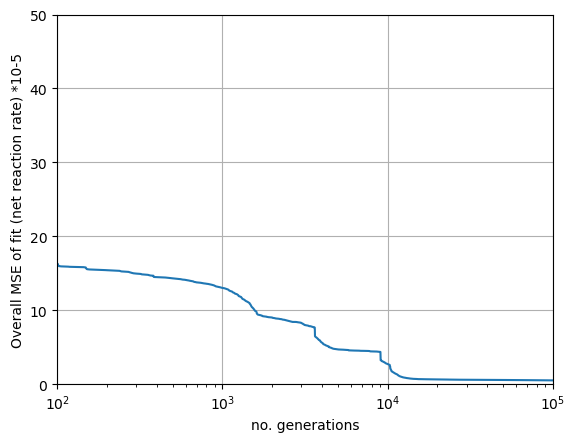

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.422469077221335
1.3476220414038806
0.6787069331910638
-4.284283880016598
0.5027319370180553
0.03574335342908463
0.4069391165359278
-4.108843942808439
0.24729481234711576
4.53807588653625
3.51876093960135
3.672407684633654
0.6098607077214044
0.016747291679569707
2.8393138532295072
2.1300946675676755e-08
0.27234428960841317
-9.841431024823109
1.5149698280497166
1.2758867287023705
-8.697005366292508
0.867500854361772
3.1969244378946686
0.0560152235316449
3.0529039529636433
4.037242783985477
1.2100614792235334
7.496606174772424
-0.515168574780084
2.9621747797622593
9.001798668035496
1.7130506042110987
-3.0810272837649606
0.34096106613135096
0.9672678778707083
-1.301029004043863


In [37]:
res.X

array([-1.04224691e+01,  1.34762204e+00,  6.78706933e-01, -4.28428388e+00,
        5.02731937e-01,  3.57433534e-02,  4.06939117e-01, -4.10884394e+00,
        2.47294812e-01,  4.53807589e+00,  3.51876094e+00,  3.67240768e+00,
        6.09860708e-01,  1.67472917e-02,  2.83931385e+00,  2.13009467e-08,
        2.72344290e-01, -9.84143102e+00,  1.51496983e+00,  1.27588673e+00,
       -8.69700537e+00,  8.67500854e-01,  3.19692444e+00,  5.60152235e-02,
        3.05290395e+00,  4.03724278e+00,  1.21006148e+00,  7.49660617e+00,
       -5.15168575e-01,  2.96217478e+00,  9.00179867e+00,  1.71305060e+00,
       -3.08102728e+00,  3.40961066e-01,  9.67267878e-01, -1.30102900e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.422469077221335
1.6: 1.3476220414038806
0.9: 0.6787069331910638
-4.3: -4.284283880016598
0.5: 0.5027319370180553
0.003: 0.03574335342908463
0.4: 0.4069391165359278
-7.9: -4.108843942808439
0.7: 0.24729481234711576
7.2: 4.53807588653625
5.7: 3.51876093960135
5.7: 3.672407684633654
0.8: 0.6098607077214044
0.03: 0.016747291679569707
3.1: 2.8393138532295072
6.000000000000001e-09: 2.1300946675676755e-08
0.1: 0.27234428960841317
-12.0: -9.841431024823109
1.9: 1.5149698280497166
1.6: 1.2758867287023705
-11.6: -8.697005366292508
1.2: 0.867500854361772
4.0: 3.1969244378946686
0.01: 0.0560152235316449
4.2: 3.0529039529636433
5.4: 4.037242783985477
2.2: 1.2100614792235334
11.8: 7.496606174772424
-12.0: -0.515168574780084
3.3: 2.9621747797622593
1.8: 9.001798668035496
4.2: 1.7130506042110987
-4.0: -3.0810272837649606
0.5: 0.34096106613135096
1.0: 0.9672678778707083
coeff fit: 0.7493692457130147
r: 0.8656611610283869


In [1]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]
y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.04224691e+01,  1.34762204e+00,  6.78706933e-01, -4.28428388e+00,
        5.02731937e-01,  3.57433534e-02,  4.06939117e-01, -4.10884394e+00,
        2.47294812e-01,  4.53807589e+00,  3.51876094e+00,  3.67240768e+00,
        6.09860708e-01,  1.67472917e-02,  2.83931385e+00,  2.13009467e-08,
        2.72344290e-01, -9.84143102e+00,  1.51496983e+00,  1.27588673e+00,
       -8.69700537e+00,  8.67500854e-01,  3.19692444e+00,  5.60152235e-02,
        3.05290395e+00,  4.03724278e+00,  1.21006148e+00,  7.49660617e+00,
       -5.15168575e-01,  2.96217478e+00,  9.00179867e+00,  1.71305060e+00,
       -3.08102728e+00,  3.40961066e-01,  9.67267878e-01, -1.30102900e+00]
#np.ndarray.tolist(res.X)

krseed10 = [ -7.8900867 ,   0.93855635,   0.28420999,  -5.22480767,
         0.66956586,   0.24950872,   0.46941572,  -6.25077262,
         0.46789577,   6.82146167,   5.55485531,   5.6689378 ,
         0.63902358,   0.03086746,   3.47028538,   0.03972053,
         0.59381089, -12.        ,   1.85053475,   1.52926287,
        -9.90798134,   0.50387899,   8.74218203,   4.58243021,
         2.42274154,  11.99999999,   0.02281741,   7.94930839,
        -8.76334321,   3.06677396,   1.81507874,   5.75929971,
        -8.37186518,   1.28278936,   1.60146213,  -1.30102998]

krseed101 = [-1.09824708e+01,  1.43719398e+00,  7.56390058e-01, -4.30596278e+00,
        5.00621949e-01,  3.05806793e-03,  3.98783778e-01, -8.22602939e+00,
        7.39965491e-01,  7.42040808e+00,  5.88111499e+00,  5.86905579e+00,
        8.72791887e-01,  2.30317937e-02,  3.13210334e+00,  1.42079065e-07,
        9.87763256e-02, -1.18531661e+01,  1.87312931e+00,  1.57020452e+00,
       -1.09954132e+01,  1.13311495e+00,  3.82371569e+00,  2.97380307e-02,
        3.92689586e+00,  4.75019485e+00,  1.89896651e+00,  1.03626940e+01,
       -6.16644132e+00,  2.77692740e+00,  4.39710885e+00,  2.82270373e+00,
       -3.85727717e+00,  4.82691097e-01,  1.04384264e+00, -1.30102999e+00]

# %store -r resX10
# krseed10 = np.ndarray.tolist(resX10)

# %store -r resX101
# krseed101 = np.ndarray.tolist(resX101)

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9110911470498401
r: 0.9545109465322229
-9.765008866666667
1.2411241233333332
0.573102327
-4.6050181100000005
0.5576399153333332
0.09610338044333333
0.42504620499999995
-6.195215316666666
0.48505202433333333
6.259981880000001
4.984910413333334
5.070133756666667
0.7072253916666668
0.023548848466666664
3.1472341900000003
0.013240231126670566
0.3216438352
-11.231532373333332
1.7462112966666667
1.4584513733333333
-9.86679997
0.8348315980000001
5.254274053333334
1.5560611547333334
3.13418045
6.929145873333333
1.0439484666666667
8.602869519999999
-5.148317701666667
2.935292046666666
5.071328753333334
3.43168468
-5.103389876666667
0.7021471743333333
1.2041908826666667


In [2]:
meankr

[-9.765008866666667,
 1.2411241233333332,
 0.573102327,
 -4.6050181100000005,
 0.5576399153333332,
 0.09610338044333333,
 0.42504620499999995,
 -6.195215316666666,
 0.48505202433333333,
 6.259981880000001,
 4.984910413333334,
 5.070133756666667,
 0.7072253916666668,
 0.023548848466666664,
 3.1472341900000003,
 0.013240231126670566,
 0.3216438352,
 -11.231532373333332,
 1.7462112966666667,
 1.4584513733333333,
 -9.86679997,
 0.8348315980000001,
 5.254274053333334,
 1.5560611547333334,
 3.13418045,
 6.929145873333333,
 1.0439484666666667,
 8.602869519999999,
 -5.148317701666667,
 2.935292046666666,
 5.071328753333334,
 3.43168468,
 -5.103389876666667,
 0.7021471743333333,
 1.2041908826666667]

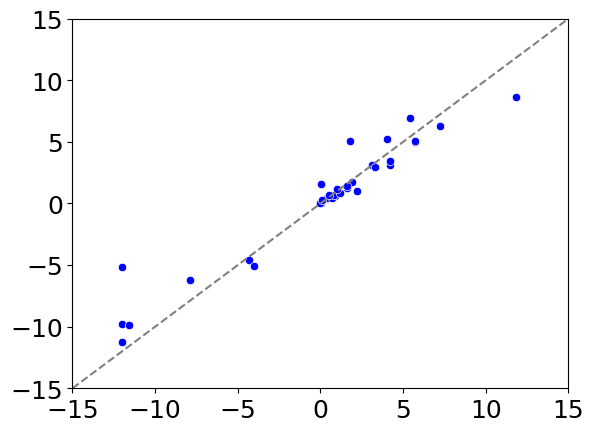

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()